In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:1


In [2]:
lr_tune = np.array([8e-6,8e-5,8e-4,8e-3,8e-2]).reshape(-1,1)
b_value = np.array([0.0,0.25,0.5,1.0]).reshape(-1,1)


LR_tune, B_value = np.meshgrid(lr_tune,b_value)

LR_tune = LR_tune.flatten('F').reshape(-1,1)
B_value = B_value.flatten('F').reshape(-1,1)


lrb_tune = np.hstack((LR_tune,B_value))

In [3]:
def true_disc(x): #[-4,3.75]
    y  = np.zeros((np.shape(x)[0],))
    
    y = 0.2*np.sin(6*x)*np.exp(-1*x)
    y[x>0] = 1 + 0.1*x[x>0]*np.exp(x[x>0]) + 10
    
    return 50*y

In [4]:
# Domain bounds
label = "Regr_disc_Stan"
loss_thresh = 0.1

lb = np.array(-4.0)  # [-1. 0.]
ub = np.array(3.75) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_disc(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [5]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_disc(x_train)

    return x_train, u_train

In [6]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(beta_init*torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(model_NN.beta.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [9]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    nan_flag = 0  
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
        
        if(np.isnan(loss_np)):
            nan_flag =1
            print("NAN BREAK!")
            break
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))
    
    return nan_flag

In [10]:
nan_tune = []

for tune_reps in range(20):
    label = "Regr_disc_stan_tune"+str(tune_reps) 
    max_reps = 10
    max_iter = 500
    layers = np.array([1,50,50,50,50,1])

    train_loss_full = []
    test_mse_full = []
    test_re_full = []
    beta_full = []
    elapsed_time= np.zeros((max_reps,1))

    time_threshold = np.empty((max_reps,1))
    time_threshold[:] = np.nan
    epoch_threshold = max_iter*np.ones((max_reps,1))

    beta_init = lrb_tune[tune_reps,1]

    for reps in range(max_reps):
        print(labels)

        train_loss = []
        test_mse_loss = []
        test_re_loss = []
        beta_val = []
        'Generate Training data'
        N_train = 300

        x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

        'Convert to tensor and send to GPU'
        x_train = torch.from_numpy(x_train_np_array).float().to(device)
        u_train = torch.from_numpy(u_train_np_array).float().to(device)

        x_test_tensor = torch.from_numpy(x_test).float().to(device)


        model_NN = Sequentialmodel(layers,beta_init)
        model_NN.to(device)
        print(model_NN)
        params = list(model_NN.parameters())
        #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        optimizer = optim.Adam(model_NN.parameters(), lr=lrb_tune[tune_reps,0])

        nan_flag = train_model(max_iter,reps)

        torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
        train_loss_full.append(train_loss)
        test_mse_full.append(test_mse_loss)
        test_re_full.append(test_re_loss)
        beta_full.append(beta_val)
        
        if(nan_flag == 1):
            nan_tune.append(tune_reps)
            break


    mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"beta": beta_full, "label": label}
    savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 290442.56 Test MSE 273269.97095086385 Test RE 0.9998249201835577
1 Train Loss 290441.66 Test MSE 273269.09575591394 Test RE 0.999823319125054
2 Train Loss 290440.72 Test MSE 273268.22040783317 Test RE 0.9998217177838522
3 Train Loss 290439.8 Test MSE 273267.34487545496 Test RE 0.9998201161029356
4 Train Loss 290438.88 Test MSE 273266.46917846106 Test RE 0.9998185141183078
5 Train Loss 290437.97 Test MSE 273265.59326569655 Test RE 0.9998169117363853
6 Train Loss 290437.03 Test MSE 273264.7171748813 Test RE 0.9998153090261706
7 Train Loss 290436.12 Test MSE 273263.8408926717 Test RE

115 Train Loss 290334.12 Test MSE 273167.23804642854 Test RE 0.9996369658081157
116 Train Loss 290333.12 Test MSE 273166.3199272123 Test RE 0.9996352859092278
117 Train Loss 290332.16 Test MSE 273165.4012617205 Test RE 0.9996336050079845
118 Train Loss 290331.22 Test MSE 273164.4821251076 Test RE 0.9996319232418923
119 Train Loss 290330.25 Test MSE 273163.5624649657 Test RE 0.9996302405150551
120 Train Loss 290329.28 Test MSE 273162.6423091357 Test RE 0.9996285568784088
121 Train Loss 290328.28 Test MSE 273161.72162293916 Test RE 0.9996268722684973
122 Train Loss 290327.3 Test MSE 273160.80041511665 Test RE 0.999625186701308
123 Train Loss 290326.34 Test MSE 273159.87868715613 Test RE 0.9996235001795585
124 Train Loss 290325.38 Test MSE 273158.95642347384 Test RE 0.9996218126747303
125 Train Loss 290324.4 Test MSE 273158.0336751119 Test RE 0.9996201242802123
126 Train Loss 290323.4 Test MSE 273157.11040500377 Test RE 0.9996184349281775
127 Train Loss 290322.47 Test MSE 273156.186576467

256 Train Loss 290191.4 Test MSE 273032.0820856731 Test RE 0.9993896381793407
257 Train Loss 290190.34 Test MSE 273031.0770550108 Test RE 0.9993877988018095
258 Train Loss 290189.28 Test MSE 273030.0712733435 Test RE 0.9993859580464215
259 Train Loss 290188.22 Test MSE 273029.06476732885 Test RE 0.9993841159619581
260 Train Loss 290187.2 Test MSE 273028.0575071652 Test RE 0.9993822724938688
261 Train Loss 290186.1 Test MSE 273027.04952141515 Test RE 0.9993804276944213
262 Train Loss 290185.06 Test MSE 273026.04077117326 Test RE 0.9993785814924034
263 Train Loss 290183.97 Test MSE 273025.0312661878 Test RE 0.9993767339056496
264 Train Loss 290182.88 Test MSE 273024.02100316924 Test RE 0.9993748849281304
265 Train Loss 290181.8 Test MSE 273023.01002922736 Test RE 0.9993730346460593
266 Train Loss 290180.75 Test MSE 273021.9982677859 Test RE 0.9993711829192787
267 Train Loss 290179.7 Test MSE 273020.98576074897 Test RE 0.9993693298244737
268 Train Loss 290178.62 Test MSE 273019.9724736133

395 Train Loss 290035.6 Test MSE 272884.5415955619 Test RE 0.9991195776776151
396 Train Loss 290034.4 Test MSE 272883.4180432436 Test RE 0.9991175208292007
397 Train Loss 290033.22 Test MSE 272882.2935336325 Test RE 0.9991154622240637
398 Train Loss 290032.06 Test MSE 272881.16811160796 Test RE 0.9991134019443533
399 Train Loss 290030.84 Test MSE 272880.0417167246 Test RE 0.999111339879402
400 Train Loss 290029.66 Test MSE 272878.91433717194 Test RE 0.999109276007578
401 Train Loss 290028.5 Test MSE 272877.78606753075 Test RE 0.9991072105020182
402 Train Loss 290027.25 Test MSE 272876.6568281054 Test RE 0.9991051432168141
403 Train Loss 290026.1 Test MSE 272875.5266284988 Test RE 0.9991030741695338
404 Train Loss 290024.88 Test MSE 272874.3954961094 Test RE 0.9991010034103259
405 Train Loss 290023.7 Test MSE 272873.2634093063 Test RE 0.9990989308995801
406 Train Loss 290022.5 Test MSE 272872.1303456779 Test RE 0.9990968565962556
407 Train Loss 290021.28 Test MSE 272870.99633712886 Test

20 Train Loss 292807.75 Test MSE 273407.76445073663 Test RE 1.0000769639989127
21 Train Loss 292806.7 Test MSE 273406.8129407028 Test RE 1.0000752237701822
22 Train Loss 292805.7 Test MSE 273405.861518745 Test RE 1.000073483699507
23 Train Loss 292804.66 Test MSE 273404.9101323823 Test RE 1.0000717436909048
24 Train Loss 292803.6 Test MSE 273403.95885153476 Test RE 1.0000700038722545
25 Train Loss 292802.56 Test MSE 273403.0075974054 Test RE 1.0000682640994432
26 Train Loss 292801.53 Test MSE 273402.0564148169 Test RE 1.0000665244544482
27 Train Loss 292800.5 Test MSE 273401.10527235025 Test RE 1.0000647848798074
28 Train Loss 292799.44 Test MSE 273400.15420085297 Test RE 1.0000630454319392
29 Train Loss 292798.4 Test MSE 273399.20318203524 Test RE 1.000061306077393
30 Train Loss 292797.4 Test MSE 273398.2522084307 Test RE 1.0000595668025143
31 Train Loss 292796.3 Test MSE 273397.30126629316 Test RE 1.000057827582162
32 Train Loss 292795.3 Test MSE 273396.3503765435 Test RE 1.000056088

145 Train Loss 292677.6 Test MSE 273288.4719742638 Test RE 0.9998587648667194
146 Train Loss 292676.6 Test MSE 273287.50647998555 Test RE 0.9998569986766525
147 Train Loss 292675.53 Test MSE 273286.5406879968 Test RE 0.9998552319388588
148 Train Loss 292674.5 Test MSE 273285.5746146028 Test RE 0.9998534646831632
149 Train Loss 292673.4 Test MSE 273284.6082266926 Test RE 0.9998516968489924
150 Train Loss 292672.38 Test MSE 273283.6415496818 Test RE 0.9998499284828363
151 Train Loss 292671.3 Test MSE 273282.67455907544 Test RE 0.9998481595398833
152 Train Loss 292670.28 Test MSE 273281.7072758662 Test RE 0.9998463900585326
153 Train Loss 292669.22 Test MSE 273280.73967323074 Test RE 0.999844619989712
154 Train Loss 292668.16 Test MSE 273279.7717942964 Test RE 0.9998428494123138
155 Train Loss 292667.1 Test MSE 273278.80360586464 Test RE 0.9998410782656031
156 Train Loss 292666.03 Test MSE 273277.83510492893 Test RE 0.9998393065440773
157 Train Loss 292665.0 Test MSE 273276.8663051774 Tes

273 Train Loss 292539.75 Test MSE 273162.0419101549 Test RE 0.9996274583089056
274 Train Loss 292538.66 Test MSE 273161.028660552 Test RE 0.9996256043304808
275 Train Loss 292537.56 Test MSE 273160.01495042426 Test RE 0.9996237495059764
276 Train Loss 292536.44 Test MSE 273159.0008134371 Test RE 0.9996218938969871
277 Train Loss 292535.3 Test MSE 273157.98623641813 Test RE 0.9996200374794065
278 Train Loss 292534.22 Test MSE 273156.9711958825 Test RE 0.9996181802102582
279 Train Loss 292533.12 Test MSE 273155.95575016015 Test RE 0.9996163221962671
280 Train Loss 292532.0 Test MSE 273154.93986865564 Test RE 0.9996144633814469
281 Train Loss 292530.88 Test MSE 273153.9235259446 Test RE 0.9996126037192725
282 Train Loss 292529.78 Test MSE 273152.90676740994 Test RE 0.9996107432927798
283 Train Loss 292528.7 Test MSE 273151.88956443686 Test RE 0.999608882049605
284 Train Loss 292527.6 Test MSE 273150.8718973671 Test RE 0.9996070199537747
285 Train Loss 292526.47 Test MSE 273149.85380508564

408 Train Loss 292385.88 Test MSE 273020.9751372787 Test RE 0.9993693103813339
409 Train Loss 292384.7 Test MSE 273019.8953668107 Test RE 0.9993673341768785
410 Train Loss 292383.53 Test MSE 273018.81508122396 Test RE 0.9993653570257378
411 Train Loss 292382.34 Test MSE 273017.73422317003 Test RE 0.9993633788229468
412 Train Loss 292381.16 Test MSE 273016.6528045986 Test RE 0.9993613995903693
413 Train Loss 292379.97 Test MSE 273015.5708118329 Test RE 0.9993594193029676
414 Train Loss 292378.78 Test MSE 273014.4882619028 Test RE 0.9993574379919042
415 Train Loss 292377.6 Test MSE 273013.4051689278 Test RE 0.9993554556830143
416 Train Loss 292376.44 Test MSE 273012.32150553336 Test RE 0.9993534723261911
417 Train Loss 292375.25 Test MSE 273011.2372716461 Test RE 0.9993514879212938
418 Train Loss 292374.1 Test MSE 273010.1525036724 Test RE 0.9993495025349481
419 Train Loss 292372.88 Test MSE 273009.0671470286 Test RE 0.9993475160672466
420 Train Loss 292371.72 Test MSE 273007.9812588696 

34 Train Loss 279512.6 Test MSE 273289.63553775696 Test RE 0.9998608933829907
35 Train Loss 279511.9 Test MSE 273288.9261936891 Test RE 0.9998595957745904
36 Train Loss 279511.16 Test MSE 273288.21662250854 Test RE 0.9998582977490461
37 Train Loss 279510.4 Test MSE 273287.5068249142 Test RE 0.9998569993076349
38 Train Loss 279509.72 Test MSE 273286.7968138933 Test RE 0.9998557004741131
39 Train Loss 279508.97 Test MSE 273286.0865792163 Test RE 0.9998544012297659
40 Train Loss 279508.28 Test MSE 273285.37611125567 Test RE 0.99985310155698
41 Train Loss 279507.53 Test MSE 273284.66541536973 Test RE 0.9998518014655555
42 Train Loss 279506.8 Test MSE 273283.9544930953 Test RE 0.9998505009583022
43 Train Loss 279506.1 Test MSE 273283.2433168698 Test RE 0.9998491999847979
44 Train Loss 279505.38 Test MSE 273282.5319069175 Test RE 0.9998478985820373
45 Train Loss 279504.66 Test MSE 273281.82024366356 Test RE 0.9998465967142098
46 Train Loss 279503.9 Test MSE 273281.10835253116 Test RE 0.99984

177 Train Loss 279405.66 Test MSE 273184.7706601572 Test RE 0.9996690449983292
178 Train Loss 279404.88 Test MSE 273184.00625952834 Test RE 0.999667646406125
179 Train Loss 279404.12 Test MSE 273183.24134636065 Test RE 0.9996662468741908
180 Train Loss 279403.34 Test MSE 273182.4759454471 Test RE 0.9996648464478856
181 Train Loss 279402.56 Test MSE 273181.7100230465 Test RE 0.9996634450654708
182 Train Loss 279401.78 Test MSE 273180.9436073948 Test RE 0.9996620427786049
183 Train Loss 279401.0 Test MSE 273180.1766835187 Test RE 0.9996606395598872
184 Train Loss 279400.22 Test MSE 273179.40923847706 Test RE 0.9996592353856361
185 Train Loss 279399.4 Test MSE 273178.64129675395 Test RE 0.9996578303006457
186 Train Loss 279398.62 Test MSE 273177.872842112 Test RE 0.9996564242752026
187 Train Loss 279397.88 Test MSE 273177.10387358174 Test RE 0.9996550173075296
188 Train Loss 279397.06 Test MSE 273176.33441586327 Test RE 0.9996536094428153
189 Train Loss 279396.28 Test MSE 273175.564422018

317 Train Loss 279291.03 Test MSE 273072.3217080333 Test RE 0.99946328077054
318 Train Loss 279290.2 Test MSE 273071.4751792644 Test RE 0.999461731592888
319 Train Loss 279289.34 Test MSE 273070.628004829 Test RE 0.9994601812312391
320 Train Loss 279288.47 Test MSE 273069.7801840081 Test RE 0.9994586296842728
321 Train Loss 279287.6 Test MSE 273068.9316493989 Test RE 0.9994570768286328
322 Train Loss 279286.75 Test MSE 273068.0824501336 Test RE 0.9994555227542273
323 Train Loss 279285.88 Test MSE 273067.23258785816 Test RE 0.9994539674640629
324 Train Loss 279285.0 Test MSE 273066.382057223 Test RE 0.999452410948344
325 Train Loss 279284.12 Test MSE 273065.5308518981 Test RE 0.9994508531954805
326 Train Loss 279283.28 Test MSE 273064.67895633116 Test RE 0.9994492941770051
327 Train Loss 279282.4 Test MSE 273063.8264110527 Test RE 0.999447733967085
328 Train Loss 279281.53 Test MSE 273062.9731602549 Test RE 0.9994461724635826
329 Train Loss 279280.66 Test MSE 273062.11924247345 Test RE 

456 Train Loss 279164.2 Test MSE 272947.7904466928 Test RE 0.9992353583366739
457 Train Loss 279163.22 Test MSE 272946.8408335226 Test RE 0.9992336201143563
458 Train Loss 279162.25 Test MSE 272945.8904163543 Test RE 0.9992318804173306
459 Train Loss 279161.28 Test MSE 272944.9391580614 Test RE 0.9992301391776299
460 Train Loss 279160.3 Test MSE 272943.987107593 Test RE 0.9992283964848463
461 Train Loss 279159.38 Test MSE 272943.03422972496 Test RE 0.999226652274495
462 Train Loss 279158.38 Test MSE 272942.0805391068 Test RE 0.9992249065733843
463 Train Loss 279157.4 Test MSE 272941.1260072231 Test RE 0.9992231593293092
464 Train Loss 279156.44 Test MSE 272940.1706292949 Test RE 0.9992214105335135
465 Train Loss 279155.47 Test MSE 272939.21442030574 Test RE 0.9992196602134169
466 Train Loss 279154.5 Test MSE 272938.25735847757 Test RE 0.9992179083291466
467 Train Loss 279153.5 Test MSE 272937.29950543627 Test RE 0.9992161549934994
468 Train Loss 279152.53 Test MSE 272936.3408153207 Tes

97 Train Loss 305558.47 Test MSE 273338.3771094607 Test RE 0.9999500526709887
98 Train Loss 305557.34 Test MSE 273337.3738451405 Test RE 0.9999482175552232
99 Train Loss 305556.22 Test MSE 273336.3702229352 Test RE 0.9999463817814639
100 Train Loss 305555.1 Test MSE 273335.3662467352 Test RE 0.9999445453568241
101 Train Loss 305553.97 Test MSE 273334.3619059513 Test RE 0.9999427082619305
102 Train Loss 305552.88 Test MSE 273333.3571896592 Test RE 0.9999408704767977
103 Train Loss 305551.75 Test MSE 273332.3521266385 Test RE 0.9999390320540635
104 Train Loss 305550.62 Test MSE 273331.34668581095 Test RE 0.9999371929368778
105 Train Loss 305549.5 Test MSE 273330.34085350414 Test RE 0.9999353531002272
106 Train Loss 305548.38 Test MSE 273329.33466563607 Test RE 0.9999335126098083
107 Train Loss 305547.22 Test MSE 273328.3281188375 Test RE 0.9999316714594544
108 Train Loss 305546.1 Test MSE 273327.3211374343 Test RE 0.9999298295107402
109 Train Loss 305544.97 Test MSE 273326.31382736843 Te

236 Train Loss 305397.6 Test MSE 273194.5398255799 Test RE 0.999686919063817
237 Train Loss 305396.44 Test MSE 273193.4666856201 Test RE 0.9996849556185842
238 Train Loss 305395.22 Test MSE 273192.3929047223 Test RE 0.9996829909968146
239 Train Loss 305394.03 Test MSE 273191.3184935545 Test RE 0.9996810252180195
240 Train Loss 305392.8 Test MSE 273190.2434642738 Test RE 0.9996790583044359
241 Train Loss 305391.6 Test MSE 273189.16778180824 Test RE 0.9996770901918869
242 Train Loss 305390.4 Test MSE 273188.091463322 Test RE 0.9996751209117706
243 Train Loss 305389.22 Test MSE 273187.01450190693 Test RE 0.99967315045144
244 Train Loss 305388.0 Test MSE 273185.9369012484 Test RE 0.9996711788176319
245 Train Loss 305386.78 Test MSE 273184.85867556813 Test RE 0.9996692060363596
246 Train Loss 305385.6 Test MSE 273183.7797680358 Test RE 0.9996672320036364
247 Train Loss 305384.38 Test MSE 273182.7002439054 Test RE 0.9996652568388468
248 Train Loss 305383.2 Test MSE 273181.62004317675 Test RE

378 Train Loss 305219.3 Test MSE 273035.01215067826 Test RE 0.9993950006787343
379 Train Loss 305217.97 Test MSE 273033.83243981324 Test RE 0.9993928416178779
380 Train Loss 305216.66 Test MSE 273032.6518561359 Test RE 0.9993906809549647
381 Train Loss 305215.34 Test MSE 273031.4704371702 Test RE 0.9993885187586601
382 Train Loss 305214.0 Test MSE 273030.28817312606 Test RE 0.999386355011036
383 Train Loss 305212.7 Test MSE 273029.105048069 Test RE 0.9993841896829194
384 Train Loss 305211.38 Test MSE 273027.92107705795 Test RE 0.9993820228018613
385 Train Loss 305210.06 Test MSE 273026.7362386183 Test RE 0.999379854328548
386 Train Loss 305208.72 Test MSE 273025.5505371215 Test RE 0.9993776842709705
387 Train Loss 305207.4 Test MSE 273024.36394910543 Test RE 0.9993755125861781
388 Train Loss 305206.1 Test MSE 273023.1765310956 Test RE 0.9993733393776129
389 Train Loss 305204.75 Test MSE 273021.98822639964 Test RE 0.9993711645415065
390 Train Loss 305203.4 Test MSE 273020.7990724105 Tes

16 Train Loss 258060.9 Test MSE 273044.96007143636 Test RE 0.9994132067901752
17 Train Loss 258059.8 Test MSE 273043.79768433346 Test RE 0.9994110794733805
18 Train Loss 258058.67 Test MSE 273042.63502717175 Test RE 0.9994089516578144
19 Train Loss 258057.55 Test MSE 273041.472138603 Test RE 0.9994068234142113
20 Train Loss 258056.44 Test MSE 273040.3089350751 Test RE 0.9994046945896562
21 Train Loss 258055.31 Test MSE 273039.14546582545 Test RE 0.999402565274257
22 Train Loss 258054.22 Test MSE 273037.9817707346 Test RE 0.9994004355409979
23 Train Loss 258053.12 Test MSE 273036.81778298697 Test RE 0.9993983052675938
24 Train Loss 258051.98 Test MSE 273035.65351868805 Test RE 0.9993961744835167
25 Train Loss 258050.86 Test MSE 273034.4889236388 Test RE 0.9993940430895704
26 Train Loss 258049.77 Test MSE 273033.3240882846 Test RE 0.9993919112512805
27 Train Loss 258048.64 Test MSE 273032.15895268373 Test RE 0.9993897788589413
28 Train Loss 258047.5 Test MSE 273030.9935302624 Test RE 0.9

156 Train Loss 257901.17 Test MSE 272878.2929840069 Test RE 0.9991081385065997
157 Train Loss 257900.0 Test MSE 272877.06466587936 Test RE 0.9991058898410762
158 Train Loss 257898.86 Test MSE 272875.83571218286 Test RE 0.9991036400069607
159 Train Loss 257897.66 Test MSE 272874.6060911822 Test RE 0.9991013889461469
160 Train Loss 257896.48 Test MSE 272873.3757725756 Test RE 0.9990991366031534
161 Train Loss 257895.31 Test MSE 272872.1448261759 Test RE 0.9990968831057783
162 Train Loss 257894.14 Test MSE 272870.91323049844 Test RE 0.9990946284146813
163 Train Loss 257892.94 Test MSE 272869.68096051936 Test RE 0.9990923724840433
164 Train Loss 257891.77 Test MSE 272868.44803672296 Test RE 0.9990901153513564
165 Train Loss 257890.6 Test MSE 272867.2144034453 Test RE 0.9990878569147075
166 Train Loss 257889.39 Test MSE 272865.9801554399 Test RE 0.9990855973475555
167 Train Loss 257888.22 Test MSE 272864.74522068107 Test RE 0.999083336518033
168 Train Loss 257887.05 Test MSE 272863.50960245

293 Train Loss 257733.27 Test MSE 272703.10487015976 Test RE 0.9987873728456951
294 Train Loss 257731.98 Test MSE 272701.7694454846 Test RE 0.9987849273162676
295 Train Loss 257730.7 Test MSE 272700.43308580236 Test RE 0.9987824800685914
296 Train Loss 257729.45 Test MSE 272699.0958700189 Test RE 0.9987800312471524
297 Train Loss 257728.14 Test MSE 272697.7577757979 Test RE 0.998777580811035
298 Train Loss 257726.83 Test MSE 272696.41875746584 Test RE 0.9987751286765857
299 Train Loss 257725.55 Test MSE 272695.0788262872 Test RE 0.9987726748644209
300 Train Loss 257724.3 Test MSE 272693.73802272 Test RE 0.9987702194486188
301 Train Loss 257723.0 Test MSE 272692.3963055431 Test RE 0.998767762353679
302 Train Loss 257721.72 Test MSE 272691.0536856876 Test RE 0.9987653035996079
303 Train Loss 257720.4 Test MSE 272689.7101777682 Test RE 0.9987628432131563
304 Train Loss 257719.16 Test MSE 272688.3657518073 Test RE 0.9987603811394145
305 Train Loss 257717.88 Test MSE 272687.02042920253 Test

431 Train Loss 257547.9 Test MSE 272509.84067189606 Test RE 0.998433390713662
432 Train Loss 257546.48 Test MSE 272508.3709185354 Test RE 0.9984306982369309
433 Train Loss 257545.08 Test MSE 272506.9001289105 Test RE 0.9984280038545736
434 Train Loss 257543.66 Test MSE 272505.42829635344 Test RE 0.9984253075543599
435 Train Loss 257542.25 Test MSE 272503.955367753 Test RE 0.998422609238977
436 Train Loss 257540.83 Test MSE 272502.48147566913 Test RE 0.9984199091512519
437 Train Loss 257539.42 Test MSE 272501.006550993 Test RE 0.998417207164566
438 Train Loss 257538.0 Test MSE 272499.5305626621 Test RE 0.9984145032219982
439 Train Loss 257536.6 Test MSE 272498.0535647238 Test RE 0.9984117974225457
440 Train Loss 257535.2 Test MSE 272496.57549835765 Test RE 0.9984090896584368
441 Train Loss 257533.73 Test MSE 272495.09639778937 Test RE 0.9984063799923555
442 Train Loss 257532.33 Test MSE 272493.6162412975 Test RE 0.9984036683844931
443 Train Loss 257530.89 Test MSE 272492.13502791635 Tes

70 Train Loss 263894.53 Test MSE 273416.5147528834 Test RE 1.0000929673951693
71 Train Loss 263893.66 Test MSE 273415.5862055517 Test RE 1.0000912691904256
72 Train Loss 263892.75 Test MSE 273414.65758429875 Test RE 1.0000895708476045
73 Train Loss 263891.88 Test MSE 273413.72893934336 Test RE 1.0000878724585502
74 Train Loss 263890.94 Test MSE 273412.80021220236 Test RE 1.0000861739163027
75 Train Loss 263890.06 Test MSE 273411.8714499409 Test RE 1.0000844753069387
76 Train Loss 263889.2 Test MSE 273410.94260153105 Test RE 1.000082776537133
77 Train Loss 263888.28 Test MSE 273410.0137036851 Test RE 1.0000810776740274
78 Train Loss 263887.4 Test MSE 273409.0847501717 Test RE 1.0000793787062259
79 Train Loss 263886.5 Test MSE 273408.1557198531 Test RE 1.000077679595068
80 Train Loss 263885.6 Test MSE 273407.2266291034 Test RE 1.0000759803705002
81 Train Loss 263884.7 Test MSE 273406.2974580121 Test RE 1.0000742809961072
82 Train Loss 263883.8 Test MSE 273405.3682231808 Test RE 1.0000725

211 Train Loss 263767.12 Test MSE 273284.0434485192 Test RE 0.9998506636866961
212 Train Loss 263766.2 Test MSE 273283.0859557731 Test RE 0.9998489121197475
213 Train Loss 263765.28 Test MSE 273282.1281280062 Test RE 0.9998471599368661
214 Train Loss 263764.38 Test MSE 273281.16998617817 Test RE 0.9998454071763914
215 Train Loss 263763.44 Test MSE 273280.2114842098 Test RE 0.9998436537540261
216 Train Loss 263762.53 Test MSE 273279.25264161744 Test RE 0.9998418997054676
217 Train Loss 263761.6 Test MSE 273278.29345834954 Test RE 0.9998401450306197
218 Train Loss 263760.7 Test MSE 273277.3339224243 Test RE 0.9998383897075591
219 Train Loss 263759.78 Test MSE 273276.37406810024 Test RE 0.999836633798954
220 Train Loss 263758.84 Test MSE 273275.4138529921 Test RE 0.9998348772272635
221 Train Loss 263757.94 Test MSE 273274.45330076065 Test RE 0.9998331200357679
222 Train Loss 263756.97 Test MSE 273273.4923999307 Test RE 0.9998313622034719
223 Train Loss 263756.06 Test MSE 273272.5311521274

350 Train Loss 263635.47 Test MSE 273147.07778081164 Test RE 0.9996000775656962
351 Train Loss 263634.5 Test MSE 273146.05921827967 Test RE 0.9995982138149585
352 Train Loss 263633.5 Test MSE 273145.0401044568 Test RE 0.9995963490519998
353 Train Loss 263632.53 Test MSE 273144.02041835315 Test RE 0.9995944832384062
354 Train Loss 263631.56 Test MSE 273143.00018875004 Test RE 0.999592616426836
355 Train Loss 263630.56 Test MSE 273141.97940756386 Test RE 0.9995907486024925
356 Train Loss 263629.6 Test MSE 273140.9580727618 Test RE 0.9995888797616503
357 Train Loss 263628.62 Test MSE 273139.9361989306 Test RE 0.9995870099309946
358 Train Loss 263627.62 Test MSE 273138.91378351726 Test RE 0.9995851391058481
359 Train Loss 263626.66 Test MSE 273137.89077626815 Test RE 0.9995832671942505
360 Train Loss 263625.66 Test MSE 273136.8672472136 Test RE 0.9995813943243386
361 Train Loss 263624.7 Test MSE 273135.8431628503 Test RE 0.9995795204348019
362 Train Loss 263623.7 Test MSE 273134.818528237 

489 Train Loss 263493.88 Test MSE 272999.65620135475 Test RE 0.9993302915729627
490 Train Loss 263492.8 Test MSE 272998.548886667 Test RE 0.999328264877678
491 Train Loss 263491.75 Test MSE 272997.4408243616 Test RE 0.9993262368099299
492 Train Loss 263490.7 Test MSE 272996.3320646755 Test RE 0.9993242074616577
493 Train Loss 263489.6 Test MSE 272995.22260377073 Test RE 0.9993221768258292
494 Train Loss 263488.56 Test MSE 272994.11239539745 Test RE 0.9993201448177856
495 Train Loss 263487.47 Test MSE 272993.0014516729 Test RE 0.9993181114596971
496 Train Loss 263486.4 Test MSE 272991.88981282583 Test RE 0.9993160768251859
497 Train Loss 263485.38 Test MSE 272990.7774249716 Test RE 0.9993140408156188
498 Train Loss 263484.28 Test MSE 272989.6643232757 Test RE 0.9993120034953512
499 Train Loss 263483.22 Test MSE 272988.55044666736 Test RE 0.9993099647525964
Training time: 1.45
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in

127 Train Loss 310654.16 Test MSE 273331.189698138 Test RE 0.9999369057802135
128 Train Loss 310653.2 Test MSE 273330.2979907658 Test RE 0.9999352746969865
129 Train Loss 310652.16 Test MSE 273329.4058716495 Test RE 0.9999336428579476
130 Train Loss 310651.2 Test MSE 273328.5133243007 Test RE 0.9999320102329331
131 Train Loss 310650.2 Test MSE 273327.6203461706 Test RE 0.9999303768172765
132 Train Loss 310649.22 Test MSE 273326.72693819256 Test RE 0.9999287426126816
133 Train Loss 310648.2 Test MSE 273325.83309081045 Test RE 0.9999271076016646
134 Train Loss 310647.22 Test MSE 273324.9388115044 Test RE 0.9999254717979038
135 Train Loss 310646.2 Test MSE 273324.0440790224 Test RE 0.9999238351625219
136 Train Loss 310645.2 Test MSE 273323.1489020689 Test RE 0.9999221977114362
137 Train Loss 310644.22 Test MSE 273322.25326987554 Test RE 0.9999205594249454
138 Train Loss 310643.22 Test MSE 273321.35716757085 Test RE 0.9999189202758432
139 Train Loss 310642.2 Test MSE 273320.4606145098 Test

267 Train Loss 310509.06 Test MSE 273200.92126334395 Test RE 0.9996985946313599
268 Train Loss 310507.97 Test MSE 273199.94382100966 Test RE 0.999696806298075
269 Train Loss 310506.88 Test MSE 273198.965629924 Test RE 0.9996950165916683
270 Train Loss 310505.78 Test MSE 273197.98668537947 Test RE 0.9996932255035189
271 Train Loss 310504.7 Test MSE 273197.0069724584 Test RE 0.9996914330063267
272 Train Loss 310503.6 Test MSE 273196.0265037201 Test RE 0.9996896391230625
273 Train Loss 310502.5 Test MSE 273195.0452547439 Test RE 0.9996878438090376
274 Train Loss 310501.4 Test MSE 273194.0632568751 Test RE 0.9996860471215951
275 Train Loss 310500.3 Test MSE 273193.08048163384 Test RE 0.9996842490086202
276 Train Loss 310499.22 Test MSE 273192.0969480303 Test RE 0.9996824495048863
277 Train Loss 310498.16 Test MSE 273191.1126433838 Test RE 0.9996806485871852
278 Train Loss 310497.03 Test MSE 273190.12754927156 Test RE 0.999678846221802
279 Train Loss 310495.97 Test MSE 273189.141700674 Test

407 Train Loss 310347.6 Test MSE 273055.94119537715 Test RE 0.9994333034254479
408 Train Loss 310346.38 Test MSE 273054.8411504271 Test RE 0.9994312902433488
409 Train Loss 310345.16 Test MSE 273053.7401238919 Test RE 0.9994292752607997
410 Train Loss 310343.97 Test MSE 273052.63809221046 Test RE 0.9994272584346694
411 Train Loss 310342.7 Test MSE 273051.5350984068 Test RE 0.9994252398436858
412 Train Loss 310341.47 Test MSE 273050.43110755517 Test RE 0.9994232194239204
413 Train Loss 310340.25 Test MSE 273049.32612247625 Test RE 0.9994211971805245
414 Train Loss 310339.03 Test MSE 273048.2201311696 Test RE 0.9994191730915244
415 Train Loss 310337.78 Test MSE 273047.11313802685 Test RE 0.9994171471649458
416 Train Loss 310336.53 Test MSE 273046.0051620875 Test RE 0.9994151194356227
417 Train Loss 310335.3 Test MSE 273044.89617988723 Test RE 0.9994130898606014
418 Train Loss 310334.1 Test MSE 273043.7862113509 Test RE 0.9994110584763354
419 Train Loss 310332.88 Test MSE 273042.675253067

45 Train Loss 305986.4 Test MSE 273294.9346297827 Test RE 0.999870586998325
46 Train Loss 305985.44 Test MSE 273294.048604504 Test RE 0.9998689662011174
47 Train Loss 305984.5 Test MSE 273293.16253181326 Test RE 0.9998673453145525
48 Train Loss 305983.47 Test MSE 273292.27641400695 Test RE 0.99986572434283
49 Train Loss 305982.5 Test MSE 273291.3902581628 Test RE 0.999864103298897
50 Train Loss 305981.56 Test MSE 273290.50402988173 Test RE 0.9998624821198266
51 Train Loss 305980.6 Test MSE 273289.6177470526 Test RE 0.9998608608383429
52 Train Loss 305979.6 Test MSE 273288.7314130858 Test RE 0.9998592394606834
53 Train Loss 305978.62 Test MSE 273287.84500732255 Test RE 0.9998576179490568
54 Train Loss 305977.66 Test MSE 273286.9585356339 Test RE 0.9998559963142017
55 Train Loss 305976.7 Test MSE 273286.07200169394 Test RE 0.9998543745628392
56 Train Loss 305975.7 Test MSE 273285.1853883926 Test RE 0.9998527526636688
57 Train Loss 305974.72 Test MSE 273284.29871008376 Test RE 0.999851130

186 Train Loss 305847.25 Test MSE 273168.2379692854 Test RE 0.9996387953813528
187 Train Loss 305846.25 Test MSE 273167.317160227 Test RE 0.9996371105638928
188 Train Loss 305845.22 Test MSE 273166.39590956713 Test RE 0.9996354249355865
189 Train Loss 305844.22 Test MSE 273165.47419201484 Test RE 0.9996337384501549
190 Train Loss 305843.22 Test MSE 273164.5520417987 Test RE 0.999632051170222
191 Train Loss 305842.2 Test MSE 273163.62942173134 Test RE 0.9996303630277412
192 Train Loss 305841.2 Test MSE 273162.7063397488 Test RE 0.9996286740372289
193 Train Loss 305840.16 Test MSE 273161.78280845005 Test RE 0.9996269842217332
194 Train Loss 305839.16 Test MSE 273160.85876880033 Test RE 0.9996252934732326
195 Train Loss 305838.16 Test MSE 273159.93428665225 Test RE 0.9996236019122149
196 Train Loss 305837.12 Test MSE 273159.00933101814 Test RE 0.9996219094819767
197 Train Loss 305836.12 Test MSE 273158.0838633542 Test RE 0.9996202161119883
198 Train Loss 305835.1 Test MSE 273157.157961727

325 Train Loss 305700.7 Test MSE 273034.704737017 Test RE 0.9993944380626791
326 Train Loss 305699.6 Test MSE 273033.69507545687 Test RE 0.9993925902186821
327 Train Loss 305698.47 Test MSE 273032.6845819222 Test RE 0.9993907408486161
328 Train Loss 305697.38 Test MSE 273031.67326523905 Test RE 0.9993888899686257
329 Train Loss 305696.25 Test MSE 273030.6611035508 Test RE 0.9993870375387018
330 Train Loss 305695.16 Test MSE 273029.648112269 Test RE 0.999385183587041
331 Train Loss 305694.03 Test MSE 273028.63431128924 Test RE 0.9993833281500478
332 Train Loss 305692.9 Test MSE 273027.61970058345 Test RE 0.9993814712276621
333 Train Loss 305691.78 Test MSE 273026.604236156 Test RE 0.9993796127393555
334 Train Loss 305690.7 Test MSE 273025.5879728744 Test RE 0.9993777527855378
335 Train Loss 305689.56 Test MSE 273024.5708305933 Test RE 0.9993758912195182
336 Train Loss 305688.44 Test MSE 273023.5528498197 Test RE 0.9993740281154248
337 Train Loss 305687.3 Test MSE 273022.5340487366 Test 

465 Train Loss 305535.9 Test MSE 272884.4545973252 Test RE 0.9991194184130998
466 Train Loss 305534.62 Test MSE 272883.3106939823 Test RE 0.9991173243083954
467 Train Loss 305533.34 Test MSE 272882.16573257785 Test RE 0.9991152282623381
468 Train Loss 305532.12 Test MSE 272881.0196356803 Test RE 0.9991131301331646
469 Train Loss 305530.84 Test MSE 272879.8724837616 Test RE 0.9991110300681795
470 Train Loss 305529.6 Test MSE 272878.7242479257 Test RE 0.9991089280144716
471 Train Loss 305528.3 Test MSE 272877.5749089617 Test RE 0.9991068239368588
472 Train Loss 305527.06 Test MSE 272876.4244757758 Test RE 0.9991047178516328
473 Train Loss 305525.8 Test MSE 272875.27296827 Test RE 0.9991026097952159
474 Train Loss 305524.53 Test MSE 272874.12035847653 Test RE 0.9991004997163945
475 Train Loss 305523.28 Test MSE 272872.96660678193 Test RE 0.9990983875426351
476 Train Loss 305522.03 Test MSE 272871.8117924305 Test RE 0.9990962734189985
477 Train Loss 305520.75 Test MSE 272870.655903986 Test

104 Train Loss 274188.9 Test MSE 273389.46704089316 Test RE 1.0000434991039275
105 Train Loss 274187.97 Test MSE 273388.54630713665 Test RE 1.0000418151060166
106 Train Loss 274187.0 Test MSE 273387.62538478157 Test RE 1.0000401307603268
107 Train Loss 274186.03 Test MSE 273386.7042768937 Test RE 1.0000384460724645
108 Train Loss 274185.06 Test MSE 273385.783000549 Test RE 1.0000367610736587
109 Train Loss 274184.12 Test MSE 273384.8615136697 Test RE 1.000035075686949
110 Train Loss 274183.16 Test MSE 273383.93984262634 Test RE 1.000033389960564
111 Train Loss 274182.2 Test MSE 273383.0179746418 Test RE 1.0000317038711337
112 Train Loss 274181.22 Test MSE 273382.0959112791 Test RE 1.0000300174215144
113 Train Loss 274180.28 Test MSE 273381.17363587534 Test RE 1.0000283305812279
114 Train Loss 274179.3 Test MSE 273380.25115637743 Test RE 1.0000266433648073
115 Train Loss 274178.34 Test MSE 273379.3284675885 Test RE 1.0000249557627456
116 Train Loss 274177.4 Test MSE 273378.40556378756 T

236 Train Loss 274059.7 Test MSE 273265.4446481306 Test RE 0.9998166398573423
237 Train Loss 274058.7 Test MSE 273264.4793815117 Test RE 0.9998148740093384
238 Train Loss 274057.7 Test MSE 273263.51364661957 Test RE 0.99981310730156
239 Train Loss 274056.7 Test MSE 273262.5474362119 Test RE 0.9998113397207533
240 Train Loss 274055.66 Test MSE 273261.58070824086 Test RE 0.999809571189991
241 Train Loss 274054.7 Test MSE 273260.61350407684 Test RE 0.999807801784951
242 Train Loss 274053.66 Test MSE 273259.6458320616 Test RE 0.9998060315208896
243 Train Loss 274052.66 Test MSE 273258.6776536874 Test RE 0.9998042603273559
244 Train Loss 274051.62 Test MSE 273257.70897349145 Test RE 0.9998024882126451
245 Train Loss 274050.66 Test MSE 273256.7398153526 Test RE 0.9998007152204367
246 Train Loss 274049.6 Test MSE 273255.7701681273 Test RE 0.9997989413303395
247 Train Loss 274048.6 Test MSE 273254.7999949964 Test RE 0.9997971664749912
248 Train Loss 274047.6 Test MSE 273253.8293253089 Test RE 

372 Train Loss 273917.62 Test MSE 273129.0509078043 Test RE 0.9995670917451565
373 Train Loss 273916.53 Test MSE 273128.0048896491 Test RE 0.9995651776933138
374 Train Loss 273915.44 Test MSE 273126.9581717512 Test RE 0.9995632623573814
375 Train Loss 273914.34 Test MSE 273125.91072482424 Test RE 0.9995613456837612
376 Train Loss 273913.25 Test MSE 273124.8626216499 Test RE 0.9995594278056266
377 Train Loss 273912.16 Test MSE 273123.81379868655 Test RE 0.9995575086066976
378 Train Loss 273911.1 Test MSE 273122.76425755885 Test RE 0.9995555880899399
379 Train Loss 273909.97 Test MSE 273121.71403872856 Test RE 0.9995536663293858
380 Train Loss 273908.88 Test MSE 273120.6631071666 Test RE 0.9995517432609288
381 Train Loss 273907.78 Test MSE 273119.6114904853 Test RE 0.9995498189350893
382 Train Loss 273906.72 Test MSE 273118.559124459 Test RE 0.9995478932343334
383 Train Loss 273905.6 Test MSE 273117.50609716977 Test RE 0.9995459663198346
384 Train Loss 273904.53 Test MSE 273116.452348102

2 Train Loss 278508.88 Test MSE 273558.15597818885 Test RE 1.0003519789118474
3 Train Loss 278508.06 Test MSE 273557.35787017783 Test RE 1.0003505196435105
4 Train Loss 278507.25 Test MSE 273556.55989543395 Test RE 1.000349060616713
5 Train Loss 278506.44 Test MSE 273555.7619887204 Test RE 1.0003476017121746
6 Train Loss 278505.62 Test MSE 273554.96424106933 Test RE 1.0003461430963414
7 Train Loss 278504.8 Test MSE 273554.16661818896 Test RE 1.0003446847065152
8 Train Loss 278504.0 Test MSE 273553.3690870928 Test RE 1.0003432264823828
9 Train Loss 278503.2 Test MSE 273552.5717139873 Test RE 1.0003417685449996
10 Train Loss 278502.34 Test MSE 273551.77442571556 Test RE 1.0003403107606035
11 Train Loss 278501.56 Test MSE 273550.977289695 Test RE 1.0003388532524646
12 Train Loss 278500.72 Test MSE 273550.18025998346 Test RE 1.0003373959365807
13 Train Loss 278499.9 Test MSE 273549.38338259625 Test RE 1.0003359388970896
14 Train Loss 278499.1 Test MSE 273548.58661915275 Test RE 1.000334482

139 Train Loss 278397.84 Test MSE 273449.4501005255 Test RE 1.0001532004387312
140 Train Loss 278397.03 Test MSE 273448.65377333993 Test RE 1.000151744137095
141 Train Loss 278396.22 Test MSE 273447.8572540976 Test RE 1.00015028748211
142 Train Loss 278395.4 Test MSE 273447.06055026996 Test RE 1.000148830487437
143 Train Loss 278394.6 Test MSE 273446.26367892954 Test RE 1.0001473731842974
144 Train Loss 278393.78 Test MSE 273445.4666138062 Test RE 1.0001459155246468
145 Train Loss 278392.97 Test MSE 273444.669377557 Test RE 1.0001444575499185
146 Train Loss 278392.16 Test MSE 273443.87192191015 Test RE 1.0001429991718334
147 Train Loss 278391.34 Test MSE 273443.0742776755 Test RE 1.0001415404467333
148 Train Loss 278390.53 Test MSE 273442.27643150603 Test RE 1.000140081350208
149 Train Loss 278389.72 Test MSE 273441.47838292195 Test RE 1.0001386218813788
150 Train Loss 278388.88 Test MSE 273440.68013052235 Test RE 1.0001371620376818
151 Train Loss 278388.06 Test MSE 273439.88167349313 

278 Train Loss 278281.88 Test MSE 273335.8567467479 Test RE 0.9999454425561126
279 Train Loss 278281.03 Test MSE 273335.0109100745 Test RE 0.9999438953914065
280 Train Loss 278280.12 Test MSE 273334.16458780266 Test RE 0.9999423473360702
281 Train Loss 278279.25 Test MSE 273333.31776211946 Test RE 0.9999407983575176
282 Train Loss 278278.4 Test MSE 273332.4704534426 Test RE 0.9999392484930913
283 Train Loss 278277.56 Test MSE 273331.6226251059 Test RE 0.9999376976757193
284 Train Loss 278276.7 Test MSE 273330.77429481957 Test RE 0.9999361459377909
285 Train Loss 278275.78 Test MSE 273329.92544327816 Test RE 0.9999345932439896
286 Train Loss 278274.94 Test MSE 273329.0760807859 Test RE 0.9999330396131594
287 Train Loss 278274.1 Test MSE 273328.22621620476 Test RE 0.9999314850615056
288 Train Loss 278273.22 Test MSE 273327.3758312225 Test RE 0.9999299295555278
289 Train Loss 278272.34 Test MSE 273326.52494626574 Test RE 0.9999283731325855
290 Train Loss 278271.47 Test MSE 273325.67355668

416 Train Loss 278157.2 Test MSE 273213.6957438106 Test RE 0.999721966589313
417 Train Loss 278156.22 Test MSE 273212.76517256454 Test RE 0.9997202640514781
418 Train Loss 278155.25 Test MSE 273211.83386484574 Test RE 0.9997185601633167
419 Train Loss 278154.3 Test MSE 273210.901823963 Test RE 0.999716854930877
420 Train Loss 278153.4 Test MSE 273209.96905200474 Test RE 0.999715148357973
421 Train Loss 278152.4 Test MSE 273209.03554207843 Test RE 0.9997134404319868
422 Train Loss 278151.47 Test MSE 273208.10129545076 Test RE 0.9997117311552292
423 Train Loss 278150.5 Test MSE 273207.16630130867 Test RE 0.9997100205079102
424 Train Loss 278149.56 Test MSE 273206.2305711747 Test RE 0.9997083085111035
425 Train Loss 278148.6 Test MSE 273205.29410223395 Test RE 0.999706595159653
426 Train Loss 278147.62 Test MSE 273204.3568907273 Test RE 0.9997048804466734
427 Train Loss 278146.7 Test MSE 273203.4189461732 Test RE 0.9997031643895729
428 Train Loss 278145.72 Test MSE 273202.48023936484 Test

42 Train Loss 290411.53 Test MSE 273240.48212254513 Test RE 0.9997709726884063
43 Train Loss 290410.28 Test MSE 273239.3076328603 Test RE 0.9997688239915017
44 Train Loss 290409.03 Test MSE 273238.13305743854 Test RE 0.9997666751331248
45 Train Loss 290407.78 Test MSE 273236.9583976896 Test RE 0.9997645261158543
46 Train Loss 290406.53 Test MSE 273235.78363047255 Test RE 0.9997623768973527
47 Train Loss 290405.3 Test MSE 273234.60879279306 Test RE 0.999760227545321
48 Train Loss 290404.06 Test MSE 273233.4338444457 Test RE 0.999758077986202
49 Train Loss 290402.84 Test MSE 273232.2588219799 Test RE 0.9997559282868616
50 Train Loss 290401.6 Test MSE 273231.08368903364 Test RE 0.9997537783807747
51 Train Loss 290400.38 Test MSE 273229.90843529126 Test RE 0.9997516282490673
52 Train Loss 290399.12 Test MSE 273228.73307198443 Test RE 0.9997494779122864
53 Train Loss 290397.88 Test MSE 273227.5576497566 Test RE 0.9997473274630836
54 Train Loss 290396.66 Test MSE 273226.38207776874 Test RE 0

181 Train Loss 290237.3 Test MSE 273075.36551921425 Test RE 0.9994688510330486
182 Train Loss 290236.03 Test MSE 273074.15546148573 Test RE 0.9994666365961199
183 Train Loss 290234.72 Test MSE 273072.94496620266 Test RE 0.9994644213535463
184 Train Loss 290233.47 Test MSE 273071.7340287522 Test RE 0.9994622052968803
185 Train Loss 290232.2 Test MSE 273070.52262997633 Test RE 0.9994599883910569
186 Train Loss 290230.88 Test MSE 273069.3107892672 Test RE 0.9994577706715583
187 Train Loss 290229.62 Test MSE 273068.09845983033 Test RE 0.9994555520527442
188 Train Loss 290228.34 Test MSE 273066.88572316593 Test RE 0.9994533326837569
189 Train Loss 290227.06 Test MSE 273065.67250411975 Test RE 0.9994511124270559
190 Train Loss 290225.78 Test MSE 273064.45884819893 Test RE 0.9994488913659153
191 Train Loss 290224.5 Test MSE 273063.24473282916 Test RE 0.9994466694590182
192 Train Loss 290223.22 Test MSE 273062.0301533605 Test RE 0.999444446697848
193 Train Loss 290221.94 Test MSE 273060.815139

319 Train Loss 290055.75 Test MSE 272903.281412175 Test RE 0.9991538833882186
320 Train Loss 290054.34 Test MSE 272901.99055656977 Test RE 0.9991515203442325
321 Train Loss 290053.03 Test MSE 272900.6990134071 Test RE 0.9991491560360083
322 Train Loss 290051.62 Test MSE 272899.4067357297 Test RE 0.9991467903775764
323 Train Loss 290050.25 Test MSE 272898.1137117229 Test RE 0.9991444233472995
324 Train Loss 290048.9 Test MSE 272896.8200116172 Test RE 0.9991420550737328
325 Train Loss 290047.53 Test MSE 272895.52558172925 Test RE 0.999139685458594
326 Train Loss 290046.16 Test MSE 272894.23042476637 Test RE 0.9991373145068296
327 Train Loss 290044.8 Test MSE 272892.9345765392 Test RE 0.9991349422839857
328 Train Loss 290043.4 Test MSE 272891.6379939259 Test RE 0.9991325687111131
329 Train Loss 290042.06 Test MSE 272890.34063583636 Test RE 0.9991301937129808
330 Train Loss 290040.7 Test MSE 272889.0425268975 Test RE 0.9991278173346617
331 Train Loss 290039.3 Test MSE 272887.74373967294 Te

457 Train Loss 289859.9 Test MSE 272717.72780170053 Test RE 0.9988141510585772
458 Train Loss 289858.4 Test MSE 272716.3239627403 Test RE 0.9988115803125622
459 Train Loss 289856.94 Test MSE 272714.9191708101 Test RE 0.9988090078148214
460 Train Loss 289855.4 Test MSE 272713.5134861193 Test RE 0.9988064336755978
461 Train Loss 289853.94 Test MSE 272712.10685575317 Test RE 0.9988038577979795
462 Train Loss 289852.5 Test MSE 272710.6993124697 Test RE 0.998801280241941
463 Train Loss 289851.0 Test MSE 272709.2908262156 Test RE 0.9987987009524344
464 Train Loss 289849.5 Test MSE 272707.88141107943 Test RE 0.9987961199552456
465 Train Loss 289848.0 Test MSE 272706.47107486846 Test RE 0.9987935372646585
466 Train Loss 289846.5 Test MSE 272705.0598036317 Test RE 0.9987909528551125
467 Train Loss 289845.03 Test MSE 272703.64763830963 Test RE 0.9987883668015674
468 Train Loss 289843.53 Test MSE 272702.234503361 Test RE 0.9987857789656726
469 Train Loss 289842.03 Test MSE 272700.8204709891 Test 

97 Train Loss 292693.22 Test MSE 273302.36628644157 Test RE 0.9998841815503081
98 Train Loss 292692.16 Test MSE 273301.39506317914 Test RE 0.9998824049252961
99 Train Loss 292691.1 Test MSE 273300.42365963495 Test RE 0.9998806279673433
100 Train Loss 292690.06 Test MSE 273299.45208622655 Test RE 0.9998788506955042
101 Train Loss 292689.0 Test MSE 273298.48031757696 Test RE 0.9998770730633556
102 Train Loss 292687.94 Test MSE 273297.50839353405 Test RE 0.9998752951437897
103 Train Loss 292686.88 Test MSE 273296.5362674796 Test RE 0.9998735168515255
104 Train Loss 292685.8 Test MSE 273295.56396378233 Test RE 0.999871738231139
105 Train Loss 292684.75 Test MSE 273294.59144962876 Test RE 0.9998699592226032
106 Train Loss 292683.7 Test MSE 273293.6187670201 Test RE 0.9998681799027479
107 Train Loss 292682.62 Test MSE 273292.64588829526 Test RE 0.9998664002209721
108 Train Loss 292681.6 Test MSE 273291.67281564575 Test RE 0.9998646201812823
109 Train Loss 292680.5 Test MSE 273290.69958032825

235 Train Loss 292544.5 Test MSE 273165.97148553684 Test RE 0.9996346483586228
236 Train Loss 292543.4 Test MSE 273164.96079779434 Test RE 0.99963279908103
237 Train Loss 292542.3 Test MSE 273163.9497379824 Test RE 0.9996309491192301
238 Train Loss 292541.2 Test MSE 273162.93828282267 Test RE 0.9996290984306268
239 Train Loss 292540.1 Test MSE 273161.9264178807 Test RE 0.9996272469888045
240 Train Loss 292539.0 Test MSE 273160.9141812644 Test RE 0.999625394863487
241 Train Loss 292537.88 Test MSE 273159.9015310165 Test RE 0.999623541977899
242 Train Loss 292536.75 Test MSE 273158.88849681325 Test RE 0.9996216883863368
243 Train Loss 292535.66 Test MSE 273157.87506668305 Test RE 0.999619834066891
244 Train Loss 292534.56 Test MSE 273156.86120223126 Test RE 0.9996179789493055
245 Train Loss 292533.44 Test MSE 273155.8469521548 Test RE 0.9996161231226781
246 Train Loss 292532.34 Test MSE 273154.8322690774 Test RE 0.9996142665003191
247 Train Loss 292531.22 Test MSE 273153.8171749292 Test 

376 Train Loss 292384.12 Test MSE 273018.9224939899 Test RE 0.9993655536139966
377 Train Loss 292382.94 Test MSE 273017.8424802059 Test RE 0.9993635769567912
378 Train Loss 292381.78 Test MSE 273016.7619064553 Test RE 0.9993615992708141
379 Train Loss 292380.56 Test MSE 273015.6807707797 Test RE 0.9993596205524746
380 Train Loss 292379.4 Test MSE 273014.59903241385 Test RE 0.9993576407271575
381 Train Loss 292378.22 Test MSE 273013.51673698466 Test RE 0.9993556598783632
382 Train Loss 292377.06 Test MSE 273012.43379141943 Test RE 0.9993536778357409
383 Train Loss 292375.84 Test MSE 273011.35029772593 Test RE 0.9993516947859826
384 Train Loss 292374.7 Test MSE 273010.26622917777 Test RE 0.9993497106801658
385 Train Loss 292373.5 Test MSE 273009.18155215296 Test RE 0.9993477254567481
386 Train Loss 292372.3 Test MSE 273008.0962747247 Test RE 0.9993457391304987
387 Train Loss 292371.16 Test MSE 273007.01044704963 Test RE 0.9993437517932104
388 Train Loss 292369.94 Test MSE 273005.92400865

13 Train Loss 279508.8 Test MSE 273286.1660796812 Test RE 0.9998545466613994
14 Train Loss 279508.12 Test MSE 273285.4580710135 Test RE 0.9998532514876369
15 Train Loss 279507.38 Test MSE 273284.74985655514 Test RE 0.9998519559357391
16 Train Loss 279506.7 Test MSE 273284.04143324925 Test RE 0.9998506600001124
17 Train Loss 279505.94 Test MSE 273283.3327962828 Test RE 0.9998493636719509
18 Train Loss 279505.2 Test MSE 273282.62394329585 Test RE 0.9998480669469363
19 Train Loss 279504.5 Test MSE 273281.9148718531 Test RE 0.9998467698206113
20 Train Loss 279503.78 Test MSE 273281.2055708864 Test RE 0.9998454722727278
21 Train Loss 279503.03 Test MSE 273280.49604689813 Test RE 0.9998441743151787
22 Train Loss 279502.3 Test MSE 273279.7862760091 Test RE 0.9998428759042796
23 Train Loss 279501.6 Test MSE 273279.0762675261 Test RE 0.9998415770570532
24 Train Loss 279500.88 Test MSE 273278.3660173315 Test RE 0.9998402777659664
25 Train Loss 279500.12 Test MSE 273277.65552989126 Test RE 0.9998

151 Train Loss 279406.03 Test MSE 273185.3699414539 Test RE 0.9996701414771548
152 Train Loss 279405.22 Test MSE 273184.61093623674 Test RE 0.9996687527582419
153 Train Loss 279404.5 Test MSE 273183.8514622964 Test RE 0.9996673631797958
154 Train Loss 279403.7 Test MSE 273183.09149257076 Test RE 0.9996659726922982
155 Train Loss 279402.94 Test MSE 273182.331040444 Test RE 0.999664581320234
156 Train Loss 279402.12 Test MSE 273181.57007744967 Test RE 0.9996631890115145
157 Train Loss 279401.38 Test MSE 273180.808625665 Test RE 0.9996617958065307
158 Train Loss 279400.6 Test MSE 273180.0466809301 Test RE 0.9996604016976677
159 Train Loss 279399.8 Test MSE 273179.28422472416 Test RE 0.9996590066510344
160 Train Loss 279399.03 Test MSE 273178.5212593007 Test RE 0.9996576106707493
161 Train Loss 279398.25 Test MSE 273177.7577616767 Test RE 0.9996562137147584
162 Train Loss 279397.47 Test MSE 273176.99377423874 Test RE 0.9996548158606107
163 Train Loss 279396.7 Test MSE 273176.22928512545 Te

291 Train Loss 279291.88 Test MSE 273073.412431095 Test RE 0.9994652768288629
292 Train Loss 279291.0 Test MSE 273072.5646877159 Test RE 0.9994637254315277
293 Train Loss 279290.16 Test MSE 273071.71616613184 Test RE 0.9994621726076415
294 Train Loss 279289.28 Test MSE 273070.8668534548 Test RE 0.9994606183336114
295 Train Loss 279288.44 Test MSE 273070.01675937953 Test RE 0.9994590626271732
296 Train Loss 279287.56 Test MSE 273069.16590171825 Test RE 0.9994575055209173
297 Train Loss 279286.7 Test MSE 273068.3142623194 Test RE 0.999455946981618
298 Train Loss 279285.8 Test MSE 273067.46182515344 Test RE 0.9994543869799346
299 Train Loss 279284.94 Test MSE 273066.6086296381 Test RE 0.9994528255879968
300 Train Loss 279284.06 Test MSE 273065.7546448803 Test RE 0.9994512627492615
301 Train Loss 279283.22 Test MSE 273064.899862729 Test RE 0.9994496984488055
302 Train Loss 279282.3 Test MSE 273064.04431353847 Test RE 0.9994481327421719
303 Train Loss 279281.44 Test MSE 273063.18796976545 T

431 Train Loss 279162.62 Test MSE 272946.562435044 Test RE 0.9992331105184405
432 Train Loss 279161.62 Test MSE 272945.59328969434 Test RE 0.9992313365393634
433 Train Loss 279160.66 Test MSE 272944.62322528614 Test RE 0.9992295608748349
434 Train Loss 279159.66 Test MSE 272943.6521760257 Test RE 0.9992277834044136
435 Train Loss 279158.7 Test MSE 272942.680214055 Test RE 0.9992260042601423
436 Train Loss 279157.66 Test MSE 272941.70729521103 Test RE 0.999224223361174
437 Train Loss 279156.7 Test MSE 272940.7334424747 Test RE 0.9992224407495647
438 Train Loss 279155.7 Test MSE 272939.75862615195 Test RE 0.999220656370951
439 Train Loss 279154.7 Test MSE 272938.78287757153 Test RE 0.9992188702826705
440 Train Loss 279153.72 Test MSE 272937.8061523648 Test RE 0.9992170824034978
441 Train Loss 279152.7 Test MSE 272936.828505456 Test RE 0.9992152928339609
442 Train Loss 279151.72 Test MSE 272935.84989031864 Test RE 0.999213501488885
443 Train Loss 279150.7 Test MSE 272934.8703270246 Test R

63 Train Loss 305624.06 Test MSE 273396.5700517298 Test RE 1.000056490229282
64 Train Loss 305623.0 Test MSE 273395.61169425485 Test RE 1.0000547374412845
65 Train Loss 305621.94 Test MSE 273394.6530539539 Test RE 1.0000529841329397
66 Train Loss 305620.88 Test MSE 273393.6941263458 Test RE 1.0000512302960483
67 Train Loss 305619.78 Test MSE 273392.73490186816 Test RE 1.000049475913118
68 Train Loss 305618.72 Test MSE 273391.77535437664 Test RE 1.0000477209363294
69 Train Loss 305617.66 Test MSE 273390.81552029215 Test RE 1.0000459654322913
70 Train Loss 305616.6 Test MSE 273389.85536235734 Test RE 1.0000442093328588
71 Train Loss 305615.53 Test MSE 273388.8948766798 Test RE 1.0000424526309095
72 Train Loss 305614.4 Test MSE 273387.9340795498 Test RE 1.000040695356235
73 Train Loss 305613.34 Test MSE 273386.9729424126 Test RE 1.0000389374566059
74 Train Loss 305612.28 Test MSE 273386.0114810195 Test RE 1.0000371789608282
75 Train Loss 305611.22 Test MSE 273385.04967437236 Test RE 1.000

204 Train Loss 305468.34 Test MSE 273257.225390231 Test RE 0.9998016035386812
205 Train Loss 305467.22 Test MSE 273256.20091289683 Test RE 0.9997997293429669
206 Train Loss 305466.1 Test MSE 273255.1758798544 Test RE 0.9997978541271145
207 Train Loss 305464.9 Test MSE 273254.15024638147 Test RE 0.9997959778093024
208 Train Loss 305463.78 Test MSE 273253.1240355629 Test RE 0.9997941004317563
209 Train Loss 305462.62 Test MSE 273252.097266284 Test RE 0.9997922220290195
210 Train Loss 305461.47 Test MSE 273251.0699072169 Test RE 0.9997903425437745
211 Train Loss 305460.3 Test MSE 273250.04196284496 Test RE 0.9997884619842171
212 Train Loss 305459.2 Test MSE 273249.0134247441 Test RE 0.9997865803349294
213 Train Loss 305458.03 Test MSE 273247.984320505 Test RE 0.9997846976463811
214 Train Loss 305456.88 Test MSE 273246.954599443 Test RE 0.9997828138258419
215 Train Loss 305455.75 Test MSE 273245.9242768217 Test RE 0.999780928901228
216 Train Loss 305454.56 Test MSE 273244.89337981446 Test 

345 Train Loss 305299.84 Test MSE 273106.39759226725 Test RE 0.9995256388528573
346 Train Loss 305298.56 Test MSE 273105.2768134919 Test RE 0.9995235879154194
347 Train Loss 305297.34 Test MSE 273104.1552098782 Test RE 0.9995215354643786
348 Train Loss 305296.06 Test MSE 273103.03285574564 Test RE 0.9995194816357256
349 Train Loss 305294.8 Test MSE 273101.90970080846 Test RE 0.9995174263374319
350 Train Loss 305293.56 Test MSE 273100.7857501159 Test RE 0.9995153695787284
351 Train Loss 305292.3 Test MSE 273099.66100769094 Test RE 0.9995133113669683
352 Train Loss 305291.06 Test MSE 273098.5354373586 Test RE 0.9995112516359431
353 Train Loss 305289.78 Test MSE 273097.4091105492 Test RE 0.9995091905163589
354 Train Loss 305288.53 Test MSE 273096.2819329908 Test RE 0.9995071278356931
355 Train Loss 305287.25 Test MSE 273095.1539677077 Test RE 0.9995050637092674
356 Train Loss 305286.0 Test MSE 273094.02519899025 Test RE 0.9995029981083252
357 Train Loss 305284.75 Test MSE 273092.895595721

483 Train Loss 305118.12 Test MSE 272943.6763040283 Test RE 0.9992278275698847
484 Train Loss 305116.72 Test MSE 272942.4344519123 Test RE 0.999225554400159
485 Train Loss 305115.3 Test MSE 272941.1916371321 Test RE 0.999223279463131
486 Train Loss 305113.94 Test MSE 272939.94789666566 Test RE 0.999221002826475
487 Train Loss 305112.53 Test MSE 272938.7032041032 Test RE 0.999218724441838
488 Train Loss 305111.16 Test MSE 272937.45751275594 Test RE 0.9992164442237434
489 Train Loss 305109.78 Test MSE 272936.21088562877 Test RE 0.99921416228751
490 Train Loss 305108.38 Test MSE 272934.96331886336 Test RE 0.9992118786260623
491 Train Loss 305107.0 Test MSE 272933.7148146733 Test RE 0.9992095932434409
492 Train Loss 305105.6 Test MSE 272932.46533882135 Test RE 0.9992073060769627
493 Train Loss 305104.16 Test MSE 272931.2149369389 Test RE 0.9992050172101435
494 Train Loss 305102.78 Test MSE 272929.9635885465 Test RE 0.9992027266054845
495 Train Loss 305101.4 Test MSE 272928.71129085816 Test

121 Train Loss 257933.28 Test MSE 272911.59181937773 Test RE 0.9991690963097597
122 Train Loss 257932.11 Test MSE 272910.3693593731 Test RE 0.9991668585051694
123 Train Loss 257930.94 Test MSE 272909.14611658116 Test RE 0.9991646192626111
124 Train Loss 257929.77 Test MSE 272907.9221667801 Test RE 0.9991623787207945
125 Train Loss 257928.6 Test MSE 272906.6974979546 Test RE 0.999160136857715
126 Train Loss 257927.42 Test MSE 272905.4720661178 Test RE 0.9991578935928421
127 Train Loss 257926.22 Test MSE 272904.24590431753 Test RE 0.999155648986663
128 Train Loss 257925.08 Test MSE 272903.0189406794 Test RE 0.9991534029075957
129 Train Loss 257923.9 Test MSE 272901.79129495355 Test RE 0.999151155574846
130 Train Loss 257922.72 Test MSE 272900.56285361445 Test RE 0.9991489067805843
131 Train Loss 257921.53 Test MSE 272899.33367945335 Test RE 0.9991466566397461
132 Train Loss 257920.36 Test MSE 272898.10372530913 Test RE 0.9991444050659899
133 Train Loss 257919.16 Test MSE 272896.872998776

257 Train Loss 257766.6 Test MSE 272737.6083266983 Test RE 0.9988505560770359
258 Train Loss 257765.28 Test MSE 272736.26528808643 Test RE 0.9988480967599583
259 Train Loss 257764.0 Test MSE 272734.9212617208 Test RE 0.9988456356280848
260 Train Loss 257762.7 Test MSE 272733.5762036956 Test RE 0.9988431726010027
261 Train Loss 257761.42 Test MSE 272732.2301636523 Test RE 0.9988407077696005
262 Train Loss 257760.11 Test MSE 272730.88312055194 Test RE 0.9988382410953381
263 Train Loss 257758.86 Test MSE 272729.53504003066 Test RE 0.9988357725152764
264 Train Loss 257757.55 Test MSE 272728.1859899635 Test RE 0.9988333021536921
265 Train Loss 257756.27 Test MSE 272726.8359188946 Test RE 0.9988308299163478
266 Train Loss 257754.97 Test MSE 272725.4847983231 Test RE 0.9988283557510375
267 Train Loss 257753.66 Test MSE 272724.13270938396 Test RE 0.9988258798063221
268 Train Loss 257752.38 Test MSE 272722.7796167029 Test RE 0.9988234020174102
269 Train Loss 257751.08 Test MSE 272721.425492684 

397 Train Loss 257576.6 Test MSE 272539.41919943906 Test RE 0.998487574790379
398 Train Loss 257575.16 Test MSE 272537.92714845896 Test RE 0.998484841614371
399 Train Loss 257573.73 Test MSE 272536.4339565037 Test RE 0.9984821063408061
400 Train Loss 257572.3 Test MSE 272534.9396673613 Test RE 0.9984793690498801
401 Train Loss 257570.89 Test MSE 272533.44425199524 Test RE 0.9984766296883854
402 Train Loss 257569.45 Test MSE 272531.9476109765 Test RE 0.998473888074166
403 Train Loss 257568.0 Test MSE 272530.44991260587 Test RE 0.9984711445155068
404 Train Loss 257566.56 Test MSE 272528.9510912342 Test RE 0.9984683988921303
405 Train Loss 257565.12 Test MSE 272527.45113197935 Test RE 0.9984656511767583
406 Train Loss 257563.69 Test MSE 272525.9500572606 Test RE 0.9984629014104427
407 Train Loss 257562.25 Test MSE 272524.44786445814 Test RE 0.9984601495883676
408 Train Loss 257560.81 Test MSE 272522.9445118156 Test RE 0.9984573956340231
409 Train Loss 257559.36 Test MSE 272521.44004875515

38 Train Loss 263921.6 Test MSE 273444.6773787588 Test RE 1.0001444721824178
39 Train Loss 263920.7 Test MSE 273443.7586578477 Test RE 1.0001427920355936
40 Train Loss 263919.8 Test MSE 273442.8399510156 Test RE 1.0001411119116947
41 Train Loss 263918.9 Test MSE 273441.9212404443 Test RE 1.0001394317781347
42 Train Loss 263918.03 Test MSE 273441.0025176746 Test RE 1.0001377516194443
43 Train Loss 263917.16 Test MSE 273440.0838078022 Test RE 1.000136071481518
44 Train Loss 263916.28 Test MSE 273439.165070824 Test RE 1.0001343912911977
45 Train Loss 263915.4 Test MSE 273438.2463432561 Test RE 1.0001327111152647
46 Train Loss 263914.5 Test MSE 273437.3276101025 Test RE 1.0001310309262936
47 Train Loss 263913.6 Test MSE 273436.40886313503 Test RE 1.000129350709237
48 Train Loss 263912.75 Test MSE 273435.4901163458 Test RE 1.0001276704896833
49 Train Loss 263911.84 Test MSE 273434.57132012333 Test RE 1.0001259901769024
50 Train Loss 263911.0 Test MSE 273433.6525098839 Test RE 1.000124309835

176 Train Loss 263798.88 Test MSE 273317.09302481194 Test RE 0.9999111202749618
177 Train Loss 263797.97 Test MSE 273316.15705634886 Test RE 0.9999094081865131
178 Train Loss 263797.1 Test MSE 273315.22085519397 Test RE 0.9999076956694881
179 Train Loss 263796.2 Test MSE 273314.284394012 Test RE 0.9999059826738823
180 Train Loss 263795.28 Test MSE 273313.3477084353 Test RE 0.999904269264873
181 Train Loss 263794.38 Test MSE 273312.41078052914 Test RE 0.9999025554096515
182 Train Loss 263793.5 Test MSE 273311.4736089134 Test RE 0.9999008411056904
183 Train Loss 263792.6 Test MSE 273310.5361758767 Test RE 0.9998991263205893
184 Train Loss 263791.7 Test MSE 273309.5984776278 Test RE 0.9998974110474114
185 Train Loss 263790.78 Test MSE 273308.6605571209 Test RE 0.999895695364727
186 Train Loss 263789.88 Test MSE 273307.72235733626 Test RE 0.9998939791682311
187 Train Loss 263788.97 Test MSE 273306.78392202104 Test RE 0.9998922625379455
188 Train Loss 263788.1 Test MSE 273305.8452402767 Tes

297 Train Loss 263687.9 Test MSE 273201.63620579476 Test RE 0.9996999026915457
298 Train Loss 263686.97 Test MSE 273200.6597063295 Test RE 0.9996981160856779
299 Train Loss 263686.03 Test MSE 273199.6827818857 Test RE 0.9996963286990734
300 Train Loss 263685.1 Test MSE 273198.7054050748 Test RE 0.9996945404816173
301 Train Loss 263684.12 Test MSE 273197.72762265085 Test RE 0.9996927515188473
302 Train Loss 263683.22 Test MSE 273196.7493972629 Test RE 0.9996909617424213
303 Train Loss 263682.28 Test MSE 273195.7707516254 Test RE 0.9996891711938937
304 Train Loss 263681.3 Test MSE 273194.79166321614 Test RE 0.9996873798320531
305 Train Loss 263680.38 Test MSE 273193.8121591321 Test RE 0.9996855877064732
306 Train Loss 263679.4 Test MSE 273192.832202772 Test RE 0.9996837947501821
307 Train Loss 263678.5 Test MSE 273191.85183059174 Test RE 0.9996820010298771
308 Train Loss 263677.56 Test MSE 273190.87101358623 Test RE 0.9996802064924849
309 Train Loss 263676.62 Test MSE 273189.88977145165 

420 Train Loss 263569.06 Test MSE 273077.96412932803 Test RE 0.999473606540161
421 Train Loss 263568.06 Test MSE 273076.92619730526 Test RE 0.9994717071070609
422 Train Loss 263567.06 Test MSE 273075.88767589413 Test RE 0.9994698065917574
423 Train Loss 263566.06 Test MSE 273074.84857527766 Test RE 0.9994679050128796
424 Train Loss 263565.1 Test MSE 273073.80890226 Test RE 0.999466002382873
425 Train Loss 263564.1 Test MSE 273072.76864458964 Test RE 0.9994640986793111
426 Train Loss 263563.1 Test MSE 273071.7277965482 Test RE 0.9994621938917227
427 Train Loss 263562.1 Test MSE 273070.6863642275 Test RE 0.9994602880312498
428 Train Loss 263561.06 Test MSE 273069.644378572 Test RE 0.9994583811545164
429 Train Loss 263560.06 Test MSE 273068.6018061661 Test RE 0.9994564732003641
430 Train Loss 263559.1 Test MSE 273067.5586557407 Test RE 0.9994545641847652
431 Train Loss 263558.1 Test MSE 273066.5148697919 Test RE 0.9994526540024781
432 Train Loss 263557.06 Test MSE 273065.47053596354 Test 

55 Train Loss 310737.5 Test MSE 273405.862737479 Test RE 1.0000734859284708
56 Train Loss 310736.53 Test MSE 273404.98690287553 Test RE 1.0000718840980316
57 Train Loss 310735.56 Test MSE 273404.1110173022 Test RE 1.0000702821718066
58 Train Loss 310734.56 Test MSE 273403.23508164124 Test RE 1.000068680151409
59 Train Loss 310733.6 Test MSE 273402.3591141408 Test RE 1.000067078070213
60 Train Loss 310732.62 Test MSE 273401.48309174296 Test RE 1.0000654758860468
61 Train Loss 310731.66 Test MSE 273400.60700425616 Test RE 1.0000638735802707
62 Train Loss 310730.7 Test MSE 273399.730840538 Test RE 1.0000622711325042
63 Train Loss 310729.7 Test MSE 273398.85461782507 Test RE 1.0000606685742726
64 Train Loss 310728.72 Test MSE 273397.9783287515 Test RE 1.000059065892103
65 Train Loss 310727.75 Test MSE 273397.1019698665 Test RE 1.0000574630796837
66 Train Loss 310726.78 Test MSE 273396.2255405097 Test RE 1.0000558601358056
67 Train Loss 310725.78 Test MSE 273395.34902064747 Test RE 1.000054

193 Train Loss 310600.6 Test MSE 273283.02647433046 Test RE 0.9998488033086613
194 Train Loss 310599.6 Test MSE 273282.11055469944 Test RE 0.9998471277894636
195 Train Loss 310598.56 Test MSE 273281.19413089374 Test RE 0.9998454513451547
196 Train Loss 310597.56 Test MSE 273280.27719779866 Test RE 0.999843773966372
197 Train Loss 310596.5 Test MSE 273279.35973644775 Test RE 0.9998420956184156
198 Train Loss 310595.5 Test MSE 273278.4417696926 Test RE 0.9998404163430842
199 Train Loss 310594.5 Test MSE 273277.52327361866 Test RE 0.9998387360966241
200 Train Loss 310593.44 Test MSE 273276.60426309274 Test RE 0.9998370549062282
201 Train Loss 310592.44 Test MSE 273275.6847169547 Test RE 0.9998353727331815
202 Train Loss 310591.4 Test MSE 273274.7646561019 Test RE 0.9998336896157081
203 Train Loss 310590.38 Test MSE 273273.84405216965 Test RE 0.9998320055019141
204 Train Loss 310589.38 Test MSE 273272.92294119234 Test RE 0.9998303204577144
205 Train Loss 310588.3 Test MSE 273272.0012701142

331 Train Loss 310453.6 Test MSE 273151.03167428146 Test RE 0.9996073123088763
332 Train Loss 310452.5 Test MSE 273150.0291685862 Test RE 0.9996054779520059
333 Train Loss 310451.38 Test MSE 273149.0259360943 Test RE 0.999603642261894
334 Train Loss 310450.25 Test MSE 273148.02195143915 Test RE 0.9996018051921169
335 Train Loss 310449.12 Test MSE 273147.0172595442 Test RE 0.9995999668248682
336 Train Loss 310448.0 Test MSE 273146.011836054 Test RE 0.9995981271155746
337 Train Loss 310446.88 Test MSE 273145.0056495248 Test RE 0.9995962860066936
338 Train Loss 310445.78 Test MSE 273143.99875328125 Test RE 0.9995944435957906
339 Train Loss 310444.66 Test MSE 273142.9911046918 Test RE 0.9995925998048514
340 Train Loss 310443.5 Test MSE 273141.98271649686 Test RE 0.9995907546571804
341 Train Loss 310442.38 Test MSE 273140.9736278795 Test RE 0.9995889082244678
342 Train Loss 310441.28 Test MSE 273139.96377755055 Test RE 0.9995870603945591
343 Train Loss 310440.16 Test MSE 273138.95316713233 

470 Train Loss 310290.03 Test MSE 273004.1241631991 Test RE 0.9993384691498255
471 Train Loss 310288.78 Test MSE 273003.0079160451 Test RE 0.9993364261223334
472 Train Loss 310287.53 Test MSE 273001.8907847405 Test RE 0.9993343814724296
473 Train Loss 310286.3 Test MSE 273000.77276252594 Test RE 0.9993323351877339
474 Train Loss 310285.03 Test MSE 272999.65382676903 Test RE 0.9993302872268119
475 Train Loss 310283.78 Test MSE 272998.5339595338 Test RE 0.9993282375568253
476 Train Loss 310282.56 Test MSE 272997.413181026 Test RE 0.9993261862147462
477 Train Loss 310281.3 Test MSE 272996.2915043515 Test RE 0.9993241332245518
478 Train Loss 310280.06 Test MSE 272995.16891091975 Test RE 0.9993220785522057
479 Train Loss 310278.8 Test MSE 272994.045419106 Test RE 0.9993200222313303
480 Train Loss 310277.56 Test MSE 272992.9210111094 Test RE 0.9993179642293333
481 Train Loss 310276.3 Test MSE 272991.7956854258 Test RE 0.9993159045434521
482 Train Loss 310275.06 Test MSE 272990.66944826307 Te

109 Train Loss 305948.53 Test MSE 273259.91476316436 Test RE 0.9998065235051188
110 Train Loss 305947.56 Test MSE 273259.03446269355 Test RE 0.9998049130770712
111 Train Loss 305946.6 Test MSE 273258.15402194555 Test RE 0.9998033023898044
112 Train Loss 305945.6 Test MSE 273257.273469378 Test RE 0.9998016914953786
113 Train Loss 305944.66 Test MSE 273256.39273884235 Test RE 0.9998000802727798
114 Train Loss 305943.7 Test MSE 273255.5118576447 Test RE 0.9997984687719597
115 Train Loss 305942.72 Test MSE 273254.6308209099 Test RE 0.9997968569839988
116 Train Loss 305941.75 Test MSE 273253.7496290781 Test RE 0.9997952449097014
117 Train Loss 305940.8 Test MSE 273252.86828405526 Test RE 0.9997936325525522
118 Train Loss 305939.8 Test MSE 273251.98676323943 Test RE 0.9997920198712014
119 Train Loss 305938.84 Test MSE 273251.1050721501 Test RE 0.9997904068757452
120 Train Loss 305937.88 Test MSE 273250.2232141687 Test RE 0.9997887935723677
121 Train Loss 305936.9 Test MSE 273249.34117587644 

247 Train Loss 305812.03 Test MSE 273135.6169679008 Test RE 0.9995791065383987
248 Train Loss 305811.0 Test MSE 273134.68523158686 Test RE 0.9995774016253656
249 Train Loss 305809.97 Test MSE 273133.75291788165 Test RE 0.9995756956528977
250 Train Loss 305808.97 Test MSE 273132.8200546061 Test RE 0.9995739886718968
251 Train Loss 305807.97 Test MSE 273131.8865513957 Test RE 0.999572280517006
252 Train Loss 305806.94 Test MSE 273130.95248636557 Test RE 0.9995705713311573
253 Train Loss 305805.88 Test MSE 273130.01782712754 Test RE 0.9995688610550804
254 Train Loss 305804.88 Test MSE 273129.08254415955 Test RE 0.9995671496347489
255 Train Loss 305803.84 Test MSE 273128.1466960432 Test RE 0.999565437177352
256 Train Loss 305802.84 Test MSE 273127.21024778404 Test RE 0.9995637236188499
257 Train Loss 305801.78 Test MSE 273126.273181555 Test RE 0.9995620089266156
258 Train Loss 305800.75 Test MSE 273125.3355128837 Test RE 0.9995602931290577
259 Train Loss 305799.75 Test MSE 273124.397211351

384 Train Loss 305665.06 Test MSE 273001.680741412 Test RE 0.9993339970363373
385 Train Loss 305663.97 Test MSE 273000.65156375 Test RE 0.9993321133607624
386 Train Loss 305662.8 Test MSE 272999.62155494094 Test RE 0.9993302281604068
387 Train Loss 305661.7 Test MSE 272998.5907476271 Test RE 0.9993283414950067
388 Train Loss 305660.53 Test MSE 272997.5591188258 Test RE 0.9993264533224887
389 Train Loss 305659.4 Test MSE 272996.5266769162 Test RE 0.9993245636581807
390 Train Loss 305658.28 Test MSE 272995.4933989017 Test RE 0.9993226724599839
391 Train Loss 305657.12 Test MSE 272994.4593535256 Test RE 0.9993207798537098
392 Train Loss 305656.0 Test MSE 272993.42447446444 Test RE 0.9993188857179585
393 Train Loss 305654.88 Test MSE 272992.38877971104 Test RE 0.9993169900856543
394 Train Loss 305653.78 Test MSE 272991.3522707886 Test RE 0.9993150929595761
395 Train Loss 305652.6 Test MSE 272990.31491525855 Test RE 0.999313194280343
396 Train Loss 305651.44 Test MSE 272989.2767433309 Test 

22 Train Loss 274290.5 Test MSE 273486.8519271914 Test RE 1.000221597500025
23 Train Loss 274289.6 Test MSE 273485.9515966104 Test RE 1.0002199511122245
24 Train Loss 274288.66 Test MSE 273485.0513398011 Test RE 1.0002183048566171
25 Train Loss 274287.7 Test MSE 273484.1511521622 Test RE 1.0002166587247883
26 Train Loss 274286.78 Test MSE 273483.251023978 Test RE 1.0002150126989735
27 Train Loss 274285.8 Test MSE 273482.35097106366 Test RE 1.0002133668080926
28 Train Loss 274284.88 Test MSE 273481.45098001923 Test RE 1.0002117210276427
29 Train Loss 274283.97 Test MSE 273480.55104315066 Test RE 1.000210075343554
30 Train Loss 274283.03 Test MSE 273479.651153112 Test RE 1.000208429742395
31 Train Loss 274282.1 Test MSE 273478.751342889 Test RE 1.0002067842844846
32 Train Loss 274281.12 Test MSE 273477.85156109714 Test RE 1.0002051388758588
33 Train Loss 274280.22 Test MSE 273476.9518602946 Test RE 1.0002034936126298
34 Train Loss 274279.25 Test MSE 273476.05221217376 Test RE 1.000201848

150 Train Loss 274170.2 Test MSE 273371.3877932483 Test RE 1.0000104321149361
151 Train Loss 274169.22 Test MSE 273370.47717170604 Test RE 1.0000087665569428
152 Train Loss 274168.3 Test MSE 273369.5662881488 Test RE 1.0000071005169398
153 Train Loss 274167.34 Test MSE 273368.65518218005 Test RE 1.0000054340673605
154 Train Loss 274166.4 Test MSE 273367.7438467723 Test RE 1.0000037671953506
155 Train Loss 274165.44 Test MSE 273366.8322731331 Test RE 1.0000020998848251
156 Train Loss 274164.5 Test MSE 273365.9204498098 Test RE 1.000000432114835
157 Train Loss 274163.56 Test MSE 273365.0083584068 Test RE 0.9999987638517308
158 Train Loss 274162.62 Test MSE 273364.09604894463 Test RE 0.9999970951870012
159 Train Loss 274161.62 Test MSE 273363.1834797436 Test RE 0.9999954260444089
160 Train Loss 274160.7 Test MSE 273362.2706673049 Test RE 0.9999937564541334
161 Train Loss 274159.75 Test MSE 273361.35759232217 Test RE 0.9999920863808603
162 Train Loss 274158.78 Test MSE 273360.44426103064 T

290 Train Loss 274033.97 Test MSE 273240.6050913729 Test RE 0.9997711976562619
291 Train Loss 274032.94 Test MSE 273239.6396367548 Test RE 0.9997694313840565
292 Train Loss 274031.97 Test MSE 273238.6736209865 Test RE 0.999767664082119
293 Train Loss 274030.94 Test MSE 273237.70706391067 Test RE 0.9997658957867461
294 Train Loss 274029.94 Test MSE 273236.7399513874 Test RE 0.9997641264720639
295 Train Loss 274028.9 Test MSE 273235.7722859382 Test RE 0.9997623561426798
296 Train Loss 274027.9 Test MSE 273234.80408698786 Test RE 0.9997605848341259
297 Train Loss 274026.9 Test MSE 273233.83530313475 Test RE 0.9997588124523584
298 Train Loss 274025.88 Test MSE 273232.86594998126 Test RE 0.9997570390259156
299 Train Loss 274024.88 Test MSE 273231.8960338403 Test RE 0.9997552645663418
300 Train Loss 274023.88 Test MSE 273230.9255501242 Test RE 0.9997534890652383
301 Train Loss 274022.88 Test MSE 273229.9544860962 Test RE 0.9997517124992973
302 Train Loss 274021.88 Test MSE 273228.98286831606

428 Train Loss 273888.9 Test MSE 273101.3278460532 Test RE 0.999516361580547
429 Train Loss 273887.84 Test MSE 273100.2686805441 Test RE 0.9995144233726834
430 Train Loss 273886.72 Test MSE 273099.2087123715 Test RE 0.999512483692232
431 Train Loss 273885.6 Test MSE 273098.1479369045 Test RE 0.9995105425307101
432 Train Loss 273884.5 Test MSE 273097.0863927359 Test RE 0.999508599958732
433 Train Loss 273883.4 Test MSE 273096.0240640552 Test RE 0.9995066559473569
434 Train Loss 273882.3 Test MSE 273094.9609337824 Test RE 0.9995047104653207
435 Train Loss 273881.22 Test MSE 273093.8970024351 Test RE 0.9995027635135618
436 Train Loss 273880.1 Test MSE 273092.8322871907 Test RE 0.9995008151235062
437 Train Loss 273879.0 Test MSE 273091.7667875188 Test RE 0.999498865294175
438 Train Loss 273877.84 Test MSE 273090.7004687317 Test RE 0.999496913962081
439 Train Loss 273876.75 Test MSE 273089.63337109954 Test RE 0.9994949612009097
440 Train Loss 273875.62 Test MSE 273088.56548127934 Test RE 0.

61 Train Loss 278484.9 Test MSE 273534.79176665883 Test RE 1.0003092586825253
62 Train Loss 278484.06 Test MSE 273533.97046067036 Test RE 1.0003077569346202
63 Train Loss 278483.22 Test MSE 273533.14924175985 Test RE 1.0003062553436812
64 Train Loss 278482.34 Test MSE 273532.3280912598 Test RE 1.0003047538755767
65 Train Loss 278481.56 Test MSE 273531.50701314386 Test RE 1.0003032525375728
66 Train Loss 278480.7 Test MSE 273530.6859929729 Test RE 1.000301751303268
67 Train Loss 278479.88 Test MSE 273529.86506260716 Test RE 1.0003002502309186
68 Train Loss 278479.03 Test MSE 273529.04419706797 Test RE 1.0002987492748525
69 Train Loss 278478.2 Test MSE 273528.2233927678 Test RE 1.0002972484285106
70 Train Loss 278477.38 Test MSE 273527.40266270324 Test RE 1.000295747715658
71 Train Loss 278476.53 Test MSE 273526.58198012883 Test RE 1.000294247087389
72 Train Loss 278475.66 Test MSE 273525.7613515842 Test RE 1.0002927465556644
73 Train Loss 278474.84 Test MSE 273524.9407994447 Test RE 1.0

200 Train Loss 278368.12 Test MSE 273420.4264728267 Test RE 1.0001001214429357
201 Train Loss 278367.25 Test MSE 273419.5947931924 Test RE 1.0000986004089254
202 Train Loss 278366.4 Test MSE 273418.7629008591 Test RE 1.0000970789836015
203 Train Loss 278365.56 Test MSE 273417.93074077164 Test RE 1.000095557066274
204 Train Loss 278364.72 Test MSE 273417.09831173986 Test RE 1.000094034654763
205 Train Loss 278363.84 Test MSE 273416.26566107594 Test RE 1.000092511835596
206 Train Loss 278363.0 Test MSE 273415.43275600916 Test RE 1.0000909885488363
207 Train Loss 278362.16 Test MSE 273414.59962597175 Test RE 1.0000894648483103
208 Train Loss 278361.3 Test MSE 273413.7662366438 Test RE 1.0000879406712488
209 Train Loss 278360.44 Test MSE 273412.9325849584 Test RE 1.0000864160120402
210 Train Loss 278359.6 Test MSE 273412.09865773964 Test RE 1.0000848908465856
211 Train Loss 278358.78 Test MSE 273411.26447131 Test RE 1.0000833652047338
212 Train Loss 278357.9 Test MSE 273410.4300489459 Test

339 Train Loss 278246.88 Test MSE 273301.6638091381 Test RE 0.9998828965332691
340 Train Loss 278245.97 Test MSE 273300.7806600311 Test RE 0.9998812810173071
341 Train Loss 278245.06 Test MSE 273299.8970092888 Test RE 0.9998796645811079
342 Train Loss 278244.16 Test MSE 273299.0128739045 Test RE 0.9998780472557519
343 Train Loss 278243.25 Test MSE 273298.12825645914 Test RE 0.9998764290459561
344 Train Loss 278242.34 Test MSE 273297.24313631305 Test RE 0.9998748099139607
345 Train Loss 278241.44 Test MSE 273296.3575225056 Test RE 0.9998731898762966
346 Train Loss 278240.56 Test MSE 273295.4714189557 Test RE 0.999871568940128
347 Train Loss 278239.66 Test MSE 273294.5848132167 Test RE 0.9998699470826826
348 Train Loss 278238.72 Test MSE 273293.6977222092 Test RE 0.9998683243349086
349 Train Loss 278237.84 Test MSE 273292.81012295006 Test RE 0.9998667006547579
350 Train Loss 278236.9 Test MSE 273291.92201406 Test RE 0.9998650760397035
351 Train Loss 278236.03 Test MSE 273291.03340745234 

478 Train Loss 278116.12 Test MSE 273173.54485199583 Test RE 0.999648505404953
479 Train Loss 278115.1 Test MSE 273172.57885659137 Test RE 0.9996467379264873
480 Train Loss 278114.12 Test MSE 273171.6121566397 Test RE 0.9996449691557849
481 Train Loss 278113.12 Test MSE 273170.6447514499 Test RE 0.9996431990915756
482 Train Loss 278112.16 Test MSE 273169.67663899343 Test RE 0.9996414277301409
483 Train Loss 278111.2 Test MSE 273168.7077922356 Test RE 0.9996396550220079
484 Train Loss 278110.16 Test MSE 273167.7382233553 Test RE 0.9996378809894532
485 Train Loss 278109.2 Test MSE 273166.7679601591 Test RE 0.9996361056833484
486 Train Loss 278108.22 Test MSE 273165.79697674466 Test RE 0.999634329056292
487 Train Loss 278107.22 Test MSE 273164.8252496985 Test RE 0.9996325510654372
488 Train Loss 278106.22 Test MSE 273163.85282872105 Test RE 0.999630771801715
489 Train Loss 278105.22 Test MSE 273162.8796899409 Test RE 0.9996289912214402
490 Train Loss 278104.22 Test MSE 273161.90582209785 

108 Train Loss 290350.72 Test MSE 273183.0056708008 Test RE 0.9996658156673714
109 Train Loss 290349.4 Test MSE 273181.7529512202 Test RE 0.9996635236097562
110 Train Loss 290348.06 Test MSE 273180.4998568038 Test RE 0.9996612308610593
111 Train Loss 290346.72 Test MSE 273179.2463541232 Test RE 0.9996589373601126
112 Train Loss 290345.4 Test MSE 273177.9924808479 Test RE 0.9996566431758344
113 Train Loss 290344.12 Test MSE 273176.73816567933 Test RE 0.9996543481777659
114 Train Loss 290342.78 Test MSE 273175.48349248146 Test RE 0.9996520525193464
115 Train Loss 290341.44 Test MSE 273174.228443287 Test RE 0.9996497561676967
116 Train Loss 290340.12 Test MSE 273172.97296686325 Test RE 0.999647459029072
117 Train Loss 290338.84 Test MSE 273171.7170795477 Test RE 0.9996451611333591
118 Train Loss 290337.47 Test MSE 273170.46077759354 Test RE 0.9996428624736984
119 Train Loss 290336.16 Test MSE 273169.20409157185 Test RE 0.9996405631060192
120 Train Loss 290334.84 Test MSE 273167.9470260426

245 Train Loss 290165.12 Test MSE 273006.98549709434 Test RE 0.9993437061284809
246 Train Loss 290163.72 Test MSE 273005.6620584206 Test RE 0.9993412838979482
247 Train Loss 290162.3 Test MSE 273004.33795954793 Test RE 0.9993388604532073
248 Train Loss 290160.9 Test MSE 273003.01322484354 Test RE 0.9993364358388481
249 Train Loss 290159.53 Test MSE 273001.68783711176 Test RE 0.9993340100233893
250 Train Loss 290158.12 Test MSE 273000.36176168715 Test RE 0.999331582943375
251 Train Loss 290156.72 Test MSE 272999.035067243 Test RE 0.9993291547244869
252 Train Loss 290155.3 Test MSE 272997.7076922226 Test RE 0.999326725254051
253 Train Loss 290153.94 Test MSE 272996.37965009705 Test RE 0.9993242945567137
254 Train Loss 290152.5 Test MSE 272995.050969973 Test RE 0.9993218626857396
255 Train Loss 290151.12 Test MSE 272993.7215880249 Test RE 0.9993194295243012
256 Train Loss 290149.72 Test MSE 272992.3915158762 Test RE 0.9993169950936629
257 Train Loss 290148.3 Test MSE 272991.0608026042 Tes

383 Train Loss 289965.06 Test MSE 272817.319608739 Test RE 0.9989965092557118
384 Train Loss 289963.6 Test MSE 272815.88684789365 Test RE 0.9989938860260645
385 Train Loss 289962.06 Test MSE 272814.4531290591 Test RE 0.9989912610355473
386 Train Loss 289960.53 Test MSE 272813.0184734043 Test RE 0.9989886343229051
387 Train Loss 289959.06 Test MSE 272811.58284468786 Test RE 0.9989860058217698
388 Train Loss 289957.53 Test MSE 272810.14627583674 Test RE 0.9989833755924132
389 Train Loss 289956.0 Test MSE 272808.7087475599 Test RE 0.9989807435995021
390 Train Loss 289954.5 Test MSE 272807.2702341465 Test RE 0.998978109795947
391 Train Loss 289952.97 Test MSE 272805.83078436763 Test RE 0.998975474271031
392 Train Loss 289951.44 Test MSE 272804.3903953523 Test RE 0.9989728370194829
393 Train Loss 289949.94 Test MSE 272802.9490458632 Test RE 0.9989701980024053
394 Train Loss 289948.4 Test MSE 272801.50674916024 Test RE 0.9989675572440624
395 Train Loss 289946.88 Test MSE 272800.0634402924 Te

20 Train Loss 292738.03 Test MSE 273343.0525772489 Test RE 0.9999586047344022
21 Train Loss 292736.9 Test MSE 273342.05956518324 Test RE 0.9999567883870466
22 Train Loss 292735.84 Test MSE 273341.0666039758 Test RE 0.9999549721294178
23 Train Loss 292734.78 Test MSE 273340.07363335235 Test RE 0.9999531558512672
24 Train Loss 292733.7 Test MSE 273339.0807045417 Test RE 0.9999513396462992
25 Train Loss 292732.62 Test MSE 273338.08777552843 Test RE 0.999949523437662
26 Train Loss 292731.53 Test MSE 273337.0948622811 Test RE 0.9999477072545637
27 Train Loss 292730.47 Test MSE 273336.1019617123 Test RE 0.9999458910913578
28 Train Loss 292729.4 Test MSE 273335.10904773854 Test RE 0.9999440749003334
29 Train Loss 292728.28 Test MSE 273334.1161422002 Test RE 0.9999422587214405
30 Train Loss 292727.22 Test MSE 273333.12323239836 Test RE 0.99994044253145
31 Train Loss 292726.12 Test MSE 273332.13029853953 Test RE 0.9999386262941564
32 Train Loss 292725.06 Test MSE 273331.1373729923 Test RE 0.999

160 Train Loss 292585.4 Test MSE 273203.00096581894 Test RE 0.9997023996545554
161 Train Loss 292584.28 Test MSE 273201.9861410182 Test RE 0.99970054293313
162 Train Loss 292583.16 Test MSE 273200.9710421083 Test RE 0.9996986857067456
163 Train Loss 292582.03 Test MSE 273199.95564690756 Test RE 0.9996968279348152
164 Train Loss 292580.97 Test MSE 273198.93996413215 Test RE 0.9996949696332824
165 Train Loss 292579.84 Test MSE 273197.9240029501 Test RE 0.9996931108189192
166 Train Loss 292578.75 Test MSE 273196.9077462922 Test RE 0.9996912514604921
167 Train Loss 292577.6 Test MSE 273195.89120350074 Test RE 0.9996893915750911
168 Train Loss 292576.5 Test MSE 273194.8743680786 Test RE 0.9996875311508256
169 Train Loss 292575.4 Test MSE 273193.8572314214 Test RE 0.9996856701719503
170 Train Loss 292574.3 Test MSE 273192.83980824635 Test RE 0.9996838086653889
171 Train Loss 292573.2 Test MSE 273191.82208463276 Test RE 0.9996819466056686
172 Train Loss 292572.06 Test MSE 273190.8040569885 Te

298 Train Loss 292429.03 Test MSE 273059.56238133024 Test RE 0.9994399304957556
299 Train Loss 292427.84 Test MSE 273058.49254889705 Test RE 0.9994379726183411
300 Train Loss 292426.7 Test MSE 273057.4221773312 Test RE 0.9994360137504331
301 Train Loss 292425.5 Test MSE 273056.3512981549 Test RE 0.9994340539497146
302 Train Loss 292424.34 Test MSE 273055.2799133385 Test RE 0.9994320932197851
303 Train Loss 292423.16 Test MSE 273054.2079713056 Test RE 0.9994301314662504
304 Train Loss 292421.97 Test MSE 273053.1355565416 Test RE 0.99942816884372
305 Train Loss 292420.84 Test MSE 273052.0626089953 Test RE 0.9994262052422903
306 Train Loss 292419.7 Test MSE 273050.9890972868 Test RE 0.9994242406045261
307 Train Loss 292418.5 Test MSE 273049.9150873131 Test RE 0.9994222750510199
308 Train Loss 292417.3 Test MSE 273048.8405299064 Test RE 0.9994203084917843
309 Train Loss 292416.12 Test MSE 273047.76545585785 Test RE 0.9994183409831643
310 Train Loss 292415.0 Test MSE 273046.6898431051 Test 

435 Train Loss 292263.22 Test MSE 272907.54015571234 Test RE 0.9991616794167626
436 Train Loss 292261.97 Test MSE 272906.38576794305 Test RE 0.9991595662079421
437 Train Loss 292260.7 Test MSE 272905.2306887879 Test RE 0.9991574517290055
438 Train Loss 292259.44 Test MSE 272904.07490978093 Test RE 0.9991553359644462
439 Train Loss 292258.16 Test MSE 272902.91838518006 Test RE 0.9991532188305217
440 Train Loss 292256.9 Test MSE 272901.7611957844 Test RE 0.9991511004751339
441 Train Loss 292255.66 Test MSE 272900.603266028 Test RE 0.9991489807599427
442 Train Loss 292254.38 Test MSE 272899.44466506765 Test RE 0.9991468598115401
443 Train Loss 292253.12 Test MSE 272898.28533045284 Test RE 0.9991447375155941
444 Train Loss 292251.84 Test MSE 272897.12531692686 Test RE 0.9991426139723106
445 Train Loss 292250.6 Test MSE 272895.96456871997 Test RE 0.9991404890795891
446 Train Loss 292249.34 Test MSE 272894.80304654985 Test RE 0.9991383627655085
447 Train Loss 292248.06 Test MSE 272893.640872

71 Train Loss 279447.2 Test MSE 273225.9661476185 Test RE 0.9997444157832739
72 Train Loss 279446.4 Test MSE 273225.22457165364 Test RE 0.999743059054733
73 Train Loss 279445.66 Test MSE 273224.48250175366 Test RE 0.9997417014206842
74 Train Loss 279444.88 Test MSE 273223.7399269964 Test RE 0.9997403428611423
75 Train Loss 279444.12 Test MSE 273222.9968520754 Test RE 0.9997389833846897
76 Train Loss 279443.4 Test MSE 273222.25327088166 Test RE 0.9997376229801466
77 Train Loss 279442.62 Test MSE 273221.50919313706 Test RE 0.9997362616652952
78 Train Loss 279441.88 Test MSE 273220.7646096551 Test RE 0.9997348994233252
79 Train Loss 279441.06 Test MSE 273220.0195004495 Test RE 0.9997335362176667
80 Train Loss 279440.3 Test MSE 273219.27388699364 Test RE 0.9997321720876026
81 Train Loss 279439.6 Test MSE 273218.52775867213 Test RE 0.9997308070137078
82 Train Loss 279438.84 Test MSE 273217.781106285 Test RE 0.9997294409791463
83 Train Loss 279438.03 Test MSE 273217.0339210933 Test RE 0.9997

208 Train Loss 279337.97 Test MSE 273118.9151075673 Test RE 0.9995485446401756
209 Train Loss 279337.12 Test MSE 273118.0875188195 Test RE 0.9995470302526519
210 Train Loss 279336.28 Test MSE 273117.25917756883 Test RE 0.9995455144858411
211 Train Loss 279335.4 Test MSE 273116.43005632353 Test RE 0.9995439972894303
212 Train Loss 279334.56 Test MSE 273115.60019911424 Test RE 0.9995424787439844
213 Train Loss 279333.72 Test MSE 273114.76954109623 Test RE 0.999540958730838
214 Train Loss 279332.88 Test MSE 273113.938143324 Test RE 0.9995394373617076
215 Train Loss 279332.03 Test MSE 273113.10598115425 Test RE 0.9995379145914927
216 Train Loss 279331.22 Test MSE 273112.2730199525 Test RE 0.9995363903568091
217 Train Loss 279330.3 Test MSE 273111.43932673516 Test RE 0.9995348647802837
218 Train Loss 279329.47 Test MSE 273110.60484823864 Test RE 0.9995333377644428
219 Train Loss 279328.66 Test MSE 273109.7695749806 Test RE 0.9995318092919285
220 Train Loss 279327.78 Test MSE 273108.93355398

315 Train Loss 279242.88 Test MSE 273025.7051621163 Test RE 0.9993779672641687
316 Train Loss 279241.97 Test MSE 273024.7865254655 Test RE 0.9993762859829123
317 Train Loss 279241.03 Test MSE 273023.8669780027 Test RE 0.9993746030318634
318 Train Loss 279240.1 Test MSE 273022.94644920627 Test RE 0.9993729182819437
319 Train Loss 279239.16 Test MSE 273022.025001963 Test RE 0.9993712318482398
320 Train Loss 279238.22 Test MSE 273021.1026479097 Test RE 0.9993695437520416
321 Train Loss 279237.28 Test MSE 273020.17933145986 Test RE 0.9993678538916049
322 Train Loss 279236.3 Test MSE 273019.25507198065 Test RE 0.9993661623023675
323 Train Loss 279235.38 Test MSE 273018.32984936447 Test RE 0.9993644689475191
324 Train Loss 279234.44 Test MSE 273017.40369151847 Test RE 0.9993627738781272
325 Train Loss 279233.5 Test MSE 273016.47661174845 Test RE 0.999361077118535
326 Train Loss 279232.53 Test MSE 273015.5485687772 Test RE 0.9993593785931875
327 Train Loss 279231.6 Test MSE 273014.61958680226

431 Train Loss 279127.5 Test MSE 272912.52349636564 Test RE 0.9991708018108956
432 Train Loss 279126.4 Test MSE 272911.48611832905 Test RE 0.9991689028162722
433 Train Loss 279125.4 Test MSE 272910.44761661364 Test RE 0.9991670017610591
434 Train Loss 279124.3 Test MSE 272909.4079972326 Test RE 0.9991650986562528
435 Train Loss 279123.25 Test MSE 272908.3672484907 Test RE 0.9991631934804318
436 Train Loss 279122.2 Test MSE 272907.32534019666 Test RE 0.999161286178317
437 Train Loss 279121.12 Test MSE 272906.28231968766 Test RE 0.9991593768365511
438 Train Loss 279120.06 Test MSE 272905.23819679406 Test RE 0.9991574654731175
439 Train Loss 279119.0 Test MSE 272904.19293629425 Test RE 0.9991555520235287
440 Train Loss 279117.94 Test MSE 272903.146560076 Test RE 0.9991536365278396
441 Train Loss 279116.88 Test MSE 272902.0990204504 Test RE 0.9991517188987391
442 Train Loss 279115.78 Test MSE 272901.05034254194 Test RE 0.9991497991822089
443 Train Loss 279114.72 Test MSE 272900.000474211 T

71 Train Loss 305640.6 Test MSE 273410.9855897121 Test RE 1.0000828551582324
72 Train Loss 305639.6 Test MSE 273410.0598029281 Test RE 1.0000811619850922
73 Train Loss 305638.53 Test MSE 273409.1337523838 Test RE 1.0000794683266927
74 Train Loss 305637.5 Test MSE 273408.2074735135 Test RE 1.000077774247837
75 Train Loss 305636.47 Test MSE 273407.28091188334 Test RE 1.000076079648969
76 Train Loss 305635.4 Test MSE 273406.3541028735 Test RE 1.0000743845947928
77 Train Loss 305634.4 Test MSE 273405.42702371225 Test RE 1.0000726890436586
78 Train Loss 305633.34 Test MSE 273404.4996629115 Test RE 1.000070992974553
79 Train Loss 305632.3 Test MSE 273403.57202780154 Test RE 1.0000692964008797
80 Train Loss 305631.3 Test MSE 273402.6441283774 Test RE 1.000067599340917
81 Train Loss 305630.25 Test MSE 273401.7159222237 Test RE 1.000065901717087
82 Train Loss 305629.22 Test MSE 273400.7874522195 Test RE 1.0000642036078107
83 Train Loss 305628.16 Test MSE 273399.85867266834 Test RE 1.00006250492

213 Train Loss 305489.4 Test MSE 273275.62432572345 Test RE 0.999835262256297
214 Train Loss 305488.3 Test MSE 273274.63692207093 Test RE 0.999833455944658
215 Train Loss 305487.22 Test MSE 273273.64896741894 Test RE 0.9998316486217798
216 Train Loss 305486.1 Test MSE 273272.6604579347 Test RE 0.9998298402806446
217 Train Loss 305485.03 Test MSE 273271.6714046824 Test RE 0.9998280309414881
218 Train Loss 305483.9 Test MSE 273270.68178659864 Test RE 0.9998262205657713
219 Train Loss 305482.78 Test MSE 273269.6916437507 Test RE 0.9998244092267874
220 Train Loss 305481.7 Test MSE 273268.7009221906 Test RE 0.9998225968258394
221 Train Loss 305480.6 Test MSE 273267.70964762993 Test RE 0.9998207834099583
222 Train Loss 305479.47 Test MSE 273266.7178238743 Test RE 0.9998189689861001
223 Train Loss 305478.34 Test MSE 273265.7254377574 Test RE 0.999817153530173
224 Train Loss 305477.25 Test MSE 273264.73245949147 Test RE 0.9998153369876783
225 Train Loss 305476.16 Test MSE 273263.73892390524 Te

352 Train Loss 305329.6 Test MSE 273132.4884470381 Test RE 0.9995733818857916
353 Train Loss 305328.38 Test MSE 273131.41083981935 Test RE 0.9995714100431876
354 Train Loss 305327.22 Test MSE 273130.3324496999 Test RE 0.9995694367641118
355 Train Loss 305325.97 Test MSE 273129.25328113756 Test RE 0.9995674620567111
356 Train Loss 305324.8 Test MSE 273128.17334780935 Test RE 0.9995654859460049
357 Train Loss 305323.56 Test MSE 273127.0926643293 Test RE 0.9995635084587264
358 Train Loss 305322.38 Test MSE 273126.01118623686 Test RE 0.999561529513511
359 Train Loss 305321.2 Test MSE 273124.92896371416 Test RE 0.9995595492021759
360 Train Loss 305319.97 Test MSE 273123.84598252753 Test RE 0.9995575674986679
361 Train Loss 305318.72 Test MSE 273122.762217336 Test RE 0.9995555843566073
362 Train Loss 305317.53 Test MSE 273121.6777065992 Test RE 0.9995535998463629
363 Train Loss 305316.3 Test MSE 273120.59241054516 Test RE 0.9995516138951479
364 Train Loss 305315.1 Test MSE 273119.50632336596

490 Train Loss 305154.94 Test MSE 272975.9640640499 Test RE 0.9992869274447511
491 Train Loss 305153.6 Test MSE 272974.76822158985 Test RE 0.9992847386237492
492 Train Loss 305152.22 Test MSE 272973.5714295339 Test RE 0.9992825480598457
493 Train Loss 305150.9 Test MSE 272972.37370739214 Test RE 0.9992803557887401
494 Train Loss 305149.56 Test MSE 272971.17501396296 Test RE 0.9992781617350066
495 Train Loss 305148.22 Test MSE 272969.97539381235 Test RE 0.9992759659802056
496 Train Loss 305146.88 Test MSE 272968.77482064744 Test RE 0.999273768476201
497 Train Loss 305145.56 Test MSE 272967.5733174801 Test RE 0.9992715692651011
498 Train Loss 305144.22 Test MSE 272966.37084115605 Test RE 0.9992693682679057
499 Train Loss 305142.88 Test MSE 272965.167443806 Test RE 0.9992671655800224
Training time: 1.45
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out

128 Train Loss 257919.61 Test MSE 272897.269332112 Test RE 0.9991428776095505
129 Train Loss 257918.44 Test MSE 272896.01777923916 Test RE 0.9991405864881046
130 Train Loss 257917.23 Test MSE 272894.7653437878 Test RE 0.999138293745731
131 Train Loss 257916.03 Test MSE 272893.51201187423 Test RE 0.9991359993570019
132 Train Loss 257914.83 Test MSE 272892.2577798187 Test RE 0.9991337033151706
133 Train Loss 257913.64 Test MSE 272891.0026367824 Test RE 0.9991314056003836
134 Train Loss 257912.44 Test MSE 272889.746630075 Test RE 0.9991291062992362
135 Train Loss 257911.2 Test MSE 272888.4897556096 Test RE 0.9991268054042358
136 Train Loss 257910.0 Test MSE 272887.2319635031 Test RE 0.9991245028240529
137 Train Loss 257908.81 Test MSE 272885.9733033641 Test RE 0.9991221986494923
138 Train Loss 257907.64 Test MSE 272884.71371618606 Test RE 0.9991198927725214
139 Train Loss 257906.38 Test MSE 272883.4532257317 Test RE 0.9991175852366306
140 Train Loss 257905.17 Test MSE 272882.1918408923 Te

266 Train Loss 257745.39 Test MSE 272715.35261981766 Test RE 0.9988098015605441
267 Train Loss 257744.06 Test MSE 272713.9605334762 Test RE 0.9988072523251534
268 Train Loss 257742.72 Test MSE 272712.56727969344 Test RE 0.9988047009453908
269 Train Loss 257741.39 Test MSE 272711.17289040406 Test RE 0.9988021474797192
270 Train Loss 257740.06 Test MSE 272709.7773477448 Test RE 0.9987995918954108
271 Train Loss 257738.72 Test MSE 272708.3806556994 Test RE 0.9987970341997454
272 Train Loss 257737.39 Test MSE 272706.98279888113 Test RE 0.9987944743645283
273 Train Loss 257736.03 Test MSE 272705.5837481221 Test RE 0.9987919123363299
274 Train Loss 257734.72 Test MSE 272704.18358136155 Test RE 0.9987893482578608
275 Train Loss 257733.34 Test MSE 272702.7822488713 Test RE 0.9987867820380394
276 Train Loss 257732.0 Test MSE 272701.3797378257 Test RE 0.9987842136533611
277 Train Loss 257730.67 Test MSE 272699.9760720256 Test RE 0.9987816431473966
278 Train Loss 257729.31 Test MSE 272698.5712411

404 Train Loss 257550.25 Test MSE 272511.6174279535 Test RE 0.9984366455863649
405 Train Loss 257548.72 Test MSE 272510.05008061667 Test RE 0.9984337743339714
406 Train Loss 257547.23 Test MSE 272508.48142434185 Test RE 0.9984309006754432
407 Train Loss 257545.73 Test MSE 272506.9113511024 Test RE 0.9984280244128612
408 Train Loss 257544.22 Test MSE 272505.33992038167 Test RE 0.998425145655174
409 Train Loss 257542.72 Test MSE 272503.7670791711 Test RE 0.9984222643052504
410 Train Loss 257541.17 Test MSE 272502.19284843735 Test RE 0.9984193804014782
411 Train Loss 257539.72 Test MSE 272500.6171969071 Test RE 0.9984164938865437
412 Train Loss 257538.19 Test MSE 272499.0401539456 Test RE 0.9984136048142204
413 Train Loss 257536.67 Test MSE 272497.4617124487 Test RE 0.9984107131714717
414 Train Loss 257535.16 Test MSE 272495.8818787065 Test RE 0.9984078189697979
415 Train Loss 257533.66 Test MSE 272494.3006191475 Test RE 0.9984049221476756
416 Train Loss 257532.11 Test MSE 272492.71796958

40 Train Loss 263921.3 Test MSE 273444.36645233544 Test RE 1.0001439035638673
41 Train Loss 263920.44 Test MSE 273443.45098397095 Test RE 1.0001422293643185
42 Train Loss 263919.56 Test MSE 273442.53557391296 Test RE 1.0001405552685978
43 Train Loss 263918.7 Test MSE 273441.620250893 Test RE 1.0001388813292493
44 Train Loss 263917.78 Test MSE 273440.7049866419 Test RE 1.000137207494576
45 Train Loss 263916.9 Test MSE 273439.7898118094 Test RE 1.0001355338206304
46 Train Loss 263916.06 Test MSE 273438.87468971056 Test RE 1.0001338602403238
47 Train Loss 263915.16 Test MSE 273437.95964881894 Test RE 1.0001321868057291
48 Train Loss 263914.25 Test MSE 273437.0446442779 Test RE 1.0001305134348129
49 Train Loss 263913.4 Test MSE 273436.1297073237 Test RE 1.0001288401847006
50 Train Loss 263912.5 Test MSE 273435.21483342344 Test RE 1.0001271670471035
51 Train Loss 263911.62 Test MSE 273434.29999913526 Test RE 1.0001254939791506
52 Train Loss 263910.75 Test MSE 273433.3852310106 Test RE 1.000

178 Train Loss 263799.4 Test MSE 273317.646103849 Test RE 0.999912131974585
179 Train Loss 263798.53 Test MSE 273316.7173969205 Test RE 0.9999104331707807
180 Train Loss 263797.66 Test MSE 273315.7884327109 Test RE 0.9999087338934675
181 Train Loss 263796.75 Test MSE 273314.85920236836 Test RE 0.9999070341264503
182 Train Loss 263795.84 Test MSE 273313.92976135714 Test RE 0.9999053339711829
183 Train Loss 263794.97 Test MSE 273313.0000342707 Test RE 0.9999036332897278
184 Train Loss 263794.06 Test MSE 273312.07004684204 Test RE 0.999901932129154
185 Train Loss 263793.2 Test MSE 273311.1397894013 Test RE 0.9999002304717709
186 Train Loss 263792.28 Test MSE 273310.2092708326 Test RE 0.9998985283338263
187 Train Loss 263791.38 Test MSE 273309.27847590897 Test RE 0.9998968256874651
188 Train Loss 263790.5 Test MSE 273308.3474140132 Test RE 0.999895122549847
189 Train Loss 263789.6 Test MSE 273307.4160919341 Test RE 0.9998934189333888
190 Train Loss 263788.7 Test MSE 273306.4844600582 Test 

316 Train Loss 263673.03 Test MSE 273186.1886202846 Test RE 0.9996716393761264
317 Train Loss 263672.1 Test MSE 273185.2053077281 Test RE 0.9996698402541341
318 Train Loss 263671.16 Test MSE 273184.22145925567 Test RE 0.9996680401483605
319 Train Loss 263670.2 Test MSE 273183.2370785354 Test RE 0.9996662390655111
320 Train Loss 263669.25 Test MSE 273182.25216520275 Test RE 0.9996644370049141
321 Train Loss 263668.3 Test MSE 273181.2667329386 Test RE 0.999662633991596
322 Train Loss 263667.38 Test MSE 273180.2807641869 Test RE 0.9996608299934294
323 Train Loss 263666.4 Test MSE 273179.294238473 Test RE 0.9996590249729469
324 Train Loss 263665.44 Test MSE 273178.3071858976 Test RE 0.9996572189852179
325 Train Loss 263664.5 Test MSE 273177.31958203396 Test RE 0.9996554119855439
326 Train Loss 263663.6 Test MSE 273176.3314300852 Test RE 0.99965360397978
327 Train Loss 263662.62 Test MSE 273175.3427203243 Test RE 0.9996517949501235
328 Train Loss 263661.66 Test MSE 273174.3534913784 Test RE

453 Train Loss 263538.2 Test MSE 273045.89852248103 Test RE 0.9994149242720909
454 Train Loss 263537.2 Test MSE 273044.82929270057 Test RE 0.999412967448619
455 Train Loss 263536.12 Test MSE 273043.7593412129 Test RE 0.9994110093004981
456 Train Loss 263535.1 Test MSE 273042.68872225384 Test RE 0.9994090499269788
457 Train Loss 263534.1 Test MSE 273041.617366606 Test RE 0.9994070892013767
458 Train Loss 263533.06 Test MSE 273040.5453396427 Test RE 0.9994051272433261
459 Train Loss 263532.03 Test MSE 273039.47260488226 Test RE 0.9994031639860533
460 Train Loss 263531.0 Test MSE 273038.39917642716 Test RE 0.9994011994553602
461 Train Loss 263529.97 Test MSE 273037.32504133467 Test RE 0.9993992336275522
462 Train Loss 263528.94 Test MSE 273036.250192584 Test RE 0.9993972664897722
463 Train Loss 263527.9 Test MSE 273035.17460778507 Test RE 0.9993952980010353
464 Train Loss 263526.88 Test MSE 273034.0983215991 Test RE 0.999393328224769
465 Train Loss 263525.8 Test MSE 273033.02132304106 Tes

77 Train Loss 310725.12 Test MSE 273394.7020698709 Test RE 1.000053073780838
78 Train Loss 310724.12 Test MSE 273393.8151618984 Test RE 1.0000514516649797
79 Train Loss 310723.16 Test MSE 273392.92815714085 Test RE 1.000049829369475
80 Train Loss 310722.16 Test MSE 273392.0410694519 Test RE 1.0000482069196595
81 Train Loss 310721.2 Test MSE 273391.1538887776 Test RE 1.0000465842971447
82 Train Loss 310720.16 Test MSE 273390.26661006955 Test RE 1.0000449614926967
83 Train Loss 310719.22 Test MSE 273389.3792297185 Test RE 1.000043338499713
84 Train Loss 310718.2 Test MSE 273388.4917266123 Test RE 1.000041715279579
85 Train Loss 310717.22 Test MSE 273387.60413008695 Test RE 1.0000400918859484
86 Train Loss 310716.22 Test MSE 273386.7164079625 Test RE 1.0000384682599646
87 Train Loss 310715.22 Test MSE 273385.82859161956 Test RE 1.0000368444590202
88 Train Loss 310714.25 Test MSE 273384.9406617367 Test RE 1.0000352204477763
89 Train Loss 310713.22 Test MSE 273384.0526211413 Test RE 1.00003

216 Train Loss 310585.6 Test MSE 273269.4916744883 Test RE 0.9998240434083446
217 Train Loss 310584.53 Test MSE 273268.56951744924 Test RE 0.9998223564370848
218 Train Loss 310583.5 Test MSE 273267.6469633106 Test RE 0.9998206687365327
219 Train Loss 310582.5 Test MSE 273266.72400863393 Test RE 0.9998189803003941
220 Train Loss 310581.44 Test MSE 273265.800675423 Test RE 0.9998172911689187
221 Train Loss 310580.44 Test MSE 273264.8769348721 Test RE 0.9998156012894069
222 Train Loss 310579.4 Test MSE 273263.95278509025 Test RE 0.9998139106583945
223 Train Loss 310578.34 Test MSE 273263.02822389005 Test RE 0.9998122192718766
224 Train Loss 310577.34 Test MSE 273262.103273869 Test RE 0.9998105271711893
225 Train Loss 310576.3 Test MSE 273261.17790193704 Test RE 0.9998088342957936
226 Train Loss 310575.28 Test MSE 273260.25216128526 Test RE 0.9998071407429938
227 Train Loss 310574.25 Test MSE 273259.32599944685 Test RE 0.9998054464168035
228 Train Loss 310573.22 Test MSE 273258.3994390769 

352 Train Loss 310441.2 Test MSE 273139.8884490842 Test RE 0.9995869225579636
353 Train Loss 310440.1 Test MSE 273138.89967539196 Test RE 0.9995851132906457
354 Train Loss 310439.0 Test MSE 273137.91030841175 Test RE 0.9995833029344466
355 Train Loss 310437.88 Test MSE 273136.9203438917 Test RE 0.9995814914815796
356 Train Loss 310436.78 Test MSE 273135.9297825187 Test RE 0.9995796789332959
357 Train Loss 310435.7 Test MSE 273134.9386329925 Test RE 0.9995778653055087
358 Train Loss 310434.56 Test MSE 273133.94685322256 Test RE 0.9995760505211935
359 Train Loss 310433.5 Test MSE 273132.9544847744 Test RE 0.9995742346564016
360 Train Loss 310432.34 Test MSE 273131.96153036784 Test RE 0.9995724177161043
361 Train Loss 310431.25 Test MSE 273130.9679583965 Test RE 0.9995705996424608
362 Train Loss 310430.16 Test MSE 273129.9737833948 Test RE 0.9995687804620613
363 Train Loss 310429.06 Test MSE 273128.9790132925 Test RE 0.9995669601894096
364 Train Loss 310427.94 Test MSE 273127.983614698 Te

490 Train Loss 310282.3 Test MSE 272997.17591140873 Test RE 0.9993257519436106
491 Train Loss 310281.06 Test MSE 272996.0910284642 Test RE 0.9993237662957047
492 Train Loss 310279.84 Test MSE 272995.0053732826 Test RE 0.9993217792304329
493 Train Loss 310278.66 Test MSE 272993.9188960166 Test RE 0.9993197906565517
494 Train Loss 310277.44 Test MSE 272992.83163666003 Test RE 0.9993178006472523
495 Train Loss 310276.22 Test MSE 272991.7435648915 Test RE 0.9993158091470297
496 Train Loss 310275.06 Test MSE 272990.65466011816 Test RE 0.9993138161181826
497 Train Loss 310273.8 Test MSE 272989.56501722534 Test RE 0.9993118217343722
498 Train Loss 310272.6 Test MSE 272988.47452301084 Test RE 0.999309825788395
499 Train Loss 310271.4 Test MSE 272987.3832634379 Test RE 0.999307828437581
Training time: 1.49
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_fe

125 Train Loss 305956.66 Test MSE 273266.7632859822 Test RE 0.9998190521537034
126 Train Loss 305955.66 Test MSE 273265.8733192728 Test RE 0.999817424062556
127 Train Loss 305954.7 Test MSE 273264.98325153196 Test RE 0.9998157957839319
128 Train Loss 305953.72 Test MSE 273264.0930276359 Test RE 0.9998141672169866
129 Train Loss 305952.7 Test MSE 273263.20268432336 Test RE 0.999812538428929
130 Train Loss 305951.75 Test MSE 273262.3122172695 Test RE 0.9998109094118456
131 Train Loss 305950.75 Test MSE 273261.42163665 Test RE 0.999809280184351
132 Train Loss 305949.78 Test MSE 273260.53091794986 Test RE 0.9998076507015964
133 Train Loss 305948.8 Test MSE 273259.6400619781 Test RE 0.9998060209650603
134 Train Loss 305947.84 Test MSE 273258.7490689321 Test RE 0.9998043909751029
135 Train Loss 305946.84 Test MSE 273257.85793898255 Test RE 0.999802760732035
136 Train Loss 305945.84 Test MSE 273256.9666722954 Test RE 0.9998011302361588
137 Train Loss 305944.88 Test MSE 273256.07526637823 Test

264 Train Loss 305818.12 Test MSE 273140.7095995665 Test RE 0.9995884251042799
265 Train Loss 305817.12 Test MSE 273139.77673146705 Test RE 0.9995867181361904
266 Train Loss 305816.06 Test MSE 273138.8434106136 Test RE 0.9995850103367314
267 Train Loss 305815.06 Test MSE 273137.9095701079 Test RE 0.9995833015834876
268 Train Loss 305814.03 Test MSE 273136.97525020957 Test RE 0.999581591950122
269 Train Loss 305813.03 Test MSE 273136.0404483258 Test RE 0.999579881431885
270 Train Loss 305811.97 Test MSE 273135.1051677422 Test RE 0.9995781700347847
271 Train Loss 305810.94 Test MSE 273134.16937797575 Test RE 0.9995764577030382
272 Train Loss 305809.94 Test MSE 273133.2331015605 Test RE 0.9995747444778733
273 Train Loss 305808.88 Test MSE 273132.2963277626 Test RE 0.999573030339645
274 Train Loss 305807.88 Test MSE 273131.35904349806 Test RE 0.9995713152644069
275 Train Loss 305806.84 Test MSE 273130.42127128935 Test RE 0.9995695992933666
276 Train Loss 305805.78 Test MSE 273129.482977623

403 Train Loss 305669.84 Test MSE 273005.64637003903 Test RE 0.9993412551841708
404 Train Loss 305668.72 Test MSE 273004.630141915 Test RE 0.9993393952233101
405 Train Loss 305667.6 Test MSE 273003.6131938019 Test RE 0.9993375339412169
406 Train Loss 305666.5 Test MSE 273002.59554320853 Test RE 0.9993356713699303
407 Train Loss 305665.38 Test MSE 273001.57718584035 Test RE 0.9993338075015828
408 Train Loss 305664.28 Test MSE 273000.55809888436 Test RE 0.999331942294413
409 Train Loss 305663.16 Test MSE 272999.53829112556 Test RE 0.9993300757644923
410 Train Loss 305662.0 Test MSE 272998.5177750937 Test RE 0.9993282079347464
411 Train Loss 305660.9 Test MSE 272997.4965252228 Test RE 0.9993263387583747
412 Train Loss 305659.78 Test MSE 272996.47456407006 Test RE 0.999324468276656
413 Train Loss 305658.66 Test MSE 272995.45186878694 Test RE 0.999322596447764
414 Train Loss 305657.56 Test MSE 272994.4284430916 Test RE 0.9993207232784956
415 Train Loss 305656.4 Test MSE 272993.40431348165 T

37 Train Loss 274294.94 Test MSE 273491.0259624816 Test RE 1.0002292303062945
38 Train Loss 274294.03 Test MSE 273490.1525586342 Test RE 1.0002276331702415
39 Train Loss 274293.12 Test MSE 273489.27922309336 Test RE 1.0002260361565463
40 Train Loss 274292.22 Test MSE 273488.4059333093 Test RE 1.0002244392239739
41 Train Loss 274291.3 Test MSE 273487.5326836211 Test RE 1.0002228423621728
42 Train Loss 274290.4 Test MSE 273486.6594885167 Test RE 1.0002212455976367
43 Train Loss 274289.5 Test MSE 273485.78633848816 Test RE 1.0002196489129798
44 Train Loss 274288.6 Test MSE 273484.9132273016 Test RE 1.0002180522968025
45 Train Loss 274287.7 Test MSE 273484.04015332565 Test RE 1.0002164557461217
46 Train Loss 274286.75 Test MSE 273483.16709878785 Test RE 1.0002148592284386
47 Train Loss 274285.84 Test MSE 273482.2941197809 Test RE 1.0002132628463274
48 Train Loss 274284.9 Test MSE 273481.4211284503 Test RE 1.0002116664391327
49 Train Loss 274284.06 Test MSE 273480.5481840883 Test RE 1.00021

175 Train Loss 274168.75 Test MSE 273369.88310106145 Test RE 1.0000076799798892
176 Train Loss 274167.78 Test MSE 273368.99228355475 Test RE 1.0000060506397002
177 Train Loss 274166.88 Test MSE 273368.10115248396 Test RE 1.0000044207233343
178 Train Loss 274165.97 Test MSE 273367.20970325597 Test RE 1.0000027902223871
179 Train Loss 274165.03 Test MSE 273366.3179369667 Test RE 1.000001159138861
180 Train Loss 274164.1 Test MSE 273365.4258407482 Test RE 0.999999527449216
181 Train Loss 274163.16 Test MSE 273364.5334306793 Test RE 0.9999978951828593
182 Train Loss 274162.2 Test MSE 273363.64068254735 Test RE 0.9999962622955009
183 Train Loss 274161.28 Test MSE 273362.74760980334 Test RE 0.9999946288117408
184 Train Loss 274160.34 Test MSE 273361.8542038779 Test RE 0.9999929947159018
185 Train Loss 274159.4 Test MSE 273360.96046163124 Test RE 0.9999913600022384
186 Train Loss 274158.5 Test MSE 273360.066383735 Test RE 0.9999897246719761
187 Train Loss 274157.6 Test MSE 273359.17194483546 

316 Train Loss 274033.5 Test MSE 273240.058987092 Test RE 0.9997701985741461
317 Train Loss 274032.53 Test MSE 273239.1006670953 Test RE 0.9997684453527902
318 Train Loss 274031.53 Test MSE 273238.14171419735 Test RE 0.9997666909704804
319 Train Loss 274030.5 Test MSE 273237.18214274646 Test RE 0.9997649354534603
320 Train Loss 274029.5 Test MSE 273236.22192569455 Test RE 0.9997631787522407
321 Train Loss 274028.53 Test MSE 273235.2610943287 Test RE 0.9997614209240538
322 Train Loss 274027.5 Test MSE 273234.2996506606 Test RE 0.9997596619725747
323 Train Loss 274026.53 Test MSE 273233.33756664005 Test RE 0.9997579018464795
324 Train Loss 274025.5 Test MSE 273232.37484960334 Test RE 0.9997561405591838
325 Train Loss 274024.5 Test MSE 273231.4115142698 Test RE 0.9997543781376104
326 Train Loss 274023.5 Test MSE 273230.4475133657 Test RE 0.9997526144952658
327 Train Loss 274022.5 Test MSE 273229.4828971582 Test RE 0.9997508497241075
328 Train Loss 274021.5 Test MSE 273228.51763931324 Test

455 Train Loss 273887.84 Test MSE 273100.1679061261 Test RE 0.9995142389614889
456 Train Loss 273886.78 Test MSE 273099.10776916123 Test RE 0.999512298971799
457 Train Loss 273885.66 Test MSE 273098.0467942306 Test RE 0.9995103574449107
458 Train Loss 273884.53 Test MSE 273096.9849839034 Test RE 0.9995084143855153
459 Train Loss 273883.44 Test MSE 273095.92235106364 Test RE 0.9995064698171817
460 Train Loss 273882.34 Test MSE 273094.8588621506 Test RE 0.9995045236784866
461 Train Loss 273881.22 Test MSE 273093.79456757614 Test RE 0.9995025760616719
462 Train Loss 273880.12 Test MSE 273092.72942276613 Test RE 0.9995006268851608
463 Train Loss 273879.03 Test MSE 273091.6634377341 Test RE 0.9994986761672678
464 Train Loss 273877.94 Test MSE 273090.5965696639 Test RE 0.9994967238296317
465 Train Loss 273876.78 Test MSE 273089.52886993793 Test RE 0.9994947699662716
466 Train Loss 273875.7 Test MSE 273088.46033451194 Test RE 0.9994928145697778
467 Train Loss 273874.56 Test MSE 273087.3909430

95 Train Loss 278480.28 Test MSE 273530.36722521565 Test RE 1.0003011684362346
96 Train Loss 278479.4 Test MSE 273529.5198752755 Test RE 1.0002996190547155
97 Train Loss 278478.53 Test MSE 273528.672560848 Test RE 1.000298069735732
98 Train Loss 278477.7 Test MSE 273527.82534419873 Test RE 1.0002965205931373
99 Train Loss 278476.8 Test MSE 273526.97816700954 Test RE 1.0002949715202967
100 Train Loss 278475.97 Test MSE 273526.1310611398 Test RE 1.000293422575466
101 Train Loss 278475.06 Test MSE 273525.28400671174 Test RE 1.0002918737222986
102 Train Loss 278474.22 Test MSE 273524.4369906959 Test RE 1.00029032493697
103 Train Loss 278473.34 Test MSE 273523.59001432627 Test RE 1.0002887762217383
104 Train Loss 278472.5 Test MSE 273522.7431101448 Test RE 1.000287227636106
105 Train Loss 278471.62 Test MSE 273521.8962150849 Test RE 1.0002856790647556
106 Train Loss 278470.75 Test MSE 273521.049367802 Test RE 1.0002841305783696
107 Train Loss 278469.88 Test MSE 273520.2025671208 Test RE 1.0

233 Train Loss 278360.38 Test MSE 273412.93184823316 Test RE 1.0000864146646482
234 Train Loss 278359.47 Test MSE 273412.0703675102 Test RE 1.000084839106681
235 Train Loss 278358.62 Test MSE 273411.2086500359 Test RE 1.0000832631132373
236 Train Loss 278357.75 Test MSE 273410.346673877 Test RE 1.000081686644201
237 Train Loss 278356.84 Test MSE 273409.4844802591 Test RE 1.0000801097749679
238 Train Loss 278355.97 Test MSE 273408.6220478767 Test RE 1.0000785324665702
239 Train Loss 278355.1 Test MSE 273407.75938838616 Test RE 1.000076954740324
240 Train Loss 278354.2 Test MSE 273406.896455713 Test RE 1.0000753765119612
241 Train Loss 278353.3 Test MSE 273406.0333020989 Test RE 1.0000737978770258
242 Train Loss 278352.44 Test MSE 273405.16989672993 Test RE 1.0000722187791582
243 Train Loss 278351.6 Test MSE 273404.30623775505 Test RE 1.0000706392149719
244 Train Loss 278350.7 Test MSE 273403.44235346693 Test RE 1.0000690592362098
245 Train Loss 278349.8 Test MSE 273402.5782189021 Test R

369 Train Loss 278238.03 Test MSE 273293.1212182192 Test RE 0.9998672697398202
370 Train Loss 278237.12 Test MSE 273292.2168900891 Test RE 0.9998656154558735
371 Train Loss 278236.2 Test MSE 273291.31215986685 Test RE 0.9998639604336425
372 Train Loss 278235.28 Test MSE 273290.40703545604 Test RE 0.9998623046875812
373 Train Loss 278234.34 Test MSE 273289.50150676235 Test RE 0.9998606481992205
374 Train Loss 278233.4 Test MSE 273288.59558501357 Test RE 0.9998589909890959
375 Train Loss 278232.53 Test MSE 273287.68926368264 Test RE 0.9998573330452639
376 Train Loss 278231.6 Test MSE 273286.78253339644 Test RE 0.9998556743505747
377 Train Loss 278230.7 Test MSE 273285.875386283 Test RE 0.9998540148906234
378 Train Loss 278229.78 Test MSE 273284.96784229495 Test RE 0.9998523547019067
379 Train Loss 278228.8 Test MSE 273284.05987155583 Test RE 0.9998506937297673
380 Train Loss 278227.9 Test MSE 273283.15152607556 Test RE 0.9998490320693435
381 Train Loss 278226.97 Test MSE 273282.242758909

498 Train Loss 278115.16 Test MSE 273172.71442408895 Test RE 0.999646985974059
499 Train Loss 278114.16 Test MSE 273171.74741504557 Test RE 0.9996452166382503
Training time: 1.49
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 290595.1 Test MSE 273415.67093766003 Test RE 1.0000914241556862
1 Train Loss 290593.66 Test MSE 273414.27841943956 Test RE 1.0000888773973045
2 Train Loss 290592.16 Test MSE 273412.8861249584 Test RE 1.0000863310416321
3 Train Loss 290590.72 Test MSE 273411.49389702274 Test RE 1.0000837848011817
4 Train Loss 290589.25 Test MSE 273410.1019150158 Test RE 1.0000812390040283
5 Train Loss 290587.78 Test MSE 27

114 Train Loss 290427.78 Test MSE 273256.7570057756 Test RE 0.9998007466688772
115 Train Loss 290426.3 Test MSE 273255.35048379493 Test RE 0.9997981735512874
116 Train Loss 290424.8 Test MSE 273253.9435595478 Test RE 0.9997955996911586
117 Train Loss 290423.3 Test MSE 273252.5362413665 Test RE 0.9997930251037286
118 Train Loss 290421.8 Test MSE 273251.12850744114 Test RE 0.9997904497490915
119 Train Loss 290420.34 Test MSE 273249.72040015686 Test RE 0.9997878737047835
120 Train Loss 290418.88 Test MSE 273248.3118807501 Test RE 0.9997852968998823
121 Train Loss 290417.4 Test MSE 273246.90290540183 Test RE 0.9997827192542177
122 Train Loss 290415.9 Test MSE 273245.4935329783 Test RE 0.9997801408754768
123 Train Loss 290414.4 Test MSE 273244.08372098167 Test RE 0.9997775616859053
124 Train Loss 290412.9 Test MSE 273242.6735014513 Test RE 0.9997749817441123
125 Train Loss 290411.44 Test MSE 273241.26282386243 Test RE 0.9997724009576578
126 Train Loss 290409.97 Test MSE 273239.8516647984 Te

249 Train Loss 290222.34 Test MSE 273061.6968997585 Test RE 0.9994438368207382
250 Train Loss 290220.8 Test MSE 273060.2020296817 Test RE 0.9994411011006669
251 Train Loss 290219.22 Test MSE 273058.70625109336 Test RE 0.9994383637104587
252 Train Loss 290217.62 Test MSE 273057.2095960247 Test RE 0.9994356247087195
253 Train Loss 290216.06 Test MSE 273055.7120518659 Test RE 0.9994328840723595
254 Train Loss 290214.5 Test MSE 273054.2136527962 Test RE 0.9994301418639163
255 Train Loss 290212.9 Test MSE 273052.7143457376 Test RE 0.9994273979862386
256 Train Loss 290211.3 Test MSE 273051.214144121 Test RE 0.9994246524638928
257 Train Loss 290209.75 Test MSE 273049.71301505034 Test RE 0.9994219052366622
258 Train Loss 290208.16 Test MSE 273048.2109646077 Test RE 0.9994191563156632
259 Train Loss 290206.56 Test MSE 273046.70804334007 Test RE 0.9994164057933899
260 Train Loss 290204.97 Test MSE 273045.20420308923 Test RE 0.9994136535816919
261 Train Loss 290203.4 Test MSE 273043.69942342374 T

388 Train Loss 289993.25 Test MSE 272844.0867303739 Test RE 0.9990455156847207
389 Train Loss 289991.53 Test MSE 272842.4401061692 Test RE 0.9990425010417623
390 Train Loss 289989.78 Test MSE 272840.79223242536 Test RE 0.9990394841020376
391 Train Loss 289988.06 Test MSE 272839.14301809313 Test RE 0.999036464698832
392 Train Loss 289986.3 Test MSE 272837.49260727793 Test RE 0.9990334430959539
393 Train Loss 289984.56 Test MSE 272835.84084949567 Test RE 0.9990304190178734
394 Train Loss 289982.84 Test MSE 272834.18778076686 Test RE 0.9990273925305153
395 Train Loss 289981.06 Test MSE 272832.53341544955 Test RE 0.9990243636601451
396 Train Loss 289979.3 Test MSE 272830.87776471354 Test RE 0.9990213324271914
397 Train Loss 289977.6 Test MSE 272829.22080303443 Test RE 0.999018298784901
398 Train Loss 289975.88 Test MSE 272827.5625355526 Test RE 0.9990152627426635
399 Train Loss 289974.12 Test MSE 272825.902977503 Test RE 0.9990122243283501
400 Train Loss 289972.34 Test MSE 272824.242088759

17 Train Loss 292686.78 Test MSE 273296.20662225137 Test RE 0.9998729138368704
18 Train Loss 292685.56 Test MSE 273295.0977169826 Test RE 0.9998708853318269
19 Train Loss 292684.34 Test MSE 273293.98891184316 Test RE 0.999868857005834
20 Train Loss 292683.16 Test MSE 273292.88018303865 Test RE 0.9998668288153655
21 Train Loss 292681.94 Test MSE 273291.7715880018 Test RE 0.9998648008654835
22 Train Loss 292680.75 Test MSE 273290.66306666436 Test RE 0.9998627730463076
23 Train Loss 292679.53 Test MSE 273289.55464656226 Test RE 0.9998607454082094
24 Train Loss 292678.3 Test MSE 273288.4463055557 Test RE 0.9998587179106891
25 Train Loss 292677.1 Test MSE 273287.3380442607 Test RE 0.9998566905548752
26 Train Loss 292675.9 Test MSE 273286.2298848569 Test RE 0.9998546633813422
27 Train Loss 292674.72 Test MSE 273285.1218455345 Test RE 0.9998526364233663
28 Train Loss 292673.5 Test MSE 273284.0138639049 Test RE 0.9998506095668204
29 Train Loss 292672.3 Test MSE 273282.9059831704 Test RE 0.9998

145 Train Loss 292532.3 Test MSE 273154.2438676001 Test RE 0.9996131898676582
146 Train Loss 292531.12 Test MSE 273153.1265596221 Test RE 0.9996111454605894
147 Train Loss 292529.9 Test MSE 273152.00904709054 Test RE 0.9996091006750538
148 Train Loss 292528.7 Test MSE 273150.8912122463 Test RE 0.9996070552955775
149 Train Loss 292527.47 Test MSE 273149.7731368536 Test RE 0.999605009471766
150 Train Loss 292526.25 Test MSE 273148.6548094632 Test RE 0.9996029631826681
151 Train Loss 292525.06 Test MSE 273147.5361713088 Test RE 0.9996009163207505
152 Train Loss 292523.84 Test MSE 273146.41729205963 Test RE 0.9995988690134898
153 Train Loss 292522.62 Test MSE 273145.298153646 Test RE 0.9995968212278197
154 Train Loss 292521.4 Test MSE 273144.17870600655 Test RE 0.9995947728721347
155 Train Loss 292520.16 Test MSE 273143.05899639986 Test RE 0.9995927240329058
156 Train Loss 292518.97 Test MSE 273141.93900658196 Test RE 0.9995906746767467
157 Train Loss 292517.72 Test MSE 273140.81872000045 

282 Train Loss 292361.78 Test MSE 272997.4896865918 Test RE 0.9993263262417326
283 Train Loss 292360.5 Test MSE 272996.3086668671 Test RE 0.9993241646369121
284 Train Loss 292359.22 Test MSE 272995.12700476084 Test RE 0.9993220018516701
285 Train Loss 292357.94 Test MSE 272993.94465986174 Test RE 0.9993198378120337
286 Train Loss 292356.66 Test MSE 272992.7616147254 Test RE 0.9993176724860664
287 Train Loss 292355.34 Test MSE 272991.57791539235 Test RE 0.9993155059580279
288 Train Loss 292354.06 Test MSE 272990.39351273014 Test RE 0.999313338137983
289 Train Loss 292352.75 Test MSE 272989.2084948618 Test RE 0.9993111691872155
290 Train Loss 292351.47 Test MSE 272988.02274910995 Test RE 0.9993089988994839
291 Train Loss 292350.2 Test MSE 272986.8363149202 Test RE 0.9993068273469764
292 Train Loss 292348.88 Test MSE 272985.6491784811 Test RE 0.9993046545044056
293 Train Loss 292347.6 Test MSE 272984.4613730516 Test RE 0.9993024804326384
294 Train Loss 292346.3 Test MSE 272983.2728619031 

411 Train Loss 292189.06 Test MSE 272838.79099429114 Test RE 0.9990358202078615
412 Train Loss 292187.62 Test MSE 272837.50484509603 Test RE 0.9990334655012131
413 Train Loss 292186.25 Test MSE 272836.2177257964 Test RE 0.999031109012922
414 Train Loss 292184.88 Test MSE 272834.92967798864 Test RE 0.999028750819132
415 Train Loss 292183.44 Test MSE 272833.6406643197 Test RE 0.9990263908514442
416 Train Loss 292182.03 Test MSE 272832.3507355212 Test RE 0.9990240292027265
417 Train Loss 292180.66 Test MSE 272831.0598059501 Test RE 0.9990216657161685
418 Train Loss 292179.22 Test MSE 272829.7679984679 Test RE 0.999019300616698
419 Train Loss 292177.8 Test MSE 272828.47518564295 Test RE 0.9990169336709944
420 Train Loss 292176.44 Test MSE 272827.1814758794 Test RE 0.9990145650775175
421 Train Loss 292175.0 Test MSE 272825.8867789313 Test RE 0.9990121946710279
422 Train Loss 292173.6 Test MSE 272824.59110257623 Test RE 0.9990098224657525
423 Train Loss 292172.2 Test MSE 272823.2944988177 Te

50 Train Loss 279419.4 Test MSE 273199.4077777047 Test RE 0.9996958255492592
51 Train Loss 279418.6 Test MSE 273198.60361795186 Test RE 0.9996943542507924
52 Train Loss 279417.78 Test MSE 273197.79868025676 Test RE 0.9996928815268262
53 Train Loss 279416.97 Test MSE 273196.9929976118 Test RE 0.9996914074377184
54 Train Loss 279416.12 Test MSE 273196.18656996806 Test RE 0.9996899319833725
55 Train Loss 279415.28 Test MSE 273195.3793869629 Test RE 0.9996884551448235
56 Train Loss 279414.5 Test MSE 273194.5714242302 Test RE 0.9996869768774841
57 Train Loss 279413.62 Test MSE 273193.7627100725 Test RE 0.999685497233131
58 Train Loss 279412.8 Test MSE 273192.9532206209 Test RE 0.9996840161680872
59 Train Loss 279411.97 Test MSE 273192.1429408743 Test RE 0.9996825336548993
60 Train Loss 279411.16 Test MSE 273191.3318906574 Test RE 0.9996810497298334
61 Train Loss 279410.3 Test MSE 273190.52006273257 Test RE 0.9996795643796406
62 Train Loss 279409.5 Test MSE 273189.70743558626 Test RE 0.99967

188 Train Loss 279297.25 Test MSE 273079.88516348484 Test RE 0.999477122055531
189 Train Loss 279296.28 Test MSE 273078.94470814517 Test RE 0.9994754010126118
190 Train Loss 279295.3 Test MSE 273078.002996785 Test RE 0.9994736776681923
191 Train Loss 279294.34 Test MSE 273077.0600167366 Test RE 0.9994719519990791
192 Train Loss 279293.4 Test MSE 273076.1157803642 Test RE 0.9994702240278865
193 Train Loss 279292.44 Test MSE 273075.1702536285 Test RE 0.9994684936923103
194 Train Loss 279291.47 Test MSE 273074.22346527374 Test RE 0.9994667610449403
195 Train Loss 279290.5 Test MSE 273073.2754173195 Test RE 0.999465026089461
196 Train Loss 279289.53 Test MSE 273072.3260837953 Test RE 0.9994632887783332
197 Train Loss 279288.56 Test MSE 273071.37546716386 Test RE 0.9994615491160512
198 Train Loss 279287.6 Test MSE 273070.42352907103 Test RE 0.9994598070324141
199 Train Loss 279286.6 Test MSE 273069.47031277977 Test RE 0.9994580626065813
200 Train Loss 279285.6 Test MSE 273068.5158242674 Tes

326 Train Loss 279150.66 Test MSE 272936.4395701115 Test RE 0.9992145808921449
327 Train Loss 279149.44 Test MSE 272935.28667581605 Test RE 0.9992124705289988
328 Train Loss 279148.28 Test MSE 272934.1320063122 Test RE 0.9992103569118812
329 Train Loss 279147.06 Test MSE 272932.97550510574 Test RE 0.9992082399373591
330 Train Loss 279145.88 Test MSE 272931.8171900829 Test RE 0.9992061196381515
331 Train Loss 279144.7 Test MSE 272930.65708261135 Test RE 0.9992039960533516
332 Train Loss 279143.53 Test MSE 272929.4951181072 Test RE 0.9992018690647165
333 Train Loss 279142.34 Test MSE 272928.3313021757 Test RE 0.999199738682485
334 Train Loss 279141.16 Test MSE 272927.165716358 Test RE 0.9991976050558978
335 Train Loss 279139.97 Test MSE 272925.9982636187 Test RE 0.9991954680073095
336 Train Loss 279138.75 Test MSE 272924.8289924687 Test RE 0.9991933276254977
337 Train Loss 279137.56 Test MSE 272923.6578749771 Test RE 0.9991911838593128
338 Train Loss 279136.34 Test MSE 272922.48491562234

464 Train Loss 278969.03 Test MSE 272758.78371406306 Test RE 0.9988893307752664
465 Train Loss 278967.6 Test MSE 272757.3498744229 Test RE 0.9988867052887809
466 Train Loss 278966.1 Test MSE 272755.9137893829 Test RE 0.9988840756838536
467 Train Loss 278964.66 Test MSE 272754.4754729564 Test RE 0.9988814419861124
468 Train Loss 278963.16 Test MSE 272753.0349099877 Test RE 0.998878804167772
469 Train Loss 278961.7 Test MSE 272751.59208844043 Test RE 0.998876162206761
470 Train Loss 278960.22 Test MSE 272750.1470509079 Test RE 0.9988735161810395
471 Train Loss 278958.72 Test MSE 272748.6996870986 Test RE 0.9988708658886182
472 Train Loss 278957.22 Test MSE 272747.25013003976 Test RE 0.9988682115730522
473 Train Loss 278955.78 Test MSE 272745.79828770243 Test RE 0.9988655530657929
474 Train Loss 278954.3 Test MSE 272744.3441855619 Test RE 0.9988628904134553
475 Train Loss 278952.8 Test MSE 272742.8877715933 Test RE 0.9988602235207416
476 Train Loss 278951.3 Test MSE 272741.4291512065 Test

101 Train Loss 305649.25 Test MSE 273418.40842009237 Test RE 1.0000964306826392
102 Train Loss 305648.28 Test MSE 273417.5294176076 Test RE 1.0000948230952804
103 Train Loss 305647.3 Test MSE 273416.65019294136 Test RE 1.0000932150989938
104 Train Loss 305646.3 Test MSE 273415.7707493874 Test RE 1.0000916066998013
105 Train Loss 305645.34 Test MSE 273414.8910682445 Test RE 1.0000899978634994
106 Train Loss 305644.34 Test MSE 273414.0111952221 Test RE 1.0000883886736822
107 Train Loss 305643.38 Test MSE 273413.131079316 Test RE 1.0000867790370678
108 Train Loss 305642.34 Test MSE 273412.25074573356 Test RE 1.000085168999755
109 Train Loss 305641.4 Test MSE 273411.37017085217 Test RE 1.000083558518539
110 Train Loss 305640.44 Test MSE 273410.48936840845 Test RE 1.00008194761854
111 Train Loss 305639.4 Test MSE 273409.6083075953 Test RE 1.0000803362434136
112 Train Loss 305638.44 Test MSE 273408.727011276 Test RE 1.0000787244349716
113 Train Loss 305637.44 Test MSE 273407.8454946717 Test 

238 Train Loss 305511.3 Test MSE 273294.87143643433 Test RE 0.9998704713994497
239 Train Loss 305510.25 Test MSE 273293.9399854268 Test RE 0.999868767505142
240 Train Loss 305509.22 Test MSE 273293.00801135326 Test RE 0.9998670626510889
241 Train Loss 305508.16 Test MSE 273292.07552593545 Test RE 0.9998653568587273
242 Train Loss 305507.16 Test MSE 273291.14252156514 Test RE 0.9998636501141354
243 Train Loss 305506.1 Test MSE 273290.2090045021 Test RE 0.9998619424287589
244 Train Loss 305505.06 Test MSE 273289.27496113593 Test RE 0.999860233777696
245 Train Loss 305504.0 Test MSE 273288.34043165634 Test RE 0.99985852423446
246 Train Loss 305502.97 Test MSE 273287.4053488813 Test RE 0.9998568136761502
247 Train Loss 305501.94 Test MSE 273286.46974814637 Test RE 0.9998551021674017
248 Train Loss 305500.88 Test MSE 273285.5336109394 Test RE 0.9998533896743442
249 Train Loss 305499.84 Test MSE 273284.5969498621 Test RE 0.9998516762200255
250 Train Loss 305498.78 Test MSE 273283.65976368333

376 Train Loss 305361.66 Test MSE 273160.81548036414 Test RE 0.9996252142667577
377 Train Loss 305360.53 Test MSE 273159.79853125085 Test RE 0.9996233535150248
378 Train Loss 305359.4 Test MSE 273158.7808363782 Test RE 0.9996214913952797
379 Train Loss 305358.25 Test MSE 273157.7623836481 Test RE 0.9996196278853775
380 Train Loss 305357.1 Test MSE 273156.74323045934 Test RE 0.9996177630903361
381 Train Loss 305355.97 Test MSE 273155.7233440532 Test RE 0.9996158969502082
382 Train Loss 305354.84 Test MSE 273154.70270597195 Test RE 0.9996140294312127
383 Train Loss 305353.72 Test MSE 273153.6813223534 Test RE 0.999612160544573
384 Train Loss 305352.56 Test MSE 273152.65922842175 Test RE 0.9996102903547333
385 Train Loss 305351.4 Test MSE 273151.6363984481 Test RE 0.999608418814608
386 Train Loss 305350.3 Test MSE 273150.61278389953 Test RE 0.9996065458353857
387 Train Loss 305349.12 Test MSE 273149.58845813 Test RE 0.9996046715512796
388 Train Loss 305347.97 Test MSE 273148.56335294887 T

13 Train Loss 258046.45 Test MSE 273029.4798244779 Test RE 0.999384875590543
14 Train Loss 258045.28 Test MSE 273028.23521471606 Test RE 0.9993825977310418
15 Train Loss 258044.11 Test MSE 273026.9899057976 Test RE 0.9993803185867619
16 Train Loss 258042.9 Test MSE 273025.74381141795 Test RE 0.9993780379997411
17 Train Loss 258041.72 Test MSE 273024.49702808104 Test RE 0.9993757561465904
18 Train Loss 258040.55 Test MSE 273023.2494980132 Test RE 0.9993734729215634
19 Train Loss 258039.34 Test MSE 273022.00121051824 Test RE 0.9993711883050754
20 Train Loss 258038.14 Test MSE 273020.75217292365 Test RE 0.9993689023105268
21 Train Loss 258036.94 Test MSE 273019.5023808206 Test RE 0.9993666149298395
22 Train Loss 258035.73 Test MSE 273018.2518196941 Test RE 0.999364326136438
23 Train Loss 258034.56 Test MSE 273017.00048146665 Test RE 0.9993620359155299
24 Train Loss 258033.36 Test MSE 273015.74832825747 Test RE 0.9993597441977741
25 Train Loss 258032.17 Test MSE 273014.49537820637 Test RE 

151 Train Loss 257873.17 Test MSE 272847.8683598144 Test RE 0.9990524390651925
152 Train Loss 257871.84 Test MSE 272846.45971420157 Test RE 0.9990498601323605
153 Train Loss 257870.52 Test MSE 272845.0494736909 Test RE 0.9990472782729387
154 Train Loss 257869.16 Test MSE 272843.6376021393 Test RE 0.9990446934207335
155 Train Loss 257867.8 Test MSE 272842.2240673242 Test RE 0.9990421055167285
156 Train Loss 257866.45 Test MSE 272840.80900960515 Test RE 0.9990395148178713
157 Train Loss 257865.12 Test MSE 272839.3923207709 Test RE 0.9990369211260256
158 Train Loss 257863.73 Test MSE 272837.9740325599 Test RE 0.999034324499276
159 Train Loss 257862.4 Test MSE 272836.55413197505 Test RE 0.999031724913804
160 Train Loss 257861.05 Test MSE 272835.1325922672 Test RE 0.9990291223206124
161 Train Loss 257859.69 Test MSE 272833.70937590656 Test RE 0.9990265166509681
162 Train Loss 257858.3 Test MSE 272832.28455194604 Test RE 0.9990239080312711
163 Train Loss 257856.97 Test MSE 272830.85810763744

292 Train Loss 257666.72 Test MSE 272631.3367941614 Test RE 0.9986559372962848
293 Train Loss 257665.16 Test MSE 272629.6562127864 Test RE 0.9986528592840969
294 Train Loss 257663.53 Test MSE 272627.9733365885 Test RE 0.9986497770593976
295 Train Loss 257661.92 Test MSE 272626.28821764234 Test RE 0.9986466907175235
296 Train Loss 257660.33 Test MSE 272624.6008067172 Test RE 0.9986436001682686
297 Train Loss 257658.7 Test MSE 272622.91108105564 Test RE 0.998640505369913
298 Train Loss 257657.1 Test MSE 272621.2190960692 Test RE 0.9986374064239056
299 Train Loss 257655.47 Test MSE 272619.52479071013 Test RE 0.9986343032183956
300 Train Loss 257653.88 Test MSE 272617.82817252324 Test RE 0.998631195767163
301 Train Loss 257652.25 Test MSE 272616.1293064401 Test RE 0.998628084189093
302 Train Loss 257650.62 Test MSE 272614.42809683405 Test RE 0.998624968309001
303 Train Loss 257649.02 Test MSE 272612.7245387995 Test RE 0.9986218481178616
304 Train Loss 257647.39 Test MSE 272611.0186480272 T

430 Train Loss 257423.17 Test MSE 272375.7805984314 Test RE 0.9981877729422595
431 Train Loss 257421.23 Test MSE 272373.7393847771 Test RE 0.998184032671512
432 Train Loss 257419.28 Test MSE 272371.69526949147 Test RE 0.9981802870698402
433 Train Loss 257417.34 Test MSE 272369.648154267 Test RE 0.9981765359570456
434 Train Loss 257415.39 Test MSE 272367.59813983354 Test RE 0.9981727795176439
435 Train Loss 257413.42 Test MSE 272365.54511848843 Test RE 0.99816901755422
436 Train Loss 257411.47 Test MSE 272363.48916159663 Test RE 0.9981652501974814
437 Train Loss 257409.5 Test MSE 272361.4302236193 Test RE 0.9981614773639207
438 Train Loss 257407.53 Test MSE 272359.3683070943 Test RE 0.9981576990581259
439 Train Loss 257405.55 Test MSE 272357.30342049646 Test RE 0.9981539152955646
440 Train Loss 257403.61 Test MSE 272355.2354946387 Test RE 0.9981501259493942
441 Train Loss 257401.61 Test MSE 272353.1646036677 Test RE 0.9981463311554201
442 Train Loss 257399.66 Test MSE 272351.09073596285

68 Train Loss 263904.25 Test MSE 273426.5022161112 Test RE 1.0001112331179478
69 Train Loss 263903.3 Test MSE 273425.55510021345 Test RE 1.0001095009850691
70 Train Loss 263902.4 Test MSE 273424.6080578074 Test RE 1.0001077689835962
71 Train Loss 263901.5 Test MSE 273423.6610799529 Test RE 1.0001060370971797
72 Train Loss 263900.6 Test MSE 273422.714162788 Test RE 1.000104305318757
73 Train Loss 263899.7 Test MSE 273421.7673516307 Test RE 1.0001025737312086
74 Train Loss 263898.78 Test MSE 273420.8206142412 Test RE 1.000100842275574
75 Train Loss 263897.84 Test MSE 273419.87391240185 Test RE 1.000099110881958
76 Train Loss 263896.94 Test MSE 273418.92726354266 Test RE 1.0000973795822388
77 Train Loss 263896.0 Test MSE 273417.98067780316 Test RE 1.0000956483949606
78 Train Loss 263895.12 Test MSE 273417.0341696236 Test RE 1.0000939173465335
79 Train Loss 263894.2 Test MSE 273416.0877075304 Test RE 1.0000921863793968
80 Train Loss 263893.28 Test MSE 273415.1412936304 Test RE 1.0000904554

205 Train Loss 263778.5 Test MSE 273296.0649919139 Test RE 0.9998726547546858
206 Train Loss 263777.6 Test MSE 273295.09750260855 Test RE 0.9998708849396752
207 Train Loss 263776.66 Test MSE 273294.1296410601 Test RE 0.9998691144405908
208 Train Loss 263775.75 Test MSE 273293.16138098965 Test RE 0.9998673432093576
209 Train Loss 263774.78 Test MSE 273292.1927506983 Test RE 0.999865571297742
210 Train Loss 263773.84 Test MSE 273291.2237563023 Test RE 0.9998637987169294
211 Train Loss 263772.9 Test MSE 273290.2543850021 Test RE 0.9998620254435019
212 Train Loss 263771.97 Test MSE 273289.28462614707 Test RE 0.9998602514579726
213 Train Loss 263771.03 Test MSE 273288.3144748242 Test RE 0.9998584767513504
214 Train Loss 263770.12 Test MSE 273287.3439394914 Test RE 0.9998567013391032
215 Train Loss 263769.16 Test MSE 273286.3730230637 Test RE 0.99985492522656
216 Train Loss 263768.25 Test MSE 273285.4017217079 Test RE 0.9998531484067051
217 Train Loss 263767.3 Test MSE 273284.4299928556 Test

343 Train Loss 263645.3 Test MSE 273157.80189645564 Test RE 0.9996197001838473
344 Train Loss 263644.3 Test MSE 273156.75593265996 Test RE 0.9996177863322029
345 Train Loss 263643.3 Test MSE 273155.7092051328 Test RE 0.9996158710794527
346 Train Loss 263642.3 Test MSE 273154.66171920835 Test RE 0.9996139544353496
347 Train Loss 263641.28 Test MSE 273153.61347639194 Test RE 0.9996120364026392
348 Train Loss 263640.25 Test MSE 273152.56444543035 Test RE 0.9996101169241284
349 Train Loss 263639.25 Test MSE 273151.51465420495 Test RE 0.9996081960508245
350 Train Loss 263638.25 Test MSE 273150.4640868033 Test RE 0.9996062737536036
351 Train Loss 263637.22 Test MSE 273149.4127680998 Test RE 0.9996043500779722
352 Train Loss 263636.22 Test MSE 273148.36063608044 Test RE 0.9996024249104505
353 Train Loss 263635.22 Test MSE 273147.30774683016 Test RE 0.9996004983536526
354 Train Loss 263634.2 Test MSE 273146.2540652471 Test RE 0.9995985703433419
355 Train Loss 263633.2 Test MSE 273145.199590267

481 Train Loss 263498.4 Test MSE 273005.2584488637 Test RE 0.9993405451882837
482 Train Loss 263497.28 Test MSE 273004.0856863092 Test RE 0.9993383987270108
483 Train Loss 263496.16 Test MSE 273002.91186093393 Test RE 0.9993362503158822
484 Train Loss 263495.03 Test MSE 273001.73696231114 Test RE 0.9993340999358012
485 Train Loss 263493.9 Test MSE 273000.56100312684 Test RE 0.999331947609974
486 Train Loss 263492.75 Test MSE 272999.3839590803 Test RE 0.9993297932939115
487 Train Loss 263491.62 Test MSE 272998.20584524283 Test RE 0.9993276370151852
488 Train Loss 263490.5 Test MSE 272997.0266541044 Test RE 0.9993254787600371
489 Train Loss 263489.34 Test MSE 272995.8463283535 Test RE 0.9993233184235573
490 Train Loss 263488.22 Test MSE 272994.6649681857 Test RE 0.9993211561891201
491 Train Loss 263487.06 Test MSE 272993.4825242194 Test RE 0.9993189919663296
492 Train Loss 263485.94 Test MSE 272992.2989690337 Test RE 0.9993168257049854
493 Train Loss 263484.8 Test MSE 272991.1143422922 T

120 Train Loss 310689.78 Test MSE 273363.1411187099 Test RE 0.9999953485635259
121 Train Loss 310688.78 Test MSE 273362.24461230775 Test RE 0.9999937087978951
122 Train Loss 310687.78 Test MSE 273361.3480185417 Test RE 0.999992068869781
123 Train Loss 310686.78 Test MSE 273360.451328357 Test RE 0.9999904287626211
124 Train Loss 310685.78 Test MSE 273359.5545464348 Test RE 0.9999887884849766
125 Train Loss 310684.78 Test MSE 273358.65766859485 Test RE 0.9999871480292007
126 Train Loss 310683.78 Test MSE 273357.7606745918 Test RE 0.9999855073582629
127 Train Loss 310682.78 Test MSE 273356.863585767 Test RE 0.9999838665111959
128 Train Loss 310681.78 Test MSE 273355.96638954914 Test RE 0.9999822254650058
129 Train Loss 310680.78 Test MSE 273355.06908118137 Test RE 0.9999805842109901
130 Train Loss 310679.78 Test MSE 273354.17164849484 Test RE 0.9999789427268909
131 Train Loss 310678.78 Test MSE 273353.2740947839 Test RE 0.9999773010187321
132 Train Loss 310677.78 Test MSE 273352.376411673

258 Train Loss 310549.4 Test MSE 273237.1616160454 Test RE 0.9997648979002326
259 Train Loss 310548.38 Test MSE 273236.22261874966 Test RE 0.9997631800201746
260 Train Loss 310547.3 Test MSE 273235.28315102676 Test RE 0.9997614612765239
261 Train Loss 310546.28 Test MSE 273234.34316886583 Test RE 0.9997597415887587
262 Train Loss 310545.22 Test MSE 273233.40269875113 Test RE 0.9997580210053263
263 Train Loss 310544.16 Test MSE 273232.4617208838 Test RE 0.9997562994900009
264 Train Loss 310543.12 Test MSE 273231.52022779273 Test RE 0.9997545770291083
265 Train Loss 310542.1 Test MSE 273230.5782236002 Test RE 0.9997528536301866
266 Train Loss 310541.03 Test MSE 273229.6357055697 Test RE 0.9997511292882238
267 Train Loss 310539.97 Test MSE 273228.6926609617 Test RE 0.9997494039799076
268 Train Loss 310538.9 Test MSE 273227.74909417646 Test RE 0.9997476777132841
269 Train Loss 310537.88 Test MSE 273226.8050017591 Test RE 0.9997459504820267
270 Train Loss 310536.8 Test MSE 273225.8604013748

394 Train Loss 310400.97 Test MSE 273103.9318400103 Test RE 0.9995211267136609
395 Train Loss 310399.8 Test MSE 273102.9043962687 Test RE 0.9995192465637027
396 Train Loss 310398.7 Test MSE 273101.87615518586 Test RE 0.9995173649511251
397 Train Loss 310397.56 Test MSE 273100.84714508464 Test RE 0.9995154819277491
398 Train Loss 310396.38 Test MSE 273099.81734435714 Test RE 0.999513597454025
399 Train Loss 310395.22 Test MSE 273098.78671473346 Test RE 0.9995117114599138
400 Train Loss 310394.1 Test MSE 273097.7553407975 Test RE 0.9995098241001902
401 Train Loss 310392.94 Test MSE 273096.7231574256 Test RE 0.9995079352556736
402 Train Loss 310391.78 Test MSE 273095.69016040413 Test RE 0.9995060449186448
403 Train Loss 310390.66 Test MSE 273094.6563688343 Test RE 0.99950415312405
404 Train Loss 310389.5 Test MSE 273093.6217793219 Test RE 0.9995022598656691
405 Train Loss 310388.3 Test MSE 273092.58638156246 Test RE 0.9995003651246378
406 Train Loss 310387.2 Test MSE 273091.55019266566 Te

26 Train Loss 306109.44 Test MSE 273404.2202812728 Test RE 1.0000704820072048
27 Train Loss 306108.38 Test MSE 273403.2594679215 Test RE 1.000068724752115
28 Train Loss 306107.3 Test MSE 273402.2990664935 Test RE 1.0000669682473153
29 Train Loss 306106.28 Test MSE 273401.3390753585 Test RE 1.0000652124898293
30 Train Loss 306105.22 Test MSE 273400.3795255936 Test RE 1.000063457536498
31 Train Loss 306104.16 Test MSE 273399.42039203667 Test RE 1.0000617033413062
32 Train Loss 306103.1 Test MSE 273398.46167364955 Test RE 1.0000599499023586
33 Train Loss 306102.03 Test MSE 273397.5033776287 Test RE 1.0000581972328222
34 Train Loss 306100.97 Test MSE 273396.5454893813 Test RE 1.0000564453060101
35 Train Loss 306099.9 Test MSE 273395.5880298605 Test RE 1.0000546941602497
36 Train Loss 306098.88 Test MSE 273394.6309861493 Test RE 1.0000529437719199
37 Train Loss 306097.78 Test MSE 273393.6743640051 Test RE 1.0000511941515542
38 Train Loss 306096.75 Test MSE 273392.71814347414 Test RE 1.00004

161 Train Loss 305969.4 Test MSE 273277.2595966952 Test RE 0.9998382537399665
162 Train Loss 305968.38 Test MSE 273276.32958324486 Test RE 0.9998365524205509
163 Train Loss 305967.38 Test MSE 273275.39955777454 Test RE 0.9998348510762515
164 Train Loss 305966.3 Test MSE 273274.46951969404 Test RE 0.9998331497059881
165 Train Loss 305965.28 Test MSE 273273.5394674548 Test RE 0.9998314483069285
166 Train Loss 305964.28 Test MSE 273272.60938302934 Test RE 0.9998297468460935
167 Train Loss 305963.25 Test MSE 273271.6792937342 Test RE 0.9998280453734544
168 Train Loss 305962.2 Test MSE 273270.7491814645 Test RE 0.9998263438558905
169 Train Loss 305961.2 Test MSE 273269.8190479478 Test RE 0.9998246422965629
170 Train Loss 305960.16 Test MSE 273268.8888746142 Test RE 0.9998229406614988
171 Train Loss 305959.16 Test MSE 273267.9586655244 Test RE 0.9998212389581275
172 Train Loss 305958.12 Test MSE 273267.0284369258 Test RE 0.9998195372161706
173 Train Loss 305957.06 Test MSE 273266.09815421305

295 Train Loss 305830.62 Test MSE 273151.2964963449 Test RE 0.9996077968723158
296 Train Loss 305829.6 Test MSE 273150.3365904869 Test RE 0.999606040464356
297 Train Loss 305828.5 Test MSE 273149.3762301365 Test RE 0.9996042832216906
298 Train Loss 305827.44 Test MSE 273148.41543709475 Test RE 0.9996025251842062
299 Train Loss 305826.4 Test MSE 273147.4541857289 Test RE 0.9996007663049967
300 Train Loss 305825.34 Test MSE 273146.49247850565 Test RE 0.9995990065885711
301 Train Loss 305824.28 Test MSE 273145.53032153926 Test RE 0.9995972460461127
302 Train Loss 305823.22 Test MSE 273144.56769686594 Test RE 0.9995954846447472
303 Train Loss 305822.16 Test MSE 273143.6045902119 Test RE 0.999593722358352
304 Train Loss 305821.1 Test MSE 273142.6410515738 Test RE 0.9995919592784055
305 Train Loss 305820.0 Test MSE 273141.6770136641 Test RE 0.999590195281782
306 Train Loss 305819.0 Test MSE 273140.7125027355 Test RE 0.9995884304165132
307 Train Loss 305817.94 Test MSE 273139.7475247442 Test 

431 Train Loss 305680.94 Test MSE 273015.29834092763 Test RE 0.9993589206199937
432 Train Loss 305679.78 Test MSE 273014.24730743945 Test RE 0.9993569969902382
433 Train Loss 305678.62 Test MSE 273013.19538088236 Test RE 0.9993550717222567
434 Train Loss 305677.44 Test MSE 273012.14255821984 Test RE 0.9993531448104814
435 Train Loss 305676.3 Test MSE 273011.0887985923 Test RE 0.9993512161801209
436 Train Loss 305675.12 Test MSE 273010.0341238688 Test RE 0.9993492858711908
437 Train Loss 305673.97 Test MSE 273008.978538445 Test RE 0.9993473538917264
438 Train Loss 305672.8 Test MSE 273007.9220500197 Test RE 0.9993454202558083
439 Train Loss 305671.66 Test MSE 273006.86462986324 Test RE 0.9993434849108449
440 Train Loss 305670.5 Test MSE 273005.80629227794 Test RE 0.9993415478830027
441 Train Loss 305669.34 Test MSE 273004.7470321517 Test RE 0.9993396091629156
442 Train Loss 305668.16 Test MSE 273003.68683392514 Test RE 0.9993376687220965
443 Train Loss 305667.0 Test MSE 273002.625680147

69 Train Loss 274289.97 Test MSE 273486.21650936495 Test RE 1.0002204355447093
70 Train Loss 274289.16 Test MSE 273485.3998424495 Test RE 1.0002189421466912
71 Train Loss 274288.3 Test MSE 273484.58327071276 Test RE 1.0002174489204911
72 Train Loss 274287.47 Test MSE 273483.7667936414 Test RE 1.0002159558651735
73 Train Loss 274286.62 Test MSE 273482.9504321747 Test RE 1.000214463019028
74 Train Loss 274285.78 Test MSE 273482.1341560042 Test RE 1.000212970326633
75 Train Loss 274284.9 Test MSE 273481.3179652387 Test RE 1.0002114777881868
76 Train Loss 274284.06 Test MSE 273480.5018816604 Test RE 1.0002099854435234
77 Train Loss 274283.22 Test MSE 273479.6858720272 Test RE 1.0002084932318545
78 Train Loss 274282.34 Test MSE 273478.8699353572 Test RE 1.0002070011513855
79 Train Loss 274281.5 Test MSE 273478.0540697261 Test RE 1.0002055091985977
80 Train Loss 274280.66 Test MSE 273477.23829053494 Test RE 1.0002040174016549
81 Train Loss 274279.78 Test MSE 273476.4225850084 Test RE 1.00020

207 Train Loss 274171.75 Test MSE 273372.69820119377 Test RE 1.0000128288910877
208 Train Loss 274170.88 Test MSE 273371.8565960092 Test RE 1.000011289570163
209 Train Loss 274169.97 Test MSE 273371.0145689416 Test RE 1.00000974947523
210 Train Loss 274169.1 Test MSE 273370.1720868605 Test RE 1.0000082085456894
211 Train Loss 274168.22 Test MSE 273369.3291621789 Test RE 1.0000066668042402
212 Train Loss 274167.34 Test MSE 273368.48578384024 Test RE 1.0000051242306558
213 Train Loss 274166.47 Test MSE 273367.6419609073 Test RE 1.000003580841509
214 Train Loss 274165.6 Test MSE 273366.79767073045 Test RE 1.000002036595369
215 Train Loss 274164.7 Test MSE 273365.95291761507 Test RE 1.0000004915001055
216 Train Loss 274163.8 Test MSE 273365.1077272646 Test RE 0.9999989456027285
217 Train Loss 274162.94 Test MSE 273364.2620540125 Test RE 0.9999973988197072
218 Train Loss 274162.06 Test MSE 273363.4159192448 Test RE 0.9999958511901538
219 Train Loss 274161.2 Test MSE 273362.5693113839 Test R

348 Train Loss 274042.12 Test MSE 273248.27300420764 Test RE 0.9997852257773989
349 Train Loss 274041.2 Test MSE 273247.33823663485 Test RE 0.9997835156703273
350 Train Loss 274040.22 Test MSE 273246.4025411594 Test RE 0.9997818038627777
351 Train Loss 274039.22 Test MSE 273245.4659495593 Test RE 0.9997800904128784
352 Train Loss 274038.25 Test MSE 273244.52846321935 Test RE 0.9997783753231542
353 Train Loss 274037.25 Test MSE 273243.59004360996 Test RE 0.9997766585231082
354 Train Loss 274036.3 Test MSE 273242.65069954155 Test RE 0.9997749400288505
355 Train Loss 274035.3 Test MSE 273241.71043510485 Test RE 0.9997732198478552
356 Train Loss 274034.3 Test MSE 273240.7692085191 Test RE 0.9997714979036779
357 Train Loss 274033.34 Test MSE 273239.8270727581 Test RE 0.9997697742932231
358 Train Loss 274032.38 Test MSE 273238.8840088827 Test RE 0.999768048981834
359 Train Loss 274031.4 Test MSE 273237.9399942532 Test RE 0.999766321928082
360 Train Loss 274030.4 Test MSE 273236.9950363746 Te

485 Train Loss 273898.34 Test MSE 273110.15018953674 Test RE 0.9995325057815195
486 Train Loss 273897.22 Test MSE 273109.05599185755 Test RE 0.9995305034992117
487 Train Loss 273896.06 Test MSE 273107.9603951003 Test RE 0.9995284986526995
488 Train Loss 273894.94 Test MSE 273106.8633836224 Test RE 0.9995264912133428
489 Train Loss 273893.78 Test MSE 273105.76493271167 Test RE 0.9995244811359048
490 Train Loss 273892.66 Test MSE 273104.66510196426 Test RE 0.9995224685294257
491 Train Loss 273891.47 Test MSE 273103.56384146505 Test RE 0.9995204533025496
492 Train Loss 273890.3 Test MSE 273102.4611469032 Test RE 0.9995184354473716
493 Train Loss 273889.2 Test MSE 273101.35704761674 Test RE 0.9995164150175624
494 Train Loss 273888.03 Test MSE 273100.2515312133 Test RE 0.9995143919904299
495 Train Loss 273886.88 Test MSE 273099.1445781505 Test RE 0.999512366330196
496 Train Loss 273885.75 Test MSE 273098.03617353656 Test RE 0.9995103380095942
497 Train Loss 273884.6 Test MSE 273096.92635184

124 Train Loss 278507.8 Test MSE 273557.6381201717 Test RE 1.000351032055528
125 Train Loss 278506.88 Test MSE 273556.73571047885 Test RE 1.0003493820792777
126 Train Loss 278505.97 Test MSE 273555.83359613613 Test RE 1.0003477326403285
127 Train Loss 278505.06 Test MSE 273554.93171334587 Test RE 1.000346083622035
128 Train Loss 278504.12 Test MSE 273554.03010549664 Test RE 1.000344435103731
129 Train Loss 278503.22 Test MSE 273553.1287129587 Test RE 1.000342786976391
130 Train Loss 278502.3 Test MSE 273552.2275675873 Test RE 1.0003411392982615
131 Train Loss 278501.38 Test MSE 273551.3266641394 Test RE 1.0003394920597592
132 Train Loss 278500.44 Test MSE 273550.42599735403 Test RE 1.000337845251266
133 Train Loss 278499.53 Test MSE 273549.5255756717 Test RE 1.0003361988882167
134 Train Loss 278498.62 Test MSE 273548.62541913823 Test RE 1.000334553007267
135 Train Loss 278497.66 Test MSE 273547.7254702987 Test RE 1.0003329075033665
136 Train Loss 278496.78 Test MSE 273546.82574544015 T

262 Train Loss 278382.12 Test MSE 273434.5302643593 Test RE 1.0001259150932398
263 Train Loss 278381.22 Test MSE 273433.6415148781 Test RE 1.0001242897277283
264 Train Loss 278380.3 Test MSE 273432.752710593 Test RE 1.000122664259348
265 Train Loss 278379.4 Test MSE 273431.8638600781 Test RE 1.0001210387037796
266 Train Loss 278378.47 Test MSE 273430.97494592506 Test RE 1.0001194130291855
267 Train Loss 278377.6 Test MSE 273430.0859826212 Test RE 1.0001177872620601
268 Train Loss 278376.7 Test MSE 273429.1969600154 Test RE 1.000116161383838
269 Train Loss 278375.78 Test MSE 273428.30786088726 Test RE 1.0001145353630256
270 Train Loss 278374.84 Test MSE 273427.41869508836 Test RE 1.0001129092176393
271 Train Loss 278373.97 Test MSE 273426.52947544196 Test RE 1.0001112829711294
272 Train Loss 278373.03 Test MSE 273425.6401793793 Test RE 1.0001096565822214
273 Train Loss 278372.12 Test MSE 273424.75083330995 Test RE 1.0001080300992138
274 Train Loss 278371.22 Test MSE 273423.8614141836 Te

400 Train Loss 278255.66 Test MSE 273310.63671053096 Test RE 0.999899310222215
401 Train Loss 278254.72 Test MSE 273309.7242973174 Test RE 0.9998976412017275
402 Train Loss 278253.78 Test MSE 273308.8115901116 Test RE 0.9998959716406708
403 Train Loss 278252.88 Test MSE 273307.8985926021 Test RE 0.9998943015457901
404 Train Loss 278251.9 Test MSE 273306.98530534556 Test RE 0.9998926309181003
405 Train Loss 278251.0 Test MSE 273306.07172606385 Test RE 0.9998909597534322
406 Train Loss 278250.03 Test MSE 273305.1578450765 Test RE 0.9998892880340743
407 Train Loss 278249.12 Test MSE 273304.2436704952 Test RE 0.9998876157748625
408 Train Loss 278248.22 Test MSE 273303.32918376307 Test RE 0.9998859429418494
409 Train Loss 278247.25 Test MSE 273302.4144087181 Test RE 0.9998842695786365
410 Train Loss 278246.3 Test MSE 273301.4993110822 Test RE 0.9998825956225188
411 Train Loss 278245.4 Test MSE 273300.58392270113 Test RE 0.9998809211317475
412 Train Loss 278244.44 Test MSE 273299.66822418116

29 Train Loss 290098.12 Test MSE 272932.8891729611 Test RE 0.9992080819062581
30 Train Loss 290085.66 Test MSE 272921.0303070818 Test RE 0.9991863739996336
31 Train Loss 290073.1 Test MSE 272909.1261148389 Test RE 0.9991645826478003
32 Train Loss 290060.53 Test MSE 272897.1750851532 Test RE 0.999142705079085
33 Train Loss 290047.94 Test MSE 272885.1758028782 Test RE 0.9991207386971696
34 Train Loss 290035.22 Test MSE 272873.1268536793 Test RE 0.9990986809069712
35 Train Loss 290022.5 Test MSE 272861.02668906597 Test RE 0.9990765288675482
36 Train Loss 290009.72 Test MSE 272848.8739325848 Test RE 0.9990542800526433
37 Train Loss 289996.9 Test MSE 272836.6671544179 Test RE 0.999031931838046
38 Train Loss 289984.0 Test MSE 272824.40504840977 Test RE 0.9990094818256899
39 Train Loss 289971.06 Test MSE 272812.0861205308 Test RE 0.9989869272732842
40 Train Loss 289958.03 Test MSE 272799.7090779596 Test RE 0.9989642658066582
41 Train Loss 289944.97 Test MSE 272787.2726775383 Test RE 0.9989414

165 Train Loss 287610.53 Test MSE 270574.5555693314 Test RE 0.9948817830501966
166 Train Loss 287586.3 Test MSE 270551.7433806956 Test RE 0.994839842836636
167 Train Loss 287562.03 Test MSE 270528.8968882979 Test RE 0.9947978377834313
168 Train Loss 287537.72 Test MSE 270506.0176784626 Test RE 0.9947557707991351
169 Train Loss 287513.4 Test MSE 270483.1075227563 Test RE 0.9947136451333973
170 Train Loss 287489.0 Test MSE 270460.1678447843 Test RE 0.9946714633965582
171 Train Loss 287464.6 Test MSE 270437.200742683 Test RE 0.9946292294398075
172 Train Loss 287440.12 Test MSE 270414.2076548642 Test RE 0.9945869459017406
173 Train Loss 287415.62 Test MSE 270391.1901874076 Test RE 0.9945446157297507
174 Train Loss 287391.12 Test MSE 270368.15004413633 Test RE 0.9945022420514915
175 Train Loss 287366.56 Test MSE 270345.0888616711 Test RE 0.9944598278715422
176 Train Loss 287342.03 Test MSE 270322.0081906666 Test RE 0.9944173760368707
177 Train Loss 287317.44 Test MSE 270298.90968814935 Test

303 Train Loss 284463.84 Test MSE 267640.44023739535 Test RE 0.9894728214138273
304 Train Loss 284445.1 Test MSE 267623.13191181 Test RE 0.9894408262590006
305 Train Loss 284426.47 Test MSE 267605.8902283138 Test RE 0.9894089532661482
306 Train Loss 284407.9 Test MSE 267588.71487350063 Test RE 0.9893772018676864
307 Train Loss 284389.38 Test MSE 267571.605516262 Test RE 0.9893455714631851
308 Train Loss 284370.9 Test MSE 267554.5619977815 Test RE 0.989314061770629
309 Train Loss 284352.56 Test MSE 267537.58374283166 Test RE 0.9892826717380335
310 Train Loss 284334.28 Test MSE 267520.6706684707 Test RE 0.989251401223436
311 Train Loss 284316.03 Test MSE 267503.82228846214 Test RE 0.9892202493391281
312 Train Loss 284297.88 Test MSE 267487.03774889355 Test RE 0.9891892145173977
313 Train Loss 284279.78 Test MSE 267470.3177775086 Test RE 0.989158298114934
314 Train Loss 284261.75 Test MSE 267453.66160648444 Test RE 0.9891274987230161
315 Train Loss 284243.78 Test MSE 267437.0687811427 Tes

441 Train Loss 282366.3 Test MSE 265704.85095051094 Test RE 0.9858883700156099
442 Train Loss 282353.28 Test MSE 265692.8083397201 Test RE 0.9858660279236025
443 Train Loss 282340.28 Test MSE 265680.7763367909 Test RE 0.9858437050061963
444 Train Loss 282327.25 Test MSE 265668.75541516877 Test RE 0.9858214021431044
445 Train Loss 282314.25 Test MSE 265656.7452384114 Test RE 0.9857991187114531
446 Train Loss 282301.22 Test MSE 265644.74582935957 Test RE 0.9857768547549396
447 Train Loss 282288.25 Test MSE 265632.7566099812 Test RE 0.9857546092023542
448 Train Loss 282275.28 Test MSE 265620.7770232576 Test RE 0.9857323810213808
449 Train Loss 282262.3 Test MSE 265608.8070540666 Test RE 0.9857101701851338
450 Train Loss 282249.4 Test MSE 265596.8464818237 Test RE 0.9856879762854677
451 Train Loss 282236.44 Test MSE 265584.89539806265 Test RE 0.9856657994933808
452 Train Loss 282223.5 Test MSE 265572.9527347771 Test RE 0.9856436378281367
453 Train Loss 282210.6 Test MSE 265561.0185506998 T

80 Train Loss 291922.4 Test MSE 272585.1587727455 Test RE 0.9985713580459025
81 Train Loss 291908.7 Test MSE 272572.5365191923 Test RE 0.9985482379926239
82 Train Loss 291894.88 Test MSE 272559.8306417003 Test RE 0.9985249642255704
83 Train Loss 291881.03 Test MSE 272547.0405559768 Test RE 0.9985015356636875
84 Train Loss 291867.06 Test MSE 272534.16549116187 Test RE 0.9984779508839872
85 Train Loss 291852.97 Test MSE 272521.2048857628 Test RE 0.9984542088468095
86 Train Loss 291838.78 Test MSE 272508.15803484473 Test RE 0.998430308249547
87 Train Loss 291824.53 Test MSE 272495.0242935219 Test RE 0.9984062478993996
88 Train Loss 291810.16 Test MSE 272481.8031766945 Test RE 0.9983820268961073
89 Train Loss 291795.72 Test MSE 272468.49395265797 Test RE 0.9983576438874507
90 Train Loss 291781.16 Test MSE 272455.0961943888 Test RE 0.9983330980792063
91 Train Loss 291766.5 Test MSE 272441.6093617935 Test RE 0.9983083884698329
92 Train Loss 291751.78 Test MSE 272428.0328218889 Test RE 0.9982

203 Train Loss 289541.16 Test MSE 270404.6731795219 Test RE 0.9945694117854977
204 Train Loss 289517.8 Test MSE 270383.42587694555 Test RE 0.9945303364024648
205 Train Loss 289494.44 Test MSE 270362.1702280108 Test RE 0.9944912441336045
206 Train Loss 289471.06 Test MSE 270340.9076621626 Test RE 0.9944521376060408
207 Train Loss 289447.62 Test MSE 270319.6396176589 Test RE 0.9944130194635189
208 Train Loss 289424.25 Test MSE 270298.3674214614 Test RE 0.9943738921454823
209 Train Loss 289400.84 Test MSE 270277.09237983986 Test RE 0.9943347580536964
210 Train Loss 289377.4 Test MSE 270255.81595176784 Test RE 0.9942956198712083
211 Train Loss 289354.03 Test MSE 270234.5397637825 Test RE 0.9942564805897419
212 Train Loss 289330.62 Test MSE 270213.264594086 Test RE 0.9942173416408182
213 Train Loss 289307.2 Test MSE 270191.99208133534 Test RE 0.994178206039216
214 Train Loss 289283.78 Test MSE 270170.7234809751 Test RE 0.9941390760951416
215 Train Loss 289260.38 Test MSE 270149.4601192185 T

331 Train Loss 286820.22 Test MSE 267944.86425673135 Test RE 0.9900353927637913
332 Train Loss 286802.7 Test MSE 267929.0523450182 Test RE 0.9900061804420299
333 Train Loss 286785.12 Test MSE 267913.2963194777 Test RE 0.9899770705118834
334 Train Loss 286767.72 Test MSE 267897.59563990514 Test RE 0.9899480619842888
335 Train Loss 286750.3 Test MSE 267881.94971632026 Test RE 0.9899191537780674
336 Train Loss 286733.03 Test MSE 267866.3590086766 Test RE 0.9898903467518791
337 Train Loss 286715.75 Test MSE 267850.8228877787 Test RE 0.9898616397519399
338 Train Loss 286698.5 Test MSE 267835.3410424597 Test RE 0.9898330322119653
339 Train Loss 286681.4 Test MSE 267819.912997548 Test RE 0.9898045232625143
340 Train Loss 286664.3 Test MSE 267804.5387500568 Test RE 0.9897761129065867
341 Train Loss 286647.28 Test MSE 267789.2178956205 Test RE 0.9897478004054056
342 Train Loss 286630.3 Test MSE 267773.95000629907 Test RE 0.9897195849765144
343 Train Loss 286613.4 Test MSE 267758.7347739805 Test

461 Train Loss 284910.84 Test MSE 266225.5292216528 Test RE 0.9868538763173353
462 Train Loss 284897.94 Test MSE 266213.8585318409 Test RE 0.9868322454246504
463 Train Loss 284884.97 Test MSE 266202.19667968136 Test RE 0.9868106304383897
464 Train Loss 284872.06 Test MSE 266190.54395716096 Test RE 0.9867890319008074
465 Train Loss 284859.16 Test MSE 266178.89888398856 Test RE 0.9867674470691464
466 Train Loss 284846.25 Test MSE 266167.26174721174 Test RE 0.9867458764763836
467 Train Loss 284833.38 Test MSE 266155.6322343133 Test RE 0.9867243195441519
468 Train Loss 284820.5 Test MSE 266144.01018280373 Test RE 0.9867027759721396
469 Train Loss 284807.6 Test MSE 266132.395348246 Test RE 0.9866812453080983
470 Train Loss 284794.75 Test MSE 266120.78805239574 Test RE 0.9866597281493389
471 Train Loss 284781.94 Test MSE 266109.18670641934 Test RE 0.986638221551329
472 Train Loss 284769.06 Test MSE 266097.59165148996 Test RE 0.986616726147248
473 Train Loss 284756.22 Test MSE 266086.00280904

99 Train Loss 278585.12 Test MSE 272366.25859194656 Test RE 0.9981703249270631
100 Train Loss 278571.03 Test MSE 272352.29016392265 Test RE 0.9981447287882784
101 Train Loss 278556.8 Test MSE 272338.2014824496 Test RE 0.9981189116288068
102 Train Loss 278542.5 Test MSE 272323.992215875 Test RE 0.9980928728237298
103 Train Loss 278528.03 Test MSE 272309.662107935 Test RE 0.9980666118860709
104 Train Loss 278513.44 Test MSE 272295.2108221442 Test RE 0.9980401281816378
105 Train Loss 278498.78 Test MSE 272280.63829983765 Test RE 0.9980134215851821
106 Train Loss 278483.97 Test MSE 272265.9442898865 Test RE 0.9979864916185546
107 Train Loss 278469.0 Test MSE 272251.1286293064 Test RE 0.9979593379649563
108 Train Loss 278453.94 Test MSE 272236.19129081 Test RE 0.9979319605561142
109 Train Loss 278438.75 Test MSE 272221.1321667439 Test RE 0.9979043591762953
110 Train Loss 278423.4 Test MSE 272205.95128738147 Test RE 0.9978765338624028
111 Train Loss 278408.0 Test MSE 272190.6486756491 Test R

238 Train Loss 275851.0 Test MSE 269661.02587708196 Test RE 0.9932008739260361
239 Train Loss 275830.78 Test MSE 269641.0578353739 Test RE 0.9931641006408303
240 Train Loss 275810.62 Test MSE 269621.1506398332 Test RE 0.9931274380549362
241 Train Loss 275790.56 Test MSE 269601.3042348321 Test RE 0.9930908860781609
242 Train Loss 275770.5 Test MSE 269581.5198208625 Test RE 0.993054446933837
243 Train Loss 275750.56 Test MSE 269561.79733844055 Test RE 0.9930181205248223
244 Train Loss 275730.7 Test MSE 269542.1376079891 Test RE 0.9929819083746904
245 Train Loss 275710.84 Test MSE 269522.5415599725 Test RE 0.992945812209901
246 Train Loss 275691.06 Test MSE 269503.00889556634 Test RE 0.9929098314926348
247 Train Loss 275671.38 Test MSE 269483.54075810337 Test RE 0.9928739683416672
248 Train Loss 275651.72 Test MSE 269464.136868326 Test RE 0.9928382222552771
249 Train Loss 275632.16 Test MSE 269444.7983130162 Test RE 0.9928025952483005
250 Train Loss 275612.66 Test MSE 269425.52475643344 T

376 Train Loss 273636.9 Test MSE 267469.8825471067 Test RE 0.9891574933304214
377 Train Loss 273624.03 Test MSE 267457.1043085488 Test RE 0.9891338647983635
378 Train Loss 273611.16 Test MSE 267444.3514016841 Test RE 0.98911028254494
379 Train Loss 273598.34 Test MSE 267431.62343935436 Test RE 0.9890867458575152
380 Train Loss 273585.56 Test MSE 267418.9200247608 Test RE 0.9890632540055513
381 Train Loss 273572.72 Test MSE 267406.240890515 Test RE 0.9890398064977555
382 Train Loss 273560.0 Test MSE 267393.58560574276 Test RE 0.989016402540439
383 Train Loss 273547.25 Test MSE 267380.9536549033 Test RE 0.9889930411832482
384 Train Loss 273534.56 Test MSE 267368.3447715871 Test RE 0.9889697219364899
385 Train Loss 273521.88 Test MSE 267355.7593278127 Test RE 0.9889464454911902
386 Train Loss 273509.22 Test MSE 267343.19566051307 Test RE 0.988923208774464
387 Train Loss 273496.56 Test MSE 267330.65389659983 Test RE 0.9889000120238455
388 Train Loss 273483.97 Test MSE 267318.13376866956 Te

12 Train Loss 305533.34 Test MSE 273306.94788386027 Test RE 0.999892562464913
13 Train Loss 305522.2 Test MSE 273296.9670177564 Test RE 0.9998743048154534
14 Train Loss 305511.03 Test MSE 273286.96594252164 Test RE 0.9998560098637344
15 Train Loss 305499.84 Test MSE 273276.94319802255 Test RE 0.9998376749366142
16 Train Loss 305488.6 Test MSE 273266.8973934261 Test RE 0.9998192974875291
17 Train Loss 305477.4 Test MSE 273256.82703528256 Test RE 0.9998008747819932
18 Train Loss 305466.12 Test MSE 273246.73062595405 Test RE 0.9997824040776502
19 Train Loss 305454.8 Test MSE 273236.60666337336 Test RE 0.9997638826238333
20 Train Loss 305443.5 Test MSE 273226.45362783043 Test RE 0.9997453076373849
21 Train Loss 305432.12 Test MSE 273216.2699303713 Test RE 0.9997266762082474
22 Train Loss 305420.72 Test MSE 273206.05403110286 Test RE 0.9997079855158982
23 Train Loss 305409.28 Test MSE 273195.80426000664 Test RE 0.9996892325015135
24 Train Loss 305397.8 Test MSE 273185.5189420207 Test RE 0.9

150 Train Loss 303139.06 Test MSE 271146.2502842291 Test RE 0.9959322671514522
151 Train Loss 303112.66 Test MSE 271122.40050682996 Test RE 0.995888465540344
152 Train Loss 303086.2 Test MSE 271098.4493655552 Test RE 0.9958444758292374
153 Train Loss 303059.6 Test MSE 271074.3989452147 Test RE 0.9958003018225121
154 Train Loss 303032.9 Test MSE 271050.2507069163 Test RE 0.995755946179473
155 Train Loss 303006.12 Test MSE 271026.00687655155 Test RE 0.9957114129646525
156 Train Loss 302979.22 Test MSE 271001.66912074806 Test RE 0.9956667052158388
157 Train Loss 302952.2 Test MSE 270977.2391896813 Test RE 0.9956218261247585
158 Train Loss 302925.12 Test MSE 270952.7192728307 Test RE 0.9955767796907036
159 Train Loss 302897.9 Test MSE 270928.11126046523 Test RE 0.995531569363876
160 Train Loss 302870.62 Test MSE 270903.4170236558 Test RE 0.9954861985597498
161 Train Loss 302843.22 Test MSE 270878.6387835386 Test RE 0.9954406713375623
162 Train Loss 302815.75 Test MSE 270853.77832566365 Tes

288 Train Loss 299418.8 Test MSE 267770.30809813837 Test RE 0.9897128545232922
289 Train Loss 299396.75 Test MSE 267750.180828678 Test RE 0.9896756573601739
290 Train Loss 299374.8 Test MSE 267730.1456209198 Test RE 0.9896386289475508
291 Train Loss 299352.97 Test MSE 267710.20220968506 Test RE 0.989601768814243
292 Train Loss 299331.22 Test MSE 267690.3501793562 Test RE 0.9895650762108534
293 Train Loss 299309.6 Test MSE 267670.58942145057 Test RE 0.9895285509554981
294 Train Loss 299288.03 Test MSE 267650.9193523411 Test RE 0.989492191987889
295 Train Loss 299266.6 Test MSE 267631.339711452 Test RE 0.9894559988446722
296 Train Loss 299245.25 Test MSE 267611.8499921129 Test RE 0.9894199706074088
297 Train Loss 299224.03 Test MSE 267592.4498788287 Test RE 0.9893841067108659
298 Train Loss 299202.9 Test MSE 267573.13896892837 Test RE 0.9893484064284798
299 Train Loss 299181.88 Test MSE 267553.916596785 Test RE 0.9893128685473448
300 Train Loss 299160.94 Test MSE 267534.78255123046 Test 

405 Train Loss 297373.72 Test MSE 265893.7073755538 Test RE 0.986238680292387
406 Train Loss 297359.3 Test MSE 265880.43803401553 Test RE 0.986214071020335
407 Train Loss 297344.97 Test MSE 265867.1947008064 Test RE 0.9861895093709415
408 Train Loss 297330.6 Test MSE 265853.9771009426 Test RE 0.9861649948377494
409 Train Loss 297316.3 Test MSE 265840.785326382 Test RE 0.9861405275948317
410 Train Loss 297302.03 Test MSE 265827.6179643769 Test RE 0.9861161050253393
411 Train Loss 297287.78 Test MSE 265814.4750033773 Test RE 0.9860917271111675
412 Train Loss 297273.56 Test MSE 265801.3561135566 Test RE 0.9860673932438347
413 Train Loss 297259.34 Test MSE 265788.26142613596 Test RE 0.9860431036700096
414 Train Loss 297245.2 Test MSE 265775.18952937896 Test RE 0.986018855774213
415 Train Loss 297231.03 Test MSE 265762.14049358945 Test RE 0.9859946496899357
416 Train Loss 297216.88 Test MSE 265749.1139483087 Test RE 0.9859704847330276
417 Train Loss 297202.78 Test MSE 265736.11003726395 Tes

26 Train Loss 257781.34 Test MSE 272742.0744183814 Test RE 0.998858734156925
27 Train Loss 257769.39 Test MSE 272729.5514356274 Test RE 0.9988358025386259
28 Train Loss 257757.36 Test MSE 272716.9703428491 Test RE 0.9988127639812664
29 Train Loss 257745.28 Test MSE 272704.3293201122 Test RE 0.9987896151446578
30 Train Loss 257733.17 Test MSE 272691.62658680097 Test RE 0.9987663527602716
31 Train Loss 257721.0 Test MSE 272678.8603451283 Test RE 0.9987429735277892
32 Train Loss 257708.72 Test MSE 272666.02882532857 Test RE 0.998719474197861
33 Train Loss 257696.44 Test MSE 272653.13044172357 Test RE 0.9986958518579339
34 Train Loss 257684.03 Test MSE 272640.1633334726 Test RE 0.9986721030911802
35 Train Loss 257671.58 Test MSE 272627.1259277218 Test RE 0.9986482250078546
36 Train Loss 257659.1 Test MSE 272614.0165586359 Test RE 0.9986242145475841
37 Train Loss 257646.52 Test MSE 272600.8336959869 Test RE 0.9986000688980301
38 Train Loss 257633.81 Test MSE 272587.57578870334 Test RE 0.998

143 Train Loss 255756.38 Test MSE 270627.31659809884 Test RE 0.9949787774398355
144 Train Loss 255733.23 Test MSE 270603.30234601063 Test RE 0.9949346314874572
145 Train Loss 255710.03 Test MSE 270579.216856419 Test RE 0.9948903526099373
146 Train Loss 255686.78 Test MSE 270555.06217407103 Test RE 0.9948459445488512
147 Train Loss 255663.47 Test MSE 270530.8395392284 Test RE 0.9948014095672559
148 Train Loss 255640.06 Test MSE 270506.55056986597 Test RE 0.9947567506230632
149 Train Loss 255616.6 Test MSE 270482.1969762537 Test RE 0.994711970844379
150 Train Loss 255593.08 Test MSE 270457.78026685823 Test RE 0.9946670729887401
151 Train Loss 255569.5 Test MSE 270433.3022400655 Test RE 0.9946220603472822
152 Train Loss 255545.84 Test MSE 270408.76438551507 Test RE 0.9945769356439053
153 Train Loss 255522.14 Test MSE 270384.1684607286 Test RE 0.9945317020956284
154 Train Loss 255498.36 Test MSE 270359.51613833493 Test RE 0.9944863627638859
155 Train Loss 255474.56 Test MSE 270334.80915126

282 Train Loss 252537.34 Test MSE 267303.38622062333 Test RE 0.9888495769309196
283 Train Loss 252517.88 Test MSE 267283.31333005807 Test RE 0.9888124478801533
284 Train Loss 252498.45 Test MSE 267263.31820030056 Test RE 0.9887754612783005
285 Train Loss 252479.12 Test MSE 267243.4008175309 Test RE 0.9887386171157823
286 Train Loss 252459.88 Test MSE 267223.5608863332 Test RE 0.9887019148620165
287 Train Loss 252440.7 Test MSE 267203.7982627834 Test RE 0.9886653542665458
288 Train Loss 252421.61 Test MSE 267184.1133648697 Test RE 0.9886289361184011
289 Train Loss 252402.6 Test MSE 267164.5049114393 Test RE 0.9885926580629909
290 Train Loss 252383.62 Test MSE 267144.973157745 Test RE 0.9885565205880144
291 Train Loss 252364.75 Test MSE 267125.518014476 Test RE 0.9885205235436372
292 Train Loss 252345.98 Test MSE 267106.1390914537 Test RE 0.9884846662232313
293 Train Loss 252327.27 Test MSE 267086.8362677605 Test RE 0.9884489484182529
294 Train Loss 252308.6 Test MSE 267067.60922519205 T

422 Train Loss 250391.95 Test MSE 265081.3472654154 Test RE 0.9847309465240313
423 Train Loss 250379.36 Test MSE 265068.2461244522 Test RE 0.9847066119971373
424 Train Loss 250366.83 Test MSE 265055.1650837652 Test RE 0.9846823142052162
425 Train Loss 250354.33 Test MSE 265042.1025812486 Test RE 0.9846580502492975
426 Train Loss 250341.81 Test MSE 265029.0593564254 Test RE 0.9846338215056173
427 Train Loss 250329.34 Test MSE 265016.03401266935 Test RE 0.984609625382344
428 Train Loss 250316.86 Test MSE 265003.02683016215 Test RE 0.9845854624023731
429 Train Loss 250304.44 Test MSE 264990.0381241963 Test RE 0.9845613331538732
430 Train Loss 250292.0 Test MSE 264977.0662377319 Test RE 0.9845372345609122
431 Train Loss 250279.61 Test MSE 264964.1120590735 Test RE 0.9845131682760544
432 Train Loss 250267.2 Test MSE 264951.17408592365 Test RE 0.9844891315105971
433 Train Loss 250254.83 Test MSE 264938.2533130547 Test RE 0.9844651261149046
434 Train Loss 250242.45 Test MSE 264925.3479680534 

61 Train Loss 263390.66 Test MSE 272882.4308524334 Test RE 0.999115713609594
62 Train Loss 263380.22 Test MSE 272871.4924275306 Test RE 0.9990956887555028
63 Train Loss 263369.72 Test MSE 272860.48530158534 Test RE 0.999075537726014
64 Train Loss 263359.16 Test MSE 272849.40838132997 Test RE 0.9990552585119589
65 Train Loss 263348.5 Test MSE 272838.2605940577 Test RE 0.9990348491415998
66 Train Loss 263337.8 Test MSE 272827.0409557562 Test RE 0.9990143078053737
67 Train Loss 263327.03 Test MSE 272815.7484365112 Test RE 0.9989936326094763
68 Train Loss 263316.16 Test MSE 272804.3820050353 Test RE 0.9989728216573789
69 Train Loss 263305.28 Test MSE 272792.94082501443 Test RE 0.99895187340933
70 Train Loss 263294.3 Test MSE 272781.4238558094 Test RE 0.9989307859512717
71 Train Loss 263283.22 Test MSE 272769.8302599986 Test RE 0.9989095577410283
72 Train Loss 263272.12 Test MSE 272758.1591191887 Test RE 0.9988881870879671
73 Train Loss 263260.94 Test MSE 272746.4095799032 Test RE 0.9988666

198 Train Loss 261223.1 Test MSE 270602.2805219148 Test RE 0.9949327530012542
199 Train Loss 261202.56 Test MSE 270580.64523165254 Test RE 0.9948929785966647
200 Train Loss 261181.98 Test MSE 270558.97108149953 Test RE 0.9948531311574211
201 Train Loss 261161.34 Test MSE 270537.2594442513 Test RE 0.9948132131987534
202 Train Loss 261140.7 Test MSE 270515.5113175215 Test RE 0.994773226546446
203 Train Loss 261120.03 Test MSE 270493.7277162719 Test RE 0.9947331730584612
204 Train Loss 261099.31 Test MSE 270471.9098478417 Test RE 0.9946930549467943
205 Train Loss 261078.6 Test MSE 270450.05875058175 Test RE 0.9946528741130317
206 Train Loss 261057.81 Test MSE 270428.17556427506 Test RE 0.994612632645587
207 Train Loss 261037.0 Test MSE 270406.2616387547 Test RE 0.9945723330194877
208 Train Loss 261016.17 Test MSE 270384.3175395779 Test RE 0.9945319762677852
209 Train Loss 260995.31 Test MSE 270362.3447049267 Test RE 0.9944915650286045
210 Train Loss 260974.44 Test MSE 270340.344281434 Tes

338 Train Loss 258451.64 Test MSE 267680.274222068 Test RE 0.9895464522498794
339 Train Loss 258435.12 Test MSE 267662.82419592433 Test RE 0.9895141975517332
340 Train Loss 258418.67 Test MSE 267645.4346725227 Test RE 0.9894820536411352
341 Train Loss 258402.27 Test MSE 267628.10591774795 Test RE 0.989450021020385
342 Train Loss 258385.92 Test MSE 267610.83750310034 Test RE 0.9894180989081613
343 Train Loss 258369.66 Test MSE 267593.6292310484 Test RE 0.9893862869499895
344 Train Loss 258353.42 Test MSE 267576.4806123208 Test RE 0.9893545842519635
345 Train Loss 258337.23 Test MSE 267559.39134655346 Test RE 0.989322990269277
346 Train Loss 258321.16 Test MSE 267542.3617155075 Test RE 0.9892915055332789
347 Train Loss 258305.12 Test MSE 267525.390116923 Test RE 0.9892601270919683
348 Train Loss 258289.12 Test MSE 267508.4766910648 Test RE 0.9892288552148053
349 Train Loss 258273.17 Test MSE 267491.62121238734 Test RE 0.9891976894948565
350 Train Loss 258257.27 Test MSE 267474.8231173907

475 Train Loss 256572.33 Test MSE 265689.32707642065 Test RE 0.9858595692044433
476 Train Loss 256560.3 Test MSE 265676.5451300973 Test RE 0.9858358547485505
477 Train Loss 256548.27 Test MSE 265663.773898972 Test RE 0.9858121596029057
478 Train Loss 256536.22 Test MSE 265651.01149778586 Test RE 0.9857884802709539
479 Train Loss 256524.22 Test MSE 265638.25910447945 Test RE 0.985764818939462
480 Train Loss 256512.22 Test MSE 265625.51507462113 Test RE 0.9857411725584679
481 Train Loss 256500.22 Test MSE 265612.7805420386 Test RE 0.9857175432329262
482 Train Loss 256488.22 Test MSE 265600.05383684934 Test RE 0.9856939278654318
483 Train Loss 256476.25 Test MSE 265587.33598602423 Test RE 0.9856703283626795
484 Train Loss 256464.27 Test MSE 265574.6253603391 Test RE 0.9856467417024787
485 Train Loss 256452.3 Test MSE 265561.92315968196 Test RE 0.9856231701124208
486 Train Loss 256440.36 Test MSE 265549.22768684174 Test RE 0.9855996104439445
487 Train Loss 256428.38 Test MSE 265536.5399586

112 Train Loss 309297.78 Test MSE 272096.0036821595 Test RE 0.9976749857043369
113 Train Loss 309277.94 Test MSE 272078.02940002317 Test RE 0.9976420326517574
114 Train Loss 309257.97 Test MSE 272059.92688404117 Test RE 0.9976088434021704
115 Train Loss 309237.8 Test MSE 272041.69647899194 Test RE 0.9975754185641512
116 Train Loss 309217.56 Test MSE 272023.33839107864 Test RE 0.9975417584921038
117 Train Loss 309197.12 Test MSE 272004.85303496016 Test RE 0.9975078639225429
118 Train Loss 309176.6 Test MSE 271986.2408387677 Test RE 0.9974737356166201
119 Train Loss 309155.9 Test MSE 271967.50215656 Test RE 0.9974393741995977
120 Train Loss 309135.1 Test MSE 271948.63750113506 Test RE 0.9974047805877577
121 Train Loss 309114.12 Test MSE 271929.6473986002 Test RE 0.9973699557217536
122 Train Loss 309093.03 Test MSE 271910.53232165705 Test RE 0.9973349004442676
123 Train Loss 309071.78 Test MSE 271891.29300884256 Test RE 0.9972996160854825
124 Train Loss 309050.34 Test MSE 271871.929824266

252 Train Loss 305714.38 Test MSE 268862.3847637865 Test RE 0.9917290275154572
253 Train Loss 305688.47 Test MSE 268839.0860316328 Test RE 0.9916860565926254
254 Train Loss 305662.62 Test MSE 268815.84660129994 Test RE 0.9916431931879104
255 Train Loss 305636.8 Test MSE 268792.6670504148 Test RE 0.9916004383807135
256 Train Loss 305611.1 Test MSE 268769.5475893071 Test RE 0.9915577925730626
257 Train Loss 305585.44 Test MSE 268746.489644444 Test RE 0.9915152584104304
258 Train Loss 305559.84 Test MSE 268723.49335444876 Test RE 0.9914728361629159
259 Train Loss 305534.3 Test MSE 268700.5599038962 Test RE 0.9914305280302614
260 Train Loss 305508.88 Test MSE 268677.6896152965 Test RE 0.9913883346220886
261 Train Loss 305483.53 Test MSE 268654.8828156536 Test RE 0.991346256556374
262 Train Loss 305458.2 Test MSE 268632.14071015303 Test RE 0.9913042960714896
263 Train Loss 305432.97 Test MSE 268609.4633447834 Test RE 0.9912624532672234
264 Train Loss 305407.78 Test MSE 268586.8518796199 Tes

390 Train Loss 302844.7 Test MSE 266287.6719134685 Test RE 0.9869690459222503
391 Train Loss 302828.44 Test MSE 266273.06283308263 Test RE 0.9869419719916548
392 Train Loss 302812.16 Test MSE 266258.49217941874 Test RE 0.9869149685346793
393 Train Loss 302795.97 Test MSE 266243.9581838444 Test RE 0.9868880322792083
394 Train Loss 302779.78 Test MSE 266229.4608626631 Test RE 0.9868611632609615
395 Train Loss 302763.66 Test MSE 266214.9997956284 Test RE 0.9868343607065242
396 Train Loss 302747.6 Test MSE 266200.57453744597 Test RE 0.9868076237959565
397 Train Loss 302731.53 Test MSE 266186.185092314 Test RE 0.9867809525423765
398 Train Loss 302715.53 Test MSE 266171.8298134904 Test RE 0.9867543438987
399 Train Loss 302699.56 Test MSE 266157.5087940529 Test RE 0.9867277980425265
400 Train Loss 302683.6 Test MSE 266143.22167302313 Test RE 0.9867013143097764
401 Train Loss 302667.75 Test MSE 266128.96785322926 Test RE 0.9866748915984427
402 Train Loss 302651.84 Test MSE 266114.74746537505 T

29 Train Loss 305745.78 Test MSE 273067.5752238824 Test RE 0.9994545945052924
30 Train Loss 305735.66 Test MSE 273058.31851983827 Test RE 0.9994376541311266
31 Train Loss 305725.5 Test MSE 273049.02011413814 Test RE 0.9994206371511157
32 Train Loss 305715.25 Test MSE 273039.67778619163 Test RE 0.9994035394973475
33 Train Loss 305705.03 Test MSE 273030.2892709856 Test RE 0.999386357020311
34 Train Loss 305694.72 Test MSE 273020.8522607598 Test RE 0.9993690854919534
35 Train Loss 305684.34 Test MSE 273011.36453526735 Test RE 0.9993517208440768
36 Train Loss 305673.94 Test MSE 273001.8238024634 Test RE 0.999334258876765
37 Train Loss 305663.47 Test MSE 272992.2277782791 Test RE 0.99931669540438
38 Train Loss 305652.9 Test MSE 272982.5742209017 Test RE 0.9992990263183015
39 Train Loss 305642.3 Test MSE 272972.8609002517 Test RE 0.9992812475310622
40 Train Loss 305631.62 Test MSE 272963.08554553235 Test RE 0.9992633548803405
41 Train Loss 305620.9 Test MSE 272953.2459505033 Test RE 0.999245

166 Train Loss 303215.6 Test MSE 270735.6044813906 Test RE 0.9951778212228992
167 Train Loss 303186.78 Test MSE 270709.03130427643 Test RE 0.9951289807951825
168 Train Loss 303157.88 Test MSE 270682.3637844474 Test RE 0.9950799645593985
169 Train Loss 303128.9 Test MSE 270655.60440882755 Test RE 0.9950307770609949
170 Train Loss 303099.8 Test MSE 270628.7558028055 Test RE 0.9949814231007648
171 Train Loss 303070.62 Test MSE 270601.82062577043 Test RE 0.9949319075428741
172 Train Loss 303041.4 Test MSE 270574.8014350904 Test RE 0.9948822350648155
173 Train Loss 303012.0 Test MSE 270547.7010846681 Test RE 0.9948324108901337
174 Train Loss 302982.56 Test MSE 270520.5221265491 Test RE 0.9947824396883412
175 Train Loss 302953.06 Test MSE 270493.2673716372 Test RE 0.9947323266057956
176 Train Loss 302923.47 Test MSE 270465.9395490737 Test RE 0.9946820766394795
177 Train Loss 302893.78 Test MSE 270438.5414117018 Test RE 0.9946316948309165
178 Train Loss 302864.03 Test MSE 270411.0758311084 Te

305 Train Loss 299391.03 Test MSE 267194.5607254668 Test RE 0.9886482644794664
306 Train Loss 299369.78 Test MSE 267174.76561463583 Test RE 0.9886116417944895
307 Train Loss 299348.6 Test MSE 267155.06013013003 Test RE 0.9885751835785259
308 Train Loss 299327.53 Test MSE 267135.443756933 Test RE 0.9885388888968595
309 Train Loss 299306.53 Test MSE 267115.91578032816 Test RE 0.9885027564450457
310 Train Loss 299285.66 Test MSE 267096.47541917075 Test RE 0.9884667847954502
311 Train Loss 299264.88 Test MSE 267077.1221580214 Test RE 0.988430973011829
312 Train Loss 299244.16 Test MSE 267057.8552614495 Test RE 0.9883953197506259
313 Train Loss 299223.6 Test MSE 267038.67411628854 Test RE 0.9883598238942733
314 Train Loss 299203.06 Test MSE 267019.577878789 Test RE 0.9883244838982389
315 Train Loss 299182.66 Test MSE 267000.56598438165 Test RE 0.9882892987343803
316 Train Loss 299162.3 Test MSE 266981.6378882374 Test RE 0.98825426741087
317 Train Loss 299142.1 Test MSE 266962.79333896807 Te

442 Train Loss 297093.2 Test MSE 265050.3004440153 Test RE 0.9846732780736169
443 Train Loss 297079.06 Test MSE 265037.11172584683 Test RE 0.9846487794409317
444 Train Loss 297064.94 Test MSE 265023.93726050225 Test RE 0.9846243066749357
445 Train Loss 297050.88 Test MSE 265010.7781326419 Test RE 0.9845998617924876
446 Train Loss 297036.78 Test MSE 264997.6325277599 Test RE 0.9845754414248452
447 Train Loss 297022.72 Test MSE 264984.5007824367 Test RE 0.9845510461991165
448 Train Loss 297008.7 Test MSE 264971.38321537734 Test RE 0.9845266767092596
449 Train Loss 296994.7 Test MSE 264958.27831135946 Test RE 0.9845023301421392
450 Train Loss 296980.66 Test MSE 264945.1862167106 Test RE 0.9844780067713159
451 Train Loss 296966.66 Test MSE 264932.10726510687 Test RE 0.984453707218458
452 Train Loss 296952.66 Test MSE 264919.0397709867 Test RE 0.9844294283535868
453 Train Loss 296938.7 Test MSE 264905.9842615129 Test RE 0.9844051711577163
454 Train Loss 296924.72 Test MSE 264892.94083541917

80 Train Loss 273439.7 Test MSE 272658.6264874049 Test RE 0.9987059174866584
81 Train Loss 273426.47 Test MSE 272645.84491028107 Test RE 0.9986825087530438
82 Train Loss 273413.16 Test MSE 272632.9718566368 Test RE 0.9986589319307603
83 Train Loss 273399.78 Test MSE 272620.00659327017 Test RE 0.9986351856650065
84 Train Loss 273386.25 Test MSE 272606.9484720421 Test RE 0.9986112687565651
85 Train Loss 273372.7 Test MSE 272593.7969881479 Test RE 0.9985871802685556
86 Train Loss 273359.0 Test MSE 272580.5513953974 Test RE 0.9985629188217758
87 Train Loss 273345.2 Test MSE 272567.2112700272 Test RE 0.9985384836273989
88 Train Loss 273331.28 Test MSE 272553.77598616015 Test RE 0.9985138735262037
89 Train Loss 273317.3 Test MSE 272540.24488756113 Test RE 0.9984890873031536
90 Train Loss 273303.22 Test MSE 272526.617615871 Test RE 0.9984641242886656
91 Train Loss 273289.03 Test MSE 272512.8936015968 Test RE 0.9984389834262188
92 Train Loss 273274.72 Test MSE 272499.07231188234 Test RE 0.9984

218 Train Loss 270801.34 Test MSE 270108.4461744749 Test RE 0.9940244895266473
219 Train Loss 270779.34 Test MSE 270087.21113769786 Test RE 0.9939854152922594
220 Train Loss 270757.4 Test MSE 270066.0010467097 Test RE 0.9939463854268096
221 Train Loss 270735.47 Test MSE 270044.8171168791 Test RE 0.9939074021721235
222 Train Loss 270713.56 Test MSE 270023.6607238587 Test RE 0.9938684680653493
223 Train Loss 270691.72 Test MSE 270002.53341031115 Test RE 0.9938295859513914
224 Train Loss 270669.88 Test MSE 269981.43572043465 Test RE 0.9937907568379383
225 Train Loss 270648.06 Test MSE 269960.3691783732 Test RE 0.9937519835364685
226 Train Loss 270626.3 Test MSE 269939.33500658657 Test RE 0.9937132683036032
227 Train Loss 270604.53 Test MSE 269918.3346194113 Test RE 0.9936746137494915
228 Train Loss 270582.88 Test MSE 269897.3685470598 Test RE 0.9936360208572124
229 Train Loss 270561.2 Test MSE 269876.43826236523 Test RE 0.9935974923451976
230 Train Loss 270539.6 Test MSE 269855.5447273991

358 Train Loss 268253.4 Test MSE 267639.91705288464 Test RE 0.989471854300811
359 Train Loss 268239.16 Test MSE 267626.0609310104 Test RE 0.9894462407447132
360 Train Loss 268224.97 Test MSE 267612.24449842423 Test RE 0.989420699895516
361 Train Loss 268210.8 Test MSE 267598.4675042031 Test RE 0.9893952312949802
362 Train Loss 268196.7 Test MSE 267584.72945063596 Test RE 0.9893698340285643
363 Train Loss 268182.62 Test MSE 267571.02985746047 Test RE 0.9893445072138766
364 Train Loss 268168.6 Test MSE 267557.3684199662 Test RE 0.9893192502929798
365 Train Loss 268154.6 Test MSE 267543.7447006711 Test RE 0.9892940624623908
366 Train Loss 268140.66 Test MSE 267530.1583059754 Test RE 0.9892689429996622
367 Train Loss 268126.72 Test MSE 267516.60879005154 Test RE 0.9892438910856954
368 Train Loss 268112.88 Test MSE 267503.0959626575 Test RE 0.9892189063738666
369 Train Loss 268099.03 Test MSE 267489.61914440047 Test RE 0.9891939876130489
370 Train Loss 268085.22 Test MSE 267476.17811332893 

497 Train Loss 266518.12 Test MSE 265946.60024358396 Test RE 0.9863367691093572
498 Train Loss 266506.5 Test MSE 265935.21667632676 Test RE 0.9863156593243614
499 Train Loss 266494.88 Test MSE 265923.8337493754 Test RE 0.9862945502749768
Training time: 1.45
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
9
0 Train Loss 278510.5 Test MSE 273552.5714713297 Test RE 1.0003417681013178
1 Train Loss 278502.34 Test MSE 273544.6033188759 Test RE 1.0003271988108213
2 Train Loss 278494.22 Test MSE 273536.64680943044 Test RE 1.000312650597136
3 Train Loss 278486.1 Test MSE 273528.70206445374 Test RE 1.000298123683274
4 Train Loss 278477.97 Test MSE 2735

135 Train Loss 276951.0 Test MSE 272015.8968806209 Test RE 0.9975281139492492
136 Train Loss 276932.12 Test MSE 271997.28371604235 Test RE 0.997493984560484
137 Train Loss 276913.06 Test MSE 271978.54745288746 Test RE 0.9974596282768577
138 Train Loss 276893.9 Test MSE 271959.689126546 Test RE 0.9974250469735946
139 Train Loss 276874.62 Test MSE 271940.70990428334 Test RE 0.9973902427678654
140 Train Loss 276855.22 Test MSE 271921.6109380553 Test RE 0.9973552177489077
141 Train Loss 276835.7 Test MSE 271902.39323378424 Test RE 0.997319973738286
142 Train Loss 276816.0 Test MSE 271883.05808618973 Test RE 0.9972845130873398
143 Train Loss 276796.22 Test MSE 271863.6068046228 Test RE 0.997248838174437
144 Train Loss 276776.3 Test MSE 271844.04079545825 Test RE 0.9972129515561037
145 Train Loss 276756.3 Test MSE 271824.36119150656 Test RE 0.997176855287318
146 Train Loss 276736.2 Test MSE 271804.5695021676 Test RE 0.9971405521139995
147 Train Loss 276715.97 Test MSE 271784.667392388 Test R

271 Train Loss 273953.53 Test MSE 269087.91969486914 Test RE 0.9921448957513456
272 Train Loss 273933.62 Test MSE 269068.5793990708 Test RE 0.9921092406379968
273 Train Loss 273913.8 Test MSE 269049.3130090823 Test RE 0.9920737205007839
274 Train Loss 273894.1 Test MSE 269030.120241167 Test RE 0.9920383348310716
275 Train Loss 273874.4 Test MSE 269011.0006627033 Test RE 0.9920030828455831
276 Train Loss 273854.84 Test MSE 268991.95495727117 Test RE 0.9919679658189982
277 Train Loss 273835.3 Test MSE 268972.98264009814 Test RE 0.9919329828717653
278 Train Loss 273815.88 Test MSE 268954.08330338175 Test RE 0.991898133266087
279 Train Loss 273796.5 Test MSE 268935.25741125987 Test RE 0.9918634178719138
280 Train Loss 273777.22 Test MSE 268916.5045893102 Test RE 0.9918288360128594
281 Train Loss 273758.03 Test MSE 268897.82429925783 Test RE 0.9917943867102135
282 Train Loss 273738.88 Test MSE 268879.21709728107 Test RE 0.9917600710035206
283 Train Loss 273719.84 Test MSE 268860.6823208965 

408 Train Loss 271796.5 Test MSE 266986.9391309438 Test RE 0.9882640788528897
409 Train Loss 271783.62 Test MSE 266974.3759294732 Test RE 0.9882408269536955
410 Train Loss 271770.78 Test MSE 266961.83593554556 Test RE 0.988217617461303
411 Train Loss 271757.97 Test MSE 266949.3172796333 Test RE 0.9881944469183866
412 Train Loss 271745.2 Test MSE 266936.8204020377 Test RE 0.9881713161426601
413 Train Loss 271732.4 Test MSE 266924.3449618461 Test RE 0.9881482245058902
414 Train Loss 271719.66 Test MSE 266911.8906750391 Test RE 0.9881251714850922
415 Train Loss 271706.94 Test MSE 266899.45717053727 Test RE 0.9881021563960721
416 Train Loss 271694.22 Test MSE 266887.0447407095 Test RE 0.9880791797826902
417 Train Loss 271681.56 Test MSE 266874.6519919925 Test RE 0.9880562390679204
418 Train Loss 271668.88 Test MSE 266862.2790269648 Test RE 0.9880333344441561
419 Train Loss 271656.22 Test MSE 266849.92562494223 Test RE 0.9880104655053671
420 Train Loss 271643.6 Test MSE 266837.59151263343 T

17 Train Loss 290252.66 Test MSE 273079.27895390405 Test RE 0.999476012686119
18 Train Loss 290240.12 Test MSE 273067.430217577 Test RE 0.9994543291364778
19 Train Loss 290227.66 Test MSE 273055.5621668561 Test RE 0.9994326097693116
20 Train Loss 290215.12 Test MSE 273043.6730230014 Test RE 0.9994108513269593
21 Train Loss 290202.56 Test MSE 273031.7609302117 Test RE 0.9993890504104379
22 Train Loss 290190.0 Test MSE 273019.8240943022 Test RE 0.9993672037332316
23 Train Loss 290177.4 Test MSE 273007.8605874901 Test RE 0.9993453077640159
24 Train Loss 290164.75 Test MSE 272995.8685602176 Test RE 0.9993233591143226
25 Train Loss 290152.12 Test MSE 272983.84604979545 Test RE 0.9993013541883099
26 Train Loss 290139.4 Test MSE 272971.791142275 Test RE 0.9992792894790249
27 Train Loss 290126.7 Test MSE 272959.70186454576 Test RE 0.9992571613709025
28 Train Loss 290113.94 Test MSE 272947.5763091327 Test RE 0.9992349663681892
29 Train Loss 290101.16 Test MSE 272935.4124962019 Test RE 0.9992127

154 Train Loss 287775.9 Test MSE 270727.98245879577 Test RE 0.9951638124979635
155 Train Loss 287750.94 Test MSE 270704.46330469905 Test RE 0.9951205847547576
156 Train Loss 287725.94 Test MSE 270680.8842253481 Test RE 0.9950772449850467
157 Train Loss 287700.9 Test MSE 270657.24668078806 Test RE 0.9950337958580188
158 Train Loss 287675.78 Test MSE 270633.5518459524 Test RE 0.9949902395191816
159 Train Loss 287650.56 Test MSE 270609.8011729972 Test RE 0.9949465786240148
160 Train Loss 287625.34 Test MSE 270585.99597518594 Test RE 0.9949028155730856
161 Train Loss 287600.03 Test MSE 270562.1377764277 Test RE 0.9948589531546257
162 Train Loss 287574.7 Test MSE 270538.22773910296 Test RE 0.9948149934926263
163 Train Loss 287549.25 Test MSE 270514.26761849725 Test RE 0.9947709398015803
164 Train Loss 287523.78 Test MSE 270490.2586552412 Test RE 0.9947267943502012
165 Train Loss 287498.22 Test MSE 270466.2022245563 Test RE 0.9946825596550702
166 Train Loss 287472.66 Test MSE 270442.09985683

290 Train Loss 284328.66 Test MSE 267503.4521916409 Test RE 0.9892195650360156
291 Train Loss 284305.78 Test MSE 267482.2039077463 Test RE 0.9891802765046057
292 Train Loss 284282.94 Test MSE 267461.00370341714 Test RE 0.9891410753180995
293 Train Loss 284260.16 Test MSE 267439.85138041305 Test RE 0.9891019611202945
294 Train Loss 284237.44 Test MSE 267418.74669701245 Test RE 0.9890629334745008
295 Train Loss 284214.78 Test MSE 267397.68925493635 Test RE 0.9890239916544075
296 Train Loss 284192.16 Test MSE 267376.6786103885 Test RE 0.9889851348493858
297 Train Loss 284169.6 Test MSE 267355.7145977726 Test RE 0.9889463627631874
298 Train Loss 284147.06 Test MSE 267334.7968161874 Test RE 0.9889076746642823
299 Train Loss 284124.6 Test MSE 267313.9248320584 Test RE 0.988869069760572
300 Train Loss 284102.2 Test MSE 267293.09829120524 Test RE 0.9888305474066689
301 Train Loss 284079.78 Test MSE 267272.3168912872 Test RE 0.9887921070529557
302 Train Loss 284057.44 Test MSE 267251.5801956844

430 Train Loss 281395.94 Test MSE 264779.3873731573 Test RE 0.9841699225570721
431 Train Loss 281375.12 Test MSE 264760.0382876465 Test RE 0.9841339621749514
432 Train Loss 281354.3 Test MSE 264740.6691168616 Test RE 0.9840979631481457
433 Train Loss 281333.47 Test MSE 264721.27798473596 Test RE 0.9840619219854158
434 Train Loss 281312.6 Test MSE 264701.8653550822 Test RE 0.9840258395442399
435 Train Loss 281291.72 Test MSE 264682.4313010425 Test RE 0.9839897159560345
436 Train Loss 281270.8 Test MSE 264662.9741695231 Test RE 0.9839535481433648
437 Train Loss 281249.88 Test MSE 264643.4949050878 Test RE 0.9839173378572494
438 Train Loss 281228.94 Test MSE 264623.9919929789 Test RE 0.983881082277038
439 Train Loss 281207.97 Test MSE 264604.46516355424 Test RE 0.9838447808964357
440 Train Loss 281186.94 Test MSE 264584.91516621516 Test RE 0.9838084351036249
441 Train Loss 281165.9 Test MSE 264565.34004477964 Test RE 0.9837720412567047
442 Train Loss 281144.84 Test MSE 264545.74076649325 

58 Train Loss 292159.1 Test MSE 272802.663894402 Test RE 0.9989696759078184
59 Train Loss 292146.88 Test MSE 272791.4054939886 Test RE 0.9989490622589425
60 Train Loss 292134.56 Test MSE 272780.08281165455 Test RE 0.9989283304835955
61 Train Loss 292122.22 Test MSE 272768.6947840149 Test RE 0.9989074786273081
62 Train Loss 292109.78 Test MSE 272757.2405342833 Test RE 0.9988865050770855
63 Train Loss 292097.28 Test MSE 272745.7190715179 Test RE 0.9988654080107192
64 Train Loss 292084.7 Test MSE 272734.1294239138 Test RE 0.9988441856408443
65 Train Loss 292072.0 Test MSE 272722.4707882213 Test RE 0.9988228364885563
66 Train Loss 292059.25 Test MSE 272710.7422067466 Test RE 0.9988013587919523
67 Train Loss 292046.47 Test MSE 272698.94282985054 Test RE 0.9987797509868069
68 Train Loss 292033.6 Test MSE 272687.0718557321 Test RE 0.9987580115963164
69 Train Loss 292020.62 Test MSE 272675.12838490406 Test RE 0.9987361389645968
70 Train Loss 292007.56 Test MSE 272663.1117752408 Test RE 0.99871

189 Train Loss 289836.88 Test MSE 270673.66035449225 Test RE 0.9950639666970534
190 Train Loss 289814.22 Test MSE 270653.0000066025 Test RE 0.9950259896733296
191 Train Loss 289791.53 Test MSE 270632.3032313624 Test RE 0.9949879442369552
192 Train Loss 289768.78 Test MSE 270611.5711934252 Test RE 0.9949498325211049
193 Train Loss 289746.0 Test MSE 270590.8051194534 Test RE 0.994911656773266
194 Train Loss 289723.2 Test MSE 270570.0061421736 Test RE 0.9948734190685596
195 Train Loss 289700.3 Test MSE 270549.1758687934 Test RE 0.9948351223547695
196 Train Loss 289677.4 Test MSE 270528.31538776297 Test RE 0.9947967686263243
197 Train Loss 289654.5 Test MSE 270507.42595747253 Test RE 0.9947583601904189
198 Train Loss 289631.53 Test MSE 270486.50886938226 Test RE 0.9947198994154021
199 Train Loss 289608.53 Test MSE 270465.56548774155 Test RE 0.9946813888038284
200 Train Loss 289585.5 Test MSE 270444.597030783 Test RE 0.9946428305901203
201 Train Loss 289562.47 Test MSE 270423.604906471 Test

328 Train Loss 286790.28 Test MSE 267914.0639649166 Test RE 0.9899784887894544
329 Train Loss 286771.1 Test MSE 267896.76292625733 Test RE 0.9899465234413606
330 Train Loss 286751.97 Test MSE 267879.497993578 Test RE 0.9899146237736046
331 Train Loss 286732.88 Test MSE 267862.26912567683 Test RE 0.9898827897164055
332 Train Loss 286713.8 Test MSE 267845.07572306116 Test RE 0.9898510201683477
333 Train Loss 286694.8 Test MSE 267827.91735109274 Test RE 0.9898193143324906
334 Train Loss 286675.84 Test MSE 267810.79373433464 Test RE 0.9897876717059706
335 Train Loss 286656.9 Test MSE 267793.7043050641 Test RE 0.9897560912457078
336 Train Loss 286637.97 Test MSE 267776.64865214366 Test RE 0.989724572197855
337 Train Loss 286619.16 Test MSE 267759.6264586095 Test RE 0.9896931139824982
338 Train Loss 286600.3 Test MSE 267742.63731545204 Test RE 0.9896617158495241
339 Train Loss 286581.53 Test MSE 267725.6806555843 Test RE 0.9896303767565514
340 Train Loss 286562.78 Test MSE 267708.7555802797 

466 Train Loss 284317.3 Test MSE 265678.1982384503 Test RE 0.9858389218069359
467 Train Loss 284299.22 Test MSE 265661.8109432481 Test RE 0.9858085175760544
468 Train Loss 284281.12 Test MSE 265645.40518165333 Test RE 0.985778078144141
469 Train Loss 284263.0 Test MSE 265628.9803718236 Test RE 0.9857476024283283
470 Train Loss 284244.88 Test MSE 265612.53713338496 Test RE 0.9857170915750003
471 Train Loss 284226.72 Test MSE 265596.0736729354 Test RE 0.9856865422530361
472 Train Loss 284208.5 Test MSE 265579.59065726015 Test RE 0.9856559556961918
473 Train Loss 284190.3 Test MSE 265563.0877072482 Test RE 0.9856253311974739
474 Train Loss 284172.06 Test MSE 265546.5649646783 Test RE 0.9855946690164572
475 Train Loss 284153.8 Test MSE 265530.0211631168 Test RE 0.9855639667993221
476 Train Loss 284135.53 Test MSE 265513.45637812203 Test RE 0.9855332246825564
477 Train Loss 284117.22 Test MSE 265496.870632474 Test RE 0.9855024427047043
478 Train Loss 284098.94 Test MSE 265480.2638954879 Tes

106 Train Loss 278415.1 Test MSE 272197.6092135141 Test RE 0.9978612431909551
107 Train Loss 278398.78 Test MSE 272181.4358648612 Test RE 0.9978315974538396
108 Train Loss 278382.3 Test MSE 272165.1127842071 Test RE 0.9978016763649924
109 Train Loss 278365.72 Test MSE 272148.6396527183 Test RE 0.9977714793151758
110 Train Loss 278348.97 Test MSE 272132.0161565726 Test RE 0.9977410057040367
111 Train Loss 278332.06 Test MSE 272115.24213049276 Test RE 0.9977102552032396
112 Train Loss 278315.0 Test MSE 272098.3173239727 Test RE 0.997679227327927
113 Train Loss 278297.78 Test MSE 272081.24163873884 Test RE 0.9976479218720482
114 Train Loss 278280.44 Test MSE 272064.0150078211 Test RE 0.9976163386866866
115 Train Loss 278262.88 Test MSE 272046.63741937757 Test RE 0.9975844777237517
116 Train Loss 278245.22 Test MSE 272029.10877210286 Test RE 0.9975523387708808
117 Train Loss 278227.4 Test MSE 272011.4292485214 Test RE 0.9975199221358809
118 Train Loss 278209.4 Test MSE 271993.5989528664 Te

243 Train Loss 275191.7 Test MSE 269006.79765887535 Test RE 0.991995333331567
244 Train Loss 275165.9 Test MSE 268981.3047041025 Test RE 0.9919483280299282
245 Train Loss 275140.12 Test MSE 268955.8434379784 Test RE 0.991901378934163
246 Train Loss 275114.44 Test MSE 268930.4140841978 Test RE 0.9918544864647624
247 Train Loss 275088.75 Test MSE 268905.0178514815 Test RE 0.9918076528588324
248 Train Loss 275063.1 Test MSE 268879.65464497206 Test RE 0.9917608779497719
249 Train Loss 275037.5 Test MSE 268854.32562632667 Test RE 0.9917141638883693
250 Train Loss 275011.9 Test MSE 268829.03093311086 Test RE 0.9916675109369522
251 Train Loss 274986.34 Test MSE 268803.77059846587 Test RE 0.9916209191652761
252 Train Loss 274960.84 Test MSE 268778.545732051 Test RE 0.9915743906288343
253 Train Loss 274935.38 Test MSE 268753.3564222723 Test RE 0.9915279254996101
254 Train Loss 274909.97 Test MSE 268728.2027668336 Test RE 0.9914815239667594
255 Train Loss 274884.53 Test MSE 268703.08568110026 Te

382 Train Loss 271896.03 Test MSE 265743.5534605551 Test RE 0.9859601695425022
383 Train Loss 271873.2 Test MSE 265720.89052248636 Test RE 0.9859181266963317
384 Train Loss 271850.3 Test MSE 265698.2186552984 Test RE 0.9858760654914414
385 Train Loss 271827.44 Test MSE 265675.536340239 Test RE 0.9858339831076878
386 Train Loss 271804.56 Test MSE 265652.84442172485 Test RE 0.9857918811091014
387 Train Loss 271781.72 Test MSE 265630.1410378361 Test RE 0.9857497560383893
388 Train Loss 271758.78 Test MSE 265607.42724209715 Test RE 0.9857076098474841
389 Train Loss 271735.88 Test MSE 265584.701449724 Test RE 0.98566543959287
390 Train Loss 271712.97 Test MSE 265561.9637171422 Test RE 0.985623245376168
391 Train Loss 271690.03 Test MSE 265539.2145087702 Test RE 0.9855810280561743
392 Train Loss 271667.06 Test MSE 265516.45199603465 Test RE 0.9855387842362874
393 Train Loss 271644.12 Test MSE 265493.67706740927 Test RE 0.9854965155620808
394 Train Loss 271621.12 Test MSE 265470.88819482276 T

21 Train Loss 305465.4 Test MSE 273245.7424261164 Test RE 0.9997805962139286
22 Train Loss 305454.34 Test MSE 273235.8461145017 Test RE 0.9997624912110368
23 Train Loss 305443.25 Test MSE 273225.915212482 Test RE 0.9997443225964485
24 Train Loss 305432.16 Test MSE 273215.9482790205 Test RE 0.9997260877302434
25 Train Loss 305421.06 Test MSE 273205.94374591595 Test RE 0.9997077837396354
26 Train Loss 305409.84 Test MSE 273195.90010620025 Test RE 0.9996894078636491
27 Train Loss 305398.66 Test MSE 273185.81573965546 Test RE 0.9996709571338819
28 Train Loss 305387.34 Test MSE 273175.68910862616 Test RE 0.9996524287327602
29 Train Loss 305376.0 Test MSE 273165.5185862472 Test RE 0.9996338196792538
30 Train Loss 305364.7 Test MSE 273155.3025130395 Test RE 0.9996151269324174
31 Train Loss 305353.22 Test MSE 273145.0392726164 Test RE 0.9995963475299062
32 Train Loss 305341.78 Test MSE 273134.72726402845 Test RE 0.999577478537379
33 Train Loss 305330.25 Test MSE 273124.3648079618 Test RE 0.999

157 Train Loss 303031.75 Test MSE 271047.27574715915 Test RE 0.995750481617111
158 Train Loss 303004.0 Test MSE 271022.1744498601 Test RE 0.9957043730415651
159 Train Loss 302976.16 Test MSE 270996.9454509148 Test RE 0.9956580277392582
160 Train Loss 302948.16 Test MSE 270971.5901170921 Test RE 0.9956114481880413
161 Train Loss 302919.97 Test MSE 270946.1099942903 Test RE 0.9955646371951606
162 Train Loss 302891.7 Test MSE 270920.50701878197 Test RE 0.9955175982854565
163 Train Loss 302863.28 Test MSE 270894.78279430926 Test RE 0.9954703343732951
164 Train Loss 302834.72 Test MSE 270868.93908679014 Test RE 0.9954228486714333
165 Train Loss 302806.1 Test MSE 270842.97757102567 Test RE 0.9953751442256595
166 Train Loss 302777.22 Test MSE 270816.90045455133 Test RE 0.9953272250611751
167 Train Loss 302748.3 Test MSE 270790.70952149114 Test RE 0.9952790944256992
168 Train Loss 302719.25 Test MSE 270764.40676638146 Test RE 0.9952307559541437
169 Train Loss 302690.1 Test MSE 270737.994120039

296 Train Loss 298894.66 Test MSE 267293.94933355774 Test RE 0.9888321215887387
297 Train Loss 298868.9 Test MSE 267270.4858300098 Test RE 0.9887887199793138
298 Train Loss 298843.25 Test MSE 267247.09865791624 Test RE 0.9887454576681215
299 Train Loss 298817.66 Test MSE 267223.78713091183 Test RE 0.9887023334037052
300 Train Loss 298792.2 Test MSE 267200.5505813324 Test RE 0.9886593459689285
301 Train Loss 298766.78 Test MSE 267177.38820604415 Test RE 0.9886164938957528
302 Train Loss 298741.47 Test MSE 267154.299431965 Test RE 0.9885737761414681
303 Train Loss 298716.22 Test MSE 267131.28416958253 Test RE 0.9885311925578664
304 Train Loss 298691.06 Test MSE 267108.34026754095 Test RE 0.9884887391815216
305 Train Loss 298665.97 Test MSE 267085.4679355916 Test RE 0.9884464164173415
306 Train Loss 298640.97 Test MSE 267062.6660911519 Test RE 0.9884042222787747
307 Train Loss 298616.06 Test MSE 267039.9342167816 Test RE 0.9883621558247254
308 Train Loss 298591.22 Test MSE 267017.27124725

435 Train Loss 295715.2 Test MSE 264385.48397361033 Test RE 0.9834375918240417
436 Train Loss 295692.22 Test MSE 264364.44072371087 Test RE 0.9833984536412267
437 Train Loss 295669.22 Test MSE 264343.3627213278 Test RE 0.983359249260948
438 Train Loss 295646.16 Test MSE 264322.2510822355 Test RE 0.9833199807507151
439 Train Loss 295623.1 Test MSE 264301.10370461247 Test RE 0.9832806441931363
440 Train Loss 295599.97 Test MSE 264279.9215067335 Test RE 0.9832412412882443
441 Train Loss 295576.84 Test MSE 264258.70263634564 Test RE 0.9832017685823128
442 Train Loss 295553.62 Test MSE 264237.44779931835 Test RE 0.9831622273801178
443 Train Loss 295530.38 Test MSE 264216.1552088078 Test RE 0.9831226143490583
444 Train Loss 295507.1 Test MSE 264194.8257937857 Test RE 0.9830829312088275
445 Train Loss 295483.78 Test MSE 264173.45740932913 Test RE 0.9830431739600882
446 Train Loss 295460.44 Test MSE 264152.05105930293 Test RE 0.9830033444617168
447 Train Loss 295437.03 Test MSE 264130.60509407

70 Train Loss 257148.45 Test MSE 272077.9615448283 Test RE 0.9976419082477418
71 Train Loss 257131.92 Test MSE 272060.6332205994 Test RE 0.9976101384240934
72 Train Loss 257115.27 Test MSE 272043.1748358456 Test RE 0.9975781291237317
73 Train Loss 257098.45 Test MSE 272025.58526381076 Test RE 0.9975458782576381
74 Train Loss 257081.55 Test MSE 272007.8635956784 Test RE 0.9975133841359661
75 Train Loss 257064.55 Test MSE 271990.00891606236 Test RE 0.997480645056425
76 Train Loss 257047.36 Test MSE 271972.02028409817 Test RE 0.9974476592696008
77 Train Loss 257030.1 Test MSE 271953.8967769239 Test RE 0.9974144250586787
78 Train Loss 257012.64 Test MSE 271935.6376021965 Test RE 0.9973809409457833
79 Train Loss 256995.1 Test MSE 271917.241928247 Test RE 0.9973472053805328
80 Train Loss 256977.39 Test MSE 271898.70880863996 Test RE 0.9973132166016668
81 Train Loss 256959.58 Test MSE 271880.0377091436 Test RE 0.997278973603492
82 Train Loss 256941.61 Test MSE 271861.22778714634 Test RE 0.997

209 Train Loss 253680.97 Test MSE 268470.38346180104 Test RE 0.991005793440893
210 Train Loss 253651.12 Test MSE 268439.570097101 Test RE 0.9909489210611927
211 Train Loss 253621.34 Test MSE 268408.7804805845 Test RE 0.9908920892532075
212 Train Loss 253591.55 Test MSE 268378.01624546497 Test RE 0.9908353010387809
213 Train Loss 253561.77 Test MSE 268347.2791496302 Test RE 0.990778559670602
214 Train Loss 253532.06 Test MSE 268316.57176548714 Test RE 0.990721869905848
215 Train Loss 253502.36 Test MSE 268285.89588468545 Test RE 0.990665235061277
216 Train Loss 253472.67 Test MSE 268255.2529405187 Test RE 0.99060865779273
217 Train Loss 253443.02 Test MSE 268224.64549608715 Test RE 0.9905521428428302
218 Train Loss 253413.42 Test MSE 268194.0749064369 Test RE 0.9904956927244762
219 Train Loss 253383.84 Test MSE 268163.5435297731 Test RE 0.990439311803669
220 Train Loss 253354.3 Test MSE 268133.05245929165 Test RE 0.9903830021111545
221 Train Loss 253324.81 Test MSE 268102.60418627923 Te

346 Train Loss 250169.12 Test MSE 264844.27547793044 Test RE 0.9842905078670663
347 Train Loss 250147.69 Test MSE 264822.02921492537 Test RE 0.9842491680168655
348 Train Loss 250126.25 Test MSE 264799.8144710318 Test RE 0.9842078850053745
349 Train Loss 250104.89 Test MSE 264777.63197951915 Test RE 0.9841666602025105
350 Train Loss 250083.53 Test MSE 264755.47943481646 Test RE 0.9841254893305581
351 Train Loss 250062.25 Test MSE 264733.3574553294 Test RE 0.9840843735456741
352 Train Loss 250040.97 Test MSE 264711.2638192629 Test RE 0.9840433087250904
353 Train Loss 250019.69 Test MSE 264689.1990790843 Test RE 0.984002295902107
354 Train Loss 249998.45 Test MSE 264667.1611823201 Test RE 0.9839613312679532
355 Train Loss 249977.28 Test MSE 264645.15055458044 Test RE 0.9839204156198332
356 Train Loss 249956.11 Test MSE 264623.16515610483 Test RE 0.9838795451719029
357 Train Loss 249934.97 Test MSE 264601.2054003487 Test RE 0.9838387206984487
358 Train Loss 249913.84 Test MSE 264579.269334

486 Train Loss 247181.42 Test MSE 261726.6830071045 Test RE 0.9784801109690708
487 Train Loss 247158.25 Test MSE 261702.43677777235 Test RE 0.9784347869647015
488 Train Loss 247135.05 Test MSE 261678.139673192 Test RE 0.9783893657518704
489 Train Loss 247111.8 Test MSE 261653.79112392542 Test RE 0.9783438462524511
490 Train Loss 247088.48 Test MSE 261629.39059607158 Test RE 0.9782982274545293
491 Train Loss 247065.12 Test MSE 261604.9380411674 Test RE 0.9782525092536012
492 Train Loss 247041.72 Test MSE 261580.43296829835 Test RE 0.978206690717817
493 Train Loss 247018.25 Test MSE 261555.87485786097 Test RE 0.978160770861476
494 Train Loss 246994.72 Test MSE 261531.26353706227 Test RE 0.9781147493471899
495 Train Loss 246971.2 Test MSE 261506.59828693155 Test RE 0.9780686248160863
496 Train Loss 246947.58 Test MSE 261481.87889251573 Test RE 0.9780223968515949
497 Train Loss 246923.9 Test MSE 261457.10491717778 Test RE 0.9779760646224315
498 Train Loss 246900.19 Test MSE 261432.27596942

123 Train Loss 262619.9 Test MSE 272073.2185487638 Test RE 0.9976332125190621
124 Train Loss 262604.7 Test MSE 272057.1988276697 Test RE 0.9976038416732955
125 Train Loss 262589.34 Test MSE 272041.0858982427 Test RE 0.9975742990653831
126 Train Loss 262573.94 Test MSE 272024.8801661508 Test RE 0.9975445854238785
127 Train Loss 262558.47 Test MSE 272008.5817182183 Test RE 0.9975147008927002
128 Train Loss 262542.88 Test MSE 271992.1908611006 Test RE 0.9974846460187909
129 Train Loss 262527.2 Test MSE 271975.7079669687 Test RE 0.9974544214692106
130 Train Loss 262511.44 Test MSE 271959.1333988539 Test RE 0.9974240278942518
131 Train Loss 262495.6 Test MSE 271942.46751577535 Test RE 0.9973934659368433
132 Train Loss 262479.66 Test MSE 271925.7104821847 Test RE 0.9973627358830921
133 Train Loss 262463.62 Test MSE 271908.86274202063 Test RE 0.9973318385316188
134 Train Loss 262447.53 Test MSE 271891.9248114316 Test RE 0.9973007748134916
135 Train Loss 262431.34 Test MSE 271874.89705560944 T

258 Train Loss 259999.2 Test MSE 269313.9155669295 Test RE 0.9925614391482289
259 Train Loss 259978.0 Test MSE 269291.57293852256 Test RE 0.9925202662082331
260 Train Loss 259956.83 Test MSE 269269.2484606638 Test RE 0.9924791250100463
261 Train Loss 259935.66 Test MSE 269246.9424295964 Test RE 0.9924380161035881
262 Train Loss 259914.52 Test MSE 269224.6565432548 Test RE 0.9923969426222752
263 Train Loss 259893.39 Test MSE 269202.3912661365 Test RE 0.9923559054266404
264 Train Loss 259872.25 Test MSE 269180.1473324572 Test RE 0.9923149058745043
265 Train Loss 259851.17 Test MSE 269157.9261291612 Test RE 0.9922739465270787
266 Train Loss 259830.11 Test MSE 269135.7283036891 Test RE 0.9922330285828139
267 Train Loss 259809.08 Test MSE 269113.5543562238 Test RE 0.992192152968892
268 Train Loss 259788.06 Test MSE 269091.40572027606 Test RE 0.992151322333253
269 Train Loss 259767.05 Test MSE 269069.2830068746 Test RE 0.9921105378079398
270 Train Loss 259746.1 Test MSE 269047.1866488368 Tes

397 Train Loss 257355.88 Test MSE 266522.7408728249 Test RE 0.9874045798054356
398 Train Loss 257338.52 Test MSE 266504.3959431461 Test RE 0.9873705973782145
399 Train Loss 257321.2 Test MSE 266486.05567338027 Test RE 0.9873366224139157
400 Train Loss 257303.88 Test MSE 266467.72031832265 Test RE 0.9873026553853378
401 Train Loss 257286.56 Test MSE 266449.3881189239 Test RE 0.9872686930344168
402 Train Loss 257269.23 Test MSE 266431.0593549334 Test RE 0.987234735879928
403 Train Loss 257251.92 Test MSE 266412.7341479149 Test RE 0.9872007841476371
404 Train Loss 257234.62 Test MSE 266394.41080292326 Test RE 0.987166834697659
405 Train Loss 257217.28 Test MSE 266376.0896455415 Test RE 0.9871328881334995
406 Train Loss 257200.0 Test MSE 266357.7707862243 Test RE 0.9870989446601243
407 Train Loss 257182.67 Test MSE 266339.45254294405 Test RE 0.9870650011610206
408 Train Loss 257165.39 Test MSE 266321.1352127961 Test RE 0.9870310581867284
409 Train Loss 257148.1 Test MSE 266302.8188802851 T

34 Train Loss 310454.94 Test MSE 273143.95426214725 Test RE 0.9995943621861818
35 Train Loss 310444.56 Test MSE 273134.59555045195 Test RE 0.999577237524561
36 Train Loss 310434.16 Test MSE 273125.1891490896 Test RE 0.9995600253042947
37 Train Loss 310423.66 Test MSE 273115.7333589438 Test RE 0.9995427224116651
38 Train Loss 310413.12 Test MSE 273106.2264959376 Test RE 0.9995253257602377
39 Train Loss 310402.5 Test MSE 273096.6669428769 Test RE 0.9995078323857274
40 Train Loss 310391.9 Test MSE 273087.0529269755 Test RE 0.9994902390388847
41 Train Loss 310381.2 Test MSE 273077.38284210686 Test RE 0.9994725427751912
42 Train Loss 310370.38 Test MSE 273067.65504889074 Test RE 0.9994547405890325
43 Train Loss 310359.56 Test MSE 273057.8678211516 Test RE 0.9994368293157057
44 Train Loss 310348.62 Test MSE 273048.0195776375 Test RE 0.9994188060554711
45 Train Loss 310337.66 Test MSE 273038.1086593479 Test RE 0.999400667766053
46 Train Loss 310326.62 Test MSE 273028.1334150281 Test RE 0.9993

174 Train Loss 308035.06 Test MSE 270954.45587749995 Test RE 0.9955799701375803
175 Train Loss 308010.4 Test MSE 270932.1635635409 Test RE 0.9955390144764132
176 Train Loss 307985.66 Test MSE 270909.80889582983 Test RE 0.995497942566284
177 Train Loss 307960.84 Test MSE 270887.39344143023 Test RE 0.9954567572721255
178 Train Loss 307935.97 Test MSE 270864.91837361595 Test RE 0.9954154607357262
179 Train Loss 307911.03 Test MSE 270842.38518191525 Test RE 0.9953740556803266
180 Train Loss 307886.0 Test MSE 270819.7953018572 Test RE 0.9953325447303522
181 Train Loss 307860.94 Test MSE 270797.1498339577 Test RE 0.9952909298949795
182 Train Loss 307835.78 Test MSE 270774.4505733726 Test RE 0.9952492144602818
183 Train Loss 307810.6 Test MSE 270751.6987703034 Test RE 0.9952074007113045
184 Train Loss 307785.34 Test MSE 270728.89591267117 Test RE 0.9951654913703618
185 Train Loss 307760.06 Test MSE 270706.0433582117 Test RE 0.9951234889209135
186 Train Loss 307734.7 Test MSE 270683.1426514639

313 Train Loss 304535.6 Test MSE 267802.7282823248 Test RE 0.9897727672561522
314 Train Loss 304512.7 Test MSE 267782.1432728334 Test RE 0.989734726431322
315 Train Loss 304489.78 Test MSE 267761.59860746935 Test RE 0.9896967587040312
316 Train Loss 304467.0 Test MSE 267741.0939315204 Test RE 0.989658863427126
317 Train Loss 304444.22 Test MSE 267720.6292580581 Test RE 0.9896210406330889
318 Train Loss 304421.5 Test MSE 267700.2041190845 Test RE 0.9895832894652281
319 Train Loss 304398.8 Test MSE 267679.8184660355 Test RE 0.9895456098419761
320 Train Loss 304376.16 Test MSE 267659.47212727176 Test RE 0.9895080014542404
321 Train Loss 304353.56 Test MSE 267639.1648120717 Test RE 0.9894704637727402
322 Train Loss 304331.0 Test MSE 267618.8963324162 Test RE 0.9894329964579531
323 Train Loss 304308.5 Test MSE 267598.6664579594 Test RE 0.9893955990920437
324 Train Loss 304286.03 Test MSE 267578.4749765873 Test RE 0.989358271290803
325 Train Loss 304263.6 Test MSE 267558.32174714474 Test RE 

453 Train Loss 301584.72 Test MSE 265151.2101114248 Test RE 0.9848607021159251
454 Train Loss 301563.84 Test MSE 265132.44979617884 Test RE 0.9848258604418791
455 Train Loss 301543.0 Test MSE 265113.671468249 Test RE 0.9847909840801945
456 Train Loss 301522.06 Test MSE 265094.8750008929 Test RE 0.9847560727917788
457 Train Loss 301501.12 Test MSE 265076.061124498 Test RE 0.984721127929562
458 Train Loss 301480.16 Test MSE 265057.2281403437 Test RE 0.9846861463346004
459 Train Loss 301459.22 Test MSE 265038.37642785325 Test RE 0.984651128707782
460 Train Loss 301438.22 Test MSE 265019.50635486655 Test RE 0.984616075728573
461 Train Loss 301417.22 Test MSE 265000.6165251875 Test RE 0.9845809847994895
462 Train Loss 301396.2 Test MSE 264981.70786699525 Test RE 0.9845458576408096
463 Train Loss 301375.12 Test MSE 264962.77880143333 Test RE 0.9845106913154115
464 Train Loss 301354.03 Test MSE 264943.82973801834 Test RE 0.9844754865799366
465 Train Loss 301332.97 Test MSE 264924.8613345727 T

93 Train Loss 304985.2 Test MSE 272367.977620151 Test RE 0.9981734748771396
94 Train Loss 304969.12 Test MSE 272353.20217990957 Test RE 0.9981464000119485
95 Train Loss 304952.97 Test MSE 272338.2927304028 Test RE 0.998119078840567
96 Train Loss 304936.66 Test MSE 272323.24841335235 Test RE 0.998091509769932
97 Train Loss 304920.16 Test MSE 272308.06825672835 Test RE 0.9980636909981575
98 Train Loss 304903.56 Test MSE 272292.75167358277 Test RE 0.9980356214286923
99 Train Loss 304886.78 Test MSE 272277.2977768837 Test RE 0.9980072994147084
100 Train Loss 304869.88 Test MSE 272261.7058608114 Test RE 0.9979787236411167
101 Train Loss 304852.8 Test MSE 272245.9752212246 Test RE 0.9979498927955625
102 Train Loss 304835.6 Test MSE 272230.1050266718 Test RE 0.9979208053320014
103 Train Loss 304818.25 Test MSE 272214.09493628424 Test RE 0.9978914606032088
104 Train Loss 304800.7 Test MSE 272197.9441173519 Test RE 0.9978618570601553
105 Train Loss 304783.06 Test MSE 272181.6521421398 Test RE 0

230 Train Loss 301645.12 Test MSE 269283.04196206504 Test RE 0.992504544895472
231 Train Loss 301617.75 Test MSE 269257.6927160436 Test RE 0.9924578285597007
232 Train Loss 301590.4 Test MSE 269232.39657031227 Test RE 0.9924112078906944
233 Train Loss 301563.16 Test MSE 269207.15428935527 Test RE 0.9923646843109766
234 Train Loss 301535.97 Test MSE 269181.9675598111 Test RE 0.9923182609430334
235 Train Loss 301508.8 Test MSE 269156.83808691846 Test RE 0.9922719409441915
236 Train Loss 301481.72 Test MSE 269131.7666384165 Test RE 0.992225725744164
237 Train Loss 301454.72 Test MSE 269106.754956189 Test RE 0.9921796185687038
238 Train Loss 301427.78 Test MSE 269081.8037614586 Test RE 0.992133620762484
239 Train Loss 301400.88 Test MSE 269056.91477240453 Test RE 0.9920877355084196
240 Train Loss 301374.1 Test MSE 269032.0886445211 Test RE 0.9920419640306795
241 Train Loss 301347.38 Test MSE 269007.32705354947 Test RE 0.9919963094347595
242 Train Loss 301320.7 Test MSE 268982.63044062 Test

368 Train Loss 298585.78 Test MSE 266441.66953701735 Test RE 0.9872543931902469
369 Train Loss 298567.78 Test MSE 266424.937474822 Test RE 0.9872233937949868
370 Train Loss 298549.88 Test MSE 266408.2334366131 Test RE 0.9871924453486193
371 Train Loss 298531.97 Test MSE 266391.5571037269 Test RE 0.9871615472655039
372 Train Loss 298514.1 Test MSE 266374.90829838667 Test RE 0.9871306992209674
373 Train Loss 298496.22 Test MSE 266358.2852187642 Test RE 0.9870998978809945
374 Train Loss 298478.44 Test MSE 266341.68788456556 Test RE 0.9870691432864729
375 Train Loss 298460.62 Test MSE 266325.11587920535 Test RE 0.9870384346698103
376 Train Loss 298442.84 Test MSE 266308.5684744788 Test RE 0.987007770685841
377 Train Loss 298425.12 Test MSE 266292.0459009864 Test RE 0.9869771517660711
378 Train Loss 298407.38 Test MSE 266275.5461407073 Test RE 0.9869465741748116
379 Train Loss 298389.7 Test MSE 266259.0692766952 Test RE 0.9869160380698276
380 Train Loss 298372.0 Test MSE 266242.6148272703 T

3 Train Loss 274283.03 Test MSE 273471.55558977637 Test RE 1.0001936255136665
4 Train Loss 274273.62 Test MSE 273462.5683030238 Test RE 1.0001771903477574
5 Train Loss 274264.28 Test MSE 273453.5882421184 Test RE 1.000160768126102
6 Train Loss 274254.9 Test MSE 273444.61488134833 Test RE 1.0001443578879217
7 Train Loss 274245.6 Test MSE 273435.6474280277 Test RE 1.0001279581841287
8 Train Loss 274236.22 Test MSE 273426.68502276804 Test RE 1.0001115674435506
9 Train Loss 274226.88 Test MSE 273417.7267802604 Test RE 1.0000951840475063
10 Train Loss 274217.56 Test MSE 273408.77180795855 Test RE 1.000078806363972
11 Train Loss 274208.2 Test MSE 273399.8192146231 Test RE 1.000062432763207
12 Train Loss 274198.88 Test MSE 273390.86800352635 Test RE 1.000046061422429
13 Train Loss 274189.56 Test MSE 273381.91716951045 Test RE 1.0000296905033181
14 Train Loss 274180.22 Test MSE 273372.965608209 Test RE 1.0000133179859794
15 Train Loss 274170.88 Test MSE 273364.012175484 Test RE 0.9999969417776

121 Train Loss 272863.4 Test MSE 272100.6802183117 Test RE 0.9976835592280723
122 Train Loss 272846.06 Test MSE 272083.9052220276 Test RE 0.9976528051778824
123 Train Loss 272828.6 Test MSE 272067.0253530635 Test RE 0.9976218579048225
124 Train Loss 272811.06 Test MSE 272050.04080477695 Test RE 0.9975907177454257
125 Train Loss 272793.4 Test MSE 272032.9516945745 Test RE 0.9975593848968966
126 Train Loss 272775.62 Test MSE 272015.75814613886 Test RE 0.9975278595678595
127 Train Loss 272757.75 Test MSE 271998.4604723503 Test RE 0.9974961423137761
128 Train Loss 272739.75 Test MSE 271981.0587861955 Test RE 0.9974642333235221
129 Train Loss 272721.66 Test MSE 271963.55336059147 Test RE 0.99743213307916
130 Train Loss 272703.44 Test MSE 271945.94444581604 Test RE 0.9973998420211881
131 Train Loss 272685.12 Test MSE 271928.2323692428 Test RE 0.9973673607314372
132 Train Loss 272666.72 Test MSE 271910.4174704252 Test RE 0.9973346898140413
133 Train Loss 272648.16 Test MSE 271892.4998813841 T

254 Train Loss 269911.3 Test MSE 269246.282825767 Test RE 0.9924368004605973
255 Train Loss 269887.7 Test MSE 269223.43398574804 Test RE 0.992394689367085
256 Train Loss 269864.1 Test MSE 269200.6118026927 Test RE 0.992352625619268
257 Train Loss 269840.53 Test MSE 269177.81776375097 Test RE 0.9923106119643186
258 Train Loss 269817.0 Test MSE 269155.05170882423 Test RE 0.9922686481134897
259 Train Loss 269793.5 Test MSE 269132.3147422686 Test RE 0.9922267361088495
260 Train Loss 269770.03 Test MSE 269109.60724693997 Test RE 0.9921848766627472
261 Train Loss 269746.6 Test MSE 269086.9295420136 Test RE 0.9921430703702463
262 Train Loss 269723.2 Test MSE 269064.2826722949 Test RE 0.992101319164284
263 Train Loss 269699.78 Test MSE 269041.66651855246 Test RE 0.9920596228319902
264 Train Loss 269676.5 Test MSE 269019.08236296324 Test RE 0.992017983744321
265 Train Loss 269653.2 Test MSE 268996.5303247812 Test RE 0.9919764021283721
266 Train Loss 269629.9 Test MSE 268974.0105479709 Test RE 0

395 Train Loss 266949.62 Test MSE 266373.7738548543 Test RE 0.9871285972113658
396 Train Loss 266930.72 Test MSE 266355.3862598023 Test RE 0.9870945262255211
397 Train Loss 266911.84 Test MSE 266337.0085823974 Test RE 0.9870604724413158
398 Train Loss 266892.97 Test MSE 266318.64070525754 Test RE 0.9870264356430106
399 Train Loss 266874.06 Test MSE 266300.28199941904 Test RE 0.9869924146667943
400 Train Loss 266855.22 Test MSE 266281.93154641654 Test RE 0.9869584078121841
401 Train Loss 266836.34 Test MSE 266263.58931853314 Test RE 0.9869244150292728
402 Train Loss 266817.5 Test MSE 266245.25538103795 Test RE 0.9868904364404806
403 Train Loss 266798.7 Test MSE 266226.92809241114 Test RE 0.9868564690048607
404 Train Loss 266779.84 Test MSE 266208.6075813235 Test RE 0.986822512962053
405 Train Loss 266761.03 Test MSE 266190.29355940025 Test RE 0.9867885677787197
406 Train Loss 266742.2 Test MSE 266171.98589310196 Test RE 0.9867546332084522
407 Train Loss 266723.4 Test MSE 266153.68313013

35 Train Loss 278244.34 Test MSE 273291.78606799315 Test RE 0.999864827353719
36 Train Loss 278235.9 Test MSE 273283.45387474605 Test RE 0.999849585164074
37 Train Loss 278227.38 Test MSE 273275.0929409869 Test RE 0.9998342901654693
38 Train Loss 278218.84 Test MSE 273266.70163294737 Test RE 0.9998189393666933
39 Train Loss 278210.25 Test MSE 273258.27831340116 Test RE 0.999803529770016
40 Train Loss 278201.66 Test MSE 273249.8213112252 Test RE 0.9997880583154993
41 Train Loss 278193.03 Test MSE 273241.3289651447 Test RE 0.9997725219610233
42 Train Loss 278184.34 Test MSE 273232.799662403 Test RE 0.9997569177530287
43 Train Loss 278175.62 Test MSE 273224.23164010805 Test RE 0.9997412424630836
44 Train Loss 278166.88 Test MSE 273215.62328327977 Test RE 0.9997254931331505
45 Train Loss 278158.1 Test MSE 273206.97286340676 Test RE 0.9997096665972759
46 Train Loss 278149.25 Test MSE 273198.27870418073 Test RE 0.9996937597847978
47 Train Loss 278140.38 Test MSE 273189.5390693649 Test RE 0.9

173 Train Loss 276263.25 Test MSE 271341.16700205463 Test RE 0.9962901717397675
174 Train Loss 276241.66 Test MSE 271319.9540846479 Test RE 0.9962512269780233
175 Train Loss 276219.94 Test MSE 271298.6705957264 Test RE 0.9962121511240798
176 Train Loss 276198.12 Test MSE 271277.3177891276 Test RE 0.9961729464646527
177 Train Loss 276176.28 Test MSE 271255.89769004873 Test RE 0.9961336167031029
178 Train Loss 276154.34 Test MSE 271234.4117728199 Test RE 0.9960941645318121
179 Train Loss 276132.34 Test MSE 271212.86172680557 Test RE 0.9960545930384088
180 Train Loss 276110.3 Test MSE 271191.249082998 Test RE 0.9960149050201391
181 Train Loss 276088.2 Test MSE 271169.57577751606 Test RE 0.995975104018646
182 Train Loss 276065.97 Test MSE 271147.84344666643 Test RE 0.9959351930254888
183 Train Loss 276043.75 Test MSE 271126.0538166953 Test RE 0.9958951751978506
184 Train Loss 276021.44 Test MSE 271104.2084117343 Test RE 0.9958550533221721
185 Train Loss 275999.06 Test MSE 271082.3093350031

311 Train Loss 273213.2 Test MSE 268365.20057781035 Test RE 0.9908116434238761
312 Train Loss 273193.47 Test MSE 268346.00028405344 Test RE 0.9907761987856549
313 Train Loss 273173.8 Test MSE 268326.84029753454 Test RE 0.9907408272924025
314 Train Loss 273154.2 Test MSE 268307.72037406435 Test RE 0.9907055285011287
315 Train Loss 273134.62 Test MSE 268288.6398844499 Test RE 0.9906703012579396
316 Train Loss 273115.06 Test MSE 268269.59815239947 Test RE 0.9906351443218029
317 Train Loss 273095.6 Test MSE 268250.59540287976 Test RE 0.9906000581155843
318 Train Loss 273076.12 Test MSE 268231.63077759626 Test RE 0.9905650410619813
319 Train Loss 273056.7 Test MSE 268212.7037393233 Test RE 0.9905300921763203
320 Train Loss 273037.34 Test MSE 268193.8138985139 Test RE 0.9904952107464787
321 Train Loss 273017.97 Test MSE 268174.9608510116 Test RE 0.9904603960332401
322 Train Loss 272998.7 Test MSE 268156.1439815974 Test RE 0.9904256469074947
323 Train Loss 272979.44 Test MSE 268137.3627849679

452 Train Loss 270646.25 Test MSE 265857.88674563897 Test RE 0.9861722460750809
453 Train Loss 270628.3 Test MSE 265840.36271958624 Test RE 0.9861397437612796
454 Train Loss 270610.47 Test MSE 265822.82884534623 Test RE 0.9861072221095761
455 Train Loss 270592.5 Test MSE 265805.28571453743 Test RE 0.9860746822154395
456 Train Loss 270574.56 Test MSE 265787.7317678386 Test RE 0.9860421211846115
457 Train Loss 270556.66 Test MSE 265770.1674389758 Test RE 0.9860095398195626
458 Train Loss 270538.7 Test MSE 265752.59293355 Test RE 0.9859769384996793
459 Train Loss 270520.7 Test MSE 265735.00687566533 Test RE 0.985944314670521
460 Train Loss 270502.7 Test MSE 265717.4103127019 Test RE 0.9859116702729407
461 Train Loss 270484.7 Test MSE 265699.801675287 Test RE 0.9858790023933169
462 Train Loss 270466.72 Test MSE 265682.18134314014 Test RE 0.9858463117338127
463 Train Loss 270448.7 Test MSE 265664.54997781635 Test RE 0.9858135995195938
464 Train Loss 270430.7 Test MSE 265646.90588726295 Test

82 Train Loss 289276.5 Test MSE 272148.90631667007 Test RE 0.9977719681466114
83 Train Loss 289257.75 Test MSE 272131.0103708705 Test RE 0.9977391619030404
84 Train Loss 289238.84 Test MSE 272112.9891027023 Test RE 0.9977061248326525
85 Train Loss 289219.78 Test MSE 272094.8420541415 Test RE 0.9976728560728142
86 Train Loss 289200.6 Test MSE 272076.5689595118 Test RE 0.997639355113261
87 Train Loss 289181.28 Test MSE 272058.169466001 Test RE 0.9976056212837389
88 Train Loss 289161.8 Test MSE 272039.6434682245 Test RE 0.9975716543674011
89 Train Loss 289142.25 Test MSE 272020.9906465883 Test RE 0.9975374537544396
90 Train Loss 289122.5 Test MSE 272002.2109036237 Test RE 0.9975030192420961
91 Train Loss 289102.7 Test MSE 271983.3040330779 Test RE 0.9974683504279414
92 Train Loss 289082.7 Test MSE 271964.2699131032 Test RE 0.997433447064105
93 Train Loss 289062.56 Test MSE 271945.1086362248 Test RE 0.9973983092956378
94 Train Loss 289042.3 Test MSE 271925.8201156073 Test RE 0.997362936938

221 Train Loss 285499.38 Test MSE 268576.77563553245 Test RE 0.9912021369174343
222 Train Loss 285465.94 Test MSE 268545.34942683 Test RE 0.9911441448657962
223 Train Loss 285432.44 Test MSE 268513.8894115212 Test RE 0.9910860870306594
224 Train Loss 285398.88 Test MSE 268482.39631450333 Test RE 0.99102796473834
225 Train Loss 285365.34 Test MSE 268450.8703917686 Test RE 0.9909697784499868
226 Train Loss 285331.75 Test MSE 268419.3131916535 Test RE 0.9909115310122881
227 Train Loss 285298.12 Test MSE 268387.7249830273 Test RE 0.9908532229107755
228 Train Loss 285264.44 Test MSE 268356.10713718523 Test RE 0.9907948566662115
229 Train Loss 285230.72 Test MSE 268324.459704499 Test RE 0.9907364323613138
230 Train Loss 285197.0 Test MSE 268292.783918949 Test RE 0.9906779522640624
231 Train Loss 285163.22 Test MSE 268261.0800991636 Test RE 0.9906194169528827
232 Train Loss 285129.4 Test MSE 268229.3491648064 Test RE 0.9905608281161283
233 Train Loss 285095.6 Test MSE 268197.59149851155 Test 

360 Train Loss 280497.5 Test MSE 263889.2904776455 Test RE 0.9825143102199374
361 Train Loss 280456.97 Test MSE 263851.29685003875 Test RE 0.982443578614125
362 Train Loss 280416.3 Test MSE 263813.1980734827 Test RE 0.9823726461417507
363 Train Loss 280375.56 Test MSE 263774.9920537716 Test RE 0.9823015088598752
364 Train Loss 280334.7 Test MSE 263736.6788952689 Test RE 0.9822301669183391
365 Train Loss 280293.7 Test MSE 263698.25629049476 Test RE 0.9821586159753765
366 Train Loss 280252.56 Test MSE 263659.72445630917 Test RE 0.9820868563891891
367 Train Loss 280211.34 Test MSE 263621.08169368346 Test RE 0.9820148849495121
368 Train Loss 280169.97 Test MSE 263582.32636149676 Test RE 0.981942698552868
369 Train Loss 280128.53 Test MSE 263543.4587079544 Test RE 0.9818702976142091
370 Train Loss 280086.9 Test MSE 263504.47637113155 Test RE 0.9817976776858958
371 Train Loss 280045.22 Test MSE 263465.3795018393 Test RE 0.9817248390003077
372 Train Loss 280003.38 Test MSE 263426.16650517256 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
1
0 Train Loss 292759.7 Test MSE 273353.9773550657 Test RE 0.999978587346596
1 Train Loss 292748.88 Test MSE 273344.04571556236 Test RE 0.9999604213093813
2 Train Loss 292738.03 Test MSE 273334.1183584687 Test RE 0.9999422627753445
3 Train Loss 292727.22 Test MSE 273324.1946151662 Test RE 0.9999241105218634
4 Train Loss 292716.38 Test MSE 273314.2739279278 Test RE 0.9999059635290719
5 Train Loss 292705.6 Test MSE 273304.35558537365 Test RE 0.9998878204959601
6 Train Loss 292694.75 Test MSE 273294.4386782886 Test RE 0.9998696797595258
7 Train Loss 292683.97 Test MSE 273284.52214407956 Test RE 0.9

136 Train Loss 290832.78 Test MSE 271582.0517342744 Test RE 0.9967323048929007
137 Train Loss 290812.38 Test MSE 271563.32717393286 Test RE 0.9966979438300625
138 Train Loss 290791.88 Test MSE 271544.49951126287 Test RE 0.996663392371784
139 Train Loss 290771.22 Test MSE 271525.56865929853 Test RE 0.9966286503386603
140 Train Loss 290750.5 Test MSE 271506.5339060061 Test RE 0.9965937164039627
141 Train Loss 290729.66 Test MSE 271487.3951744652 Test RE 0.9965585904063323
142 Train Loss 290708.72 Test MSE 271468.1523682164 Test RE 0.9965232721484156
143 Train Loss 290687.62 Test MSE 271448.80490715447 Test RE 0.9964877605449866
144 Train Loss 290666.47 Test MSE 271429.3526787798 Test RE 0.9964520553688742
145 Train Loss 290645.12 Test MSE 271409.79563523724 Test RE 0.9964161565114243
146 Train Loss 290623.72 Test MSE 271390.1332352363 Test RE 0.9963800629580573
147 Train Loss 290602.2 Test MSE 271370.3653829103 Test RE 0.9963437745116255
148 Train Loss 290580.53 Test MSE 271350.492097881

274 Train Loss 287211.75 Test MSE 268278.1648951862 Test RE 0.9906509613371968
275 Train Loss 287183.38 Test MSE 268252.402811581 Test RE 0.990603395323738
276 Train Loss 287154.97 Test MSE 268226.64856911195 Test RE 0.9905558415047652
277 Train Loss 287126.56 Test MSE 268200.9024592357 Test RE 0.9905083004202314
278 Train Loss 287098.22 Test MSE 268175.1643763709 Test RE 0.9904607718769973
279 Train Loss 287069.88 Test MSE 268149.4336987027 Test RE 0.9904132547285278
280 Train Loss 287041.53 Test MSE 268123.71086849645 Test RE 0.9903657497932582
281 Train Loss 287013.2 Test MSE 268097.99520606553 Test RE 0.9903182558176108
282 Train Loss 286984.88 Test MSE 268072.2868882278 Test RE 0.9902707731297488
283 Train Loss 286956.5 Test MSE 268046.58560870937 Test RE 0.9902233011655737
284 Train Loss 286928.2 Test MSE 268020.8912503474 Test RE 0.9901758397102054
285 Train Loss 286899.88 Test MSE 267995.2034458437 Test RE 0.9901283880866497
286 Train Loss 286871.6 Test MSE 267969.52181004157 T

412 Train Loss 283135.6 Test MSE 264575.9160117887 Test RE 0.9837917041435269
413 Train Loss 283102.2 Test MSE 264545.5370444373 Test RE 0.9837352223698551
414 Train Loss 283068.72 Test MSE 264515.06414372084 Test RE 0.9836785626933874
415 Train Loss 283035.16 Test MSE 264484.4963758969 Test RE 0.98362172334708
416 Train Loss 283001.47 Test MSE 264453.83384692855 Test RE 0.983564704496834
417 Train Loss 282967.66 Test MSE 264423.07436417846 Test RE 0.9835075020337308
418 Train Loss 282933.78 Test MSE 264392.21795867867 Test RE 0.9834501159834451
419 Train Loss 282899.78 Test MSE 264361.26270013483 Test RE 0.9833925427236042
420 Train Loss 282865.66 Test MSE 264330.20855930046 Test RE 0.9833347821669252
421 Train Loss 282831.4 Test MSE 264299.05355847324 Test RE 0.9832768306015595
422 Train Loss 282797.1 Test MSE 264267.79770871886 Test RE 0.9832186880143173
423 Train Loss 282762.7 Test MSE 264236.4388940393 Test RE 0.9831603504347484
424 Train Loss 282728.12 Test MSE 264204.9775186493 

49 Train Loss 279090.0 Test MSE 272866.85390144907 Test RE 0.9990871969356648
50 Train Loss 279079.9 Test MSE 272856.84699730884 Test RE 0.9990688768991185
51 Train Loss 279069.7 Test MSE 272846.74031182315 Test RE 0.9990503738479186
52 Train Loss 279059.38 Test MSE 272836.53188201104 Test RE 0.9990316841780226
53 Train Loss 279048.97 Test MSE 272826.21963497705 Test RE 0.9990128040837769
54 Train Loss 279038.44 Test MSE 272815.8016633304 Test RE 0.9989937300621552
55 Train Loss 279027.78 Test MSE 272805.27583837154 Test RE 0.9989744582045488
56 Train Loss 279017.06 Test MSE 272794.64017146826 Test RE 0.9989549848583924
57 Train Loss 279006.22 Test MSE 272783.8926351209 Test RE 0.9989353062995479
58 Train Loss 278995.25 Test MSE 272773.03112597694 Test RE 0.9989154186645696
59 Train Loss 278984.16 Test MSE 272762.05358404876 Test RE 0.9988953181689777
60 Train Loss 278972.97 Test MSE 272750.95788953704 Test RE 0.9988750009183338
61 Train Loss 278961.66 Test MSE 272739.7419592976 Test R

186 Train Loss 276207.4 Test MSE 270009.311027494 Test RE 0.993842059453257
187 Train Loss 276175.03 Test MSE 269977.26459680573 Test RE 0.9937830799395106
188 Train Loss 276142.56 Test MSE 269945.1067892919 Test RE 0.9937238919246426
189 Train Loss 276109.97 Test MSE 269912.83922704775 Test RE 0.9936644983572078
190 Train Loss 276077.25 Test MSE 269880.46346798074 Test RE 0.9936049020681782
191 Train Loss 276044.44 Test MSE 269847.98093160224 Test RE 0.993545105634302
192 Train Loss 276011.53 Test MSE 269815.3934128754 Test RE 0.99348511232405
193 Train Loss 275978.5 Test MSE 269782.7019583327 Test RE 0.9934249240285847
194 Train Loss 275945.4 Test MSE 269749.9081179476 Test RE 0.9933645435663826
195 Train Loss 275912.12 Test MSE 269717.01348398597 Test RE 0.9933039738343681
196 Train Loss 275878.84 Test MSE 269684.01964483265 Test RE 0.9932432177229185
197 Train Loss 275845.4 Test MSE 269650.927560599 Test RE 0.9931822769659762
198 Train Loss 275811.88 Test MSE 269617.73889018013 Tes

325 Train Loss 271042.88 Test MSE 264896.92491852446 Test RE 0.9843883385060173
326 Train Loss 271001.75 Test MSE 264856.17393759923 Test RE 0.9843126178585947
327 Train Loss 270960.53 Test MSE 264815.34727011964 Test RE 0.9842367507339806
328 Train Loss 270919.25 Test MSE 264774.4432524128 Test RE 0.9841607340063823
329 Train Loss 270877.88 Test MSE 264733.46235692065 Test RE 0.9840845685192271
330 Train Loss 270836.44 Test MSE 264692.40224270115 Test RE 0.9840082498866826
331 Train Loss 270794.9 Test MSE 264651.26341752463 Test RE 0.9839317790170179
332 Train Loss 270753.3 Test MSE 264610.0435802888 Test RE 0.9838551515968331
333 Train Loss 270711.62 Test MSE 264568.7433086162 Test RE 0.9837783686634689
334 Train Loss 270669.84 Test MSE 264527.3607207869 Test RE 0.9837014266817216
335 Train Loss 270628.0 Test MSE 264485.89442166506 Test RE 0.9836243230200085
336 Train Loss 270586.1 Test MSE 264444.3447182462 Test RE 0.9835470582112097
337 Train Loss 270544.06 Test MSE 264402.71019909

465 Train Loss 264079.53 Test MSE 257992.22081254376 Test RE 0.971474280603998
466 Train Loss 264017.22 Test MSE 257930.44077609546 Test RE 0.9713579567285398
467 Train Loss 263954.72 Test MSE 257868.42407979356 Test RE 0.9712411732409016
468 Train Loss 263891.94 Test MSE 257806.17066311263 Test RE 0.9711239298612752
469 Train Loss 263828.94 Test MSE 257743.6758464007 Test RE 0.9710062176081687
470 Train Loss 263765.66 Test MSE 257680.94185175133 Test RE 0.9708880404972333
471 Train Loss 263702.16 Test MSE 257617.96353822152 Test RE 0.9707693886725166
472 Train Loss 263638.47 Test MSE 257554.74262561 Test RE 0.9706502652006467
473 Train Loss 263574.44 Test MSE 257491.27519193347 Test RE 0.9705306625166242
474 Train Loss 263510.2 Test MSE 257427.56161970185 Test RE 0.9704105811642255
475 Train Loss 263445.72 Test MSE 257363.59805054165 Test RE 0.9702900136924792
476 Train Loss 263380.97 Test MSE 257299.38557476105 Test RE 0.9701689619756981
477 Train Loss 263315.94 Test MSE 257234.92034

101 Train Loss 304410.78 Test MSE 272293.82237186504 Test RE 0.9980375836439339
102 Train Loss 304392.53 Test MSE 272277.3269528287 Test RE 0.9980073528855733
103 Train Loss 304374.16 Test MSE 272260.6950363708 Test RE 0.9979768710445166
104 Train Loss 304355.6 Test MSE 272243.92565683386 Test RE 0.997946136327883
105 Train Loss 304336.9 Test MSE 272227.01780296816 Test RE 0.9979151468588159
106 Train Loss 304318.1 Test MSE 272209.9705788062 Test RE 0.997883900971335
107 Train Loss 304299.06 Test MSE 272192.7830004671 Test RE 0.9978523968379102
108 Train Loss 304279.94 Test MSE 272175.45415534574 Test RE 0.9978206327612327
109 Train Loss 304260.6 Test MSE 272157.98315516807 Test RE 0.9977886070881773
110 Train Loss 304241.12 Test MSE 272140.36903175944 Test RE 0.99775631801873
111 Train Loss 304221.5 Test MSE 272122.61082888383 Test RE 0.9977237637743229
112 Train Loss 304201.72 Test MSE 272104.70776876213 Test RE 0.9976909429031078
113 Train Loss 304181.78 Test MSE 272086.6588484005 T

239 Train Loss 300307.3 Test MSE 268577.2849976164 Test RE 0.9912030768359094
240 Train Loss 300268.22 Test MSE 268541.83576326875 Test RE 0.9911376607496781
241 Train Loss 300229.06 Test MSE 268506.34060305124 Test RE 0.9910721555881407
242 Train Loss 300189.8 Test MSE 268470.8008962901 Test RE 0.9910065638793878
243 Train Loss 300150.56 Test MSE 268435.21790577297 Test RE 0.9909408879370522
244 Train Loss 300111.25 Test MSE 268399.5940329305 Test RE 0.9908751321771748
245 Train Loss 300071.94 Test MSE 268363.93043166905 Test RE 0.9908092987139957
246 Train Loss 300032.53 Test MSE 268328.2285085478 Test RE 0.9907433901287319
247 Train Loss 299993.12 Test MSE 268292.49031629623 Test RE 0.9906774101962695
248 Train Loss 299953.66 Test MSE 268256.7171703794 Test RE 0.9906113613312102
249 Train Loss 299914.16 Test MSE 268220.91007200954 Test RE 0.9905452453685131
250 Train Loss 299874.62 Test MSE 268185.0711347662 Test RE 0.9904790661977484
251 Train Loss 299835.06 Test MSE 268149.2014275

378 Train Loss 294582.62 Test MSE 263376.11470709933 Test RE 0.9815585156479775
379 Train Loss 294536.7 Test MSE 263334.29622838774 Test RE 0.9814805873335157
380 Train Loss 294490.7 Test MSE 263292.3483245328 Test RE 0.9814024116199427
381 Train Loss 294444.44 Test MSE 263250.27093368664 Test RE 0.9813239883328558
382 Train Loss 294398.1 Test MSE 263208.06188214844 Test RE 0.9812453133610946
383 Train Loss 294351.6 Test MSE 263165.7196201011 Test RE 0.9811663837550063
384 Train Loss 294304.97 Test MSE 263123.2416998031 Test RE 0.9810871948897819
385 Train Loss 294258.2 Test MSE 263080.6282768737 Test RE 0.9810077469927844
386 Train Loss 294211.25 Test MSE 263037.87684364547 Test RE 0.9809280353252438
387 Train Loss 294164.12 Test MSE 262994.9863448854 Test RE 0.9808480578550893
388 Train Loss 294116.88 Test MSE 262951.95479357697 Test RE 0.9807678108116723
389 Train Loss 294069.5 Test MSE 262908.7805675847 Test RE 0.9806872911034187
390 Train Loss 294021.94 Test MSE 262865.46309681004

14 Train Loss 257907.1 Test MSE 272873.1776034692 Test RE 0.9990987738147016
15 Train Loss 257895.31 Test MSE 272860.8360975925 Test RE 0.9990761799435859
16 Train Loss 257883.5 Test MSE 272848.4344764732 Test RE 0.9990534755034445
17 Train Loss 257871.61 Test MSE 272835.97083565634 Test RE 0.9990306570000107
18 Train Loss 257859.69 Test MSE 272823.4432848571 Test RE 0.9990077209646062
19 Train Loss 257847.69 Test MSE 272810.8498290441 Test RE 0.998984663736411
20 Train Loss 257835.58 Test MSE 272798.18850676203 Test RE 0.9989614817157002
21 Train Loss 257823.47 Test MSE 272785.4573724245 Test RE 0.9989381713314253
22 Train Loss 257811.27 Test MSE 272772.6543755548 Test RE 0.9989147288200968
23 Train Loss 257799.0 Test MSE 272759.77751436434 Test RE 0.9988911505069725
24 Train Loss 257786.64 Test MSE 272746.8248063452 Test RE 0.9988674327522145
25 Train Loss 257774.19 Test MSE 272733.79423916235 Test RE 0.9988435718609631
26 Train Loss 257761.72 Test MSE 272720.6837969166 Test RE 0.998

151 Train Loss 255082.36 Test MSE 269913.5146434904 Test RE 0.9936657416046998
152 Train Loss 255049.61 Test MSE 269879.39222405764 Test RE 0.9936029300946314
153 Train Loss 255016.7 Test MSE 269845.09631672816 Test RE 0.9935397952320544
154 Train Loss 254983.61 Test MSE 269810.62872514076 Test RE 0.9934763402759329
155 Train Loss 254950.36 Test MSE 269775.9910407165 Test RE 0.9934125680950227
156 Train Loss 254916.94 Test MSE 269741.1851535548 Test RE 0.9933484821084647
157 Train Loss 254883.36 Test MSE 269706.21299266774 Test RE 0.9932840858076389
158 Train Loss 254849.64 Test MSE 269671.0762883521 Test RE 0.9932193823185945
159 Train Loss 254815.73 Test MSE 269635.7773914055 Test RE 0.99315437591066
160 Train Loss 254781.69 Test MSE 269600.31751190644 Test RE 0.9930890687530478
161 Train Loss 254747.47 Test MSE 269564.69895236375 Test RE 0.993023465027417
162 Train Loss 254713.1 Test MSE 269528.9236931592 Test RE 0.9929575683228954
163 Train Loss 254678.56 Test MSE 269492.9938422546

288 Train Loss 249800.55 Test MSE 264437.4657863759 Test RE 0.9835342657326798
289 Train Loss 249760.48 Test MSE 264395.91604000586 Test RE 0.9834569937686934
290 Train Loss 249720.44 Test MSE 264354.3577239594 Test RE 0.9833796997935365
291 Train Loss 249680.36 Test MSE 264312.78929901525 Test RE 0.9833023809388954
292 Train Loss 249640.27 Test MSE 264271.2109213931 Test RE 0.9832250374895101
293 Train Loss 249600.17 Test MSE 264229.62005538953 Test RE 0.9831476647221424
294 Train Loss 249560.1 Test MSE 264188.0170635136 Test RE 0.9830702633043369
295 Train Loss 249519.98 Test MSE 264146.40010905155 Test RE 0.9829928298117581
296 Train Loss 249479.84 Test MSE 264104.76719600667 Test RE 0.9829153605225873
297 Train Loss 249439.72 Test MSE 264063.1186208598 Test RE 0.9828378559801081
298 Train Loss 249399.58 Test MSE 264021.45252092386 Test RE 0.9827603127092633
299 Train Loss 249359.42 Test MSE 263979.7668952729 Test RE 0.9826827269765931
300 Train Loss 249319.27 Test MSE 263938.061779

424 Train Loss 243751.45 Test MSE 258124.96980304146 Test RE 0.9717241827999626
425 Train Loss 243698.14 Test MSE 258069.16531923876 Test RE 0.9716191377560607
426 Train Loss 243644.67 Test MSE 258013.16533454476 Test RE 0.9715137132881279
427 Train Loss 243591.02 Test MSE 257956.96627186067 Test RE 0.9714079025373563
428 Train Loss 243537.16 Test MSE 257900.56903368354 Test RE 0.9713017070769907
429 Train Loss 243483.1 Test MSE 257843.97037260802 Test RE 0.9711951206649937
430 Train Loss 243428.86 Test MSE 257787.17016120686 Test RE 0.9710881429326232
431 Train Loss 243374.45 Test MSE 257730.1680713562 Test RE 0.9709807731324458
432 Train Loss 243319.84 Test MSE 257672.96090737145 Test RE 0.9708730051139544
433 Train Loss 243265.02 Test MSE 257615.5492905103 Test RE 0.970764839915059
434 Train Loss 243210.0 Test MSE 257557.93022305006 Test RE 0.9706562717542353
435 Train Loss 243154.78 Test MSE 257500.10417245168 Test RE 0.9705473013772107
436 Train Loss 243099.36 Test MSE 257442.0677

60 Train Loss 263410.16 Test MSE 272903.09901247395 Test RE 0.9991535494871401
61 Train Loss 263399.94 Test MSE 272892.3860821296 Test RE 0.9991339381901887
62 Train Loss 263389.62 Test MSE 272881.60334748 Test RE 0.9991141987194154
63 Train Loss 263379.3 Test MSE 272870.7495180815 Test RE 0.9990943287047949
64 Train Loss 263368.88 Test MSE 272859.82336060895 Test RE 0.999074325880632
65 Train Loss 263358.34 Test MSE 272848.82369088655 Test RE 0.9990541880709809
66 Train Loss 263347.78 Test MSE 272837.74937147106 Test RE 0.999033913185224
67 Train Loss 263337.16 Test MSE 272826.59921319474 Test RE 0.9990134990378182
68 Train Loss 263326.44 Test MSE 272815.37208870106 Test RE 0.9989929435561542
69 Train Loss 263315.66 Test MSE 272804.0668377323 Test RE 0.9989722446071523
70 Train Loss 263304.8 Test MSE 272792.68238218356 Test RE 0.9989514002079151
71 Train Loss 263293.88 Test MSE 272781.2176189913 Test RE 0.9989304083296161
72 Train Loss 263282.84 Test MSE 272769.67151069536 Test RE 0.9

192 Train Loss 261290.78 Test MSE 270674.8454767139 Test RE 0.9950661450972836
193 Train Loss 261268.86 Test MSE 270651.7548173216 Test RE 0.995023700769971
194 Train Loss 261246.86 Test MSE 270628.58278398303 Test RE 0.9949811050441318
195 Train Loss 261224.75 Test MSE 270605.32950350747 Test RE 0.9949383581334413
196 Train Loss 261202.62 Test MSE 270581.9953106095 Test RE 0.9948954606337636
197 Train Loss 261180.38 Test MSE 270558.58006330155 Test RE 0.9948524122645723
198 Train Loss 261158.06 Test MSE 270535.0840138705 Test RE 0.9948092134701351
199 Train Loss 261135.66 Test MSE 270511.50733536563 Test RE 0.9947658645490366
200 Train Loss 261113.17 Test MSE 270487.8501506959 Test RE 0.994722365707649
201 Train Loss 261090.64 Test MSE 270464.11260414036 Test RE 0.9946787171916098
202 Train Loss 261068.03 Test MSE 270440.2948530179 Test RE 0.9946349192705098
203 Train Loss 261045.34 Test MSE 270416.3970783116 Test RE 0.9945909722574399
204 Train Loss 261022.56 Test MSE 270392.41937616

317 Train Loss 258088.38 Test MSE 267301.29011536273 Test RE 0.9888456998067032
318 Train Loss 258060.86 Test MSE 267272.23499355593 Test RE 0.9887919555598319
319 Train Loss 258033.28 Test MSE 267243.16875667416 Test RE 0.9887381878300081
320 Train Loss 258005.72 Test MSE 267214.0917741439 Test RE 0.9886843972968341
321 Train Loss 257978.14 Test MSE 267185.00260708586 Test RE 0.9886305812945373
322 Train Loss 257950.55 Test MSE 267155.90172250575 Test RE 0.9885767406830059
323 Train Loss 257922.94 Test MSE 267126.78831417416 Test RE 0.9885228739664631
324 Train Loss 257895.34 Test MSE 267097.66241190716 Test RE 0.9884689811958113
325 Train Loss 257867.69 Test MSE 267068.5241210353 Test RE 0.9884150625617025
326 Train Loss 257840.06 Test MSE 267039.37185338896 Test RE 0.9883611151208523
327 Train Loss 257812.4 Test MSE 267010.20559405116 Test RE 0.9883071388409364
328 Train Loss 257784.75 Test MSE 266981.02494805126 Test RE 0.9882531329862199
329 Train Loss 257757.08 Test MSE 266951.83

456 Train Loss 253907.81 Test MSE 262885.331612541 Test RE 0.9806435561529688
457 Train Loss 253873.23 Test MSE 262848.7696984849 Test RE 0.9805753601605733
458 Train Loss 253838.56 Test MSE 262812.11117076984 Test RE 0.9805069792005355
459 Train Loss 253803.8 Test MSE 262775.35570891266 Test RE 0.9804384126362777
460 Train Loss 253768.9 Test MSE 262738.5023796811 Test RE 0.9803696586877483
461 Train Loss 253733.98 Test MSE 262701.55023145024 Test RE 0.9803007155399714
462 Train Loss 253698.94 Test MSE 262664.4986576209 Test RE 0.98023158202115
463 Train Loss 253663.77 Test MSE 262627.3472057922 Test RE 0.9801622572467892
464 Train Loss 253628.55 Test MSE 262590.09472125856 Test RE 0.9800927390213907
465 Train Loss 253593.17 Test MSE 262552.74054588267 Test RE 0.9800230260754813
466 Train Loss 253557.77 Test MSE 262515.28405002604 Test RE 0.9799531171923047
467 Train Loss 253522.25 Test MSE 262477.724294788 Test RE 0.9798830105773688
468 Train Loss 253486.62 Test MSE 262440.0602434182 

91 Train Loss 309773.4 Test MSE 272527.74312473484 Test RE 0.9984661860672023
92 Train Loss 309758.4 Test MSE 272514.1595611163 Test RE 0.9984413025492724
93 Train Loss 309743.25 Test MSE 272500.46113553183 Test RE 0.9984162079894419
94 Train Loss 309728.0 Test MSE 272486.64683143445 Test RE 0.9983909005094832
95 Train Loss 309712.66 Test MSE 272472.71561810374 Test RE 0.9983653782048773
96 Train Loss 309697.16 Test MSE 272458.6667365077 Test RE 0.99833963966853
97 Train Loss 309681.53 Test MSE 272444.49918840075 Test RE 0.9983136830547898
98 Train Loss 309665.78 Test MSE 272430.2119940692 Test RE 0.9982875065516251
99 Train Loss 309649.88 Test MSE 272415.80451307463 Test RE 0.9982611089683022
100 Train Loss 309633.8 Test MSE 272401.2757871489 Test RE 0.99823448853146
101 Train Loss 309617.7 Test MSE 272386.62502985116 Test RE 0.9982076437822456
102 Train Loss 309601.38 Test MSE 272371.8514538585 Test RE 0.9981805732598822
103 Train Loss 309584.94 Test MSE 272356.95428896364 Test RE 0.

228 Train Loss 306471.34 Test MSE 269540.120293955 Test RE 0.9929781925176726
229 Train Loss 306440.03 Test MSE 269511.84964806575 Test RE 0.9929261170215475
230 Train Loss 306408.66 Test MSE 269483.5333459921 Test RE 0.9928739546872296
231 Train Loss 306377.22 Test MSE 269455.17292269313 Test RE 0.9928217083288499
232 Train Loss 306345.78 Test MSE 269426.7696609526 Test RE 0.9927693802965086
233 Train Loss 306314.25 Test MSE 269398.3239076686 Test RE 0.9927169712164406
234 Train Loss 306282.7 Test MSE 269369.83697059914 Test RE 0.9926644834854411
235 Train Loss 306251.06 Test MSE 269341.3101708585 Test RE 0.9926119195254054
236 Train Loss 306219.38 Test MSE 269312.74371056893 Test RE 0.992559279696686
237 Train Loss 306187.66 Test MSE 269284.1388460366 Test RE 0.9925065663024096
238 Train Loss 306155.97 Test MSE 269255.49681734014 Test RE 0.9924537816162678
239 Train Loss 306124.16 Test MSE 269226.8178260848 Test RE 0.9924009259984553
240 Train Loss 306092.3 Test MSE 269198.1033934671

366 Train Loss 301874.03 Test MSE 265398.7705280912 Test RE 0.9853203561429136
367 Train Loss 301838.4 Test MSE 265366.68047371274 Test RE 0.985260785520964
368 Train Loss 301802.7 Test MSE 265334.5337223783 Test RE 0.9852011060376638
369 Train Loss 301766.9 Test MSE 265302.3280666119 Test RE 0.9851413135747425
370 Train Loss 301731.1 Test MSE 265270.0629586884 Test RE 0.9850814070946374
371 Train Loss 301695.22 Test MSE 265237.73810920777 Test RE 0.9850213860391691
372 Train Loss 301659.22 Test MSE 265205.3512988247 Test RE 0.9849612462661154
373 Train Loss 301623.16 Test MSE 265172.90201587015 Test RE 0.9849009868035122
374 Train Loss 301587.06 Test MSE 265140.39000006655 Test RE 0.9848406071460004
375 Train Loss 301550.88 Test MSE 265107.8130896913 Test RE 0.984780103256461
376 Train Loss 301514.62 Test MSE 265075.1714092824 Test RE 0.9847194753433155
377 Train Loss 301478.3 Test MSE 265042.46243856096 Test RE 0.9846587187021126
378 Train Loss 301441.88 Test MSE 265009.68620099605 T

2 Train Loss 306059.25 Test MSE 273352.0500692871 Test RE 0.9999750621593532
3 Train Loss 306049.44 Test MSE 273343.1393035125 Test RE 0.9999587633677857
4 Train Loss 306039.62 Test MSE 273334.2434545482 Test RE 0.9999424915957408
5 Train Loss 306029.8 Test MSE 273325.36176360154 Test RE 0.9999262454565638
6 Train Loss 306020.06 Test MSE 273316.49330534897 Test RE 0.9999100232588874
7 Train Loss 306010.3 Test MSE 273307.6372500022 Test RE 0.99989382348599
8 Train Loss 306000.6 Test MSE 273298.79272615816 Test RE 0.9998776445449246
9 Train Loss 305990.88 Test MSE 273289.9587588767 Test RE 0.9998614846532404
10 Train Loss 305981.2 Test MSE 273281.13437664794 Test RE 0.9998453420346433
11 Train Loss 305971.44 Test MSE 273272.3184525004 Test RE 0.9998292146283287
12 Train Loss 305961.78 Test MSE 273263.5098852377 Test RE 0.9998131004205117
13 Train Loss 305952.06 Test MSE 273254.7074101715 Test RE 0.99979699709818
14 Train Loss 305942.4 Test MSE 273245.9096828641 Test RE 0.999780902202274


141 Train Loss 304098.47 Test MSE 271550.40074690763 Test RE 0.9966742221134899
142 Train Loss 304075.22 Test MSE 271528.92262151063 Test RE 0.9966348056420576
143 Train Loss 304051.75 Test MSE 271507.3016815195 Test RE 0.9965951255039582
144 Train Loss 304028.16 Test MSE 271485.5391007545 Test RE 0.9965551838220948
145 Train Loss 304004.38 Test MSE 271463.6359238318 Test RE 0.9965149824823583
146 Train Loss 303980.5 Test MSE 271441.59292153193 Test RE 0.9964745228681071
147 Train Loss 303956.44 Test MSE 271419.4113236124 Test RE 0.9964338072052202
148 Train Loss 303932.25 Test MSE 271397.09241041436 Test RE 0.9963928378125969
149 Train Loss 303907.94 Test MSE 271374.6370343325 Test RE 0.9963516162237207
150 Train Loss 303883.4 Test MSE 271352.0467782082 Test RE 0.9963101453131094
151 Train Loss 303858.78 Test MSE 271329.32248566515 Test RE 0.9962684265984386
152 Train Loss 303834.0 Test MSE 271306.4657875252 Test RE 0.9962264630427329
153 Train Loss 303809.06 Test MSE 271283.477755204

281 Train Loss 300056.3 Test MSE 267813.41638537706 Test RE 0.9897925181523693
282 Train Loss 300026.1 Test MSE 267785.413066657 Test RE 0.9897407690646673
283 Train Loss 299995.88 Test MSE 267757.4184551328 Test RE 0.9896890333629319
284 Train Loss 299965.66 Test MSE 267729.4321527881 Test RE 0.989637310313647
285 Train Loss 299935.47 Test MSE 267701.45422674884 Test RE 0.9895856000428657
286 Train Loss 299905.28 Test MSE 267673.4842753935 Test RE 0.9895339018102346
287 Train Loss 299875.1 Test MSE 267645.52208474727 Test RE 0.9894822152221098
288 Train Loss 299844.97 Test MSE 267617.5672461319 Test RE 0.9894305395248375
289 Train Loss 299814.78 Test MSE 267589.6194973991 Test RE 0.989378874235494
290 Train Loss 299784.66 Test MSE 267561.67862997315 Test RE 0.9893272189700988
291 Train Loss 299754.5 Test MSE 267533.74405339244 Test RE 0.9892755726385289
292 Train Loss 299724.34 Test MSE 267505.815660103 Test RE 0.9892239350433194
293 Train Loss 299694.22 Test MSE 267477.89277660695 Te

421 Train Loss 295644.75 Test MSE 263723.47537279554 Test RE 0.9822055797800282
422 Train Loss 295609.4 Test MSE 263690.7209883063 Test RE 0.9821445830520192
423 Train Loss 295573.97 Test MSE 263657.88164591265 Test RE 0.9820834243082459
424 Train Loss 295538.47 Test MSE 263624.9561324913 Test RE 0.9820221012589517
425 Train Loss 295502.88 Test MSE 263591.9450869248 Test RE 0.9819606150633711
426 Train Loss 295467.16 Test MSE 263558.84750413965 Test RE 0.9818989638186341
427 Train Loss 295431.34 Test MSE 263525.6614275542 Test RE 0.9818371438487592
428 Train Loss 295395.44 Test MSE 263492.3879210306 Test RE 0.9817751571038541
429 Train Loss 295359.44 Test MSE 263459.02568956226 Test RE 0.9817130011395712
430 Train Loss 295323.38 Test MSE 263425.5730294435 Test RE 0.9816506727493527
431 Train Loss 295287.2 Test MSE 263392.0309647204 Test RE 0.9815881738085185
432 Train Loss 295250.88 Test MSE 263358.3979918055 Test RE 0.9815255014825862
433 Train Loss 295214.47 Test MSE 263324.672687052

57 Train Loss 273789.47 Test MSE 272996.47729827743 Test RE 0.9993244732810439
58 Train Loss 273778.72 Test MSE 272986.0977803806 Test RE 0.9993054755911244
59 Train Loss 273767.94 Test MSE 272975.6417515827 Test RE 0.9992863374976998
60 Train Loss 273757.03 Test MSE 272965.10774635716 Test RE 0.9992670563102127
61 Train Loss 273746.06 Test MSE 272954.49448633596 Test RE 0.999247629680418
62 Train Loss 273735.03 Test MSE 272943.80058722943 Test RE 0.9992280550659389
63 Train Loss 273723.88 Test MSE 272933.02470876556 Test RE 0.9992083300047097
64 Train Loss 273712.66 Test MSE 272922.16566452873 Test RE 0.9991884523160419
65 Train Loss 273701.34 Test MSE 272911.2221559469 Test RE 0.9991684196136935
66 Train Loss 273689.94 Test MSE 272900.1929250872 Test RE 0.9991482295855554
67 Train Loss 273678.44 Test MSE 272889.0768343674 Test RE 0.9991278801395772
68 Train Loss 273666.88 Test MSE 272877.87266330054 Test RE 0.9991073690316888
69 Train Loss 273655.22 Test MSE 272866.57930164505 Test R

194 Train Loss 271240.3 Test MSE 270529.2285093617 Test RE 0.9947984475072356
195 Train Loss 271213.22 Test MSE 270502.99151725724 Test RE 0.9947502065980734
196 Train Loss 271185.97 Test MSE 270476.6646046711 Test RE 0.9947017980040926
197 Train Loss 271158.7 Test MSE 270450.24910857674 Test RE 0.9946532241593478
198 Train Loss 271131.25 Test MSE 270423.7462088572 Test RE 0.9946044872094032
199 Train Loss 271103.78 Test MSE 270397.15742616664 Test RE 0.994555589926861
200 Train Loss 271076.2 Test MSE 270370.4837352147 Test RE 0.9945065340807141
201 Train Loss 271048.53 Test MSE 270343.7268908922 Test RE 0.9944573228751727
202 Train Loss 271020.75 Test MSE 270316.8875365024 Test RE 0.9944079574704243
203 Train Loss 270992.94 Test MSE 270289.96731782774 Test RE 0.9943584408708024
204 Train Loss 270965.03 Test MSE 270262.9673588104 Test RE 0.994308775121234
205 Train Loss 270937.0 Test MSE 270235.88906918105 Test RE 0.9942589627927264
206 Train Loss 270908.94 Test MSE 270208.73348737037 

333 Train Loss 266964.7 Test MSE 266390.4464381963 Test RE 0.9871594893785001
334 Train Loss 266931.6 Test MSE 266358.3240554981 Test RE 0.9870999698437168
335 Train Loss 266898.4 Test MSE 266326.16704499227 Test RE 0.9870403825522052
336 Train Loss 266865.2 Test MSE 266293.97563161515 Test RE 0.9869807279085405
337 Train Loss 266831.97 Test MSE 266261.7480092425 Test RE 0.9869210025532357
338 Train Loss 266798.7 Test MSE 266229.4842901537 Test RE 0.9868612066815509
339 Train Loss 266765.4 Test MSE 266197.18467105477 Test RE 0.986801340645265
340 Train Loss 266732.0 Test MSE 266164.8470864567 Test RE 0.9867414006029586
341 Train Loss 266698.66 Test MSE 266132.4718119048 Test RE 0.9866813870519335
342 Train Loss 266665.22 Test MSE 266100.0589894825 Test RE 0.9866213002421779
343 Train Loss 266631.75 Test MSE 266067.6068903927 Test RE 0.9865611369551733
344 Train Loss 266598.25 Test MSE 266035.11513962573 Test RE 0.9865008964816295
345 Train Loss 266564.7 Test MSE 266002.5841729349 Test 

472 Train Loss 261677.1 Test MSE 261255.39908076337 Test RE 0.9775987531309775
473 Train Loss 261630.9 Test MSE 261210.49924055533 Test RE 0.9775147435486934
474 Train Loss 261584.56 Test MSE 261165.43485293945 Test RE 0.9774304188306318
475 Train Loss 261538.0 Test MSE 261120.20460760896 Test RE 0.977345776443053
476 Train Loss 261491.31 Test MSE 261074.80835145497 Test RE 0.9772608160168549
477 Train Loss 261444.44 Test MSE 261029.242497622 Test RE 0.9771755307552985
478 Train Loss 261397.36 Test MSE 260983.5070394312 Test RE 0.9770899205608221
479 Train Loss 261350.11 Test MSE 260937.60057466265 Test RE 0.9770039827229093
480 Train Loss 261302.72 Test MSE 260891.5220784048 Test RE 0.9769177152361834
481 Train Loss 261255.16 Test MSE 260845.270258124 Test RE 0.9768311155931239
482 Train Loss 261207.36 Test MSE 260798.84392354664 Test RE 0.9767441814764745
483 Train Loss 261159.39 Test MSE 260752.24288148805 Test RE 0.9766569124351291
484 Train Loss 261111.28 Test MSE 260705.463498816

109 Train Loss 277481.3 Test MSE 272539.6263695301 Test RE 0.9984879542891011
110 Train Loss 277467.4 Test MSE 272525.8980173435 Test RE 0.9984628060802017
111 Train Loss 277453.34 Test MSE 272512.05652257253 Test RE 0.9984374499703874
112 Train Loss 277439.22 Test MSE 272498.10139071464 Test RE 0.9984118850379081
113 Train Loss 277424.94 Test MSE 272484.03224063007 Test RE 0.9983861105684719
114 Train Loss 277410.56 Test MSE 272469.84859826724 Test RE 0.9983601256773599
115 Train Loss 277396.06 Test MSE 272455.550108724 Test RE 0.9983339296979243
116 Train Loss 277381.44 Test MSE 272441.13642749056 Test RE 0.9983075219823537
117 Train Loss 277366.72 Test MSE 272426.60721629503 Test RE 0.9982809018940619
118 Train Loss 277351.84 Test MSE 272411.96207278076 Test RE 0.9982540686788414
119 Train Loss 277336.9 Test MSE 272397.20093415363 Test RE 0.9982270222044467
120 Train Loss 277321.78 Test MSE 272382.32344514725 Test RE 0.9981997618025709
121 Train Loss 277306.6 Test MSE 272367.3294134

248 Train Loss 274586.7 Test MSE 269700.83933980286 Test RE 0.9932741906139001
249 Train Loss 274561.72 Test MSE 269676.45757149457 Test RE 0.9932292921096793
250 Train Loss 274536.75 Test MSE 269652.0603337452 Test RE 0.9931843630871725
251 Train Loss 274511.75 Test MSE 269627.6473474111 Test RE 0.9931394030281422
252 Train Loss 274486.72 Test MSE 269603.21940129495 Test RE 0.9930944133811672
253 Train Loss 274461.72 Test MSE 269578.77704114554 Test RE 0.9930493951474152
254 Train Loss 274436.66 Test MSE 269554.3200478075 Test RE 0.9930043479193277
255 Train Loss 274411.6 Test MSE 269529.8492749435 Test RE 0.9929592732654233
256 Train Loss 274386.56 Test MSE 269505.36443792476 Test RE 0.9929141706576503
257 Train Loss 274361.44 Test MSE 269480.8663460235 Test RE 0.9928690415830324
258 Train Loss 274336.38 Test MSE 269456.3546222355 Test RE 0.9928238853434147
259 Train Loss 274311.25 Test MSE 269431.83016578836 Test RE 0.9927787035917884
260 Train Loss 274286.12 Test MSE 269407.2926238

388 Train Loss 270883.6 Test MSE 266080.12605210603 Test RE 0.9865843467951007
389 Train Loss 270854.28 Test MSE 266051.37485559745 Test RE 0.9865310428389862
390 Train Loss 270824.84 Test MSE 266022.5571245402 Test RE 0.9864776126393171
391 Train Loss 270795.34 Test MSE 265993.6728895596 Test RE 0.9864240562323651
392 Train Loss 270765.8 Test MSE 265964.72041878226 Test RE 0.9863703703861156
393 Train Loss 270736.2 Test MSE 265935.6998020741 Test RE 0.9863165552460817
394 Train Loss 270706.5 Test MSE 265906.6111670883 Test RE 0.9862626110278352
395 Train Loss 270676.75 Test MSE 265877.4529151941 Test RE 0.9862085347453265
396 Train Loss 270646.9 Test MSE 265848.22556957585 Test RE 0.9861543273471972
397 Train Loss 270617.03 Test MSE 265818.9274267754 Test RE 0.9860999856521918
398 Train Loss 270587.03 Test MSE 265789.55883023527 Test RE 0.9860455102751713
399 Train Loss 270556.97 Test MSE 265760.11951277184 Test RE 0.9859909006983412
400 Train Loss 270526.88 Test MSE 265730.6080063963

19 Train Loss 290317.25 Test MSE 273139.24248157314 Test RE 0.999585740560962
20 Train Loss 290302.5 Test MSE 273125.23897513543 Test RE 0.9995601164788241
21 Train Loss 290287.78 Test MSE 273111.207150232 Test RE 0.9995344399197222
22 Train Loss 290273.03 Test MSE 273097.14445366967 Test RE 0.9995087062073928
23 Train Loss 290258.16 Test MSE 273083.0483979201 Test RE 0.9994829107852509
24 Train Loss 290243.34 Test MSE 273068.9163799923 Test RE 0.9994570488849254
25 Train Loss 290228.44 Test MSE 273054.7458040718 Test RE 0.9994311157506741
26 Train Loss 290213.53 Test MSE 273040.5340377941 Test RE 0.999405106559355
27 Train Loss 290198.56 Test MSE 273026.2784965861 Test RE 0.9993790165747745
28 Train Loss 290183.53 Test MSE 273011.9765418694 Test RE 0.9993528409613824
29 Train Loss 290168.47 Test MSE 272997.6254615464 Test RE 0.999326574748541
30 Train Loss 290153.34 Test MSE 272983.2225342291 Test RE 0.9993002129480599
31 Train Loss 290138.12 Test MSE 272968.7650469225 Test RE 0.99927

160 Train Loss 286829.6 Test MSE 269809.43780048715 Test RE 0.9934741477070608
161 Train Loss 286787.75 Test MSE 269769.47669458535 Test RE 0.993400573935791
162 Train Loss 286745.47 Test MSE 269729.1649010804 Test RE 0.9933263489800596
163 Train Loss 286702.84 Test MSE 269688.4987136744 Test RE 0.9932514658688085
164 Train Loss 286659.8 Test MSE 269647.47394862486 Test RE 0.9931759167483087
165 Train Loss 286616.44 Test MSE 269606.0867332825 Test RE 0.9930996943340678
166 Train Loss 286572.66 Test MSE 269564.33328705636 Test RE 0.9930227915075622
167 Train Loss 286528.5 Test MSE 269522.20995667245 Test RE 0.9929452013811974
168 Train Loss 286483.97 Test MSE 269479.71203242673 Test RE 0.9928669151176596
169 Train Loss 286438.97 Test MSE 269436.83620827884 Test RE 0.9927879264614206
170 Train Loss 286393.6 Test MSE 269393.57822666375 Test RE 0.992708227400308
171 Train Loss 286347.84 Test MSE 269349.9342797149 Test RE 0.9926278107466913
172 Train Loss 286301.66 Test MSE 269305.900413234

297 Train Loss 276657.72 Test MSE 260150.54141085775 Test RE 0.9755294143577328
298 Train Loss 276544.53 Test MSE 260043.34656232348 Test RE 0.9753284105434754
299 Train Loss 276430.66 Test MSE 259935.47063330156 Test RE 0.9751260877888469
300 Train Loss 276316.0 Test MSE 259826.90924009104 Test RE 0.9749224370484407
301 Train Loss 276200.66 Test MSE 259717.65746848262 Test RE 0.9747174482683889
302 Train Loss 276084.53 Test MSE 259607.7110816861 Test RE 0.9745111126523247
303 Train Loss 275967.72 Test MSE 259497.064960188 Test RE 0.9743034197337381
304 Train Loss 275850.12 Test MSE 259385.7159438541 Test RE 0.9740943627106643
305 Train Loss 275731.78 Test MSE 259273.65983923798 Test RE 0.9738839328289212
306 Train Loss 275612.7 Test MSE 259160.88977713347 Test RE 0.9736721162945369
307 Train Loss 275492.84 Test MSE 259047.40221963855 Test RE 0.9734589055549033
308 Train Loss 275372.2 Test MSE 258933.19325712696 Test RE 0.9732442923462291
309 Train Loss 275250.8 Test MSE 258818.2575126

434 Train Loss 252435.34 Test MSE 237274.76888259331 Test RE 0.9316521303005326
435 Train Loss 252178.45 Test MSE 237032.85286100532 Test RE 0.9311770712481522
436 Train Loss 251920.22 Test MSE 236789.63567181994 Test RE 0.930699212601552
437 Train Loss 251660.56 Test MSE 236545.1139249061 Test RE 0.9302185433803485
438 Train Loss 251399.5 Test MSE 236299.2878809909 Test RE 0.9297350597382992
439 Train Loss 251137.05 Test MSE 236052.1489465093 Test RE 0.9292487403675947
440 Train Loss 250873.17 Test MSE 235803.69487743243 Test RE 0.9287595763944053
441 Train Loss 250607.88 Test MSE 235553.92549977623 Test RE 0.9282675629789015
442 Train Loss 250341.16 Test MSE 235302.8344424915 Test RE 0.9277726830275954
443 Train Loss 250073.02 Test MSE 235050.41793242263 Test RE 0.9272749245083818
444 Train Loss 249803.42 Test MSE 234796.67407276153 Test RE 0.9267742790396557
445 Train Loss 249532.44 Test MSE 234541.59848890736 Test RE 0.9262707333020003
446 Train Loss 249260.0 Test MSE 234285.189345

64 Train Loss 291890.2 Test MSE 272552.09281826456 Test RE 0.9985107903381543
65 Train Loss 291875.12 Test MSE 272538.18252984434 Test RE 0.9984853094288607
66 Train Loss 291859.97 Test MSE 272524.16555769293 Test RE 0.9984596324381998
67 Train Loss 291844.66 Test MSE 272510.0406397656 Test RE 0.9984337570390778
68 Train Loss 291829.25 Test MSE 272495.8061034521 Test RE 0.998407680151899
69 Train Loss 291813.75 Test MSE 272481.460669185 Test RE 0.9983813994166849
70 Train Loss 291798.1 Test MSE 272467.002819042 Test RE 0.9983549120364049
71 Train Loss 291782.3 Test MSE 272452.4309933642 Test RE 0.998328215137136
72 Train Loss 291766.4 Test MSE 272437.7438872949 Test RE 0.998301306311358
73 Train Loss 291750.4 Test MSE 272422.9398728783 Test RE 0.9982741825591701
74 Train Loss 291734.25 Test MSE 272408.01766391477 Test RE 0.9982468415063951
75 Train Loss 291717.97 Test MSE 272392.97565258114 Test RE 0.9982192801891402
76 Train Loss 291701.56 Test MSE 272377.8123171625 Test RE 0.99819149

202 Train Loss 287722.03 Test MSE 268699.9487485001 Test RE 0.9914294005326822
203 Train Loss 287670.84 Test MSE 268652.9261593005 Test RE 0.9913426464833643
204 Train Loss 287619.4 Test MSE 268605.70621431374 Test RE 0.9912555206831221
205 Train Loss 287567.75 Test MSE 268558.29365938454 Test RE 0.9911680317916665
206 Train Loss 287515.84 Test MSE 268510.691741139 Test RE 0.9910801857045325
207 Train Loss 287463.78 Test MSE 268462.9049815897 Test RE 0.9909919906729076
208 Train Loss 287411.47 Test MSE 268414.93663963664 Test RE 0.990903452619035
209 Train Loss 287359.0 Test MSE 268366.7910115195 Test RE 0.9908145793818526
210 Train Loss 287306.3 Test MSE 268318.4713680822 Test RE 0.9907253769097049
211 Train Loss 287253.4 Test MSE 268269.9813308453 Test RE 0.9906358518002166
212 Train Loss 287200.3 Test MSE 268221.3238502547 Test RE 0.990546009413932
213 Train Loss 287147.06 Test MSE 268172.50230616314 Test RE 0.9904558559060079
214 Train Loss 287093.6 Test MSE 268123.5197118333 Test 

340 Train Loss 278804.38 Test MSE 260536.72013223352 Test RE 0.9762532048896192
341 Train Loss 278718.3 Test MSE 260457.78044920214 Test RE 0.9761052968387639
342 Train Loss 278631.7 Test MSE 260378.37135652802 Test RE 0.975956486646313
343 Train Loss 278544.6 Test MSE 260298.4879368941 Test RE 0.9758067646825207
344 Train Loss 278456.97 Test MSE 260218.12564834667 Test RE 0.9756561220128808
345 Train Loss 278368.8 Test MSE 260137.2800482 Test RE 0.9755045498809044
346 Train Loss 278280.12 Test MSE 260055.94631042317 Test RE 0.9753520388031414
347 Train Loss 278190.88 Test MSE 259974.11916345108 Test RE 0.9751985784518854
348 Train Loss 278101.12 Test MSE 259891.79454900624 Test RE 0.9750441607661402
349 Train Loss 278010.84 Test MSE 259808.96750223226 Test RE 0.9748887759761066
350 Train Loss 277919.97 Test MSE 259725.63365518895 Test RE 0.974732415422989
351 Train Loss 277828.53 Test MSE 259641.78764695438 Test RE 0.9745750685759242
352 Train Loss 277736.6 Test MSE 259557.42626287203

479 Train Loss 259623.27 Test MSE 242950.37766801822 Test RE 0.9427288353280283
480 Train Loss 259415.0 Test MSE 242759.73021760923 Test RE 0.9423588747551146
481 Train Loss 259205.47 Test MSE 242567.94156269182 Test RE 0.9419865530123888
482 Train Loss 258994.7 Test MSE 242375.00967469907 Test RE 0.9416118633585405
483 Train Loss 258782.64 Test MSE 242180.9324996907 Test RE 0.94123479897438
484 Train Loss 258569.34 Test MSE 241985.70222151637 Test RE 0.9408553418099246
485 Train Loss 258354.78 Test MSE 241789.317960202 Test RE 0.9404734872575049
486 Train Loss 258138.89 Test MSE 241591.77036666215 Test RE 0.9400892142060159
487 Train Loss 257921.77 Test MSE 241393.0579771241 Test RE 0.9397025168393534
488 Train Loss 257703.31 Test MSE 241193.17941340775 Test RE 0.9393133894797613
489 Train Loss 257483.61 Test MSE 240992.12412154078 Test RE 0.9389218085464776
490 Train Loss 257262.6 Test MSE 240789.89293628756 Test RE 0.9385277725952289
491 Train Loss 257040.27 Test MSE 240586.47739158

111 Train Loss 277746.66 Test MSE 271535.47915919975 Test RE 0.9966468383090685
112 Train Loss 277718.47 Test MSE 271507.5686063701 Test RE 0.9965956153912243
113 Train Loss 277690.0 Test MSE 271479.38029982743 Test RE 0.9965438800528053
114 Train Loss 277661.28 Test MSE 271450.9134268831 Test RE 0.9964916307223171
115 Train Loss 277632.28 Test MSE 271422.16757632844 Test RE 0.9964388665640952
116 Train Loss 277602.94 Test MSE 271393.14180837345 Test RE 0.9963855857711903
117 Train Loss 277573.4 Test MSE 271363.8354518701 Test RE 0.9963317870286343
118 Train Loss 277543.53 Test MSE 271334.24802269024 Test RE 0.9962774693637155
119 Train Loss 277513.38 Test MSE 271304.3781068248 Test RE 0.9962226300954512
120 Train Loss 277482.94 Test MSE 271274.2250948661 Test RE 0.996167268018771
121 Train Loss 277452.16 Test MSE 271243.7882646225 Test RE 0.9961113817204232
122 Train Loss 277421.2 Test MSE 271213.0661829092 Test RE 0.9960549684804162
123 Train Loss 277389.88 Test MSE 271182.0579848668

243 Train Loss 270898.12 Test MSE 264750.38850956754 Test RE 0.9841160275181015
244 Train Loss 270815.97 Test MSE 264669.04836542427 Test RE 0.9839648392813409
245 Train Loss 270733.28 Test MSE 264587.2077270613 Test RE 0.9838126973190487
246 Train Loss 270650.06 Test MSE 264504.8658340125 Test RE 0.9836595997746516
247 Train Loss 270566.38 Test MSE 264422.0235637561 Test RE 0.983505547833766
248 Train Loss 270482.2 Test MSE 264338.6801813558 Test RE 0.983350539680848
249 Train Loss 270397.5 Test MSE 264254.8368336249 Test RE 0.9831945769970695
250 Train Loss 270312.28 Test MSE 264170.4926118174 Test RE 0.9830376576372866
251 Train Loss 270226.56 Test MSE 264085.6485966489 Test RE 0.982879783154407
252 Train Loss 270140.3 Test MSE 264000.30300588015 Test RE 0.9827209497709843
253 Train Loss 270053.6 Test MSE 263914.4571787678 Test RE 0.9825611595150373
254 Train Loss 269966.34 Test MSE 263828.10936591856 Test RE 0.9824004086625985
255 Train Loss 269878.62 Test MSE 263741.2603410276 Tes

369 Train Loss 255850.45 Test MSE 249853.4280194431 Test RE 0.9560281012946165
370 Train Loss 255682.78 Test MSE 249687.3845118938 Test RE 0.9557103777339184
371 Train Loss 255514.11 Test MSE 249520.40001707184 Test RE 0.9553907470363512
372 Train Loss 255344.48 Test MSE 249352.47026013557 Test RE 0.9550691991003999
373 Train Loss 255173.92 Test MSE 249183.5947826501 Test RE 0.9547457311107042
374 Train Loss 255002.4 Test MSE 249013.7646854855 Test RE 0.9544203240607563
375 Train Loss 254829.9 Test MSE 248842.9805699159 Test RE 0.9540929771192016
376 Train Loss 254656.44 Test MSE 248671.2370757143 Test RE 0.9537636780092187
377 Train Loss 254481.98 Test MSE 248498.53179198434 Test RE 0.9534324200830412
378 Train Loss 254306.56 Test MSE 248324.85991756257 Test RE 0.9530991920845516
379 Train Loss 254130.19 Test MSE 248150.21949441213 Test RE 0.9527639881877519
380 Train Loss 253952.81 Test MSE 247974.60921276093 Test RE 0.9524268037911049
381 Train Loss 253774.4 Test MSE 247798.02161938

6 Train Loss 305689.4 Test MSE 273446.513347119 Test RE 1.0001478297729582
7 Train Loss 305679.7 Test MSE 273437.81846861186 Test RE 1.0001319286139119
8 Train Loss 305669.97 Test MSE 273429.1278655849 Test RE 1.0001160350212153
9 Train Loss 305660.22 Test MSE 273420.4398281817 Test RE 1.0001001458681265
10 Train Loss 305650.5 Test MSE 273411.75256641564 Test RE 1.0000842578811546
11 Train Loss 305640.8 Test MSE 273403.0641417303 Test RE 1.0000683675148783
12 Train Loss 305631.1 Test MSE 273394.37257784023 Test RE 1.0000524711546444
13 Train Loss 305621.4 Test MSE 273385.6758773688 Test RE 1.0000365651469951
14 Train Loss 305611.7 Test MSE 273376.9720795267 Test RE 1.0000206459051597
15 Train Loss 305601.94 Test MSE 273368.25927598344 Test RE 1.0000047099380869
16 Train Loss 305592.22 Test MSE 273359.5356686054 Test RE 0.9999887539560607
17 Train Loss 305582.47 Test MSE 273350.7995255357 Test RE 0.9999727747903808
18 Train Loss 305572.7 Test MSE 273342.0492083011 Test RE 0.999956769442

146 Train Loss 303375.53 Test MSE 271352.70915311994 Test RE 0.996311361317281
147 Train Loss 303340.78 Test MSE 271321.20038680127 Test RE 0.9962535151042838
148 Train Loss 303305.56 Test MSE 271289.25634819304 Test RE 0.9961948663561002
149 Train Loss 303269.8 Test MSE 271256.8734575645 Test RE 0.9961354083580656
150 Train Loss 303233.6 Test MSE 271224.04883547913 Test RE 0.9960751356778706
151 Train Loss 303196.9 Test MSE 271190.7791198131 Test RE 0.9960140419935088
152 Train Loss 303159.72 Test MSE 271157.0617923587 Test RE 0.9959521225292409
153 Train Loss 303122.0 Test MSE 271122.8938388039 Test RE 0.9958893715949493
154 Train Loss 303083.78 Test MSE 271088.2726265753 Test RE 0.9958257841981533
155 Train Loss 303045.12 Test MSE 271053.1960218087 Test RE 0.9957613562590482
156 Train Loss 303005.88 Test MSE 271017.6613296256 Test RE 0.995696082664089
157 Train Loss 302966.16 Test MSE 270981.666708374 Test RE 0.9956299598636899
158 Train Loss 302925.94 Test MSE 270945.2101388017 Tes

285 Train Loss 293879.3 Test MSE 262765.56620922167 Test RE 0.9804201497156457
286 Train Loss 293777.4 Test MSE 262673.419278091 Test RE 0.9802482272086773
287 Train Loss 293674.9 Test MSE 262580.7827543205 Test RE 0.980075360848568
288 Train Loss 293571.88 Test MSE 262487.6527761532 Test RE 0.9799015429275686
289 Train Loss 293468.28 Test MSE 262394.02685157326 Test RE 0.9797267682868724
290 Train Loss 293364.16 Test MSE 262299.90074127197 Test RE 0.9795510284985914
291 Train Loss 293259.47 Test MSE 262205.27186208364 Test RE 0.979374318218918
292 Train Loss 293154.22 Test MSE 262110.1362059437 Test RE 0.9791966294357274
293 Train Loss 293048.44 Test MSE 262014.4903416208 Test RE 0.9790179552058303
294 Train Loss 292942.06 Test MSE 261918.33037249328 Test RE 0.9788382877083791
295 Train Loss 292835.1 Test MSE 261821.65255711603 Test RE 0.9786576194037914
296 Train Loss 292727.6 Test MSE 261724.45336529237 Test RE 0.9784759431387428
297 Train Loss 292619.47 Test MSE 261626.7282227606 T

423 Train Loss 272074.16 Test MSE 243061.33046799948 Test RE 0.9429440777684681
424 Train Loss 271837.8 Test MSE 242848.28570876663 Test RE 0.9425307390174806
425 Train Loss 271600.06 Test MSE 242633.9847947191 Test RE 0.9421147801847557
426 Train Loss 271360.88 Test MSE 242418.42615778447 Test RE 0.9416961947526663
427 Train Loss 271120.3 Test MSE 242201.59985724444 Test RE 0.9412749599006146
428 Train Loss 270878.28 Test MSE 241983.50517138976 Test RE 0.940851070667
429 Train Loss 270634.8 Test MSE 241764.13471929517 Test RE 0.9404245091071751
430 Train Loss 270389.9 Test MSE 241543.4865676508 Test RE 0.939995267821253
431 Train Loss 270143.6 Test MSE 241321.55357633287 Test RE 0.9395633292368112
432 Train Loss 269895.78 Test MSE 241098.33500709775 Test RE 0.9391286881942936
433 Train Loss 269646.5 Test MSE 240873.82177527546 Test RE 0.9386913232381596
434 Train Loss 269395.8 Test MSE 240648.0132671126 Test RE 0.9382512293626927
435 Train Loss 269143.66 Test MSE 240420.90222395345 Te

59 Train Loss 257166.17 Test MSE 272086.99254065915 Test RE 0.9976584653130406
60 Train Loss 257145.17 Test MSE 272064.728199673 Test RE 0.9976176462675106
61 Train Loss 257123.9 Test MSE 272042.17083676177 Test RE 0.9975762882974505
62 Train Loss 257102.36 Test MSE 272019.3163844443 Test RE 0.9975343838778065
63 Train Loss 257080.55 Test MSE 271996.1606259868 Test RE 0.9974919252076928
64 Train Loss 257058.4 Test MSE 271972.6995897765 Test RE 0.9974489049334653
65 Train Loss 257036.0 Test MSE 271948.9294219789 Test RE 0.9974053159152548
66 Train Loss 257013.28 Test MSE 271924.84586867545 Test RE 0.9973611502772682
67 Train Loss 256990.27 Test MSE 271900.4449342713 Test RE 0.9973164006150842
68 Train Loss 256967.0 Test MSE 271875.7227068567 Test RE 0.9972710596754185
69 Train Loss 256943.34 Test MSE 271850.6751540459 Test RE 0.9972251199816554
70 Train Loss 256919.42 Test MSE 271825.2982950484 Test RE 0.9971785741493682
71 Train Loss 256895.16 Test MSE 271799.5879581198 Test RE 0.99713

197 Train Loss 250169.61 Test MSE 264726.91219692444 Test RE 0.9840723941020062
198 Train Loss 250085.08 Test MSE 264638.8130116329 Test RE 0.9839086344192142
199 Train Loss 250000.22 Test MSE 264550.3563752606 Test RE 0.9837441828761262
200 Train Loss 249915.0 Test MSE 264461.54566679575 Test RE 0.9835790454092376
201 Train Loss 249829.45 Test MSE 264372.3817567146 Test RE 0.9834132232920012
202 Train Loss 249743.53 Test MSE 264282.8676185917 Test RE 0.983246721709517
203 Train Loss 249657.27 Test MSE 264193.0038529922 Test RE 0.9830795414339174
204 Train Loss 249570.67 Test MSE 264102.7925963914 Test RE 0.982911686094554
205 Train Loss 249483.73 Test MSE 264012.23530592455 Test RE 0.9827431580574947
206 Train Loss 249396.48 Test MSE 263921.33091164817 Test RE 0.982573954984913
207 Train Loss 249308.86 Test MSE 263830.0815189976 Test RE 0.9824040804479417
208 Train Loss 249220.9 Test MSE 263738.48549165693 Test RE 0.9822335310511561
209 Train Loss 249132.64 Test MSE 263646.54409767955

324 Train Loss 235757.61 Test MSE 249654.1353932489 Test RE 0.9556467429897434
325 Train Loss 235602.25 Test MSE 249491.08840244572 Test RE 0.9553346296450227
326 Train Loss 235446.03 Test MSE 249327.16356901053 Test RE 0.9550207330585905
327 Train Loss 235289.0 Test MSE 249162.36149560142 Test RE 0.9547050526261054
328 Train Loss 235131.16 Test MSE 248996.6756928934 Test RE 0.9543875741408784
329 Train Loss 234972.44 Test MSE 248830.10633861044 Test RE 0.9540682961486503
330 Train Loss 234812.89 Test MSE 248662.65163992654 Test RE 0.9537472134040053
331 Train Loss 234652.48 Test MSE 248494.30961290316 Test RE 0.9534243202776019
332 Train Loss 234491.27 Test MSE 248325.07908347776 Test RE 0.9530996126763738
333 Train Loss 234329.17 Test MSE 248154.95780088712 Test RE 0.9527730844243646
334 Train Loss 234166.25 Test MSE 247983.9433426979 Test RE 0.9524447289970623
335 Train Loss 234002.45 Test MSE 247812.0384405545 Test RE 0.952114549751658
336 Train Loss 233837.81 Test MSE 247639.23534

486 Train Loss 198420.89 Test MSE 210404.31934998097 Test RE 0.8773145405635615
487 Train Loss 198105.61 Test MSE 210072.08713717756 Test RE 0.8766216191850638
488 Train Loss 197789.27 Test MSE 209738.67544452133 Test RE 0.8759256867460327
489 Train Loss 197471.81 Test MSE 209404.09578259807 Test RE 0.8752267601186373
490 Train Loss 197153.27 Test MSE 209068.34382511058 Test RE 0.8745248230755791
491 Train Loss 196833.61 Test MSE 208731.42593063862 Test RE 0.873819881671658
492 Train Loss 196512.88 Test MSE 208393.339671173 Test RE 0.8731119235434546
493 Train Loss 196191.03 Test MSE 208054.08983495194 Test RE 0.8724009513855921
494 Train Loss 195868.11 Test MSE 207713.67985216144 Test RE 0.8716869650206155
495 Train Loss 195544.08 Test MSE 207372.10946592916 Test RE 0.8709699564963085
496 Train Loss 195218.98 Test MSE 207029.38112658606 Test RE 0.8702499234926941
497 Train Loss 194892.81 Test MSE 206685.5014457029 Test RE 0.8695268724037452
498 Train Loss 194565.53 Test MSE 206340.467

124 Train Loss 262422.03 Test MSE 271865.9880817086 Test RE 0.9972532056597267
125 Train Loss 262401.28 Test MSE 271844.20209069113 Test RE 0.9972132473979233
126 Train Loss 262380.38 Test MSE 271822.20516922814 Test RE 0.9971729006384972
127 Train Loss 262359.25 Test MSE 271799.99608362804 Test RE 0.9971321630713149
128 Train Loss 262337.94 Test MSE 271777.57329890033 Test RE 0.9970910318327058
129 Train Loss 262316.38 Test MSE 271754.9354901935 Test RE 0.9970495044435576
130 Train Loss 262294.66 Test MSE 271732.08149024297 Test RE 0.9970075787129733
131 Train Loss 262272.7 Test MSE 271709.01006042876 Test RE 0.9969652523183019
132 Train Loss 262250.56 Test MSE 271685.7197426722 Test RE 0.9969225225333762
133 Train Loss 262228.16 Test MSE 271662.2092606453 Test RE 0.9968793869645461
134 Train Loss 262205.6 Test MSE 271638.4776203464 Test RE 0.9968358437352823
135 Train Loss 262182.84 Test MSE 271614.52324826695 Test RE 0.9967918899048697
136 Train Loss 262159.8 Test MSE 271590.3450967

263 Train Loss 257253.36 Test MSE 266426.8795248445 Test RE 0.9872269918698113
264 Train Loss 257197.47 Test MSE 266368.0456752927 Test RE 0.9871179834032338
265 Train Loss 257141.28 Test MSE 266308.8807061505 Test RE 0.987008349290949
266 Train Loss 257084.75 Test MSE 266249.3832213479 Test RE 0.9868980867370646
267 Train Loss 257027.9 Test MSE 266189.5502063897 Test RE 0.986787189943422
268 Train Loss 256970.78 Test MSE 266129.38051405 Test RE 0.9866756565694943
269 Train Loss 256913.28 Test MSE 266068.8732750807 Test RE 0.9865634847878271
270 Train Loss 256855.47 Test MSE 266008.0248574407 Test RE 0.9864506676461965
271 Train Loss 256797.34 Test MSE 265946.8348050901 Test RE 0.9863372040774802
272 Train Loss 256738.89 Test MSE 265885.30179044924 Test RE 0.9862230913964334
273 Train Loss 256680.11 Test MSE 265823.4225926568 Test RE 0.9861083234035973
274 Train Loss 256621.0 Test MSE 265761.19630787836 Test RE 0.9859928981934951
275 Train Loss 256561.55 Test MSE 265698.6215473261 Test

402 Train Loss 245672.33 Test MSE 254228.76039374905 Test RE 0.9643625613216802
403 Train Loss 245553.34 Test MSE 254103.40669102018 Test RE 0.9641247807440163
404 Train Loss 245433.77 Test MSE 253977.35682825802 Test RE 0.96388562048873
405 Train Loss 245313.5 Test MSE 253850.60665429672 Test RE 0.9636450716494402
406 Train Loss 245192.6 Test MSE 253723.15315115373 Test RE 0.9634031274562779
407 Train Loss 245071.0 Test MSE 253594.99236581614 Test RE 0.9631597793508927
408 Train Loss 244948.7 Test MSE 253466.12131907794 Test RE 0.9629150206099082
409 Train Loss 244825.77 Test MSE 253336.53514772435 Test RE 0.9626688409173494
410 Train Loss 244702.14 Test MSE 253206.2313153079 Test RE 0.9624212343623718
411 Train Loss 244577.84 Test MSE 253075.20598835903 Test RE 0.9621721925561273
412 Train Loss 244452.83 Test MSE 252943.45529757004 Test RE 0.9619217070265376
413 Train Loss 244327.12 Test MSE 252810.97586102525 Test RE 0.9616697702132161
414 Train Loss 244200.75 Test MSE 252677.764247

41 Train Loss 310400.2 Test MSE 273094.8682896465 Test RE 0.9995045409304129
42 Train Loss 310389.72 Test MSE 273085.4306419563 Test RE 0.9994872702777655
43 Train Loss 310379.22 Test MSE 273075.94132165326 Test RE 0.9994699047646765
44 Train Loss 310368.66 Test MSE 273066.3984956211 Test RE 0.9994524410314986
45 Train Loss 310357.97 Test MSE 273056.80030400335 Test RE 0.9994348756693867
46 Train Loss 310347.3 Test MSE 273047.14495693264 Test RE 0.9994172053973124
47 Train Loss 310336.53 Test MSE 273037.43059246906 Test RE 0.9993994268020798
48 Train Loss 310325.72 Test MSE 273027.6554786879 Test RE 0.9993815367081683
49 Train Loss 310314.8 Test MSE 273017.8177727791 Test RE 0.9993635317368473
50 Train Loss 310303.84 Test MSE 273007.91574286704 Test RE 0.999345408712143
51 Train Loss 310292.8 Test MSE 272997.9476593669 Test RE 0.9993271644620021
52 Train Loss 310281.7 Test MSE 272987.9116666705 Test RE 0.9993087955834342
53 Train Loss 310270.5 Test MSE 272977.80607547105 Test RE 0.9992

180 Train Loss 307397.53 Test MSE 270371.19961138064 Test RE 0.9945078506871784
181 Train Loss 307358.25 Test MSE 270335.59819909715 Test RE 0.9944423720976208
182 Train Loss 307318.7 Test MSE 270299.73465783073 Test RE 0.9943764070375325
183 Train Loss 307278.84 Test MSE 270263.6095695896 Test RE 0.994309956480708
184 Train Loss 307238.7 Test MSE 270227.2233351605 Test RE 0.9942430210671053
185 Train Loss 307198.28 Test MSE 270190.5764860822 Test RE 0.9941756016767002
186 Train Loss 307157.56 Test MSE 270153.6696177788 Test RE 0.9941076993065409
187 Train Loss 307116.53 Test MSE 270116.5032313685 Test RE 0.9940393147797182
188 Train Loss 307075.25 Test MSE 270079.0780169557 Test RE 0.993970449266609
189 Train Loss 307033.7 Test MSE 270041.39443970314 Test RE 0.9939011035232624
190 Train Loss 306991.78 Test MSE 270003.45312872395 Test RE 0.9938312786069742
191 Train Loss 306949.66 Test MSE 269965.2548238866 Test RE 0.9937609757784934
192 Train Loss 306907.22 Test MSE 269926.80015072896

320 Train Loss 298992.97 Test MSE 262772.90084778523 Test RE 0.9804338329720971
321 Train Loss 298908.3 Test MSE 262696.4934364703 Test RE 0.9802912804917419
322 Train Loss 298823.22 Test MSE 262619.6934694952 Test RE 0.9801479747316918
323 Train Loss 298737.72 Test MSE 262542.49662218953 Test RE 0.9800039072900475
324 Train Loss 298651.75 Test MSE 262464.90008783253 Test RE 0.979859072591682
325 Train Loss 298565.3 Test MSE 262386.90194727224 Test RE 0.9797134667134038
326 Train Loss 298478.47 Test MSE 262308.49900069414 Test RE 0.979567083336613
327 Train Loss 298391.16 Test MSE 262229.68742337637 Test RE 0.9794199149700873
328 Train Loss 298303.38 Test MSE 262150.46580159257 Test RE 0.9792719586194019
329 Train Loss 298215.1 Test MSE 262070.8298338539 Test RE 0.9791232058919385
330 Train Loss 298126.4 Test MSE 261990.77702432225 Test RE 0.97897365176161
331 Train Loss 298037.25 Test MSE 261910.30454001896 Test RE 0.9788232905673081
332 Train Loss 297947.62 Test MSE 261829.4091372481

459 Train Loss 281268.72 Test MSE 246806.92720394314 Test RE 0.9501817272457931
460 Train Loss 281083.8 Test MSE 246640.81331167824 Test RE 0.9498619125749468
461 Train Loss 280897.94 Test MSE 246473.80025562277 Test RE 0.9495402581749507
462 Train Loss 280711.03 Test MSE 246305.88708762755 Test RE 0.949216760348562
463 Train Loss 280523.12 Test MSE 246137.07171563728 Test RE 0.9488914131778108
464 Train Loss 280334.2 Test MSE 245967.34600829773 Test RE 0.9485641990806456
465 Train Loss 280144.22 Test MSE 245796.70981528334 Test RE 0.9482351158344028
466 Train Loss 279953.22 Test MSE 245625.16025722897 Test RE 0.9479041559363994
467 Train Loss 279761.22 Test MSE 245452.69554634573 Test RE 0.947571313969367
468 Train Loss 279568.12 Test MSE 245279.30826354036 Test RE 0.9472365736235462
469 Train Loss 279374.03 Test MSE 245104.99762845237 Test RE 0.9468999313782781
470 Train Loss 279178.9 Test MSE 244929.7629782407 Test RE 0.9465613839235296
471 Train Loss 278982.72 Test MSE 244753.60161

96 Train Loss 304985.88 Test MSE 272367.93943149043 Test RE 0.9981734049002836
97 Train Loss 304967.47 Test MSE 272350.97537964245 Test RE 0.998142319506936
98 Train Loss 304948.84 Test MSE 272333.77547836246 Test RE 0.9981108009482131
99 Train Loss 304929.94 Test MSE 272316.336503652 Test RE 0.9980788432748686
100 Train Loss 304910.72 Test MSE 272298.6554819292 Test RE 0.9980464409952389
101 Train Loss 304891.28 Test MSE 272280.7293439403 Test RE 0.9980135884410212
102 Train Loss 304871.6 Test MSE 272262.55516162765 Test RE 0.9979802802013406
103 Train Loss 304851.6 Test MSE 272244.130047965 Test RE 0.997946510939182
104 Train Loss 304831.34 Test MSE 272225.45122128504 Test RE 0.9979122755092854
105 Train Loss 304810.84 Test MSE 272206.5159559094 Test RE 0.99787756886766
106 Train Loss 304790.03 Test MSE 272187.32182632573 Test RE 0.997842386519156
107 Train Loss 304768.9 Test MSE 272167.86629755684 Test RE 0.997806723766658
108 Train Loss 304747.53 Test MSE 272148.14695981133 Test RE

233 Train Loss 299910.3 Test MSE 267688.80255667283 Test RE 0.9895622156752175
234 Train Loss 299855.78 Test MSE 267638.5204339633 Test RE 0.9894692726288915
235 Train Loss 299801.03 Test MSE 267587.98475579685 Test RE 0.9893758521054141
236 Train Loss 299745.94 Test MSE 267537.1941757547 Test RE 0.9892819514801661
237 Train Loss 299690.6 Test MSE 267486.1472625426 Test RE 0.9891875679698968
238 Train Loss 299635.0 Test MSE 267434.8424552713 Test RE 0.9890926985499386
239 Train Loss 299579.1 Test MSE 267383.2784415365 Test RE 0.9889973406532988
240 Train Loss 299522.88 Test MSE 267331.45368207805 Test RE 0.9889014912916848
241 Train Loss 299466.4 Test MSE 267279.3668624071 Test RE 0.9888051478906883
242 Train Loss 299409.66 Test MSE 267227.016297008 Test RE 0.9887083071877822
243 Train Loss 299352.66 Test MSE 267174.4006081242 Test RE 0.9886109664878058
244 Train Loss 299295.3 Test MSE 267121.51829101035 Test RE 0.9885131228588128
245 Train Loss 299237.7 Test MSE 267068.3676670646 Test

371 Train Loss 288975.88 Test MSE 257605.5646807685 Test RE 0.9707460273821527
372 Train Loss 288863.0 Test MSE 257501.5699143311 Test RE 0.9705500636475518
373 Train Loss 288749.44 Test MSE 257396.95925905657 Test RE 0.9703528994284069
374 Train Loss 288635.22 Test MSE 257291.73010019437 Test RE 0.9701545290631535
375 Train Loss 288520.3 Test MSE 257185.87724514914 Test RE 0.9699549420200481
376 Train Loss 288404.72 Test MSE 257079.39404424134 Test RE 0.9697541250059197
377 Train Loss 288288.44 Test MSE 256972.2775230199 Test RE 0.9695520716452234
378 Train Loss 288171.47 Test MSE 256864.52032236714 Test RE 0.9693487672790131
379 Train Loss 288053.78 Test MSE 256756.11793086803 Test RE 0.9691442026056636
380 Train Loss 287935.38 Test MSE 256647.06618222356 Test RE 0.9689383689622707
381 Train Loss 287816.28 Test MSE 256537.35757473222 Test RE 0.9687312513760645
382 Train Loss 287696.44 Test MSE 256426.98892189938 Test RE 0.9685228430056518
383 Train Loss 287575.9 Test MSE 256315.95256

8 Train Loss 274280.66 Test MSE 273469.9212662156 Test RE 1.0001906368254165
9 Train Loss 274272.16 Test MSE 273461.80942634173 Test RE 1.000175802567925
10 Train Loss 274263.75 Test MSE 273453.7137837268 Test RE 1.000160997711272
11 Train Loss 274255.28 Test MSE 273445.6324790595 Test RE 1.0001462188564818
12 Train Loss 274246.88 Test MSE 273437.5634054365 Test RE 1.0001314621515793
13 Train Loss 274238.47 Test MSE 273429.5043385998 Test RE 1.0001167235297372
14 Train Loss 274230.06 Test MSE 273421.45300026843 Test RE 1.000101998825085
15 Train Loss 274221.66 Test MSE 273413.40707640303 Test RE 1.0000872838061092
16 Train Loss 274213.28 Test MSE 273405.3643118249 Test RE 1.000072574348698
17 Train Loss 274204.88 Test MSE 273397.32244287507 Test RE 1.000057866312987
18 Train Loss 274196.5 Test MSE 273389.2792100221 Test RE 1.0000431555664173
19 Train Loss 274188.12 Test MSE 273381.23240991664 Test RE 1.0000284380789435
20 Train Loss 274179.75 Test MSE 273373.17975605285 Test RE 1.00001

139 Train Loss 272323.88 Test MSE 271572.0954494866 Test RE 0.9967140344630709
140 Train Loss 272293.56 Test MSE 271542.69816927763 Test RE 0.9966600865883957
141 Train Loss 272262.9 Test MSE 271512.9609844001 Test RE 0.9966055119728296
142 Train Loss 272231.9 Test MSE 271482.8826401214 Test RE 0.9965503082104893
143 Train Loss 272200.56 Test MSE 271452.46278939897 Test RE 0.9964944745598228
144 Train Loss 272168.84 Test MSE 271421.70043669426 Test RE 0.9964380090875448
145 Train Loss 272136.75 Test MSE 271390.59537350334 Test RE 0.9963809113034895
146 Train Loss 272104.34 Test MSE 271359.1470447633 Test RE 0.99632318007996
147 Train Loss 272071.56 Test MSE 271327.35530742625 Test RE 0.996264815044215
148 Train Loss 272038.4 Test MSE 271295.2197600175 Test RE 0.9962058153477393
149 Train Loss 272004.9 Test MSE 271262.7406044072 Test RE 0.9961461812484236
150 Train Loss 271971.03 Test MSE 271229.9176494643 Test RE 0.9960859122813631
151 Train Loss 271936.84 Test MSE 271196.75134450855 T

278 Train Loss 264918.62 Test MSE 264407.34405620914 Test RE 0.9834782475784821
279 Train Loss 264841.44 Test MSE 264332.61933564977 Test RE 0.983339266321128
280 Train Loss 264763.84 Test MSE 264257.4840199177 Test RE 0.9831995015856225
281 Train Loss 264685.8 Test MSE 264181.934405568 Test RE 0.983058946147272
282 Train Loss 264607.34 Test MSE 264105.96683177224 Test RE 0.982917592854655
283 Train Loss 264528.44 Test MSE 264029.57997933833 Test RE 0.9827754389083436
284 Train Loss 264449.12 Test MSE 263952.76968802384 Test RE 0.9826324762170656
285 Train Loss 264369.34 Test MSE 263875.53364621976 Test RE 0.9824887001243667
286 Train Loss 264289.16 Test MSE 263797.86923115794 Test RE 0.9823441053896987
287 Train Loss 264208.5 Test MSE 263719.7724032664 Test RE 0.9821986841290146
288 Train Loss 264127.4 Test MSE 263641.2418852544 Test RE 0.9820524335962142
289 Train Loss 264045.88 Test MSE 263562.27454848826 Test RE 0.9819053475928613
290 Train Loss 263963.84 Test MSE 263482.8673855749

417 Train Loss 248973.58 Test MSE 248958.38103175306 Test RE 0.9543141808837483
418 Train Loss 248810.36 Test MSE 248800.16583773168 Test RE 0.954010895252892
419 Train Loss 248646.25 Test MSE 248641.0817069518 Test RE 0.9537058466979869
420 Train Loss 248481.23 Test MSE 248481.1229340913 Test RE 0.9533990225814476
421 Train Loss 248315.31 Test MSE 248320.28534149285 Test RE 0.9530904131712409
422 Train Loss 248148.48 Test MSE 248158.56177515638 Test RE 0.9527800029990406
423 Train Loss 247980.75 Test MSE 247995.9501776039 Test RE 0.9524677863532013
424 Train Loss 247812.1 Test MSE 247832.44079343908 Test RE 0.9521537427169124
425 Train Loss 247642.48 Test MSE 247668.0296496538 Test RE 0.951837862647281
426 Train Loss 247471.92 Test MSE 247502.7124358071 Test RE 0.9515201360296531
427 Train Loss 247300.48 Test MSE 247336.48204680556 Test RE 0.9512005473513419
428 Train Loss 247128.03 Test MSE 247169.33746986763 Test RE 0.9508790927867178
429 Train Loss 246954.67 Test MSE 247001.2669474

51 Train Loss 278168.28 Test MSE 273217.29630254133 Test RE 0.9997285540076087
52 Train Loss 278159.44 Test MSE 273208.62977573596 Test RE 0.9997126980513112
53 Train Loss 278150.6 Test MSE 273199.93495362485 Test RE 0.9996967900742496
54 Train Loss 278141.72 Test MSE 273191.2099905356 Test RE 0.9996808266970334
55 Train Loss 278132.78 Test MSE 273182.4530675054 Test RE 0.9996648045889148
56 Train Loss 278123.84 Test MSE 273173.6624158996 Test RE 0.9996487205110096
57 Train Loss 278114.88 Test MSE 273164.8362424435 Test RE 0.9996325711791277
58 Train Loss 278105.88 Test MSE 273155.972772157 Test RE 0.9996163533423307
59 Train Loss 278096.84 Test MSE 273147.070253475 Test RE 0.9996000637922987
60 Train Loss 278087.75 Test MSE 273138.1269485644 Test RE 0.9995836993456149
61 Train Loss 278078.56 Test MSE 273129.1411360766 Test RE 0.9995672568488028
62 Train Loss 278069.4 Test MSE 273120.1111241373 Test RE 0.9995507332020932
63 Train Loss 278060.22 Test MSE 273111.0352450681 Test RE 0.9995

163 Train Loss 276646.97 Test MSE 271716.36740045453 Test RE 0.9969787501458122
164 Train Loss 276625.78 Test MSE 271695.4504433399 Test RE 0.9969403752711014
165 Train Loss 276604.38 Test MSE 271674.36435013835 Test RE 0.9969016885990974
166 Train Loss 276582.84 Test MSE 271653.1087521061 Test RE 0.9968626894169242
167 Train Loss 276561.1 Test MSE 271631.6828687847 Test RE 0.9968233762558547
168 Train Loss 276539.22 Test MSE 271610.08636281407 Test RE 0.9967837484596989
169 Train Loss 276517.12 Test MSE 271588.3183446952 Test RE 0.9967438043586746
170 Train Loss 276494.88 Test MSE 271566.3786670183 Test RE 0.9967035436442414
171 Train Loss 276472.44 Test MSE 271544.2664261322 Test RE 0.9966629646196712
172 Train Loss 276449.8 Test MSE 271521.981421859 Test RE 0.9966220668787055
173 Train Loss 276427.03 Test MSE 271499.5228853049 Test RE 0.9965808489709345
174 Train Loss 276404.1 Test MSE 271476.89057250484 Test RE 0.996539310408856
175 Train Loss 276380.9 Test MSE 271454.08377691015 T

296 Train Loss 272075.84 Test MSE 267220.4614451067 Test RE 0.9886961810256152
297 Train Loss 272024.12 Test MSE 267169.5412001842 Test RE 0.9886019759448988
298 Train Loss 271972.0 Test MSE 267118.2316781018 Test RE 0.988507041600358
299 Train Loss 271919.47 Test MSE 267066.5284636652 Test RE 0.9884113696115586
300 Train Loss 271866.56 Test MSE 267014.4261337671 Test RE 0.9883149497278622
301 Train Loss 271813.22 Test MSE 266961.9194200521 Test RE 0.9882177719793703
302 Train Loss 271759.47 Test MSE 266909.00273103523 Test RE 0.9881198257924066
303 Train Loss 271705.3 Test MSE 266855.67091134953 Test RE 0.988021101394681
304 Train Loss 271650.72 Test MSE 266801.91900342575 Test RE 0.987921589374377
305 Train Loss 271595.7 Test MSE 266747.7405109092 Test RE 0.9878212774647983
306 Train Loss 271540.25 Test MSE 266693.1306245763 Test RE 0.9877201565165584
307 Train Loss 271484.38 Test MSE 266638.0838470565 Test RE 0.9876182161001128
308 Train Loss 271428.0 Test MSE 266582.59525102266 Tes

420 Train Loss 261713.5 Test MSE 257024.08778485048 Test RE 0.969649806341495
421 Train Loss 261594.4 Test MSE 256907.01758977395 Test RE 0.9694289515138521
422 Train Loss 261474.7 Test MSE 256789.32993726546 Test RE 0.9692068811173001
423 Train Loss 261354.36 Test MSE 256671.0241672396 Test RE 0.9689835930701164
424 Train Loss 261233.36 Test MSE 256552.0957986504 Test RE 0.9687590780699605
425 Train Loss 261111.73 Test MSE 256432.5405254404 Test RE 0.9685333271316904
426 Train Loss 260989.5 Test MSE 256312.35701476896 Test RE 0.9683063368732389
427 Train Loss 260866.62 Test MSE 256191.5404048152 Test RE 0.968078097237087
428 Train Loss 260743.05 Test MSE 256070.0864560051 Test RE 0.9678485993273472
429 Train Loss 260618.86 Test MSE 255947.9935950607 Test RE 0.9676178392748054
430 Train Loss 260494.0 Test MSE 255825.25645473468 Test RE 0.9673858060283069
431 Train Loss 260368.48 Test MSE 255701.87101553625 Test RE 0.9671524910699334
432 Train Loss 260242.36 Test MSE 255577.8348872938 T

51 Train Loss 282791.16 Test MSE 266017.51784900605 Test RE 0.9864682691533839
52 Train Loss 282680.34 Test MSE 265916.2832031834 Test RE 0.9862805479282921
53 Train Loss 282570.7 Test MSE 265815.8596943185 Test RE 0.986094295501214
54 Train Loss 282461.94 Test MSE 265716.0496842688 Test RE 0.9859091460477368
55 Train Loss 282353.88 Test MSE 265616.6670268833 Test RE 0.9857247547877905
56 Train Loss 282246.3 Test MSE 265517.53819362255 Test RE 0.9855408000977292
57 Train Loss 282139.1 Test MSE 265418.5007831777 Test RE 0.9853569807674928
58 Train Loss 282032.0 Test MSE 265319.4038223791 Test RE 0.9851730165792306
59 Train Loss 281924.9 Test MSE 265220.1033185229 Test RE 0.9849886400679027
60 Train Loss 281817.66 Test MSE 265120.4664584806 Test RE 0.984803604331355
61 Train Loss 281710.06 Test MSE 265020.3657066351 Test RE 0.9846176720844255
62 Train Loss 281602.0 Test MSE 264919.68063035305 Test RE 0.9844306190578087
63 Train Loss 281493.38 Test MSE 264818.2960957825 Test RE 0.98424223

190 Train Loss 127180.41 Test MSE 127104.42932496416 Test RE 0.681880615297766
191 Train Loss 125748.11 Test MSE 126560.1806785586 Test RE 0.6804191763708439
192 Train Loss 124610.375 Test MSE 126282.02708994264 Test RE 0.6796710534682784
193 Train Loss 123757.07 Test MSE 126242.01053816864 Test RE 0.6795633570386367
194 Train Loss 123167.125 Test MSE 126401.02412230523 Test RE 0.6799912090593455
195 Train Loss 122808.51 Test MSE 126710.35080390137 Test RE 0.680822732767411
196 Train Loss 122639.55 Test MSE 127114.59729264003 Test RE 0.6819078889397471
197 Train Loss 122611.41 Test MSE 127555.71756901065 Test RE 0.6830900619097013
198 Train Loss 122671.66 Test MSE 127977.62333570758 Test RE 0.6842188302684089
199 Train Loss 122768.586 Test MSE 128330.6992010341 Test RE 0.6851620215659274
200 Train Loss 122855.445 Test MSE 128575.54700079253 Test RE 0.6858153355094156
201 Train Loss 122893.92 Test MSE 128685.39375774896 Test RE 0.6861082314326077
202 Train Loss 122856.695 Test MSE 12864

328 Train Loss 72019.37 Test MSE 74294.39617321745 Test RE 0.5213219733252391
329 Train Loss 71144.09 Test MSE 73294.04311987209 Test RE 0.5178003522035945
330 Train Loss 70257.125 Test MSE 72270.7610400132 Test RE 0.514173057304281
331 Train Loss 69356.62 Test MSE 71250.78631117783 Test RE 0.510531839953064
332 Train Loss 68346.6 Test MSE 70238.45489269284 Test RE 0.5068920460762638
333 Train Loss 67206.72 Test MSE 69244.69839624436 Test RE 0.503293435417665
334 Train Loss 66078.805 Test MSE 68302.7787440837 Test RE 0.4998586224539766
335 Train Loss 65072.363 Test MSE 67422.67154373217 Test RE 0.49662774701240747
336 Train Loss 64027.496 Test MSE 66613.12100981818 Test RE 0.49363721431921354
337 Train Loss 63142.43 Test MSE 65887.39011325731 Test RE 0.49094083201359034
338 Train Loss 62416.742 Test MSE 65240.05662303446 Test RE 0.4885231699231714
339 Train Loss 61734.016 Test MSE 64662.37813214733 Test RE 0.48635550759794965
340 Train Loss 61121.883 Test MSE 64146.631728716806 Test RE

467 Train Loss 19322.89 Test MSE 20428.05612363249 Test RE 0.2733641273717552
468 Train Loss 19310.883 Test MSE 20419.093874338323 Test RE 0.27330415528692664
469 Train Loss 19300.518 Test MSE 20411.84311259751 Test RE 0.2732556262171027
470 Train Loss 19291.88 Test MSE 20405.74618005968 Test RE 0.2732148130103673
471 Train Loss 19284.701 Test MSE 20400.476280220613 Test RE 0.2731795310937324
472 Train Loss 19278.707 Test MSE 20395.57762996253 Test RE 0.273146730601577
473 Train Loss 19274.287 Test MSE 20390.38351891185 Test RE 0.273111947453555
474 Train Loss 19271.1 Test MSE 20384.541326205082 Test RE 0.2730728190347067
475 Train Loss 19268.443 Test MSE 20377.990788925894 Test RE 0.27302893976903364
476 Train Loss 19265.82 Test MSE 20370.852890805803 Test RE 0.27298111799247754
477 Train Loss 19262.912 Test MSE 20363.385341556357 Test RE 0.272931078683708
478 Train Loss 19259.555 Test MSE 20355.91578730862 Test RE 0.27288101676003473
479 Train Loss 19255.701 Test MSE 20348.7818776174

103 Train Loss 278426.3 Test MSE 260159.75977285084 Test RE 0.9755466980111992
104 Train Loss 278189.75 Test MSE 259939.1075973507 Test RE 0.9751329096475772
105 Train Loss 277945.8 Test MSE 259711.5106866353 Test RE 0.9747059137985616
106 Train Loss 277694.22 Test MSE 259476.631912184 Test RE 0.974265060185321
107 Train Loss 277434.56 Test MSE 259234.10995002047 Test RE 0.9738096513329788
108 Train Loss 277166.4 Test MSE 258983.56168203516 Test RE 0.9733389468742097
109 Train Loss 276889.4 Test MSE 258724.58008738284 Test RE 0.97285215937073
110 Train Loss 276603.03 Test MSE 258456.73292308528 Test RE 0.9723484515902423
111 Train Loss 276306.88 Test MSE 258179.5564526809 Test RE 0.9718269244361952
112 Train Loss 276000.38 Test MSE 257892.56195886235 Test RE 0.9712866288903892
113 Train Loss 275683.0 Test MSE 257595.2262119404 Test RE 0.9707265477403747
114 Train Loss 275354.2 Test MSE 257286.98970929743 Test RE 0.9701455918678551
115 Train Loss 275013.28 Test MSE 256967.2624618121 Tes

241 Train Loss 107126.484 Test MSE 115673.42167232462 Test RE 0.6504962436483995
242 Train Loss 106816.21 Test MSE 115416.7388666507 Test RE 0.6497741074397061
243 Train Loss 106506.64 Test MSE 115156.33174531517 Test RE 0.6490406724272657
244 Train Loss 106197.54 Test MSE 114891.05237330317 Test RE 0.6482926615601569
245 Train Loss 105888.41 Test MSE 114619.89714094184 Test RE 0.6475271894636008
246 Train Loss 105578.87 Test MSE 114341.93739225945 Test RE 0.6467415678079578
247 Train Loss 105268.36 Test MSE 114056.45080195303 Test RE 0.6459336777101343
248 Train Loss 104956.445 Test MSE 113762.899950964 Test RE 0.6451019117692625
249 Train Loss 104642.71 Test MSE 113460.92877202356 Test RE 0.644245166613132
250 Train Loss 104326.77 Test MSE 113150.41710633895 Test RE 0.6433630008439241
251 Train Loss 104008.4 Test MSE 112831.43403590747 Test RE 0.6424555064197147
252 Train Loss 103687.4 Test MSE 112504.22876363072 Test RE 0.6415232863558107
253 Train Loss 103363.67 Test MSE 112169.206

378 Train Loss 44172.72 Test MSE 46823.25589165059 Test RE 0.4138651012792704
379 Train Loss 43579.156 Test MSE 46189.75741036051 Test RE 0.4110558586941692
380 Train Loss 42983.66 Test MSE 45575.43146485713 Test RE 0.40831317759697683
381 Train Loss 42391.66 Test MSE 44980.11245583161 Test RE 0.40563766143577873
382 Train Loss 41809.65 Test MSE 44401.931073528394 Test RE 0.40302216435979227
383 Train Loss 41228.957 Test MSE 43839.21866817748 Test RE 0.4004602410677763
384 Train Loss 40654.777 Test MSE 43290.9241513761 Test RE 0.3979480952551761
385 Train Loss 40091.195 Test MSE 42756.03862759194 Test RE 0.3954820095078057
386 Train Loss 39530.273 Test MSE 42236.30872099574 Test RE 0.3930709783100226
387 Train Loss 38994.242 Test MSE 41733.58504784338 Test RE 0.39072468401555216
388 Train Loss 38482.3 Test MSE 41249.35698564716 Test RE 0.3884513126119816
389 Train Loss 38015.46 Test MSE 40782.15203823858 Test RE 0.38624517881623266
390 Train Loss 37553.652 Test MSE 40327.044328912976 T

14 Train Loss 278280.12 Test MSE 271960.0241071721 Test RE 0.9974256612520652
15 Train Loss 278158.1 Test MSE 271834.5775832533 Test RE 0.9971955943245917
16 Train Loss 278030.72 Test MSE 271703.94136848516 Test RE 0.9969559531542647
17 Train Loss 277898.12 Test MSE 271568.3198230799 Test RE 0.9967071058555828
18 Train Loss 277760.56 Test MSE 271428.00101482664 Test RE 0.9964495742996976
19 Train Loss 277618.3 Test MSE 271283.35476108047 Test RE 0.9961840307578943
20 Train Loss 277471.72 Test MSE 271134.8268994198 Test RE 0.9959112876296085
21 Train Loss 277321.28 Test MSE 270982.93418492604 Test RE 0.9956322883166964
22 Train Loss 277167.53 Test MSE 270828.25381570484 Test RE 0.9953480882181656
23 Train Loss 277011.03 Test MSE 270671.4113848482 Test RE 0.99505983280146
24 Train Loss 276852.44 Test MSE 270513.0673935321 Test RE 0.9947687329859259
25 Train Loss 276692.38 Test MSE 270353.90074257366 Test RE 0.9944760349167596
26 Train Loss 276531.6 Test MSE 270194.5937885017 Test RE 0.99

151 Train Loss 231454.67 Test MSE 223990.30528778204 Test RE 0.9051959718628146
152 Train Loss 229659.08 Test MSE 222143.4684373378 Test RE 0.901456503055709
153 Train Loss 227788.89 Test MSE 220221.4099784688 Test RE 0.8975481813740255
154 Train Loss 225842.36 Test MSE 218222.51692680817 Test RE 0.8934654889652349
155 Train Loss 223817.77 Test MSE 216145.34422439692 Test RE 0.8892030516040015
156 Train Loss 221713.69 Test MSE 213988.62293014934 Test RE 0.884755648187557
157 Train Loss 219528.72 Test MSE 211751.32086768124 Test RE 0.8801183296679267
158 Train Loss 217261.84 Test MSE 209432.65241388866 Test RE 0.8752864358278241
159 Train Loss 214912.17 Test MSE 207032.1664803116 Test RE 0.8702557776031122
160 Train Loss 212479.22 Test MSE 204549.7593681405 Test RE 0.8650226679103478
161 Train Loss 209962.81 Test MSE 201985.74824957282 Test RE 0.8595840840978591
162 Train Loss 207363.23 Test MSE 199340.94841256217 Test RE 0.8539378465475541
163 Train Loss 204681.23 Test MSE 196616.71769

288 Train Loss 95626.88 Test MSE 91878.45589545474 Test RE 0.5797421085821964
289 Train Loss 95116.664 Test MSE 91374.50742058422 Test RE 0.5781499950023199
290 Train Loss 94602.17 Test MSE 90866.6531302075 Test RE 0.5765410940264156
291 Train Loss 94083.414 Test MSE 90354.95544853635 Test RE 0.5749154633139972
292 Train Loss 93560.39 Test MSE 89839.5069044116 Test RE 0.5732732557606242
293 Train Loss 93033.13 Test MSE 89320.50995639894 Test RE 0.5716149763206897
294 Train Loss 92501.73 Test MSE 88798.28762199584 Test RE 0.5699415213337033
295 Train Loss 91966.29 Test MSE 88273.45126095178 Test RE 0.5682547245258255
296 Train Loss 91427.06 Test MSE 87747.0075563966 Test RE 0.5665577166737245
297 Train Loss 90884.445 Test MSE 87220.7587950163 Test RE 0.5648562417301429
298 Train Loss 90339.18 Test MSE 86697.72027372864 Test RE 0.5631600524818632
299 Train Loss 89792.586 Test MSE 86182.7117722881 Test RE 0.5614848976116372
300 Train Loss 89246.87 Test MSE 85683.01394833025 Test RE 0.5598

426 Train Loss 20637.59 Test MSE 21067.3277477459 Test RE 0.27760847965886054
427 Train Loss 20612.533 Test MSE 21041.53283915762 Test RE 0.2774384752155345
428 Train Loss 20583.953 Test MSE 21010.011062823178 Test RE 0.27723058562446184
429 Train Loss 20554.637 Test MSE 20974.75515924291 Test RE 0.2769978842103918
430 Train Loss 20528.28 Test MSE 20938.029329379395 Test RE 0.27675527269723627
431 Train Loss 20506.297 Test MSE 20901.407341766913 Test RE 0.2765131352036001
432 Train Loss 20487.193 Test MSE 20865.503142808975 Test RE 0.27627553757038564
433 Train Loss 20469.094 Test MSE 20830.45748754415 Test RE 0.2760434241587395
434 Train Loss 20451.639 Test MSE 20796.54821997854 Test RE 0.2758186513032041
435 Train Loss 20435.898 Test MSE 20764.40750631456 Test RE 0.2756054323586378
436 Train Loss 20422.8 Test MSE 20734.676335986653 Test RE 0.27540805115986416
437 Train Loss 20412.064 Test MSE 20707.662104457795 Test RE 0.2752285846081826
438 Train Loss 20402.791 Test MSE 20683.332694

64 Train Loss 296023.1 Test MSE 264533.94668737083 Test RE 0.983713672266418
65 Train Loss 295907.75 Test MSE 264426.8263921706 Test RE 0.9835144797428372
66 Train Loss 295791.38 Test MSE 264318.66878381284 Test RE 0.9833133173738394
67 Train Loss 295673.78 Test MSE 264209.3608207968 Test RE 0.9831099736393291
68 Train Loss 295554.84 Test MSE 264098.79121871956 Test RE 0.9829042401002642
69 Train Loss 295434.5 Test MSE 263986.847988665 Test RE 0.9826959068153036
70 Train Loss 295312.62 Test MSE 263873.42237949127 Test RE 0.9824847696730966
71 Train Loss 295189.06 Test MSE 263758.40393619984 Test RE 0.9822706211912203
72 Train Loss 295063.7 Test MSE 263641.6824572041 Test RE 0.9820532541517757
73 Train Loss 294936.38 Test MSE 263523.1480265711 Test RE 0.9818324616551669
74 Train Loss 294807.06 Test MSE 263402.6879320174 Test RE 0.9816080313706844
75 Train Loss 294675.62 Test MSE 263280.1907223733 Test RE 0.9813797530848709
76 Train Loss 294541.88 Test MSE 263155.54058460327 Test RE 0.98

201 Train Loss 130486.375 Test MSE 129641.6609953056 Test RE 0.6886527643788557
202 Train Loss 130393.87 Test MSE 129621.55425701218 Test RE 0.6885993591010848
203 Train Loss 130219.28 Test MSE 129451.45377623639 Test RE 0.6881473913118346
204 Train Loss 129956.55 Test MSE 129139.74839697793 Test RE 0.6873183989912168
205 Train Loss 129608.77 Test MSE 128702.73209832089 Test RE 0.6861544510429546
206 Train Loss 129186.086 Test MSE 128161.97701653182 Test RE 0.6847114666498288
207 Train Loss 128703.26 Test MSE 127541.79952152187 Test RE 0.68305279372816
208 Train Loss 128177.58 Test MSE 126866.87497157422 Test RE 0.6812431101140524
209 Train Loss 127626.586 Test MSE 126160.34633181302 Test RE 0.6793435214237454
210 Train Loss 127066.51 Test MSE 125442.58376914817 Test RE 0.677408274431955
211 Train Loss 126511.09 Test MSE 124730.39888174081 Test RE 0.6754825861200384
212 Train Loss 125971.016 Test MSE 124036.68537784649 Test RE 0.6736015500790639
213 Train Loss 125453.56 Test MSE 123370

340 Train Loss 45871.535 Test MSE 49825.264209443194 Test RE 0.42692619919957386
341 Train Loss 44997.92 Test MSE 48971.24690093462 Test RE 0.4232515750141078
342 Train Loss 44142.73 Test MSE 48135.531147865906 Test RE 0.4196245475745288
343 Train Loss 43313.734 Test MSE 47328.07137947844 Test RE 0.41609012175524024
344 Train Loss 42522.316 Test MSE 46550.802602052194 Test RE 0.41265925373229617
345 Train Loss 41743.418 Test MSE 45803.327929096464 Test RE 0.4093327740128231
346 Train Loss 41004.55 Test MSE 45086.61422406535 Test RE 0.40611760227723187
347 Train Loss 40289.4 Test MSE 44398.24467125437 Test RE 0.40300543386378035
348 Train Loss 39596.43 Test MSE 43736.325963861236 Test RE 0.39999001550230767
349 Train Loss 38924.902 Test MSE 43098.9706928636 Test RE 0.39706485726519647
350 Train Loss 38278.906 Test MSE 42481.13893190467 Test RE 0.394208584725584
351 Train Loss 37637.266 Test MSE 41880.90330605239 Test RE 0.39141369949615223
352 Train Loss 37012.24 Test MSE 41293.73943825

478 Train Loss 19505.455 Test MSE 22706.89892777736 Test RE 0.2882085863636075
479 Train Loss 19503.111 Test MSE 22705.55596627541 Test RE 0.2882000634305483
480 Train Loss 19500.77 Test MSE 22704.21464578065 Test RE 0.28819155066033686
481 Train Loss 19498.428 Test MSE 22702.85477534505 Test RE 0.2881829199051204
482 Train Loss 19496.088 Test MSE 22701.454337761694 Test RE 0.28817403141026154
483 Train Loss 19493.748 Test MSE 22699.99450145295 Test RE 0.28816476562333426
484 Train Loss 19491.408 Test MSE 22698.462521066464 Test RE 0.2881550416073746
485 Train Loss 19489.07 Test MSE 22696.846737051943 Test RE 0.2881447853048687
486 Train Loss 19486.732 Test MSE 22695.137096835548 Test RE 0.28813393284602534
487 Train Loss 19484.39 Test MSE 22693.33424457981 Test RE 0.2881224882527358
488 Train Loss 19482.053 Test MSE 22691.437962039425 Test RE 0.288110450068919
489 Train Loss 19479.71 Test MSE 22689.447564015703 Test RE 0.28809781387003214
490 Train Loss 19477.367 Test MSE 22687.373463

97 Train Loss 244740.22 Test MSE 258970.83884228818 Test RE 0.9733150384310376
98 Train Loss 244541.42 Test MSE 258757.42194536602 Test RE 0.9729139031342875
99 Train Loss 244336.9 Test MSE 258537.7314691088 Test RE 0.9725008032822777
100 Train Loss 244126.36 Test MSE 258311.482180178 Test RE 0.9720751869279188
101 Train Loss 243909.58 Test MSE 258078.3739740995 Test RE 0.9716364726931298
102 Train Loss 243686.22 Test MSE 257838.09278807938 Test RE 0.9711840513467198
103 Train Loss 243456.0 Test MSE 257590.30333661183 Test RE 0.9707172719694788
104 Train Loss 243218.64 Test MSE 257334.65234617487 Test RE 0.970235447860628
105 Train Loss 242973.77 Test MSE 257070.766591101 Test RE 0.9697378526428675
106 Train Loss 242721.02 Test MSE 256798.24754554982 Test RE 0.9692237099557075
107 Train Loss 242460.06 Test MSE 256516.6742726008 Test RE 0.9686921986524698
108 Train Loss 242190.45 Test MSE 256225.598450065 Test RE 0.9681424431399173
109 Train Loss 241911.73 Test MSE 255924.54473352298 Te

235 Train Loss 107703.25 Test MSE 111199.82337564699 Test RE 0.6377934437261243
236 Train Loss 107303.234 Test MSE 110770.29106236243 Test RE 0.6365604473639949
237 Train Loss 106900.734 Test MSE 110339.42141415764 Test RE 0.6353212079938397
238 Train Loss 106495.76 Test MSE 109907.46434821175 Test RE 0.634076409921135
239 Train Loss 106088.18 Test MSE 109474.54289089801 Test RE 0.6328263759252142
240 Train Loss 105677.805 Test MSE 109040.66118982241 Test RE 0.631571086928163
241 Train Loss 105264.36 Test MSE 108605.73869178044 Test RE 0.6303102777818615
242 Train Loss 104847.57 Test MSE 108169.63220908795 Test RE 0.629043498951172
243 Train Loss 104427.11 Test MSE 107732.1562292128 Test RE 0.6277701737940501
244 Train Loss 104002.68 Test MSE 107293.10074660901 Test RE 0.6264896492787693
245 Train Loss 103574.01 Test MSE 106852.2428605393 Test RE 0.6252012290637379
246 Train Loss 103140.85 Test MSE 106409.3724091382 Test RE 0.6239042481179702
247 Train Loss 102703.016 Test MSE 105964.2

373 Train Loss 27417.166 Test MSE 29776.419849562957 Test RE 0.33003822408390093
374 Train Loss 26968.598 Test MSE 29277.732436340793 Test RE 0.3272628593699373
375 Train Loss 26553.15 Test MSE 28780.1253690103 Test RE 0.32446984591289957
376 Train Loss 26132.309 Test MSE 28281.809002774375 Test RE 0.32164854733326237
377 Train Loss 25711.244 Test MSE 27783.7911572986 Test RE 0.31880399482492316
378 Train Loss 25304.457 Test MSE 27289.019405369676 Test RE 0.3159526242613412
379 Train Loss 24903.547 Test MSE 26799.06138049049 Test RE 0.3131034071218193
380 Train Loss 24516.855 Test MSE 26318.074807060013 Test RE 0.31028091276134073
381 Train Loss 24131.873 Test MSE 25850.067371244328 Test RE 0.3075097155002954
382 Train Loss 23750.229 Test MSE 25398.614502597753 Test RE 0.3048126699339889
383 Train Loss 23370.867 Test MSE 24969.29435173063 Test RE 0.3022255220073502
384 Train Loss 22997.611 Test MSE 24567.141852040553 Test RE 0.29978183840280526
385 Train Loss 22625.81 Test MSE 24198.49

11 Train Loss 262957.28 Test MSE 272335.85442512337 Test RE 0.9981146106395616
12 Train Loss 262856.03 Test MSE 272226.90091050556 Test RE 0.9979149326097448
13 Train Loss 262751.78 Test MSE 272114.5434535791 Test RE 0.9977089743533253
14 Train Loss 262644.3 Test MSE 271998.66826838965 Test RE 0.9974965233374551
15 Train Loss 262533.6 Test MSE 271879.210496496 Test RE 0.9972774564593602
16 Train Loss 262419.53 Test MSE 271756.1532761081 Test RE 0.9970517384259512
17 Train Loss 262302.1 Test MSE 271629.52492658707 Test RE 0.9968194166818523
18 Train Loss 262181.3 Test MSE 271499.39507463604 Test RE 0.9965806143965259
19 Train Loss 262057.28 Test MSE 271365.868904964 Test RE 0.9963355200060888
20 Train Loss 261930.1 Test MSE 271229.0822233469 Test RE 0.9960843782381532
21 Train Loss 261799.88 Test MSE 271089.1967552551 Test RE 0.9958274815611082
22 Train Loss 261666.78 Test MSE 270946.3971134989 Test RE 0.995565164690564
23 Train Loss 261530.97 Test MSE 270800.88915547647 Test RE 0.99529

149 Train Loss 222715.75 Test MSE 228313.0695850806 Test RE 0.9138888702777754
150 Train Loss 221270.03 Test MSE 226711.84493388556 Test RE 0.9106785500485237
151 Train Loss 219763.75 Test MSE 225043.7135868806 Test RE 0.9073220068933486
152 Train Loss 218195.27 Test MSE 223306.90488158207 Test RE 0.903814028423003
153 Train Loss 216563.02 Test MSE 221499.7375758764 Test RE 0.9001494279864553
154 Train Loss 214865.53 Test MSE 219620.62930577152 Test RE 0.8963230555619428
155 Train Loss 213101.45 Test MSE 217668.12149838477 Test RE 0.8923298403875856
156 Train Loss 211269.58 Test MSE 215640.91579813953 Test RE 0.8881648583049278
157 Train Loss 209368.86 Test MSE 213537.89474638563 Test RE 0.8838233684381707
158 Train Loss 207398.36 Test MSE 211358.15310983406 Test RE 0.8793008733179479
159 Train Loss 205357.47 Test MSE 209101.04955770986 Test RE 0.8745932238099687
160 Train Loss 203245.8 Test MSE 206766.23541858443 Test RE 0.8696966799241006
161 Train Loss 201063.2 Test MSE 204353.70391

284 Train Loss 87882.586 Test MSE 86117.658825735 Test RE 0.5612729459241943
285 Train Loss 87306.45 Test MSE 85721.92204384042 Test RE 0.5599818511974215
286 Train Loss 86677.92 Test MSE 85235.12825560797 Test RE 0.5583895876085968
287 Train Loss 86025.84 Test MSE 84668.38982415739 Test RE 0.5565300923039509
288 Train Loss 85428.016 Test MSE 84040.13365870916 Test RE 0.5544614661852728
289 Train Loss 84950.97 Test MSE 83368.502559322 Test RE 0.5522414520169375
290 Train Loss 84417.98 Test MSE 82650.89896420109 Test RE 0.5498595757227369
291 Train Loss 83807.83 Test MSE 81890.06108278083 Test RE 0.547322874730095
292 Train Loss 83122.695 Test MSE 81070.54560398965 Test RE 0.5445773192670278
293 Train Loss 82183.3 Test MSE 80200.05759349323 Test RE 0.5416457526043772
294 Train Loss 81230.35 Test MSE 79286.06115716371 Test RE 0.5385504875482472
295 Train Loss 80255.52 Test MSE 78341.7536188474 Test RE 0.5353337770125545
296 Train Loss 79251.94 Test MSE 77367.56396572388 Test RE 0.5319948

423 Train Loss 19880.48 Test MSE 23011.78918472866 Test RE 0.29013705280011015
424 Train Loss 19873.871 Test MSE 23000.260614891136 Test RE 0.2900643664851538
425 Train Loss 19866.248 Test MSE 22986.250021165186 Test RE 0.289976006767375
426 Train Loss 19857.564 Test MSE 22969.62079304615 Test RE 0.2898710973193238
427 Train Loss 19847.928 Test MSE 22950.545319218898 Test RE 0.28975070837044575
428 Train Loss 19837.58 Test MSE 22929.515527981013 Test RE 0.28961792735540276
429 Train Loss 19826.842 Test MSE 22907.22505330942 Test RE 0.2894771199584973
430 Train Loss 19816.031 Test MSE 22884.427037032685 Test RE 0.2893330355723454
431 Train Loss 19805.443 Test MSE 22861.815652356767 Test RE 0.28919005979681467
432 Train Loss 19795.334 Test MSE 22839.947165787285 Test RE 0.2890517142231086
433 Train Loss 19785.895 Test MSE 22819.228362538845 Test RE 0.288920580724311
434 Train Loss 19777.242 Test MSE 22799.917268912013 Test RE 0.28879830329227446
435 Train Loss 19769.418 Test MSE 22782.14

61 Train Loss 301537.97 Test MSE 265019.0836832999 Test RE 0.9846152905611132
62 Train Loss 301415.6 Test MSE 264908.9323476178 Test RE 0.9844106487673304
63 Train Loss 301292.9 Test MSE 264798.3555670956 Test RE 0.9842051737747453
64 Train Loss 301169.78 Test MSE 264687.2071134347 Test RE 0.9839985932529864
65 Train Loss 301045.97 Test MSE 264575.3481211979 Test RE 0.9837906483286961
66 Train Loss 300921.38 Test MSE 264462.64469279186 Test RE 0.9835810891426929
67 Train Loss 300795.78 Test MSE 264348.9666466674 Test RE 0.9833696725274009
68 Train Loss 300669.2 Test MSE 264234.18846694665 Test RE 0.9831561637763728
69 Train Loss 300541.34 Test MSE 264118.1851972973 Test RE 0.9829403290080194
70 Train Loss 300412.12 Test MSE 264000.83666052355 Test RE 0.982721943014793
71 Train Loss 300281.4 Test MSE 263882.0220851101 Test RE 0.9825007792637551
72 Train Loss 300148.97 Test MSE 263761.6218646115 Test RE 0.9822766131650341
73 Train Loss 300014.88 Test MSE 263639.5168148124 Test RE 0.98204

199 Train Loss 131255.88 Test MSE 130530.93623426434 Test RE 0.6910106300635751
200 Train Loss 131267.48 Test MSE 130604.13667972139 Test RE 0.6912043588372775
201 Train Loss 131181.56 Test MSE 130491.41693818608 Test RE 0.6909060176179276
202 Train Loss 130990.35 Test MSE 130203.47163916979 Test RE 0.6901433122467151
203 Train Loss 130697.5 Test MSE 129761.19868401982 Test RE 0.6889701816036087
204 Train Loss 130315.695 Test MSE 129192.2369676353 Test RE 0.6874580643372955
205 Train Loss 129863.5 Test MSE 128527.44941865998 Test RE 0.6856870484998209
206 Train Loss 129362.32 Test MSE 127797.99992644679 Test RE 0.6837384928827156
207 Train Loss 128833.88 Test MSE 127032.8746395843 Test RE 0.6816886525863325
208 Train Loss 128297.92 Test MSE 126257.36425722341 Test RE 0.6796046804760363
209 Train Loss 127771.05 Test MSE 125492.03476330615 Test RE 0.6775417825712378
210 Train Loss 127265.77 Test MSE 124752.48942702924 Test RE 0.6755423995984168
211 Train Loss 126790.47 Test MSE 124049.54

332 Train Loss 76320.68 Test MSE 73268.94189191988 Test RE 0.517711678300994
333 Train Loss 75299.56 Test MSE 72243.18872819278 Test RE 0.5140749658209819
334 Train Loss 74385.66 Test MSE 71237.08524560246 Test RE 0.5104827516069755
335 Train Loss 73470.08 Test MSE 70264.67571496779 Test RE 0.5069866515603394
336 Train Loss 72544.234 Test MSE 69322.68863526046 Test RE 0.5035767851186983
337 Train Loss 71596.016 Test MSE 68436.01765662976 Test RE 0.5003459245266292
338 Train Loss 70778.42 Test MSE 67620.4264517828 Test RE 0.49735553384715697
339 Train Loss 69962.836 Test MSE 66877.20265061641 Test RE 0.494614736302938
340 Train Loss 69220.21 Test MSE 66203.50292421828 Test RE 0.4921171343872439
341 Train Loss 68489.23 Test MSE 65598.00485211454 Test RE 0.48986151029217045
342 Train Loss 67863.2 Test MSE 65055.58468352495 Test RE 0.4878320101032409
343 Train Loss 67291.58 Test MSE 64567.91372870389 Test RE 0.4860001226278648
344 Train Loss 66761.1 Test MSE 64127.88632191766 Test RE 0.484

467 Train Loss 21543.912 Test MSE 20427.044411150604 Test RE 0.2733573580217385
468 Train Loss 21535.79 Test MSE 20429.75230863111 Test RE 0.27337547613897506
469 Train Loss 21527.518 Test MSE 20433.34982506884 Test RE 0.27339954469992994
470 Train Loss 21519.428 Test MSE 20437.6584475512 Test RE 0.2734283680045752
471 Train Loss 21512.441 Test MSE 20442.19873480712 Test RE 0.2734587377848979
472 Train Loss 21507.463 Test MSE 20446.224736219778 Test RE 0.2734856647088961
473 Train Loss 21504.645 Test MSE 20448.91589644809 Test RE 0.2735036623964116
474 Train Loss 21503.293 Test MSE 20449.614702015653 Test RE 0.27350833560867815
475 Train Loss 21502.373 Test MSE 20447.942878252245 Test RE 0.2734971552738018
476 Train Loss 21501.031 Test MSE 20443.84581207436 Test RE 0.27346975417809843
477 Train Loss 21498.773 Test MSE 20437.563902248658 Test RE 0.27342773555938255
478 Train Loss 21495.48 Test MSE 20429.557843320457 Test RE 0.27337417504210915
479 Train Loss 21491.281 Test MSE 20420.341

98 Train Loss 290853.22 Test MSE 259047.08482556205 Test RE 0.9734583091965103
99 Train Loss 290620.16 Test MSE 258825.28729521748 Test RE 0.9730414797911845
100 Train Loss 290380.25 Test MSE 258596.89561255736 Test RE 0.9726120711528444
101 Train Loss 290133.2 Test MSE 258361.59672235 Test RE 0.9721694776268561
102 Train Loss 289878.62 Test MSE 258119.06487730323 Test RE 0.971713068044273
103 Train Loss 289616.22 Test MSE 257868.95269659266 Test RE 0.9712421687372269
104 Train Loss 289345.53 Test MSE 257610.89515889544 Test RE 0.9707560708641405
105 Train Loss 289066.22 Test MSE 257344.50766782844 Test RE 0.9702540265689025
106 Train Loss 288777.88 Test MSE 257069.38563708868 Test RE 0.9697352479803559
107 Train Loss 288480.0 Test MSE 256785.10058253084 Test RE 0.9691988996007184
108 Train Loss 288172.16 Test MSE 256491.20085409805 Test RE 0.9686440994119666
109 Train Loss 287853.9 Test MSE 256187.21041695803 Test RE 0.9680699162797628
110 Train Loss 287524.66 Test MSE 255872.62649771

237 Train Loss 121445.766 Test MSE 113719.57998651269 Test RE 0.6449790753578084
238 Train Loss 120992.45 Test MSE 113366.54797516871 Test RE 0.643977157956233
239 Train Loss 120537.0 Test MSE 113010.06924842556 Test RE 0.6429638744496216
240 Train Loss 120079.41 Test MSE 112649.27359520453 Test RE 0.6419366915520236
241 Train Loss 119619.58 Test MSE 112283.32428902214 Test RE 0.6408931544943143
242 Train Loss 119157.31 Test MSE 111911.39363365818 Test RE 0.6398308171692507
243 Train Loss 118692.32 Test MSE 111532.752509294 Test RE 0.6387474979444558
244 Train Loss 118224.32 Test MSE 111146.78956723484 Test RE 0.6376413362489064
245 Train Loss 117753.0 Test MSE 110753.00141492915 Test RE 0.6365107664653592
246 Train Loss 117278.055 Test MSE 110351.03325622148 Test RE 0.6353546369141291
247 Train Loss 116799.23 Test MSE 109940.6715249232 Test RE 0.6341721918469309
248 Train Loss 116316.28 Test MSE 109521.87534382218 Test RE 0.6329631656614841
249 Train Loss 115829.086 Test MSE 109094.71

378 Train Loss 28244.045 Test MSE 27763.450669386886 Test RE 0.3186872754030025
379 Train Loss 27989.84 Test MSE 27528.60020245284 Test RE 0.31733652824665326
380 Train Loss 27748.348 Test MSE 27318.213410041964 Test RE 0.3161215833693013
381 Train Loss 27516.457 Test MSE 27127.497664509345 Test RE 0.3150161861112208
382 Train Loss 27293.014 Test MSE 26952.59151092727 Test RE 0.3139990010777264
383 Train Loss 27080.027 Test MSE 26790.47545158598 Test RE 0.31305324680260405
384 Train Loss 26879.64 Test MSE 26638.906115330545 Test RE 0.31216642836063296
385 Train Loss 26697.805 Test MSE 26496.17651186244 Test RE 0.311329020998299
386 Train Loss 26528.877 Test MSE 26360.716667450255 Test RE 0.31053217734726185
387 Train Loss 26377.268 Test MSE 26231.754687275312 Test RE 0.3097716528041528
388 Train Loss 26235.957 Test MSE 26107.929880412958 Test RE 0.3090396623514739
389 Train Loss 26112.812 Test MSE 25989.15113505926 Test RE 0.30833586873327
390 Train Loss 25993.873 Test MSE 25873.937879

14 Train Loss 272850.03 Test MSE 271985.28765827144 Test RE 0.9974719877830891
15 Train Loss 272725.72 Test MSE 271861.8241485182 Test RE 0.9972455686035951
16 Train Loss 272597.34 Test MSE 271734.46435737185 Test RE 0.9970119501721055
17 Train Loss 272465.03 Test MSE 271603.2838004604 Test RE 0.9967712659960511
18 Train Loss 272328.75 Test MSE 271468.4200722832 Test RE 0.9965237635012032
19 Train Loss 272188.75 Test MSE 271330.0710314395 Test RE 0.9962698008546373
20 Train Loss 272045.16 Test MSE 271188.4893381029 Test RE 0.9960098370947326
21 Train Loss 271898.3 Test MSE 271043.9783479021 Test RE 0.9957444247458972
22 Train Loss 271748.5 Test MSE 270896.8852963555 Test RE 0.9954741974494542
23 Train Loss 271596.1 Test MSE 270747.59498410905 Test RE 0.995199858498484
24 Train Loss 271441.5 Test MSE 270596.52394288796 Test RE 0.9949221702384845
25 Train Loss 271285.16 Test MSE 270444.1144013023 Test RE 0.9946419430808628
26 Train Loss 271127.53 Test MSE 270290.8276478804 Test RE 0.9943

152 Train Loss 228051.42 Test MSE 227071.57318409026 Test RE 0.9114007596738939
153 Train Loss 226369.55 Test MSE 225377.4813015438 Test RE 0.907994593089354
154 Train Loss 224615.81 Test MSE 223612.26727287576 Test RE 0.9044317803153483
155 Train Loss 222788.16 Test MSE 221774.06611266613 Test RE 0.9007066752938461
156 Train Loss 220884.6 Test MSE 219861.10777244152 Test RE 0.8968136456824667
157 Train Loss 218903.2 Test MSE 217871.74272389468 Test RE 0.8927471151390304
158 Train Loss 216842.27 Test MSE 215804.47801139098 Test RE 0.8885016280529988
159 Train Loss 214700.14 Test MSE 213658.01344780886 Test RE 0.8840719163362001
160 Train Loss 212475.36 Test MSE 211431.2534195771 Test RE 0.8794529176287267
161 Train Loss 210166.78 Test MSE 209123.37713235506 Test RE 0.8746399166034187
162 Train Loss 207773.39 Test MSE 206733.85889141785 Test RE 0.869628586454958
163 Train Loss 205294.55 Test MSE 204262.54117006846 Test RE 0.8644151445153756
164 Train Loss 202729.95 Test MSE 201709.67589

290 Train Loss 84737.92 Test MSE 89853.57589443603 Test RE 0.5733181416925319
291 Train Loss 84222.17 Test MSE 89333.67762606173 Test RE 0.5716571086361242
292 Train Loss 83702.65 Test MSE 88813.26157895877 Test RE 0.5699895736120137
293 Train Loss 83179.625 Test MSE 88294.5407339361 Test RE 0.5683226015420031
294 Train Loss 82653.586 Test MSE 87780.98627861025 Test RE 0.5666674015764515
295 Train Loss 82125.35 Test MSE 87277.75594222987 Test RE 0.565040773123738
296 Train Loss 81596.22 Test MSE 86791.95163612795 Test RE 0.5634660174310839
297 Train Loss 81068.28 Test MSE 86331.92299849233 Test RE 0.5619707469016912
298 Train Loss 80544.72 Test MSE 85905.02814932461 Test RE 0.5605796061029235
299 Train Loss 80030.055 Test MSE 85536.02217560295 Test RE 0.5593743225147375
300 Train Loss 79529.89 Test MSE 85248.79998813769 Test RE 0.5584343687166915
301 Train Loss 79049.695 Test MSE 84903.93779096431 Test RE 0.5573036896619353
302 Train Loss 78593.45 Test MSE 84499.78984466006 Test RE 0.5

429 Train Loss 15844.278 Test MSE 21045.640989827716 Test RE 0.27746555744952256
430 Train Loss 15849.851 Test MSE 21076.244693694727 Test RE 0.27766722365232976
431 Train Loss 15853.153 Test MSE 21103.022910630374 Test RE 0.27784356134919697
432 Train Loss 15854.014 Test MSE 21126.757441896818 Test RE 0.2779997625143603
433 Train Loss 15852.882 Test MSE 21147.89910179144 Test RE 0.27813882566214143
434 Train Loss 15850.284 Test MSE 21166.492555126646 Test RE 0.27826107007581957
435 Train Loss 15846.613 Test MSE 21182.292504662524 Test RE 0.2783649061437051
436 Train Loss 15842.157 Test MSE 21194.929691128003 Test RE 0.278447928902332
437 Train Loss 15837.067 Test MSE 21204.068109736425 Test RE 0.27850795032139697
438 Train Loss 15831.445 Test MSE 21209.487975876957 Test RE 0.2785435420615512
439 Train Loss 15825.357 Test MSE 21211.109628495284 Test RE 0.2785541904145669
440 Train Loss 15818.857 Test MSE 21209.039938787864 Test RE 0.2785406000174766
441 Train Loss 15812.009 Test MSE 21

65 Train Loss 270515.25 Test MSE 265640.96448276076 Test RE 0.9857698386605489
66 Train Loss 270410.34 Test MSE 265537.54562072724 Test RE 0.9855779309110303
67 Train Loss 270304.7 Test MSE 265433.2910438709 Test RE 0.985384434550023
68 Train Loss 270198.16 Test MSE 265328.0894650216 Test RE 0.9851891420314409
69 Train Loss 270090.7 Test MSE 265221.8320883114 Test RE 0.9849918502616375
70 Train Loss 269982.1 Test MSE 265114.41153460543 Test RE 0.9847923586041162
71 Train Loss 269872.3 Test MSE 265005.7194340604 Test RE 0.9845904644054666
72 Train Loss 269761.22 Test MSE 264895.64985965524 Test RE 0.9843859693682998
73 Train Loss 269648.7 Test MSE 264784.09486593 Test RE 0.9841786712596265
74 Train Loss 269534.7 Test MSE 264670.94596209435 Test RE 0.9839683666395024
75 Train Loss 269419.03 Test MSE 264556.09420420585 Test RE 0.9837548510251296
76 Train Loss 269301.6 Test MSE 264439.42860654515 Test RE 0.9835379159289669
77 Train Loss 269182.3 Test MSE 264320.83701275237 Test RE 0.983317

205 Train Loss 124883.13 Test MSE 125743.44619911647 Test RE 0.6782201384611203
206 Train Loss 124498.055 Test MSE 125284.20429083111 Test RE 0.6769805032091445
207 Train Loss 124063.336 Test MSE 124786.56146697007 Test RE 0.6756346443958938
208 Train Loss 123596.45 Test MSE 124268.78521727279 Test RE 0.6742314836409034
209 Train Loss 123114.28 Test MSE 123747.09436143338 Test RE 0.6728147548340087
210 Train Loss 122631.734 Test MSE 123234.71117170715 Test RE 0.6714203925404848
211 Train Loss 122160.79 Test MSE 122741.4502145558 Test RE 0.670075326977772
212 Train Loss 121710.13 Test MSE 122273.7238641188 Test RE 0.6687973926136916
213 Train Loss 121285.164 Test MSE 121834.81616045746 Test RE 0.6675959725055121
214 Train Loss 120888.3 Test MSE 121425.35391418255 Test RE 0.6664732006455021
215 Train Loss 120519.414 Test MSE 121043.85187049657 Test RE 0.6654253926400409
216 Train Loss 120176.41 Test MSE 120687.33894907142 Test RE 0.6644447245334588
217 Train Loss 119855.766 Test MSE 1203

343 Train Loss 57547.96 Test MSE 57448.451832638726 Test RE 0.4584238102810146
344 Train Loss 57003.113 Test MSE 56855.95489278959 Test RE 0.4560536970903663
345 Train Loss 56452.27 Test MSE 56233.235657149264 Test RE 0.4535493392534767
346 Train Loss 55884.86 Test MSE 55581.92908048351 Test RE 0.45091513191390914
347 Train Loss 55296.07 Test MSE 54907.48289564766 Test RE 0.44817101887126726
348 Train Loss 54701.395 Test MSE 54209.92515058851 Test RE 0.4453150835544158
349 Train Loss 54080.79 Test MSE 53498.62912333408 Test RE 0.44238391592163356
350 Train Loss 53517.27 Test MSE 52782.069488148765 Test RE 0.4394112875973889
351 Train Loss 52918.41 Test MSE 52059.782089020635 Test RE 0.43639440591716544
352 Train Loss 52314.24 Test MSE 51335.503095420645 Test RE 0.43334811630448045
353 Train Loss 51669.125 Test MSE 50608.007336261 Test RE 0.43026658600423145
354 Train Loss 50960.793 Test MSE 49876.401302679005 Test RE 0.42714522629788626
355 Train Loss 50198.004 Test MSE 49143.594701059

482 Train Loss 19965.158 Test MSE 20072.44405192904 Test RE 0.2709743167267779
483 Train Loss 19963.496 Test MSE 20070.115564344338 Test RE 0.27095859919307314
484 Train Loss 19961.594 Test MSE 20066.93794819294 Test RE 0.2709371484819198
485 Train Loss 19959.523 Test MSE 20063.162929470578 Test RE 0.2709116627571533
486 Train Loss 19957.41 Test MSE 20059.0922615201 Test RE 0.2708841783727218
487 Train Loss 19955.367 Test MSE 20055.012763836643 Test RE 0.2708566315736154
488 Train Loss 19953.447 Test MSE 20051.168640385702 Test RE 0.27083067157447077
489 Train Loss 19951.645 Test MSE 20047.735150965294 Test RE 0.2708074825505893
490 Train Loss 19949.9 Test MSE 20044.806981758924 Test RE 0.2707877047781207
491 Train Loss 19948.15 Test MSE 20042.414002811827 Test RE 0.27077154077569626
492 Train Loss 19946.346 Test MSE 20040.522836628945 Test RE 0.2707587657162326
493 Train Loss 19944.484 Test MSE 20039.045914883925 Test RE 0.270748788509552
494 Train Loss 19942.586 Test MSE 20037.865312

114 Train Loss 253981.72 Test MSE 238220.4412066161 Test RE 0.9335068608473034
115 Train Loss 252851.61 Test MSE 237132.7732096218 Test RE 0.9313733177451751
116 Train Loss 251680.4 Test MSE 236006.33423213533 Test RE 0.9291585583214982
117 Train Loss 250466.97 Test MSE 234840.14525611742 Test RE 0.9268600683937355
118 Train Loss 249210.25 Test MSE 233633.2369643483 Test RE 0.924475305666455
119 Train Loss 247909.1 Test MSE 232384.64573080046 Test RE 0.9220016890824864
120 Train Loss 246562.4 Test MSE 231093.41568804425 Test RE 0.9194365999743267
121 Train Loss 245169.12 Test MSE 229758.60202513044 Test RE 0.9167773855603677
122 Train Loss 243728.14 Test MSE 228379.26681186436 Test RE 0.9140213474163359
123 Train Loss 242238.36 Test MSE 226954.5008946043 Test RE 0.9111657819341833
124 Train Loss 240698.67 Test MSE 225483.4108759674 Test RE 0.9082079510990706
125 Train Loss 239108.08 Test MSE 223965.1424847672 Test RE 0.9051451261183321
126 Train Loss 237465.55 Test MSE 222398.890811643

250 Train Loss 83661.87 Test MSE 87360.92580945564 Test RE 0.5653099320593651
251 Train Loss 83238.26 Test MSE 86927.36562450213 Test RE 0.5639054097995831
252 Train Loss 82813.42 Test MSE 86495.8334990471 Test RE 0.5625039750697843
253 Train Loss 82387.86 Test MSE 86063.01726928065 Test RE 0.5610948541474482
254 Train Loss 81961.2 Test MSE 85629.59210926828 Test RE 0.5596801954708104
255 Train Loss 81533.67 Test MSE 85191.03490508163 Test RE 0.5582451374659267
256 Train Loss 81105.34 Test MSE 84755.83290653826 Test RE 0.5568174022930503
257 Train Loss 80675.72 Test MSE 84318.35539025972 Test RE 0.5553785028327408
258 Train Loss 80245.766 Test MSE 83876.57933697407 Test RE 0.5539216721047209
259 Train Loss 79814.74 Test MSE 83436.2302390916 Test RE 0.552465724001566
260 Train Loss 79382.9 Test MSE 82995.08963196924 Test RE 0.5510033013903278
261 Train Loss 78950.58 Test MSE 82550.54507054246 Test RE 0.5495256573372437
262 Train Loss 78517.16 Test MSE 82103.99742950304 Test RE 0.5480373

386 Train Loss 28675.15 Test MSE 30994.38200444422 Test RE 0.3367204495258903
387 Train Loss 28542.777 Test MSE 30829.034702044093 Test RE 0.33582108862133225
388 Train Loss 28414.8 Test MSE 30666.800457081365 Test RE 0.33493631317521955
389 Train Loss 28289.65 Test MSE 30506.616689046223 Test RE 0.3340604212729791
390 Train Loss 28167.441 Test MSE 30348.430761954212 Test RE 0.3331931940300485
391 Train Loss 28045.773 Test MSE 30198.19749183181 Test RE 0.33236747084829243
392 Train Loss 27928.182 Test MSE 30050.398514384346 Test RE 0.3315531204846233
393 Train Loss 27815.18 Test MSE 29903.37249560085 Test RE 0.33074103962311896
394 Train Loss 27708.094 Test MSE 29759.457450452883 Test RE 0.3299442061058228
395 Train Loss 27607.078 Test MSE 29619.24847687301 Test RE 0.3291660374164614
396 Train Loss 27507.877 Test MSE 29481.868240389533 Test RE 0.3284017799092022
397 Train Loss 27408.18 Test MSE 29346.434887193933 Test RE 0.32764660811218455
398 Train Loss 27307.96 Test MSE 29212.579495

23 Train Loss 289905.28 Test MSE 270610.7752492678 Test RE 0.9949483693074571
24 Train Loss 289743.75 Test MSE 270461.93857805134 Test RE 0.9946747195044376
25 Train Loss 289579.97 Test MSE 270311.4016401557 Test RE 0.9943978670045479
26 Train Loss 289414.22 Test MSE 270159.5266834972 Test RE 0.9941184756224346
27 Train Loss 289246.94 Test MSE 270006.7189165263 Test RE 0.9938372889602036
28 Train Loss 289078.56 Test MSE 269853.409014207 Test RE 0.993555098330497
29 Train Loss 288909.53 Test MSE 269700.0390279192 Test RE 0.9932727168889203
30 Train Loss 288740.38 Test MSE 269547.0402334958 Test RE 0.9929909388668032
31 Train Loss 288571.56 Test MSE 269394.8156985411 Test RE 0.9927105074232974
32 Train Loss 288403.53 Test MSE 269243.72396858706 Test RE 0.9924320844993597
33 Train Loss 288236.66 Test MSE 269094.0659925023 Test RE 0.9921562265888844
34 Train Loss 288071.28 Test MSE 268946.0771197879 Test RE 0.9918833698210338
35 Train Loss 287907.75 Test MSE 268799.92719802225 Test RE 0.99

160 Train Loss 177268.53 Test MSE 167635.58116753848 Test RE 0.7830889649026482
161 Train Loss 174064.4 Test MSE 164858.34774635456 Test RE 0.7765751214853838
162 Train Loss 170832.52 Test MSE 162073.16336969775 Test RE 0.7699872896670098
163 Train Loss 167579.7 Test MSE 159287.51000718618 Test RE 0.7633414816375446
164 Train Loss 164313.55 Test MSE 156509.54447057223 Test RE 0.7566558873042828
165 Train Loss 161042.44 Test MSE 153748.092581243 Test RE 0.7499509681498093
166 Train Loss 157775.42 Test MSE 151012.61442195022 Test RE 0.7432494817094805
167 Train Loss 154522.34 Test MSE 148313.20040060094 Test RE 0.736576578400161
168 Train Loss 151293.84 Test MSE 145660.50191383343 Test RE 0.7299597316977892
169 Train Loss 148101.16 Test MSE 143065.68066294945 Test RE 0.7234287006189698
170 Train Loss 144956.25 Test MSE 140540.24662351698 Test RE 0.7170151919365811
171 Train Loss 141871.55 Test MSE 138095.943508947 Test RE 0.7107526091311224
172 Train Loss 138859.98 Test MSE 135744.523240

297 Train Loss 65000.867 Test MSE 70946.34787608581 Test RE 0.5094399790585901
298 Train Loss 64587.96 Test MSE 70494.56915909126 Test RE 0.5078153590641075
299 Train Loss 64175.42 Test MSE 70043.08270476002 Test RE 0.5061865808836775
300 Train Loss 63763.336 Test MSE 69591.66212129414 Test RE 0.5045527835563476
301 Train Loss 63351.8 Test MSE 69140.33626079874 Test RE 0.5029140230980349
302 Train Loss 62940.906 Test MSE 68689.35826747307 Test RE 0.5012711745123564
303 Train Loss 62530.76 Test MSE 68238.78019051637 Test RE 0.4996243880165002
304 Train Loss 62121.477 Test MSE 67788.72110881259 Test RE 0.4979740619180309
305 Train Loss 61713.16 Test MSE 67339.49494762988 Test RE 0.4963213177922141
306 Train Loss 61305.99 Test MSE 66891.24118461407 Test RE 0.49466664712724984
307 Train Loss 60900.11 Test MSE 66444.01132272095 Test RE 0.4930102215995501
308 Train Loss 60495.723 Test MSE 65998.08712680364 Test RE 0.49135307232640524
309 Train Loss 60093.055 Test MSE 65553.93513291875 Test R

432 Train Loss 24065.357 Test MSE 26356.511822514043 Test RE 0.3105074095887768
433 Train Loss 23981.85 Test MSE 26272.881993308645 Test RE 0.3100143945500847
434 Train Loss 23900.197 Test MSE 26190.431337547205 Test RE 0.30952756223901506
435 Train Loss 23819.453 Test MSE 26108.772623536 Test RE 0.3090446500879532
436 Train Loss 23739.404 Test MSE 26027.853172568113 Test RE 0.30856536424420866
437 Train Loss 23660.08 Test MSE 25948.021864544407 Test RE 0.3080917928377586
438 Train Loss 23582.113 Test MSE 25869.935621450946 Test RE 0.3076278681217823
439 Train Loss 23506.264 Test MSE 25794.086349562807 Test RE 0.30717656282469474
440 Train Loss 23432.824 Test MSE 25720.45288288547 Test RE 0.30673780643654913
441 Train Loss 23361.633 Test MSE 25648.69818374742 Test RE 0.3063096403519842
442 Train Loss 23292.324 Test MSE 25578.595459363434 Test RE 0.3058907529534887
443 Train Loss 23224.662 Test MSE 25510.08053674821 Test RE 0.3054807981784566
444 Train Loss 23158.576 Test MSE 25443.1086

68 Train Loss 268038.53 Test MSE 261686.71481502886 Test RE 0.9784053964353299
69 Train Loss 267785.53 Test MSE 261429.7583397048 Test RE 0.9779249185700429
70 Train Loss 267525.94 Test MSE 261165.9333241871 Test RE 0.9774313516124301
71 Train Loss 267259.34 Test MSE 260894.86514595104 Test RE 0.9769239743346412
72 Train Loss 266985.4 Test MSE 260616.16081273105 Test RE 0.976402029032335
73 Train Loss 266703.7 Test MSE 260329.405764298 Test RE 0.9758647153251497
74 Train Loss 266413.88 Test MSE 260034.1617179359 Test RE 0.9753111858790111
75 Train Loss 266115.4 Test MSE 259729.96091046892 Test RE 0.9747405353346887
76 Train Loss 265807.84 Test MSE 259416.3091266473 Test RE 0.9741518056738054
77 Train Loss 265490.72 Test MSE 259092.68078329496 Test RE 0.9735439766553657
78 Train Loss 265163.47 Test MSE 258758.52665074074 Test RE 0.9729159799482832
79 Train Loss 264825.6 Test MSE 258413.2677454129 Test RE 0.9722666872756609
80 Train Loss 264476.4 Test MSE 258056.30196675763 Test RE 0.971

206 Train Loss 105143.086 Test MSE 101338.46947090117 Test RE 0.608856816012747
207 Train Loss 104676.52 Test MSE 100876.22908608064 Test RE 0.6074666239213361
208 Train Loss 104205.84 Test MSE 100409.92921940806 Test RE 0.6060609919358928
209 Train Loss 103731.086 Test MSE 99939.64601531984 Test RE 0.6046400427140229
210 Train Loss 103252.31 Test MSE 99465.42409907324 Test RE 0.6032038033226355
211 Train Loss 102769.54 Test MSE 98987.26195318846 Test RE 0.6017521596672937
212 Train Loss 102282.734 Test MSE 98505.13810048808 Test RE 0.6002849345532105
213 Train Loss 101791.86 Test MSE 98018.98874792397 Test RE 0.5988018185870962
214 Train Loss 101296.82 Test MSE 97528.73788797602 Test RE 0.5973024606477451
215 Train Loss 100797.52 Test MSE 97034.26454850745 Test RE 0.5957863667295956
216 Train Loss 100293.84 Test MSE 96535.47497805652 Test RE 0.5942531201816745
217 Train Loss 99785.63 Test MSE 96032.27969782242 Test RE 0.5927023117615923
218 Train Loss 99272.75 Test MSE 95524.603174255

346 Train Loss 29537.738 Test MSE 28965.291168269763 Test RE 0.3255119607449498
347 Train Loss 29338.38 Test MSE 28796.56329905086 Test RE 0.3245624940719283
348 Train Loss 29136.48 Test MSE 28626.067719728253 Test RE 0.3236002504041414
349 Train Loss 28931.924 Test MSE 28452.775189234773 Test RE 0.32261928031015386
350 Train Loss 28724.682 Test MSE 28276.069538442545 Test RE 0.3216159082606562
351 Train Loss 28515.16 Test MSE 28096.00245111806 Test RE 0.32059021878661875
352 Train Loss 28304.102 Test MSE 27913.00115125249 Test RE 0.3195444423917395
353 Train Loss 28092.088 Test MSE 27727.506043369674 Test RE 0.3184809104751779
354 Train Loss 27879.57 Test MSE 27539.824156250354 Test RE 0.317401213837785
355 Train Loss 27666.18 Test MSE 27350.114487251307 Test RE 0.31630610635594403
356 Train Loss 27450.348 Test MSE 27158.4160596962 Test RE 0.31519565384937565
357 Train Loss 27230.025 Test MSE 26964.714311624994 Test RE 0.3140696087477637
358 Train Loss 27003.857 Test MSE 26769.0129870

485 Train Loss 20374.938 Test MSE 21373.835848813884 Test RE 0.27962064725938046
486 Train Loss 20364.674 Test MSE 21363.27546066635 Test RE 0.27955156121832586
487 Train Loss 20354.402 Test MSE 21352.67970973293 Test RE 0.2794822266705283
488 Train Loss 20344.121 Test MSE 21342.052835691324 Test RE 0.2794126711841733
489 Train Loss 20333.826 Test MSE 21331.39524231521 Test RE 0.27934289723800826
490 Train Loss 20323.52 Test MSE 21320.705675811387 Test RE 0.27927289645678044
491 Train Loss 20313.203 Test MSE 21309.988835517823 Test RE 0.2792026994551551
492 Train Loss 20302.867 Test MSE 21299.246427528127 Test RE 0.2791323172645007
493 Train Loss 20292.521 Test MSE 21288.477793416452 Test RE 0.27906174542918327
494 Train Loss 20282.164 Test MSE 21277.685401906474 Test RE 0.2789909999901247
495 Train Loss 20271.793 Test MSE 21266.864503244884 Test RE 0.278920049668149
496 Train Loss 20261.404 Test MSE 21256.019458748036 Test RE 0.2788489229140183
497 Train Loss 20251.0 Test MSE 21245.14

108 Train Loss 273074.1 Test MSE 242986.2897306462 Test RE 0.9427985081688346
109 Train Loss 272099.75 Test MSE 242075.03218959924 Test RE 0.9410289860000226
110 Train Loss 271088.62 Test MSE 241129.90267586804 Test RE 0.939190167534275
111 Train Loss 270039.6 Test MSE 240149.88642179454 Test RE 0.9372796646586431
112 Train Loss 268951.38 Test MSE 239133.9642509796 Test RE 0.9352950450034621
113 Train Loss 267822.88 Test MSE 238081.11646916237 Test RE 0.933233837214456
114 Train Loss 266652.97 Test MSE 236990.3295259178 Test RE 0.9310935416230236
115 Train Loss 265440.38 Test MSE 235860.58311288134 Test RE 0.9288716024319854
116 Train Loss 264183.94 Test MSE 234690.8784341663 Test RE 0.9265654606559337
117 Train Loss 262882.5 Test MSE 233480.21110705857 Test RE 0.9241724981538856
118 Train Loss 261534.83 Test MSE 232227.59150510764 Test RE 0.9216900748292848
119 Train Loss 260139.8 Test MSE 230932.0242676043 Test RE 0.9191154850356853
120 Train Loss 258696.17 Test MSE 229592.5347973299

245 Train Loss 82334.445 Test MSE 84002.33056731636 Test RE 0.5543367477072996
246 Train Loss 81666.99 Test MSE 83410.0492786589 Test RE 0.552379039727559
247 Train Loss 80994.695 Test MSE 82815.2571368696 Test RE 0.5504060248952889
248 Train Loss 80317.58 Test MSE 82215.3230220277 Test RE 0.5484087627686755
249 Train Loss 79635.625 Test MSE 81613.13933096212 Test RE 0.5463966697729491
250 Train Loss 78949.17 Test MSE 81008.6202659675 Test RE 0.5443692931793971
251 Train Loss 78258.35 Test MSE 80400.20704749037 Test RE 0.5423212044142636
252 Train Loss 77563.266 Test MSE 79790.1417463833 Test RE 0.5402597585130536
253 Train Loss 76864.21 Test MSE 79177.87976458108 Test RE 0.5381829511367089
254 Train Loss 76161.28 Test MSE 78561.81908468375 Test RE 0.5360851379105596
255 Train Loss 75454.766 Test MSE 77943.30445175692 Test RE 0.5339706775362111
256 Train Loss 74744.95 Test MSE 77322.40330715955 Test RE 0.531839603396914
257 Train Loss 74032.04 Test MSE 76698.4051761546 Test RE 0.529689

370 Train Loss 23595.441 Test MSE 26811.82314004682 Test RE 0.3131779484417305
371 Train Loss 23476.738 Test MSE 26689.39180141545 Test RE 0.31246209508779316
372 Train Loss 23364.227 Test MSE 26570.664245044467 Test RE 0.3117663278201216
373 Train Loss 23255.078 Test MSE 26456.189630898327 Test RE 0.3110940101666998
374 Train Loss 23149.816 Test MSE 26346.811351643853 Test RE 0.31045026345920423
375 Train Loss 23049.406 Test MSE 26242.05149844758 Test RE 0.30983244452974873
376 Train Loss 22953.46 Test MSE 26139.797662334197 Test RE 0.30922821435768544
377 Train Loss 22859.861 Test MSE 26039.235787358266 Test RE 0.30863282844761303
378 Train Loss 22767.768 Test MSE 25940.751366006396 Test RE 0.30804862696810614
379 Train Loss 22677.504 Test MSE 25845.144119043194 Test RE 0.3074804308575663
380 Train Loss 22589.824 Test MSE 25752.96912949736 Test RE 0.30693163684617175
381 Train Loss 22505.094 Test MSE 25663.707993024036 Test RE 0.3063992545850426
382 Train Loss 22422.307 Test MSE 2557

490 Train Loss 18048.951 Test MSE 21474.878891602966 Test RE 0.2802808097154437
491 Train Loss 17998.68 Test MSE 21394.76193220938 Test RE 0.27975749526197974
492 Train Loss 17950.342 Test MSE 21316.625037625054 Test RE 0.27924616971056676
493 Train Loss 17904.09 Test MSE 21241.270830746194 Test RE 0.27875216555350385
494 Train Loss 17860.43 Test MSE 21171.22364942547 Test RE 0.2782921665317574
495 Train Loss 17821.668 Test MSE 21107.725316101343 Test RE 0.2778745156895448
496 Train Loss 17788.893 Test MSE 21049.002498195252 Test RE 0.27748771561407026
497 Train Loss 17759.842 Test MSE 20994.033500490317 Test RE 0.2771251522814417
498 Train Loss 17733.043 Test MSE 20942.917930060557 Test RE 0.27678757915338054
499 Train Loss 17708.395 Test MSE 20896.33414852789 Test RE 0.2764795755088473
Training time: 1.59
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=

128 Train Loss 200577.38 Test MSE 211144.51477217377 Test RE 0.8788563674688379
129 Train Loss 198851.02 Test MSE 209277.7546151759 Test RE 0.8749626920877142
130 Train Loss 197078.9 Test MSE 207361.59378829817 Test RE 0.8709478731133868
131 Train Loss 195261.08 Test MSE 205396.02404886347 Test RE 0.8668102098464289
132 Train Loss 193397.61 Test MSE 203381.16776039224 Test RE 0.8625481939020283
133 Train Loss 191488.73 Test MSE 201317.30842334556 Test RE 0.8581605767475685
134 Train Loss 189534.89 Test MSE 199204.90972078702 Test RE 0.8536464151713578
135 Train Loss 187536.62 Test MSE 197044.6449580101 Test RE 0.8490051411963047
136 Train Loss 185494.7 Test MSE 194837.439306435 Test RE 0.8442366627819394
137 Train Loss 183410.19 Test MSE 192584.42452013225 Test RE 0.8393412781645276
138 Train Loss 181284.33 Test MSE 190287.02049773134 Test RE 0.8343198662689928
139 Train Loss 179118.62 Test MSE 187946.9100668554 Test RE 0.8291738495657915
140 Train Loss 176914.84 Test MSE 185566.057163

267 Train Loss 64603.34 Test MSE 68631.88697274892 Test RE 0.501061427816491
268 Train Loss 64060.96 Test MSE 68192.08438016543 Test RE 0.4994534122296091
269 Train Loss 63544.062 Test MSE 67732.73410167424 Test RE 0.4977683799413565
270 Train Loss 63030.066 Test MSE 67227.06793718495 Test RE 0.49590682677361353
271 Train Loss 62501.996 Test MSE 66674.26347959605 Test RE 0.49386371080602565
272 Train Loss 61942.855 Test MSE 66074.76781578276 Test RE 0.4916384317675239
273 Train Loss 61329.906 Test MSE 65431.38862227793 Test RE 0.4892390007262008
274 Train Loss 60688.44 Test MSE 64751.15235095306 Test RE 0.4866892489693762
275 Train Loss 60033.055 Test MSE 64042.58478185223 Test RE 0.48401901974004824
276 Train Loss 59346.348 Test MSE 63311.145149298936 Test RE 0.48124705661402134
277 Train Loss 58606.203 Test MSE 62565.05734950739 Test RE 0.4784030340785311
278 Train Loss 57848.934 Test MSE 61816.34052524149 Test RE 0.4755318909258057
279 Train Loss 57100.734 Test MSE 61076.48821296149

403 Train Loss 21984.482 Test MSE 23169.277797494542 Test RE 0.2911281832330995
404 Train Loss 21928.1 Test MSE 23112.39134135868 Test RE 0.290770566807006
405 Train Loss 21871.682 Test MSE 23054.30397884735 Test RE 0.29040494646263515
406 Train Loss 21815.023 Test MSE 22994.73938317872 Test RE 0.2900295492992023
407 Train Loss 21757.852 Test MSE 22933.43789658074 Test RE 0.2896426976059089
408 Train Loss 21699.904 Test MSE 22870.16505970294 Test RE 0.2892428628031383
409 Train Loss 21640.928 Test MSE 22804.70418820032 Test RE 0.2888286187885337
410 Train Loss 21580.623 Test MSE 22736.825269586305 Test RE 0.2883984447134353
411 Train Loss 21518.598 Test MSE 22666.26581609231 Test RE 0.28795060187574933
412 Train Loss 21454.396 Test MSE 22592.736422110174 Test RE 0.2874831664254831
413 Train Loss 21387.6 Test MSE 22515.939481591216 Test RE 0.2869941459535549
414 Train Loss 21317.877 Test MSE 22435.556270187804 Test RE 0.2864813950236213
415 Train Loss 21244.934 Test MSE 22351.2076777670

36 Train Loss 259694.45 Test MSE 268850.01512413105 Test RE 0.9917062138522199
37 Train Loss 259543.31 Test MSE 268690.8008945199 Test RE 0.9914125238480693
38 Train Loss 259392.78 Test MSE 268532.4931631032 Test RE 0.9911204197053063
39 Train Loss 259243.2 Test MSE 268375.34294014674 Test RE 0.9908303661862303
40 Train Loss 259094.75 Test MSE 268219.5483973353 Test RE 0.9905427310192667
41 Train Loss 258947.64 Test MSE 268065.2445167691 Test RE 0.9902577656299578
42 Train Loss 258802.0 Test MSE 267912.4978954185 Test RE 0.9899755953665452
43 Train Loss 258657.88 Test MSE 267761.30455493287 Test RE 0.9896962152674003
44 Train Loss 258515.27 Test MSE 267611.59331586363 Test RE 0.9894194961129725
45 Train Loss 258374.06 Test MSE 267463.23394822236 Test RE 0.98914519932518
46 Train Loss 258234.14 Test MSE 267316.045106607 Test RE 0.9888729914974669
47 Train Loss 258095.36 Test MSE 267169.8105013737 Test RE 0.9886024741896083
48 Train Loss 257957.45 Test MSE 267024.2838847551 Test RE 0.988

173 Train Loss 145561.36 Test MSE 144374.77498099688 Test RE 0.7267309595359479
174 Train Loss 143483.02 Test MSE 142124.66556567722 Test RE 0.721045597824325
175 Train Loss 141466.52 Test MSE 139943.4786789712 Test RE 0.7154912623417021
176 Train Loss 139518.6 Test MSE 137838.2812008646 Test RE 0.7100892309870476
177 Train Loss 137645.34 Test MSE 135815.53793253918 Test RE 0.7048597814344578
178 Train Loss 135852.17 Test MSE 133880.80959040794 Test RE 0.6998213162831991
179 Train Loss 134143.52 Test MSE 132038.65792103534 Test RE 0.6949899949114143
180 Train Loss 132522.75 Test MSE 130292.76530964514 Test RE 0.6903799221721458
181 Train Loss 130991.98 Test MSE 128645.92253391066 Test RE 0.6860029995653233
182 Train Loss 129552.164 Test MSE 127099.56292362187 Test RE 0.6818675617144978
183 Train Loss 128203.125 Test MSE 125653.42302516168 Test RE 0.6779773168147649
184 Train Loss 126943.52 Test MSE 124305.10512376243 Test RE 0.6743300049042463
185 Train Loss 125770.64 Test MSE 123048.7

309 Train Loss 46086.938 Test MSE 47263.88525207251 Test RE 0.41580787620850485
310 Train Loss 45687.836 Test MSE 46930.45304906844 Test RE 0.41433858179864874
311 Train Loss 45304.316 Test MSE 46604.159276312574 Test RE 0.4128956816610743
312 Train Loss 44930.86 Test MSE 46281.225817999235 Test RE 0.4114626591566363
313 Train Loss 44561.613 Test MSE 45958.89820957659 Test RE 0.41002733090346305
314 Train Loss 44198.61 Test MSE 45635.15706132577 Test RE 0.4085806327032865
315 Train Loss 43842.793 Test MSE 45308.17105866441 Test RE 0.4071142158399037
316 Train Loss 43490.875 Test MSE 44976.11227469568 Test RE 0.4056196239064109
317 Train Loss 43139.113 Test MSE 44636.97209542755 Test RE 0.404087452637681
318 Train Loss 42783.453 Test MSE 44288.649263552135 Test RE 0.4025077246037185
319 Train Loss 42420.832 Test MSE 43928.80764302222 Test RE 0.400869218610754
320 Train Loss 42046.96 Test MSE 43554.69311521025 Test RE 0.399158590938087
321 Train Loss 41655.668 Test MSE 43163.01075860881 

446 Train Loss 17683.22 Test MSE 21308.101964572157 Test RE 0.2791903383242365
447 Train Loss 17656.771 Test MSE 21285.769554109396 Test RE 0.27904399427681453
448 Train Loss 17630.72 Test MSE 21263.796286457477 Test RE 0.2788999287413569
449 Train Loss 17605.08 Test MSE 21242.17188621755 Test RE 0.27875807782924084
450 Train Loss 17579.86 Test MSE 21220.89053354152 Test RE 0.27861840671733945
451 Train Loss 17555.06 Test MSE 21199.948651536248 Test RE 0.2784808951925705
452 Train Loss 17530.693 Test MSE 21179.333891349997 Test RE 0.27834546530941306
453 Train Loss 17506.764 Test MSE 21159.0396799842 Test RE 0.27821207689489974
454 Train Loss 17483.273 Test MSE 21139.044591505528 Test RE 0.278080591959509
455 Train Loss 17460.215 Test MSE 21119.34152412355 Test RE 0.27795096647135503
456 Train Loss 17437.6 Test MSE 21099.914198202383 Test RE 0.27782309585599013
457 Train Loss 17415.41 Test MSE 21080.748293496632 Test RE 0.2776968882172584
458 Train Loss 17393.645 Test MSE 21061.8269792

86 Train Loss 295306.12 Test MSE 259242.24280424882 Test RE 0.9738249266951338
87 Train Loss 294977.0 Test MSE 258937.9140190724 Test RE 0.9732531641977293
88 Train Loss 294637.34 Test MSE 258623.74552458612 Test RE 0.9726625626149683
89 Train Loss 294286.66 Test MSE 258299.2852124858 Test RE 0.9720522369035696
90 Train Loss 293924.44 Test MSE 257964.06130204746 Test RE 0.9714212615892569
91 Train Loss 293550.16 Test MSE 257617.5748451122 Test RE 0.9707686563254604
92 Train Loss 293163.22 Test MSE 257259.30183489056 Test RE 0.9700933894769753
93 Train Loss 292763.16 Test MSE 256888.6930752979 Test RE 0.9693943774648357
94 Train Loss 292349.2 Test MSE 256505.16821685593 Test RE 0.9686704730639516
95 Train Loss 291920.75 Test MSE 256108.12680112253 Test RE 0.9679204857550199
96 Train Loss 291477.22 Test MSE 255696.93702187992 Test RE 0.9671431599937536
97 Train Loss 291017.78 Test MSE 255270.95141425618 Test RE 0.9663372043069409
98 Train Loss 290541.72 Test MSE 254829.50049505013 Test R

226 Train Loss 103808.56 Test MSE 100587.29557754112 Test RE 0.6065960356479021
227 Train Loss 103370.805 Test MSE 100214.02194028499 Test RE 0.605469468114308
228 Train Loss 102932.945 Test MSE 99842.08146394818 Test RE 0.604344835350055
229 Train Loss 102495.19 Test MSE 99467.48874422732 Test RE 0.6032100637661915
230 Train Loss 102057.516 Test MSE 99088.83528070102 Test RE 0.6020608170456788
231 Train Loss 101619.695 Test MSE 98706.87037126544 Test RE 0.6008992928955127
232 Train Loss 101181.38 Test MSE 98321.40463711455 Test RE 0.5997248424097225
233 Train Loss 100742.18 Test MSE 97931.42752429929 Test RE 0.5985343013677371
234 Train Loss 100301.81 Test MSE 97536.26839812112 Test RE 0.5973255200326719
235 Train Loss 99860.07 Test MSE 97135.8659605926 Test RE 0.5960981993552634
236 Train Loss 99416.76 Test MSE 96730.16449576097 Test RE 0.5948520532669385
237 Train Loss 98971.59 Test MSE 96318.50519284442 Test RE 0.5935849331714116
238 Train Loss 98524.41 Test MSE 95900.3774347387 Te

364 Train Loss 36190.484 Test MSE 34599.76712200732 Test RE 0.35576612190143714
365 Train Loss 35915.066 Test MSE 34333.941880107035 Test RE 0.35439683578170755
366 Train Loss 35638.17 Test MSE 34071.81171937421 Test RE 0.35304138273181784
367 Train Loss 35362.04 Test MSE 33816.287461405474 Test RE 0.35171506039284317
368 Train Loss 35092.285 Test MSE 33566.3882450214 Test RE 0.3504130797759892
369 Train Loss 34828.29 Test MSE 33321.00259170142 Test RE 0.34912989034232994
370 Train Loss 34570.96 Test MSE 33079.7049701708 Test RE 0.347863462621046
371 Train Loss 34321.766 Test MSE 32841.62080541461 Test RE 0.3466093652526314
372 Train Loss 34080.29 Test MSE 32607.446254838986 Test RE 0.34537141935713495
373 Train Loss 33846.2 Test MSE 32379.23271449691 Test RE 0.3441607016058471
374 Train Loss 33618.125 Test MSE 32158.339380934016 Test RE 0.34298474867819106
375 Train Loss 33397.46 Test MSE 31944.674232898033 Test RE 0.3418434269859883
376 Train Loss 33184.902 Test MSE 31735.55226633472

3 Train Loss 305767.25 Test MSE 273008.89620237803 Test RE 0.9993472031964317
4 Train Loss 305671.8 Test MSE 272920.8788872221 Test RE 0.9991860968193055
5 Train Loss 305575.22 Test MSE 272831.1661672632 Test RE 0.9990218604470136
6 Train Loss 305476.75 Test MSE 272739.1443192805 Test RE 0.9988533687160671
7 Train Loss 305375.78 Test MSE 272644.17550436564 Test RE 0.9986794512902747
8 Train Loss 305271.7 Test MSE 272545.6438374698 Test RE 0.9984989771560663
9 Train Loss 305163.7 Test MSE 272442.98449255194 Test RE 0.9983109079139851
10 Train Loss 305051.22 Test MSE 272335.6998872833 Test RE 0.9981143274478788
11 Train Loss 304933.78 Test MSE 272223.3681538895 Test RE 0.9979084574928363
12 Train Loss 304810.88 Test MSE 272105.64534654305 Test RE 0.9976926617488828
13 Train Loss 304682.2 Test MSE 271982.2668850897 Test RE 0.9974664486139997
14 Train Loss 304547.4 Test MSE 271853.0480069145 Test RE 0.9972294721196844
15 Train Loss 304406.3 Test MSE 271717.8861777787 Test RE 0.996981536482

143 Train Loss 246140.36 Test MSE 216676.30986995736 Test RE 0.890294554815441
144 Train Loss 244318.62 Test MSE 214974.86004146765 Test RE 0.8867921484489226
145 Train Loss 242443.81 Test MSE 213226.17461752828 Test RE 0.8831780353158699
146 Train Loss 240515.28 Test MSE 211429.85426266913 Test RE 0.8794500077120501
147 Train Loss 238532.33 Test MSE 209585.60612846978 Test RE 0.875605998884066
148 Train Loss 236494.44 Test MSE 207693.24652232623 Test RE 0.871644088919861
149 Train Loss 234401.2 Test MSE 205752.70692883764 Test RE 0.8675625181102528
150 Train Loss 232252.3 Test MSE 203764.05115390423 Test RE 0.8633597245256247
151 Train Loss 230047.55 Test MSE 201727.4801191604 Test RE 0.8590343567346846
152 Train Loss 227786.89 Test MSE 199643.368748546 Test RE 0.8545853560021126
153 Train Loss 225470.45 Test MSE 197512.25097787316 Test RE 0.8500119299477771
154 Train Loss 223098.52 Test MSE 195334.86920728895 Test RE 0.8453136653977048
155 Train Loss 220671.55 Test MSE 193112.1986877

279 Train Loss 80956.9 Test MSE 77276.80001252814 Test RE 0.5316827457836458
280 Train Loss 80374.47 Test MSE 76748.57940124221 Test RE 0.5298624882285108
281 Train Loss 79791.54 Test MSE 76220.23345750525 Test RE 0.5280355217409971
282 Train Loss 79208.164 Test MSE 75688.12401584227 Test RE 0.5261891302026906
283 Train Loss 78624.445 Test MSE 75156.55594818664 Test RE 0.5243381253245459
284 Train Loss 78040.54 Test MSE 74626.5342400328 Test RE 0.5224859762113729
285 Train Loss 77456.66 Test MSE 74096.21215999697 Test RE 0.520626182797959
286 Train Loss 76872.77 Test MSE 73565.61745222467 Test RE 0.5187587606889019
287 Train Loss 76289.2 Test MSE 73034.50054453826 Test RE 0.5168827440598098
288 Train Loss 75705.95 Test MSE 72504.09004631176 Test RE 0.5150024024615005
289 Train Loss 75123.16 Test MSE 71975.04020783464 Test RE 0.513120020472595
290 Train Loss 74541.016 Test MSE 71447.01436654828 Test RE 0.5112343710729053
291 Train Loss 73959.58 Test MSE 70919.51222043237 Test RE 0.50934

419 Train Loss 24386.666 Test MSE 25340.59355869028 Test RE 0.30446431174625505
420 Train Loss 24263.621 Test MSE 25216.63535335958 Test RE 0.3037187270600821
421 Train Loss 24144.484 Test MSE 25097.97115456173 Test RE 0.30300326604073935
422 Train Loss 24029.074 Test MSE 24983.51234352017 Test RE 0.30231155624604283
423 Train Loss 23916.838 Test MSE 24872.635510266424 Test RE 0.30163998092822447
424 Train Loss 23807.31 Test MSE 24765.48713601341 Test RE 0.30098956499891644
425 Train Loss 23700.885 Test MSE 24662.34826937587 Test RE 0.30036215736412614
426 Train Loss 23598.258 Test MSE 24562.51361782747 Test RE 0.29975359893722514
427 Train Loss 23498.713 Test MSE 24464.538432982412 Test RE 0.299155171603453
428 Train Loss 23400.467 Test MSE 24372.458256871298 Test RE 0.29859165740384674
429 Train Loss 23309.01 Test MSE 24288.137160345635 Test RE 0.2980746929251292
430 Train Loss 23227.752 Test MSE 24206.884500832923 Test RE 0.2975756910673326
431 Train Loss 23150.205 Test MSE 24128.60

58 Train Loss 266121.88 Test MSE 265420.69029412017 Test RE 0.9853610450008372
59 Train Loss 265963.53 Test MSE 265264.7035990965 Test RE 0.9850714560430661
60 Train Loss 265803.22 Test MSE 265106.6888409116 Test RE 0.984778015164469
61 Train Loss 265640.8 Test MSE 264946.48155207577 Test RE 0.9844804133589538
62 Train Loss 265476.1 Test MSE 264783.9189597483 Test RE 0.9841783443458423
63 Train Loss 265308.9 Test MSE 264618.83984187205 Test RE 0.9838715042931172
64 Train Loss 265139.1 Test MSE 264451.0829666095 Test RE 0.9835595889048515
65 Train Loss 264966.5 Test MSE 264280.4819262225 Test RE 0.9832422837951036
66 Train Loss 264790.97 Test MSE 264106.86969362857 Test RE 0.9829192729341598
67 Train Loss 264612.3 Test MSE 263930.0697498802 Test RE 0.9825902221121978
68 Train Loss 264430.3 Test MSE 263749.9022737382 Test RE 0.9822547904149544
69 Train Loss 264244.84 Test MSE 263566.1789535652 Test RE 0.9819126205268056
70 Train Loss 264055.62 Test MSE 263378.70410727104 Test RE 0.981563

197 Train Loss 102579.34 Test MSE 108065.43581649158 Test RE 0.6287404570817642
198 Train Loss 102127.36 Test MSE 107603.6839328295 Test RE 0.627395749214521
199 Train Loss 101670.55 Test MSE 107109.51858546163 Test RE 0.6259534472182983
200 Train Loss 101183.53 Test MSE 106574.79999609682 Test RE 0.6243890310335253
201 Train Loss 100656.98 Test MSE 106040.37636678973 Test RE 0.6228215515378018
202 Train Loss 100130.55 Test MSE 105537.93896660394 Test RE 0.6213442821701878
203 Train Loss 99635.25 Test MSE 105066.60653734734 Test RE 0.6199552678363919
204 Train Loss 99169.81 Test MSE 104615.61032465378 Test RE 0.6186232643847976
205 Train Loss 98723.9 Test MSE 104176.84329184583 Test RE 0.6173246212207723
206 Train Loss 98289.94 Test MSE 103744.17346029555 Test RE 0.6160413434881239
207 Train Loss 97861.99 Test MSE 103314.99906236604 Test RE 0.6147657866751617
208 Train Loss 97437.55 Test MSE 102884.99291486113 Test RE 0.6134850979607186
209 Train Loss 97012.56 Test MSE 102452.447805194

335 Train Loss 37742.76 Test MSE 43506.46699553938 Test RE 0.39893754470662146
336 Train Loss 37437.723 Test MSE 43176.17516673142 Test RE 0.3974203352128108
337 Train Loss 37124.83 Test MSE 42831.980067163735 Test RE 0.39583307277137514
338 Train Loss 36800.133 Test MSE 42471.54943429625 Test RE 0.3941640887947504
339 Train Loss 36460.082 Test MSE 42092.19616314419 Test RE 0.392399815646595
340 Train Loss 36099.383 Test MSE 41690.98753830836 Test RE 0.3905252265796113
341 Train Loss 35715.688 Test MSE 41265.33287244303 Test RE 0.38852652897756335
342 Train Loss 35311.844 Test MSE 40811.82925276832 Test RE 0.3863856887681012
343 Train Loss 34886.645 Test MSE 40330.587185912824 Test RE 0.3841008554222381
344 Train Loss 34440.957 Test MSE 39835.33292558923 Test RE 0.38173521678211286
345 Train Loss 33987.34 Test MSE 39323.58884656852 Test RE 0.37927531275017884
346 Train Loss 33526.13 Test MSE 38793.205896796695 Test RE 0.3767088624802535
347 Train Loss 33056.133 Test MSE 38245.002189268

472 Train Loss 17633.668 Test MSE 22603.324097899036 Test RE 0.2875505204189227
473 Train Loss 17582.594 Test MSE 22557.780280076855 Test RE 0.28726067915427395
474 Train Loss 17532.213 Test MSE 22512.870516065435 Test RE 0.2869745863621012
475 Train Loss 17482.492 Test MSE 22468.51321007225 Test RE 0.28669173269541964
476 Train Loss 17433.414 Test MSE 22424.667907025156 Test RE 0.2864118694012825
477 Train Loss 17384.963 Test MSE 22381.31374531559 Test RE 0.28613487190113557
478 Train Loss 17337.104 Test MSE 22338.415750260287 Test RE 0.28586052474364554
479 Train Loss 17289.787 Test MSE 22295.916124529813 Test RE 0.2855884654040078
480 Train Loss 17242.967 Test MSE 22253.73527952702 Test RE 0.28531819021901694
481 Train Loss 17196.613 Test MSE 22211.799895194872 Test RE 0.2850492337973615
482 Train Loss 17150.707 Test MSE 22170.062930818185 Test RE 0.28478129774939354
483 Train Loss 17105.246 Test MSE 22128.50098908416 Test RE 0.2845142345439995
484 Train Loss 17060.22 Test MSE 22087

107 Train Loss 258358.94 Test MSE 253380.93441501414 Test RE 0.9627531949537853
108 Train Loss 257865.45 Test MSE 252880.06025350955 Test RE 0.9618011565851003
109 Train Loss 257352.81 Test MSE 252359.70172398217 Test RE 0.9608110841293831
110 Train Loss 256820.25 Test MSE 251819.00472439927 Test RE 0.959781232225506
111 Train Loss 256266.83 Test MSE 251257.09973787327 Test RE 0.9587098137939605
112 Train Loss 255691.64 Test MSE 250673.117615447 Test RE 0.957595029198956
113 Train Loss 255093.81 Test MSE 250066.16742147802 Test RE 0.956435023011237
114 Train Loss 254472.45 Test MSE 249435.36249276288 Test RE 0.9552279327191185
115 Train Loss 253826.62 Test MSE 248779.80272125296 Test RE 0.9539718538149021
116 Train Loss 253155.39 Test MSE 248098.58508095617 Test RE 0.9526648587790214
117 Train Loss 252457.88 Test MSE 247390.81154435765 Test RE 0.9513050111364748
118 Train Loss 251733.08 Test MSE 246655.57907502507 Test RE 0.9498903450677575
119 Train Loss 250980.11 Test MSE 245891.9879

245 Train Loss 91394.36 Test MSE 91468.72078952436 Test RE 0.5784479743136074
246 Train Loss 90900.33 Test MSE 90968.73388269325 Test RE 0.5768648499187378
247 Train Loss 90404.08 Test MSE 90465.70256501697 Test RE 0.5752676893287809
248 Train Loss 89905.59 Test MSE 89961.18015133402 Test RE 0.5736613278894408
249 Train Loss 89405.0 Test MSE 89453.22175032944 Test RE 0.5720394694847596
250 Train Loss 88902.61 Test MSE 88943.84387031286 Test RE 0.5704084480261633
251 Train Loss 88398.49 Test MSE 88433.15902887286 Test RE 0.5687685465200304
252 Train Loss 87892.67 Test MSE 87920.01713802536 Test RE 0.5671159787028208
253 Train Loss 87385.164 Test MSE 87405.70668993788 Test RE 0.565454801364472
254 Train Loss 86876.04 Test MSE 86890.09703744012 Test RE 0.5637845145513036
255 Train Loss 86365.484 Test MSE 86372.69105363483 Test RE 0.5621034194376495
256 Train Loss 85853.555 Test MSE 85854.40396161443 Test RE 0.5604144058230415
257 Train Loss 85340.48 Test MSE 85334.5752814504 Test RE 0.558

384 Train Loss 30928.367 Test MSE 30543.908490127968 Test RE 0.3342645394500538
385 Train Loss 30754.113 Test MSE 30372.254175790367 Test RE 0.3333239461311348
386 Train Loss 30582.174 Test MSE 30196.26093928583 Test RE 0.3323568136328851
387 Train Loss 30409.117 Test MSE 30026.705238101364 Test RE 0.3314223879632454
388 Train Loss 30245.434 Test MSE 29854.525417784767 Test RE 0.3304707969225252
389 Train Loss 30082.428 Test MSE 29681.13001226139 Test RE 0.3295097104142879
390 Train Loss 29921.396 Test MSE 29512.297534733385 Test RE 0.3285712138326211
391 Train Loss 29767.668 Test MSE 29342.321557840336 Test RE 0.32762364509052905
392 Train Loss 29614.465 Test MSE 29170.47411233847 Test RE 0.326662849218071
393 Train Loss 29460.031 Test MSE 28996.216326800895 Test RE 0.3256856828638804
394 Train Loss 29303.334 Test MSE 28819.121165465956 Test RE 0.3246895926436039
395 Train Loss 29144.127 Test MSE 28639.509494668775 Test RE 0.3236762170244265
396 Train Loss 28983.014 Test MSE 28458.733

14 Train Loss 288474.78 Test MSE 271245.8042098889 Test RE 0.9961150833762407
15 Train Loss 288302.0 Test MSE 271078.9836101089 Test RE 0.9958087227420082
16 Train Loss 288125.12 Test MSE 270908.4834701356 Test RE 0.9954955073274665
17 Train Loss 287944.16 Test MSE 270734.4375812748 Test RE 0.9951756765578702
18 Train Loss 287759.38 Test MSE 270556.96934124 Test RE 0.9948494509223128
19 Train Loss 287570.78 Test MSE 270376.1755427232 Test RE 0.994517002142702
20 Train Loss 287378.53 Test MSE 270192.11501610617 Test RE 0.9941784322099754
21 Train Loss 287182.72 Test MSE 270004.80007961916 Test RE 0.9938337575387163
22 Train Loss 286983.25 Test MSE 269814.19852302305 Test RE 0.9934829124744077
23 Train Loss 286780.2 Test MSE 269620.238153712 Test RE 0.9931257575195472
24 Train Loss 286573.47 Test MSE 269422.81590511056 Test RE 0.9927620959755368
25 Train Loss 286362.94 Test MSE 269221.80663202604 Test RE 0.9923916900374801
26 Train Loss 286148.53 Test MSE 269017.0759482871 Test RE 0.9920

152 Train Loss 104972.8 Test MSE 108914.96083953085 Test RE 0.6312069493729473
153 Train Loss 104625.74 Test MSE 108560.66960653153 Test RE 0.6301794814918807
154 Train Loss 104254.586 Test MSE 108114.24252449178 Test RE 0.628882423324733
155 Train Loss 103836.164 Test MSE 107592.50564937785 Test RE 0.6273631602295814
156 Train Loss 103373.71 Test MSE 107044.31562274205 Test RE 0.6257628935070071
157 Train Loss 102896.71 Test MSE 106514.5032860043 Test RE 0.6242123760878905
158 Train Loss 102435.71 Test MSE 106021.90796441275 Test RE 0.6227673126700637
159 Train Loss 102003.22 Test MSE 105561.29836038702 Test RE 0.6214130414375244
160 Train Loss 101592.79 Test MSE 105119.62949009029 Test RE 0.6201116815329861
161 Train Loss 101190.61 Test MSE 104690.56155273326 Test RE 0.6188448291754174
162 Train Loss 100789.055 Test MSE 104272.45037560514 Test RE 0.6176078274964898
163 Train Loss 100385.91 Test MSE 103863.39486140477 Test RE 0.6163952150415256
164 Train Loss 99980.445 Test MSE 103460

290 Train Loss 30524.354 Test MSE 31876.399645899193 Test RE 0.34147792470291327
291 Train Loss 30198.55 Test MSE 31585.893889678173 Test RE 0.3399183326915925
292 Train Loss 29890.84 Test MSE 31317.348994543136 Test RE 0.3384702466181878
293 Train Loss 29600.828 Test MSE 31064.416380235503 Test RE 0.33710065875461076
294 Train Loss 29327.574 Test MSE 30820.726036170927 Test RE 0.33577583236748426
295 Train Loss 29069.66 Test MSE 30582.190530440195 Test RE 0.33447394816958537
296 Train Loss 28825.396 Test MSE 30348.357872926892 Test RE 0.33319279390816753
297 Train Loss 28593.38 Test MSE 30120.614771403838 Test RE 0.33194025071893013
298 Train Loss 28371.885 Test MSE 29899.137662273035 Test RE 0.33071761947594924
299 Train Loss 28157.828 Test MSE 29681.85934936988 Test RE 0.3295137588144499
300 Train Loss 27947.988 Test MSE 29465.06283105703 Test RE 0.3283081679135517
301 Train Loss 27740.781 Test MSE 29243.687588411583 Test RE 0.3270725294814663
302 Train Loss 27535.225 Test MSE 29012

426 Train Loss 20507.316 Test MSE 21266.46224017859 Test RE 0.2789174117671791
427 Train Loss 20502.148 Test MSE 21263.061442496455 Test RE 0.2788951095243106
428 Train Loss 20497.004 Test MSE 21259.64996406276 Test RE 0.27887273544568
429 Train Loss 20491.875 Test MSE 21256.231275232065 Test RE 0.2788503122769561
430 Train Loss 20486.77 Test MSE 21252.80644903283 Test RE 0.2788278470451356
431 Train Loss 20481.68 Test MSE 21249.367116193833 Test RE 0.27880528483496075
432 Train Loss 20476.611 Test MSE 21245.906686858365 Test RE 0.27878258238780185
433 Train Loss 20471.564 Test MSE 21242.422526530172 Test RE 0.27875972238343355
434 Train Loss 20466.533 Test MSE 21238.921018984587 Test RE 0.27873674667299886
435 Train Loss 20461.52 Test MSE 21235.41264003177 Test RE 0.2787137239751327
436 Train Loss 20456.527 Test MSE 21231.908041718303 Test RE 0.27869072418775603
437 Train Loss 20451.55 Test MSE 21228.41195774001 Test RE 0.2786677783864251
438 Train Loss 20446.596 Test MSE 21224.927980

43 Train Loss 285753.5 Test MSE 266784.31373477593 Test RE 0.9878889941966903
44 Train Loss 285530.16 Test MSE 266578.9685018971 Test RE 0.9875087294370707
45 Train Loss 285303.75 Test MSE 266370.5132531014 Test RE 0.987122555619813
46 Train Loss 285073.88 Test MSE 266158.6420511529 Test RE 0.9867298987067115
47 Train Loss 284840.3 Test MSE 265943.00408829923 Test RE 0.9863301004168972
48 Train Loss 284602.56 Test MSE 265723.19890387217 Test RE 0.9859224091411639
49 Train Loss 284360.25 Test MSE 265498.77610873024 Test RE 0.985505979183555
50 Train Loss 284112.88 Test MSE 265269.2441867878 Test RE 0.985079886837151
51 Train Loss 283859.88 Test MSE 265034.08853561967 Test RE 0.9846431636442673
52 Train Loss 283600.7 Test MSE 264792.787105357 Test RE 0.9841948252632257
53 Train Loss 283334.75 Test MSE 264544.8169284017 Test RE 0.9837338834623867
54 Train Loss 283061.47 Test MSE 264289.6577825727 Test RE 0.9832593528037137
55 Train Loss 282780.3 Test MSE 264026.79191127536 Test RE 0.98277

181 Train Loss 91624.65 Test MSE 99178.46118948128 Test RE 0.6023330376821522
182 Train Loss 91231.94 Test MSE 98784.29840430373 Test RE 0.6011349265934983
183 Train Loss 90840.46 Test MSE 98395.07546779494 Test RE 0.5999494829867339
184 Train Loss 90450.09 Test MSE 98011.94161785541 Test RE 0.5987802926042008
185 Train Loss 90061.06 Test MSE 97631.67746138586 Test RE 0.5976175977348536
186 Train Loss 89673.03 Test MSE 97247.95024186726 Test RE 0.5964420166203023
187 Train Loss 89284.97 Test MSE 96857.17252157656 Test RE 0.5952424495912437
188 Train Loss 88895.59 Test MSE 96460.18813659236 Test RE 0.5940213495978647
189 Train Loss 88504.18 Test MSE 96056.92153974703 Test RE 0.592778350463964
190 Train Loss 88110.52 Test MSE 95644.95383152961 Test RE 0.5915058344703337
191 Train Loss 87714.4 Test MSE 95225.0165715811 Test RE 0.5902058778087911
192 Train Loss 87315.27 Test MSE 94799.0177548512 Test RE 0.5888842249413865
193 Train Loss 86912.336 Test MSE 94365.24930233552 Test RE 0.587535

319 Train Loss 22884.447 Test MSE 24110.52594391318 Test RE 0.29698283170571516
320 Train Loss 22753.48 Test MSE 23977.923994896584 Test RE 0.2961650395602429
321 Train Loss 22626.842 Test MSE 23851.758035311144 Test RE 0.29538483797201986
322 Train Loss 22507.096 Test MSE 23734.205987013094 Test RE 0.2946560451270062
323 Train Loss 22394.914 Test MSE 23624.791946874244 Test RE 0.29397608241684936
324 Train Loss 22288.676 Test MSE 23520.632669283495 Test RE 0.29332731138158213
325 Train Loss 22186.629 Test MSE 23418.456452913615 Test RE 0.29268949488318763
326 Train Loss 22087.768 Test MSE 23317.344786593338 Test RE 0.2920569524287986
327 Train Loss 21991.855 Test MSE 23219.31160524993 Test RE 0.2914423578103727
328 Train Loss 21899.342 Test MSE 23126.23834046212 Test RE 0.2908576563868779
329 Train Loss 21810.38 Test MSE 23037.996109888463 Test RE 0.2903022167594152
330 Train Loss 21725.05 Test MSE 22952.82201271707 Test RE 0.28976507964541065
331 Train Loss 21643.21 Test MSE 22869.55

459 Train Loss 19151.043 Test MSE 20611.36436191636 Test RE 0.2745878851378295
460 Train Loss 19142.809 Test MSE 20603.41763018261 Test RE 0.27453494622053665
461 Train Loss 19134.674 Test MSE 20595.548210158682 Test RE 0.27448251227064724
462 Train Loss 19126.627 Test MSE 20587.759344208116 Test RE 0.274430605187626
463 Train Loss 19118.674 Test MSE 20580.043432589024 Test RE 0.2743791746095023
464 Train Loss 19110.805 Test MSE 20572.392248899265 Test RE 0.2743281659556845
465 Train Loss 19103.02 Test MSE 20564.79815991407 Test RE 0.2742775285585261
466 Train Loss 19095.31 Test MSE 20557.259556525158 Test RE 0.274227251891196
467 Train Loss 19087.678 Test MSE 20549.773432756396 Test RE 0.27417731609910856
468 Train Loss 19080.121 Test MSE 20542.332637988828 Test RE 0.2741276736577449
469 Train Loss 19072.63 Test MSE 20534.93888782226 Test RE 0.2740783361754976
470 Train Loss 19065.209 Test MSE 20527.590706534156 Test RE 0.27402929396714226
471 Train Loss 19057.857 Test MSE 20520.29597

98 Train Loss 222690.0 Test MSE 215185.09790148886 Test RE 0.8872256682649948
99 Train Loss 220654.03 Test MSE 213117.25198854928 Test RE 0.8829524289567442
100 Train Loss 218557.58 Test MSE 210989.7098255057 Test RE 0.8785341325777432
101 Train Loss 216400.45 Test MSE 208802.4441377303 Test RE 0.8739685220678093
102 Train Loss 214182.67 Test MSE 206555.7100004539 Test RE 0.8692538129200419
103 Train Loss 211904.39 Test MSE 204250.11598303635 Test RE 0.8643888531476029
104 Train Loss 209566.28 Test MSE 201886.6786721246 Test RE 0.8593732546769655
105 Train Loss 207169.36 Test MSE 199466.68045530058 Test RE 0.8542071099021872
106 Train Loss 204714.84 Test MSE 196991.5603067885 Test RE 0.8488907707253939
107 Train Loss 202204.22 Test MSE 194462.83497580054 Test RE 0.8434246862202864
108 Train Loss 199638.94 Test MSE 191882.25589125534 Test RE 0.8378097490630116
109 Train Loss 197020.78 Test MSE 189252.01493412603 Test RE 0.8320477640425448
110 Train Loss 194351.94 Test MSE 186574.9055848

238 Train Loss 44271.914 Test MSE 42325.299107228995 Test RE 0.3934848536398376
239 Train Loss 43577.72 Test MSE 41751.49564239794 Test RE 0.3908085177038725
240 Train Loss 42913.395 Test MSE 41195.3374978583 Test RE 0.3881968745185019
241 Train Loss 42274.51 Test MSE 40652.88273114404 Test RE 0.3856325422446226
242 Train Loss 41656.293 Test MSE 40120.94736296824 Test RE 0.38310126982311327
243 Train Loss 41055.156 Test MSE 39596.010551888015 Test RE 0.3805867965250318
244 Train Loss 40466.86 Test MSE 39073.97772347391 Test RE 0.37806964901695644
245 Train Loss 39886.996 Test MSE 38550.40203021926 Test RE 0.3755281152816111
246 Train Loss 39309.156 Test MSE 38020.92416636716 Test RE 0.3729403175770385
247 Train Loss 38725.16 Test MSE 37481.7574484164 Test RE 0.3702865819195675
248 Train Loss 38129.586 Test MSE 36930.305442940626 Test RE 0.36755255973816275
249 Train Loss 37517.92 Test MSE 36365.5912549469 Test RE 0.36473154669228447
250 Train Loss 36886.43 Test MSE 35788.47347237999 Te

375 Train Loss 19810.275 Test MSE 20418.79742738301 Test RE 0.2733021713477941
376 Train Loss 19798.088 Test MSE 20407.141947564443 Test RE 0.27322415689403673
377 Train Loss 19786.11 Test MSE 20395.687842919426 Test RE 0.27314746861127503
378 Train Loss 19774.316 Test MSE 20384.404391856 Test RE 0.2730719018418465
379 Train Loss 19762.7 Test MSE 20373.25528932064 Test RE 0.27299721427724494
380 Train Loss 19751.23 Test MSE 20362.213338399004 Test RE 0.2729232243735503
381 Train Loss 19739.9 Test MSE 20351.245669623055 Test RE 0.2728497123574826
382 Train Loss 19728.684 Test MSE 20340.33328061136 Test RE 0.2727765511985455
383 Train Loss 19717.58 Test MSE 20329.456923588998 Test RE 0.27270361208230276
384 Train Loss 19706.574 Test MSE 20318.6060782214 Test RE 0.2726308246071493
385 Train Loss 19695.662 Test MSE 20307.76652856383 Test RE 0.2725580934958475
386 Train Loss 19684.84 Test MSE 20296.929480846728 Test RE 0.27248535976555804
387 Train Loss 19674.1 Test MSE 20286.09381269837 Te

10 Train Loss 304612.44 Test MSE 272376.5489916973 Test RE 0.9981891809239462
11 Train Loss 304484.6 Test MSE 272257.4404711951 Test RE 0.9979709061907265
12 Train Loss 304351.84 Test MSE 272133.52086319996 Test RE 0.9977437641178567
13 Train Loss 304213.78 Test MSE 272004.4466823309 Test RE 0.9975071188253689
14 Train Loss 304070.06 Test MSE 271869.8810212571 Test RE 0.9972603456344139
15 Train Loss 303920.3 Test MSE 271729.504180559 Test RE 0.9970028505201031
16 Train Loss 303764.16 Test MSE 271583.03126027575 Test RE 0.9967341023686956
17 Train Loss 303601.25 Test MSE 271430.2237477167 Test RE 0.9964536542706279
18 Train Loss 303431.44 Test MSE 271270.8921200707 Test RE 0.9961611483614515
19 Train Loss 303254.47 Test MSE 271104.8975715717 Test RE 0.995856319076906
20 Train Loss 303070.2 Test MSE 270932.15463226114 Test RE 0.9955389980674394
21 Train Loss 302878.5 Test MSE 270752.6376010183 Test RE 0.9952091261491686
22 Train Loss 302679.4 Test MSE 270566.3901359086 Test RE 0.9948667

147 Train Loss 114638.32 Test MSE 111170.54874310998 Test RE 0.6377094849699658
148 Train Loss 113842.91 Test MSE 110833.28847830975 Test RE 0.6367414343544939
149 Train Loss 113132.66 Test MSE 110525.6528338861 Test RE 0.6358571310900996
150 Train Loss 112491.336 Test MSE 110232.47494028402 Test RE 0.6350132408407865
151 Train Loss 111903.734 Test MSE 109941.06505679851 Test RE 0.6341733268534082
152 Train Loss 111356.3 Test MSE 109641.56226490921 Test RE 0.6333089263889792
153 Train Loss 110837.31 Test MSE 109326.88954734402 Test RE 0.6323994709323489
154 Train Loss 110337.27 Test MSE 108992.21882683106 Test RE 0.6314307805769493
155 Train Loss 109848.766 Test MSE 108634.76873533965 Test RE 0.6303945123373074
156 Train Loss 109366.2 Test MSE 108253.32526199664 Test RE 0.6292868037968601
157 Train Loss 108885.56 Test MSE 107847.15235570722 Test RE 0.628105133598244
158 Train Loss 108403.71 Test MSE 107413.91865928979 Test RE 0.6268422808790398
159 Train Loss 107916.72 Test MSE 106949.

286 Train Loss 22984.264 Test MSE 27190.061838721515 Test RE 0.3153792379730582
287 Train Loss 22794.125 Test MSE 27004.33386920782 Test RE 0.3143002570570723
288 Train Loss 22617.217 Test MSE 26828.522060238884 Test RE 0.31327545989215283
289 Train Loss 22450.787 Test MSE 26660.137301198156 Test RE 0.31229080177519597
290 Train Loss 22292.334 Test MSE 26497.202566692238 Test RE 0.31133504899167774
291 Train Loss 22139.775 Test MSE 26338.20349490705 Test RE 0.31039954518324764
292 Train Loss 21991.523 Test MSE 26182.070032354004 Test RE 0.30947814989882577
293 Train Loss 21846.436 Test MSE 26028.225711533465 Test RE 0.30856757249798683
294 Train Loss 21703.771 Test MSE 25876.65240804252 Test RE 0.3076678012833384
295 Train Loss 21563.168 Test MSE 25727.857040012863 Test RE 0.3067819536275317
296 Train Loss 21424.68 Test MSE 25582.653764948613 Test RE 0.30591501833813267
297 Train Loss 21288.588 Test MSE 25441.855910533228 Test RE 0.3050720329747636
298 Train Loss 21155.238 Test MSE 253

420 Train Loss 17551.62 Test MSE 21526.89679386403 Test RE 0.28062006195478995
421 Train Loss 17541.781 Test MSE 21509.87304326341 Test RE 0.28050908100763294
422 Train Loss 17531.99 Test MSE 21492.840288180054 Test RE 0.28039799739772125
423 Train Loss 17522.248 Test MSE 21475.80730033152 Test RE 0.2802868682440886
424 Train Loss 17512.545 Test MSE 21458.7734524011 Test RE 0.2801756893972726
425 Train Loss 17502.887 Test MSE 21441.745624313684 Test RE 0.28006450572967007
426 Train Loss 17493.27 Test MSE 21424.71976301077 Test RE 0.2799532907552139
427 Train Loss 17483.69 Test MSE 21407.699798667894 Test RE 0.2798420701242634
428 Train Loss 17474.143 Test MSE 21390.687096500922 Test RE 0.27973085275668996
429 Train Loss 17464.627 Test MSE 21373.684115029137 Test RE 0.2796196547380872
430 Train Loss 17455.15 Test MSE 21356.68594231575 Test RE 0.27950844394873964
431 Train Loss 17445.693 Test MSE 21339.695988271065 Test RE 0.2793972426961047
432 Train Loss 17436.266 Test MSE 21322.710120

55 Train Loss 243777.84 Test MSE 257746.7845842893 Test RE 0.9710120734157006
56 Train Loss 243336.17 Test MSE 257270.94803961588 Test RE 0.9701153474358788
57 Train Loss 242880.33 Test MSE 256779.61416845946 Test RE 0.9691885456999825
58 Train Loss 242409.72 Test MSE 256272.06096847425 Test RE 0.9682302179316099
59 Train Loss 241923.53 Test MSE 255747.47918627865 Test RE 0.9672387401244051
60 Train Loss 241421.08 Test MSE 255204.9276264446 Test RE 0.9662122285348607
61 Train Loss 240901.39 Test MSE 254643.3315068728 Test RE 0.9651485345635485
62 Train Loss 240363.55 Test MSE 254061.52547193153 Test RE 0.9640453241447619
63 Train Loss 239806.4 Test MSE 253458.3262217139 Test RE 0.962900213751282
64 Train Loss 239228.81 Test MSE 252832.6156782685 Test RE 0.9617109272727521
65 Train Loss 238629.72 Test MSE 252183.3755954265 Test RE 0.9604753615455394
66 Train Loss 238008.17 Test MSE 251509.68292549902 Test RE 0.9591915776000242
67 Train Loss 237363.34 Test MSE 250810.6559063191 Test RE 0

193 Train Loss 77416.18 Test MSE 80882.75820553258 Test RE 0.54394623897703
194 Train Loss 76689.414 Test MSE 80168.5117160967 Test RE 0.5415392167017463
195 Train Loss 75953.85 Test MSE 79443.63978064065 Test RE 0.5390853982181621
196 Train Loss 75207.805 Test MSE 78701.68279045192 Test RE 0.5365621222351582
197 Train Loss 74445.49 Test MSE 77930.16144099501 Test RE 0.5339256558484375
198 Train Loss 73655.81 Test MSE 77168.17855601644 Test RE 0.5313089436668138
199 Train Loss 72872.445 Test MSE 76449.44409506905 Test RE 0.5288288839352293
200 Train Loss 72123.85 Test MSE 75695.9929124924 Test RE 0.526216482051651
201 Train Loss 71341.766 Test MSE 74924.4546421161 Test RE 0.5235278588958053
202 Train Loss 70543.32 Test MSE 74153.86973404964 Test RE 0.5208287046576421
203 Train Loss 69746.07 Test MSE 73386.34963397431 Test RE 0.5181263084769072
204 Train Loss 68951.04 Test MSE 72624.11332767713 Test RE 0.5154284937230621
205 Train Loss 68159.8 Test MSE 71850.97660572312 Test RE 0.512677

332 Train Loss 21233.611 Test MSE 22649.17048800393 Test RE 0.28784199248715536
333 Train Loss 21208.24 Test MSE 22620.730376826436 Test RE 0.2876612169987727
334 Train Loss 21183.475 Test MSE 22592.92429579741 Test RE 0.28748436173023073
335 Train Loss 21159.277 Test MSE 22565.80866370145 Test RE 0.2873117930879368
336 Train Loss 21135.613 Test MSE 22539.451204336652 Test RE 0.2871439501883819
337 Train Loss 21112.45 Test MSE 22513.911508095436 Test RE 0.2869812211180662
338 Train Loss 21089.75 Test MSE 22489.247177592875 Test RE 0.2868239819081131
339 Train Loss 21067.498 Test MSE 22465.48994085856 Test RE 0.286672444025992
340 Train Loss 21045.668 Test MSE 22442.66378157035 Test RE 0.28652676961817225
341 Train Loss 21024.266 Test MSE 22420.75421105846 Test RE 0.28638687509824706
342 Train Loss 21003.283 Test MSE 22399.730978225063 Test RE 0.28625257564662443
343 Train Loss 20982.727 Test MSE 22379.53585114727 Test RE 0.2861235068930538
344 Train Loss 20962.594 Test MSE 22360.107958

469 Train Loss 19575.682 Test MSE 20891.838623899243 Test RE 0.2764498337467709
470 Train Loss 19566.764 Test MSE 20882.578026244133 Test RE 0.2763885568412272
471 Train Loss 19557.83 Test MSE 20873.324916853046 Test RE 0.27632731591317755
472 Train Loss 19548.873 Test MSE 20864.08314223793 Test RE 0.27626613645282483
473 Train Loss 19539.904 Test MSE 20854.856768141897 Test RE 0.2762050454246903
474 Train Loss 19530.92 Test MSE 20845.639395043356 Test RE 0.2761440004999589
475 Train Loss 19521.92 Test MSE 20836.436908393585 Test RE 0.2760830407003651
476 Train Loss 19512.914 Test MSE 20827.2477567232 Test RE 0.2760221558015481
477 Train Loss 19503.898 Test MSE 20818.07160433121 Test RE 0.27596134362808156
478 Train Loss 19494.879 Test MSE 20808.911458274953 Test RE 0.2759006241629998
479 Train Loss 19485.854 Test MSE 20799.76335466525 Test RE 0.27583997118359593
480 Train Loss 19476.83 Test MSE 20790.62624326837 Test RE 0.275779377768271
481 Train Loss 19467.805 Test MSE 20781.4996242

106 Train Loss 222737.2 Test MSE 228541.21621335627 Test RE 0.9143453675856019
107 Train Loss 221326.6 Test MSE 227000.41922466317 Test RE 0.9112579526003165
108 Train Loss 219870.52 Test MSE 225410.24913357495 Test RE 0.9080605977601935
109 Train Loss 218368.16 Test MSE 223769.8141632495 Test RE 0.9047503346752573
110 Train Loss 216818.73 Test MSE 222078.36392651737 Test RE 0.9013243965712165
111 Train Loss 215221.66 Test MSE 220335.3438459118 Test RE 0.8977803293574607
112 Train Loss 213576.4 Test MSE 218540.33139765688 Test RE 0.8941158639904586
113 Train Loss 211882.75 Test MSE 216692.9130075786 Test RE 0.8903286642200866
114 Train Loss 210140.3 Test MSE 214792.66518580614 Test RE 0.8864162830684672
115 Train Loss 208348.78 Test MSE 212839.28193128356 Test RE 0.8823764211076889
116 Train Loss 206507.98 Test MSE 210832.6312888531 Test RE 0.878207044232721
117 Train Loss 204617.84 Test MSE 208772.72667218666 Test RE 0.8739063267862265
118 Train Loss 202678.48 Test MSE 206659.76801817

244 Train Loss 43353.45 Test MSE 43906.88683587809 Test RE 0.40076918774469833
245 Train Loss 42119.836 Test MSE 42669.32478549346 Test RE 0.3950807659508562
246 Train Loss 40858.723 Test MSE 41441.224192203226 Test RE 0.3893536854757751
247 Train Loss 39598.65 Test MSE 40246.90520131464 Test RE 0.3837021628359514
248 Train Loss 38363.793 Test MSE 39108.66523929613 Test RE 0.3782374254818468
249 Train Loss 37181.17 Test MSE 38042.49384335585 Test RE 0.3730460890935858
250 Train Loss 36064.402 Test MSE 37055.587979439064 Test RE 0.3681754753793953
251 Train Loss 35021.465 Test MSE 36146.835299555525 Test RE 0.36363287695063257
252 Train Loss 34052.176 Test MSE 35309.44292877808 Test RE 0.3593961618232489
253 Train Loss 33149.02 Test MSE 34534.18443811941 Test RE 0.35542879067289584
254 Train Loss 32302.693 Test MSE 33811.75846029862 Test RE 0.3516915070794004
255 Train Loss 31506.127 Test MSE 33133.55301379794 Test RE 0.34814647829646733
256 Train Loss 30757.48 Test MSE 32493.1823648521

381 Train Loss 17738.012 Test MSE 20710.058467672527 Test RE 0.27524450935556083
382 Train Loss 17733.709 Test MSE 20706.174145575253 Test RE 0.2752186960902969
383 Train Loss 17729.41 Test MSE 20702.324382790535 Test RE 0.27519311009988895
384 Train Loss 17725.107 Test MSE 20698.50443946273 Test RE 0.2751677199417099
385 Train Loss 17720.795 Test MSE 20694.708968766987 Test RE 0.27514249012614
386 Train Loss 17716.473 Test MSE 20690.938473714767 Test RE 0.2751174240414425
387 Train Loss 17712.133 Test MSE 20687.18692390564 Test RE 0.2750924816370799
388 Train Loss 17707.773 Test MSE 20683.44547971277 Test RE 0.2750676041679333
389 Train Loss 17703.393 Test MSE 20679.711745408782 Test RE 0.275042775719885
390 Train Loss 17698.98 Test MSE 20675.978779767254 Test RE 0.2750179501424553
391 Train Loss 17694.547 Test MSE 20672.23506696324 Test RE 0.27499305084162234
392 Train Loss 17690.08 Test MSE 20668.4776521392 Test RE 0.2749680581420305
393 Train Loss 17685.576 Test MSE 20664.692625414

17 Train Loss 308922.2 Test MSE 271643.21764154395 Test RE 0.9968445409612031
18 Train Loss 308775.22 Test MSE 271505.80029558117 Test RE 0.9965923700053637
19 Train Loss 308622.66 Test MSE 271363.3586914553 Test RE 0.996330911798219
20 Train Loss 308464.5 Test MSE 271215.9803238714 Test RE 0.9960603196916026
21 Train Loss 308300.97 Test MSE 271063.79450556275 Test RE 0.9957808237612766
22 Train Loss 308132.06 Test MSE 270906.96949594 Test RE 0.9954927256563345
23 Train Loss 307958.06 Test MSE 270745.7135917387 Test RE 0.9951964007306071
24 Train Loss 307779.16 Test MSE 270580.27407958184 Test RE 0.9948922962553329
25 Train Loss 307595.66 Test MSE 270410.9307706448 Test RE 0.994580919672258
26 Train Loss 307407.84 Test MSE 270237.9836253039 Test RE 0.9942628159581406
27 Train Loss 307216.0 Test MSE 270061.7367836373 Test RE 0.9939385383346506
28 Train Loss 307020.53 Test MSE 269882.4783172234 Test RE 0.9936086110442229
29 Train Loss 306821.75 Test MSE 269700.46205100673 Test RE 0.99327

152 Train Loss 130593.24 Test MSE 118609.13950751963 Test RE 0.6586991142032573
153 Train Loss 128550.62 Test MSE 117352.47755387162 Test RE 0.6552003688991506
154 Train Loss 126658.71 Test MSE 116230.09285166799 Test RE 0.6520596014622568
155 Train Loss 124918.19 Test MSE 115236.59598481626 Test RE 0.6492668244799054
156 Train Loss 123327.336 Test MSE 114364.43994250312 Test RE 0.6468052042085678
157 Train Loss 121882.164 Test MSE 113604.09196460867 Test RE 0.6446514876256606
158 Train Loss 120576.375 Test MSE 112944.05594690886 Test RE 0.6427760576979896
159 Train Loss 119401.6 Test MSE 112371.33765022924 Test RE 0.6411442875618951
160 Train Loss 118347.67 Test MSE 111872.19281384876 Test RE 0.63971874596456
161 Train Loss 117403.016 Test MSE 111432.53298814013 Test RE 0.6384604551080597
162 Train Loss 116555.19 Test MSE 111038.36571709129 Test RE 0.6373302503523356
163 Train Loss 115791.36 Test MSE 110676.67222339493 Test RE 0.636291392157841
164 Train Loss 115098.81 Test MSE 110335

288 Train Loss 27390.348 Test MSE 25859.110073804164 Test RE 0.3075634963224277
289 Train Loss 27128.057 Test MSE 25627.438972615815 Test RE 0.3061826699460333
290 Train Loss 26874.582 Test MSE 25407.093663994856 Test RE 0.304863545546726
291 Train Loss 26630.895 Test MSE 25197.845161210662 Test RE 0.3036055478692776
292 Train Loss 26397.773 Test MSE 24999.154989461193 Test RE 0.3024061829058848
293 Train Loss 26175.635 Test MSE 24809.892954989205 Test RE 0.3012592891937965
294 Train Loss 25964.53 Test MSE 24629.03232613714 Test RE 0.3001592117589249
295 Train Loss 25764.188 Test MSE 24456.02153766385 Test RE 0.29910309428600496
296 Train Loss 25574.113 Test MSE 24290.21447695524 Test RE 0.29808743952375377
297 Train Loss 25393.68 Test MSE 24130.727178135177 Test RE 0.2971072206057243
298 Train Loss 25222.244 Test MSE 23977.1592042782 Test RE 0.29616031633962653
299 Train Loss 25059.234 Test MSE 23829.683045182443 Test RE 0.2952481158320413
300 Train Loss 24904.188 Test MSE 23688.31335

428 Train Loss 21804.748 Test MSE 20876.058236607976 Test RE 0.27634540757298937
429 Train Loss 21799.57 Test MSE 20871.421360740787 Test RE 0.27631471570343225
430 Train Loss 21794.396 Test MSE 20866.7868264441 Test RE 0.2762840359260069
431 Train Loss 21789.227 Test MSE 20862.15757338077 Test RE 0.2762533877080179
432 Train Loss 21784.064 Test MSE 20857.536581941346 Test RE 0.2762227907950867
433 Train Loss 21778.902 Test MSE 20852.919080970147 Test RE 0.2761922136078249
434 Train Loss 21773.752 Test MSE 20848.30803068087 Test RE 0.27616167575863515
435 Train Loss 21768.61 Test MSE 20843.70575838523 Test RE 0.2761311926763346
436 Train Loss 21763.475 Test MSE 20839.109280588233 Test RE 0.27610074461465867
437 Train Loss 21758.35 Test MSE 20834.517924019867 Test RE 0.2760703271245715
438 Train Loss 21753.234 Test MSE 20829.936279194426 Test RE 0.27603997063311114
439 Train Loss 21748.13 Test MSE 20825.36016927977 Test RE 0.27600964748150925
440 Train Loss 21743.037 Test MSE 20820.7893

65 Train Loss 292892.03 Test MSE 260863.3960417508 Test RE 0.9768650543374335
66 Train Loss 292527.06 Test MSE 260516.30145856293 Test RE 0.9762149488883606
67 Train Loss 292150.75 Test MSE 260158.07033386148 Test RE 0.9755435304780945
68 Train Loss 291762.25 Test MSE 259787.83466529398 Test RE 0.9748491264892254
69 Train Loss 291360.6 Test MSE 259404.67109560163 Test RE 0.9741299540482231
70 Train Loss 290944.75 Test MSE 259007.62555092966 Test RE 0.9733841654907902
71 Train Loss 290513.72 Test MSE 258595.75911075706 Test RE 0.9726099338948125
72 Train Loss 290066.4 Test MSE 258168.1833620109 Test RE 0.9718055191831955
73 Train Loss 289601.9 Test MSE 257724.07328031727 Test RE 0.9709692922104672
74 Train Loss 289119.25 Test MSE 257262.66290766493 Test RE 0.9700997265536272
75 Train Loss 288617.62 Test MSE 256783.22124449047 Test RE 0.969195352946942
76 Train Loss 288096.28 Test MSE 256285.0278588546 Test RE 0.9682547129472613
77 Train Loss 287554.34 Test MSE 255767.34795522538 Test RE

203 Train Loss 97019.22 Test MSE 91356.46701948752 Test RE 0.5780929190576158
204 Train Loss 96311.95 Test MSE 90703.77320787999 Test RE 0.5760241327123894
205 Train Loss 95599.95 Test MSE 90009.9097622875 Test RE 0.5738166755003669
206 Train Loss 94876.6 Test MSE 89353.08109940928 Test RE 0.5717191878626963
207 Train Loss 94144.43 Test MSE 88659.6821007078 Test RE 0.5694965358810088
208 Train Loss 93401.445 Test MSE 87966.61797890047 Test RE 0.5672662549499461
209 Train Loss 92650.945 Test MSE 87281.51767038552 Test RE 0.565052949805299
210 Train Loss 91890.67 Test MSE 86562.83569611573 Test RE 0.5627217988928543
211 Train Loss 91120.91 Test MSE 85855.82987893806 Test RE 0.5604190596395894
212 Train Loss 90341.4 Test MSE 85137.11240728736 Test RE 0.5580684361436006
213 Train Loss 89553.28 Test MSE 84397.07571479806 Test RE 0.5556376953674038
214 Train Loss 88755.89 Test MSE 83666.56370244596 Test RE 0.5532277649156456
215 Train Loss 87948.72 Test MSE 82918.86993244082 Test RE 0.550750

337 Train Loss 19806.033 Test MSE 22086.162366980494 Test RE 0.2842419226490217
338 Train Loss 19782.36 Test MSE 22050.565101688764 Test RE 0.2840127675053539
339 Train Loss 19759.414 Test MSE 22015.95050082675 Test RE 0.2837897607546815
340 Train Loss 19737.178 Test MSE 21982.27619147396 Test RE 0.28357264359617945
341 Train Loss 19715.617 Test MSE 21949.556265785337 Test RE 0.2833615205305632
342 Train Loss 19694.709 Test MSE 21917.767537388452 Test RE 0.28315625519286536
343 Train Loss 19674.41 Test MSE 21886.85243935949 Test RE 0.28295648821455954
344 Train Loss 19654.693 Test MSE 21856.775839884336 Test RE 0.2827620039983865
345 Train Loss 19635.531 Test MSE 21827.53850099805 Test RE 0.28257281838466414
346 Train Loss 19616.902 Test MSE 21799.116428762114 Test RE 0.2823887866123747
347 Train Loss 19598.787 Test MSE 21771.46754016681 Test RE 0.2822096460166516
348 Train Loss 19581.18 Test MSE 21744.588453299613 Test RE 0.28203538398536027
349 Train Loss 19564.066 Test MSE 21718.489

454 Train Loss 18696.277 Test MSE 20520.12588365124 Test RE 0.2739794642970367
455 Train Loss 18689.344 Test MSE 20512.14317698406 Test RE 0.2739261675859099
456 Train Loss 18682.396 Test MSE 20504.173345195635 Test RE 0.27387294648752264
457 Train Loss 18675.44 Test MSE 20496.220362057124 Test RE 0.27381982758981893
458 Train Loss 18668.467 Test MSE 20488.28830761575 Test RE 0.2737668382113176
459 Train Loss 18661.484 Test MSE 20480.374749771527 Test RE 0.2737139621751043
460 Train Loss 18654.484 Test MSE 20472.482582341567 Test RE 0.27366121888809697
461 Train Loss 18647.463 Test MSE 20464.609953357005 Test RE 0.27360859604680077
462 Train Loss 18640.418 Test MSE 20456.756290325837 Test RE 0.2735560898929263
463 Train Loss 18633.352 Test MSE 20448.91928787823 Test RE 0.27350368507655093
464 Train Loss 18626.256 Test MSE 20441.09824688259 Test RE 0.27345137697961014
465 Train Loss 18619.13 Test MSE 20433.28720305346 Test RE 0.27339912575629727
466 Train Loss 18611.969 Test MSE 20425.4

69 Train Loss 259884.36 Test MSE 259113.95254406604 Test RE 0.9735839402882043
70 Train Loss 259429.66 Test MSE 258657.0164468644 Test RE 0.9727251251993404
71 Train Loss 258957.23 Test MSE 258182.25866486342 Test RE 0.9718320101906973
72 Train Loss 258466.36 Test MSE 257688.84725840017 Test RE 0.9709029333446614
73 Train Loss 257956.1 Test MSE 257175.84961050772 Test RE 0.9699360326446765
74 Train Loss 257425.53 Test MSE 256642.1989721353 Test RE 0.9689291811522676
75 Train Loss 256873.5 Test MSE 256086.71054463595 Test RE 0.967880015218194
76 Train Loss 256298.86 Test MSE 255508.10195394602 Test RE 0.9667859709761967
77 Train Loss 255700.22 Test MSE 254905.03487355338 Test RE 0.9656443609342876
78 Train Loss 255076.19 Test MSE 254276.163793648 Test RE 0.9644524644729067
79 Train Loss 254425.42 Test MSE 253620.13513546248 Test RE 0.9632075245844047
80 Train Loss 253746.44 Test MSE 252935.5906038072 Test RE 0.961906752541063
81 Train Loss 253037.88 Test MSE 252221.1550544068 Test RE 0.

209 Train Loss 76749.23 Test MSE 81812.35253149344 Test RE 0.5470631254889587
210 Train Loss 76162.39 Test MSE 81213.66314184958 Test RE 0.5450577909212395
211 Train Loss 75566.07 Test MSE 80601.67386322579 Test RE 0.5430002534493525
212 Train Loss 74956.016 Test MSE 79973.17123401257 Test RE 0.5408790507133252
213 Train Loss 74329.0 Test MSE 79341.91601194812 Test RE 0.5387401511722979
214 Train Loss 73699.0 Test MSE 78691.63918011826 Test RE 0.5365278841310478
215 Train Loss 73048.83 Test MSE 78038.76867852887 Test RE 0.5342975786042655
216 Train Loss 72395.91 Test MSE 77346.84810629995 Test RE 0.5319236649649141
217 Train Loss 71703.47 Test MSE 76664.72536653893 Test RE 0.529572950294374
218 Train Loss 71019.39 Test MSE 76016.59568239829 Test RE 0.5273296731051829
219 Train Loss 70369.53 Test MSE 75316.57387478658 Test RE 0.5248960200135192
220 Train Loss 69664.914 Test MSE 74616.02100500786 Test RE 0.5224491715319383
221 Train Loss 68957.52 Test MSE 73934.59961574362 Test RE 0.5200

350 Train Loss 16718.826 Test MSE 22131.4196253887 Test RE 0.2845329969128365
351 Train Loss 16698.346 Test MSE 22101.37610859313 Test RE 0.284339803816732
352 Train Loss 16678.281 Test MSE 22073.637081821085 Test RE 0.2841613129899658
353 Train Loss 16658.607 Test MSE 22046.54904236786 Test RE 0.2839869027699956
354 Train Loss 16639.324 Test MSE 22018.955442419858 Test RE 0.28380912722625834
355 Train Loss 16620.39 Test MSE 21991.38610419517 Test RE 0.2836313967121132
356 Train Loss 16601.816 Test MSE 21965.21960518463 Test RE 0.28346260676853063
357 Train Loss 16583.6 Test MSE 21941.004315652932 Test RE 0.2833063137270728
358 Train Loss 16565.738 Test MSE 21917.881816356457 Test RE 0.28315699337850386
359 Train Loss 16548.244 Test MSE 21894.59383344954 Test RE 0.28300652473837157
360 Train Loss 16531.129 Test MSE 21870.89226843275 Test RE 0.2828533016664505
361 Train Loss 16514.387 Test MSE 21847.71843257266 Test RE 0.28270340990280646
362 Train Loss 16498.043 Test MSE 21825.98870275

489 Train Loss 15515.285 Test MSE 20590.295122606723 Test RE 0.274447505369963
490 Train Loss 15508.575 Test MSE 20583.364893375536 Test RE 0.2744013150608634
491 Train Loss 15501.947 Test MSE 20576.55285170228 Test RE 0.27435590489872935
492 Train Loss 15495.403 Test MSE 20569.852255094753 Test RE 0.27431123031343213
493 Train Loss 15488.9375 Test MSE 20563.25861654273 Test RE 0.274267261741148
494 Train Loss 15482.551 Test MSE 20556.764438158454 Test RE 0.2742239495111725
495 Train Loss 15476.237 Test MSE 20550.35905572097 Test RE 0.2741812227939752
496 Train Loss 15469.997 Test MSE 20544.026798303 Test RE 0.27413897730711656
497 Train Loss 15463.82 Test MSE 20537.757332056924 Test RE 0.27409714431529103
498 Train Loss 15457.704 Test MSE 20531.54638398531 Test RE 0.2740556954893462
499 Train Loss 15451.647 Test MSE 20525.383869755242 Test RE 0.27401456369053145
Training time: 1.46
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): L

127 Train Loss 195262.98 Test MSE 189681.3657702463 Test RE 0.8329910512710839
128 Train Loss 192529.64 Test MSE 186972.89335544163 Test RE 0.8270225019562994
129 Train Loss 189743.12 Test MSE 184216.95874925173 Test RE 0.8209048205316543
130 Train Loss 186906.77 Test MSE 181417.2833659618 Test RE 0.8146430026133773
131 Train Loss 184024.27 Test MSE 178577.90288515593 Test RE 0.8082428308872667
132 Train Loss 181099.64 Test MSE 175703.1109833123 Test RE 0.8017107876327744
133 Train Loss 178137.16 Test MSE 172797.7426134421 Test RE 0.7950547455643364
134 Train Loss 175141.58 Test MSE 169867.4209768247 Test RE 0.7882846111947546
135 Train Loss 172118.56 Test MSE 166918.4626487675 Test RE 0.7814122043454834
136 Train Loss 169074.48 Test MSE 163957.80670533207 Test RE 0.7744511907566957
137 Train Loss 166016.34 Test MSE 160993.02722255143 Test RE 0.7674172113620065
138 Train Loss 162951.88 Test MSE 158032.28514532652 Test RE 0.7603278733366994
139 Train Loss 159889.25 Test MSE 155084.10931

265 Train Loss 36235.016 Test MSE 35402.57335859803 Test RE 0.3598698124267946
266 Train Loss 35461.32 Test MSE 34677.37250253305 Test RE 0.3561648803805878
267 Train Loss 34759.2 Test MSE 34010.55160275956 Test RE 0.35272386092609254
268 Train Loss 34120.5 Test MSE 33392.24109207352 Test RE 0.3495029014855455
269 Train Loss 33528.746 Test MSE 32814.36732992966 Test RE 0.3464655192705308
270 Train Loss 32978.67 Test MSE 32271.434330908367 Test RE 0.34358732641379586
271 Train Loss 32462.621 Test MSE 31759.78908056539 Test RE 0.3408527534402265
272 Train Loss 31977.283 Test MSE 31277.473952390024 Test RE 0.3382546981337821
273 Train Loss 31522.852 Test MSE 30823.05192580403 Test RE 0.3357885018093567
274 Train Loss 31097.055 Test MSE 30394.31943702685 Test RE 0.3334450030762519
275 Train Loss 30696.867 Test MSE 29988.17366414773 Test RE 0.3312096718891949
276 Train Loss 30319.674 Test MSE 29601.186119626524 Test RE 0.32906565638783536
277 Train Loss 29962.918 Test MSE 29230.04230891372 

405 Train Loss 21185.021 Test MSE 20282.784204703443 Test RE 0.2723903933707018
406 Train Loss 21176.447 Test MSE 20274.851828909286 Test RE 0.2723371237051745
407 Train Loss 21167.883 Test MSE 20266.95874966325 Test RE 0.2722841075902418
408 Train Loss 21159.324 Test MSE 20259.10407592429 Test RE 0.2722313391873644
409 Train Loss 21150.777 Test MSE 20251.285586065642 Test RE 0.27217880371120196
410 Train Loss 21142.25 Test MSE 20243.503451701396 Test RE 0.2721265024501326
411 Train Loss 21133.744 Test MSE 20235.759629885935 Test RE 0.2720744486957505
412 Train Loss 21125.27 Test MSE 20228.048966081253 Test RE 0.2720226079315661
413 Train Loss 21116.828 Test MSE 20220.373924151503 Test RE 0.2719709968492857
414 Train Loss 21108.426 Test MSE 20212.739772938763 Test RE 0.27191965102025634
415 Train Loss 21100.064 Test MSE 20205.146598768875 Test RE 0.271868571175542
416 Train Loss 21091.746 Test MSE 20197.597347895353 Test RE 0.27181777729032564
417 Train Loss 21083.463 Test MSE 20190.09

34 Train Loss 281932.1 Test MSE 264733.27035758854 Test RE 0.9840842116629149
35 Train Loss 281400.1 Test MSE 264207.83489251265 Test RE 0.9831071346833651
36 Train Loss 280842.1 Test MSE 263656.6934695019 Test RE 0.982081211422241
37 Train Loss 280256.62 Test MSE 263078.40788204 Test RE 0.9810036071419267
38 Train Loss 279642.12 Test MSE 262471.59316715295 Test RE 0.9798715661340257
39 Train Loss 278997.16 Test MSE 261834.9469595962 Test RE 0.9786824655213688
40 Train Loss 278320.38 Test MSE 261167.3303978784 Test RE 0.9774339659308116
41 Train Loss 277610.5 Test MSE 260467.83566215358 Test RE 0.9761241383797594
42 Train Loss 276866.66 Test MSE 259735.61630947908 Test RE 0.9747511473500141
43 Train Loss 276087.84 Test MSE 258969.60468691582 Test RE 0.9733127192057914
44 Train Loss 275272.94 Test MSE 258168.27712693636 Test RE 0.9718056956597515
45 Train Loss 274420.3 Test MSE 257329.54621256248 Test RE 0.9702258219195373
46 Train Loss 273527.72 Test MSE 256450.60462318067 Test RE 0.96

171 Train Loss 60155.734 Test MSE 62664.01698147087 Test RE 0.47878123146573204
172 Train Loss 59554.535 Test MSE 62035.13486486603 Test RE 0.47637270246533553
173 Train Loss 58947.207 Test MSE 61407.12285185455 Test RE 0.473955291808752
174 Train Loss 58344.52 Test MSE 60775.01348118568 Test RE 0.4715095938090938
175 Train Loss 57746.0 Test MSE 60130.85864361213 Test RE 0.46900417045947407
176 Train Loss 57143.254 Test MSE 59475.11890322907 Test RE 0.4664398653500716
177 Train Loss 56533.93 Test MSE 58815.82498553335 Test RE 0.4638473698516564
178 Train Loss 55920.516 Test MSE 58162.232006843915 Test RE 0.4612629094935378
179 Train Loss 55306.54 Test MSE 57521.8865991503 Test RE 0.4587167119454609
180 Train Loss 54700.11 Test MSE 56898.93514798295 Test RE 0.4562260414060861
181 Train Loss 54116.703 Test MSE 56249.993771008754 Test RE 0.4536169155292858
182 Train Loss 53523.547 Test MSE 55578.393638672555 Test RE 0.45090079083589735
183 Train Loss 52925.074 Test MSE 54906.64838886029 T

307 Train Loss 20847.63 Test MSE 21519.77780086176 Test RE 0.2805736572763211
308 Train Loss 20839.963 Test MSE 21528.914876676452 Test RE 0.2806332152963356
309 Train Loss 20832.393 Test MSE 21536.27481791388 Test RE 0.28068118026556627
310 Train Loss 20824.8 Test MSE 21541.701285319596 Test RE 0.28071653947595027
311 Train Loss 20817.1 Test MSE 21545.069597947702 Test RE 0.28073848537737717
312 Train Loss 20809.24 Test MSE 21546.34213752058 Test RE 0.28074677603421716
313 Train Loss 20801.191 Test MSE 21545.611784411714 Test RE 0.28074201777833796
314 Train Loss 20792.953 Test MSE 21543.085157430054 Test RE 0.28072555616283845
315 Train Loss 20784.564 Test MSE 21539.02685221849 Test RE 0.280699113254627
316 Train Loss 20776.066 Test MSE 21533.68434215544 Test RE 0.2806642989881539
317 Train Loss 20767.52 Test MSE 21527.25478487514 Test RE 0.28062239529254474
318 Train Loss 20758.99 Test MSE 21519.86299578642 Test RE 0.2805742126590987
319 Train Loss 20750.543 Test MSE 21511.608406081

446 Train Loss 19973.203 Test MSE 20853.984477166723 Test RE 0.27619926898396735
447 Train Loss 19966.36 Test MSE 20849.277466832107 Test RE 0.2761680963755869
448 Train Loss 19959.47 Test MSE 20844.542298177974 Test RE 0.2761367337354853
449 Train Loss 19952.541 Test MSE 20839.751498762944 Test RE 0.27610499900835034
450 Train Loss 19945.564 Test MSE 20834.887189287558 Test RE 0.2760727736110205
451 Train Loss 19938.541 Test MSE 20829.956877994777 Test RE 0.2760401071215468
452 Train Loss 19931.473 Test MSE 20824.99233321354 Test RE 0.27600720990658945
453 Train Loss 19924.354 Test MSE 20820.03269620157 Test RE 0.2759743412969651
454 Train Loss 19917.188 Test MSE 20815.08754057873 Test RE 0.2759415647607105
455 Train Loss 19909.97 Test MSE 20810.13978296481 Test RE 0.2759087670816788
456 Train Loss 19902.703 Test MSE 20805.15283039611 Test RE 0.2758757056416325
457 Train Loss 19895.385 Test MSE 20800.098492907873 Test RE 0.2758421934240425
458 Train Loss 19888.014 Test MSE 20794.97256

84 Train Loss 211814.97 Test MSE 196533.2481181911 Test RE 0.8479026991022017
85 Train Loss 208104.44 Test MSE 193092.86330620258 Test RE 0.8404485129957007
86 Train Loss 204273.92 Test MSE 189553.31613734228 Test RE 0.8327098370210051
87 Train Loss 200327.6 Test MSE 185918.37950116795 Test RE 0.824687030206221
88 Train Loss 196268.55 Test MSE 182190.9599059273 Test RE 0.8163782276993067
89 Train Loss 192099.39 Test MSE 178377.88155388855 Test RE 0.8077900562175234
90 Train Loss 187827.1 Test MSE 174488.28744991947 Test RE 0.798934438259449
91 Train Loss 183460.8 Test MSE 170529.6316250927 Test RE 0.7898196398030601
92 Train Loss 179007.86 Test MSE 166510.92460474378 Test RE 0.7804576969345453
93 Train Loss 174476.83 Test MSE 162443.93600467715 Test RE 0.7708675314010728
94 Train Loss 169880.02 Test MSE 158340.16017932413 Test RE 0.7610681400178713
95 Train Loss 165228.22 Test MSE 154213.9294958179 Test RE 0.7510862362832631
96 Train Loss 160536.14 Test MSE 150083.2942342746 Test RE 0.

221 Train Loss 24167.691 Test MSE 25561.612245679502 Test RE 0.3057891861837674
222 Train Loss 23946.01 Test MSE 25364.184669517406 Test RE 0.3046060010162762
223 Train Loss 23741.037 Test MSE 25182.967537072946 Test RE 0.3035159053595577
224 Train Loss 23551.957 Test MSE 25016.987741121917 Test RE 0.3025140220108491
225 Train Loss 23377.531 Test MSE 24864.65484541636 Test RE 0.30159158475556147
226 Train Loss 23216.63 Test MSE 24724.248458744078 Test RE 0.30073886161165786
227 Train Loss 23068.348 Test MSE 24594.273109008154 Test RE 0.2999473280187673
228 Train Loss 22931.383 Test MSE 24473.547557972073 Test RE 0.29921024883827696
229 Train Loss 22804.297 Test MSE 24361.348812066786 Test RE 0.29852359767843817
230 Train Loss 22686.18 Test MSE 24257.33863381425 Test RE 0.29788564644993715
231 Train Loss 22576.623 Test MSE 24161.072643903684 Test RE 0.2972939747024033
232 Train Loss 22475.197 Test MSE 24071.721481139946 Test RE 0.2967437473343853
233 Train Loss 22381.186 Test MSE 23988.

359 Train Loss 19736.27 Test MSE 21081.636765551033 Test RE 0.2777027400808109
360 Train Loss 19732.258 Test MSE 21077.10620415006 Test RE 0.2776728985430727
361 Train Loss 19728.324 Test MSE 21072.682336854996 Test RE 0.2776437566744984
362 Train Loss 19724.46 Test MSE 21068.35879974381 Test RE 0.2776152727671046
363 Train Loss 19720.664 Test MSE 21064.130764043028 Test RE 0.27758741520615665
364 Train Loss 19716.93 Test MSE 21059.99207962755 Test RE 0.27756014365246506
365 Train Loss 19713.254 Test MSE 21055.939585628093 Test RE 0.2775334374474399
366 Train Loss 19709.63 Test MSE 21051.96517210035 Test RE 0.27750724330161836
367 Train Loss 19706.057 Test MSE 21048.066430620303 Test RE 0.27748154548460885
368 Train Loss 19702.531 Test MSE 21044.24102607437 Test RE 0.27745632874074966
369 Train Loss 19699.045 Test MSE 21040.48538553337 Test RE 0.2774315696456012
370 Train Loss 19695.6 Test MSE 21036.79269693243 Test RE 0.27740722340715884
371 Train Loss 19692.191 Test MSE 21033.1622294

496 Train Loss 19263.451 Test MSE 20678.67287299758 Test RE 0.2750358670660371
497 Train Loss 19259.645 Test MSE 20675.354665702715 Test RE 0.27501379933857295
498 Train Loss 19255.836 Test MSE 20672.02357234189 Test RE 0.2749916441311305
499 Train Loss 19252.021 Test MSE 20668.677844060898 Test RE 0.2749693897894696
Training time: 1.46
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
2
0 Train Loss 279459.62 Test MSE 273160.2996383921 Test RE 0.999624270410875
1 Train Loss 279378.62 Test MSE 273076.92913342966 Test RE 0.9994717124802233
2 Train Loss 279293.34 Test MSE 272988.90303277835 Test RE 0.9993106100959631
3 Train Loss 279203.3 Test MS

131 Train Loss 88963.734 Test MSE 85164.05761388283 Test RE 0.5581567412274584
132 Train Loss 88255.484 Test MSE 84469.2725415921 Test RE 0.5558753025516822
133 Train Loss 87539.695 Test MSE 83767.78883708529 Test RE 0.553562328835162
134 Train Loss 86816.53 Test MSE 83060.8076540975 Test RE 0.5512214087623402
135 Train Loss 86087.21 Test MSE 82349.76973216272 Test RE 0.5488569859981984
136 Train Loss 85353.2 Test MSE 81635.4972659532 Test RE 0.546471507383488
137 Train Loss 84615.36 Test MSE 80916.18058050936 Test RE 0.544058612107442
138 Train Loss 83871.766 Test MSE 80189.06540140054 Test RE 0.5416086324428683
139 Train Loss 83119.445 Test MSE 79453.39455940158 Test RE 0.5391184939914133
140 Train Loss 82357.63 Test MSE 78709.92188632 Test RE 0.5365902072195775
141 Train Loss 81587.17 Test MSE 77959.67526278879 Test RE 0.5340267508202574
142 Train Loss 80809.336 Test MSE 77203.03672005743 Test RE 0.5314289307109126
143 Train Loss 80024.67 Test MSE 76439.92551670854 Test RE 0.5287959

269 Train Loss 21198.602 Test MSE 22472.36000933829 Test RE 0.28671627366830293
270 Train Loss 21185.088 Test MSE 22454.7124677746 Test RE 0.28660367243022433
271 Train Loss 21171.725 Test MSE 22437.21295450233 Test RE 0.28649197199498405
272 Train Loss 21158.477 Test MSE 22419.851743646956 Test RE 0.28638111129966404
273 Train Loss 21145.303 Test MSE 22402.605778901267 Test RE 0.28627094400776665
274 Train Loss 21132.135 Test MSE 22385.44756107033 Test RE 0.2861612951541001
275 Train Loss 21118.914 Test MSE 22368.35693526352 Test RE 0.2860520364620299
276 Train Loss 21105.592 Test MSE 22351.331661324053 Test RE 0.28594315404950654
277 Train Loss 21092.154 Test MSE 22334.399824133456 Test RE 0.2858348280612331
278 Train Loss 21078.633 Test MSE 22317.594131167163 Test RE 0.2857272685034695
279 Train Loss 21065.098 Test MSE 22300.966968060933 Test RE 0.285620811708182
280 Train Loss 21051.656 Test MSE 22284.58919505848 Test RE 0.2855159128491268
281 Train Loss 21038.441 Test MSE 22268.54

409 Train Loss 19994.705 Test MSE 21063.114878695324 Test RE 0.27758072135320083
410 Train Loss 19982.46 Test MSE 21049.961516383555 Test RE 0.27749403688120056
411 Train Loss 19970.213 Test MSE 21036.832493608403 Test RE 0.27740748580172436
412 Train Loss 19957.965 Test MSE 21023.71572218506 Test RE 0.27732098851287335
413 Train Loss 19945.697 Test MSE 21010.599846618832 Test RE 0.27723447014723596
414 Train Loss 19933.404 Test MSE 20997.475007478803 Test RE 0.2771478656172518
415 Train Loss 19921.078 Test MSE 20984.333901837894 Test RE 0.2770611266309874
416 Train Loss 19908.713 Test MSE 20971.166455899223 Test RE 0.27697418653789235
417 Train Loss 19896.297 Test MSE 20957.961561529948 Test RE 0.27688697177076177
418 Train Loss 19883.828 Test MSE 20944.707962505152 Test RE 0.2767994076904089
419 Train Loss 19871.297 Test MSE 20931.40365457226 Test RE 0.2767114807171891
420 Train Loss 19858.697 Test MSE 20918.04009120428 Test RE 0.2766231339948189
421 Train Loss 19846.023 Test MSE 209

49 Train Loss 288585.6 Test MSE 257199.2491410222 Test RE 0.9699801571835714
50 Train Loss 287615.1 Test MSE 256281.8258097153 Test RE 0.9682486641958372
51 Train Loss 286594.66 Test MSE 255316.7543686462 Test RE 0.966423894769366
52 Train Loss 285520.88 Test MSE 254300.72886896387 Test RE 0.9644990501907692
53 Train Loss 284390.1 Test MSE 253230.21800275266 Test RE 0.9624668192409835
54 Train Loss 283198.3 Test MSE 252101.97194065902 Test RE 0.9603203304791252
55 Train Loss 281941.84 Test MSE 250913.48708607527 Test RE 0.9580540362516685
56 Train Loss 280617.9 Test MSE 249662.96437875344 Test RE 0.955663641000731
57 Train Loss 279224.4 Test MSE 248348.97227466464 Test RE 0.9531454639524435
58 Train Loss 277759.78 Test MSE 246970.1100863094 Test RE 0.9504957941438408
59 Train Loss 276222.34 Test MSE 245524.56813715916 Test RE 0.9477100360566735
60 Train Loss 274610.16 Test MSE 244009.7744292323 Test RE 0.9447820066503251
61 Train Loss 272920.28 Test MSE 242421.95718393175 Test RE 0.941

187 Train Loss 38812.48 Test MSE 43091.636256062266 Test RE 0.3970310702516733
188 Train Loss 37982.598 Test MSE 42285.325531770664 Test RE 0.3932989989343002
189 Train Loss 37230.023 Test MSE 41555.4236355496 Test RE 0.3898897867232662
190 Train Loss 36544.094 Test MSE 40891.64897534607 Test RE 0.3867633505145169
191 Train Loss 35912.78 Test MSE 40281.31878391807 Test RE 0.38386617227390285
192 Train Loss 35326.793 Test MSE 39710.59809250193 Test RE 0.3811370918537736
193 Train Loss 34776.93 Test MSE 39166.99270145716 Test RE 0.37851937590542944
194 Train Loss 34255.312 Test MSE 38641.18773080344 Test RE 0.37597003719346855
195 Train Loss 33755.38 Test MSE 38126.29521448065 Test RE 0.37345674272586565
196 Train Loss 33270.977 Test MSE 37616.80202296834 Test RE 0.3709530425771219
197 Train Loss 32796.47 Test MSE 37108.18426327692 Test RE 0.36843667478598147
198 Train Loss 32327.4 Test MSE 36596.777146212225 Test RE 0.3658890584578375
199 Train Loss 31861.033 Test MSE 36079.403588420944

323 Train Loss 18720.201 Test MSE 22431.53404359504 Test RE 0.2864557138075715
324 Train Loss 18712.764 Test MSE 22419.75599274121 Test RE 0.28638049975949004
325 Train Loss 18705.387 Test MSE 22408.097107179576 Test RE 0.2863060272347971
326 Train Loss 18698.076 Test MSE 22396.551101575948 Test RE 0.2862322566483955
327 Train Loss 18690.82 Test MSE 22385.119174386036 Test RE 0.2861591962033584
328 Train Loss 18683.625 Test MSE 22373.79543337522 Test RE 0.28608680877266107
329 Train Loss 18676.484 Test MSE 22362.57811135839 Test RE 0.2860150835662442
330 Train Loss 18669.396 Test MSE 22351.462108739717 Test RE 0.2859439884626774
331 Train Loss 18662.357 Test MSE 22340.444182944542 Test RE 0.28587350318570154
332 Train Loss 18655.367 Test MSE 22329.52225925371 Test RE 0.2858036149089663
333 Train Loss 18648.43 Test MSE 22318.693654452025 Test RE 0.2857343068946509
334 Train Loss 18641.543 Test MSE 22307.953653832225 Test RE 0.2856655493779033
335 Train Loss 18634.703 Test MSE 22297.3009

463 Train Loss 18033.4 Test MSE 21466.430230408085 Test RE 0.28022567015998234
464 Train Loss 18030.145 Test MSE 21463.650152567126 Test RE 0.2802075238172357
465 Train Loss 18026.893 Test MSE 21460.892082284154 Test RE 0.28018951996263125
466 Train Loss 18023.645 Test MSE 21458.154231013326 Test RE 0.28017164694742824
467 Train Loss 18020.4 Test MSE 21455.435516196827 Test RE 0.28015389772893046
468 Train Loss 18017.156 Test MSE 21452.737109208552 Test RE 0.2801362799787447
469 Train Loss 18013.92 Test MSE 21450.055336752524 Test RE 0.2801187697366779
470 Train Loss 18010.688 Test MSE 21447.390966608567 Test RE 0.2801013720364666
471 Train Loss 18007.451 Test MSE 21444.741928991592 Test RE 0.28008407338262703
472 Train Loss 18004.22 Test MSE 21442.10766261737 Test RE 0.28006687012789483
473 Train Loss 18000.99 Test MSE 21439.48830173783 Test RE 0.28004976316667285
474 Train Loss 17997.76 Test MSE 21436.88359543374 Test RE 0.28003275087771345
475 Train Loss 17994.533 Test MSE 21434.291

101 Train Loss 94465.91 Test MSE 97918.72469946105 Test RE 0.5984954817408327
102 Train Loss 93404.05 Test MSE 96826.20627569368 Test RE 0.5951472893823039
103 Train Loss 92499.45 Test MSE 95884.96536076356 Test RE 0.5922475320820663
104 Train Loss 91728.17 Test MSE 95069.99589068729 Test RE 0.5897252720424137
105 Train Loss 91064.07 Test MSE 94355.19003460318 Test RE 0.5875040958095702
106 Train Loss 90480.336 Test MSE 93715.07663136908 Test RE 0.5855078662434742
107 Train Loss 89951.14 Test MSE 93126.29896997931 Test RE 0.5836657020386108
108 Train Loss 89453.07 Test MSE 92568.69891795462 Test RE 0.5819157095020407
109 Train Loss 88966.336 Test MSE 92026.08592253411 Test RE 0.5802076855750679
110 Train Loss 88475.484 Test MSE 91486.4274788541 Test RE 0.5785039601350357
111 Train Loss 87969.59 Test MSE 90941.34895086993 Test RE 0.576778014623847
112 Train Loss 87441.625 Test MSE 90384.89139156058 Test RE 0.5750106944563795
113 Train Loss 86887.11 Test MSE 89812.01043976178 Test RE 0.5

238 Train Loss 22637.518 Test MSE 23524.393842385613 Test RE 0.2933507633589904
239 Train Loss 22593.994 Test MSE 23494.90376309857 Test RE 0.29316683406789945
240 Train Loss 22553.748 Test MSE 23467.446252365567 Test RE 0.292995478084358
241 Train Loss 22517.13 Test MSE 23441.669808670013 Test RE 0.2928345220014015
242 Train Loss 22484.084 Test MSE 23417.07694427987 Test RE 0.2926808740410676
243 Train Loss 22454.178 Test MSE 23393.173654067883 Test RE 0.2925314569698399
244 Train Loss 22426.71 Test MSE 23369.548217011758 Test RE 0.29238370170033007
245 Train Loss 22400.863 Test MSE 23345.866001781935 Test RE 0.29223551636075146
246 Train Loss 22375.857 Test MSE 23321.896134341445 Test RE 0.2920854545568611
247 Train Loss 22351.094 Test MSE 23297.534539799646 Test RE 0.2919328613335821
248 Train Loss 22326.2 Test MSE 23272.805351078005 Test RE 0.29177788400003074
249 Train Loss 22301.016 Test MSE 23247.8385557478 Test RE 0.29162133403964535
250 Train Loss 22275.578 Test MSE 23222.8169

374 Train Loss 20465.979 Test MSE 21326.34043037676 Test RE 0.2793097979152443
375 Train Loss 20450.338 Test MSE 21310.939795538314 Test RE 0.27920892910747463
376 Train Loss 20434.63 Test MSE 21295.568426343783 Test RE 0.27910821562968896
377 Train Loss 20418.86 Test MSE 21280.222992143117 Test RE 0.2790076358158146
378 Train Loss 20403.018 Test MSE 21264.902475767336 Test RE 0.27890718313994173
379 Train Loss 20387.111 Test MSE 21249.603662661953 Test RE 0.27880683665110484
380 Train Loss 20371.135 Test MSE 21234.327623743728 Test RE 0.2787066034920437
381 Train Loss 20355.094 Test MSE 21219.070398294152 Test RE 0.27860645778295334
382 Train Loss 20338.98 Test MSE 21203.832790397893 Test RE 0.27850640489888323
383 Train Loss 20322.797 Test MSE 21188.615605446263 Test RE 0.2784064502311048
384 Train Loss 20306.543 Test MSE 21173.413410388366 Test RE 0.2783065581790216
385 Train Loss 20290.22 Test MSE 21158.23146001882 Test RE 0.2782067633573803
386 Train Loss 20273.822 Test MSE 21143.

497 Train Loss 17956.7 Test MSE 19252.740276304165 Test RE 0.2653837202494932
498 Train Loss 17930.83 Test MSE 19232.561735231542 Test RE 0.26524461121621273
499 Train Loss 17904.87 Test MSE 19212.25102555086 Test RE 0.2651045173107284
Training time: 1.52
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
5
0 Train Loss 263966.7 Test MSE 273397.2671332569 Test RE 1.0000577651546783
1 Train Loss 263875.16 Test MSE 273304.08964469563 Test RE 0.9998873340219909
2 Train Loss 263785.28 Test MSE 273212.1001412968 Test RE 0.9997190473337326
3 Train Loss 263696.62 Test MSE 273120.5499380835 Test RE 0.9995515361759639
4 Train Loss 263608.44 Test MSE 2730

128 Train Loss 98618.766 Test MSE 95621.29909746646 Test RE 0.591432684879732
129 Train Loss 97953.99 Test MSE 94967.74043647572 Test RE 0.5894080381517467
130 Train Loss 97270.63 Test MSE 94303.3488140958 Test RE 0.5873426785415977
131 Train Loss 96568.6 Test MSE 93627.0069706648 Test RE 0.5852326832021723
132 Train Loss 95848.6 Test MSE 92938.70210215166 Test RE 0.5830775273959753
133 Train Loss 95111.74 Test MSE 92239.12914715719 Test RE 0.5808788966664252
134 Train Loss 94359.35 Test MSE 91528.8489497545 Test RE 0.5786380682502217
135 Train Loss 93592.4 Test MSE 90808.77647320405 Test RE 0.576357453575866
136 Train Loss 92812.195 Test MSE 90081.65936853773 Test RE 0.5740453332071656
137 Train Loss 92020.86 Test MSE 89349.9339943008 Test RE 0.5717091195125186
138 Train Loss 91219.55 Test MSE 88611.69712649127 Test RE 0.5693424016990112
139 Train Loss 90407.805 Test MSE 87865.19535547862 Test RE 0.5669391409478263
140 Train Loss 89588.41 Test MSE 87110.06883425692 Test RE 0.564497704

267 Train Loss 18788.963 Test MSE 22068.604432097196 Test RE 0.2841289176518096
268 Train Loss 18761.037 Test MSE 22040.109364048883 Test RE 0.28394542421792945
269 Train Loss 18733.547 Test MSE 22012.04086767091 Test RE 0.2837645616809543
270 Train Loss 18706.49 Test MSE 21984.413093190058 Test RE 0.2835864263395504
271 Train Loss 18679.89 Test MSE 21957.225722331048 Test RE 0.28341102128212203
272 Train Loss 18653.758 Test MSE 21930.476616335327 Test RE 0.28323833776979807
273 Train Loss 18628.104 Test MSE 21904.18481248005 Test RE 0.2830685037930537
274 Train Loss 18602.938 Test MSE 21878.36115802907 Test RE 0.28290159461500103
275 Train Loss 18578.244 Test MSE 21853.0121333951 Test RE 0.28273765733774525
276 Train Loss 18554.025 Test MSE 21828.136272285312 Test RE 0.2825766876427788
277 Train Loss 18530.258 Test MSE 21803.740060723692 Test RE 0.2824187326103621
278 Train Loss 18506.93 Test MSE 21779.82144170134 Test RE 0.28226378397222773
279 Train Loss 18484.037 Test MSE 21756.363

405 Train Loss 17506.56 Test MSE 20765.18917112384 Test RE 0.2756106198180017
406 Train Loss 17505.037 Test MSE 20763.442461282157 Test RE 0.2755990277756101
407 Train Loss 17503.527 Test MSE 20761.714780169816 Test RE 0.27558756153775077
408 Train Loss 17502.037 Test MSE 20760.006610167497 Test RE 0.27557622432178
409 Train Loss 17500.557 Test MSE 20758.315034648032 Test RE 0.27556499678462476
410 Train Loss 17499.09 Test MSE 20756.642855626284 Test RE 0.27555389753870496
411 Train Loss 17497.637 Test MSE 20754.987462660712 Test RE 0.2755429092714325
412 Train Loss 17496.197 Test MSE 20753.3469693453 Test RE 0.2755320194736411
413 Train Loss 17494.768 Test MSE 20751.72378822744 Test RE 0.27552124417273804
414 Train Loss 17493.348 Test MSE 20750.11440548175 Test RE 0.2755105600546726
415 Train Loss 17491.94 Test MSE 20748.517044134394 Test RE 0.2754999553326752
416 Train Loss 17490.541 Test MSE 20746.932750617645 Test RE 0.2754894369634728
417 Train Loss 17489.15 Test MSE 20745.3583908

41 Train Loss 301890.25 Test MSE 265008.02416388737 Test RE 0.9845947458415083
42 Train Loss 301402.06 Test MSE 264547.7748580247 Test RE 0.9837393831117375
43 Train Loss 300889.72 Test MSE 264065.0372096804 Test RE 0.9828414264489937
44 Train Loss 300352.28 Test MSE 263558.8457673013 Test RE 0.9818989605833041
45 Train Loss 299788.62 Test MSE 263028.1343574102 Test RE 0.9809098691841367
46 Train Loss 299197.56 Test MSE 262471.72458986455 Test RE 0.9798718114507865
47 Train Loss 298577.75 Test MSE 261888.321989995 Test RE 0.978782212604576
48 Train Loss 297927.78 Test MSE 261276.50957719397 Test RE 0.9776382493063249
49 Train Loss 297245.97 Test MSE 260634.76608689982 Test RE 0.9764368808680467
50 Train Loss 296530.78 Test MSE 259961.47193467565 Test RE 0.9751748574184854
51 Train Loss 295780.22 Test MSE 259254.85325781617 Test RE 0.9738486115401487
52 Train Loss 294992.4 Test MSE 258513.02079108852 Test RE 0.9724543270323094
53 Train Loss 294165.2 Test MSE 257734.18093684266 Test RE 0

179 Train Loss 67652.914 Test MSE 63957.92066170079 Test RE 0.48369897802805273
180 Train Loss 66693.48 Test MSE 62987.29166804685 Test RE 0.4800146246796028
181 Train Loss 65726.445 Test MSE 61998.83990980379 Test RE 0.4762333261621734
182 Train Loss 64742.715 Test MSE 61002.32259022918 Test RE 0.4723905347586241
183 Train Loss 63747.016 Test MSE 60009.505785479174 Test RE 0.4685306719717298
184 Train Loss 62750.773 Test MSE 59026.56187467435 Test RE 0.46467760855903223
185 Train Loss 61758.83 Test MSE 58048.74982125647 Test RE 0.4608126973946201
186 Train Loss 60766.375 Test MSE 57066.77437714605 Test RE 0.4568984287010523
187 Train Loss 59768.414 Test MSE 56067.410603177515 Test RE 0.4528801142757419
188 Train Loss 58752.707 Test MSE 55014.279413318545 Test RE 0.4486066594294098
189 Train Loss 57685.27 Test MSE 53862.03902886261 Test RE 0.44388390391915494
190 Train Loss 56533.68 Test MSE 52579.868229230255 Test RE 0.4385688161623007
191 Train Loss 55275.27 Test MSE 51158.3425394475

316 Train Loss 23630.635 Test MSE 22471.29091908071 Test RE 0.28670945352968696
317 Train Loss 23620.463 Test MSE 22461.003836936132 Test RE 0.28664381997667415
318 Train Loss 23610.303 Test MSE 22450.712558832616 Test RE 0.28657814461171954
319 Train Loss 23600.154 Test MSE 22440.39986626406 Test RE 0.286512317485722
320 Train Loss 23590.002 Test MSE 22430.042796508336 Test RE 0.2864461918696659
321 Train Loss 23579.834 Test MSE 22419.62890445418 Test RE 0.28637968807227215
322 Train Loss 23569.646 Test MSE 22409.154616771528 Test RE 0.28631278300251095
323 Train Loss 23559.428 Test MSE 22398.60993941126 Test RE 0.28624541251901175
324 Train Loss 23549.164 Test MSE 22387.977152126594 Test RE 0.2861774630373288
325 Train Loss 23538.848 Test MSE 22377.244910802514 Test RE 0.28610886162368737
326 Train Loss 23528.465 Test MSE 22366.408347757464 Test RE 0.2860395766831178
327 Train Loss 23518.008 Test MSE 22355.46170238047 Test RE 0.2859695708741315
328 Train Loss 23507.465 Test MSE 22344

455 Train Loss 22163.805 Test MSE 21006.61267337498 Test RE 0.2772081635611161
456 Train Loss 22154.406 Test MSE 20999.355529981975 Test RE 0.2771602759458538
457 Train Loss 22145.314 Test MSE 20992.373897650596 Test RE 0.27711419853167063
458 Train Loss 22136.3 Test MSE 20985.481782906532 Test RE 0.2770687044000621
459 Train Loss 22127.275 Test MSE 20978.59272379657 Test RE 0.27702322297207155
460 Train Loss 22118.244 Test MSE 20971.700868612945 Test RE 0.27697771561158474
461 Train Loss 22109.24 Test MSE 20964.825741001892 Test RE 0.27693231125346063
462 Train Loss 22100.32 Test MSE 20957.94781707828 Test RE 0.2768868809780524
463 Train Loss 22091.496 Test MSE 20950.993502034642 Test RE 0.2768409385417768
464 Train Loss 22082.717 Test MSE 20943.858424037182 Test RE 0.27679379400198434
465 Train Loss 22073.906 Test MSE 20936.409547529754 Test RE 0.2767445674911571
466 Train Loss 22064.953 Test MSE 20928.535648128687 Test RE 0.27669252265996436
467 Train Loss 22055.762 Test MSE 20920.1

93 Train Loss 193503.47 Test MSE 167433.67628524892 Test RE 0.7826172359274541
94 Train Loss 189119.25 Test MSE 163496.65320275578 Test RE 0.7733612995007874
95 Train Loss 184680.28 Test MSE 159534.67934596966 Test RE 0.7639334975261303
96 Train Loss 180200.64 Test MSE 155561.12265986318 Test RE 0.7543597991207873
97 Train Loss 175693.95 Test MSE 151592.47448010248 Test RE 0.7446750836717005
98 Train Loss 171177.08 Test MSE 147645.58971567935 Test RE 0.7349169114817454
99 Train Loss 166667.44 Test MSE 143737.27619522763 Test RE 0.7251247140524366
100 Train Loss 162182.14 Test MSE 139884.55417397898 Test RE 0.7153406143524058
101 Train Loss 157738.58 Test MSE 136106.76758979258 Test RE 0.7056150931976992
102 Train Loss 153357.06 Test MSE 132423.60880610868 Test RE 0.6960023586559545
103 Train Loss 149057.98 Test MSE 128854.43416524712 Test RE 0.6865587174938673
104 Train Loss 144861.36 Test MSE 125422.47720417292 Test RE 0.6773539830625342
105 Train Loss 140792.14 Test MSE 122150.340913

230 Train Loss 23567.045 Test MSE 25297.956712780226 Test RE 0.3042080655186321
231 Train Loss 23491.781 Test MSE 25214.64642254824 Test RE 0.3037067491051
232 Train Loss 23419.553 Test MSE 25132.889898028585 Test RE 0.3032139766128382
233 Train Loss 23349.842 Test MSE 25052.18816350749 Test RE 0.3027267750065553
234 Train Loss 23282.227 Test MSE 24972.370712690616 Test RE 0.3022441393969308
235 Train Loss 23216.348 Test MSE 24893.31282358817 Test RE 0.3017653357315467
236 Train Loss 23151.91 Test MSE 24814.853502977385 Test RE 0.3012894049317421
237 Train Loss 23088.697 Test MSE 24736.99158941313 Test RE 0.3008163535713365
238 Train Loss 23026.555 Test MSE 24659.90021042117 Test RE 0.30034724956806014
239 Train Loss 22965.41 Test MSE 24583.66070078437 Test RE 0.29988260752604
240 Train Loss 22905.24 Test MSE 24508.261592045077 Test RE 0.29942237816119216
241 Train Loss 22846.045 Test MSE 24433.807484481593 Test RE 0.2989672217869657
242 Train Loss 22787.857 Test MSE 24360.481433561774

366 Train Loss 19701.688 Test MSE 21100.16904124942 Test RE 0.27782477361329855
367 Train Loss 19692.453 Test MSE 21091.458635940566 Test RE 0.2777674229783889
368 Train Loss 19683.37 Test MSE 21082.90071109814 Test RE 0.27771106476367957
369 Train Loss 19674.436 Test MSE 21074.496627996436 Test RE 0.2776557085408605
370 Train Loss 19665.654 Test MSE 21066.24062811004 Test RE 0.27760131696774154
371 Train Loss 19657.02 Test MSE 21058.129798378824 Test RE 0.2775478714142706
372 Train Loss 19648.527 Test MSE 21050.16242193027 Test RE 0.2774953611106563
373 Train Loss 19640.18 Test MSE 21042.32558429815 Test RE 0.2774437014491266
374 Train Loss 19631.957 Test MSE 21034.619939055643 Test RE 0.2773928972144142
375 Train Loss 19623.861 Test MSE 21027.031541037795 Test RE 0.2773428569094909
376 Train Loss 19615.883 Test MSE 21019.553233709623 Test RE 0.2772935337428211
377 Train Loss 19608.004 Test MSE 21012.17753226169 Test RE 0.2772448787180496
378 Train Loss 19600.225 Test MSE 21004.898868

4 Train Loss 274017.34 Test MSE 273146.79932945175 Test RE 0.9995995680598388
5 Train Loss 273935.4 Test MSE 273066.83458337846 Test RE 0.99945323909527
6 Train Loss 273852.03 Test MSE 272984.6949174203 Test RE 0.9993029078954613
7 Train Loss 273766.44 Test MSE 272899.5419962 Test RE 0.9991470379872167
8 Train Loss 273677.7 Test MSE 272810.55266745517 Test RE 0.9989841196598997
9 Train Loss 273584.97 Test MSE 272716.9263555986 Test RE 0.9988126834306702
10 Train Loss 273487.4 Test MSE 272617.9196412484 Test RE 0.9986313632975024
11 Train Loss 273384.22 Test MSE 272512.8733678688 Test RE 0.99843894635982
12 Train Loss 273274.78 Test MSE 272401.2040329822 Test RE 0.9982343570572433
13 Train Loss 273158.4 Test MSE 272282.372608815 Test RE 0.9980166000353486
14 Train Loss 273034.6 Test MSE 272155.85014425963 Test RE 0.9977846970464275
15 Train Loss 272902.78 Test MSE 272021.08786451456 Test RE 0.9975376320100106
16 Train Loss 272762.4 Test MSE 271877.50223305373 Test RE 0.9972743234222782


143 Train Loss 74935.03 Test MSE 79965.13859907452 Test RE 0.5408518866469562
144 Train Loss 74330.98 Test MSE 79350.36352102706 Test RE 0.5387688301569833
145 Train Loss 73720.71 Test MSE 78729.21220620933 Test RE 0.5366559572696842
146 Train Loss 73103.93 Test MSE 78102.19733081003 Test RE 0.534514668727759
147 Train Loss 72480.79 Test MSE 77469.79455509536 Test RE 0.5323462559270818
148 Train Loss 71851.53 Test MSE 76831.96365712145 Test RE 0.5301502472698765
149 Train Loss 71216.06 Test MSE 76187.44307128049 Test RE 0.5279219275514244
150 Train Loss 70573.164 Test MSE 75533.4285724203 Test RE 0.5256511283934353
151 Train Loss 69920.125 Test MSE 74864.4416064304 Test RE 0.5233181490610728
152 Train Loss 69251.67 Test MSE 74171.56254774366 Test RE 0.520890834764106
153 Train Loss 68559.16 Test MSE 73475.11657694782 Test RE 0.5184395723820426
154 Train Loss 67862.0 Test MSE 72789.5871947806 Test RE 0.516015360909465
155 Train Loss 67172.94 Test MSE 72059.69884661147 Test RE 0.51342170

280 Train Loss 16283.355 Test MSE 22304.489649907984 Test RE 0.28564336928427214
281 Train Loss 16261.892 Test MSE 22276.95664673514 Test RE 0.2854670135714274
282 Train Loss 16240.74 Test MSE 22249.158113064106 Test RE 0.28528884647078345
283 Train Loss 16219.915 Test MSE 22221.11906687445 Test RE 0.28510902508365993
284 Train Loss 16199.427 Test MSE 22192.872758969585 Test RE 0.28492775972665135
285 Train Loss 16179.287 Test MSE 22164.48329804379 Test RE 0.2847454594422132
286 Train Loss 16159.499 Test MSE 22136.094289994242 Test RE 0.28456304528124166
287 Train Loss 16140.072 Test MSE 22107.89317329626 Test RE 0.28438172257116834
288 Train Loss 16121.014 Test MSE 22080.05246550019 Test RE 0.28420260367995587
289 Train Loss 16102.33 Test MSE 22052.704765273058 Test RE 0.28402654667682337
290 Train Loss 16084.027 Test MSE 22025.972111399347 Test RE 0.2838543436327012
291 Train Loss 16066.101 Test MSE 21999.998000982363 Test RE 0.2836869267550223
292 Train Loss 16048.554 Test MSE 21974

419 Train Loss 14885.4375 Test MSE 20609.19293862999 Test RE 0.2745734207330948
420 Train Loss 14874.952 Test MSE 20598.11600782628 Test RE 0.27449962260877353
421 Train Loss 14864.38 Test MSE 20586.95058528738 Test RE 0.274425214839504
422 Train Loss 14853.717 Test MSE 20575.69425721538 Test RE 0.27435018083682156
423 Train Loss 14842.967 Test MSE 20564.353033104275 Test RE 0.2742745601622162
424 Train Loss 14832.127 Test MSE 20552.928252851492 Test RE 0.2741983612681392
425 Train Loss 14821.197 Test MSE 20541.413622811968 Test RE 0.2741215416786107
426 Train Loss 14810.174 Test MSE 20529.811803186858 Test RE 0.2740441186266267
427 Train Loss 14799.063 Test MSE 20518.1311160905 Test RE 0.27396614716064566
428 Train Loss 14787.858 Test MSE 20506.370460483624 Test RE 0.2738876194594316
429 Train Loss 14776.561 Test MSE 20494.524782734075 Test RE 0.2738085012859389
430 Train Loss 14765.169 Test MSE 20482.600416594916 Test RE 0.2737288344502027
431 Train Loss 14753.681 Test MSE 20470.6009

56 Train Loss 266019.4 Test MSE 260668.27105438354 Test RE 0.9764996400215867
57 Train Loss 265318.28 Test MSE 259946.85241632702 Test RE 0.9751474364567203
58 Train Loss 264580.56 Test MSE 259188.46245795852 Test RE 0.9737239104454234
59 Train Loss 263805.03 Test MSE 258391.6467592938 Test RE 0.9722260124982847
60 Train Loss 262990.28 Test MSE 257554.93135358847 Test RE 0.9706506208315056
61 Train Loss 262134.67 Test MSE 256676.97559110905 Test RE 0.9689948269027531
62 Train Loss 261236.94 Test MSE 255756.60369392124 Test RE 0.9672559944461032
63 Train Loss 260295.8 Test MSE 254792.77833034808 Test RE 0.9654317095148113
64 Train Loss 259310.3 Test MSE 253784.49866275297 Test RE 0.9635195868433729
65 Train Loss 258279.28 Test MSE 252730.52623167107 Test RE 0.961516746531886
66 Train Loss 257201.58 Test MSE 251628.99588384188 Test RE 0.9594190646970217
67 Train Loss 256075.23 Test MSE 250477.20089360446 Test RE 0.9572207458451825
68 Train Loss 254897.47 Test MSE 249271.7462837623 Test R

195 Train Loss 35837.79 Test MSE 34608.9133931278 Test RE 0.35581314126985064
196 Train Loss 34727.875 Test MSE 33564.9006511922 Test RE 0.3504053148936476
197 Train Loss 33719.23 Test MSE 32608.659450611704 Test RE 0.3453778442584506
198 Train Loss 32801.156 Test MSE 31728.021227928548 Test RE 0.34068224114404844
199 Train Loss 31959.475 Test MSE 30910.094480464362 Test RE 0.3362622914214482
200 Train Loss 31183.387 Test MSE 30144.30712363333 Test RE 0.33207077427394
201 Train Loss 30464.174 Test MSE 29424.23813185575 Test RE 0.3280806488329703
202 Train Loss 29796.674 Test MSE 28745.966088171288 Test RE 0.3242772312662672
203 Train Loss 29175.127 Test MSE 28106.842082485615 Test RE 0.3206520557807773
204 Train Loss 28593.254 Test MSE 27505.928882633747 Test RE 0.3172058292693431
205 Train Loss 28047.363 Test MSE 26944.33501247943 Test RE 0.31395090308982676
206 Train Loss 27537.668 Test MSE 26423.629411831378 Test RE 0.31090251608219105
207 Train Loss 27062.752 Test MSE 25943.7947178

333 Train Loss 21469.86 Test MSE 20629.80052389609 Test RE 0.2747106624348853
334 Train Loss 21463.94 Test MSE 20624.469037614486 Test RE 0.2746751625577499
335 Train Loss 21458.14 Test MSE 20619.27468249739 Test RE 0.2746405713598211
336 Train Loss 21452.482 Test MSE 20614.23198354286 Test RE 0.27460698592994587
337 Train Loss 21446.965 Test MSE 20609.348784192578 Test RE 0.27457445888554594
338 Train Loss 21441.6 Test MSE 20604.626359310038 Test RE 0.27454299909616026
339 Train Loss 21436.404 Test MSE 20600.069255035065 Test RE 0.27451263721922126
340 Train Loss 21431.404 Test MSE 20595.678176228335 Test RE 0.2744833783159854
341 Train Loss 21426.639 Test MSE 20591.454782074197 Test RE 0.2744552337965087
342 Train Loss 21422.146 Test MSE 20587.39762754169 Test RE 0.27442819437258703
343 Train Loss 21417.934 Test MSE 20583.509616549974 Test RE 0.27440227972722836
344 Train Loss 21413.99 Test MSE 20579.791832755534 Test RE 0.2743774974029924
345 Train Loss 21410.277 Test MSE 20576.2298

473 Train Loss 20942.43 Test MSE 20145.4445717523 Test RE 0.27146661634840347
474 Train Loss 20938.85 Test MSE 20141.91985129048 Test RE 0.27144286691485714
475 Train Loss 20935.297 Test MSE 20138.43191437915 Test RE 0.2714193632818075
476 Train Loss 20931.777 Test MSE 20134.97776428175 Test RE 0.2713960853168543
477 Train Loss 20928.281 Test MSE 20131.561547413832 Test RE 0.271373061024872
478 Train Loss 20924.816 Test MSE 20128.180432936948 Test RE 0.2713502713890083
479 Train Loss 20921.383 Test MSE 20124.834557205184 Test RE 0.2713277173875703
480 Train Loss 20917.975 Test MSE 20121.525218525614 Test RE 0.2713054078320831
481 Train Loss 20914.6 Test MSE 20118.25216300062 Test RE 0.2712833410710211
482 Train Loss 20911.258 Test MSE 20115.014456849745 Test RE 0.2712615108673779
483 Train Loss 20907.943 Test MSE 20111.813653064473 Test RE 0.2712399277505554
484 Train Loss 20904.662 Test MSE 20108.651062368495 Test RE 0.27121860061883807
485 Train Loss 20901.416 Test MSE 20105.52424463

103 Train Loss 21242.691 Test MSE 23609.604229312776 Test RE 0.29388157272702353
104 Train Loss 20942.137 Test MSE 23496.765270008913 Test RE 0.2931784476774681
105 Train Loss 20822.156 Test MSE 23401.858795572552 Test RE 0.29258575574437834
106 Train Loss 20750.346 Test MSE 23311.831283820302 Test RE 0.2920224212239934
107 Train Loss 20748.318 Test MSE 23240.585901314458 Test RE 0.29157584177293816
108 Train Loss 20805.453 Test MSE 23196.46953754381 Test RE 0.29129896888835305
109 Train Loss 20879.701 Test MSE 23164.833657798405 Test RE 0.29110026099108516
110 Train Loss 20945.314 Test MSE 23114.01777893549 Test RE 0.2907807975064055
111 Train Loss 20945.201 Test MSE 23039.039715576506 Test RE 0.29030879193227976
112 Train Loss 20858.863 Test MSE 22949.496700194784 Test RE 0.28974408888555936
113 Train Loss 20721.064 Test MSE 22852.186305723375 Test RE 0.2891291502727985
114 Train Loss 20564.51 Test MSE 22714.71122431446 Test RE 0.2882581611055996
115 Train Loss 20389.053 Test MSE 225

237 Train Loss 18138.574 Test MSE 19715.72444012277 Test RE 0.268555698172471
238 Train Loss 18131.674 Test MSE 19707.80371785245 Test RE 0.26850174710430263
239 Train Loss 18124.873 Test MSE 19699.32672102755 Test RE 0.2684439950255147
240 Train Loss 18118.158 Test MSE 19690.184785656795 Test RE 0.2683816989258953
241 Train Loss 18111.498 Test MSE 19680.61314315762 Test RE 0.26831645916387176
242 Train Loss 18104.88 Test MSE 19671.011299474427 Test RE 0.2682509976105676
243 Train Loss 18098.277 Test MSE 19661.746690707878 Test RE 0.26818782004439046
244 Train Loss 18091.668 Test MSE 19652.955845118686 Test RE 0.2681278594179575
245 Train Loss 18085.023 Test MSE 19644.501708193286 Test RE 0.26807018276401573
246 Train Loss 18078.324 Test MSE 19636.11363908245 Test RE 0.2680129445775362
247 Train Loss 18071.557 Test MSE 19627.540581086858 Test RE 0.2679544314367659
248 Train Loss 18064.72 Test MSE 19618.72261386379 Test RE 0.2678942333995768
249 Train Loss 18057.814 Test MSE 19609.80355

375 Train Loss 15923.514 Test MSE 17260.14710459739 Test RE 0.25127555923968425
376 Train Loss 15882.252 Test MSE 17215.845201320662 Test RE 0.2509528754931826
377 Train Loss 15839.887 Test MSE 17170.575124210776 Test RE 0.2506227106332742
378 Train Loss 15796.365 Test MSE 17124.266896761237 Test RE 0.2502845236736053
379 Train Loss 15751.636 Test MSE 17076.882762487174 Test RE 0.24993800574787214
380 Train Loss 15705.637 Test MSE 17028.411995202994 Test RE 0.24958304355018024
381 Train Loss 15658.307 Test MSE 16978.77861987882 Test RE 0.249219043408875
382 Train Loss 15609.58 Test MSE 16927.727644309067 Test RE 0.24884409142855454
383 Train Loss 15559.387 Test MSE 16874.872852456683 Test RE 0.2484552948385094
384 Train Loss 15507.647 Test MSE 16819.88235469568 Test RE 0.2480501412903342
385 Train Loss 15454.25 Test MSE 16762.60063740393 Test RE 0.24762740182893828
386 Train Loss 15399.054 Test MSE 16702.887535766906 Test RE 0.24718594908097383
387 Train Loss 15341.825 Test MSE 16640.3

13 Train Loss 280050.03 Test MSE 260515.55141400296 Test RE 0.9762135435919652
14 Train Loss 278578.25 Test MSE 258937.44589155927 Test RE 0.9732522844370519
15 Train Loss 276833.5 Test MSE 257052.08914028163 Test RE 0.9697026238996539
16 Train Loss 274748.06 Test MSE 254784.01643586266 Test RE 0.9654151095869186
17 Train Loss 272237.72 Test MSE 252040.46428668275 Test RE 0.9602031742082674
18 Train Loss 269198.5 Test MSE 248708.9030555421 Test RE 0.95383590808219
19 Train Loss 265503.78 Test MSE 244655.12476700946 Test RE 0.9460305483965512
20 Train Loss 261001.69 Test MSE 239722.09074156557 Test RE 0.9364444718479106
21 Train Loss 255513.08 Test MSE 233730.10175309752 Test RE 0.9246669304251293
22 Train Loss 248830.62 Test MSE 226480.59536183396 Test RE 0.9102139784803078
23 Train Loss 240721.12 Test MSE 217767.89752665267 Test RE 0.8925343327271574
24 Train Loss 230935.66 Test MSE 207405.45144290518 Test RE 0.8710399724042422
25 Train Loss 219233.81 Test MSE 195277.39078330767 Test 

151 Train Loss 18706.367 Test MSE 20513.449520918675 Test RE 0.2739348901286311
152 Train Loss 18695.83 Test MSE 20495.619945404087 Test RE 0.2738158169189353
153 Train Loss 18685.027 Test MSE 20475.4508543764 Test RE 0.27368105701711637
154 Train Loss 18672.537 Test MSE 20453.19735030678 Test RE 0.27353229305902077
155 Train Loss 18658.986 Test MSE 20431.985627977316 Test RE 0.2733904180248548
156 Train Loss 18645.02 Test MSE 20413.629298665062 Test RE 0.27326758189186556
157 Train Loss 18628.906 Test MSE 20397.975011004186 Test RE 0.27316278353137097
158 Train Loss 18610.652 Test MSE 20383.548611360806 Test RE 0.2730661697131162
159 Train Loss 18592.406 Test MSE 20368.0947170327 Test RE 0.2729626368112464
160 Train Loss 18574.814 Test MSE 20350.84156674335 Test RE 0.27284700343480484
161 Train Loss 18557.727 Test MSE 20332.266723514498 Test RE 0.2727224570548323
162 Train Loss 18541.791 Test MSE 20313.09861827988 Test RE 0.2725938731277796
163 Train Loss 18527.314 Test MSE 20293.8298

289 Train Loss 16592.291 Test MSE 18218.392760246 Test RE 0.2581564807954012
290 Train Loss 16577.123 Test MSE 18201.709012758976 Test RE 0.25803824852049545
291 Train Loss 16561.71 Test MSE 18184.78332635091 Test RE 0.2579182463199139
292 Train Loss 16546.055 Test MSE 18167.63829894829 Test RE 0.25779663205299547
293 Train Loss 16530.174 Test MSE 18150.323809662386 Test RE 0.2576737574955315
294 Train Loss 16514.076 Test MSE 18132.932268910623 Test RE 0.2575502771181152
295 Train Loss 16497.79 Test MSE 18115.554788710084 Test RE 0.2574268374127359
296 Train Loss 16481.344 Test MSE 18098.246566271857 Test RE 0.2573038308092202
297 Train Loss 16464.781 Test MSE 18081.012605898406 Test RE 0.25718129351919183
298 Train Loss 16448.143 Test MSE 18063.82968008408 Test RE 0.25705906094323
299 Train Loss 16431.465 Test MSE 18046.659658794204 Test RE 0.25693686208077177
300 Train Loss 16414.762 Test MSE 18029.486956878052 Test RE 0.25681458598140994
301 Train Loss 16398.033 Test MSE 18012.31630

423 Train Loss 8971.146 Test MSE 10141.621721428422 Test RE 0.19261127477564605
424 Train Loss 8755.992 Test MSE 9915.467527743227 Test RE 0.190451588849331
425 Train Loss 8536.828 Test MSE 9684.507901587755 Test RE 0.1882204384487407
426 Train Loss 8314.602 Test MSE 9450.591133711263 Test RE 0.18593343344754304
427 Train Loss 8089.7637 Test MSE 9211.04258672923 Test RE 0.1835618377163212
428 Train Loss 7862.0967 Test MSE 8974.726896757787 Test RE 0.18119183476067557
429 Train Loss 7631.6353 Test MSE 8712.217266946996 Test RE 0.1785222494700257
430 Train Loss 7402.056 Test MSE 8564.364193210196 Test RE 0.17700093697776478
431 Train Loss 7202.197 Test MSE 8469.799683459163 Test RE 0.17602103543383799
432 Train Loss 7330.167 Test MSE 9121.365127123006 Test RE 0.18266608559289652
433 Train Loss 7555.0054 Test MSE 8058.4442410692 Test RE 0.17169340138954184
434 Train Loss 6864.094 Test MSE 7682.411660568337 Test RE 0.16763966695057858
435 Train Loss 6454.987 Test MSE 8241.972088944916 Test

50 Train Loss 112850.43 Test MSE 109012.03218371543 Test RE 0.6314881708889207
51 Train Loss 112399.086 Test MSE 108785.6780826217 Test RE 0.6308322147886506
52 Train Loss 112155.47 Test MSE 107808.9288045663 Test RE 0.6279938161650348
53 Train Loss 111164.3 Test MSE 105631.54101562627 Test RE 0.62161975755305
54 Train Loss 108961.22 Test MSE 102585.09222650269 Test RE 0.6125903179327914
55 Train Loss 105874.35 Test MSE 99425.91237111345 Test RE 0.6030839828312963
56 Train Loss 102665.266 Test MSE 96763.98940084796 Test RE 0.5949560490353611
57 Train Loss 99950.38 Test MSE 94764.86993789348 Test RE 0.5887781535789678
58 Train Loss 97897.51 Test MSE 93205.41068330243 Test RE 0.5839135643067553
59 Train Loss 96281.27 Test MSE 91696.56188060966 Test RE 0.5791679594974786
60 Train Loss 94708.445 Test MSE 89895.90848073375 Test RE 0.5734531790661902
61 Train Loss 92833.31 Test MSE 87633.20817639599 Test RE 0.566190212206264
62 Train Loss 90483.47 Test MSE 84975.21343112126 Test RE 0.5575375

180 Train Loss 18979.004 Test MSE 20007.702017761356 Test RE 0.2705369609789779
181 Train Loss 18968.38 Test MSE 19996.389212885777 Test RE 0.27046046632221477
182 Train Loss 18958.123 Test MSE 19986.92319525555 Test RE 0.27039644259833284
183 Train Loss 18947.938 Test MSE 19979.469557648936 Test RE 0.2703460190035985
184 Train Loss 18937.57 Test MSE 19974.25575075591 Test RE 0.2703107421935071
185 Train Loss 18927.135 Test MSE 19971.050698125313 Test RE 0.27028905440391426
186 Train Loss 18917.064 Test MSE 19967.341226400928 Test RE 0.2702639511636811
187 Train Loss 18907.654 Test MSE 19959.701092986335 Test RE 0.27021224046825515
188 Train Loss 18898.023 Test MSE 19948.64042908029 Test RE 0.2701373610668421
189 Train Loss 18888.305 Test MSE 19937.638958227843 Test RE 0.2700628618002938
190 Train Loss 18879.346 Test MSE 19928.908786342497 Test RE 0.27000372858602184
191 Train Loss 18870.543 Test MSE 19922.61914341436 Test RE 0.2699611180980811
192 Train Loss 18861.43 Test MSE 19917.62

320 Train Loss 17198.889 Test MSE 18247.70366790174 Test RE 0.25836406660791594
321 Train Loss 17184.502 Test MSE 18231.509793293902 Test RE 0.258249398920487
322 Train Loss 17169.754 Test MSE 18214.825124052968 Test RE 0.2581312026737181
323 Train Loss 17154.633 Test MSE 18197.66904619429 Test RE 0.2580096104473523
324 Train Loss 17139.111 Test MSE 18180.01898734454 Test RE 0.2578844573427321
325 Train Loss 17123.188 Test MSE 18161.82614407219 Test RE 0.2577553918602926
326 Train Loss 17106.844 Test MSE 18143.08209380341 Test RE 0.25762234832180114
327 Train Loss 17090.07 Test MSE 18123.826991347174 Test RE 0.25748560580111474
328 Train Loss 17072.861 Test MSE 18104.12968025872 Test RE 0.2573456476991492
329 Train Loss 17055.201 Test MSE 18084.03986801291 Test RE 0.25720282225262625
330 Train Loss 17037.074 Test MSE 18063.564823793993 Test RE 0.25705717640490156
331 Train Loss 17018.47 Test MSE 18042.663569441 Test RE 0.25690841361654426
332 Train Loss 16999.363 Test MSE 18021.2786579

457 Train Loss 11472.34 Test MSE 12336.574640137023 Test RE 0.21243462146451056
458 Train Loss 11454.821 Test MSE 12307.965351198294 Test RE 0.2121881538946693
459 Train Loss 11426.877 Test MSE 12280.260800705635 Test RE 0.21194920744526033
460 Train Loss 11404.778 Test MSE 12263.797793194422 Test RE 0.21180708946878532
461 Train Loss 11393.526 Test MSE 12252.697046007983 Test RE 0.21171120769984772
462 Train Loss 11381.81 Test MSE 12234.072458799139 Test RE 0.21155024177666876
463 Train Loss 11368.232 Test MSE 12223.653261945057 Test RE 0.21146013878269743
464 Train Loss 11353.86 Test MSE 12211.503088173773 Test RE 0.21135501815498664
465 Train Loss 11341.096 Test MSE 12202.804594508492 Test RE 0.21127972857824262
466 Train Loss 11332.045 Test MSE 12198.77857616295 Test RE 0.2112448724011933
467 Train Loss 11324.234 Test MSE 12185.385462027156 Test RE 0.21112887703116753
468 Train Loss 11313.629 Test MSE 12171.924011637007 Test RE 0.21101222556048174
469 Train Loss 11298.317 Test MSE 

86 Train Loss 21409.918 Test MSE 23064.05344963539 Test RE 0.2904663448738703
87 Train Loss 21666.467 Test MSE 23324.243040937512 Test RE 0.2921001506182632
88 Train Loss 22353.494 Test MSE 23652.824396271928 Test RE 0.2941504421854314
89 Train Loss 22998.242 Test MSE 23854.44577688389 Test RE 0.2954014802619371
90 Train Loss 23375.215 Test MSE 23952.107874149016 Test RE 0.29600556179379506
91 Train Loss 23545.846 Test MSE 23994.61720372921 Test RE 0.2962681153034263
92 Train Loss 23590.613 Test MSE 23898.02683877322 Test RE 0.2956712001216409
93 Train Loss 23430.037 Test MSE 23550.751549842204 Test RE 0.29351505853782917
94 Train Loss 22963.986 Test MSE 22989.790449269713 Test RE 0.28999833750149623
95 Train Loss 22247.906 Test MSE 22418.198072708426 Test RE 0.2863705494801756
96 Train Loss 21469.316 Test MSE 22026.95632790934 Test RE 0.2838606854869717
97 Train Loss 20891.904 Test MSE 21867.62872072483 Test RE 0.28283219736783005
98 Train Loss 20605.402 Test MSE 21876.479856741862 Te

223 Train Loss 15076.152 Test MSE 17417.438826050893 Test RE 0.2524178996970382
224 Train Loss 15063.5 Test MSE 17408.873767638044 Test RE 0.2523558285759329
225 Train Loss 15050.754 Test MSE 17398.529385263057 Test RE 0.2522808423039558
226 Train Loss 15037.862 Test MSE 17387.644044798984 Test RE 0.25220191056016034
227 Train Loss 15024.815 Test MSE 17377.761652761616 Test RE 0.25213022999250034
228 Train Loss 15011.573 Test MSE 17369.3919183778 Test RE 0.25206950533610994
229 Train Loss 14998.096 Test MSE 17361.620062773294 Test RE 0.25201310534819493
230 Train Loss 14984.391 Test MSE 17352.902990750456 Test RE 0.251949830947521
231 Train Loss 14970.471 Test MSE 17342.404249126383 Test RE 0.25187360288387456
232 Train Loss 14956.307 Test MSE 17330.723394613713 Test RE 0.25178876474831335
233 Train Loss 14941.927 Test MSE 17319.259998641908 Test RE 0.2517054782143916
234 Train Loss 14927.341 Test MSE 17308.9047434225 Test RE 0.25163021910432726
235 Train Loss 14912.527 Test MSE 17299.

363 Train Loss 8925.21 Test MSE 11112.214361802817 Test RE 0.2016175379914121
364 Train Loss 8829.635 Test MSE 10897.77396686861 Test RE 0.19966268164059486
365 Train Loss 8739.924 Test MSE 10824.889845448184 Test RE 0.1989938912912294
366 Train Loss 8654.561 Test MSE 10867.011565820143 Test RE 0.1993806770706739
367 Train Loss 8612.334 Test MSE 10606.470337815523 Test RE 0.1969760583899444
368 Train Loss 8579.828 Test MSE 10498.787817526349 Test RE 0.19597360475621584
369 Train Loss 8504.095 Test MSE 10593.402365505246 Test RE 0.1968546763020234
370 Train Loss 8385.67 Test MSE 10387.169538959102 Test RE 0.19492907051497646
371 Train Loss 8280.492 Test MSE 10256.131234011802 Test RE 0.1936956138730148
372 Train Loss 8220.397 Test MSE 10296.566449512482 Test RE 0.1940770646985303
373 Train Loss 8153.838 Test MSE 10079.091916021656 Test RE 0.1920165687198461
374 Train Loss 8078.2886 Test MSE 10046.956211187717 Test RE 0.19171021601530766
375 Train Loss 7993.0 Test MSE 10009.77263077227 T

0 Train Loss 258078.67 Test MSE 271864.9709816211 Test RE 0.9972513402052088
1 Train Loss 256926.1 Test MSE 270524.8079811545 Test RE 0.9947903198225
2 Train Loss 255631.69 Test MSE 269103.7705079458 Test RE 0.9921741168173077
3 Train Loss 254255.2 Test MSE 267796.2782309954 Test RE 0.9897608478040333
4 Train Loss 252991.36 Test MSE 266711.86091085937 Test RE 0.9877548404929344
5 Train Loss 251950.78 Test MSE 265814.2807597014 Test RE 0.986091366818304
6 Train Loss 251096.48 Test MSE 265016.1603496535 Test RE 0.9846098600711549
7 Train Loss 250338.3 Test MSE 264246.40318968357 Test RE 0.9831788876359085
8 Train Loss 249604.89 Test MSE 263441.0766251814 Test RE 0.9816795592600511
9 Train Loss 248835.1 Test MSE 262549.1135644092 Test RE 0.9800162568876459
10 Train Loss 247981.02 Test MSE 261531.5734213518 Test RE 0.9781153288234259
11 Train Loss 247006.06 Test MSE 260353.0970287803 Test RE 0.9759091185746199
12 Train Loss 245876.78 Test MSE 258974.49777585745 Test RE 0.9733219142679163
1

139 Train Loss 18903.512 Test MSE 18958.885325439693 Test RE 0.263350654285921
140 Train Loss 18867.982 Test MSE 18930.090715650258 Test RE 0.26315059081523096
141 Train Loss 18922.113 Test MSE 18927.998221565023 Test RE 0.26313604634524906
142 Train Loss 18861.463 Test MSE 18960.246051370046 Test RE 0.26336010477913996
143 Train Loss 18767.084 Test MSE 19018.007230957715 Test RE 0.2637609545964794
144 Train Loss 18779.441 Test MSE 19023.859504458236 Test RE 0.2638015340981663
145 Train Loss 18781.967 Test MSE 18946.26847967764 Test RE 0.2632630118030621
146 Train Loss 18707.674 Test MSE 18841.558038726434 Test RE 0.26253451533107497
147 Train Loss 18650.045 Test MSE 18768.116475894247 Test RE 0.26202235571222937
148 Train Loss 18658.6 Test MSE 18722.008331998946 Test RE 0.2617002990535442
149 Train Loss 18615.56 Test MSE 18700.88108669067 Test RE 0.26155259676036613
150 Train Loss 18539.178 Test MSE 18694.75329156456 Test RE 0.2615097412383212
151 Train Loss 18520.879 Test MSE 18652.1

278 Train Loss 15726.147 Test MSE 15957.034070316377 Test RE 0.24160398208276465
279 Train Loss 15685.167 Test MSE 15937.047941187186 Test RE 0.24145263060661604
280 Train Loss 15645.773 Test MSE 15918.08210490641 Test RE 0.24130891784686956
281 Train Loss 15608.245 Test MSE 15900.024514428553 Test RE 0.24117200769422337
282 Train Loss 15573.267 Test MSE 15884.089267078016 Test RE 0.24105112426450712
283 Train Loss 15541.948 Test MSE 15872.05210163359 Test RE 0.24095977114582817
284 Train Loss 15514.657 Test MSE 15863.73126136137 Test RE 0.24089660191604356
285 Train Loss 15490.33 Test MSE 15857.552429140509 Test RE 0.24084968342548962
286 Train Loss 15468.197 Test MSE 15851.889858805389 Test RE 0.2408066771023915
287 Train Loss 15447.717 Test MSE 15845.035011265189 Test RE 0.24075460534425466
288 Train Loss 15427.927 Test MSE 15835.948316359269 Test RE 0.24068556234827182
289 Train Loss 15408.443 Test MSE 15823.939049519175 Test RE 0.24059428251801104
290 Train Loss 15388.632 Test MSE

416 Train Loss 9468.018 Test MSE 9466.333114158337 Test RE 0.1860882249614727
417 Train Loss 9386.897 Test MSE 9465.225906911319 Test RE 0.18607734195884523
418 Train Loss 9327.576 Test MSE 9334.731711181665 Test RE 0.18479019427497018
419 Train Loss 9281.2 Test MSE 9507.992371327347 Test RE 0.18649724220193667
420 Train Loss 9370.202 Test MSE 9658.549099613287 Test RE 0.1879680118059002
421 Train Loss 9610.75 Test MSE 9840.840823301363 Test RE 0.18973353809298224
422 Train Loss 9674.479 Test MSE 9160.877046419062 Test RE 0.18306129443711716
423 Train Loss 9247.929 Test MSE 8829.156372150317 Test RE 0.17971635685254173
424 Train Loss 8857.556 Test MSE 9360.904747727893 Test RE 0.1850490734373391
425 Train Loss 9299.622 Test MSE 9317.707534745794 Test RE 0.18462161221988177
426 Train Loss 9422.504 Test MSE 8929.364228488612 Test RE 0.18073333849281312
427 Train Loss 8986.035 Test MSE 8695.514111349557 Test RE 0.17835103498947702
428 Train Loss 8669.525 Test MSE 9113.640509500989 Test RE

48 Train Loss 113993.13 Test MSE 108168.15077480293 Test RE 0.6290391914122733
49 Train Loss 110678.71 Test MSE 105251.27498010933 Test RE 0.6204998552923019
50 Train Loss 108298.64 Test MSE 103395.1251076726 Test RE 0.6150041315658212
51 Train Loss 106886.2 Test MSE 102162.18695894744 Test RE 0.6113263173896708
52 Train Loss 105928.85 Test MSE 100745.88390989366 Test RE 0.6070740342141371
53 Train Loss 104570.64 Test MSE 98546.11013068484 Test RE 0.6004097622321701
54 Train Loss 102205.63 Test MSE 95614.9194665904 Test RE 0.591412955043447
55 Train Loss 98921.734 Test MSE 92497.50077342431 Test RE 0.5816918795846705
56 Train Loss 95325.414 Test MSE 89716.85400292098 Test RE 0.572881792996574
57 Train Loss 92008.99 Test MSE 87433.64863647439 Test RE 0.5655451767295134
58 Train Loss 89195.66 Test MSE 85522.690469906 Test RE 0.5593307285746955
59 Train Loss 86764.336 Test MSE 84306.94497408613 Test RE 0.5553409231489991
60 Train Loss 84589.22 Test MSE 82107.84832736343 Test RE 0.54805019

186 Train Loss 15992.045 Test MSE 18719.87667201318 Test RE 0.2616854002262942
187 Train Loss 15981.504 Test MSE 18718.4167678691 Test RE 0.26167519601780337
188 Train Loss 15971.747 Test MSE 18711.985764218116 Test RE 0.2616302408614022
189 Train Loss 15960.544 Test MSE 18699.329140988797 Test RE 0.26154174369284655
190 Train Loss 15946.889 Test MSE 18681.12972144222 Test RE 0.2614144378784379
191 Train Loss 15931.254 Test MSE 18659.6884845936 Test RE 0.2612643758055895
192 Train Loss 15915.134 Test MSE 18637.769931426817 Test RE 0.2611108839675506
193 Train Loss 15899.98 Test MSE 18617.29954912647 Test RE 0.2609674518913068
194 Train Loss 15886.179 Test MSE 18598.86490090606 Test RE 0.2608382163203513
195 Train Loss 15872.969 Test MSE 18582.243067401923 Test RE 0.260721634514296
196 Train Loss 15859.309 Test MSE 18567.04132646281 Test RE 0.26061496726049366
197 Train Loss 15844.601 Test MSE 18552.93248027164 Test RE 0.26051592952986236
198 Train Loss 15828.844 Test MSE 18539.68872957

325 Train Loss 12777.853 Test MSE 15421.586146846115 Test RE 0.2375158103559183
326 Train Loss 12729.174 Test MSE 15370.581003205556 Test RE 0.23712270677487396
327 Train Loss 12680.115 Test MSE 15319.283149663199 Test RE 0.2367266888297657
328 Train Loss 12630.532 Test MSE 15267.591760469348 Test RE 0.23632696153036314
329 Train Loss 12580.335 Test MSE 15215.676879384988 Test RE 0.23592482432238493
330 Train Loss 12529.543 Test MSE 15163.676297175094 Test RE 0.23552133494298297
331 Train Loss 12478.258 Test MSE 15111.477229374621 Test RE 0.2351156090399852
332 Train Loss 12426.592 Test MSE 15058.940352701005 Test RE 0.23470654928079565
333 Train Loss 12374.613 Test MSE 15005.949302061195 Test RE 0.23429322978038086
334 Train Loss 12322.323 Test MSE 14952.105420835662 Test RE 0.23387251019281846
335 Train Loss 12269.66 Test MSE 14896.939956237078 Test RE 0.23344067777045946
336 Train Loss 12216.551 Test MSE 14840.401828214943 Test RE 0.23299726974136195
337 Train Loss 12162.948 Test MS

464 Train Loss 6010.946 Test MSE 7346.068841501128 Test RE 0.16392889022384366
465 Train Loss 5765.8433 Test MSE 7060.420437107628 Test RE 0.16071014151809787
466 Train Loss 5545.8857 Test MSE 6870.447708944744 Test RE 0.1585333077351412
467 Train Loss 5480.8843 Test MSE 7056.025410595548 Test RE 0.16066011366968586
468 Train Loss 5488.3164 Test MSE 6896.541752868741 Test RE 0.15883407813842665
469 Train Loss 5504.802 Test MSE 6889.955357043154 Test RE 0.1587582144635239
470 Train Loss 5453.4834 Test MSE 6842.697733220832 Test RE 0.15821282304126952
471 Train Loss 5497.2593 Test MSE 6830.500428389562 Test RE 0.15807175070101492
472 Train Loss 5599.7793 Test MSE 7501.582886562567 Test RE 0.165654965340062
473 Train Loss 5858.297 Test MSE 7365.665559588075 Test RE 0.16414739679772591
474 Train Loss 6147.0254 Test MSE 7433.384547321521 Test RE 0.1649002454513033
475 Train Loss 5896.0874 Test MSE 6601.417964296878 Test RE 0.15539842656098482
476 Train Loss 5363.5874 Test MSE 6352.667254133

99 Train Loss 26911.57 Test MSE 27146.49651791966 Test RE 0.31512647823781514
100 Train Loss 27191.088 Test MSE 27205.63671680711 Test RE 0.3154695520370113
101 Train Loss 27317.598 Test MSE 27092.898853746643 Test RE 0.3148152338706435
102 Train Loss 27221.67 Test MSE 26827.905947914398 Test RE 0.31327186271338353
103 Train Loss 26935.156 Test MSE 26470.585851640255 Test RE 0.3111786400588322
104 Train Loss 26534.635 Test MSE 26065.054006001996 Test RE 0.3087857971389799
105 Train Loss 26118.691 Test MSE 25615.030800347195 Test RE 0.3061085379327741
106 Train Loss 25689.795 Test MSE 25125.643609776464 Test RE 0.3031702622950615
107 Train Loss 25291.68 Test MSE 24626.585193273797 Test RE 0.3001442995263174
108 Train Loss 24898.086 Test MSE 24168.34622286716 Test RE 0.29733872082175533
109 Train Loss 24573.227 Test MSE 23783.600834945075 Test RE 0.294962499992977
110 Train Loss 24310.502 Test MSE 23477.384054888396 Test RE 0.29305750918429513
111 Train Loss 24080.75 Test MSE 23243.88045

234 Train Loss 21005.0 Test MSE 19973.08647322605 Test RE 0.2703028301865066
235 Train Loss 20999.518 Test MSE 19967.087731084932 Test RE 0.27026223559067697
236 Train Loss 20993.963 Test MSE 19961.276746062347 Test RE 0.2702229057668898
237 Train Loss 20988.32 Test MSE 19955.271468363324 Test RE 0.27018225491876496
238 Train Loss 20982.592 Test MSE 19948.77507897333 Test RE 0.2701382727556743
239 Train Loss 20976.768 Test MSE 19941.75437789286 Test RE 0.2700907328202039
240 Train Loss 20970.838 Test MSE 19934.41656610807 Test RE 0.2700410366582714
241 Train Loss 20964.797 Test MSE 19927.068059624882 Test RE 0.2699912588979095
242 Train Loss 20958.64 Test MSE 19919.916198753723 Test RE 0.2699428043736451
243 Train Loss 20952.361 Test MSE 19912.94130490712 Test RE 0.2698955404386147
244 Train Loss 20945.941 Test MSE 19905.93774221701 Test RE 0.26984807390566173
245 Train Loss 20939.383 Test MSE 19898.64373913143 Test RE 0.26979863004002796
246 Train Loss 20932.678 Test MSE 19890.8905132

373 Train Loss 18976.744 Test MSE 18079.2574239373 Test RE 0.2571688105091912
374 Train Loss 18934.664 Test MSE 18056.236439932927 Test RE 0.2570050270981128
375 Train Loss 18896.084 Test MSE 18030.80154052593 Test RE 0.2568239483693239
376 Train Loss 18859.744 Test MSE 18001.681633369244 Test RE 0.25661647807207083
377 Train Loss 18824.805 Test MSE 17969.73624991794 Test RE 0.2563886840231948
378 Train Loss 18790.752 Test MSE 17936.46848095079 Test RE 0.2561512450661329
379 Train Loss 18757.123 Test MSE 17902.772830098653 Test RE 0.2559105276584776
380 Train Loss 18723.574 Test MSE 17868.651087722345 Test RE 0.25566653534829736
381 Train Loss 18689.986 Test MSE 17833.852678229614 Test RE 0.25541746437769924
382 Train Loss 18656.363 Test MSE 17798.846985045882 Test RE 0.2551666644686234
383 Train Loss 18622.834 Test MSE 17765.084901318394 Test RE 0.2549245407080523
384 Train Loss 18589.64 Test MSE 17734.09032840421 Test RE 0.25470206142808277
385 Train Loss 18557.014 Test MSE 17706.109

7 Train Loss 297745.78 Test MSE 264896.23866976774 Test RE 0.9843870634143735
8 Train Loss 296941.75 Test MSE 264126.3775395555 Test RE 0.9829555731706778
9 Train Loss 296115.1 Test MSE 263284.1066887171 Test RE 0.9813870514611425
10 Train Loss 295208.25 Test MSE 262329.7888986688 Test RE 0.9796068351178095
11 Train Loss 294179.2 Test MSE 261228.67545198658 Test RE 0.9775487529120848
12 Train Loss 292990.53 Test MSE 259944.39783660896 Test RE 0.9751428324718137
13 Train Loss 291602.94 Test MSE 258434.33434822652 Test RE 0.9723063174751475
14 Train Loss 289969.97 Test MSE 256645.44897339816 Test RE 0.9689353161743054
15 Train Loss 288033.72 Test MSE 254510.22537256728 Test RE 0.9648962523183038
16 Train Loss 285720.4 Test MSE 251943.10386880074 Test RE 0.9600176984108993
17 Train Loss 282936.38 Test MSE 248838.49563017048 Test RE 0.9540843791897264
18 Train Loss 279565.8 Test MSE 245069.94057451285 Test RE 0.9468322120144259
19 Train Loss 275469.3 Test MSE 240489.68242379668 Test RE 0.9

141 Train Loss 17766.865 Test MSE 18707.15527687253 Test RE 0.26159646884071563
142 Train Loss 17743.13 Test MSE 18638.370871506 Test RE 0.26111509344999
143 Train Loss 17679.896 Test MSE 18545.70838231936 Test RE 0.26046520504648984
144 Train Loss 17629.094 Test MSE 18464.22261903848 Test RE 0.25989236170761437
145 Train Loss 17594.684 Test MSE 18405.222660469135 Test RE 0.2594768038027926
146 Train Loss 17553.463 Test MSE 18372.90646066805 Test RE 0.2592489068522991
147 Train Loss 17516.701 Test MSE 18356.85007639683 Test RE 0.25913560115627476
148 Train Loss 17478.576 Test MSE 18350.347181646688 Test RE 0.2590896978341149
149 Train Loss 17433.51 Test MSE 18353.51851383396 Test RE 0.25911208498551275
150 Train Loss 17395.326 Test MSE 18356.075216917565 Test RE 0.2591301319228523
151 Train Loss 17370.71 Test MSE 18336.034990986926 Test RE 0.258988640768771
152 Train Loss 17345.092 Test MSE 18284.916333630823 Test RE 0.2586273742308336
153 Train Loss 17309.396 Test MSE 18218.8246095827

277 Train Loss 14335.221 Test MSE 15226.581462623046 Test RE 0.23600934902458362
278 Train Loss 14298.17 Test MSE 15191.227789667268 Test RE 0.23573520192761285
279 Train Loss 14260.698 Test MSE 15155.396999480314 Test RE 0.23545702937993734
280 Train Loss 14222.789 Test MSE 15119.066597073655 Test RE 0.23517464214435532
281 Train Loss 14184.426 Test MSE 15082.605935769889 Test RE 0.23489090112322988
282 Train Loss 14145.597 Test MSE 15046.010261209216 Test RE 0.2346057643382957
283 Train Loss 14106.287 Test MSE 15008.86736362473 Test RE 0.23431600904014743
284 Train Loss 14066.482 Test MSE 14971.133365570553 Test RE 0.2340212751385625
285 Train Loss 14026.165 Test MSE 14933.181832744647 Test RE 0.23372446722095297
286 Train Loss 13985.313 Test MSE 14894.979396498213 Test RE 0.23342531590906326
287 Train Loss 13943.911 Test MSE 14856.108542753227 Test RE 0.23312053641045868
288 Train Loss 13901.936 Test MSE 14816.6028722989 Test RE 0.23281037060244772
289 Train Loss 13859.368 Test MSE 

416 Train Loss 5495.4375 Test MSE 6777.114047033452 Test RE 0.1574528038955855
417 Train Loss 5465.2617 Test MSE 6829.393929294994 Test RE 0.1580589468563428
418 Train Loss 5453.3726 Test MSE 6721.219232043173 Test RE 0.15680215696638963
419 Train Loss 5435.3975 Test MSE 6818.084250402816 Test RE 0.15792801747630578
420 Train Loss 5413.8457 Test MSE 6682.451510628471 Test RE 0.15634928873236817
421 Train Loss 5403.2607 Test MSE 6820.722480222327 Test RE 0.15795856932138758
422 Train Loss 5402.5645 Test MSE 6638.70986459627 Test RE 0.15583673704635445
423 Train Loss 5405.511 Test MSE 6881.021630275376 Test RE 0.15865525570047373
424 Train Loss 5411.579 Test MSE 6599.68244262792 Test RE 0.15537799799045982
425 Train Loss 5437.0903 Test MSE 6949.636423441051 Test RE 0.1594443168786852
426 Train Loss 5441.922 Test MSE 6568.31125078719 Test RE 0.15500826813098326
427 Train Loss 5415.207 Test MSE 6809.81225708546 Test RE 0.15783218586608308
428 Train Loss 5336.409 Test MSE 6519.621561304427 

50 Train Loss 103864.72 Test MSE 108203.63474468718 Test RE 0.6291423593841288
51 Train Loss 102226.445 Test MSE 107523.61585318692 Test RE 0.6271622826670591
52 Train Loss 101564.01 Test MSE 107064.35963014096 Test RE 0.6258214776966063
53 Train Loss 101180.984 Test MSE 105951.14037495932 Test RE 0.6225594353592783
54 Train Loss 100158.766 Test MSE 103723.51913429775 Test RE 0.615980016901419
55 Train Loss 97994.77 Test MSE 100644.97726847771 Test RE 0.6067699366863809
56 Train Loss 94936.72 Test MSE 97408.53294356611 Test RE 0.5969342571448739
57 Train Loss 91688.03 Test MSE 94604.39152953506 Test RE 0.5882794127663279
58 Train Loss 88857.414 Test MSE 92403.87677424612 Test RE 0.581397416991231
59 Train Loss 86628.55 Test MSE 90593.3507644535 Test RE 0.5756734010935449
60 Train Loss 84790.46 Test MSE 88828.8679373729 Test RE 0.5700396509916438
61 Train Loss 82978.75 Test MSE 87087.96221812259 Test RE 0.564426071494163
62 Train Loss 80926.58 Test MSE 85291.5992478145 Test RE 0.5585745

189 Train Loss 13156.789 Test MSE 19074.613764839345 Test RE 0.2641532012608802
190 Train Loss 13134.71 Test MSE 19045.265005862526 Test RE 0.2639499061087217
191 Train Loss 13113.417 Test MSE 19021.115305106097 Test RE 0.263782506673493
192 Train Loss 13093.029 Test MSE 18998.98734228098 Test RE 0.26362902807914157
193 Train Loss 13073.647 Test MSE 18975.464538870663 Test RE 0.26346577689247386
194 Train Loss 13055.156 Test MSE 18949.735030664815 Test RE 0.263287094986343
195 Train Loss 13037.442 Test MSE 18923.702663960976 Test RE 0.26310618634188615
196 Train Loss 13020.538 Test MSE 18900.25037293225 Test RE 0.2629431010324704
197 Train Loss 13004.445 Test MSE 18881.191049978002 Test RE 0.26281048952088126
198 Train Loss 12989.091 Test MSE 18866.04542923075 Test RE 0.2627050611466489
199 Train Loss 12974.392 Test MSE 18852.40273865936 Test RE 0.26261005840646406
200 Train Loss 12960.285 Test MSE 18837.579085316363 Test RE 0.2625067928954106
201 Train Loss 12946.63 Test MSE 18820.401

330 Train Loss 10036.879 Test MSE 15805.939060032642 Test RE 0.2404574036156651
331 Train Loss 9980.204 Test MSE 15761.775273839316 Test RE 0.2401212344780671
332 Train Loss 9922.715 Test MSE 15717.710557696366 Test RE 0.23978534973902227
333 Train Loss 9864.428 Test MSE 15672.512796947807 Test RE 0.2394403388259417
334 Train Loss 9805.356 Test MSE 15623.810620277955 Test RE 0.23906802012840872
335 Train Loss 9745.374 Test MSE 15569.276600895453 Test RE 0.23865042877437267
336 Train Loss 9684.297 Test MSE 15508.37872969719 Test RE 0.23818324128888216
337 Train Loss 9622.09 Test MSE 15442.997925446 Test RE 0.2376806400906844
338 Train Loss 9558.879 Test MSE 15376.139124168325 Test RE 0.23716557560210647
339 Train Loss 9494.962 Test MSE 15309.650647050192 Test RE 0.23665225228505538
340 Train Loss 9430.811 Test MSE 15243.33855247356 Test RE 0.2361391792949971
341 Train Loss 9366.8 Test MSE 15176.625112654787 Test RE 0.23562187360717463
342 Train Loss 9303.03 Test MSE 15110.564174801535 T

465 Train Loss 5336.167 Test MSE 9479.902643513065 Test RE 0.1862215514214666
466 Train Loss 5327.894 Test MSE 9855.928585898577 Test RE 0.18987893004836934
467 Train Loss 5448.8896 Test MSE 9440.911264499417 Test RE 0.185838186896423
468 Train Loss 5379.7764 Test MSE 9506.095335415332 Test RE 0.18647863629644962
469 Train Loss 5262.731 Test MSE 9458.291073430682 Test RE 0.18600916335219306
470 Train Loss 5245.179 Test MSE 9238.900877270275 Test RE 0.18383921447660467
471 Train Loss 5214.2603 Test MSE 9453.507265873643 Test RE 0.1859621176132997
472 Train Loss 5240.85 Test MSE 9301.993742424236 Test RE 0.18446586952071314
473 Train Loss 5250.9023 Test MSE 9114.199612613294 Test RE 0.18259432256025052
474 Train Loss 5071.9824 Test MSE 9146.548791605666 Test RE 0.18291807805719149
475 Train Loss 5096.923 Test MSE 9222.836167896412 Test RE 0.1836793140443384
476 Train Loss 5210.8857 Test MSE 9150.26674350183 Test RE 0.18295525117755276
477 Train Loss 5083.4297 Test MSE 9048.801465159506 T

96 Train Loss 26938.72 Test MSE 25881.843809027538 Test RE 0.3076986620531196
97 Train Loss 26470.977 Test MSE 25303.21373937422 Test RE 0.3042396717632702
98 Train Loss 25889.975 Test MSE 24682.152529938445 Test RE 0.30048273097428313
99 Train Loss 25268.533 Test MSE 24023.244840149575 Test RE 0.29644479925607625
100 Train Loss 24585.09 Test MSE 23351.989957184953 Test RE 0.2922738426306518
101 Train Loss 23911.621 Test MSE 22770.28536553497 Test RE 0.2886105739770668
102 Train Loss 23427.72 Test MSE 22378.153376789258 Test RE 0.28611466925399065
103 Train Loss 23122.021 Test MSE 22165.699587626175 Test RE 0.2847532721256878
104 Train Loss 22860.38 Test MSE 22092.305879592426 Test RE 0.28428145243220004
105 Train Loss 22739.74 Test MSE 22096.793990328326 Test RE 0.28431032723260047
106 Train Loss 22761.092 Test MSE 22128.120410630672 Test RE 0.2845117879152604
107 Train Loss 22820.08 Test MSE 22150.888444495693 Test RE 0.28465812001403945
108 Train Loss 22905.096 Test MSE 22145.028008

224 Train Loss 16734.041 Test MSE 17032.33184400552 Test RE 0.24961176823395267
225 Train Loss 16717.068 Test MSE 17014.36467259225 Test RE 0.2494800774932211
226 Train Loss 16699.39 Test MSE 16998.19887036816 Test RE 0.24936153048601042
227 Train Loss 16682.281 Test MSE 16985.240777606396 Test RE 0.24926646553484835
228 Train Loss 16664.562 Test MSE 16973.678394997507 Test RE 0.24918160936657027
229 Train Loss 16647.023 Test MSE 16959.750252802954 Test RE 0.24907935253464686
230 Train Loss 16629.55 Test MSE 16942.83675865944 Test RE 0.2489551215477617
231 Train Loss 16611.885 Test MSE 16925.878606699654 Test RE 0.2488305002762386
232 Train Loss 16594.023 Test MSE 16910.802413759924 Test RE 0.2487196566250781
233 Train Loss 16575.922 Test MSE 16896.581679300456 Test RE 0.24861505720980984
234 Train Loss 16558.416 Test MSE 16880.75399391698 Test RE 0.24849858622973864
235 Train Loss 16540.416 Test MSE 16865.05990019451 Test RE 0.24838304438318634
236 Train Loss 16522.482 Test MSE 16851.

362 Train Loss 9802.5205 Test MSE 10333.102754797907 Test RE 0.19442109101834504
363 Train Loss 9598.01 Test MSE 10158.676202052098 Test RE 0.19277315743658788
364 Train Loss 9400.337 Test MSE 9925.369340766008 Test RE 0.19054665978005436
365 Train Loss 9194.46 Test MSE 9721.76511832449 Test RE 0.1885821418093314
366 Train Loss 8984.487 Test MSE 9568.176864585204 Test RE 0.18708656408682298
367 Train Loss 8776.738 Test MSE 9350.51678542943 Test RE 0.18494636881401447
368 Train Loss 8559.851 Test MSE 9090.881775598038 Test RE 0.1823605976277533
369 Train Loss 8348.193 Test MSE 8901.905474747211 Test RE 0.1804552373199249
370 Train Loss 8125.0483 Test MSE 8731.880593041775 Test RE 0.1787235967640591
371 Train Loss 7914.49 Test MSE 8463.404788823813 Test RE 0.17595457291005778
372 Train Loss 7692.8535 Test MSE 8250.873108854288 Test RE 0.17373125458386882
373 Train Loss 7480.071 Test MSE 8056.696595700953 Test RE 0.17167478269348582
374 Train Loss 7266.4575 Test MSE 7853.873528230255 Test

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 290463.5 Test MSE 272148.0328807677 Test RE 0.9977703670184449
1 Train Loss 289256.84 Test MSE 270908.13845853665 Test RE 0.9954948734277788
2 Train Loss 287942.88 Test MSE 269595.1482208208 Test RE 0.9930795480092942
3 Train Loss 286542.7 Test MSE 268345.0987239311 Test RE 0.9907745344324312
4 Train Loss 285200.28 Test MSE 267227.19304884435 Test RE 0.9887086341681569
5 Train Loss 283992.88 Test MSE 266205.50564662437 Test RE 0.9868167635838871
6 Train Loss 282886.97 Test MSE 265168.311847007 Test RE 0.9848924624004288
7 Train Loss 281767.0 Test MSE 264013.0843472204 Test RE 0.98

131 Train Loss 20077.846 Test MSE 21492.241465665145 Test RE 0.2803940912177728
132 Train Loss 20031.768 Test MSE 21432.81041510043 Test RE 0.28000614537613583
133 Train Loss 19986.625 Test MSE 21368.566193572653 Test RE 0.2795861753177732
134 Train Loss 19942.496 Test MSE 21306.181879867727 Test RE 0.2791777590439222
135 Train Loss 19899.17 Test MSE 21250.514894846125 Test RE 0.278812814528226
136 Train Loss 19856.217 Test MSE 21203.43534637344 Test RE 0.27850379472867975
137 Train Loss 19813.748 Test MSE 21163.375148367977 Test RE 0.2782405781383788
138 Train Loss 19772.502 Test MSE 21125.838025855515 Test RE 0.27799371330821177
139 Train Loss 19733.281 Test MSE 21085.55209538095 Test RE 0.277728526677815
140 Train Loss 19696.35 Test MSE 21039.657333522893 Test RE 0.2774261104077297
141 Train Loss 19661.66 Test MSE 20989.610306454808 Test RE 0.27709595725106134
142 Train Loss 19629.363 Test MSE 20940.103168501944 Test RE 0.2767689781824023
143 Train Loss 19599.664 Test MSE 20896.1938

269 Train Loss 14591.315 Test MSE 15763.268803936342 Test RE 0.2401326107281789
270 Train Loss 14463.584 Test MSE 15631.941431604042 Test RE 0.23913021891533046
271 Train Loss 14336.014 Test MSE 15503.588314833758 Test RE 0.2381464519931092
272 Train Loss 14209.494 Test MSE 15377.804475053006 Test RE 0.23717841865731518
273 Train Loss 14084.9 Test MSE 15251.622937555872 Test RE 0.23620333853949996
274 Train Loss 13962.978 Test MSE 15121.671538562614 Test RE 0.23519490099410367
275 Train Loss 13844.046 Test MSE 14985.003811805753 Test RE 0.23412965798274243
276 Train Loss 13728.329 Test MSE 14845.3454382046 Test RE 0.23303607434160692
277 Train Loss 13616.421 Test MSE 14705.31662876789 Test RE 0.23193441324931827
278 Train Loss 13508.599 Test MSE 14580.350290391203 Test RE 0.23094681689521646
279 Train Loss 13404.945 Test MSE 14442.272230974362 Test RE 0.22985066539931553
280 Train Loss 13307.72 Test MSE 14419.374794086107 Test RE 0.22966838525937933
281 Train Loss 13223.492 Test MSE 14

407 Train Loss 7366.8228 Test MSE 7701.839869571498 Test RE 0.16785150680604555
408 Train Loss 7318.0 Test MSE 7817.204849391722 Test RE 0.16910394846899263
409 Train Loss 6810.606 Test MSE 6830.472812634514 Test RE 0.15807143115816402
410 Train Loss 6269.341 Test MSE 6716.662746151266 Test RE 0.1567489978652468
411 Train Loss 5960.33 Test MSE 6851.030102877874 Test RE 0.15830912180391127
412 Train Loss 6015.2485 Test MSE 6803.401743583683 Test RE 0.1577578795895606
413 Train Loss 6296.593 Test MSE 7536.995825249978 Test RE 0.166045511053928
414 Train Loss 6558.2085 Test MSE 7091.906447498364 Test RE 0.16106808707958709
415 Train Loss 6702.771 Test MSE 7473.03154424504 Test RE 0.16533941990045842
416 Train Loss 6488.594 Test MSE 6618.439695361052 Test RE 0.15559864470399334
417 Train Loss 6127.662 Test MSE 6563.1830299833755 Test RE 0.15494774482340992
418 Train Loss 5746.446 Test MSE 6250.980555200119 Test RE 0.15121750765531855
419 Train Loss 5565.7393 Test MSE 6199.405648876031 Test

43 Train Loss 92901.36 Test MSE 96307.72026747283 Test RE 0.5935516999499911
44 Train Loss 89254.99 Test MSE 95232.72888222018 Test RE 0.5902297778251642
45 Train Loss 86911.88 Test MSE 95574.8148572865 Test RE 0.5912889112579357
46 Train Loss 86213.72 Test MSE 95791.04313029855 Test RE 0.5919573988098091
47 Train Loss 85857.625 Test MSE 94328.27509355551 Test RE 0.5874202966783144
48 Train Loss 84397.56 Test MSE 90978.8416432955 Test RE 0.5768968974673515
49 Train Loss 81550.85 Test MSE 86808.36683096949 Test RE 0.5635192998322083
50 Train Loss 78204.73 Test MSE 83189.31333909226 Test RE 0.5516476489480411
51 Train Loss 75529.55 Test MSE 80469.78018444657 Test RE 0.5425557985145475
52 Train Loss 73703.89 Test MSE 78413.58896021474 Test RE 0.5355791574857095
53 Train Loss 72356.29 Test MSE 76510.90999202755 Test RE 0.529041432313752
54 Train Loss 70888.08 Test MSE 74388.68558979647 Test RE 0.5216526817032556
55 Train Loss 68904.26 Test MSE 72038.14861114725 Test RE 0.5133449254532942
5

179 Train Loss 16106.424 Test MSE 17354.101024132215 Test RE 0.2519585280254266
180 Train Loss 16051.972 Test MSE 17300.352431197334 Test RE 0.2515680463058628
181 Train Loss 15997.544 Test MSE 17246.633090538908 Test RE 0.25117717055380695
182 Train Loss 15943.405 Test MSE 17192.60888709717 Test RE 0.2507834621202748
183 Train Loss 15889.573 Test MSE 17138.061539253922 Test RE 0.2503853131120423
184 Train Loss 15835.75 Test MSE 17082.858127437055 Test RE 0.2499817297751982
185 Train Loss 15781.817 Test MSE 17027.0884728846 Test RE 0.24957334402131565
186 Train Loss 15727.969 Test MSE 16971.14712697523 Test RE 0.24916302856922584
187 Train Loss 15674.24 Test MSE 16915.896852106136 Test RE 0.24875711763700842
188 Train Loss 15620.455 Test MSE 16862.254835446565 Test RE 0.2483623874896124
189 Train Loss 15566.443 Test MSE 16810.25853038288 Test RE 0.24797916776931284
190 Train Loss 15512.227 Test MSE 16758.67555684897 Test RE 0.24759840828476368
191 Train Loss 15457.942 Test MSE 16705.68

318 Train Loss 6110.2603 Test MSE 5978.204473855019 Test RE 0.14788134246693496
319 Train Loss 4942.3975 Test MSE 6294.367482611876 Test RE 0.1517413868984934
320 Train Loss 5302.001 Test MSE 6505.865291537823 Test RE 0.1542696645460247
321 Train Loss 5229.011 Test MSE 6049.151111132638 Test RE 0.1487562489468826
322 Train Loss 4790.6543 Test MSE 6235.120614376932 Test RE 0.1510255518595687
323 Train Loss 5256.676 Test MSE 5498.142383169943 Test RE 0.14181951408823487
324 Train Loss 4366.6084 Test MSE 6473.570377322285 Test RE 0.15388629327012773
325 Train Loss 5163.4956 Test MSE 5426.426759597791 Test RE 0.14089155898686168
326 Train Loss 4199.417 Test MSE 6033.725710601384 Test RE 0.1485664628614563
327 Train Loss 5051.4146 Test MSE 5277.2642206995115 Test RE 0.13894164015752952
328 Train Loss 4086.8423 Test MSE 6065.67645201475 Test RE 0.14895929984432943
329 Train Loss 4799.6475 Test MSE 5208.042148972341 Test RE 0.1380273808279721
330 Train Loss 4068.564 Test MSE 5595.597828530568

456 Train Loss 1564.0465 Test MSE 2300.360575600388 Test RE 0.09173307668298299
457 Train Loss 1583.6433 Test MSE 2282.576788698337 Test RE 0.09137780049013093
458 Train Loss 1532.9938 Test MSE 2252.822790225382 Test RE 0.09078027986725276
459 Train Loss 1510.8328 Test MSE 2240.789824325129 Test RE 0.09053751364275237
460 Train Loss 1528.0173 Test MSE 2258.049882801871 Test RE 0.09088553492758297
461 Train Loss 1495.8625 Test MSE 2208.508583783761 Test RE 0.08988299757799229
462 Train Loss 1462.2722 Test MSE 2184.428619677344 Test RE 0.08939164530114613
463 Train Loss 1471.3439 Test MSE 2192.7452552867076 Test RE 0.08956165119350262
464 Train Loss 1459.3896 Test MSE 2127.1481798910627 Test RE 0.08821183857787447
465 Train Loss 1423.0557 Test MSE 2113.2142453292604 Test RE 0.08792244701311608
466 Train Loss 1415.7969 Test MSE 2144.6494399801213 Test RE 0.08857397974711541
467 Train Loss 1416.4412 Test MSE 2095.557992936395 Test RE 0.08755437332259625
468 Train Loss 1390.4297 Test MSE 20

92 Train Loss 22820.156 Test MSE 23627.862778578543 Test RE 0.29399518780712014
93 Train Loss 22500.33 Test MSE 23090.606342467963 Test RE 0.29063349899466207
94 Train Loss 22160.271 Test MSE 22630.968009629345 Test RE 0.2877263041275003
95 Train Loss 21891.832 Test MSE 22358.06460894157 Test RE 0.28598621849288214
96 Train Loss 21754.084 Test MSE 22269.524699531798 Test RE 0.2854193914302125
97 Train Loss 21727.523 Test MSE 22283.80980637039 Test RE 0.2855109199408771
98 Train Loss 21756.611 Test MSE 22316.213624609067 Test RE 0.2857184312052879
99 Train Loss 21787.807 Test MSE 22304.026625570394 Test RE 0.2856404043987192
100 Train Loss 21776.164 Test MSE 22203.865522342385 Test RE 0.28499831741674964
101 Train Loss 21690.916 Test MSE 22014.84513186923 Test RE 0.28378263645792384
102 Train Loss 21533.695 Test MSE 21790.14241072672 Test RE 0.28233065529005813
103 Train Loss 21350.234 Test MSE 21598.04229619454 Test RE 0.2810833982849304
104 Train Loss 21192.691 Test MSE 21475.38379022

230 Train Loss 12962.705 Test MSE 12638.749632231586 Test RE 0.21502059396807252
231 Train Loss 12921.301 Test MSE 12674.921623257864 Test RE 0.21532806765918178
232 Train Loss 12859.798 Test MSE 12442.60173221129 Test RE 0.2133455565192564
233 Train Loss 12735.923 Test MSE 12372.905525940547 Test RE 0.21274719866965308
234 Train Loss 12571.295 Test MSE 12096.406343577648 Test RE 0.2103566207201387
235 Train Loss 12383.17 Test MSE 11964.597915018068 Test RE 0.20920740663425555
236 Train Loss 12206.562 Test MSE 11758.069752908394 Test RE 0.20739391884140146
237 Train Loss 12042.386 Test MSE 11612.436458397602 Test RE 0.20610554551004487
238 Train Loss 11889.639 Test MSE 11462.392035089642 Test RE 0.2047696702184052
239 Train Loss 11744.201 Test MSE 11294.503679944359 Test RE 0.20326451938545032
240 Train Loss 11602.59 Test MSE 11192.130297406298 Test RE 0.2023412276313248
241 Train Loss 11480.886 Test MSE 11076.106569086312 Test RE 0.20128970559453271
242 Train Loss 11444.207 Test MSE 1

371 Train Loss 3431.2598 Test MSE 3936.3396827655174 Test RE 0.11999807689359718
372 Train Loss 4668.256 Test MSE 4107.343380316725 Test RE 0.12257686447230796
373 Train Loss 4760.5024 Test MSE 2889.5018978777266 Test RE 0.10281097880916444
374 Train Loss 3506.2405 Test MSE 3063.204455671854 Test RE 0.10585612556595009
375 Train Loss 3683.9375 Test MSE 3819.489231727135 Test RE 0.1182035845470502
376 Train Loss 4469.0225 Test MSE 3206.800481185371 Test RE 0.10830885679912416
377 Train Loss 3836.2239 Test MSE 2728.9486139967453 Test RE 0.09991384695884337
378 Train Loss 3330.0752 Test MSE 3279.9247140439998 Test RE 0.1095367722837556
379 Train Loss 3902.7893 Test MSE 3292.558077047521 Test RE 0.10974752221953676
380 Train Loss 3963.6956 Test MSE 2771.2686899358564 Test RE 0.10068559001798083
381 Train Loss 3382.0212 Test MSE 2824.136915357342 Test RE 0.10164145553989704
382 Train Loss 3435.2522 Test MSE 3151.761679187295 Test RE 0.1073753734340077
383 Train Loss 3813.6797 Test MSE 2984.

8 Train Loss 295685.28 Test MSE 263022.69149778446 Test RE 0.9808997201132843
9 Train Loss 294255.53 Test MSE 261497.24986605442 Test RE 0.9780511425060258
10 Train Loss 292583.06 Test MSE 259715.74051715762 Test RE 0.9747138511133668
11 Train Loss 290626.22 Test MSE 257643.3421306799 Test RE 0.9708172039599686
12 Train Loss 288346.84 Test MSE 255202.46679063467 Test RE 0.9662075701307187
13 Train Loss 285658.1 Test MSE 252240.44623468732 Test RE 0.9605840361198644
14 Train Loss 282389.94 Test MSE 248650.78610472655 Test RE 0.9537244579639296
15 Train Loss 278423.03 Test MSE 244380.14307018922 Test RE 0.9454987503735018
16 Train Loss 273695.4 Test MSE 239331.46919263297 Test RE 0.935681203589564
17 Train Loss 268094.88 Test MSE 233371.79945335045 Test RE 0.9239579131544349
18 Train Loss 261469.77 Test MSE 226312.34527812988 Test RE 0.909875821406439
19 Train Loss 253600.33 Test MSE 218154.96098188084 Test RE 0.8933271815661585
20 Train Loss 244471.39 Test MSE 208812.89264635136 Test RE

147 Train Loss 16082.249 Test MSE 18298.68783079192 Test RE 0.2587247500051093
148 Train Loss 16063.853 Test MSE 18276.930014416437 Test RE 0.25857088760778246
149 Train Loss 16043.257 Test MSE 18254.277504362344 Test RE 0.25841060096125834
150 Train Loss 16023.063 Test MSE 18236.29031304541 Test RE 0.25828325474064256
151 Train Loss 16004.101 Test MSE 18225.670583672858 Test RE 0.25820803939637077
152 Train Loss 15984.98 Test MSE 18222.550632582606 Test RE 0.2581859378520223
153 Train Loss 15964.75 Test MSE 18225.37140105569 Test RE 0.2582059200868595
154 Train Loss 15944.506 Test MSE 18230.991288080342 Test RE 0.25824572658030986
155 Train Loss 15925.912 Test MSE 18235.109971881462 Test RE 0.25827489593286146
156 Train Loss 15909.197 Test MSE 18233.82083494851 Test RE 0.2582657663583084
157 Train Loss 15893.177 Test MSE 18225.36609974455 Test RE 0.25820588253398924
158 Train Loss 15876.767 Test MSE 18210.650571346145 Test RE 0.2581016211638266
159 Train Loss 15859.902 Test MSE 18192.

284 Train Loss 8934.352 Test MSE 11321.882930440972 Test RE 0.2035107392165278
285 Train Loss 8872.934 Test MSE 11466.491967171147 Test RE 0.20480628852102964
286 Train Loss 8977.358 Test MSE 11388.239242396918 Test RE 0.20410624498453694
287 Train Loss 8972.068 Test MSE 10674.232746309452 Test RE 0.1976042749813629
288 Train Loss 8569.005 Test MSE 10765.409699111533 Test RE 0.19844642660518078
289 Train Loss 8307.909 Test MSE 10954.95940249013 Test RE 0.20018585536743372
290 Train Loss 8468.854 Test MSE 10211.349485805113 Test RE 0.1932722808843719
291 Train Loss 8211.155 Test MSE 9925.17316805942 Test RE 0.19054477671467906
292 Train Loss 7823.4185 Test MSE 10189.943395837032 Test RE 0.193069595905112
293 Train Loss 7912.4287 Test MSE 9839.057145655148 Test RE 0.18971634246848573
294 Train Loss 7788.462 Test MSE 9411.77592881047 Test RE 0.18555121026790564
295 Train Loss 7426.3867 Test MSE 9621.350564304114 Test RE 0.18760569651651643
296 Train Loss 7443.647 Test MSE 9430.46273286709

422 Train Loss 308.96588 Test MSE 1267.803638288231 Test RE 0.0681010798998861
423 Train Loss 303.43176 Test MSE 1273.669959754069 Test RE 0.06825845511981223
424 Train Loss 298.4323 Test MSE 1242.7528842966929 Test RE 0.0674249125292312
425 Train Loss 294.43198 Test MSE 1254.166724037622 Test RE 0.06773383082398794
426 Train Loss 291.97443 Test MSE 1223.0386299780798 Test RE 0.0668879813151092
427 Train Loss 292.61624 Test MSE 1254.0519217697154 Test RE 0.0677307306877784
428 Train Loss 298.71246 Test MSE 1217.281722410918 Test RE 0.06673037299443856
429 Train Loss 317.07925 Test MSE 1307.2528519233997 Test RE 0.06915248654160486
430 Train Loss 358.4195 Test MSE 1305.433242829567 Test RE 0.06910434194945157
431 Train Loss 455.4318 Test MSE 1584.568949537005 Test RE 0.07613486334468826
432 Train Loss 651.5014 Test MSE 1805.0281576789216 Test RE 0.08125872288391954
433 Train Loss 1092.6412 Test MSE 2642.1230118796475 Test RE 0.09831154441045643
434 Train Loss 1794.88 Test MSE 3424.73805

58 Train Loss 43064.875 Test MSE 44496.208843192326 Test RE 0.4034498021019541
59 Train Loss 41904.824 Test MSE 42778.90794280732 Test RE 0.3955877629163926
60 Train Loss 40736.29 Test MSE 40885.3265981182 Test RE 0.38673345005334936
61 Train Loss 39301.816 Test MSE 38882.744036122705 Test RE 0.3771433505487088
62 Train Loss 37581.39 Test MSE 36926.01164715849 Test RE 0.3675311919009938
63 Train Loss 35814.336 Test MSE 35170.352429327126 Test RE 0.35868759899556135
64 Train Loss 34202.547 Test MSE 33774.31718189751 Test RE 0.3514967312445166
65 Train Loss 32861.18 Test MSE 32762.342240008646 Test RE 0.34619076081465294
66 Train Loss 31867.701 Test MSE 31974.88155278286 Test RE 0.34200501469987493
67 Train Loss 30981.443 Test MSE 31165.7671850504 Test RE 0.33765012346978984
68 Train Loss 30034.348 Test MSE 30237.517049598828 Test RE 0.33258377996355376
69 Train Loss 28909.46 Test MSE 29416.732773977525 Test RE 0.32803880374402394
70 Train Loss 27893.168 Test MSE 28490.495342485734 Test 

197 Train Loss 15859.172 Test MSE 16784.008045549803 Test RE 0.24778547304849358
198 Train Loss 15819.67 Test MSE 16739.546426458084 Test RE 0.24745705777759663
199 Train Loss 15778.767 Test MSE 16692.3270772877 Test RE 0.2471077946395654
200 Train Loss 15736.261 Test MSE 16642.379709903427 Test RE 0.24673781535468026
201 Train Loss 15691.96 Test MSE 16590.201337135713 Test RE 0.2463507167261606
202 Train Loss 15645.67 Test MSE 16536.17987936007 Test RE 0.24594930278624333
203 Train Loss 15597.217 Test MSE 16480.09282615573 Test RE 0.24553184577252357
204 Train Loss 15546.4375 Test MSE 16421.24564376104 Test RE 0.245093080680161
205 Train Loss 15493.222 Test MSE 16359.098632861194 Test RE 0.2446288576425701
206 Train Loss 15437.525 Test MSE 16293.811081200525 Test RE 0.24414022479343256
207 Train Loss 15379.357 Test MSE 16225.934212931215 Test RE 0.24363117358909014
208 Train Loss 15318.684 Test MSE 16155.5630953416 Test RE 0.24310229103019504
209 Train Loss 15255.363 Test MSE 16082.03

335 Train Loss 2870.1052 Test MSE 3137.465424598924 Test RE 0.10713157162748826
336 Train Loss 3228.103 Test MSE 3488.3021866736185 Test RE 0.1129626968078174
337 Train Loss 3634.6208 Test MSE 3217.813411439635 Test RE 0.10849467683349875
338 Train Loss 3298.966 Test MSE 2503.616922952244 Test RE 0.09570000072382913
339 Train Loss 2679.224 Test MSE 2562.0322413926237 Test RE 0.09681001718115227
340 Train Loss 2739.863 Test MSE 3076.513808899215 Test RE 0.10608584407500407
341 Train Loss 3159.9453 Test MSE 2916.1705953674455 Test RE 0.10328433677295171
342 Train Loss 3074.043 Test MSE 2497.956825343246 Test RE 0.09559176175260173
343 Train Loss 2638.0205 Test MSE 2194.4228434720094 Test RE 0.08959590479439662
344 Train Loss 2367.1943 Test MSE 2352.078736957672 Test RE 0.09275854543493606
345 Train Loss 2525.5715 Test MSE 2659.91868033628 Test RE 0.0986420709618309
346 Train Loss 2773.9626 Test MSE 2546.21270400002 Test RE 0.09651067256812461
347 Train Loss 2703.666 Test MSE 2276.7848219

474 Train Loss 853.5811 Test MSE 755.9881166033981 Test RE 0.0525878585694595
475 Train Loss 856.0576 Test MSE 721.7558072457529 Test RE 0.051383436377962353
476 Train Loss 833.25085 Test MSE 707.2836763726804 Test RE 0.05086567584940493
477 Train Loss 814.90515 Test MSE 713.799952926198 Test RE 0.051099453954920646
478 Train Loss 819.46356 Test MSE 717.5210049730576 Test RE 0.05123247201207593
479 Train Loss 830.544 Test MSE 727.8343925461581 Test RE 0.0515993568654038
480 Train Loss 827.0598 Test MSE 699.7302876984099 Test RE 0.05059333850553022
481 Train Loss 810.9893 Test MSE 690.9172207910007 Test RE 0.050273718672325135
482 Train Loss 799.2593 Test MSE 695.4315804634218 Test RE 0.05043769210244519
483 Train Loss 800.08527 Test MSE 694.9808843390126 Test RE 0.050421345593856505
484 Train Loss 806.039 Test MSE 703.6680731487323 Test RE 0.05073549771472503
485 Train Loss 805.5716 Test MSE 685.3442700562031 Test RE 0.05007055380026954
486 Train Loss 796.9222 Test MSE 682.115567883983

112 Train Loss 16444.877 Test MSE 19117.740294577852 Test RE 0.2644516497416699
113 Train Loss 16347.483 Test MSE 19058.958420960247 Test RE 0.264044778146046
114 Train Loss 16276.78 Test MSE 19024.727618285306 Test RE 0.2638075530436585
115 Train Loss 16232.374 Test MSE 18997.963294211197 Test RE 0.26362192316269484
116 Train Loss 16200.517 Test MSE 18967.668065406666 Test RE 0.2634116460707899
117 Train Loss 16168.455 Test MSE 18925.190840006606 Test RE 0.2631165315854493
118 Train Loss 16125.177 Test MSE 18870.290519450507 Test RE 0.2627346154049384
119 Train Loss 16071.49 Test MSE 18807.333626886517 Test RE 0.26229596888848156
120 Train Loss 16014.811 Test MSE 18740.282883537293 Test RE 0.26182799072658525
121 Train Loss 15959.244 Test MSE 18675.55529217828 Test RE 0.26137543207311675
122 Train Loss 15907.061 Test MSE 18612.831423915333 Test RE 0.2609361341049088
123 Train Loss 15853.62 Test MSE 18546.11941608437 Test RE 0.2604680914123942
124 Train Loss 15793.0 Test MSE 18472.0350

250 Train Loss 6179.2856 Test MSE 6548.225293120157 Test RE 0.15477107828802153
251 Train Loss 5975.2656 Test MSE 6747.5949359227125 Test RE 0.1571095206766769
252 Train Loss 6129.815 Test MSE 6841.077859633826 Test RE 0.15819409505177273
253 Train Loss 6330.1646 Test MSE 6826.875367771813 Test RE 0.15802979947560966
254 Train Loss 6189.246 Test MSE 6358.099673340701 Test RE 0.15250766359674583
255 Train Loss 5852.67 Test MSE 5976.205513332445 Test RE 0.14785661650765372
256 Train Loss 5381.855 Test MSE 5609.521693527686 Test RE 0.14324877533529806
257 Train Loss 5080.1187 Test MSE 5485.635841198368 Test RE 0.1416581248983453
258 Train Loss 4992.8438 Test MSE 5630.388345890881 Test RE 0.14351496093331095
259 Train Loss 5075.6553 Test MSE 5759.154591695253 Test RE 0.14514676807319588
260 Train Loss 5356.854 Test MSE 6428.713090569486 Test RE 0.1533522045918937
261 Train Loss 5802.4526 Test MSE 6956.963302285383 Test RE 0.15952834439986655
262 Train Loss 6655.756 Test MSE 7362.9244704370

387 Train Loss 1696.9175 Test MSE 2069.2586948917105 Test RE 0.08700323402282834
388 Train Loss 1714.9729 Test MSE 2031.1842276676116 Test RE 0.08619908574864964
389 Train Loss 1758.6088 Test MSE 2127.7017481829057 Test RE 0.08822331594008136
390 Train Loss 1749.2313 Test MSE 1986.2876201473161 Test RE 0.08524110476310862
391 Train Loss 1694.8181 Test MSE 1982.8127820849131 Test RE 0.08516651116211671
392 Train Loss 1646.6406 Test MSE 1979.420448677558 Test RE 0.08509362559202804
393 Train Loss 1640.3615 Test MSE 1947.4111610050745 Test RE 0.08440279512649586
394 Train Loss 1661.7286 Test MSE 2038.220168045557 Test RE 0.08634825176514398
395 Train Loss 1674.7627 Test MSE 1938.2317681223303 Test RE 0.08420363801402099
396 Train Loss 1662.8237 Test MSE 1984.140838232877 Test RE 0.08519502796838833
397 Train Loss 1629.386 Test MSE 1896.8324202679287 Test RE 0.08329951710775864
398 Train Loss 1595.1595 Test MSE 1900.5949599802386 Test RE 0.08338209226531915
399 Train Loss 1572.6213 Test MS

20 Train Loss 263890.22 Test MSE 224525.34584083472 Test RE 0.9062764375524088
21 Train Loss 255929.66 Test MSE 216374.53511521404 Test RE 0.8896743623428273
22 Train Loss 246656.44 Test MSE 206933.96976726246 Test RE 0.8700493691163415
23 Train Loss 235852.9 Test MSE 196138.908040762 Test RE 0.847051621967949
24 Train Loss 223403.52 Test MSE 184040.34765872423 Test RE 0.8205112203387835
25 Train Loss 209302.22 Test MSE 170827.2660078689 Test RE 0.7905085963054712
26 Train Loss 193667.16 Test MSE 157006.6636026168 Test RE 0.7578566124872439
27 Train Loss 176936.34 Test MSE 143561.59800523895 Test RE 0.7246814485732348
28 Train Loss 160026.66 Test MSE 132169.48585577076 Test RE 0.695334218321752
29 Train Loss 144554.22 Test MSE 125441.96260822579 Test RE 0.677406597250025
30 Train Loss 133173.38 Test MSE 126232.8004104137 Test RE 0.6795385674322727
31 Train Loss 129030.86 Test MSE 133763.9797786621 Test RE 0.6995159034408225
32 Train Loss 132336.25 Test MSE 141157.6443710369 Test RE 0.7

140 Train Loss 21523.258 Test MSE 20547.135219679352 Test RE 0.27415971587104654
141 Train Loss 21463.904 Test MSE 20496.28021240937 Test RE 0.27382022737575207
142 Train Loss 21404.064 Test MSE 20446.540680423983 Test RE 0.2734877777121038
143 Train Loss 21345.17 Test MSE 20388.853202425835 Test RE 0.2731016986135207
144 Train Loss 21286.436 Test MSE 20323.021489224495 Test RE 0.2726604455306368
145 Train Loss 21227.912 Test MSE 20255.219667884627 Test RE 0.2722052396053748
146 Train Loss 21169.955 Test MSE 20190.69126834953 Test RE 0.27177130256235676
147 Train Loss 21113.123 Test MSE 20130.179778697708 Test RE 0.2713637477572515
148 Train Loss 21057.994 Test MSE 20071.523440251156 Test RE 0.27096810261104365
149 Train Loss 21003.662 Test MSE 20015.275046209917 Test RE 0.27058815602045866
150 Train Loss 20950.281 Test MSE 19962.74614655789 Test RE 0.27023285148252985
151 Train Loss 20898.123 Test MSE 19911.54928561022 Test RE 0.26988610671506874
152 Train Loss 20846.643 Test MSE 1985

278 Train Loss 17508.072 Test MSE 16241.15077026122 Test RE 0.24374538454688438
279 Train Loss 17462.22 Test MSE 16196.070387482936 Test RE 0.24340686879441903
280 Train Loss 17413.498 Test MSE 16147.537268328368 Test RE 0.24304189885130564
281 Train Loss 17360.8 Test MSE 16094.03185337659 Test RE 0.2426389009308246
282 Train Loss 17302.63 Test MSE 16033.995291815203 Test RE 0.2421859126404926
283 Train Loss 17237.518 Test MSE 15967.465699884271 Test RE 0.24168294135121263
284 Train Loss 17165.63 Test MSE 15899.151964374541 Test RE 0.24116539017186514
285 Train Loss 17091.361 Test MSE 15838.28646110799 Test RE 0.24070333005316352
286 Train Loss 17022.344 Test MSE 15791.148614556701 Test RE 0.24034487298753268
287 Train Loss 16963.47 Test MSE 15753.764083716214 Test RE 0.2400602038732166
288 Train Loss 16913.438 Test MSE 15714.566859829098 Test RE 0.23976136881679813
289 Train Loss 16866.258 Test MSE 15665.505117571238 Test RE 0.23938680214197205
290 Train Loss 16815.242 Test MSE 15607.

417 Train Loss 5243.0103 Test MSE 5359.447025628372 Test RE 0.14001932933060146
418 Train Loss 5287.3604 Test MSE 5354.894602814979 Test RE 0.13995984907036924
419 Train Loss 5278.3135 Test MSE 5299.884074592753 Test RE 0.13923909342983332
420 Train Loss 5217.034 Test MSE 5255.143686475799 Test RE 0.13865013582128052
421 Train Loss 5164.7695 Test MSE 5242.617279625712 Test RE 0.13848479074962572
422 Train Loss 5150.7075 Test MSE 5258.734701117206 Test RE 0.1386974998582617
423 Train Loss 5171.7427 Test MSE 5287.293530142468 Test RE 0.13907360505459773
424 Train Loss 5198.716 Test MSE 5289.368156881358 Test RE 0.13910088720951375
425 Train Loss 5207.304 Test MSE 5284.078018306079 Test RE 0.1390313092342191
426 Train Loss 5196.4907 Test MSE 5253.323683383812 Test RE 0.1386261245341344
427 Train Loss 5166.289 Test MSE 5231.300669610503 Test RE 0.13833524473850287
428 Train Loss 5134.221 Test MSE 5201.9850168946705 Test RE 0.1379470921818458
429 Train Loss 5104.975 Test MSE 5185.1044342842

54 Train Loss 74492.75 Test MSE 68295.2250402104 Test RE 0.4998309816428697
55 Train Loss 71571.08 Test MSE 65631.75737242642 Test RE 0.48998751972126037
56 Train Loss 68285.305 Test MSE 63171.52758772638 Test RE 0.4807161262031053
57 Train Loss 65038.703 Test MSE 61091.11027604453 Test RE 0.47273418734503614
58 Train Loss 62167.207 Test MSE 59165.53887267375 Test RE 0.46522432455338375
59 Train Loss 59600.414 Test MSE 57003.44826370151 Test RE 0.45664485178792474
60 Train Loss 57042.99 Test MSE 53919.199987557186 Test RE 0.44411937682187663
61 Train Loss 53888.254 Test MSE 49667.446050669685 Test RE 0.4262495330020647
62 Train Loss 49742.246 Test MSE 45368.12937756109 Test RE 0.40738350295829917
63 Train Loss 45544.25 Test MSE 42300.940745184154 Test RE 0.39337161136957705
64 Train Loss 42483.49 Test MSE 40469.099537320195 Test RE 0.3847598727397701
65 Train Loss 40453.76 Test MSE 39117.19991510956 Test RE 0.37827869456745383
66 Train Loss 38759.598 Test MSE 37854.86128791346 Test RE 

194 Train Loss 17371.422 Test MSE 18286.08043807017 Test RE 0.25863560682203796
195 Train Loss 17345.809 Test MSE 18256.14073249232 Test RE 0.25842378870903693
196 Train Loss 17319.26 Test MSE 18224.9703778178 Test RE 0.25820307934519676
197 Train Loss 17292.637 Test MSE 18197.443563222558 Test RE 0.2580080119746643
198 Train Loss 17265.244 Test MSE 18173.422644211776 Test RE 0.25783766837341154
199 Train Loss 17237.078 Test MSE 18149.461737218106 Test RE 0.25766763815336513
200 Train Loss 17211.027 Test MSE 18116.97566577629 Test RE 0.2574369327347343
201 Train Loss 17181.75 Test MSE 18082.93534977563 Test RE 0.257194967549036
202 Train Loss 17153.281 Test MSE 18052.821285574108 Test RE 0.2569807209989998
203 Train Loss 17125.146 Test MSE 18025.09698980268 Test RE 0.2567833184191217
204 Train Loss 17094.47 Test MSE 17998.074645660166 Test RE 0.25659076772811584
205 Train Loss 17064.256 Test MSE 17966.136726623485 Test RE 0.256363004089783
206 Train Loss 17032.742 Test MSE 17930.429562

333 Train Loss 1104.6444 Test MSE 2033.0496003687715 Test RE 0.08623865786606935
334 Train Loss 1218.8346 Test MSE 1754.2520464853537 Test RE 0.08010765112250073
335 Train Loss 1295.0236 Test MSE 2037.7807228361082 Test RE 0.08633894281715249
336 Train Loss 1239.2865 Test MSE 1672.3532676207408 Test RE 0.0782153536628977
337 Train Loss 1126.8632 Test MSE 1762.1819700230383 Test RE 0.08028850634053554
338 Train Loss 989.2958 Test MSE 1569.1300345696388 Test RE 0.07576305343453489
339 Train Loss 911.76025 Test MSE 1530.3813198448358 Test RE 0.07482174451301253
340 Train Loss 905.3167 Test MSE 1675.811396260341 Test RE 0.07829617960999354
341 Train Loss 947.764 Test MSE 1560.0496225833417 Test RE 0.07554351843627101
342 Train Loss 1017.0471 Test MSE 1872.5361841316367 Test RE 0.08276431236305967
343 Train Loss 1079.4552 Test MSE 1624.3045477153835 Test RE 0.0770835543563337
344 Train Loss 1158.9064 Test MSE 1971.740381854743 Test RE 0.08492838533800368
345 Train Loss 1189.9359 Test MSE 16

472 Train Loss 328.76877 Test MSE 861.190487656385 Test RE 0.056127747538149225
473 Train Loss 330.30078 Test MSE 898.0413851639813 Test RE 0.057316040036103744
474 Train Loss 331.89252 Test MSE 849.8859844126645 Test RE 0.05575814738156865
475 Train Loss 331.90848 Test MSE 897.5024054358134 Test RE 0.0572988376995857
476 Train Loss 329.35242 Test MSE 851.2245257528241 Test RE 0.05580203869350849
477 Train Loss 325.24225 Test MSE 882.1122894987714 Test RE 0.05680544131368898
478 Train Loss 320.49515 Test MSE 846.6917099733288 Test RE 0.05565326596456564
479 Train Loss 316.15433 Test MSE 857.9077978307024 Test RE 0.05602067140046581
480 Train Loss 312.76495 Test MSE 852.8912684203984 Test RE 0.055856643649113656
481 Train Loss 310.36328 Test MSE 851.5484490693306 Test RE 0.05581265508296283
482 Train Loss 308.83795 Test MSE 863.5534216473643 Test RE 0.05620469643278482
483 Train Loss 307.91702 Test MSE 837.6066837438071 Test RE 0.055353880127321266
484 Train Loss 307.36847 Test MSE 860.

110 Train Loss 15449.174 Test MSE 20149.420764485247 Test RE 0.2714934052913564
111 Train Loss 15404.95 Test MSE 20039.755504184766 Test RE 0.2707535821195777
112 Train Loss 15361.962 Test MSE 19984.54394326432 Test RE 0.2703803480645411
113 Train Loss 15301.037 Test MSE 19962.021505999488 Test RE 0.2702279467600018
114 Train Loss 15229.264 Test MSE 19921.81185661014 Test RE 0.26995564847949033
115 Train Loss 15156.844 Test MSE 19822.11955135393 Test RE 0.26927934819227434
116 Train Loss 15079.377 Test MSE 19688.839352078387 Test RE 0.26837252948634865
117 Train Loss 15008.184 Test MSE 19583.382281739472 Test RE 0.2676528380042617
118 Train Loss 14954.16 Test MSE 19536.35245814169 Test RE 0.2673312584109914
119 Train Loss 14908.394 Test MSE 19536.241744447554 Test RE 0.26733050091869154
120 Train Loss 14867.874 Test MSE 19535.840527231765 Test RE 0.2673277558116394
121 Train Loss 14831.082 Test MSE 19484.332490117315 Test RE 0.2669751061242651
122 Train Loss 14785.273 Test MSE 19381.73

248 Train Loss 8192.934 Test MSE 12135.109191538133 Test RE 0.21069287341809448
249 Train Loss 8179.302 Test MSE 11141.341288280844 Test RE 0.20188160129397356
250 Train Loss 7572.49 Test MSE 10834.317954470898 Test RE 0.1990805308688107
251 Train Loss 8166.4185 Test MSE 11102.371916387305 Test RE 0.2015282286442191
252 Train Loss 7473.4395 Test MSE 11271.048738444897 Test RE 0.20305335317226883
253 Train Loss 7539.2036 Test MSE 10403.576447631891 Test RE 0.19508295851740742
254 Train Loss 7612.0903 Test MSE 10366.451223097542 Test RE 0.19473457008322834
255 Train Loss 7066.9233 Test MSE 11086.704846667226 Test RE 0.20138598555003473
256 Train Loss 7358.7896 Test MSE 10012.673328080955 Test RE 0.19138285342660047
257 Train Loss 7025.411 Test MSE 9894.994233321859 Test RE 0.19025486659405064
258 Train Loss 6872.0366 Test MSE 10586.414855971827 Test RE 0.19678974197866267
259 Train Loss 6989.9067 Test MSE 9675.48212353978 Test RE 0.1881327090605219
260 Train Loss 6587.0635 Test MSE 9489.

385 Train Loss 1684.4673 Test MSE 3528.8710257506123 Test RE 0.11361767418556465
386 Train Loss 1715.1681 Test MSE 3397.279207542889 Test RE 0.11147914325238015
387 Train Loss 1780.99 Test MSE 3792.637697851574 Test RE 0.11778735800753826
388 Train Loss 1937.5645 Test MSE 3723.5757022390776 Test RE 0.1167100071543858
389 Train Loss 2249.9685 Test MSE 4935.052851144015 Test RE 0.13436120987314995
390 Train Loss 2997.418 Test MSE 5359.389810934024 Test RE 0.14001858194150768
391 Train Loss 4207.0356 Test MSE 8562.673824021178 Test RE 0.1769834685651479
392 Train Loss 6497.676 Test MSE 7598.5250562335295 Test RE 0.1667219003130444
393 Train Loss 6725.605 Test MSE 7430.480540195814 Test RE 0.16486803144002754
394 Train Loss 5215.496 Test MSE 3571.375037728233 Test RE 0.11429986862450844
395 Train Loss 1902.5519 Test MSE 3883.2650707803346 Test RE 0.11918635000588422
396 Train Loss 2405.8777 Test MSE 6929.1311867483755 Test RE 0.15920891904745021
397 Train Loss 4935.318 Test MSE 5011.176509

23 Train Loss 222142.84 Test MSE 209751.65540900643 Test RE 0.8759527902556331
24 Train Loss 213107.42 Test MSE 199742.7977199546 Test RE 0.8547981353359877
25 Train Loss 202808.08 Test MSE 188492.1151851145 Test RE 0.8303756316406387
26 Train Loss 191210.98 Test MSE 176117.49522320874 Test RE 0.8026556219801787
27 Train Loss 178424.94 Test MSE 162957.6972938641 Test RE 0.7720855801024545
28 Train Loss 164779.28 Test MSE 149618.29828458102 Test RE 0.7398102723986283
29 Train Loss 150866.4 Test MSE 137438.38251867436 Test RE 0.7090584215318865
30 Train Loss 138023.7 Test MSE 128454.99766829086 Test RE 0.6854937581552565
31 Train Loss 128304.75 Test MSE 124972.1867746709 Test RE 0.6761369752636973
32 Train Loss 124081.56 Test MSE 127222.17292433152 Test RE 0.6821963733459661
33 Train Loss 125732.67 Test MSE 130595.2799555508 Test RE 0.6911809219450924
34 Train Loss 128790.336 Test MSE 129258.14675684985 Test RE 0.6876334016473845
35 Train Loss 127431.58 Test MSE 122364.07417642615 Test R

163 Train Loss 16845.844 Test MSE 16751.576178588297 Test RE 0.24754595840733526
164 Train Loss 16773.295 Test MSE 16675.92480904154 Test RE 0.24698635787168335
165 Train Loss 16699.65 Test MSE 16598.346505342633 Test RE 0.2464111837981943
166 Train Loss 16627.02 Test MSE 16523.330572561383 Test RE 0.24585372774329695
167 Train Loss 16555.746 Test MSE 16452.730236457883 Test RE 0.2453279276803421
168 Train Loss 16484.18 Test MSE 16386.515250360742 Test RE 0.24483376160026865
169 Train Loss 16411.584 Test MSE 16323.348430974633 Test RE 0.24436141276485296
170 Train Loss 16338.966 Test MSE 16260.059936560083 Test RE 0.24388723660263578
171 Train Loss 16266.777 Test MSE 16192.95625886198 Test RE 0.24338346692228316
172 Train Loss 16193.898 Test MSE 16120.798499882792 Test RE 0.24284058847626913
173 Train Loss 16119.579 Test MSE 16045.7980896334 Test RE 0.24227503408105927
174 Train Loss 16044.613 Test MSE 15971.137430240571 Test RE 0.2417107273380637
175 Train Loss 15969.391 Test MSE 1589

302 Train Loss 3979.008 Test MSE 4273.595003307191 Test RE 0.12503300911516155
303 Train Loss 3517.6226 Test MSE 4539.840219534982 Test RE 0.1288689487762786
304 Train Loss 3767.5176 Test MSE 4362.832118267128 Test RE 0.1263316745001324
305 Train Loss 3603.7317 Test MSE 4203.926546035136 Test RE 0.12400967273716319
306 Train Loss 3437.3992 Test MSE 4408.869398024579 Test RE 0.12699646106061202
307 Train Loss 3632.227 Test MSE 4111.668898814999 Test RE 0.12264139145800669
308 Train Loss 3356.966 Test MSE 4150.023196308777 Test RE 0.12321207283950546
309 Train Loss 3390.4285 Test MSE 4230.99664883817 Test RE 0.12440829624080392
310 Train Loss 3441.317 Test MSE 3979.7030002878087 Test RE 0.12065722509295235
311 Train Loss 3216.369 Test MSE 4055.827951933356 Test RE 0.12180574259290917
312 Train Loss 3305.5088 Test MSE 4074.5327879158845 Test RE 0.12208629389452745
313 Train Loss 3280.6423 Test MSE 3894.068132078402 Test RE 0.11935202028205508
314 Train Loss 3112.24 Test MSE 3947.559881843

440 Train Loss 1502.8091 Test MSE 2635.864748404933 Test RE 0.09819504258399908
441 Train Loss 1686.9666 Test MSE 3250.375435136684 Test RE 0.1090422402470292
442 Train Loss 2136.764 Test MSE 3983.085213938217 Test RE 0.12070848543139999
443 Train Loss 3119.52 Test MSE 6657.744264252057 Test RE 0.15605998340257807
444 Train Loss 5436.3716 Test MSE 9574.08750186695 Test RE 0.18714434051146847
445 Train Loss 8895.964 Test MSE 14645.68149250151 Test RE 0.23146364842286085
446 Train Loss 13281.079 Test MSE 9865.590972467437 Test RE 0.18997198237539123
447 Train Loss 9186.662 Test MSE 3875.0000501192017 Test RE 0.11905944618422175
448 Train Loss 2645.7263 Test MSE 3653.0808176681853 Test RE 0.11559994886359734
449 Train Loss 2456.7542 Test MSE 7373.86661824353 Test RE 0.164238753641937
450 Train Loss 6624.955 Test MSE 6458.160780451352 Test RE 0.15370302974978856
451 Train Loss 5231.726 Test MSE 2385.062836287923 Test RE 0.09340667537437539
452 Train Loss 1360.44 Test MSE 5099.861250464426 

71 Train Loss 25900.982 Test MSE 25649.31471348167 Test RE 0.3063133217837855
72 Train Loss 25499.05 Test MSE 25294.817442475007 Test RE 0.30418919006188994
73 Train Loss 24951.098 Test MSE 25209.10878522155 Test RE 0.30367339725569625
74 Train Loss 24595.334 Test MSE 25060.962845362552 Test RE 0.302779786315668
75 Train Loss 24331.814 Test MSE 24549.02493497835 Test RE 0.2996712817008125
76 Train Loss 23953.734 Test MSE 23968.560086251393 Test RE 0.2961072044202438
77 Train Loss 23655.854 Test MSE 23654.032460852235 Test RE 0.294157953935133
78 Train Loss 23567.424 Test MSE 23577.11574277889 Test RE 0.2936793021957564
79 Train Loss 23509.002 Test MSE 23700.25490027071 Test RE 0.29444522128308176
80 Train Loss 23462.156 Test MSE 23996.302086190644 Test RE 0.29627851697361074
81 Train Loss 23553.1 Test MSE 24192.927388190285 Test RE 0.29748989117256464
82 Train Loss 23676.533 Test MSE 24085.38613872871 Test RE 0.29682796080473517
83 Train Loss 23686.336 Test MSE 23841.14128635769 Test R

238 Train Loss 12620.756 Test MSE 14584.910101429814 Test RE 0.23098292684810495
239 Train Loss 12875.852 Test MSE 14329.394325995518 Test RE 0.22895067003888486
240 Train Loss 13587.73 Test MSE 16795.680020870725 Test RE 0.2478716158600748
241 Train Loss 14626.544 Test MSE 14795.247185982407 Test RE 0.23264253125029669
242 Train Loss 14200.657 Test MSE 14106.208642266101 Test RE 0.22716067651073796
243 Train Loss 12351.323 Test MSE 13400.163401507474 Test RE 0.22140276940229778
244 Train Loss 11856.622 Test MSE 13605.169322139502 Test RE 0.22308993522832507
245 Train Loss 12821.44 Test MSE 14397.712883668693 Test RE 0.22949580753175775
246 Train Loss 12609.088 Test MSE 12732.752208865864 Test RE 0.21581873643550542
247 Train Loss 11568.525 Test MSE 12695.761924901426 Test RE 0.21550501781815024
248 Train Loss 11653.196 Test MSE 13874.595507161801 Test RE 0.22528805583954914
249 Train Loss 12148.144 Test MSE 12596.490242760325 Test RE 0.21466081758117128
250 Train Loss 11626.386 Test M

377 Train Loss 6803.477 Test MSE 7122.697565594035 Test RE 0.16141736516299934
378 Train Loss 6352.6733 Test MSE 7069.33025399831 Test RE 0.16081151271044788
379 Train Loss 6314.5405 Test MSE 7490.78111563715 Test RE 0.16553565641411236
380 Train Loss 6597.9487 Test MSE 7385.734460312265 Test RE 0.1643708672299796
381 Train Loss 6753.165 Test MSE 7457.5555121461875 Test RE 0.16516812901984676
382 Train Loss 6581.6587 Test MSE 6994.185330295533 Test RE 0.1599545394870454
383 Train Loss 6278.8784 Test MSE 6899.977060161556 Test RE 0.1588736324508905
384 Train Loss 6120.5054 Test MSE 7015.104530065277 Test RE 0.160193568232305
385 Train Loss 6185.7686 Test MSE 7028.510485691662 Test RE 0.16034656116629373
386 Train Loss 6341.2666 Test MSE 7337.462264461381 Test RE 0.16383283339844643
387 Train Loss 6446.437 Test MSE 7113.701509052004 Test RE 0.161315396875588
388 Train Loss 6439.5728 Test MSE 7209.21489346387 Test RE 0.16239475092123531
389 Train Loss 6323.3716 Test MSE 6863.391707479175 

14 Train Loss 259318.48 Test MSE 236480.49513231462 Test RE 0.9300914773339829
15 Train Loss 252043.42 Test MSE 228708.95920380688 Test RE 0.914680858259584
16 Train Loss 243419.42 Test MSE 219445.4538867017 Test RE 0.8959655183636208
17 Train Loss 233111.55 Test MSE 208488.14162988565 Test RE 0.8733104982893912
18 Train Loss 220870.17 Test MSE 195896.79964884836 Test RE 0.8465286721031446
19 Train Loss 206726.56 Test MSE 181715.46766721236 Test RE 0.8153122167488439
20 Train Loss 190682.52 Test MSE 166063.8051278536 Test RE 0.7794091398782005
21 Train Loss 172791.4 Test MSE 149418.81977380413 Test RE 0.7393169320956899
22 Train Loss 153460.38 Test MSE 133357.46802629982 Test RE 0.6984521723440933
23 Train Loss 134260.8 Test MSE 119964.05257369003 Test RE 0.6624507041655946
24 Train Loss 117218.9 Test MSE 112817.51909562132 Test RE 0.6424158897750942
25 Train Loss 106086.734 Test MSE 114867.36187246758 Test RE 0.6482258192372431
26 Train Loss 104360.07 Test MSE 122218.77629123359 Test 

151 Train Loss 17840.295 Test MSE 19441.712734525296 Test RE 0.2666829574751349
152 Train Loss 17793.91 Test MSE 19396.6434161933 Test RE 0.2663736690646631
153 Train Loss 17746.713 Test MSE 19350.659543466256 Test RE 0.2660577339592103
154 Train Loss 17699.002 Test MSE 19304.255890990313 Test RE 0.2657385339581534
155 Train Loss 17651.201 Test MSE 19259.646108976463 Test RE 0.26543131168907974
156 Train Loss 17603.73 Test MSE 19217.321271156165 Test RE 0.2651394964587072
157 Train Loss 17556.654 Test MSE 19175.59345547899 Test RE 0.26485148273821973
158 Train Loss 17510.125 Test MSE 19132.9419813186 Test RE 0.26455676970443526
159 Train Loss 17463.951 Test MSE 19090.171318144283 Test RE 0.2642609030456339
160 Train Loss 17418.059 Test MSE 19048.059138160483 Test RE 0.2639692674541633
161 Train Loss 17372.164 Test MSE 19005.613073584394 Test RE 0.26367499323531685
162 Train Loss 17326.166 Test MSE 18961.355510663958 Test RE 0.26336780992813663
163 Train Loss 17279.895 Test MSE 18915.66

290 Train Loss 8793.36 Test MSE 10510.308689929729 Test RE 0.1960811013489929
291 Train Loss 9060.17 Test MSE 10862.838551452365 Test RE 0.19934239155327513
292 Train Loss 9221.386 Test MSE 10239.316041598866 Test RE 0.1935367642525389
293 Train Loss 8726.579 Test MSE 10373.009850052047 Test RE 0.1947961624943608
294 Train Loss 8951.209 Test MSE 10645.821766608125 Test RE 0.19734112390251554
295 Train Loss 9062.642 Test MSE 10177.707889520636 Test RE 0.19295364757621916
296 Train Loss 8676.325 Test MSE 10267.281162244239 Test RE 0.19380087313146083
297 Train Loss 8805.171 Test MSE 10528.911887635853 Test RE 0.19625455595011715
298 Train Loss 8938.344 Test MSE 10119.051359178551 Test RE 0.19239682545915857
299 Train Loss 8651.122 Test MSE 10108.226031514068 Test RE 0.192293885176839
300 Train Loss 8651.237 Test MSE 10383.953109006565 Test RE 0.194898887882326
301 Train Loss 8811.669 Test MSE 10114.362064732903 Test RE 0.19235224075054888
302 Train Loss 8645.032 Test MSE 10017.8964539421

428 Train Loss 26750.707 Test MSE 28767.76435818185 Test RE 0.32440015882893
429 Train Loss 29986.5 Test MSE 17845.26885395693 Test RE 0.2554992028616364
430 Train Loss 16576.082 Test MSE 9096.273100166134 Test RE 0.18241466385982008
431 Train Loss 7599.713 Test MSE 20766.490404992885 Test RE 0.27561925514157193
432 Train Loss 21108.543 Test MSE 14909.84874296903 Test RE 0.23354179865166516
433 Train Loss 13665.017 Test MSE 10258.351307966916 Test RE 0.19371657671511852
434 Train Loss 8949.58 Test MSE 17612.591900178835 Test RE 0.2538280643568272
435 Train Loss 17717.201 Test MSE 8371.95621570383 Test RE 0.17500138105522559
436 Train Loss 7135.9585 Test MSE 14219.092292564583 Test RE 0.22806778168571837
437 Train Loss 13085.525 Test MSE 9674.703045294335 Test RE 0.188125134603269
438 Train Loss 8924.287 Test MSE 10234.619005080125 Test RE 0.1934923690253244
439 Train Loss 9539.721 Test MSE 11417.012520428216 Test RE 0.20436392752715357
440 Train Loss 10205.835 Test MSE 9143.89803348656

65 Train Loss 23703.15 Test MSE 24509.51631177002 Test RE 0.29943004264515055
66 Train Loss 23579.566 Test MSE 24174.428647083365 Test RE 0.29737613394148615
67 Train Loss 23165.385 Test MSE 24481.784206642707 Test RE 0.29926059467329463
68 Train Loss 23396.4 Test MSE 24341.92446334824 Test RE 0.29840456110864005
69 Train Loss 23299.088 Test MSE 23902.323797596357 Test RE 0.2956977803467821
70 Train Loss 23015.781 Test MSE 23919.770220343442 Test RE 0.29580567628814664
71 Train Loss 23169.527 Test MSE 23835.10752062776 Test RE 0.2952817183566474
72 Train Loss 23069.78 Test MSE 23765.904615852134 Test RE 0.2948527459579018
73 Train Loss 22876.35 Test MSE 23961.979667917527 Test RE 0.2960665544390628
74 Train Loss 22976.014 Test MSE 23842.435250366118 Test RE 0.29532710473365764
75 Train Loss 22867.281 Test MSE 23578.874608495586 Test RE 0.293690256309668
76 Train Loss 22696.807 Test MSE 23541.862216486366 Test RE 0.29345965904345833
77 Train Loss 22733.31 Test MSE 23445.86331809549 Test

203 Train Loss 17579.963 Test MSE 23667.157758240213 Test RE 0.2942395547190123
204 Train Loss 23776.434 Test MSE 15856.576573842922 Test RE 0.2408422725070459
205 Train Loss 15964.301 Test MSE 22348.719495557852 Test RE 0.2859264446929042
206 Train Loss 22847.22 Test MSE 15443.317811984085 Test RE 0.23768310173847368
207 Train Loss 15444.627 Test MSE 21407.80659540073 Test RE 0.2798427681483811
208 Train Loss 21546.457 Test MSE 15365.533721337224 Test RE 0.23708377124584004
209 Train Loss 15386.842 Test MSE 19496.48535928932 Test RE 0.2670583526962239
210 Train Loss 19821.26 Test MSE 16151.990658031402 Test RE 0.24307541125802767
211 Train Loss 16278.887 Test MSE 17293.01796901691 Test RE 0.2515147146778249
212 Train Loss 17337.39 Test MSE 17720.591481570347 Test RE 0.25460510583095997
213 Train Loss 17764.617 Test MSE 15288.971181438405 Test RE 0.23649236960945721
214 Train Loss 15338.245 Test MSE 17828.54311077399 Test RE 0.2553794395819343
215 Train Loss 18056.027 Test MSE 15023.23

343 Train Loss 7016.99 Test MSE 6700.818225028592 Test RE 0.15656400426541986
344 Train Loss 7050.39 Test MSE 6524.502211875032 Test RE 0.1544904695603118
345 Train Loss 6884.4937 Test MSE 6572.595275029104 Test RE 0.15505881011271416
346 Train Loss 6946.602 Test MSE 6537.769956050204 Test RE 0.15464746996964707
347 Train Loss 6894.818 Test MSE 6432.592561278698 Test RE 0.1533984685681508
348 Train Loss 6790.193 Test MSE 6475.82154153145 Test RE 0.1539130476872287
349 Train Loss 6846.115 Test MSE 6411.320153942939 Test RE 0.1531446162576124
350 Train Loss 6770.661 Test MSE 6335.968554224128 Test RE 0.15224200973679497
351 Train Loss 6701.0435 Test MSE 6355.088141636705 Test RE 0.15247154147806896
352 Train Loss 6736.6777 Test MSE 6297.413489303044 Test RE 0.1517780982421161
353 Train Loss 6668.8677 Test MSE 6229.515173325086 Test RE 0.15095764979047047
354 Train Loss 6605.994 Test MSE 6237.355637437481 Test RE 0.1510526175226514
355 Train Loss 6626.6294 Test MSE 6199.150731655249 Test 

482 Train Loss 4736.3403 Test MSE 4149.892305775986 Test RE 0.123210129787592
483 Train Loss 4718.789 Test MSE 4129.232043954897 Test RE 0.12290304594939133
484 Train Loss 4698.6797 Test MSE 4112.302027516513 Test RE 0.1226508334629382
485 Train Loss 4682.4844 Test MSE 4093.8959862916695 Test RE 0.12237604235735189
486 Train Loss 4665.7495 Test MSE 4074.6479858753396 Test RE 0.12208801973565578
487 Train Loss 4646.442 Test MSE 4057.032336070079 Test RE 0.12182382644862652
488 Train Loss 4629.4653 Test MSE 4039.5724526452077 Test RE 0.12156140270561565
489 Train Loss 4613.436 Test MSE 4021.2692629622193 Test RE 0.12128569438829057
490 Train Loss 4595.2495 Test MSE 4002.8041386190976 Test RE 0.12100691023646426
491 Train Loss 4577.617 Test MSE 3985.886110429787 Test RE 0.12075091893956044
492 Train Loss 4561.7407 Test MSE 3968.9764026859607 Test RE 0.12049451008893577
493 Train Loss 4544.9766 Test MSE 3950.2444514610124 Test RE 0.12020983130724044
494 Train Loss 4527.342 Test MSE 3933.04

115 Train Loss 17195.44 Test MSE 20029.548174000804 Test RE 0.2706846186229415
116 Train Loss 17176.863 Test MSE 20020.481613254517 Test RE 0.27062334773689734
117 Train Loss 17154.293 Test MSE 20013.143782247087 Test RE 0.2705737492701875
118 Train Loss 17132.32 Test MSE 20009.283887203143 Test RE 0.2705476555028307
119 Train Loss 17113.078 Test MSE 20003.85678093783 Test RE 0.2705109627741219
120 Train Loss 17094.143 Test MSE 19990.129265999123 Test RE 0.2704181286615948
121 Train Loss 17075.596 Test MSE 19959.725158399815 Test RE 0.27021240336566793
122 Train Loss 17054.668 Test MSE 19912.681232434883 Test RE 0.26989377795087977
123 Train Loss 17030.861 Test MSE 19857.765659566103 Test RE 0.26952136190009623
124 Train Loss 17006.986 Test MSE 19801.651717175202 Test RE 0.2691402866619469
125 Train Loss 16983.514 Test MSE 19748.665955562174 Test RE 0.2687799592564646
126 Train Loss 16962.537 Test MSE 19698.97637712397 Test RE 0.26844160793542277
127 Train Loss 16943.697 Test MSE 19653

238 Train Loss 15228.438 Test MSE 17204.789127035943 Test RE 0.25087228115694743
239 Train Loss 15212.761 Test MSE 17183.333354762384 Test RE 0.25071580328049614
240 Train Loss 15196.863 Test MSE 17165.166465801165 Test RE 0.2505832349784032
241 Train Loss 15181.011 Test MSE 17141.671179462817 Test RE 0.2504116799595106
242 Train Loss 15166.087 Test MSE 17134.761517883817 Test RE 0.25036120546538904
243 Train Loss 15156.184 Test MSE 17124.070089786735 Test RE 0.2502830854257172
244 Train Loss 15169.164 Test MSE 17255.457900700945 Test RE 0.2512414238883581
245 Train Loss 15282.75 Test MSE 17626.288857484225 Test RE 0.25392674365707907
246 Train Loss 15774.554 Test MSE 18825.80771412478 Test RE 0.2624247614472015
247 Train Loss 16963.684 Test MSE 19328.02508634537 Test RE 0.2659020846287079
248 Train Loss 17714.098 Test MSE 17708.928333635977 Test RE 0.2545213054175825
249 Train Loss 15768.445 Test MSE 17242.170489890217 Test RE 0.2511446721549384
250 Train Loss 15275.492 Test MSE 18368

354 Train Loss 13435.403 Test MSE 14375.41880956183 Test RE 0.22931805781789902
355 Train Loss 13106.732 Test MSE 14401.929643491894 Test RE 0.22952941210015698
356 Train Loss 13170.232 Test MSE 14544.429120895462 Test RE 0.23066215310216795
357 Train Loss 13251.535 Test MSE 14237.892597266085 Test RE 0.22821850605461907
358 Train Loss 12993.184 Test MSE 14287.404187234197 Test RE 0.2286149711468746
359 Train Loss 13086.818 Test MSE 14362.579800687565 Test RE 0.22921563039305135
360 Train Loss 13097.506 Test MSE 14133.415222454742 Test RE 0.22737963286626248
361 Train Loss 12905.196 Test MSE 14159.820578917352 Test RE 0.22759193960367044
362 Train Loss 12973.296 Test MSE 14211.8579189492 Test RE 0.22800975627087958
363 Train Loss 12976.694 Test MSE 14016.437490389279 Test RE 0.22643670368740995
364 Train Loss 12824.215 Test MSE 14008.106360162568 Test RE 0.22636939863671265
365 Train Loss 12846.232 Test MSE 14070.691079558868 Test RE 0.2268745160390807
366 Train Loss 12871.142 Test MSE

490 Train Loss 9782.785 Test MSE 10539.903047321834 Test RE 0.19635696456264312
491 Train Loss 9746.434 Test MSE 10502.609566593477 Test RE 0.19600927048294767
492 Train Loss 9710.8 Test MSE 10450.83067014635 Test RE 0.1955255010133615
493 Train Loss 9675.346 Test MSE 10424.458047922153 Test RE 0.1952786413348826
494 Train Loss 9639.192 Test MSE 10359.084330717824 Test RE 0.19466536397055625
495 Train Loss 9602.323 Test MSE 10339.812498802488 Test RE 0.1944842039128673
496 Train Loss 9564.608 Test MSE 10273.778951857501 Test RE 0.1938621882014328
497 Train Loss 9526.665 Test MSE 10265.310828118574 Test RE 0.19378227664085104
498 Train Loss 9488.572 Test MSE 10197.767081203738 Test RE 0.1931436996506873
499 Train Loss 9451.663 Test MSE 10206.312112927282 Test RE 0.1932246033150762
Training time: 1.59
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_

126 Train Loss 18829.102 Test MSE 19148.255676947847 Test RE 0.2646626219962336
127 Train Loss 18790.062 Test MSE 19105.04384626978 Test RE 0.264363821517857
128 Train Loss 18748.088 Test MSE 19080.039158122152 Test RE 0.2641907651436735
129 Train Loss 18704.54 Test MSE 19056.92243809058 Test RE 0.26403067441091205
130 Train Loss 18663.16 Test MSE 19021.723722867377 Test RE 0.26378672537140446
131 Train Loss 18623.465 Test MSE 18978.84113280535 Test RE 0.26348921709258527
132 Train Loss 18584.168 Test MSE 18934.103122678058 Test RE 0.2631784779329302
133 Train Loss 18542.18 Test MSE 18884.695434901812 Test RE 0.2628348774523548
134 Train Loss 18498.9 Test MSE 18823.79702423681 Test RE 0.26241074693818284
135 Train Loss 18456.188 Test MSE 18758.3692611601 Test RE 0.261954306266274
136 Train Loss 18414.805 Test MSE 18704.106438172104 Test RE 0.2615751508496804
137 Train Loss 18373.39 Test MSE 18663.519510156508 Test RE 0.2612911945580619
138 Train Loss 18330.16 Test MSE 18624.76697739149

263 Train Loss 13380.557 Test MSE 13588.713345947252 Test RE 0.22295497647290963
264 Train Loss 13640.776 Test MSE 12231.165303655569 Test RE 0.2115251051790337
265 Train Loss 12209.615 Test MSE 13171.101216245053 Test RE 0.2195022849289171
266 Train Loss 13011.056 Test MSE 13122.266471163011 Test RE 0.21909498061585514
267 Train Loss 13227.107 Test MSE 12049.37526873034 Test RE 0.2099472870400201
268 Train Loss 12051.079 Test MSE 12757.552988808897 Test RE 0.21602881941908034
269 Train Loss 12636.959 Test MSE 12793.581117180678 Test RE 0.21633364381565426
270 Train Loss 12888.679 Test MSE 11914.651171688032 Test RE 0.20877027716573185
271 Train Loss 11898.613 Test MSE 12344.752544190977 Test RE 0.21250502115767758
272 Train Loss 12244.402 Test MSE 12495.769835299538 Test RE 0.21380089082389406
273 Train Loss 12583.568 Test MSE 11801.539951724804 Test RE 0.20777693823957666
274 Train Loss 11769.443 Test MSE 11896.835228023465 Test RE 0.20861413197522155
275 Train Loss 11840.976 Test MS

402 Train Loss 6820.329 Test MSE 3744.808352083597 Test RE 0.11704228724404096
403 Train Loss 3433.971 Test MSE 4572.679858557155 Test RE 0.12933420568904222
404 Train Loss 4152.434 Test MSE 5682.27991098422 Test RE 0.14417478536139416
405 Train Loss 5560.476 Test MSE 3152.4376037446496 Test RE 0.10738688663968847
406 Train Loss 2935.3271 Test MSE 5042.666034913157 Test RE 0.13581824213298718
407 Train Loss 4567.9766 Test MSE 4559.924966627299 Test RE 0.12915369930755097
408 Train Loss 4464.0303 Test MSE 3066.6793892431638 Test RE 0.10591615073691067
409 Train Loss 2933.5454 Test MSE 5123.334810876906 Test RE 0.1369002908608228
410 Train Loss 4637.3354 Test MSE 3628.7565132029754 Test RE 0.11521444072231103
411 Train Loss 3538.8052 Test MSE 3351.93826507573 Test RE 0.11073273009520526
412 Train Loss 3239.6738 Test MSE 4667.022204196874 Test RE 0.13066158899110725
413 Train Loss 4240.4937 Test MSE 3103.429891612592 Test RE 0.106548900195259
414 Train Loss 2974.6885 Test MSE 3579.7127148

39 Train Loss 83214.945 Test MSE 77435.92387972937 Test RE 0.5322298692851465
40 Train Loss 78853.82 Test MSE 73611.08556642571 Test RE 0.51891904846981
41 Train Loss 74355.3 Test MSE 70349.20513711283 Test RE 0.5072915160396773
42 Train Loss 70412.3 Test MSE 66656.45528971599 Test RE 0.4937977527765427
43 Train Loss 66231.734 Test MSE 61862.78823617612 Test RE 0.4757105105283687
44 Train Loss 61180.074 Test MSE 57104.17511920494 Test RE 0.4570481265026147
45 Train Loss 56224.95 Test MSE 52991.38454256458 Test RE 0.44028170053623233
46 Train Loss 51885.27 Test MSE 46882.47292755046 Test RE 0.41412672469972117
47 Train Loss 46050.395 Test MSE 40409.328906713905 Test RE 0.38447563318148575
48 Train Loss 39285.01 Test MSE 38612.83433293198 Test RE 0.37583207579949407
49 Train Loss 36159.07 Test MSE 37267.173670781805 Test RE 0.36922511162581517
50 Train Loss 33862.04 Test MSE 35602.41879364141 Test RE 0.36088410495093154
51 Train Loss 31729.031 Test MSE 32716.141999941174 Test RE 0.345946

176 Train Loss 11817.233 Test MSE 12994.641514484327 Test RE 0.21802693690125569
177 Train Loss 11857.485 Test MSE 12817.60865185332 Test RE 0.21653669586981358
178 Train Loss 11802.922 Test MSE 12769.8515606189 Test RE 0.21613292268811748
179 Train Loss 11685.017 Test MSE 12660.636225410926 Test RE 0.21520668961769143
180 Train Loss 11611.736 Test MSE 12608.306879149306 Test RE 0.21476147951858812
181 Train Loss 11608.602 Test MSE 12687.150523572445 Test RE 0.21543191803071665
182 Train Loss 11614.294 Test MSE 12533.295544072946 Test RE 0.21412168000541557
183 Train Loss 11572.605 Test MSE 12529.238109048307 Test RE 0.2140870181271496
184 Train Loss 11491.703 Test MSE 12361.322441754992 Test RE 0.2126475920850045
185 Train Loss 11401.889 Test MSE 12307.185153983024 Test RE 0.2121814285251359
186 Train Loss 11331.652 Test MSE 12252.07556631784 Test RE 0.2117058384377281
187 Train Loss 11285.077 Test MSE 12175.761438615731 Test RE 0.21104548571700055
188 Train Loss 11256.193 Test MSE 12

313 Train Loss 6585.56 Test MSE 6781.474599310741 Test RE 0.15750345014211328
314 Train Loss 6543.1064 Test MSE 6728.348610606983 Test RE 0.15688529706404053
315 Train Loss 6494.931 Test MSE 6664.353921683951 Test RE 0.1561374305905437
316 Train Loss 6437.336 Test MSE 6614.528819808708 Test RE 0.15555266582636626
317 Train Loss 6393.2725 Test MSE 6565.465642678248 Test RE 0.1549746871577145
318 Train Loss 6347.776 Test MSE 6503.233820313876 Test RE 0.1542384621445723
319 Train Loss 6292.3486 Test MSE 6449.064705042104 Test RE 0.1535947491545436
320 Train Loss 6243.319 Test MSE 6400.754254354303 Test RE 0.153018372534533
321 Train Loss 6197.579 Test MSE 6339.329102463903 Test RE 0.15228237837120995
322 Train Loss 6143.403 Test MSE 6280.305852746073 Test RE 0.15157179684462796
323 Train Loss 6087.9478 Test MSE 6227.281872521705 Test RE 0.15093058796844452
324 Train Loss 6038.053 Test MSE 6168.083520870273 Test RE 0.15021147985356956
325 Train Loss 5986.4917 Test MSE 6109.959322492101 Tes

452 Train Loss 2390.639 Test MSE 2561.389288290584 Test RE 0.09679786897211361
453 Train Loss 2386.1196 Test MSE 2567.89184160841 Test RE 0.0969206606013319
454 Train Loss 2379.957 Test MSE 2558.8149438973965 Test RE 0.09674921301482903
455 Train Loss 2373.9446 Test MSE 2548.496234765836 Test RE 0.09655393990781175
456 Train Loss 2369.3577 Test MSE 2555.172056837298 Test RE 0.09668031940696617
457 Train Loss 2363.9548 Test MSE 2543.745023605476 Test RE 0.0964638942245129
458 Train Loss 2358.02 Test MSE 2536.0775621493563 Test RE 0.09631840177463381
459 Train Loss 2353.1714 Test MSE 2540.381494527761 Test RE 0.09640009725643411
460 Train Loss 2348.304 Test MSE 2527.138658362543 Test RE 0.09614850536583576
461 Train Loss 2342.6716 Test MSE 2522.8979259537523 Test RE 0.09606779921228469
462 Train Loss 2337.5056 Test MSE 2524.4645888860337 Test RE 0.09609762255561656
463 Train Loss 2332.8438 Test MSE 2511.719460015533 Test RE 0.09585473414878555
464 Train Loss 2327.681 Test MSE 2511.243882

89 Train Loss 21726.94 Test MSE 20559.385186152183 Test RE 0.27424142913359945
90 Train Loss 21679.828 Test MSE 20376.861469814572 Test RE 0.2730213742274934
91 Train Loss 21545.11 Test MSE 20135.12025279662 Test RE 0.2713970456048958
92 Train Loss 21373.555 Test MSE 19930.09065730197 Test RE 0.27001173466498435
93 Train Loss 21172.367 Test MSE 19766.815836463422 Test RE 0.26890344111409903
94 Train Loss 21004.277 Test MSE 19578.24598012296 Test RE 0.2676177358998821
95 Train Loss 20878.37 Test MSE 19454.26836076794 Test RE 0.2667690566567687
96 Train Loss 20820.254 Test MSE 19439.881796428293 Test RE 0.26667039964419925
97 Train Loss 20786.197 Test MSE 19446.302756041543 Test RE 0.2667144363959826
98 Train Loss 20757.916 Test MSE 19339.5822839049 Test RE 0.265981570858145
99 Train Loss 20688.113 Test MSE 19194.53533770261 Test RE 0.2649822621924681
100 Train Loss 20581.291 Test MSE 19079.27818598692 Test RE 0.26418549671069025
101 Train Loss 20439.23 Test MSE 18955.64610169346 Test RE

228 Train Loss 14900.264 Test MSE 13113.229659590563 Test RE 0.2190195263849798
229 Train Loss 14852.301 Test MSE 13444.926905765558 Test RE 0.2217722611963655
230 Train Loss 14812.479 Test MSE 12954.178679022385 Test RE 0.21768722509488295
231 Train Loss 14804.907 Test MSE 13621.106666325497 Test RE 0.2232205627998893
232 Train Loss 14864.862 Test MSE 12975.100580281585 Test RE 0.21786294419272867
233 Train Loss 15096.764 Test MSE 14662.956653959487 Test RE 0.2316001184627362
234 Train Loss 15636.627 Test MSE 13936.3027144052 Test RE 0.22578848390118897
235 Train Loss 16663.43 Test MSE 16677.74702595724 Test RE 0.2469998518886641
236 Train Loss 17380.174 Test MSE 13988.428104958457 Test RE 0.2262103435797622
237 Train Loss 16818.748 Test MSE 13511.696637821975 Test RE 0.2223222580736057
238 Train Loss 14693.072 Test MSE 12877.161316970793 Test RE 0.21703914503676813
239 Train Loss 14244.33 Test MSE 13056.090376825427 Test RE 0.21854183013911663
240 Train Loss 15574.012 Test MSE 14895.

366 Train Loss 9602.647 Test MSE 8067.149259514954 Test RE 0.17178611102249297
367 Train Loss 9585.329 Test MSE 7669.677063512747 Test RE 0.16750066704244437
368 Train Loss 9452.442 Test MSE 7663.254659562429 Test RE 0.16743052183069673
369 Train Loss 9362.833 Test MSE 7818.629307141449 Test RE 0.16911935490020055
370 Train Loss 9364.3 Test MSE 7516.820506600069 Test RE 0.1658231236435224
371 Train Loss 9339.618 Test MSE 7693.726938232988 Test RE 0.1677630781594408
372 Train Loss 9237.483 Test MSE 7453.743312248008 Test RE 0.1651259077844977
373 Train Loss 9129.682 Test MSE 7381.601616633494 Test RE 0.16432487219985148
374 Train Loss 9074.515 Test MSE 7528.944209124749 Test RE 0.1659567958687885
375 Train Loss 9050.273 Test MSE 7241.52031736331 Test RE 0.1627582001467393
376 Train Loss 9006.835 Test MSE 7432.07603179533 Test RE 0.1648857309305808
377 Train Loss 8926.468 Test MSE 7122.067766675259 Test RE 0.1614102286302142
378 Train Loss 8824.189 Test MSE 7177.169694153631 Test RE 0.16

2 Train Loss 304199.97 Test MSE 270505.5890028188 Test RE 0.9947549825953403
3 Train Loss 302944.28 Test MSE 269280.2910463529 Test RE 0.9924994753164521
4 Train Loss 301626.34 Test MSE 268111.64249751816 Test RE 0.9903434611345465
5 Train Loss 300375.34 Test MSE 266909.96699024376 Test RE 0.9881216106755896
6 Train Loss 299086.03 Test MSE 265575.22454977874 Test RE 0.9856478536098849
7 Train Loss 297649.12 Test MSE 264077.452900293 Test RE 0.9828645315744766
8 Train Loss 296033.75 Test MSE 262385.1930517798 Test RE 0.9797102763280592
9 Train Loss 294206.12 Test MSE 260396.97652961063 Test RE 0.9759913542025311
10 Train Loss 292054.44 Test MSE 257997.66190436692 Test RE 0.9714845248138392
11 Train Loss 289451.72 Test MSE 255115.9771922334 Test RE 0.9660438295774018
12 Train Loss 286319.97 Test MSE 251605.10460455538 Test RE 0.9593735168998421
13 Train Loss 282499.53 Test MSE 247301.1491131241 Test RE 0.9511326036619454
14 Train Loss 277810.5 Test MSE 242155.50963980154 Test RE 0.941185

140 Train Loss 14213.757 Test MSE 14817.4634633402 Test RE 0.23281713165326964
141 Train Loss 14177.722 Test MSE 14777.072116838086 Test RE 0.23249959367759124
142 Train Loss 14142.495 Test MSE 14741.991648175643 Test RE 0.23222345503997902
143 Train Loss 14108.511 Test MSE 14709.157337710021 Test RE 0.23196469938463662
144 Train Loss 14072.947 Test MSE 14664.001003491914 Test RE 0.23160836602066548
145 Train Loss 14035.905 Test MSE 14633.863468823798 Test RE 0.23137024222224373
146 Train Loss 13999.447 Test MSE 14586.857327047606 Test RE 0.23099834555339538
147 Train Loss 13962.702 Test MSE 14554.648010857332 Test RE 0.23074317028273889
148 Train Loss 13924.224 Test MSE 14507.769039482724 Test RE 0.23037127098894516
149 Train Loss 13885.589 Test MSE 14471.858047144024 Test RE 0.2300859760303795
150 Train Loss 13847.3955 Test MSE 14424.614338264402 Test RE 0.22971010857860946
151 Train Loss 13808.129 Test MSE 14382.64961250861 Test RE 0.22937572379795587
152 Train Loss 13767.901 Test M

279 Train Loss 8198.374 Test MSE 8148.274121865898 Test RE 0.17264770804497004
280 Train Loss 8193.038 Test MSE 8242.246062980716 Test RE 0.17364040483571772
281 Train Loss 8154.6787 Test MSE 8048.203838669261 Test RE 0.17158427558369568
282 Train Loss 8095.2427 Test MSE 8113.342471543482 Test RE 0.1722772402163162
283 Train Loss 8026.6484 Test MSE 7927.249259513162 Test RE 0.17029004446312035
284 Train Loss 7964.25 Test MSE 7994.474638640223 Test RE 0.17101057466206512
285 Train Loss 7913.1577 Test MSE 7837.022722630273 Test RE 0.16931816565777671
286 Train Loss 7887.5283 Test MSE 7999.212951804167 Test RE 0.17106124601091166
287 Train Loss 7903.6885 Test MSE 7912.228007553713 Test RE 0.17012862765279727
288 Train Loss 8026.9077 Test MSE 8517.078318216767 Test RE 0.17651162868303352
289 Train Loss 8387.961 Test MSE 9023.349790058577 Test RE 0.1816819984646933
290 Train Loss 9410.054 Test MSE 11797.155302882082 Test RE 0.20773833677102563
291 Train Loss 11747.999 Test MSE 15270.5614196

414 Train Loss 2893.6338 Test MSE 3235.9537793304535 Test RE 0.10880006547205932
415 Train Loss 2841.3865 Test MSE 3118.9567326262286 Test RE 0.10681510626403891
416 Train Loss 2721.0396 Test MSE 3220.457878704748 Test RE 0.10853924929024958
417 Train Loss 2852.4424 Test MSE 3059.3744669044604 Test RE 0.10578992780054702
418 Train Loss 2657.2764 Test MSE 3160.2421778973253 Test RE 0.10751973476137151
419 Train Loss 2761.2834 Test MSE 3071.1358693348807 Test RE 0.10599308115578596
420 Train Loss 2686.5283 Test MSE 3016.3467474845147 Test RE 0.10504336708098033
421 Train Loss 2628.1304 Test MSE 3100.623594211668 Test RE 0.10650071551932126
422 Train Loss 2702.3574 Test MSE 2970.244011855471 Test RE 0.10423751907752012
423 Train Loss 2573.2952 Test MSE 3012.1307539357895 Test RE 0.10496993105852236
424 Train Loss 2620.778 Test MSE 3003.0522859910975 Test RE 0.10481162363947813
425 Train Loss 2596.7659 Test MSE 2934.4869493676565 Test RE 0.1036081914887625
426 Train Loss 2526.1829 Test MSE

48 Train Loss 46655.6 Test MSE 46887.24309610272 Test RE 0.4141477923174117
49 Train Loss 41979.977 Test MSE 42047.780254378355 Test RE 0.39219272981873277
50 Train Loss 37426.383 Test MSE 40830.40504418116 Test RE 0.3864736118477985
51 Train Loss 35166.504 Test MSE 39474.79963645312 Test RE 0.3800038257704592
52 Train Loss 32761.564 Test MSE 37571.99196205322 Test RE 0.3707320325396852
53 Train Loss 30469.66 Test MSE 35890.40906574472 Test RE 0.3623407725667162
54 Train Loss 29255.668 Test MSE 31833.17781696543 Test RE 0.3412463379002876
55 Train Loss 25829.658 Test MSE 27307.561999960468 Test RE 0.3160599492344705
56 Train Loss 21753.385 Test MSE 25358.298803968893 Test RE 0.30457065641495285
57 Train Loss 20398.8 Test MSE 23198.738095844692 Test RE 0.2913132127054299
58 Train Loss 18925.678 Test MSE 22347.630066731155 Test RE 0.28591947560665665
59 Train Loss 19047.207 Test MSE 23569.780101895125 Test RE 0.2936336118425245
60 Train Loss 20896.01 Test MSE 23748.589650242313 Test RE 0

186 Train Loss 10461.014 Test MSE 14155.084580879799 Test RE 0.22755387538114383
187 Train Loss 10628.436 Test MSE 12882.191149494045 Test RE 0.21708152875560796
188 Train Loss 10828.402 Test MSE 12753.706930783492 Test RE 0.21599625353417923
189 Train Loss 10053.154 Test MSE 14441.445322312478 Test RE 0.22984408512497223
190 Train Loss 10793.007 Test MSE 12661.006215118585 Test RE 0.2152098341547053
191 Train Loss 10000.282 Test MSE 12611.846545880835 Test RE 0.2147916235627235
192 Train Loss 10390.171 Test MSE 13633.188977409227 Test RE 0.22331954236622234
193 Train Loss 10239.169 Test MSE 13050.864827424533 Test RE 0.2184980913403012
194 Train Loss 9920.014 Test MSE 12496.866873123114 Test RE 0.21381027570051112
195 Train Loss 10322.565 Test MSE 12794.19106651978 Test RE 0.21633880073728362
196 Train Loss 9780.499 Test MSE 13350.472678379725 Test RE 0.22099188330041122
197 Train Loss 10018.354 Test MSE 12309.931873085488 Test RE 0.2122051045429156
198 Train Loss 9935.243 Test MSE 12

324 Train Loss 2985.3806 Test MSE 4686.7847448713665 Test RE 0.13093794048838003
325 Train Loss 2900.7559 Test MSE 4635.845096790759 Test RE 0.13022442838460882
326 Train Loss 2853.6191 Test MSE 4482.046684610814 Test RE 0.12804605116583215
327 Train Loss 2839.0718 Test MSE 4707.784904489198 Test RE 0.131230960597481
328 Train Loss 2873.8066 Test MSE 4477.537642109456 Test RE 0.12798162631584534
329 Train Loss 3014.852 Test MSE 5429.220867912662 Test RE 0.14092782738515602
330 Train Loss 3467.1538 Test MSE 5718.820154019662 Test RE 0.14463760482484406
331 Train Loss 4701.697 Test MSE 10579.617395793439 Test RE 0.19672655320092716
332 Train Loss 8405.957 Test MSE 15168.415581435836 Test RE 0.23555813721086635
333 Train Loss 15635.69 Test MSE 28869.156784741055 Test RE 0.32497133266068323
334 Train Loss 26703.555 Test MSE 15201.378915500603 Test RE 0.23581395060099666
335 Train Loss 15437.261 Test MSE 5129.820021527742 Test RE 0.13698690890140208
336 Train Loss 2976.0615 Test MSE 12258.6

461 Train Loss 2177.6985 Test MSE 3400.282662016118 Test RE 0.11152841040729145
462 Train Loss 2276.5337 Test MSE 3222.991831688472 Test RE 0.10858194186458138
463 Train Loss 1909.3511 Test MSE 3809.0414676562355 Test RE 0.11804180783164471
464 Train Loss 2275.1318 Test MSE 3218.7402797448085 Test RE 0.10851030126910209
465 Train Loss 1937.3425 Test MSE 3254.959646189766 Test RE 0.10911910775458408
466 Train Loss 2046.4282 Test MSE 3554.5697390778837 Test RE 0.11403062941020477
467 Train Loss 2082.6592 Test MSE 3205.490225722991 Test RE 0.10828672776881804
468 Train Loss 1860.6588 Test MSE 3206.9762576643966 Test RE 0.10831182516100489
469 Train Loss 2080.1062 Test MSE 3230.8477446361608 Test RE 0.10871419338203171
470 Train Loss 1884.0684 Test MSE 3279.0397975083197 Test RE 0.10952199489580791
471 Train Loss 1913.1412 Test MSE 3129.070588420599 Test RE 0.10698815102024259
472 Train Loss 1973.3522 Test MSE 3110.935778858414 Test RE 0.10667767079456358
473 Train Loss 1805.3799 Test MSE 

99 Train Loss 16869.365 Test MSE 16453.805476616486 Test RE 0.24533594404377815
100 Train Loss 16757.652 Test MSE 16299.684707560016 Test RE 0.24418422491237726
101 Train Loss 16594.713 Test MSE 16188.661180426117 Test RE 0.24335118682496545
102 Train Loss 16431.447 Test MSE 16073.383059155807 Test RE 0.24248319697651557
103 Train Loss 16292.547 Test MSE 16055.946974190943 Test RE 0.2423516408245594
104 Train Loss 16246.443 Test MSE 16042.102517752342 Test RE 0.24224713280880783
105 Train Loss 16201.825 Test MSE 15872.740237331427 Test RE 0.24096499451650621
106 Train Loss 16061.042 Test MSE 15701.262323117959 Test RE 0.23965985187959263
107 Train Loss 15914.5625 Test MSE 15589.811290821393 Test RE 0.2388077577840056
108 Train Loss 15836.073 Test MSE 15461.68594259506 Test RE 0.23782440870771168
109 Train Loss 15760.479 Test MSE 15359.73352147648 Test RE 0.23703901969089453
110 Train Loss 15649.226 Test MSE 15243.81576755049 Test RE 0.23614287560779182
111 Train Loss 15517.511 Test MSE

238 Train Loss 7320.2144 Test MSE 7780.549482191876 Test RE 0.16870701306174868
239 Train Loss 7111.5635 Test MSE 8088.184859649858 Test RE 0.17200993676330237
240 Train Loss 7364.856 Test MSE 7933.931277671772 Test RE 0.17036179958574055
241 Train Loss 7287.2 Test MSE 7696.482260742832 Test RE 0.1677931156179798
242 Train Loss 6991.7817 Test MSE 7801.887476015017 Test RE 0.1689381923922083
243 Train Loss 7076.127 Test MSE 7840.336050062034 Test RE 0.16935395394498293
244 Train Loss 7180.6733 Test MSE 7697.419969803883 Test RE 0.16780333693256239
245 Train Loss 6966.6895 Test MSE 7565.438672645531 Test RE 0.1663585243511433
246 Train Loss 6842.5625 Test MSE 7640.366074928954 Test RE 0.16718029437139803
247 Train Loss 6949.224 Test MSE 7694.682660012721 Test RE 0.16777349767718513
248 Train Loss 6939.3594 Test MSE 7480.353144466582 Test RE 0.16542039458701213
249 Train Loss 6765.4497 Test MSE 7418.886820242357 Test RE 0.16473936008718273
250 Train Loss 6692.8936 Test MSE 7511.6274481387

377 Train Loss 1902.2505 Test MSE 2719.512117040665 Test RE 0.09974095011781195
378 Train Loss 1895.523 Test MSE 2713.240887458437 Test RE 0.09962588179154658
379 Train Loss 1889.1946 Test MSE 2706.420613817741 Test RE 0.09950058821445554
380 Train Loss 1883.1688 Test MSE 2701.5025236209203 Test RE 0.099410141190179
381 Train Loss 1877.3436 Test MSE 2693.4167445020894 Test RE 0.09926125907701966
382 Train Loss 1871.7101 Test MSE 2689.8606952921778 Test RE 0.0991957113843835
383 Train Loss 1866.3201 Test MSE 2681.3511993949796 Test RE 0.09903868203522995
384 Train Loss 1861.3417 Test MSE 2680.5683907225816 Test RE 0.09902422402641746
385 Train Loss 1857.1455 Test MSE 2672.286064589032 Test RE 0.09887112488887344
386 Train Loss 1854.4509 Test MSE 2678.1047043243266 Test RE 0.09897870742686361
387 Train Loss 1854.8192 Test MSE 2675.072833792776 Test RE 0.09892266488178637
388 Train Loss 1861.4507 Test MSE 2706.32731119727 Test RE 0.09949887308089772
389 Train Loss 1881.9861 Test MSE 2739.

3 Train Loss 285996.8 Test MSE 266824.24761493684 Test RE 0.9879629280123211
4 Train Loss 283610.03 Test MSE 263782.1980986632 Test RE 0.9823149264707928
5 Train Loss 280374.72 Test MSE 259933.69619372033 Test RE 0.9751227594526343
6 Train Loss 276275.1 Test MSE 254861.70161755677 Test RE 0.9655622788113645
7 Train Loss 270868.7 Test MSE 248423.1800086032 Test RE 0.9532878552848326
8 Train Loss 264002.0 Test MSE 240368.78736593798 Test RE 0.9377067410014974
9 Train Loss 255404.44 Test MSE 230018.9723973781 Test RE 0.9172967003522694
10 Train Loss 244338.4 Test MSE 217120.19590817209 Test RE 0.8912060230154341
11 Train Loss 230511.9 Test MSE 201846.53726658865 Test RE 0.8592878152476175
12 Train Loss 214074.95 Test MSE 184044.3136631932 Test RE 0.8205200611546071
13 Train Loss 194805.64 Test MSE 163318.7776073491 Test RE 0.7729404971958694
14 Train Loss 172177.81 Test MSE 141552.42722959732 Test RE 0.7195925562503606
15 Train Loss 148031.4 Test MSE 120964.4684943516 Test RE 0.6652071561

128 Train Loss 17592.143 Test MSE 19027.267484848897 Test RE 0.26382516206374834
129 Train Loss 17505.975 Test MSE 19006.13047979118 Test RE 0.26367858233683755
130 Train Loss 17424.203 Test MSE 18990.14945735729 Test RE 0.26356770391511636
131 Train Loss 17349.133 Test MSE 18959.22398318403 Test RE 0.26335300635828035
132 Train Loss 17280.736 Test MSE 18915.326580192374 Test RE 0.2630479513491483
133 Train Loss 17215.834 Test MSE 18862.334593498756 Test RE 0.26267922363678825
134 Train Loss 17149.504 Test MSE 18797.655789826935 Test RE 0.2622284743583899
135 Train Loss 17082.688 Test MSE 18720.892933663697 Test RE 0.2616925032973285
136 Train Loss 17015.578 Test MSE 18652.906891240094 Test RE 0.26121689511565377
137 Train Loss 16947.613 Test MSE 18612.32012817169 Test RE 0.2609325501136304
138 Train Loss 16878.89 Test MSE 18578.32779684488 Test RE 0.26069416609965235
139 Train Loss 16808.834 Test MSE 18509.940575658693 Test RE 0.2602139133419812
140 Train Loss 16734.428 Test MSE 18409

246 Train Loss 4764.738 Test MSE 5290.745271071564 Test RE 0.13911899384657544
247 Train Loss 4604.7266 Test MSE 5283.829759830475 Test RE 0.1390280431860846
248 Train Loss 4594.8574 Test MSE 5182.38831149108 Test RE 0.13768701268592698
249 Train Loss 4696.975 Test MSE 5664.244522898573 Test RE 0.1439458002704168
250 Train Loss 4830.4727 Test MSE 5342.149054843463 Test RE 0.13979318587319697
251 Train Loss 5001.884 Test MSE 5918.386607561326 Test RE 0.147139632649956
252 Train Loss 5041.036 Test MSE 5371.0225624529385 Test RE 0.1401704572989515
253 Train Loss 5079.66 Test MSE 5759.711327470412 Test RE 0.14515378355127614
254 Train Loss 4911.415 Test MSE 5172.0910372334965 Test RE 0.13755015436595247
255 Train Loss 4771.2144 Test MSE 5371.094437151132 Test RE 0.14017139517209318
256 Train Loss 4612.92 Test MSE 5060.128771368145 Test RE 0.13605320795777942
257 Train Loss 4517.7993 Test MSE 5096.675252998257 Test RE 0.13654364215331383
258 Train Loss 4475.485 Test MSE 5138.538994474314 Te

384 Train Loss 6914.344 Test MSE 4972.602809019935 Test RE 0.13487140673826056
385 Train Loss 4075.3743 Test MSE 10302.234845621062 Test RE 0.19413047834470415
386 Train Loss 10961.148 Test MSE 6421.8381242895 Test RE 0.15327018403502843
387 Train Loss 5264.5425 Test MSE 5430.878137245618 Test RE 0.14094933484927444
388 Train Loss 4440.5576 Test MSE 7149.052066259262 Test RE 0.16171571745057078
389 Train Loss 7425.6895 Test MSE 4258.330487913933 Test RE 0.12480951161396288
390 Train Loss 3344.4194 Test MSE 7067.52692984372 Test RE 0.16079100059890694
391 Train Loss 5692.9385 Test MSE 5176.349195098601 Test RE 0.13760676490934062
392 Train Loss 5346.0054 Test MSE 4080.1414652962003 Test RE 0.12217029213336104
393 Train Loss 3885.6362 Test MSE 7636.821724791005 Test RE 0.1671415125754926
394 Train Loss 5988.6284 Test MSE 3826.1836489632196 Test RE 0.11830712688474186
395 Train Loss 3304.1423 Test MSE 4747.1534369317305 Test RE 0.13177852325220002
396 Train Loss 4776.289 Test MSE 4875.632

22 Train Loss 107350.49 Test MSE 107451.66547258032 Test RE 0.6269524119517549
23 Train Loss 95608.04 Test MSE 94584.85252815169 Test RE 0.588218659847619
24 Train Loss 85709.62 Test MSE 91482.3905244555 Test RE 0.5784911963845295
25 Train Loss 85870.56 Test MSE 93920.21878259208 Test RE 0.5861483538147794
26 Train Loss 90525.69 Test MSE 93011.49192556423 Test RE 0.5833058165928127
27 Train Loss 90021.17 Test MSE 87847.8701478253 Test RE 0.5668832438287082
28 Train Loss 83792.45 Test MSE 82739.55549224424 Test RE 0.5501544035818482
29 Train Loss 76825.58 Test MSE 81819.87224960142 Test RE 0.5470882663499641
30 Train Loss 74025.09 Test MSE 84326.59787150964 Test RE 0.5554056474859311
31 Train Loss 75310.375 Test MSE 84723.02404549504 Test RE 0.5567096202535974
32 Train Loss 75471.34 Test MSE 80021.50054355327 Test RE 0.5410424577821189
33 Train Loss 71426.67 Test MSE 73224.33114372115 Test RE 0.5175540465589891
34 Train Loss 65895.6 Test MSE 68472.202167416 Test RE 0.5004781822222035
35

161 Train Loss 18388.748 Test MSE 19957.86377525544 Test RE 0.2701998034792487
162 Train Loss 18350.951 Test MSE 19932.458466630367 Test RE 0.270027773661671
163 Train Loss 18314.244 Test MSE 19908.059265193406 Test RE 0.2698624533748322
164 Train Loss 18278.525 Test MSE 19883.80427806975 Test RE 0.2696980097909334
165 Train Loss 18243.793 Test MSE 19859.53222641053 Test RE 0.26953335007946233
166 Train Loss 18209.975 Test MSE 19835.679870875545 Test RE 0.26937143949728315
167 Train Loss 18177.049 Test MSE 19811.94237642408 Test RE 0.26921021192065664
168 Train Loss 18144.893 Test MSE 19787.18978944759 Test RE 0.26904198682407715
169 Train Loss 18113.316 Test MSE 19760.618048170367 Test RE 0.2688612811306031
170 Train Loss 18081.867 Test MSE 19732.304618548114 Test RE 0.268668597033008
171 Train Loss 18050.041 Test MSE 19702.295827359852 Test RE 0.2684642243649836
172 Train Loss 18017.326 Test MSE 19670.2508022043 Test RE 0.2682458121597519
173 Train Loss 17983.568 Test MSE 19636.07839

295 Train Loss 6473.7275 Test MSE 8562.024623666022 Test RE 0.17697675921764108
296 Train Loss 7079.211 Test MSE 8091.063094514456 Test RE 0.1720405394862028
297 Train Loss 7179.469 Test MSE 8465.955493559744 Test RE 0.17598108554671058
298 Train Loss 7032.62 Test MSE 7325.9567200815045 Test RE 0.16370433355831754
299 Train Loss 6327.6567 Test MSE 6999.30475383569 Test RE 0.16001306847978686
300 Train Loss 5821.979 Test MSE 6866.652341667885 Test RE 0.1584895132639877
301 Train Loss 5711.041 Test MSE 6972.76447830047 Test RE 0.1597094080078066
302 Train Loss 5946.653 Test MSE 7753.451821699707 Test RE 0.1684129751716691
303 Train Loss 6370.971 Test MSE 7506.700566457516 Test RE 0.16571146171941903
304 Train Loss 6573.511 Test MSE 8114.382956742904 Test RE 0.1722882865990282
305 Train Loss 6695.243 Test MSE 7201.293721585031 Test RE 0.16230551025524387
306 Train Loss 6241.798 Test MSE 7014.246636147051 Test RE 0.16018377270543674
307 Train Loss 5781.4033 Test MSE 6477.89747371254 Test R

435 Train Loss 6280.0566 Test MSE 3611.9582672940383 Test RE 0.11494745593844782
436 Train Loss 3037.459 Test MSE 11542.714635126758 Test RE 0.20548587843359423
437 Train Loss 10737.907 Test MSE 6464.950538359273 Test RE 0.15378380601439248
438 Train Loss 6244.5327 Test MSE 3540.594725539842 Test RE 0.11380624937155617
439 Train Loss 2962.3296 Test MSE 8445.192697304334 Test RE 0.17576515584715835
440 Train Loss 7513.9287 Test MSE 3603.517709986448 Test RE 0.11481307065594643
441 Train Loss 3019.389 Test MSE 5308.417549205756 Test RE 0.13935114450038633
442 Train Loss 4975.573 Test MSE 5268.170134578585 Test RE 0.13882187241306757
443 Train Loss 4133.5957 Test MSE 4013.275418088986 Test RE 0.12116508304932853
444 Train Loss 3355.6401 Test MSE 4848.482575813426 Test RE 0.13317751942679218
445 Train Loss 4481.2705 Test MSE 4539.445172690952 Test RE 0.12886334170900343
446 Train Loss 3429.228 Test MSE 4376.547430351143 Test RE 0.12653009134132456
447 Train Loss 3392.519 Test MSE 4567.4997

72 Train Loss 21150.57 Test MSE 22001.520433596583 Test RE 0.28369674236404707
73 Train Loss 21113.729 Test MSE 22029.656975238166 Test RE 0.28387808653172536
74 Train Loss 21071.236 Test MSE 22127.059623912322 Test RE 0.28450496831338384
75 Train Loss 21108.514 Test MSE 22168.198555843108 Test RE 0.28476932326178717
76 Train Loss 21129.82 Test MSE 22085.20237659442 Test RE 0.28423574519560746
77 Train Loss 21072.93 Test MSE 21980.85590436694 Test RE 0.2835634825549876
78 Train Loss 21022.691 Test MSE 21929.016267368206 Test RE 0.28322890720184174
79 Train Loss 21020.871 Test MSE 21883.24743155791 Test RE 0.28293318421601465
80 Train Loss 20994.154 Test MSE 21828.778496108578 Test RE 0.28258084457453897
81 Train Loss 20925.76 Test MSE 21812.144868537183 Test RE 0.28247316011820195
82 Train Loss 20884.127 Test MSE 21813.29746213469 Test RE 0.28248062321861866
83 Train Loss 20875.297 Test MSE 21766.60300850886 Test RE 0.2821781163449031
84 Train Loss 20846.69 Test MSE 21681.973701693332 

210 Train Loss 11997.838 Test MSE 12421.719512549427 Test RE 0.21316645412234192
211 Train Loss 12037.948 Test MSE 12449.842525335134 Test RE 0.21340762417982403
212 Train Loss 12109.982 Test MSE 12380.080950038055 Test RE 0.21280887901278567
213 Train Loss 12032.853 Test MSE 12109.64028715247 Test RE 0.2104716584667516
214 Train Loss 11806.142 Test MSE 11754.417975840426 Test RE 0.20736171052889216
215 Train Loss 11431.637 Test MSE 11377.469803632632 Test RE 0.20400971427536863
216 Train Loss 11053.963 Test MSE 11060.7053035272 Test RE 0.20114971079516938
217 Train Loss 10739.83 Test MSE 10806.671150937687 Test RE 0.19882636369157697
218 Train Loss 10493.954 Test MSE 10602.638016458537 Test RE 0.1969404695591922
219 Train Loss 10298.044 Test MSE 10427.112384459455 Test RE 0.19530350124793897
220 Train Loss 10139.862 Test MSE 10363.959729802682 Test RE 0.19471116723200313
221 Train Loss 10094.746 Test MSE 10627.21113447099 Test RE 0.19716855622092816
222 Train Loss 10422.533 Test MSE 1

345 Train Loss 5648.47 Test MSE 5687.905821438615 Test RE 0.14424613997408967
346 Train Loss 5872.5176 Test MSE 5519.279563850188 Test RE 0.14209185963125068
347 Train Loss 5739.69 Test MSE 5351.4834842758055 Test RE 0.1399152640947765
348 Train Loss 5544.6636 Test MSE 5497.1098418283245 Test RE 0.14180619673695335
349 Train Loss 5682.3516 Test MSE 5424.268443124941 Test RE 0.14086353697262333
350 Train Loss 5659.707 Test MSE 5293.446650554933 Test RE 0.13915450540661975
351 Train Loss 5480.7803 Test MSE 5313.621166155379 Test RE 0.13941942778389255
352 Train Loss 5500.3335 Test MSE 5318.854221739229 Test RE 0.1394880636584472
353 Train Loss 5564.201 Test MSE 5247.84119126809 Test RE 0.13855376890968066
354 Train Loss 5447.5557 Test MSE 5158.627475736775 Test RE 0.13737100808757463
355 Train Loss 5368.0493 Test MSE 5179.830526772259 Test RE 0.13765303055445494
356 Train Loss 5420.426 Test MSE 5201.950736079934 Test RE 0.13794663764896212
357 Train Loss 5413.1143 Test MSE 5073.692856838

482 Train Loss 3718.6567 Test MSE 3350.8575974228884 Test RE 0.11071487849462947
483 Train Loss 3709.0566 Test MSE 3334.8923554885278 Test RE 0.11045081172497154
484 Train Loss 3697.681 Test MSE 3325.1078258845378 Test RE 0.11028866209861853
485 Train Loss 3684.7517 Test MSE 3315.7917814376315 Test RE 0.1101340543680847
486 Train Loss 3673.698 Test MSE 3303.488424287015 Test RE 0.10992953641389674
487 Train Loss 3663.3167 Test MSE 3295.5758668475173 Test RE 0.10979780517447081
488 Train Loss 3650.988 Test MSE 3282.0454060850448 Test RE 0.10957217800876148
489 Train Loss 3638.898 Test MSE 3269.3137861917603 Test RE 0.10935944681971846
490 Train Loss 3628.2905 Test MSE 3262.516281074358 Test RE 0.10924569845358598
491 Train Loss 3616.6868 Test MSE 3248.4692080247905 Test RE 0.10901026090137099
492 Train Loss 3604.323 Test MSE 3236.009199622442 Test RE 0.10880099714568497
493 Train Loss 3592.6667 Test MSE 3227.4704711843633 Test RE 0.1086573579029653
494 Train Loss 3581.573 Test MSE 3213.

122 Train Loss 18298.922 Test MSE 21153.678101895406 Test RE 0.2781768259973098
123 Train Loss 18274.947 Test MSE 21125.66236212353 Test RE 0.2779925575312291
124 Train Loss 18249.674 Test MSE 21097.82953423947 Test RE 0.2778093711058169
125 Train Loss 18223.693 Test MSE 21073.349912958332 Test RE 0.277648154474131
126 Train Loss 18198.42 Test MSE 21052.5424251611 Test RE 0.2775110479537292
127 Train Loss 18172.799 Test MSE 21034.06036116504 Test RE 0.2773892074884982
128 Train Loss 18146.406 Test MSE 21015.878237530953 Test RE 0.2772692920947833
129 Train Loss 18120.57 Test MSE 20993.944003707176 Test RE 0.2771245615937092
130 Train Loss 18094.982 Test MSE 20965.35119656618 Test RE 0.27693578170234245
131 Train Loss 18068.604 Test MSE 20931.56854903561 Test RE 0.2767125706608452
132 Train Loss 18042.027 Test MSE 20895.492831326846 Test RE 0.2764740097152903
133 Train Loss 18015.418 Test MSE 20858.941170582235 Test RE 0.2762320913388295
134 Train Loss 17988.156 Test MSE 20823.126680250

260 Train Loss 12436.599 Test MSE 14552.232247335725 Test RE 0.2307240202467795
261 Train Loss 12028.469 Test MSE 13354.710126150783 Test RE 0.22102695199389072
262 Train Loss 10840.238 Test MSE 15117.716857951498 Test RE 0.2351641444228937
263 Train Loss 11809.636 Test MSE 14504.987763812762 Test RE 0.2303491877616565
264 Train Loss 11946.476 Test MSE 13454.42564570381 Test RE 0.22185058758348822
265 Train Loss 10460.182 Test MSE 14592.118624934108 Test RE 0.2310400009116831
266 Train Loss 11452.107 Test MSE 13983.995094008722 Test RE 0.2261744970792559
267 Train Loss 11506.061 Test MSE 13302.71809497818 Test RE 0.22059628571230916
268 Train Loss 10280.146 Test MSE 14290.139109886937 Test RE 0.22863685106070103
269 Train Loss 11147.552 Test MSE 13490.390808214292 Test RE 0.22214690522816272
270 Train Loss 11339.557 Test MSE 13169.366786558583 Test RE 0.21948783193036953
271 Train Loss 10131.368 Test MSE 13853.083464653739 Test RE 0.22511333772859612
272 Train Loss 10711.078 Test MSE 1

397 Train Loss 1976.6034 Test MSE 2732.145623914984 Test RE 0.09997235521724251
398 Train Loss 1204.4764 Test MSE 3099.802462624114 Test RE 0.1064866124059326
399 Train Loss 1689.981 Test MSE 3742.91692708375 Test RE 0.11701272569541504
400 Train Loss 1734.9581 Test MSE 2610.717333786834 Test RE 0.09772550608479294
401 Train Loss 1159.008 Test MSE 2553.945876902881 Test RE 0.09665711907237584
402 Train Loss 1388.6798 Test MSE 3177.007297117052 Test RE 0.10780455420123657
403 Train Loss 1528.6677 Test MSE 2630.592632062505 Test RE 0.09809679118185206
404 Train Loss 1131.541 Test MSE 2711.159782662379 Test RE 0.0995876670363714
405 Train Loss 1165.4044 Test MSE 3166.393666654395 Test RE 0.10762432878522347
406 Train Loss 1367.8525 Test MSE 2396.359323573567 Test RE 0.09362761732293601
407 Train Loss 1144.8584 Test MSE 2320.659818823042 Test RE 0.09213693121067085
408 Train Loss 1011.05304 Test MSE 2833.7386971925907 Test RE 0.10181409429541494
409 Train Loss 1192.7405 Test MSE 2529.44129

34 Train Loss 46894.074 Test MSE 48898.75536875701 Test RE 0.4229381919564215
35 Train Loss 44549.383 Test MSE 44331.4337124173 Test RE 0.4027020962362877
36 Train Loss 40570.668 Test MSE 38940.4434736962 Test RE 0.3774230747911248
37 Train Loss 35766.36 Test MSE 34967.65566933436 Test RE 0.357652496036211
38 Train Loss 32252.541 Test MSE 32821.76658189755 Test RE 0.3465045790084684
39 Train Loss 30645.074 Test MSE 31184.01282398677 Test RE 0.33774894569350855
40 Train Loss 29579.867 Test MSE 28772.44149314858 Test RE 0.32442652865110466
41 Train Loss 27826.523 Test MSE 26009.56307297305 Test RE 0.3084569288110615
42 Train Loss 25818.324 Test MSE 24526.301341322767 Test RE 0.2995325555192786
43 Train Loss 25045.566 Test MSE 24563.355083783747 Test RE 0.2997587333931787
44 Train Loss 25655.148 Test MSE 24434.453610536435 Test RE 0.29897117469595524
45 Train Loss 25861.09 Test MSE 23798.285033926022 Test RE 0.29505354213025853
46 Train Loss 25273.623 Test MSE 23944.599080666907 Test RE 0

167 Train Loss 15683.174 Test MSE 16173.057805260156 Test RE 0.24323388202690968
168 Train Loss 15518.16 Test MSE 16005.606438916033 Test RE 0.2419714175596808
169 Train Loss 15347.817 Test MSE 15828.291268345516 Test RE 0.2406273667890185
170 Train Loss 15170.299 Test MSE 15630.277620966262 Test RE 0.23911749247340824
171 Train Loss 14985.034 Test MSE 15432.01430066761 Test RE 0.23759610147540888
172 Train Loss 14791.91 Test MSE 15221.269621695932 Test RE 0.23596817913113413
173 Train Loss 14582.823 Test MSE 14982.438377460925 Test RE 0.23410961561294838
174 Train Loss 14356.514 Test MSE 14744.368783676588 Test RE 0.23224217721743726
175 Train Loss 14145.063 Test MSE 14542.952290573816 Test RE 0.23065044217468259
176 Train Loss 13932.782 Test MSE 14352.365525547746 Test RE 0.22913410994345673
177 Train Loss 13764.668 Test MSE 14391.99654875592 Test RE 0.2294502445611993
178 Train Loss 13798.164 Test MSE 14979.429182504515 Test RE 0.23408610419131579
179 Train Loss 14326.505 Test MSE 1

307 Train Loss 2010.282 Test MSE 1918.3804701898466 Test RE 0.08377132295655643
308 Train Loss 1874.622 Test MSE 1996.07572896826 Test RE 0.08545087394277266
309 Train Loss 1969.7592 Test MSE 1907.367634696715 Test RE 0.08353052410026875
310 Train Loss 1862.7296 Test MSE 1926.5616215615087 Test RE 0.08394975907869824
311 Train Loss 1937.7736 Test MSE 1901.9678391450377 Test RE 0.0834122020137943
312 Train Loss 1850.2413 Test MSE 1912.6967814219418 Test RE 0.08364713400597215
313 Train Loss 1906.4192 Test MSE 1923.1621457873118 Test RE 0.08387566044284098
314 Train Loss 1873.0242 Test MSE 1893.165833136049 Test RE 0.08321896895967619
315 Train Loss 1944.7184 Test MSE 2217.08586581977 Test RE 0.09005736971566472
316 Train Loss 2084.2837 Test MSE 2515.147845218246 Test RE 0.09592013056219373
317 Train Loss 2512.3083 Test MSE 3550.3355988968724 Test RE 0.11396269354550848
318 Train Loss 3294.3215 Test MSE 4974.170824537917 Test RE 0.13489266962591362
319 Train Loss 4969.9053 Test MSE 8602.

445 Train Loss 1132.9156 Test MSE 1073.3272810512617 Test RE 0.06266053316380495
446 Train Loss 1129.5037 Test MSE 1075.5435400632746 Test RE 0.06272519208018015
447 Train Loss 1126.1326 Test MSE 1066.2854656990903 Test RE 0.06245464535256092
448 Train Loss 1122.8976 Test MSE 1069.5831169589562 Test RE 0.06255114608173068
449 Train Loss 1119.7653 Test MSE 1057.8890548381837 Test RE 0.06220826138959908
450 Train Loss 1116.9355 Test MSE 1065.5400437506219 Test RE 0.06243281104822353
451 Train Loss 1114.451 Test MSE 1051.1553692913158 Test RE 0.06200996101930671
452 Train Loss 1112.7963 Test MSE 1067.1174749467 Test RE 0.06247900689157842
453 Train Loss 1112.4658 Test MSE 1048.1177000324988 Test RE 0.06192029680720413
454 Train Loss 1114.977 Test MSE 1083.8999340209891 Test RE 0.0629683910904065
455 Train Loss 1122.0763 Test MSE 1065.0763332683866 Test RE 0.06241922455772504
456 Train Loss 1139.7048 Test MSE 1151.2678508358374 Test RE 0.06489574020800482
457 Train Loss 1173.706 Test MSE 1

82 Train Loss 18151.537 Test MSE 21747.42219534577 Test RE 0.2820537607297901
83 Train Loss 18115.21 Test MSE 21737.17712580195 Test RE 0.2819873160548059
84 Train Loss 18077.076 Test MSE 21713.543167678647 Test RE 0.28183397763211
85 Train Loss 18042.326 Test MSE 21632.021367766578 Test RE 0.281304418302054
86 Train Loss 17982.31 Test MSE 21555.324881726803 Test RE 0.2808052920846392
87 Train Loss 17941.541 Test MSE 21517.902678140923 Test RE 0.28056143313753984
88 Train Loss 17925.623 Test MSE 21502.916872889215 Test RE 0.28046371982075136
89 Train Loss 17907.254 Test MSE 21518.06413631583 Test RE 0.2805624857227441
90 Train Loss 17908.451 Test MSE 21527.9335320422 Test RE 0.28062681922296134
91 Train Loss 17918.623 Test MSE 21497.203939810133 Test RE 0.28042646029662327
92 Train Loss 17911.33 Test MSE 21459.963443989807 Test RE 0.280183457830365
93 Train Loss 17903.65 Test MSE 21433.458362677662 Test RE 0.28001037785728944
94 Train Loss 17890.514 Test MSE 21413.829481200748 Test RE 

221 Train Loss 16635.91 Test MSE 19716.678710115037 Test RE 0.26856219733875464
222 Train Loss 16613.234 Test MSE 19680.927912491028 Test RE 0.2683186048657022
223 Train Loss 16590.121 Test MSE 19643.89071237366 Test RE 0.268066013886712
224 Train Loss 16566.234 Test MSE 19605.544810139778 Test RE 0.2678042466377073
225 Train Loss 16541.238 Test MSE 19565.016079550773 Test RE 0.26752729995451496
226 Train Loss 16514.758 Test MSE 19522.39826173779 Test RE 0.267235768240652
227 Train Loss 16486.57 Test MSE 19476.88748314657 Test RE 0.2669240953587433
228 Train Loss 16456.742 Test MSE 19428.914832734117 Test RE 0.26659516829223445
229 Train Loss 16424.557 Test MSE 19374.382803286382 Test RE 0.26622077293522217
230 Train Loss 16387.754 Test MSE 19305.3011827565 Test RE 0.2657457284996816
231 Train Loss 16331.212 Test MSE 19191.10050785166 Test RE 0.2649585520663805
232 Train Loss 16218.867 Test MSE 19253.52071227689 Test RE 0.26538909903973307
233 Train Loss 16242.707 Test MSE 19028.467818

358 Train Loss 4200.81 Test MSE 4422.031213046221 Test RE 0.12718588131214265
359 Train Loss 4131.3027 Test MSE 4676.692800871202 Test RE 0.1307968917154381
360 Train Loss 4082.9326 Test MSE 4309.296106612665 Test RE 0.12555417836045382
361 Train Loss 4019.635 Test MSE 4504.480395588614 Test RE 0.12836610167246965
362 Train Loss 3931.6921 Test MSE 4200.046813763735 Test RE 0.12395243632013374
363 Train Loss 3899.6768 Test MSE 4446.967408999214 Test RE 0.12754398297813457
364 Train Loss 3899.5977 Test MSE 4241.492817002619 Test RE 0.12456251540627442
365 Train Loss 3978.8425 Test MSE 4528.468368636202 Test RE 0.12870744558773828
366 Train Loss 3961.3252 Test MSE 4324.087494438385 Test RE 0.1257694721829405
367 Train Loss 4134.026 Test MSE 4987.329144219808 Test RE 0.13507096955200162
368 Train Loss 4317.5586 Test MSE 4869.809912766429 Test RE 0.13347010635070347
369 Train Loss 4746.3374 Test MSE 5697.052578422409 Test RE 0.14436207494454142
370 Train Loss 4938.2676 Test MSE 5238.5839742

495 Train Loss 1554.7267 Test MSE 2193.9392851430325 Test RE 0.08958603266944584
496 Train Loss 2126.535 Test MSE 2569.6791927254435 Test RE 0.09695438498075712
497 Train Loss 1948.3936 Test MSE 1791.457828856694 Test RE 0.08095269220776065
498 Train Loss 1518.5753 Test MSE 1579.9527752943197 Test RE 0.07602388422587304
499 Train Loss 1155.8265 Test MSE 1684.4681383592256 Test RE 0.07849814648233985
Training time: 1.47
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
6
0 Train Loss 310810.2 Test MSE 272702.52589337545 Test RE 0.9987863125808907
1 Train Loss 309952.7 Test MSE 271876.9324706536 Test RE 0.9972732784485211
2 Train Loss 309034.16 T

132 Train Loss 21003.84 Test MSE 19700.312945011832 Test RE 0.268450714610316
133 Train Loss 20968.4 Test MSE 19657.587885423614 Test RE 0.26815945532365854
134 Train Loss 20932.848 Test MSE 19619.344227389076 Test RE 0.26789847744143
135 Train Loss 20897.451 Test MSE 19589.413196213038 Test RE 0.26769404812551634
136 Train Loss 20861.709 Test MSE 19554.91948563908 Test RE 0.2674582618543989
137 Train Loss 20825.51 Test MSE 19512.01041948705 Test RE 0.26716466088124424
138 Train Loss 20788.771 Test MSE 19473.72869445813 Test RE 0.26690244942063635
139 Train Loss 20752.08 Test MSE 19443.22460011275 Test RE 0.26669332644194316
140 Train Loss 20715.818 Test MSE 19408.540179599127 Test RE 0.2664553455352274
141 Train Loss 20680.256 Test MSE 19368.30418568914 Test RE 0.2661790069279821
142 Train Loss 20645.113 Test MSE 19333.898075348632 Test RE 0.26594247989414577
143 Train Loss 20610.094 Test MSE 19303.86694193677 Test RE 0.265735856847145
144 Train Loss 20575.16 Test MSE 19267.4517186766

271 Train Loss 13844.642 Test MSE 12062.390533899259 Test RE 0.21006064487224674
272 Train Loss 13789.46 Test MSE 12421.191087447269 Test RE 0.21316191997941691
273 Train Loss 13754.032 Test MSE 11924.766382924976 Test RE 0.20885887847716267
274 Train Loss 13770.807 Test MSE 12735.313176892212 Test RE 0.21584043940614064
275 Train Loss 13902.003 Test MSE 12130.32802869796 Test RE 0.2106513634422085
276 Train Loss 14315.573 Test MSE 14432.270562994127 Test RE 0.22977106268332667
277 Train Loss 15250.057 Test MSE 14089.335308411672 Test RE 0.22702477518785716
278 Train Loss 17071.242 Test MSE 17819.9400561276 Test RE 0.2553178162522248
279 Train Loss 18304.371 Test MSE 14447.856013701543 Test RE 0.22989509442425493
280 Train Loss 17541.906 Test MSE 12871.801849782121 Test RE 0.21699397455216723
281 Train Loss 13874.622 Test MSE 12377.421628894297 Test RE 0.2127860214261396
282 Train Loss 13481.354 Test MSE 13130.534602482636 Test RE 0.21916399387719823
283 Train Loss 15834.8125 Test MSE 

410 Train Loss 14754.88 Test MSE 10847.026045234152 Test RE 0.1991972521996238
411 Train Loss 13535.84 Test MSE 6705.977022068076 Test RE 0.15662426008050978
412 Train Loss 8010.915 Test MSE 12696.957447572988 Test RE 0.21551516431708104
413 Train Loss 13381.023 Test MSE 9242.67636682589 Test RE 0.18387677371381136
414 Train Loss 11643.386 Test MSE 6763.905884894864 Test RE 0.15729929633917106
415 Train Loss 8355.029 Test MSE 12115.81275043897 Test RE 0.2105252918963925
416 Train Loss 12846.431 Test MSE 7262.8714123639 Test RE 0.16299796389219257
417 Train Loss 9106.076 Test MSE 7507.554977985831 Test RE 0.1657208920778984
418 Train Loss 9442.49 Test MSE 10171.961899995777 Test RE 0.1928991723358719
419 Train Loss 10964.735 Test MSE 6465.629637697074 Test RE 0.15379188277676054
420 Train Loss 7764.8984 Test MSE 8032.974146885673 Test RE 0.17142185344021404
421 Train Loss 10140.302 Test MSE 7510.167718263464 Test RE 0.16574972623136427
422 Train Loss 8485.894 Test MSE 7410.08034345728 T

45 Train Loss 24171.12 Test MSE 22999.042787263945 Test RE 0.29005668715748895
46 Train Loss 21935.305 Test MSE 22682.77496774809 Test RE 0.2880554483222019
47 Train Loss 21603.695 Test MSE 22631.17922102213 Test RE 0.2877276467773511
48 Train Loss 21775.926 Test MSE 23139.21934028659 Test RE 0.2909392756596571
49 Train Loss 22445.07 Test MSE 24725.31082269468 Test RE 0.3007453226916312
50 Train Loss 24131.967 Test MSE 25560.352616411492 Test RE 0.3057816517264252
51 Train Loss 24911.465 Test MSE 25570.799547912207 Test RE 0.30584413430785534
52 Train Loss 24836.37 Test MSE 25717.778894901952 Test RE 0.3067218612560462
53 Train Loss 24921.758 Test MSE 25290.84830608458 Test RE 0.30416532320153683
54 Train Loss 24330.629 Test MSE 24563.817241016874 Test RE 0.29976155334620896
55 Train Loss 23368.223 Test MSE 24263.697168870243 Test RE 0.29792468602153055
56 Train Loss 22879.637 Test MSE 23776.660358378278 Test RE 0.29491945920814866
57 Train Loss 22230.146 Test MSE 23239.44237680073 Tes

175 Train Loss 17174.062 Test MSE 18545.192172744697 Test RE 0.26046158006852815
176 Train Loss 17114.65 Test MSE 18481.161028566734 Test RE 0.2600115423038729
177 Train Loss 17053.41 Test MSE 18417.426268114716 Test RE 0.2595628127699827
178 Train Loss 16990.588 Test MSE 18353.30035499572 Test RE 0.25911054501486985
179 Train Loss 16926.582 Test MSE 18291.275352131648 Test RE 0.2586723422597738
180 Train Loss 16863.232 Test MSE 18231.69057620381 Test RE 0.2582506793125832
181 Train Loss 16803.479 Test MSE 18169.685102862448 Test RE 0.2578111535963547
182 Train Loss 16742.203 Test MSE 18101.617316903597 Test RE 0.2573277907731709
183 Train Loss 16673.387 Test MSE 18027.846081104435 Test RE 0.2568028992811205
184 Train Loss 16601.5 Test MSE 17960.07438852409 Test RE 0.25631974798085266
185 Train Loss 16536.621 Test MSE 17881.679667938286 Test RE 0.2557597255110811
186 Train Loss 16470.477 Test MSE 17819.320428466992 Test RE 0.25531337731034415
187 Train Loss 16391.604 Test MSE 17728.823

311 Train Loss 7975.0034 Test MSE 10113.606911009096 Test RE 0.19234505996043544
312 Train Loss 8454.38 Test MSE 8602.952064982934 Test RE 0.17739923935737298
313 Train Loss 6968.672 Test MSE 9089.461824932136 Test RE 0.18234635516092648
314 Train Loss 7533.9585 Test MSE 9587.21326773454 Test RE 0.18727258100736013
315 Train Loss 7916.4253 Test MSE 8481.944906759061 Test RE 0.17614719242884924
316 Train Loss 6788.338 Test MSE 8601.335320621874 Test RE 0.1773825693414337
317 Train Loss 7075.5586 Test MSE 9027.723037873577 Test RE 0.18172602004062266
318 Train Loss 7536.3525 Test MSE 8217.007601079245 Test RE 0.17337435012876096
319 Train Loss 6638.1787 Test MSE 8513.75762456901 Test RE 0.1764772155800023
320 Train Loss 6890.856 Test MSE 9116.113781423956 Test RE 0.18261349582957911
321 Train Loss 7356.5166 Test MSE 8196.079836528135 Test RE 0.17315342720035043
322 Train Loss 6552.3936 Test MSE 8158.495485648595 Test RE 0.17275596053703968
323 Train Loss 6608.656 Test MSE 8539.6741218601

449 Train Loss 3970.6238 Test MSE 4872.51229457338 Test RE 0.13350713419869772
450 Train Loss 3897.0781 Test MSE 4338.501050414126 Test RE 0.12597891257874316
451 Train Loss 3368.2585 Test MSE 4739.699029529373 Test RE 0.13167501735636308
452 Train Loss 3845.191 Test MSE 4652.740363018811 Test RE 0.13046151303243633
453 Train Loss 3679.2646 Test MSE 4296.452777473711 Test RE 0.12536693932175005
454 Train Loss 3327.4473 Test MSE 4605.827786136238 Test RE 0.12980213910107602
455 Train Loss 3713.0112 Test MSE 4510.684614291531 Test RE 0.12845447338846167
456 Train Loss 3535.3892 Test MSE 4245.437486479359 Test RE 0.12462042470657063
457 Train Loss 3274.255 Test MSE 4475.579261141561 Test RE 0.1279536350164901
458 Train Loss 3571.2822 Test MSE 4412.742186318352 Test RE 0.12705222620171333
459 Train Loss 3439.9526 Test MSE 4172.899622482636 Test RE 0.12355120084764264
460 Train Loss 3209.625 Test MSE 4341.634898917721 Test RE 0.12602440381565055
461 Train Loss 3430.4275 Test MSE 4335.956510

86 Train Loss 16002.084 Test MSE 22139.14321968622 Test RE 0.28458264184677357
87 Train Loss 15965.884 Test MSE 22003.18380698629 Test RE 0.28370746627502985
88 Train Loss 15884.45 Test MSE 21797.508736215248 Test RE 0.28237837328392834
89 Train Loss 15816.369 Test MSE 21669.18398075381 Test RE 0.28154594730788896
90 Train Loss 15800.724 Test MSE 21647.797487932196 Test RE 0.28140697652795466
91 Train Loss 15778.729 Test MSE 21723.43672683973 Test RE 0.2818981777389779
92 Train Loss 15749.693 Test MSE 21842.69735568378 Test RE 0.28267092236576336
93 Train Loss 15756.011 Test MSE 21874.31300066329 Test RE 0.2828754207360208
94 Train Loss 15759.174 Test MSE 21774.530063883976 Test RE 0.28222949408938763
95 Train Loss 15732.839 Test MSE 21650.359665125867 Test RE 0.2814236293353525
96 Train Loss 15716.767 Test MSE 21592.51113936141 Test RE 0.2810474039135561
97 Train Loss 15703.727 Test MSE 21615.480016728874 Test RE 0.2811968452527211
98 Train Loss 15667.197 Test MSE 21696.679042429176 T

226 Train Loss 14747.254 Test MSE 20425.464503586267 Test RE 0.2733467865533423
227 Train Loss 14737.127 Test MSE 20411.270834705647 Test RE 0.27325179561618773
228 Train Loss 14726.627 Test MSE 20396.174500258952 Test RE 0.27315072734979995
229 Train Loss 14715.724 Test MSE 20380.12056737743 Test RE 0.27304320702349305
230 Train Loss 14704.382 Test MSE 20363.74384210632 Test RE 0.2729334811700708
231 Train Loss 14692.584 Test MSE 20346.812544357916 Test RE 0.27281999322257106
232 Train Loss 14680.301 Test MSE 20328.87929257077 Test RE 0.27269973782278206
233 Train Loss 14667.507 Test MSE 20310.385513070716 Test RE 0.27257566811218964
234 Train Loss 14654.179 Test MSE 20291.46694879066 Test RE 0.2724486901753355
235 Train Loss 14640.285 Test MSE 20271.514383406495 Test RE 0.2723147080613153
236 Train Loss 14625.797 Test MSE 20250.56957155213 Test RE 0.27217399202417275
237 Train Loss 14610.665 Test MSE 20228.943197574514 Test RE 0.2720286205849608
238 Train Loss 14594.844 Test MSE 2020

364 Train Loss 5749.704 Test MSE 9791.423531972252 Test RE 0.18925655049374143
365 Train Loss 6455.632 Test MSE 8390.969267739098 Test RE 0.1751999859754179
366 Train Loss 5766.196 Test MSE 8585.316774267352 Test RE 0.17721731970577967
367 Train Loss 6120.8335 Test MSE 8857.50687583815 Test RE 0.1800046610525074
368 Train Loss 5745.7 Test MSE 8932.778559964454 Test RE 0.18076788879970498
369 Train Loss 5815.0024 Test MSE 8255.956992874391 Test RE 0.17378476974074025
370 Train Loss 5734.718 Test MSE 8130.098651454069 Test RE 0.17245504729929717
371 Train Loss 5543.5815 Test MSE 8830.68598137043 Test RE 0.17973192367907623
372 Train Loss 5711.092 Test MSE 8271.823635232584 Test RE 0.1739516829920041
373 Train Loss 5319.295 Test MSE 8110.393598788534 Test RE 0.17224592945680667
374 Train Loss 5653.835 Test MSE 7838.796381446188 Test RE 0.16933732444282998
375 Train Loss 5151.918 Test MSE 8552.281793512419 Test RE 0.1768760385718982
376 Train Loss 5550.016 Test MSE 7750.416806157483 Test R

1 Train Loss 277906.84 Test MSE 272394.2836395792 Test RE 0.9982216768300028
2 Train Loss 277318.3 Test MSE 271679.1301357388 Test RE 0.9969104325210499
3 Train Loss 276585.9 Test MSE 270821.5796846585 Test RE 0.9953358237582886
4 Train Loss 275706.0 Test MSE 269757.8481008297 Test RE 0.9933791631069183
5 Train Loss 274614.7 Test MSE 268387.6286732435 Test RE 0.9908530451290452
6 Train Loss 273210.62 Test MSE 266632.20111602015 Test RE 0.987607321324142
7 Train Loss 271413.88 Test MSE 264389.3683716001 Test RE 0.9834448162164633
8 Train Loss 269119.7 Test MSE 261521.47031946614 Test RE 0.97809643608682
9 Train Loss 266186.72 Test MSE 257851.1108952 Test RE 0.9712085683183922
10 Train Loss 262433.25 Test MSE 253181.76619134643 Test RE 0.962374738027225
11 Train Loss 257658.25 Test MSE 247378.39985307687 Test RE 0.9512811471697085
12 Train Loss 251723.16 Test MSE 240313.0701253202 Test RE 0.9375980549680315
13 Train Loss 244495.47 Test MSE 231515.96357917367 Test RE 0.9202767982211294
14

141 Train Loss 21247.59 Test MSE 20581.64444093693 Test RE 0.2743898469583577
142 Train Loss 21231.182 Test MSE 20564.28012395528 Test RE 0.27427407395332687
143 Train Loss 21214.76 Test MSE 20550.30230294347 Test RE 0.2741808441982379
144 Train Loss 21198.031 Test MSE 20533.051710042364 Test RE 0.2740657418738314
145 Train Loss 21181.07 Test MSE 20515.624222710878 Test RE 0.27394941013678425
146 Train Loss 21164.016 Test MSE 20501.086912811235 Test RE 0.27385233307070317
147 Train Loss 21146.59 Test MSE 20483.387512435682 Test RE 0.27373409376183644
148 Train Loss 21128.803 Test MSE 20465.57460186748 Test RE 0.2736150445697629
149 Train Loss 21110.727 Test MSE 20449.97910661149 Test RE 0.27351077250668193
150 Train Loss 21092.168 Test MSE 20431.181383842842 Test RE 0.2733850373729735
151 Train Loss 21073.102 Test MSE 20412.75660426796 Test RE 0.27326174065626335
152 Train Loss 21053.602 Test MSE 20395.792781133154 Test RE 0.2731481712983036
153 Train Loss 21033.56 Test MSE 20375.70152

278 Train Loss 10669.641 Test MSE 13013.199045400468 Test RE 0.21818256251505952
279 Train Loss 11969.728 Test MSE 14891.108809201858 Test RE 0.23339498515998763
280 Train Loss 13779.904 Test MSE 14307.138367695898 Test RE 0.22877280150740514
281 Train Loss 13174.687 Test MSE 12145.963139720534 Test RE 0.2107870768722602
282 Train Loss 10929.023 Test MSE 9691.60374328709 Test RE 0.18828938040704973
283 Train Loss 8531.042 Test MSE 10030.426218182363 Test RE 0.19155244320373754
284 Train Loss 8890.599 Test MSE 11969.589854201688 Test RE 0.2092510454488778
285 Train Loss 10733.878 Test MSE 11914.490847529214 Test RE 0.2087688725492144
286 Train Loss 10776.45 Test MSE 10388.703425313697 Test RE 0.1949434626938409
287 Train Loss 9134.193 Test MSE 8898.97245223737 Test RE 0.18042550644495464
288 Train Loss 7703.1562 Test MSE 9371.050812029185 Test RE 0.18514933144520365
289 Train Loss 8187.902 Test MSE 10743.5447839728 Test RE 0.1982447984363312
290 Train Loss 9420.051 Test MSE 10757.640288

416 Train Loss 2726.0674 Test MSE 4058.4427282076695 Test RE 0.12184500010740952
417 Train Loss 2745.3022 Test MSE 4029.0637106484432 Test RE 0.12140318183876635
418 Train Loss 2657.4883 Test MSE 4151.19998555821 Test RE 0.12322954073770395
419 Train Loss 2686.4868 Test MSE 3970.6222842196603 Test RE 0.12051949123181477
420 Train Loss 2605.1123 Test MSE 3921.274716422984 Test RE 0.11976823138959312
421 Train Loss 2621.2952 Test MSE 3975.420759980451 Test RE 0.12059229282315224
422 Train Loss 2565.9968 Test MSE 3989.451970577932 Test RE 0.12080492005989785
423 Train Loss 2551.158 Test MSE 3879.127644196474 Test RE 0.11912283950840569
424 Train Loss 2531.9856 Test MSE 3870.07733710381 Test RE 0.1189837969278712
425 Train Loss 2487.0706 Test MSE 3952.526066102864 Test RE 0.12024454218676518
426 Train Loss 2490.9888 Test MSE 3834.726780239784 Test RE 0.1184391317563756
427 Train Loss 2440.762 Test MSE 3799.3644206667905 Test RE 0.1178917671235055
428 Train Loss 2436.7163 Test MSE 3855.5361

40 Train Loss 19612.281 Test MSE 19262.324080815182 Test RE 0.2654497645948723
41 Train Loss 18711.273 Test MSE 21546.733530993148 Test RE 0.2807493259323826
42 Train Loss 19941.998 Test MSE 17927.13259157588 Test RE 0.2560845733311087
43 Train Loss 17307.791 Test MSE 18098.013603124655 Test RE 0.2573021747785409
44 Train Loss 18705.273 Test MSE 17222.458447878013 Test RE 0.2510010710325627
45 Train Loss 17674.877 Test MSE 18101.268916839097 Test RE 0.2573253143797989
46 Train Loss 17034.238 Test MSE 20225.439278383736 Test RE 0.27200506009607095
47 Train Loss 18368.896 Test MSE 17902.041247204466 Test RE 0.2559052988126743
48 Train Loss 16899.52 Test MSE 17760.95387848688 Test RE 0.25489489941075966
49 Train Loss 17626.258 Test MSE 17835.989909516156 Test RE 0.25543276869393144
50 Train Loss 17497.557 Test MSE 17955.99476313654 Test RE 0.25629063485143916
51 Train Loss 16655.084 Test MSE 18892.894307006456 Test RE 0.26289192670972544
52 Train Loss 17207.498 Test MSE 17159.47647144727 

173 Train Loss 3677.5784 Test MSE 5926.203970664393 Test RE 0.14723677604681568
174 Train Loss 6580.011 Test MSE 20878.005942375985 Test RE 0.27635829858393923
175 Train Loss 17166.314 Test MSE 39673.82216964704 Test RE 0.3809605657415038
176 Train Loss 42003.742 Test MSE 17297.921749446457 Test RE 0.25155037315899065
177 Train Loss 13608.042 Test MSE 18640.590715694427 Test RE 0.2611306424904344
178 Train Loss 15949.652 Test MSE 27455.69138424906 Test RE 0.3169160206546181
179 Train Loss 29308.621 Test MSE 11364.015743979622 Test RE 0.20388905604358856
180 Train Loss 11675.458 Test MSE 34619.007180658584 Test RE 0.35586502444194096
181 Train Loss 27644.686 Test MSE 16223.273935328307 Test RE 0.24361120083702592
182 Train Loss 15402.216 Test MSE 21907.91852603001 Test RE 0.28309262821681813
183 Train Loss 22447.574 Test MSE 12597.2296599307 Test RE 0.21466711781091988
184 Train Loss 9535.983 Test MSE 20149.856305008994 Test RE 0.2714963395131966
185 Train Loss 17142.008 Test MSE 10497.

312 Train Loss 2305.8943 Test MSE 3114.4854064644546 Test RE 0.10673851391021988
313 Train Loss 2568.3022 Test MSE 1203.6478515414217 Test RE 0.06635562197389396
314 Train Loss 902.3472 Test MSE 2396.2869238595463 Test RE 0.09362620295576404
315 Train Loss 2297.5474 Test MSE 2327.8344781879887 Test RE 0.09227924869840769
316 Train Loss 2998.9395 Test MSE 7255.3885995866785 Test RE 0.16291397523989065
317 Train Loss 4148.3716 Test MSE 7296.248912740744 Test RE 0.16337207407657997
318 Train Loss 4041.5593 Test MSE 5522.394310180277 Test RE 0.1421319479860333
319 Train Loss 3662.03 Test MSE 3471.1989440172856 Test RE 0.11268542690230379
320 Train Loss 2206.3076 Test MSE 3316.2659032745096 Test RE 0.11014192806720725
321 Train Loss 4294.1636 Test MSE 2804.2550055218962 Test RE 0.10128304595464686
322 Train Loss 2274.4531 Test MSE 2997.9664613475884 Test RE 0.10472283407349614
323 Train Loss 2374.4622 Test MSE 3777.0747151620444 Test RE 0.11754544101334498
324 Train Loss 2146.2856 Test MSE 

450 Train Loss 1153.6443 Test MSE 2275.8711625194614 Test RE 0.09124347947655856
451 Train Loss 909.40906 Test MSE 2347.135987980726 Test RE 0.09266103098531137
452 Train Loss 1016.03906 Test MSE 1664.9617010070094 Test RE 0.078042311805819
453 Train Loss 1191.7264 Test MSE 1112.500416780997 Test RE 0.06379374425554703
454 Train Loss 954.30084 Test MSE 940.8774325274311 Test RE 0.0586670874128856
455 Train Loss 739.44556 Test MSE 1013.8762806328937 Test RE 0.06090044742283406
456 Train Loss 728.3328 Test MSE 1826.9775042867707 Test RE 0.08175128762956926
457 Train Loss 904.5671 Test MSE 1558.5904539921405 Test RE 0.07550818093306158
458 Train Loss 773.99915 Test MSE 1025.6123366676472 Test RE 0.06125190776956759
459 Train Loss 575.1668 Test MSE 884.9465232476841 Test RE 0.05689662629357431
460 Train Loss 630.30005 Test MSE 994.4643514860657 Test RE 0.06031462217359716
461 Train Loss 622.7914 Test MSE 1348.4473033308955 Test RE 0.07023360995180591
462 Train Loss 748.54236 Test MSE 1213.

87 Train Loss 13772.121 Test MSE 27550.861903359364 Test RE 0.3174648134335486
88 Train Loss 26391.438 Test MSE 24849.354568589373 Test RE 0.30149877942914555
89 Train Loss 23630.941 Test MSE 15446.272421925929 Test RE 0.23770583737333192
90 Train Loss 13640.352 Test MSE 27547.411700623674 Test RE 0.3174449347040639
91 Train Loss 26145.531 Test MSE 16564.479050340175 Test RE 0.24615966534132475
92 Train Loss 14606.32 Test MSE 20937.69946671824 Test RE 0.27675309265467196
93 Train Loss 19062.523 Test MSE 22377.022684801817 Test RE 0.28610744096206897
94 Train Loss 20612.264 Test MSE 15179.459401385631 Test RE 0.23564387419161284
95 Train Loss 13245.762 Test MSE 21012.170251475207 Test RE 0.27724483068492833
96 Train Loss 19333.227 Test MSE 16556.024085296962 Test RE 0.24609683399566323
97 Train Loss 14784.95 Test MSE 16447.013495324114 Test RE 0.2452853025936801
98 Train Loss 14662.5 Test MSE 19084.907098272186 Test RE 0.2642244648337907
99 Train Loss 17292.082 Test MSE 14762.3722310586

226 Train Loss 2354.291 Test MSE 2530.26239637409 Test RE 0.09620791049297397
227 Train Loss 1975.115 Test MSE 3193.7138004584863 Test RE 0.10808763123938939
228 Train Loss 2319.8992 Test MSE 2292.640062199272 Test RE 0.09157900916517697
229 Train Loss 1804.3121 Test MSE 2304.213269375283 Test RE 0.09180986281868359
230 Train Loss 1865.3407 Test MSE 2610.7940998206827 Test RE 0.09772694284400546
231 Train Loss 1923.3286 Test MSE 2106.576960274786 Test RE 0.08778426289639858
232 Train Loss 1546.528 Test MSE 2038.9592864547262 Test RE 0.08636390655029282
233 Train Loss 1633.5438 Test MSE 2154.6647089539642 Test RE 0.08878055406432922
234 Train Loss 1673.894 Test MSE 1757.1734467263773 Test RE 0.08017432602256566
235 Train Loss 1247.1752 Test MSE 1896.4675049662562 Test RE 0.08329150408293957
236 Train Loss 1514.4182 Test MSE 1803.1010769667337 Test RE 0.08121533465909599
237 Train Loss 1353.5596 Test MSE 1670.4594401848747 Test RE 0.07817105430788376
238 Train Loss 1221.2213 Test MSE 163

362 Train Loss 1057.2146 Test MSE 1264.1886957712143 Test RE 0.06800392083703134
363 Train Loss 1024.3552 Test MSE 1429.124218057183 Test RE 0.07230411109323102
364 Train Loss 997.20764 Test MSE 959.9619021449894 Test RE 0.05925909308264915
365 Train Loss 746.95734 Test MSE 1028.2951477337285 Test RE 0.06133196724624529
366 Train Loss 773.33765 Test MSE 846.795405415719 Test RE 0.05565667382440548
367 Train Loss 623.4814 Test MSE 859.4482050928553 Test RE 0.056070942506318076
368 Train Loss 617.32306 Test MSE 824.8168501782732 Test RE 0.054929641439167905
369 Train Loss 594.9362 Test MSE 813.2360531201344 Test RE 0.054542659936514845
370 Train Loss 598.8563 Test MSE 854.0430680177526 Test RE 0.05589434713837421
371 Train Loss 612.3023 Test MSE 815.4333562695908 Test RE 0.054616295329910344
372 Train Loss 613.1081 Test MSE 1176.187216078912 Test RE 0.06559431924674695
373 Train Loss 840.7843 Test MSE 1613.1675449924064 Test RE 0.07681883910985828
374 Train Loss 1349.5992 Test MSE 3216.1

0 Train Loss 279537.06 Test MSE 268948.6593056383 Test RE 0.9918881314094582
1 Train Loss 275122.97 Test MSE 258615.07011041808 Test RE 0.9726462487198063
2 Train Loss 264697.4 Test MSE 228563.5959974423 Test RE 0.9143901348956666
3 Train Loss 234300.44 Test MSE 153023.34052704184 Test RE 0.7481812858612429
4 Train Loss 157588.19 Test MSE 317914.8419477943 Test RE 1.0784087515406573
5 Train Loss 322090.34 Test MSE 128857.33894516785 Test RE 0.6865664560352323
6 Train Loss 132574.48 Test MSE 156941.81877125258 Test RE 0.7577000963297023
7 Train Loss 161590.08 Test MSE 189744.42763643645 Test RE 0.8331295087433536
8 Train Loss 194943.7 Test MSE 207775.06697125515 Test RE 0.871815763467067
9 Train Loss 213232.33 Test MSE 217266.35195786788 Test RE 0.8915059334822307
10 Train Loss 222848.05 Test MSE 221178.61558559054 Test RE 0.8994966899260861
11 Train Loss 226808.64 Test MSE 220157.99376460427 Test RE 0.8974189405211329
12 Train Loss 225773.98 Test MSE 214961.67662904286 Test RE 0.886764

136 Train Loss 9631.615 Test MSE 10814.094351853571 Test RE 0.19889463978947766
137 Train Loss 9909.912 Test MSE 11706.40122876817 Test RE 0.20693774125808556
138 Train Loss 11256.239 Test MSE 13568.099130897528 Test RE 0.2227857998151135
139 Train Loss 12993.686 Test MSE 12875.487504658311 Test RE 0.217025038876636
140 Train Loss 12578.122 Test MSE 11690.063067284293 Test RE 0.20679328342397257
141 Train Loss 10923.118 Test MSE 10959.86805870803 Test RE 0.2002306995999612
142 Train Loss 10247.771 Test MSE 10650.031154360235 Test RE 0.197380134663289
143 Train Loss 9743.823 Test MSE 10411.993130490802 Test RE 0.19516185539692768
144 Train Loss 9569.822 Test MSE 10351.082828832492 Test RE 0.19459016831984682
145 Train Loss 9370.706 Test MSE 10243.247358912336 Test RE 0.19357391426391538
146 Train Loss 9298.204 Test MSE 10201.954301842477 Test RE 0.19318334814819643
147 Train Loss 9299.491 Test MSE 10302.281719148 Test RE 0.19413091997557316
148 Train Loss 9372.719 Test MSE 10423.0361127

275 Train Loss 5500.8013 Test MSE 6503.033513005724 Test RE 0.1542360867625758
276 Train Loss 6854.7534 Test MSE 7525.014184689481 Test RE 0.16591347642191798
277 Train Loss 7945.232 Test MSE 8197.580559360007 Test RE 0.1731692788887703
278 Train Loss 9053.065 Test MSE 10557.463192698186 Test RE 0.19652046805279938
279 Train Loss 11452.993 Test MSE 6965.690887402708 Test RE 0.1596283780463468
280 Train Loss 8130.192 Test MSE 6009.985868283365 Test RE 0.1482739056069938
281 Train Loss 6303.2334 Test MSE 5402.4124912639145 Test RE 0.14057946049025963
282 Train Loss 5710.4683 Test MSE 4397.253755431883 Test RE 0.12682905778116485
283 Train Loss 4744.361 Test MSE 4453.800922848061 Test RE 0.12764194175779628
284 Train Loss 4860.843 Test MSE 4550.337637523847 Test RE 0.1290178538090332
285 Train Loss 4820.654 Test MSE 4195.098982190102 Test RE 0.12387940421671065
286 Train Loss 4531.5493 Test MSE 4064.0978569938216 Test RE 0.12192986138875286
287 Train Loss 4458.645 Test MSE 4780.3529751694

413 Train Loss 3029.624 Test MSE 2578.689433276288 Test RE 0.09712421510935115
414 Train Loss 3545.8613 Test MSE 2909.326235021844 Test RE 0.10316305948955486
415 Train Loss 3650.7942 Test MSE 3193.298039274247 Test RE 0.10808059552689146
416 Train Loss 4339.2065 Test MSE 3335.6510461448615 Test RE 0.11046337483412505
417 Train Loss 4317.198 Test MSE 3318.4872242786905 Test RE 0.11017880985369621
418 Train Loss 4563.765 Test MSE 3123.4924056918308 Test RE 0.10689274478782798
419 Train Loss 3884.8525 Test MSE 2485.567877689149 Test RE 0.09535441710092535
420 Train Loss 3391.494 Test MSE 1822.671245106379 Test RE 0.08165488525972961
421 Train Loss 2367.6338 Test MSE 1609.1212175193282 Test RE 0.07672243581243891
422 Train Loss 2160.0913 Test MSE 1975.482015451759 Test RE 0.08500892846954805
423 Train Loss 2676.1213 Test MSE 2582.566069378843 Test RE 0.09719719284620595
424 Train Loss 3258.7087 Test MSE 2338.60593222598 Test RE 0.09249250150900286
425 Train Loss 3209.4473 Test MSE 1979.52

52 Train Loss 14409.641 Test MSE 17073.930562965645 Test RE 0.2499164005531758
53 Train Loss 14424.144 Test MSE 16837.52990026947 Test RE 0.2481802352012948
54 Train Loss 13607.823 Test MSE 18001.24378101169 Test RE 0.25661335722993406
55 Train Loss 14261.959 Test MSE 17494.466104586983 Test RE 0.25297543330175537
56 Train Loss 13606.592 Test MSE 17105.135938118176 Test RE 0.2501446776595174
57 Train Loss 13398.93 Test MSE 17578.19926709727 Test RE 0.25358011444004197
58 Train Loss 13895.905 Test MSE 17493.2020450233 Test RE 0.2529662937889952
59 Train Loss 13787.249 Test MSE 16890.354348955854 Test RE 0.24856923874795253
60 Train Loss 12934.903 Test MSE 15991.257070610978 Test RE 0.24186292696410702
61 Train Loss 12239.07 Test MSE 15529.800308392341 Test RE 0.2383476846657647
62 Train Loss 12075.34 Test MSE 15878.816327010372 Test RE 0.24101111083934104
63 Train Loss 12466.985 Test MSE 17321.457528027662 Test RE 0.25172144635160715
64 Train Loss 14272.648 Test MSE 23799.289101920072 T

167 Train Loss 8858.44 Test MSE 12364.276810301932 Test RE 0.21267300206147036
168 Train Loss 8827.855 Test MSE 11915.465464358731 Test RE 0.20877741112205134
169 Train Loss 8755.563 Test MSE 11869.49059387017 Test RE 0.20837424638012877
170 Train Loss 8967.672 Test MSE 12302.231298072398 Test RE 0.21213872087082253
171 Train Loss 8810.1455 Test MSE 12604.794668176453 Test RE 0.21473156510705518
172 Train Loss 9058.346 Test MSE 12991.3892318581 Test RE 0.21799965143936215
173 Train Loss 8938.29 Test MSE 11930.136281005818 Test RE 0.2089058993000613
174 Train Loss 8706.548 Test MSE 11652.062544934282 Test RE 0.2064569016060042
175 Train Loss 8606.339 Test MSE 11820.754464805732 Test RE 0.20794601401360016
176 Train Loss 8775.792 Test MSE 12016.531044704452 Test RE 0.20966095430607362
177 Train Loss 9116.525 Test MSE 14023.648698053614 Test RE 0.22649494502462736
178 Train Loss 9998.101 Test MSE 14048.34151646733 Test RE 0.2266942632936062
179 Train Loss 11292.59 Test MSE 15091.655744755

296 Train Loss 33674.062 Test MSE 21336.567228104726 Test RE 0.27937675976588233
297 Train Loss 22457.527 Test MSE 83060.57575455242 Test RE 0.5512206392773883
298 Train Loss 97731.266 Test MSE 127251.16945345388 Test RE 0.6822741121533558
299 Train Loss 143257.61 Test MSE 111982.5986603204 Test RE 0.6400343349895687
300 Train Loss 118037.414 Test MSE 60451.58537217927 Test RE 0.4702532971882397
301 Train Loss 61079.27 Test MSE 59566.0332985573 Test RE 0.466796232061487
302 Train Loss 61501.15 Test MSE 69102.3152377074 Test RE 0.5027757251362664
303 Train Loss 75470.83 Test MSE 72370.09860309356 Test RE 0.5145263063800707
304 Train Loss 77635.62 Test MSE 47940.745437652215 Test RE 0.4187746585154413
305 Train Loss 41707.49 Test MSE 71685.53977980764 Test RE 0.5120870363960891
306 Train Loss 61753.367 Test MSE 46297.77136195673 Test RE 0.41153620156015364
307 Train Loss 46958.074 Test MSE 47225.92596117518 Test RE 0.4156408676940197
308 Train Loss 49839.836 Test MSE 30649.224337311443 T

434 Train Loss 6599.5435 Test MSE 10214.742947004404 Test RE 0.19330439258060858
435 Train Loss 6543.9165 Test MSE 9725.787864601638 Test RE 0.18862115425404696
436 Train Loss 6559.6787 Test MSE 10868.52277778451 Test RE 0.19939453994310774
437 Train Loss 6938.867 Test MSE 10227.191500897658 Test RE 0.19342214529641227
438 Train Loss 8086.52 Test MSE 16137.192907558161 Test RE 0.24296403819007567
439 Train Loss 12151.282 Test MSE 39210.50296063533 Test RE 0.3787295644290388
440 Train Loss 42130.31 Test MSE 76832.0356084841 Test RE 0.5301504955065603
441 Train Loss 70787.76 Test MSE 103065.26653710142 Test RE 0.6140223326644324
442 Train Loss 118024.77 Test MSE 97860.60859823294 Test RE 0.5983178477562621
443 Train Loss 112341.47 Test MSE 24696.409593320885 Test RE 0.30056950182776015
444 Train Loss 21943.04 Test MSE 118891.07817212971 Test RE 0.6594815265819538
445 Train Loss 109644.734 Test MSE 38136.87235631229 Test RE 0.37350854202852907
446 Train Loss 39357.68 Test MSE 67531.081305

62 Train Loss 21711.09 Test MSE 22568.44692481476 Test RE 0.2873285879962949
63 Train Loss 22239.572 Test MSE 22234.52708832918 Test RE 0.28519502821056864
64 Train Loss 22095.16 Test MSE 21139.98181830162 Test RE 0.27808675642196634
65 Train Loss 21083.998 Test MSE 21260.621112094876 Test RE 0.27887910487358464
66 Train Loss 21317.723 Test MSE 21388.89228819052 Test RE 0.27971911695341917
67 Train Loss 21486.521 Test MSE 20780.112141341033 Test RE 0.2757096362623058
68 Train Loss 20796.88 Test MSE 20833.751531393886 Test RE 0.27606524948827865
69 Train Loss 20619.838 Test MSE 21181.925806983134 Test RE 0.27836249667346336
70 Train Loss 20867.35 Test MSE 20700.31591169825 Test RE 0.2751797606130737
71 Train Loss 20251.814 Test MSE 20781.31347000514 Test RE 0.2757176057357103
72 Train Loss 20417.457 Test MSE 20794.071179735616 Test RE 0.27580222467708526
73 Train Loss 20328.443 Test MSE 20633.66005022981 Test RE 0.2747363583559357
74 Train Loss 20004.018 Test MSE 20792.238281398117 Test

169 Train Loss 11978.206 Test MSE 18102.45048302965 Test RE 0.2573337127393646
170 Train Loss 18971.174 Test MSE 12611.330425503724 Test RE 0.21478722850972506
171 Train Loss 13236.585 Test MSE 14681.144809263978 Test RE 0.23174371410845995
172 Train Loss 13424.8125 Test MSE 16068.203753022482 Test RE 0.24244412630009501
173 Train Loss 14104.0 Test MSE 15283.214845360246 Test RE 0.23644784543240943
174 Train Loss 13654.917 Test MSE 14162.91633543889 Test RE 0.22761681741626805
175 Train Loss 13273.516 Test MSE 11589.747094093025 Test RE 0.20590409380147867
176 Train Loss 10929.259 Test MSE 15009.28149995168 Test RE 0.2343192417325151
177 Train Loss 13876.073 Test MSE 11387.916298708302 Test RE 0.20410335097741586
178 Train Loss 10019.805 Test MSE 14547.023503484495 Test RE 0.23068272452456967
179 Train Loss 12612.5625 Test MSE 12597.380635637566 Test RE 0.21466840418195632
180 Train Loss 10831.918 Test MSE 12109.713725495189 Test RE 0.21047229666351
181 Train Loss 10872.264 Test MSE 12

304 Train Loss 1847.5763 Test MSE 2085.781810750546 Test RE 0.08734990555479297
305 Train Loss 1926.4692 Test MSE 2293.7663448211647 Test RE 0.09160150096049831
306 Train Loss 2003.6146 Test MSE 2588.850067487823 Test RE 0.09731537295534126
307 Train Loss 2381.0264 Test MSE 3465.440891554846 Test RE 0.11259192636941329
308 Train Loss 2975.1755 Test MSE 5243.683655090604 Test RE 0.13849887429477584
309 Train Loss 4678.8027 Test MSE 7763.343075311704 Test RE 0.16852036505080192
310 Train Loss 6648.92 Test MSE 10180.2391522794 Test RE 0.19297764050386385
311 Train Loss 8882.556 Test MSE 5671.154527275333 Test RE 0.14403357569519012
312 Train Loss 4992.315 Test MSE 2407.109522587441 Test RE 0.09383739162796309
313 Train Loss 2197.0688 Test MSE 2446.920595370981 Test RE 0.09461019552436122
314 Train Loss 2211.4292 Test MSE 4718.642235796389 Test RE 0.1313821991836702
315 Train Loss 4387.3657 Test MSE 6857.9966118073835 Test RE 0.15838959011843584
316 Train Loss 6383.075 Test MSE 5815.350768

436 Train Loss 1448.8246 Test MSE 1475.7735397023112 Test RE 0.07347470676050148
437 Train Loss 1444.1163 Test MSE 1274.6433158998232 Test RE 0.0682845321649602
438 Train Loss 1222.3582 Test MSE 1226.978811883105 Test RE 0.06699563894848479
439 Train Loss 1190.6312 Test MSE 1600.0461741519696 Test RE 0.07650578218648074
440 Train Loss 1554.804 Test MSE 1583.3031932399933 Test RE 0.07610444894234089
441 Train Loss 1516.527 Test MSE 1464.4590127683905 Test RE 0.0731925052280816
442 Train Loss 1428.0155 Test MSE 1189.9695999542048 Test RE 0.06597751212226348
443 Train Loss 1154.3 Test MSE 1128.1090713154072 Test RE 0.0642397064272372
444 Train Loss 1147.3796 Test MSE 1378.8818493205797 Test RE 0.07102177616644757
445 Train Loss 1326.1986 Test MSE 1652.141665208288 Test RE 0.07774127225987303
446 Train Loss 1557.7039 Test MSE 1906.0545789150376 Test RE 0.08350176742053025
447 Train Loss 1835.3027 Test MSE 1976.8717763587695 Test RE 0.08503882530321624
448 Train Loss 1811.6832 Test MSE 1471

73 Train Loss 11644.04 Test MSE 14870.893582222472 Test RE 0.2332365102267674
74 Train Loss 12305.368 Test MSE 15431.648118156949 Test RE 0.23759328252865985
75 Train Loss 12434.91 Test MSE 13634.752825179172 Test RE 0.22333235036566773
76 Train Loss 10865.299 Test MSE 14411.118212460202 Test RE 0.229602621405951
77 Train Loss 11824.455 Test MSE 14327.639906501554 Test RE 0.2289366538214135
78 Train Loss 11267.224 Test MSE 13423.851144833223 Test RE 0.2215983721030175
79 Train Loss 10495.81 Test MSE 13740.800218497723 Test RE 0.22419917723678193
80 Train Loss 11096.061 Test MSE 13842.577779449795 Test RE 0.2250279625695296
81 Train Loss 10926.874 Test MSE 12897.577781238644 Test RE 0.21721113235793266
82 Train Loss 10252.856 Test MSE 12808.18446505222 Test RE 0.2164570765910123
83 Train Loss 10014.102 Test MSE 13520.625822388974 Test RE 0.2223957066073204
84 Train Loss 10433.4 Test MSE 13687.642997051455 Test RE 0.2237650921150225
85 Train Loss 11097.344 Test MSE 14375.460903992109 Tes

210 Train Loss 7242.843 Test MSE 10444.379340549636 Test RE 0.19546514245345578
211 Train Loss 8336.619 Test MSE 10694.271606492854 Test RE 0.19778967040258813
212 Train Loss 9449.601 Test MSE 8138.433080679333 Test RE 0.1725434193029521
213 Train Loss 7003.6533 Test MSE 10276.679051760802 Test RE 0.19388954814587994
214 Train Loss 8745.41 Test MSE 7376.401262609567 Test RE 0.16426697839065946
215 Train Loss 6501.669 Test MSE 7735.025719642451 Test RE 0.16821273915926963
216 Train Loss 6688.1875 Test MSE 8952.062747190286 Test RE 0.18096290552562422
217 Train Loss 7344.1333 Test MSE 7034.095768962214 Test RE 0.16041025909469794
218 Train Loss 5989.2573 Test MSE 6865.803317289966 Test RE 0.15847971477606254
219 Train Loss 6004.301 Test MSE 7501.53714221723 Test RE 0.16565446026069355
220 Train Loss 6415.925 Test MSE 6631.536257812815 Test RE 0.15575251784893915
221 Train Loss 5960.7153 Test MSE 5687.699857329208 Test RE 0.14424352831017984
222 Train Loss 4704.527 Test MSE 6623.270019402

348 Train Loss 2474.7866 Test MSE 2707.011416042587 Test RE 0.09951144793832681
349 Train Loss 1962.3021 Test MSE 3303.4971652686345 Test RE 0.10992968184976612
350 Train Loss 2473.6292 Test MSE 1931.7098690675116 Test RE 0.08406185146800883
351 Train Loss 1901.2267 Test MSE 1835.1347691644364 Test RE 0.08193358987193299
352 Train Loss 1779.1561 Test MSE 1817.6560973436158 Test RE 0.08154246964971436
353 Train Loss 1512.9097 Test MSE 2017.301958227874 Test RE 0.08590401389782971
354 Train Loss 1806.2594 Test MSE 1805.3337242649263 Test RE 0.08126560058820222
355 Train Loss 1480.3855 Test MSE 1325.2555980470306 Test RE 0.06962702281241553
356 Train Loss 1145.4233 Test MSE 1424.6429267396175 Test RE 0.07219066042760697
357 Train Loss 1298.3457 Test MSE 1658.696061645464 Test RE 0.07789532767722707
358 Train Loss 1367.1733 Test MSE 1356.6314383767126 Test RE 0.07044642205911844
359 Train Loss 1288.639 Test MSE 1379.4402091664053 Test RE 0.07103615437235039
360 Train Loss 1086.3167 Test MS

488 Train Loss 2032.5013 Test MSE 2140.8488956162987 Test RE 0.08849546374324829
489 Train Loss 1653.0924 Test MSE 1233.8420667344074 Test RE 0.06718275177125874
490 Train Loss 1159.3258 Test MSE 950.8673831946365 Test RE 0.05897771969353152
491 Train Loss 596.33923 Test MSE 746.8243753130481 Test RE 0.05226816386386056
492 Train Loss 460.7617 Test MSE 898.6926797116807 Test RE 0.05733682018010215
493 Train Loss 761.0819 Test MSE 1466.3555341755223 Test RE 0.07323988321532783
494 Train Loss 985.3791 Test MSE 978.42072337202 Test RE 0.05982611799039247
495 Train Loss 832.6361 Test MSE 854.2209719638871 Test RE 0.055900168453190985
496 Train Loss 518.5699 Test MSE 697.4181400417071 Test RE 0.05050968051189144
497 Train Loss 434.4605 Test MSE 749.1630235301494 Test RE 0.052349937642916296
498 Train Loss 626.59607 Test MSE 1224.5855401990639 Test RE 0.06693026820725827
499 Train Loss 829.1286 Test MSE 951.0140659030154 Test RE 0.05898226852873539
Training time: 1.46
Sequentialmodel(
  (act

126 Train Loss 11725.928 Test MSE 9733.187639160136 Test RE 0.188692895929489
127 Train Loss 10237.202 Test MSE 9122.177822692121 Test RE 0.18267422300488342
128 Train Loss 9607.911 Test MSE 7113.569380645921 Test RE 0.16131389874938665
129 Train Loss 7197.752 Test MSE 6312.274417626823 Test RE 0.15195707920905882
130 Train Loss 5972.15 Test MSE 6159.444153122926 Test RE 0.15010624563067038
131 Train Loss 5718.086 Test MSE 5968.222737484891 Test RE 0.147757833037153
132 Train Loss 5485.8066 Test MSE 6206.351822412435 Test RE 0.15067673374595245
133 Train Loss 5868.408 Test MSE 6846.725555299648 Test RE 0.15825938065476797
134 Train Loss 6848.349 Test MSE 7426.274452462726 Test RE 0.16482136234763786
135 Train Loss 7367.2603 Test MSE 7095.7248792425335 Test RE 0.1611114424691125
136 Train Loss 7148.9736 Test MSE 8187.2787033748455 Test RE 0.17306043422499892
137 Train Loss 8145.547 Test MSE 8088.886827249751 Test RE 0.17201740090914136
138 Train Loss 8254.326 Test MSE 9025.842701796904 

266 Train Loss 3732.9443 Test MSE 3431.8420932550252 Test RE 0.11204478567857756
267 Train Loss 3583.1467 Test MSE 4099.317151867015 Test RE 0.12245704115519432
268 Train Loss 4191.6753 Test MSE 2426.459589891026 Test RE 0.09421380269824786
269 Train Loss 2215.6414 Test MSE 3938.871728097587 Test RE 0.12003666499185409
270 Train Loss 3630.655 Test MSE 3050.817181618976 Test RE 0.10564187326875622
271 Train Loss 2815.9316 Test MSE 2908.0410535975025 Test RE 0.10314027107012938
272 Train Loss 2869.8767 Test MSE 2665.569691507159 Test RE 0.0987467981662261
273 Train Loss 2677.8135 Test MSE 2458.8754199099626 Test RE 0.09484103059396917
274 Train Loss 2202.8218 Test MSE 3225.7961321223715 Test RE 0.10862916975040773
275 Train Loss 2988.3552 Test MSE 2365.4056747166346 Test RE 0.09302096038267799
276 Train Loss 2180.4883 Test MSE 2443.3909600280435 Test RE 0.09454193421608771
277 Train Loss 2484.4983 Test MSE 2061.675248659509 Test RE 0.08684366239563988
278 Train Loss 1888.4963 Test MSE 25

402 Train Loss 18458.762 Test MSE 22500.79867704651 Test RE 0.2868976353678044
403 Train Loss 24132.113 Test MSE 16076.75861081518 Test RE 0.2425086574407381
404 Train Loss 17218.008 Test MSE 11005.554793332793 Test RE 0.20064760121113298
405 Train Loss 11080.34 Test MSE 22272.399597038715 Test RE 0.2854378140285218
406 Train Loss 23566.148 Test MSE 23446.692973063797 Test RE 0.29286589513233063
407 Train Loss 26479.697 Test MSE 13468.411744069072 Test RE 0.2219658663133866
408 Train Loss 13906.964 Test MSE 22828.497501233556 Test RE 0.2889792543348433
409 Train Loss 24088.357 Test MSE 12974.974461050862 Test RE 0.21786188536572676
410 Train Loss 13810.753 Test MSE 19514.870196065724 Test RE 0.26718423864976765
411 Train Loss 21857.307 Test MSE 13323.384947738747 Test RE 0.22076757633095348
412 Train Loss 13144.341 Test MSE 18506.65448337057 Test RE 0.26019081427029783
413 Train Loss 18859.693 Test MSE 15010.77322065632 Test RE 0.23433088553371761
414 Train Loss 16089.784 Test MSE 1438

41 Train Loss 19497.127 Test MSE 18533.45308584085 Test RE 0.2603791310674702
42 Train Loss 17540.93 Test MSE 18680.529646480623 Test RE 0.26141023926944423
43 Train Loss 17739.428 Test MSE 19161.92476643053 Test RE 0.2647570705905553
44 Train Loss 17904.918 Test MSE 17315.795443024297 Test RE 0.2516803012944712
45 Train Loss 16208.974 Test MSE 17800.456267521047 Test RE 0.25517819965290384
46 Train Loss 17188.736 Test MSE 17276.199712657188 Test RE 0.2513923801051488
47 Train Loss 16155.372 Test MSE 16856.57433316522 Test RE 0.2483205502038842
48 Train Loss 15709.33 Test MSE 16854.943469457958 Test RE 0.24830853747932682
49 Train Loss 16020.159 Test MSE 16338.23051582826 Test RE 0.24447278019642205
50 Train Loss 15038.267 Test MSE 15650.443755372577 Test RE 0.23927169706448956
51 Train Loss 14374.931 Test MSE 15679.437730651569 Test RE 0.23949323159988947
52 Train Loss 14756.599 Test MSE 16093.438473740633 Test RE 0.2426344278966237
53 Train Loss 14816.707 Test MSE 15150.709820599086 

179 Train Loss 11492.09 Test MSE 11957.668061390043 Test RE 0.20914681175662575
180 Train Loss 11631.308 Test MSE 10797.833502455804 Test RE 0.19874504739710494
181 Train Loss 10070.534 Test MSE 11272.24401561579 Test RE 0.20306411963282056
182 Train Loss 10093.224 Test MSE 11064.460042973533 Test RE 0.2011838496971251
183 Train Loss 9867.502 Test MSE 11406.604779003297 Test RE 0.20427075727499824
184 Train Loss 10130.07 Test MSE 9646.890811517731 Test RE 0.18785453477713276
185 Train Loss 8223.22 Test MSE 10677.3680687314 Test RE 0.19763329381767555
186 Train Loss 9008.125 Test MSE 9371.542471675193 Test RE 0.18515418838508255
187 Train Loss 7910.8984 Test MSE 9091.357976713454 Test RE 0.18236537379715845
188 Train Loss 8436.19 Test MSE 7606.69062710438 Test RE 0.16681145808482717
189 Train Loss 6694.994 Test MSE 8712.82697957231 Test RE 0.1785284961786276
190 Train Loss 7649.5483 Test MSE 7272.800683924455 Test RE 0.16310934534010674
191 Train Loss 6236.4556 Test MSE 7640.18500916168

317 Train Loss 1088.9932 Test MSE 2241.4256922482505 Test RE 0.0905503586263766
318 Train Loss 1248.4973 Test MSE 1712.9051546148396 Test RE 0.07915797214038862
319 Train Loss 1113.559 Test MSE 1594.8383722837693 Test RE 0.0763811758817509
320 Train Loss 1044.9171 Test MSE 2271.50228184271 Test RE 0.09115585954152067
321 Train Loss 1297.415 Test MSE 1878.196826860783 Test RE 0.0828893154671386
322 Train Loss 1624.5792 Test MSE 3420.0040917832907 Test RE 0.11185137174695574
323 Train Loss 1973.8063 Test MSE 2728.2068985741566 Test RE 0.09990026797881948
324 Train Loss 2559.9153 Test MSE 4477.283436362555 Test RE 0.1279779932780817
325 Train Loss 3491.258 Test MSE 6053.159803046178 Test RE 0.14880553017667947
326 Train Loss 5861.2124 Test MSE 8322.698754899217 Test RE 0.17448580021126678
327 Train Loss 8097.007 Test MSE 6495.111192007044 Test RE 0.15414210907042367
328 Train Loss 5814.653 Test MSE 3772.2014304782397 Test RE 0.11746958637306927
329 Train Loss 3553.0012 Test MSE 5785.99684

456 Train Loss 305.5571 Test MSE 1112.7353735388297 Test RE 0.0638004804238135
457 Train Loss 289.87616 Test MSE 828.0523745148184 Test RE 0.055037272751618675
458 Train Loss 320.60486 Test MSE 828.2216020914486 Test RE 0.05504289639860344
459 Train Loss 257.5603 Test MSE 872.4950199860521 Test RE 0.0564949306963652
460 Train Loss 256.9851 Test MSE 1000.1390509294499 Test RE 0.06048646366371392
461 Train Loss 300.79465 Test MSE 681.9454883529407 Test RE 0.04994624372463226
462 Train Loss 274.98666 Test MSE 1075.2140398183687 Test RE 0.06271558319473361
463 Train Loss 291.05423 Test MSE 732.80859380825 Test RE 0.051775378053528755
464 Train Loss 389.99106 Test MSE 1484.9786621516917 Test RE 0.07370349941035083
465 Train Loss 567.3943 Test MSE 1094.6160063120249 Test RE 0.06327889679344512
466 Train Loss 978.07666 Test MSE 2930.51040270461 Test RE 0.10353796754724158
467 Train Loss 1825.9811 Test MSE 4257.780156930452 Test RE 0.12480144639206293
468 Train Loss 4799.4253 Test MSE 6935.767

91 Train Loss 14308.323 Test MSE 12579.83163020727 Test RE 0.21451882824980315
92 Train Loss 7564.231 Test MSE 13300.87955123936 Test RE 0.22058104108593096
93 Train Loss 8275.572 Test MSE 15654.781020982835 Test RE 0.2393048498947886
94 Train Loss 13510.436 Test MSE 15748.765237548167 Test RE 0.24002211395279402
95 Train Loss 10088.165 Test MSE 11369.746814564709 Test RE 0.20394046195990964
96 Train Loss 6532.309 Test MSE 13846.885639881268 Test RE 0.22506297460499577
97 Train Loss 12177.51 Test MSE 16669.901968533002 Test RE 0.24694175183639805
98 Train Loss 11090.584 Test MSE 10473.294623616599 Test RE 0.19573552824186308
99 Train Loss 6423.1953 Test MSE 13423.05990061047 Test RE 0.22159184115248645
100 Train Loss 11322.115 Test MSE 17684.275320678666 Test RE 0.25434408118812746
101 Train Loss 11519.648 Test MSE 10036.985636719242 Test RE 0.19161506603093892
102 Train Loss 5818.2153 Test MSE 13660.92599741669 Test RE 0.2235466011731394
103 Train Loss 11503.5205 Test MSE 15857.804494

230 Train Loss 6589.113 Test MSE 4733.996182726039 Test RE 0.13159577725459537
231 Train Loss 2459.6753 Test MSE 7716.534051144128 Test RE 0.1680115507217288
232 Train Loss 7269.212 Test MSE 20143.447835383216 Test RE 0.27145316266918623
233 Train Loss 15814.011 Test MSE 4991.378788299458 Test RE 0.13512579632846108
234 Train Loss 3885.6392 Test MSE 7231.977958802921 Test RE 0.16265092922752206
235 Train Loss 6952.1196 Test MSE 17863.044340205135 Test RE 0.255626421235348
236 Train Loss 13488.887 Test MSE 5189.188677574497 Test RE 0.13777731999929357
237 Train Loss 3317.5696 Test MSE 10980.455543471018 Test RE 0.20041867232098665
238 Train Loss 10971.799 Test MSE 19437.241306393542 Test RE 0.2666522883086364
239 Train Loss 12975.692 Test MSE 7493.078448105668 Test RE 0.16556103836555053
240 Train Loss 4553.5923 Test MSE 13954.206393018347 Test RE 0.22593347023850224
241 Train Loss 12846.978 Test MSE 8762.351842950018 Test RE 0.17903516702032052
242 Train Loss 4892.932 Test MSE 13596.13

368 Train Loss 4831.942 Test MSE 7348.812093744087 Test RE 0.16395949545845778
369 Train Loss 4262.2544 Test MSE 3566.9580368097045 Test RE 0.11422916492959818
370 Train Loss 1472.6342 Test MSE 4052.763979390214 Test RE 0.12175972486642146
371 Train Loss 3766.8135 Test MSE 4989.6741689792825 Test RE 0.1351027207693774
372 Train Loss 3304.6514 Test MSE 1704.4147014823827 Test RE 0.07896154504571652
373 Train Loss 1244.6632 Test MSE 2975.703914450551 Test RE 0.10433327979559164
374 Train Loss 2873.6199 Test MSE 5894.752306772126 Test RE 0.1468455473448217
375 Train Loss 3141.4888 Test MSE 3741.581587999094 Test RE 0.11699185085263768
376 Train Loss 1589.0742 Test MSE 3665.930146348319 Test RE 0.11580307574963172
377 Train Loss 3107.9075 Test MSE 2880.9291413343008 Test RE 0.10265835247032128
378 Train Loss 1619.7753 Test MSE 2811.51123033386 Test RE 0.10141400011897321
379 Train Loss 1915.0079 Test MSE 2239.841240388367 Test RE 0.09051834818574071
380 Train Loss 1862.1942 Test MSE 2705.4

4 Train Loss 216749.03 Test MSE 134902.07213146047 Test RE 0.7024854154547683
5 Train Loss 135370.61 Test MSE 519507.47490503447 Test RE 1.3785543792532702
6 Train Loss 513990.84 Test MSE 138403.7336496787 Test RE 0.7115442358812898
7 Train Loss 136432.8 Test MSE 147699.7998746922 Test RE 0.7350518166503645
8 Train Loss 148938.64 Test MSE 190007.31626041373 Test RE 0.8337064544352389
9 Train Loss 192828.69 Test MSE 215160.35067090878 Test RE 0.8871746493754213
10 Train Loss 218695.73 Test MSE 228130.94728293197 Test RE 0.9135242990551037
11 Train Loss 231992.22 Test MSE 235634.5376863882 Test RE 0.9284263870715648
12 Train Loss 239684.27 Test MSE 239362.96203044706 Test RE 0.9357427631646142
13 Train Loss 243506.55 Test MSE 240698.2603255623 Test RE 0.9383491771974899
14 Train Loss 244875.55 Test MSE 239587.92661903813 Test RE 0.9361823874607482
15 Train Loss 243736.06 Test MSE 235907.36014839853 Test RE 0.9289637070670208
16 Train Loss 239960.27 Test MSE 228598.94204131636 Test RE 0.9

143 Train Loss 22088.512 Test MSE 12762.162596364846 Test RE 0.2160678440715011
144 Train Loss 12357.159 Test MSE 17210.607502820247 Test RE 0.25091469800398675
145 Train Loss 16990.406 Test MSE 16920.98199323276 Test RE 0.24879450465847402
146 Train Loss 15293.909 Test MSE 14847.497064886094 Test RE 0.23305296140128257
147 Train Loss 13446.05 Test MSE 10830.781138315619 Test RE 0.19904803372807534
148 Train Loss 10305.719 Test MSE 14278.761221380311 Test RE 0.228545811967263
149 Train Loss 13338.044 Test MSE 15395.792910910202 Test RE 0.2373170997614394
150 Train Loss 14916.987 Test MSE 12952.633245540614 Test RE 0.21767423966489508
151 Train Loss 12401.051 Test MSE 10278.408245575014 Test RE 0.1939058597628539
152 Train Loss 9811.966 Test MSE 11559.340964985486 Test RE 0.20563381792189026
153 Train Loss 10790.58 Test MSE 14515.980735225421 Test RE 0.2304364592051705
154 Train Loss 12721.754 Test MSE 11833.484618419263 Test RE 0.20805795578446407
155 Train Loss 10241.43 Test MSE 10183

280 Train Loss 12059.535 Test MSE 12606.744114488956 Test RE 0.21474816956133919
281 Train Loss 11874.582 Test MSE 12619.294822878815 Test RE 0.21485503978680215
282 Train Loss 11733.182 Test MSE 12260.136426647858 Test RE 0.21177546952139162
283 Train Loss 11446.99 Test MSE 12242.34867047784 Test RE 0.2116217853523131
284 Train Loss 11555.541 Test MSE 12595.355287841921 Test RE 0.21465114679851355
285 Train Loss 11565.771 Test MSE 12031.99246781367 Test RE 0.20979579416289293
286 Train Loss 11267.804 Test MSE 11604.688254315812 Test RE 0.20603677379672633
287 Train Loss 10680.999 Test MSE 11411.681467103808 Test RE 0.20431620916813925
288 Train Loss 10447.431 Test MSE 11351.519338809729 Test RE 0.20377692221963886
289 Train Loss 10472.908 Test MSE 11636.176618246178 Test RE 0.20631611632338762
290 Train Loss 10502.318 Test MSE 11208.318322283832 Test RE 0.2024875054708779
291 Train Loss 10441.988 Test MSE 10792.834393326373 Test RE 0.19869903524087681
292 Train Loss 9714.077 Test MSE 

420 Train Loss 23931.66 Test MSE 36223.16916946095 Test RE 0.3640166292980529
421 Train Loss 36900.516 Test MSE 23044.321459825744 Test RE 0.2903420669502751
422 Train Loss 23379.887 Test MSE 23982.147261287773 Test RE 0.29619112040000506
423 Train Loss 24018.193 Test MSE 22950.567170582755 Test RE 0.28975084630718245
424 Train Loss 22987.111 Test MSE 22968.87358500651 Test RE 0.2898663824879859
425 Train Loss 23639.549 Test MSE 25281.71399216725 Test RE 0.3041103904365208
426 Train Loss 25960.127 Test MSE 19667.827176398547 Test RE 0.26822928599782325
427 Train Loss 19488.71 Test MSE 25695.745123976678 Test RE 0.30659044074319214
428 Train Loss 25309.295 Test MSE 20419.00129886596 Test RE 0.27330353573715355
429 Train Loss 20068.469 Test MSE 24771.38564417172 Test RE 0.3010254068883655
430 Train Loss 24604.646 Test MSE 19085.877300366556 Test RE 0.2642311808180487
431 Train Loss 18793.127 Test MSE 23317.83099236048 Test RE 0.29205999735170196
432 Train Loss 23076.797 Test MSE 18793.61

51 Train Loss 19772.404 Test MSE 20918.30315865479 Test RE 0.27662487341002
52 Train Loss 19331.098 Test MSE 19149.085264793157 Test RE 0.2646683551167846
53 Train Loss 18691.67 Test MSE 19147.761086531984 Test RE 0.2646592039187919
54 Train Loss 19245.39 Test MSE 18899.593815930395 Test RE 0.26293853393335903
55 Train Loss 18369.273 Test MSE 20037.569329699083 Test RE 0.2707388132089201
56 Train Loss 18462.824 Test MSE 19816.323871862638 Test RE 0.26923997876746775
57 Train Loss 18206.414 Test MSE 18427.599141379622 Test RE 0.25963448768917474
58 Train Loss 17741.027 Test MSE 18382.95426054092 Test RE 0.2593197863589251
59 Train Loss 18218.553 Test MSE 18335.020576596886 Test RE 0.25898147658529413
60 Train Loss 17593.46 Test MSE 19384.685949179402 Test RE 0.2662915505936214
61 Train Loss 17790.629 Test MSE 18831.217543749055 Test RE 0.2624624642457917
62 Train Loss 17434.443 Test MSE 17627.723563024818 Test RE 0.2539370777295531
63 Train Loss 17140.525 Test MSE 17426.278839657032 Tes

191 Train Loss 4136.6704 Test MSE 9181.880832060864 Test RE 0.18327103302312503
192 Train Loss 5534.187 Test MSE 5642.141615000473 Test RE 0.14366467446109168
193 Train Loss 5214.8003 Test MSE 2975.9297334647636 Test RE 0.10433723852134207
194 Train Loss 2851.3525 Test MSE 6464.936414468693 Test RE 0.15378363802959338
195 Train Loss 5393.6074 Test MSE 5645.300324502166 Test RE 0.1437048836146017
196 Train Loss 5749.9526 Test MSE 4607.241891051961 Test RE 0.12982206383173767
197 Train Loss 2793.0552 Test MSE 6298.739997476215 Test RE 0.1517940829227173
198 Train Loss 3990.6118 Test MSE 4190.073162947047 Test RE 0.12380517687682303
199 Train Loss 4140.9766 Test MSE 2477.513812798041 Test RE 0.09519980176813655
200 Train Loss 1838.0748 Test MSE 4860.757697141545 Test RE 0.13334599861445787
201 Train Loss 3058.0059 Test MSE 3193.9429078518365 Test RE 0.10809150811015678
202 Train Loss 3070.0696 Test MSE 2081.4670327429553 Test RE 0.08725951005687373
203 Train Loss 1634.3942 Test MSE 3920.4

331 Train Loss 1470.3173 Test MSE 1231.184775537342 Test RE 0.06711036796949488
332 Train Loss 1560.7542 Test MSE 6338.756558112588 Test RE 0.15227550143022356
333 Train Loss 4398.3203 Test MSE 4185.249741829772 Test RE 0.12373389692090467
334 Train Loss 3794.2031 Test MSE 3467.9121353470728 Test RE 0.11263206448186547
335 Train Loss 2992.0637 Test MSE 5873.604486952392 Test RE 0.1465819015386331
336 Train Loss 4404.738 Test MSE 1040.4587344377808 Test RE 0.06169364527157887
337 Train Loss 1251.6951 Test MSE 2262.666013728405 Test RE 0.09097838613837544
338 Train Loss 1373.8336 Test MSE 2640.547166606645 Test RE 0.09828222198884891
339 Train Loss 1321.3271 Test MSE 2799.5674499903193 Test RE 0.10119835885020136
340 Train Loss 1360.309 Test MSE 986.0331516017013 Test RE 0.06005840028749955
341 Train Loss 718.75116 Test MSE 1223.1597749962398 Test RE 0.06689129394353453
342 Train Loss 1581.0432 Test MSE 8241.49545023278 Test RE 0.17363249803046266
343 Train Loss 4754.6953 Test MSE 6254.9

468 Train Loss 1302.6501 Test MSE 1753.2697347977003 Test RE 0.0800852194254343
469 Train Loss 1141.8444 Test MSE 2287.0552392885743 Test RE 0.09146739888478013
470 Train Loss 2041.4297 Test MSE 1365.3063475576553 Test RE 0.0706712961367108
471 Train Loss 833.56647 Test MSE 2054.588034859761 Test RE 0.08669426702962624
472 Train Loss 1200.4156 Test MSE 1876.4369881697874 Test RE 0.0828504734224128
473 Train Loss 1099.9058 Test MSE 2183.3708063121194 Test RE 0.08936999865022519
474 Train Loss 1073.2377 Test MSE 1046.6451413787822 Test RE 0.06187678388979818
475 Train Loss 668.6704 Test MSE 808.5945507584918 Test RE 0.054386787516281454
476 Train Loss 617.2205 Test MSE 2598.241730885569 Test RE 0.09749173037415164
477 Train Loss 1176.499 Test MSE 1748.8009699548206 Test RE 0.07998309299817156
478 Train Loss 799.6754 Test MSE 1400.407272601524 Test RE 0.07157398213558847
479 Train Loss 1045.0488 Test MSE 2414.9492809254766 Test RE 0.09399007775252692
480 Train Loss 1410.9253 Test MSE 1224

105 Train Loss 13695.867 Test MSE 10811.487469524305 Test RE 0.19887066523570168
106 Train Loss 9257.114 Test MSE 14555.26526385687 Test RE 0.23074806306351406
107 Train Loss 13593.472 Test MSE 12488.80163387157 Test RE 0.2137412700303697
108 Train Loss 10873.012 Test MSE 10197.752731428445 Test RE 0.1931435637596809
109 Train Loss 8915.8125 Test MSE 11138.285372625865 Test RE 0.20185391273118114
110 Train Loss 9789.664 Test MSE 8730.912749688663 Test RE 0.1787136916103651
111 Train Loss 7911.872 Test MSE 12540.000883007802 Test RE 0.2141789501164813
112 Train Loss 10683.438 Test MSE 8080.221814905971 Test RE 0.17192524160948824
113 Train Loss 6491.5215 Test MSE 10114.16340829044 Test RE 0.19235035174364784
114 Train Loss 9020.773 Test MSE 7636.445603338472 Test RE 0.16713739657771098
115 Train Loss 6710.743 Test MSE 8250.944316755993 Test RE 0.17373200426279636
116 Train Loss 7083.842 Test MSE 8480.77103177839 Test RE 0.17613500289336395
117 Train Loss 7353.5366 Test MSE 6530.75526895

219 Train Loss 2329.9758 Test MSE 2896.7505345372824 Test RE 0.10293985441863918
220 Train Loss 2415.7988 Test MSE 2611.6757042566214 Test RE 0.09774344150896982
221 Train Loss 1978.8494 Test MSE 2059.595408062567 Test RE 0.08679984692304017
222 Train Loss 1528.1698 Test MSE 2471.095515000986 Test RE 0.09507640852631241
223 Train Loss 1746.6962 Test MSE 2247.949858226878 Test RE 0.09068204630782392
224 Train Loss 1576.4623 Test MSE 2079.2392859700367 Test RE 0.0872128016223688
225 Train Loss 1595.228 Test MSE 2917.8215519786063 Test RE 0.10331356925878893
226 Train Loss 2241.0308 Test MSE 2799.1692431230435 Test RE 0.10119116143216217
227 Train Loss 2321.6436 Test MSE 3513.5532935216015 Test RE 0.11337081650742963
228 Train Loss 2682.3132 Test MSE 3131.481164332221 Test RE 0.10702935389512575
229 Train Loss 2761.518 Test MSE 4215.291362881095 Test RE 0.12417718232455877
230 Train Loss 3248.4214 Test MSE 2914.7376898695666 Test RE 0.10325895847738394
231 Train Loss 2486.3254 Test MSE 30

343 Train Loss 853.0469 Test MSE 1239.7011781540928 Test RE 0.0673420772791823
344 Train Loss 987.8648 Test MSE 1732.5714018679162 Test RE 0.07961109045680893
345 Train Loss 1333.27 Test MSE 2022.6163285479927 Test RE 0.0860170920287645
346 Train Loss 1712.5172 Test MSE 3540.2921589989055 Test RE 0.11380138653048556
347 Train Loss 2892.8762 Test MSE 2092.108164408479 Test RE 0.08748227510572061
348 Train Loss 1925.709 Test MSE 1726.7653354042968 Test RE 0.07947758508505046
349 Train Loss 1270.4679 Test MSE 1114.9252123189747 Test RE 0.06386322853948641
350 Train Loss 850.38226 Test MSE 983.5087900677928 Test RE 0.05998147271465141
351 Train Loss 722.814 Test MSE 973.6168487371107 Test RE 0.05967906938441618
352 Train Loss 710.8224 Test MSE 1015.5227034888148 Test RE 0.060949875157517625
353 Train Loss 794.83575 Test MSE 1229.06336961981 Test RE 0.06705252542840173
354 Train Loss 907.9705 Test MSE 1482.3118212910915 Test RE 0.07363728841500915
355 Train Loss 1172.1636 Test MSE 2496.0498

462 Train Loss 575.007 Test MSE 907.1791326123879 Test RE 0.05760690299326056
463 Train Loss 657.1602 Test MSE 1123.7461946257074 Test RE 0.06411536498241818
464 Train Loss 827.6077 Test MSE 1028.6906448996579 Test RE 0.06134376069259536
465 Train Loss 784.95483 Test MSE 1034.3748363761526 Test RE 0.06151300949676526
466 Train Loss 731.33624 Test MSE 942.2534083929812 Test RE 0.058709970258987824
467 Train Loss 709.88324 Test MSE 900.1917493106108 Test RE 0.05738462076460551
468 Train Loss 623.3838 Test MSE 742.7043171516463 Test RE 0.05212378875339697
469 Train Loss 509.7796 Test MSE 755.0143518519146 Test RE 0.05255397926470756
470 Train Loss 522.003 Test MSE 738.5242627645215 Test RE 0.051976901426570174
471 Train Loss 505.76886 Test MSE 694.2623649815695 Test RE 0.05039527431446183
472 Train Loss 462.4778 Test MSE 694.5204448110001 Test RE 0.05040464022279233
473 Train Loss 474.40793 Test MSE 716.0534935329752 Test RE 0.0511800535321248
474 Train Loss 499.70526 Test MSE 771.3487764

101 Train Loss 30415.387 Test MSE 32862.71573471667 Test RE 0.34672066497132303
102 Train Loss 34180.824 Test MSE 26569.43156080521 Test RE 0.31175909589899836
103 Train Loss 28366.031 Test MSE 14246.469320382435 Test RE 0.2282872336503177
104 Train Loss 14571.155 Test MSE 38015.746211674064 Test RE 0.3729149219052993
105 Train Loss 40715.15 Test MSE 19700.9599894555 Test RE 0.26845512312193537
106 Train Loss 19625.443 Test MSE 27216.514459949565 Test RE 0.31553261348716577
107 Train Loss 28188.438 Test MSE 13934.65403026513 Test RE 0.22577512795914903
108 Train Loss 13616.295 Test MSE 25089.650563712614 Test RE 0.30295303538307294
109 Train Loss 25068.793 Test MSE 16885.69032532676 Test RE 0.2485349170036222
110 Train Loss 16691.998 Test MSE 21503.336588121296 Test RE 0.2804664569917486
111 Train Loss 21772.428 Test MSE 14266.007650444313 Test RE 0.22844372235567725
112 Train Loss 13928.204 Test MSE 21463.475313234412 Test RE 0.28020638255291413
113 Train Loss 22486.377 Test MSE 14105

239 Train Loss 6125.77 Test MSE 5035.1471922298615 Test RE 0.13571694879574894
240 Train Loss 5666.8213 Test MSE 4825.517722323695 Test RE 0.13286174719196653
241 Train Loss 5137.732 Test MSE 3476.1724702477404 Test RE 0.11276612572258261
242 Train Loss 3705.9368 Test MSE 2522.0881311189787 Test RE 0.09605238014787659
243 Train Loss 3048.24 Test MSE 3196.848173414685 Test RE 0.10814065788597618
244 Train Loss 3807.2568 Test MSE 5371.2441581650255 Test RE 0.1401733488202183
245 Train Loss 5717.4937 Test MSE 6305.651678584999 Test RE 0.15187734280023327
246 Train Loss 7024.1377 Test MSE 6169.733633510146 Test RE 0.15023157112546945
247 Train Loss 7377.7583 Test MSE 4281.50880686425 Test RE 0.1251487230532635
248 Train Loss 5274.246 Test MSE 3270.236558439205 Test RE 0.10937487922378329
249 Train Loss 3909.929 Test MSE 2139.6877153472205 Test RE 0.08847146085253899
250 Train Loss 2715.329 Test MSE 2859.1780507626227 Test RE 0.10227008159123639
251 Train Loss 3414.8442 Test MSE 3427.127706

377 Train Loss 2882.271 Test MSE 3073.4384383966258 Test RE 0.106032807607485
378 Train Loss 3688.8137 Test MSE 4975.838087775785 Test RE 0.13491527467450892
379 Train Loss 5774.107 Test MSE 11137.44834067178 Test RE 0.201846328020261
380 Train Loss 12281.0 Test MSE 18878.41061104321 Test RE 0.26279113810869276
381 Train Loss 21226.865 Test MSE 35264.167982715 Test RE 0.35916567303825225
382 Train Loss 38399.133 Test MSE 7367.382271328151 Test RE 0.16416652455634045
383 Train Loss 7923.8745 Test MSE 17811.43715596117 Test RE 0.2552568957068406
384 Train Loss 19457.627 Test MSE 27945.924069059907 Test RE 0.31973283551800896
385 Train Loss 30175.488 Test MSE 10816.096518725819 Test RE 0.19891305103204507
386 Train Loss 11303.543 Test MSE 23234.245447721856 Test RE 0.2915360654693234
387 Train Loss 26759.803 Test MSE 6027.980225618111 Test RE 0.14849571141190063
388 Train Loss 6703.915 Test MSE 14494.592475343818 Test RE 0.2302666308001136
389 Train Loss 16652.719 Test MSE 9958.0611973122

15 Train Loss 25711.777 Test MSE 30514.52492751329 Test RE 0.3341037177537459
16 Train Loss 31014.225 Test MSE 23894.179877282895 Test RE 0.2956474014727729
17 Train Loss 23408.234 Test MSE 25570.47363286373 Test RE 0.30584218521894846
18 Train Loss 25294.523 Test MSE 22098.488459630877 Test RE 0.2843212280421645
19 Train Loss 20640.611 Test MSE 25115.202426941654 Test RE 0.3031072632110476
20 Train Loss 21886.35 Test MSE 24203.645313650526 Test RE 0.2975557807064591
21 Train Loss 20113.713 Test MSE 25077.140376242834 Test RE 0.30287749682949283
22 Train Loss 22239.043 Test MSE 22109.08795290389 Test RE 0.2843894069056675
23 Train Loss 18743.717 Test MSE 24910.765279632633 Test RE 0.3018710995472639
24 Train Loss 21128.285 Test MSE 21799.696421843604 Test RE 0.28239254324291646
25 Train Loss 18524.564 Test MSE 21821.36498688618 Test RE 0.2825328553204175
26 Train Loss 19600.59 Test MSE 19771.515780055965 Test RE 0.2689354077165955
27 Train Loss 17386.229 Test MSE 20646.1709161625 Test 

154 Train Loss 7075.582 Test MSE 17611.508452140937 Test RE 0.2538202570519932
155 Train Loss 17507.19 Test MSE 55142.05106254132 Test RE 0.4491273058025524
156 Train Loss 55286.492 Test MSE 97860.22537841639 Test RE 0.5983166762558821
157 Train Loss 114087.734 Test MSE 39973.13246490439 Test RE 0.38239490154265665
158 Train Loss 41976.66 Test MSE 65516.40543742947 Test RE 0.4895567384391354
159 Train Loss 69436.305 Test MSE 44981.441400113144 Test RE 0.4056436537047998
160 Train Loss 41323.516 Test MSE 56601.74289523309 Test RE 0.45503301067099333
161 Train Loss 53284.34 Test MSE 53991.17064609848 Test RE 0.444415680411337
162 Train Loss 52218.094 Test MSE 30605.298422255375 Test RE 0.33460028850396817
163 Train Loss 33226.445 Test MSE 30702.39803014883 Test RE 0.3351306513800947
164 Train Loss 30033.424 Test MSE 26373.11852657029 Test RE 0.31060521639827704
165 Train Loss 23033.732 Test MSE 25756.47597919575 Test RE 0.30695253397986494
166 Train Loss 23815.781 Test MSE 32061.54331980

293 Train Loss 11310.026 Test MSE 13706.906329623383 Test RE 0.22392249488591573
294 Train Loss 9576.504 Test MSE 13762.105991423665 Test RE 0.22437292572589707
295 Train Loss 10332.367 Test MSE 13688.276519381994 Test RE 0.22377027045516484
296 Train Loss 11186.42 Test MSE 13443.20456781341 Test RE 0.2217580558749665
297 Train Loss 9396.587 Test MSE 15195.334175322041 Test RE 0.23576706091415092
298 Train Loss 9945.851 Test MSE 14685.434788441502 Test RE 0.23177757056531398
299 Train Loss 10221.278 Test MSE 13825.514490979227 Test RE 0.22488922753392376
300 Train Loss 9462.0205 Test MSE 13724.514811179935 Test RE 0.22406627895809123
301 Train Loss 9854.949 Test MSE 12707.1550795209 Test RE 0.21560169304762336
302 Train Loss 9790.495 Test MSE 12656.987186901719 Test RE 0.21517567403219945
303 Train Loss 9145.521 Test MSE 13606.158580199215 Test RE 0.2230980457302829
304 Train Loss 9359.311 Test MSE 13402.9408662242 Test RE 0.22142571339560446
305 Train Loss 9376.2705 Test MSE 13207.834

433 Train Loss 8425.238 Test MSE 11541.651998997746 Test RE 0.20547641957789586
434 Train Loss 8419.489 Test MSE 11549.921070508686 Test RE 0.20555001367796458
435 Train Loss 8421.167 Test MSE 11581.76447403593 Test RE 0.20583317175044835
436 Train Loss 8424.879 Test MSE 11538.486437093945 Test RE 0.2054482393428567
437 Train Loss 8424.328 Test MSE 11545.62730537303 Test RE 0.20551180278808512
438 Train Loss 8420.652 Test MSE 11512.155355281304 Test RE 0.2052136867347826
439 Train Loss 8416.404 Test MSE 11518.453530710316 Test RE 0.2052698141511359
440 Train Loss 8413.32 Test MSE 11542.052101811332 Test RE 0.20547998106896886
441 Train Loss 8412.691 Test MSE 11537.093434277707 Test RE 0.20543583742966964
442 Train Loss 8414.354 Test MSE 11568.985957958672 Test RE 0.2057195893853577
443 Train Loss 8415.6045 Test MSE 11531.41709339677 Test RE 0.20538529318644752
444 Train Loss 8414.28 Test MSE 11544.015410877311 Test RE 0.20549745645168643
445 Train Loss 8411.999 Test MSE 11511.115262329

73 Train Loss 15657.554 Test MSE 26266.986560746744 Test RE 0.30997961017627745
74 Train Loss 22685.389 Test MSE 20448.63925532487 Test RE 0.27350181235661847
75 Train Loss 18487.47 Test MSE 13245.667068326045 Test RE 0.22012274462837134
76 Train Loss 11629.686 Test MSE 15025.035191927183 Test RE 0.23444217983077445
77 Train Loss 13450.301 Test MSE 14848.112478735447 Test RE 0.23305779125689013
78 Train Loss 13811.8955 Test MSE 12295.402282382212 Test RE 0.2120798331894508
79 Train Loss 11116.678 Test MSE 14200.694446347863 Test RE 0.2279201873795483
80 Train Loss 13217.924 Test MSE 12003.90658595044 Test RE 0.20955079141395894
81 Train Loss 10991.169 Test MSE 12754.163704381555 Test RE 0.21600012144893754
82 Train Loss 12112.987 Test MSE 13188.70437590333 Test RE 0.21964891821074914
83 Train Loss 11883.061 Test MSE 11329.998768226958 Test RE 0.2035836672036167
84 Train Loss 10154.67 Test MSE 13269.670441023249 Test RE 0.2203221040371915
85 Train Loss 12545.771 Test MSE 12592.138878657

210 Train Loss 4391.091 Test MSE 6459.030335940875 Test RE 0.1537133770312517
211 Train Loss 5402.3433 Test MSE 12412.840879648773 Test RE 0.2130902583505495
212 Train Loss 10644.377 Test MSE 4426.060505336173 Test RE 0.12724381310646812
213 Train Loss 4231.187 Test MSE 13041.863886843848 Test RE 0.21842273129415463
214 Train Loss 10992.721 Test MSE 19104.648036600418 Test RE 0.26436108301854766
215 Train Loss 15794.62 Test MSE 18584.919494216956 Test RE 0.26074040989159536
216 Train Loss 17291.01 Test MSE 12071.71656494715 Test RE 0.21014183332244063
217 Train Loss 10722.648 Test MSE 21068.941307262397 Test RE 0.27761911055692584
218 Train Loss 19248.607 Test MSE 11682.83316339779 Test RE 0.20672932624971294
219 Train Loss 10567.513 Test MSE 18980.654579195834 Test RE 0.2635018051150242
220 Train Loss 17814.56 Test MSE 5423.8188107172755 Test RE 0.14085769857021566
221 Train Loss 5246.8867 Test MSE 16776.439075557373 Test RE 0.24772959568309103
222 Train Loss 15127.698 Test MSE 16549.

350 Train Loss 1552.2957 Test MSE 1540.2557998721873 Test RE 0.0750627425767407
351 Train Loss 1551.6725 Test MSE 1227.2449013935525 Test RE 0.06700290307977831
352 Train Loss 1231.1156 Test MSE 1104.9045771647702 Test RE 0.06357558837884213
353 Train Loss 1074.2775 Test MSE 1120.0993949984083 Test RE 0.06401124632356942
354 Train Loss 1194.2773 Test MSE 1357.0840536094227 Test RE 0.07045817265835401
355 Train Loss 1325.2178 Test MSE 1202.227378546685 Test RE 0.06631645595274765
356 Train Loss 1202.6917 Test MSE 1086.9295019712258 Test RE 0.06305632997575891
357 Train Loss 1131.1238 Test MSE 980.2627073854052 Test RE 0.059882406115609355
358 Train Loss 1018.7839 Test MSE 936.8741754333286 Test RE 0.058542145640795296
359 Train Loss 977.47266 Test MSE 962.4494621378414 Test RE 0.05933582278187799
360 Train Loss 1006.51324 Test MSE 942.8426761409169 Test RE 0.05872832545114297
361 Train Loss 995.99567 Test MSE 985.1591601600772 Test RE 0.06003177736693893
362 Train Loss 999.6413 Test MSE

489 Train Loss 1460.9037 Test MSE 1129.1928795087608 Test RE 0.06427055752471163
490 Train Loss 1143.9956 Test MSE 771.5247026883491 Test RE 0.0531254864521806
491 Train Loss 825.9343 Test MSE 696.7922342860692 Test RE 0.05048701018381333
492 Train Loss 771.455 Test MSE 620.688747369015 Test RE 0.047650223042740074
493 Train Loss 694.84106 Test MSE 587.2988638333851 Test RE 0.046350837123635975
494 Train Loss 695.05774 Test MSE 588.117995838546 Test RE 0.04638314965392398
495 Train Loss 656.6596 Test MSE 575.1806667340238 Test RE 0.04587014804138239
496 Train Loss 658.50525 Test MSE 662.1683119183958 Test RE 0.04921666690681092
497 Train Loss 740.70905 Test MSE 738.9616776868594 Test RE 0.05199229165001208
498 Train Loss 809.386 Test MSE 1441.9127157946543 Test RE 0.07262689674562113
499 Train Loss 1401.9503 Test MSE 2338.4108389196085 Test RE 0.09248864343183909
Training time: 1.46
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): L

125 Train Loss 12474.329 Test MSE 14438.086172099738 Test RE 0.22981735214593615
126 Train Loss 12280.179 Test MSE 14434.61239419249 Test RE 0.22978970365927703
127 Train Loss 12200.846 Test MSE 13817.740428040206 Test RE 0.22482599123098687
128 Train Loss 11786.919 Test MSE 13637.882470936898 Test RE 0.22335798013131528
129 Train Loss 11647.835 Test MSE 13598.542151674941 Test RE 0.22303559429805392
130 Train Loss 11441.002 Test MSE 12859.988131282222 Test RE 0.2168943733375561
131 Train Loss 10939.675 Test MSE 12465.549277343158 Test RE 0.21354219954031609
132 Train Loss 10702.172 Test MSE 12333.426745872825 Test RE 0.21240751651802386
133 Train Loss 10360.675 Test MSE 12061.937935740603 Test RE 0.21005670394724335
134 Train Loss 10240.763 Test MSE 13222.018426427663 Test RE 0.21992615469766205
135 Train Loss 11443.811 Test MSE 19560.41771190819 Test RE 0.2674958596233144
136 Train Loss 18005.523 Test MSE 40268.99524011061 Test RE 0.3838074483591442
137 Train Loss 37253.258 Test MSE 

264 Train Loss 13725.852 Test MSE 16273.250691735993 Test RE 0.24398614166993207
265 Train Loss 14601.287 Test MSE 11039.293855178052 Test RE 0.20095492244825136
266 Train Loss 8846.302 Test MSE 18632.66037775826 Test RE 0.2610750896763699
267 Train Loss 15221.094 Test MSE 10757.230035907618 Test RE 0.19837102151462901
268 Train Loss 8962.413 Test MSE 13070.974415023134 Test RE 0.21866636429643863
269 Train Loss 11286.778 Test MSE 13955.120229060456 Test RE 0.22594086810701022
270 Train Loss 10742.132 Test MSE 12882.867117744789 Test RE 0.2170872241491413
271 Train Loss 9980.408 Test MSE 12853.79173868869 Test RE 0.21684211338965054
272 Train Loss 11434.157 Test MSE 10487.334112300729 Test RE 0.1958666763912467
273 Train Loss 8488.124 Test MSE 14680.936240959201 Test RE 0.2317420679641746
274 Train Loss 11452.201 Test MSE 10581.588326516587 Test RE 0.19674487694254683
275 Train Loss 8238.784 Test MSE 11889.431693039664 Test RE 0.20854921040757193
276 Train Loss 10417.658 Test MSE 10846

393 Train Loss 1774.5663 Test MSE 3263.923403725191 Test RE 0.10926925473837566
394 Train Loss 2517.6855 Test MSE 2701.03187329659 Test RE 0.09940148129577514
395 Train Loss 2893.8123 Test MSE 2647.324349800633 Test RE 0.09840826590010968
396 Train Loss 2370.5254 Test MSE 1586.796109131215 Test RE 0.07618834948400437
397 Train Loss 1554.3855 Test MSE 1746.062418124611 Test RE 0.07992044331195879
398 Train Loss 1606.533 Test MSE 2694.7657058215045 Test RE 0.09928611279452017
399 Train Loss 2064.263 Test MSE 1909.8235380319861 Test RE 0.08358428324365842
400 Train Loss 2041.0892 Test MSE 1804.4406271972111 Test RE 0.0812454970896318
401 Train Loss 1609.6388 Test MSE 1329.6053834250781 Test RE 0.06974119493796307
402 Train Loss 1230.6135 Test MSE 1523.2920774119618 Test RE 0.0746482435730178
403 Train Loss 1485.6934 Test MSE 2190.3836565394813 Test RE 0.08951340900430148
404 Train Loss 1699.8914 Test MSE 1580.7127161512515 Test RE 0.07604216537679334
405 Train Loss 1684.519 Test MSE 1638.

33 Train Loss 28379.588 Test MSE 32394.619151637933 Test RE 0.3442424635504637
34 Train Loss 37028.633 Test MSE 27066.14463464334 Test RE 0.31465975556332787
35 Train Loss 30112.875 Test MSE 24618.7252598152 Test RE 0.3000963979908385
36 Train Loss 24789.01 Test MSE 34584.622394301936 Test RE 0.35568825185756037
37 Train Loss 33603.844 Test MSE 26992.151662485034 Test RE 0.31422935542622826
38 Train Loss 26588.766 Test MSE 22053.8969178844 Test RE 0.28403422370367526
39 Train Loss 23816.791 Test MSE 25339.511796024748 Test RE 0.3044578130500083
40 Train Loss 28760.814 Test MSE 23194.895857834414 Test RE 0.2912890876637331
41 Train Loss 26072.742 Test MSE 20660.500510267535 Test RE 0.2749149901093254
42 Train Loss 21708.514 Test MSE 25470.920456698972 Test RE 0.3052462390022344
43 Train Loss 25565.166 Test MSE 23338.727512949783 Test RE 0.292190834371596
44 Train Loss 23859.725 Test MSE 19266.568851278676 Test RE 0.26547901109821836
45 Train Loss 21065.65 Test MSE 21429.555710205597 Tes

171 Train Loss 18415.455 Test MSE 16781.02538580569 Test RE 0.24776345528638227
172 Train Loss 18072.326 Test MSE 16365.028088037967 Test RE 0.24467318723754414
173 Train Loss 17969.076 Test MSE 16308.426625111226 Test RE 0.24424969710591612
174 Train Loss 18068.213 Test MSE 16169.113976823073 Test RE 0.24320422371493292
175 Train Loss 17754.494 Test MSE 16350.671996694688 Test RE 0.24456584488274613
176 Train Loss 17652.055 Test MSE 16459.602044043768 Test RE 0.24537915535791416
177 Train Loss 17660.084 Test MSE 16014.96778713811 Test RE 0.242042169255063
178 Train Loss 17367.1 Test MSE 15740.58384988641 Test RE 0.2399597608402596
179 Train Loss 17324.814 Test MSE 15638.571451042835 Test RE 0.23918092502670232
180 Train Loss 17254.467 Test MSE 15582.311361336633 Test RE 0.2387503081853458
181 Train Loss 16982.098 Test MSE 15738.328881552214 Test RE 0.23994257211816253
182 Train Loss 16952.354 Test MSE 15555.901243794617 Test RE 0.2385478960542543
183 Train Loss 16780.287 Test MSE 1518

307 Train Loss 25542.59 Test MSE 6484.153754751993 Test RE 0.15401203312646633
308 Train Loss 6709.8096 Test MSE 15829.344350820806 Test RE 0.24063537132482393
309 Train Loss 16707.418 Test MSE 8204.150702350313 Test RE 0.17323866027748724
310 Train Loss 8542.074 Test MSE 10115.53348606994 Test RE 0.19236337931736164
311 Train Loss 10299.283 Test MSE 11114.768191541682 Test RE 0.20164070471891563
312 Train Loss 11725.457 Test MSE 6342.117008016196 Test RE 0.15231586000740735
313 Train Loss 6504.4775 Test MSE 11315.836188105623 Test RE 0.2034563868901841
314 Train Loss 11482.028 Test MSE 7791.439422909789 Test RE 0.16882503602197324
315 Train Loss 8076.626 Test MSE 7002.491471673446 Test RE 0.1600494905595996
316 Train Loss 7405.072 Test MSE 9518.975277502726 Test RE 0.1866049247951623
317 Train Loss 9621.646 Test MSE 5931.290601224536 Test RE 0.14729995126389314
318 Train Loss 6184.25 Test MSE 7671.2501401628815 Test RE 0.16751784363779942
319 Train Loss 8001.575 Test MSE 7179.57174553

447 Train Loss 1059.1965 Test MSE 1094.507391371648 Test RE 0.06327575724310602
448 Train Loss 1062.9956 Test MSE 1139.2510893753897 Test RE 0.06455616576671555
449 Train Loss 1089.0468 Test MSE 1187.8760996002186 Test RE 0.06591944982030729
450 Train Loss 1192.5844 Test MSE 1402.7560762101766 Test RE 0.07163397996578172
451 Train Loss 1395.563 Test MSE 1817.3351227498865 Test RE 0.08153526965829024
452 Train Loss 1985.4517 Test MSE 2806.6567919245736 Test RE 0.10132641008835956
453 Train Loss 2951.2966 Test MSE 3590.817199707182 Test RE 0.11461056413250144
454 Train Loss 3841.0293 Test MSE 4014.9631000734753 Test RE 0.12119055683482116
455 Train Loss 4225.0024 Test MSE 3809.4581595900263 Test RE 0.11804826427540543
456 Train Loss 3877.2104 Test MSE 1933.8113758011655 Test RE 0.08410756447328308
457 Train Loss 1958.7898 Test MSE 1100.6741327982093 Test RE 0.06345376296050716
458 Train Loss 1145.697 Test MSE 1555.2189432647122 Test RE 0.07542646784922495
459 Train Loss 1515.1266 Test MS

83 Train Loss 11323.287 Test MSE 12292.897656335439 Test RE 0.21205823130462828
84 Train Loss 11098.818 Test MSE 11990.473776180565 Test RE 0.20943351110106304
85 Train Loss 10753.901 Test MSE 11901.018941080038 Test RE 0.20865081000482233
86 Train Loss 10522.028 Test MSE 11442.808442333348 Test RE 0.20459467009119506
87 Train Loss 10316.83 Test MSE 11419.613638914318 Test RE 0.20438720614383787
88 Train Loss 9988.45 Test MSE 11069.357972830245 Test RE 0.2012283740279028
89 Train Loss 9801.106 Test MSE 11146.80414179686 Test RE 0.20193108880324076
90 Train Loss 9637.334 Test MSE 10537.075735232254 Test RE 0.1963306265758211
91 Train Loss 9326.361 Test MSE 11476.261418832568 Test RE 0.20489351742865056
92 Train Loss 9873.766 Test MSE 14730.190191560687 Test RE 0.23213048511450518
93 Train Loss 14589.014 Test MSE 35604.63526773356 Test RE 0.3608953384267295
94 Train Loss 35418.64 Test MSE 59442.62509319802 Test RE 0.46631242988319127
95 Train Loss 64683.82 Test MSE 20952.895385736163 Tes

221 Train Loss 3038.9685 Test MSE 3340.826830166093 Test RE 0.1105490422121723
222 Train Loss 2581.077 Test MSE 4244.973821968256 Test RE 0.12461361932476613
223 Train Loss 2693.937 Test MSE 3659.0354926354657 Test RE 0.11569412688353232
224 Train Loss 2220.735 Test MSE 3210.9185054404456 Test RE 0.1083783770896377
225 Train Loss 2620.0547 Test MSE 2829.340344754779 Test RE 0.10173504886814569
226 Train Loss 2266.6274 Test MSE 3128.0062307276894 Test RE 0.10696995338877525
227 Train Loss 1908.4109 Test MSE 4177.534845143524 Test RE 0.12361980163269799
228 Train Loss 2597.062 Test MSE 2438.3668291689996 Test RE 0.09444468504906443
229 Train Loss 1542.4613 Test MSE 2878.3739648666015 Test RE 0.1026128170923335
230 Train Loss 2238.0522 Test MSE 2661.725889877614 Test RE 0.09867557511061724
231 Train Loss 2018.0404 Test MSE 2822.577808799747 Test RE 0.10161339533211451
232 Train Loss 1509.2343 Test MSE 3580.128461681323 Test RE 0.1144398571279414
233 Train Loss 1937.9211 Test MSE 2691.6014

359 Train Loss 1046.0388 Test MSE 2434.7419533836137 Test RE 0.09437445821179855
360 Train Loss 1235.2983 Test MSE 1688.7371727936045 Test RE 0.07859755448802179
361 Train Loss 1748.6786 Test MSE 3234.319292578306 Test RE 0.10877258443566218
362 Train Loss 1952.9067 Test MSE 2673.424972200187 Test RE 0.09889219169808497
363 Train Loss 2947.1655 Test MSE 3885.344131204583 Test RE 0.1192182513132836
364 Train Loss 2739.538 Test MSE 2998.2158727545075 Test RE 0.10472719011391685
365 Train Loss 3082.0376 Test MSE 3421.319887146361 Test RE 0.11187288624801613
366 Train Loss 2263.1829 Test MSE 1780.9809493595028 Test RE 0.08071562961923358
367 Train Loss 1620.3275 Test MSE 1570.5154180079517 Test RE 0.075796491619997
368 Train Loss 700.7041 Test MSE 1099.152259773218 Test RE 0.06340987986599954
369 Train Loss 578.9958 Test MSE 1548.9411904800234 Test RE 0.07527408174132029
370 Train Loss 953.06793 Test MSE 2179.513538044054 Test RE 0.08929102066675991
371 Train Loss 1250.992 Test MSE 1546.54

490 Train Loss 9526.508 Test MSE 14143.30835601682 Test RE 0.2274591997482863
491 Train Loss 12505.784 Test MSE 9762.952290078365 Test RE 0.18898119258710128
492 Train Loss 8466.153 Test MSE 11961.213716174805 Test RE 0.20917781727654214
493 Train Loss 11067.192 Test MSE 10394.865327560703 Test RE 0.19500126800614506
494 Train Loss 9261.249 Test MSE 10594.085056539094 Test RE 0.19686101934237588
495 Train Loss 9013.874 Test MSE 10572.551683389001 Test RE 0.19666084924601945
496 Train Loss 8750.884 Test MSE 9524.501225656457 Test RE 0.18665908080984026
497 Train Loss 8020.5977 Test MSE 9825.261891044876 Test RE 0.18958329601718138
498 Train Loss 8512.09 Test MSE 8466.805256712343 Test RE 0.17598991730172098
499 Train Loss 6831.172 Test MSE 9470.51844017566 Test RE 0.18612935777459336
Training time: 1.49
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, o

127 Train Loss 7345.225 Test MSE 9590.938301766975 Test RE 0.18730895909606463
128 Train Loss 6867.9087 Test MSE 13207.605597055943 Test RE 0.21980625536309378
129 Train Loss 8326.436 Test MSE 11038.276955580905 Test RE 0.2009456666168279
130 Train Loss 8049.6753 Test MSE 13791.970909905225 Test RE 0.22461624777678438
131 Train Loss 8901.46 Test MSE 9052.94242668236 Test RE 0.18197967330830403
132 Train Loss 6288.64 Test MSE 10039.035090199297 Test RE 0.1916346279857672
133 Train Loss 5538.7695 Test MSE 8004.439199466787 Test RE 0.17111711791144477
134 Train Loss 4514.0527 Test MSE 8008.740057862324 Test RE 0.1711630831341899
135 Train Loss 4507.539 Test MSE 9981.675951726555 Test RE 0.19108638091432967
136 Train Loss 5590.8633 Test MSE 8638.886702732905 Test RE 0.17776935268248237
137 Train Loss 5951.477 Test MSE 10875.291604031296 Test RE 0.19945662091529087
138 Train Loss 6160.7017 Test MSE 7924.095617898405 Test RE 0.17025616845046262
139 Train Loss 4492.3706 Test MSE 7637.37588849

263 Train Loss 1949.4985 Test MSE 3343.159032607157 Test RE 0.11058762214746198
264 Train Loss 1558.6292 Test MSE 3201.2304169851914 Test RE 0.10821475217870034
265 Train Loss 2661.631 Test MSE 6560.877085889289 Test RE 0.15492052234424475
266 Train Loss 4551.7495 Test MSE 5266.814929296761 Test RE 0.13880401571610793
267 Train Loss 5087.6387 Test MSE 15487.455984221213 Test RE 0.23802251754788173
268 Train Loss 10146.404 Test MSE 12189.796972868171 Test RE 0.21116709137608536
269 Train Loss 10575.666 Test MSE 13393.977942278882 Test RE 0.22135166420921223
270 Train Loss 7645.48 Test MSE 6504.851954337417 Test RE 0.15425764975085682
271 Train Loss 4604.8716 Test MSE 4038.1860838334655 Test RE 0.12154054116624072
272 Train Loss 2433.233 Test MSE 5589.426068592977 Test RE 0.14299195696494912
273 Train Loss 4315.054 Test MSE 2833.513633156932 Test RE 0.10181005102459778
274 Train Loss 1794.4242 Test MSE 4241.08486209326 Test RE 0.12455652493147869
275 Train Loss 2207.7532 Test MSE 6449.74

394 Train Loss 3361.8677 Test MSE 5357.712146866409 Test RE 0.13999666503136915
395 Train Loss 5555.179 Test MSE 13850.934778412506 Test RE 0.22509587891914742
396 Train Loss 9383.05 Test MSE 3872.83798216364 Test RE 0.11902622676145952
397 Train Loss 2689.0435 Test MSE 7842.014093212422 Test RE 0.16937207612982952
398 Train Loss 7972.0635 Test MSE 13967.020278799053 Test RE 0.22603718166713624
399 Train Loss 8001.086 Test MSE 8031.4303180353345 Test RE 0.17140538016925316
400 Train Loss 4380.9805 Test MSE 8720.305996520283 Test RE 0.17860510341757405
401 Train Loss 8511.105 Test MSE 5661.494626790526 Test RE 0.14391085438761292
402 Train Loss 2770.2266 Test MSE 9569.138998508053 Test RE 0.18709597015276067
403 Train Loss 5620.7876 Test MSE 4751.874277039117 Test RE 0.13184403100950373
404 Train Loss 4231.561 Test MSE 2643.5135009142523 Test RE 0.09833741056864136
405 Train Loss 1910.129 Test MSE 6518.20559645878 Test RE 0.1544159043404971
406 Train Loss 3548.9072 Test MSE 5177.0424609

12 Train Loss 58599.695 Test MSE 35374.29300404677 Test RE 0.35972604774832356
13 Train Loss 35955.426 Test MSE 38480.47806700953 Test RE 0.3751873881992153
14 Train Loss 38976.414 Test MSE 43843.44577643188 Test RE 0.40047954738798497
15 Train Loss 46132.414 Test MSE 24550.304077093057 Test RE 0.2996790888777742
16 Train Loss 25984.373 Test MSE 53743.764469044414 Test RE 0.44339627824625627
17 Train Loss 54392.285 Test MSE 25238.02104360391 Test RE 0.3038474884509951
18 Train Loss 26435.414 Test MSE 40922.112905801536 Test RE 0.3869073913943883
19 Train Loss 42445.582 Test MSE 27578.737387042846 Test RE 0.31762537552323555
20 Train Loss 28298.947 Test MSE 26946.33394799569 Test RE 0.3139625485056675
21 Train Loss 27517.408 Test MSE 33864.245202267935 Test RE 0.351964370487669
22 Train Loss 34518.797 Test MSE 22635.897819359732 Test RE 0.28775764080508853
23 Train Loss 23012.154 Test MSE 30697.632122871437 Test RE 0.33510463934682283
24 Train Loss 31166.844 Test MSE 25870.99250141005 T

150 Train Loss 2492.5422 Test MSE 3436.205785328659 Test RE 0.1121159972329829
151 Train Loss 2192.3809 Test MSE 4314.6589936946375 Test RE 0.1256322796913175
152 Train Loss 2038.8154 Test MSE 4024.328673475633 Test RE 0.12133182312953072
153 Train Loss 2036.2576 Test MSE 3197.900253809506 Test RE 0.10815845092787063
154 Train Loss 1794.7269 Test MSE 3651.6338693341136 Test RE 0.11557705261132921
155 Train Loss 2056.3418 Test MSE 2369.5242969450373 Test RE 0.09310190877428166
156 Train Loss 1646.5665 Test MSE 2428.7812094823626 Test RE 0.09425886347662274
157 Train Loss 1494.8821 Test MSE 4024.978556012793 Test RE 0.12134161957712605
158 Train Loss 1600.1644 Test MSE 3344.265811489656 Test RE 0.11060592608025427
159 Train Loss 1744.2656 Test MSE 3214.9022594755525 Test RE 0.10844558822587477
160 Train Loss 1616.1697 Test MSE 2372.6018307306654 Test RE 0.09316234944927239
161 Train Loss 1304.6014 Test MSE 2102.7878461288697 Test RE 0.08770527829085162
162 Train Loss 1156.2455 Test MSE 2

287 Train Loss 711.2546 Test MSE 1834.8390072154314 Test RE 0.08192698713760117
288 Train Loss 499.82492 Test MSE 3208.012126698742 Test RE 0.10832931637362275
289 Train Loss 930.9744 Test MSE 1553.717838771516 Test RE 0.07539005807415095
290 Train Loss 869.9017 Test MSE 1725.332212460456 Test RE 0.07944459716505063
291 Train Loss 612.69403 Test MSE 1610.837704171598 Test RE 0.07676334569986341
292 Train Loss 747.06525 Test MSE 1882.4595263211284 Test RE 0.08298332371599743
293 Train Loss 604.6004 Test MSE 2113.642334050149 Test RE 0.08793135209739135
294 Train Loss 341.6765 Test MSE 2385.614199125553 Test RE 0.09341747131499722
295 Train Loss 661.55005 Test MSE 2562.036009240158 Test RE 0.0968100883678541
296 Train Loss 701.61676 Test MSE 1345.7423062747037 Test RE 0.07016312997100894
297 Train Loss 535.5225 Test MSE 2116.319049932722 Test RE 0.08798701259700445
298 Train Loss 742.764 Test MSE 1298.110044137734 Test RE 0.06891023912739011
299 Train Loss 565.0187 Test MSE 1738.42241571

421 Train Loss 5426.22 Test MSE 7607.935927496846 Test RE 0.1668251119773773
422 Train Loss 6698.022 Test MSE 9379.903107569924 Test RE 0.18523676079278295
423 Train Loss 7550.1636 Test MSE 4896.786375132935 Test RE 0.13383927668666323
424 Train Loss 3647.0522 Test MSE 6770.151769295063 Test RE 0.15737190575562324
425 Train Loss 5969.4595 Test MSE 12549.659892651312 Test RE 0.2142614205385042
426 Train Loss 10746.368 Test MSE 13711.981246915855 Test RE 0.2239639441724297
427 Train Loss 12303.718 Test MSE 11322.408187189247 Test RE 0.20351545990433237
428 Train Loss 9595.8125 Test MSE 5324.343708949124 Test RE 0.13956002657006958
429 Train Loss 4333.2363 Test MSE 12361.907194600817 Test RE 0.21265262167689075
430 Train Loss 11545.203 Test MSE 11293.134121917437 Test RE 0.20325219520540677
431 Train Loss 9597.693 Test MSE 7059.222739107846 Test RE 0.1606965098668101
432 Train Loss 5847.3843 Test MSE 11973.780845239231 Test RE 0.20928767546358337
433 Train Loss 11206.542 Test MSE 9073.673

41 Train Loss 20861.635 Test MSE 22624.072470970914 Test RE 0.287682466431161
42 Train Loss 21107.486 Test MSE 20934.49404496393 Test RE 0.2767319073200452
43 Train Loss 20002.71 Test MSE 20279.12242613937 Test RE 0.2723658040856281
44 Train Loss 20063.031 Test MSE 20036.605199046076 Test RE 0.2707322996761541
45 Train Loss 19804.73 Test MSE 20426.66988133175 Test RE 0.27335485200694243
46 Train Loss 19602.604 Test MSE 20906.17133552218 Test RE 0.2765446458041531
47 Train Loss 19915.117 Test MSE 19659.093986351032 Test RE 0.2681697278828124
48 Train Loss 19335.701 Test MSE 19082.839487426318 Test RE 0.2642101517390563
49 Train Loss 19343.43 Test MSE 19021.989831192506 Test RE 0.2637885705143368
50 Train Loss 19143.73 Test MSE 19756.383125400833 Test RE 0.268832469588142
51 Train Loss 19299.498 Test MSE 19459.037964550902 Test RE 0.26680175654299015
52 Train Loss 18960.496 Test MSE 18693.69890211159 Test RE 0.26150236652209263
53 Train Loss 18510.65 Test MSE 18854.890042242445 Test RE 0

166 Train Loss 3942.3647 Test MSE 15752.659199528565 Test RE 0.2400517854605535
167 Train Loss 13296.353 Test MSE 15066.785209048012 Test RE 0.23476767574078414
168 Train Loss 15242.224 Test MSE 5873.9496750973785 Test RE 0.1465862087397229
169 Train Loss 5723.5034 Test MSE 24101.946574441943 Test RE 0.2969299885585695
170 Train Loss 20053.668 Test MSE 9379.248414466785 Test RE 0.18523029615532555
171 Train Loss 8825.427 Test MSE 11934.9193327991 Test RE 0.20894777256880565
172 Train Loss 11647.607 Test MSE 11944.804744118017 Test RE 0.209034287906157
173 Train Loss 9085.792 Test MSE 7507.6410201044255 Test RE 0.1657218417170177
174 Train Loss 5608.219 Test MSE 10093.245208349914 Test RE 0.19215133846241753
175 Train Loss 10067.374 Test MSE 4672.265985091688 Test RE 0.13073497287097643
176 Train Loss 4249.434 Test MSE 13717.787748463674 Test RE 0.2240113592513225
177 Train Loss 11492.501 Test MSE 4834.308671860142 Test RE 0.1329827134301983
178 Train Loss 4087.003 Test MSE 8200.8082246

305 Train Loss 1813.4565 Test MSE 1310.9449711447726 Test RE 0.06925007256017979
306 Train Loss 841.56396 Test MSE 1877.7845625080904 Test RE 0.08288021786221522
307 Train Loss 1067.1064 Test MSE 2311.559416414121 Test RE 0.09195609755687485
308 Train Loss 2129.6265 Test MSE 3752.707416972175 Test RE 0.11716566306393007
309 Train Loss 2136.2288 Test MSE 1877.6517871019782 Test RE 0.08287728764078857
310 Train Loss 1680.5447 Test MSE 2605.4252575677783 Test RE 0.09762640819130024
311 Train Loss 1417.387 Test MSE 1334.93162909153 Test RE 0.06988074291211305
312 Train Loss 946.9077 Test MSE 1184.3970691383784 Test RE 0.06582284717840856
313 Train Loss 608.1035 Test MSE 1397.8995198011025 Test RE 0.07150986854370966
314 Train Loss 691.3845 Test MSE 1295.722794939259 Test RE 0.06884684634498632
315 Train Loss 973.02734 Test MSE 2440.020495500465 Test RE 0.09447670515432213
316 Train Loss 1262.4965 Test MSE 1643.920414081057 Test RE 0.07754760617867418
317 Train Loss 1515.1615 Test MSE 3432.

444 Train Loss 2034.5347 Test MSE 3736.942457233563 Test RE 0.11691930013843307
445 Train Loss 1819.0582 Test MSE 2466.247576380178 Test RE 0.09498309953052361
446 Train Loss 1227.2501 Test MSE 1978.3700469334744 Test RE 0.08507104465074906
447 Train Loss 1405.3694 Test MSE 3258.883496240827 Test RE 0.10918485942312557
448 Train Loss 2910.6116 Test MSE 5988.075048941025 Test RE 0.1480033750841998
449 Train Loss 5549.696 Test MSE 10425.148055789114 Test RE 0.19528510409623234
450 Train Loss 7561.0396 Test MSE 5637.903993305223 Test RE 0.14361071348869356
451 Train Loss 3127.095 Test MSE 5665.116275242085 Test RE 0.14395687679266184
452 Train Loss 3850.475 Test MSE 8316.337594589659 Test RE 0.17441910644131262
453 Train Loss 7906.6377 Test MSE 2547.254682134689 Test RE 0.09653041791861333
454 Train Loss 3560.7869 Test MSE 8821.99970499494 Test RE 0.1796435055611376
455 Train Loss 6564.633 Test MSE 10714.542872502436 Test RE 0.19797703934955127
456 Train Loss 8753.232 Test MSE 8528.030686

81 Train Loss 13364.619 Test MSE 14517.001624361901 Test RE 0.23044456220372372
82 Train Loss 12863.707 Test MSE 14413.915153729871 Test RE 0.2296249012138682
83 Train Loss 12768.427 Test MSE 13841.002682657367 Test RE 0.22501515964687654
84 Train Loss 12227.771 Test MSE 13239.173349160512 Test RE 0.2200687801690998
85 Train Loss 11646.116 Test MSE 12780.534754799754 Test RE 0.21622331165037423
86 Train Loss 11173.487 Test MSE 12608.461706223441 Test RE 0.2147627981250336
87 Train Loss 11125.8955 Test MSE 13992.491279174998 Test RE 0.22624319449388938
88 Train Loss 12588.525 Test MSE 20310.68508128494 Test RE 0.2725776782834145
89 Train Loss 19478.793 Test MSE 23683.271502868403 Test RE 0.29433970392874387
90 Train Loss 22147.434 Test MSE 12884.46437323907 Test RE 0.21710068128610585
91 Train Loss 11321.139 Test MSE 15658.069687314479 Test RE 0.2393299844678737
92 Train Loss 14356.1455 Test MSE 19327.656215342515 Test RE 0.265899547275922
93 Train Loss 17851.553 Test MSE 11067.22337899

219 Train Loss 3801.2976 Test MSE 4664.095725333175 Test RE 0.13062061657619242
220 Train Loss 3757.2244 Test MSE 4945.994846945284 Test RE 0.13451008019129732
221 Train Loss 3794.9634 Test MSE 4470.577376381663 Test RE 0.127882114860394
222 Train Loss 3509.0283 Test MSE 4413.643833575916 Test RE 0.12706520570916194
223 Train Loss 3621.1255 Test MSE 4394.778647163495 Test RE 0.1267933582453438
224 Train Loss 3440.391 Test MSE 4529.408039568694 Test RE 0.12872079848790544
225 Train Loss 3393.1797 Test MSE 4156.873359502915 Test RE 0.12331371983770464
226 Train Loss 3300.7156 Test MSE 4107.925035479134 Test RE 0.12258554343282074
227 Train Loss 3138.7083 Test MSE 4125.51287907158 Test RE 0.12284768460618582
228 Train Loss 3167.453 Test MSE 3880.401496684457 Test RE 0.11914239705893066
229 Train Loss 3032.4163 Test MSE 3833.2133598635896 Test RE 0.11841575774634708
230 Train Loss 2936.9006 Test MSE 4174.990546145048 Test RE 0.12358215100216195
231 Train Loss 3108.6284 Test MSE 3823.346479

358 Train Loss 1323.5344 Test MSE 2471.8261104183243 Test RE 0.09509046246604322
359 Train Loss 1819.6868 Test MSE 2446.5725011162276 Test RE 0.09460346575207017
360 Train Loss 2327.8438 Test MSE 4312.777323336739 Test RE 0.12560488189271285
361 Train Loss 3496.2056 Test MSE 3971.0693803810796 Test RE 0.12052627635027875
362 Train Loss 3973.3997 Test MSE 5950.870430407975 Test RE 0.14754287745071012
363 Train Loss 5150.707 Test MSE 3090.9459902968556 Test RE 0.10633438168427273
364 Train Loss 2984.8948 Test MSE 2061.402079278992 Test RE 0.08683790886696366
365 Train Loss 1550.1866 Test MSE 1532.3744993908208 Test RE 0.07487045284550267
366 Train Loss 1015.8565 Test MSE 2086.5231365438663 Test RE 0.08736542706930607
367 Train Loss 1910.7653 Test MSE 3444.6427920066876 Test RE 0.11225355353060959
368 Train Loss 2597.3784 Test MSE 1620.9003377891336 Test RE 0.07700273631201913
369 Train Loss 1336.2405 Test MSE 1159.5322709055679 Test RE 0.0651282519506766
370 Train Loss 760.0123 Test MSE 

491 Train Loss 645.1455 Test MSE 1266.2269859089522 Test RE 0.06805872115863262
492 Train Loss 746.4426 Test MSE 1037.1035375893455 Test RE 0.06159409232341581
493 Train Loss 746.19196 Test MSE 989.4198734882988 Test RE 0.060161452980291324
494 Train Loss 626.37006 Test MSE 963.2822211974999 Test RE 0.05936148738143569
495 Train Loss 567.72125 Test MSE 979.4113070785368 Test RE 0.05985639524434193
496 Train Loss 656.54504 Test MSE 1086.514265733885 Test RE 0.06304428422011968
497 Train Loss 652.19214 Test MSE 889.8547469181372 Test RE 0.0570541924347906
498 Train Loss 600.8823 Test MSE 872.9377962376183 Test RE 0.05650926398208978
499 Train Loss 523.6411 Test MSE 962.6005282895967 Test RE 0.05934047927713093
Training time: 1.48
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, 

129 Train Loss 16116.19 Test MSE 16697.583993344153 Test RE 0.2471467024164108
130 Train Loss 16176.229 Test MSE 16395.65357473977 Test RE 0.24490202072842077
131 Train Loss 15915.455 Test MSE 16326.792675568051 Test RE 0.24438719166941503
132 Train Loss 15920.75 Test MSE 16147.51898268682 Test RE 0.2430417612396616
133 Train Loss 15693.971 Test MSE 16179.254091479841 Test RE 0.24328047193096933
134 Train Loss 15641.407 Test MSE 15965.221186203979 Test RE 0.2416659543182408
135 Train Loss 15435.009 Test MSE 15829.840718658332 Test RE 0.24063914415078258
136 Train Loss 15355.325 Test MSE 15645.950844570369 Test RE 0.2392373496819294
137 Train Loss 15147.277 Test MSE 15598.529355848172 Test RE 0.2388745209583717
138 Train Loss 15048.99 Test MSE 15333.135915473904 Test RE 0.2368336970473522
139 Train Loss 14806.394 Test MSE 15152.165156838708 Test RE 0.23543192279116648
140 Train Loss 14669.985 Test MSE 14920.258929542564 Test RE 0.23362331488677307
141 Train Loss 14402.367 Test MSE 14754

266 Train Loss 11006.657 Test MSE 6691.232361468076 Test RE 0.1564519777739934
267 Train Loss 6809.39 Test MSE 4296.292265504504 Test RE 0.12536459749661039
268 Train Loss 4699.447 Test MSE 5284.741588035138 Test RE 0.13904003867308007
269 Train Loss 6266.2334 Test MSE 8293.081443513864 Test RE 0.17417505929741825
270 Train Loss 9506.31 Test MSE 11942.208180912181 Test RE 0.20901156672098647
271 Train Loss 12945.773 Test MSE 3842.9849712291593 Test RE 0.11856659415530428
272 Train Loss 4481.0806 Test MSE 4182.5798692596845 Test RE 0.12369442419409717
273 Train Loss 4962.3887 Test MSE 9829.069769002383 Test RE 0.1896200299042633
274 Train Loss 10632.678 Test MSE 4321.757369104058 Test RE 0.12573558085619976
275 Train Loss 5326.443 Test MSE 3043.8882384707526 Test RE 0.10552183942526829
276 Train Loss 3517.0183 Test MSE 5209.491916281062 Test RE 0.13804659089334942
277 Train Loss 5595.87 Test MSE 3470.4196933559624 Test RE 0.11267277779697453
278 Train Loss 4174.3086 Test MSE 3199.731347

401 Train Loss 42381.656 Test MSE 17141.09036080758 Test RE 0.25040743751996836
402 Train Loss 18338.361 Test MSE 35265.26427989555 Test RE 0.3591712558901528
403 Train Loss 36662.938 Test MSE 23330.05327299751 Test RE 0.29213653044795007
404 Train Loss 23978.084 Test MSE 13484.53271267202 Test RE 0.2220986672222919
405 Train Loss 13751.479 Test MSE 26519.754648227117 Test RE 0.31146751127820405
406 Train Loss 28267.951 Test MSE 12192.045872380588 Test RE 0.21118656961959484
407 Train Loss 12216.597 Test MSE 23424.004152246835 Test RE 0.29272416106978644
408 Train Loss 24164.5 Test MSE 14151.798770861127 Test RE 0.22752746288622083
409 Train Loss 14534.523 Test MSE 15123.393904569491 Test RE 0.23520829502157772
410 Train Loss 15932.875 Test MSE 16168.440839659263 Test RE 0.24319916123885968
411 Train Loss 16751.52 Test MSE 12475.223806854845 Test RE 0.2136250486623274
412 Train Loss 13170.642 Test MSE 17928.922214445858 Test RE 0.2560973551680727
413 Train Loss 19012.703 Test MSE 10212

37 Train Loss 20199.035 Test MSE 20833.298092725363 Test RE 0.2760622452444177
38 Train Loss 20000.645 Test MSE 20459.915852415535 Test RE 0.27357721455383816
39 Train Loss 19563.477 Test MSE 20560.80572148522 Test RE 0.2742509032231045
40 Train Loss 19460.912 Test MSE 20311.968953396754 Test RE 0.2725862931909845
41 Train Loss 18635.031 Test MSE 21201.749319820978 Test RE 0.2784927216615062
42 Train Loss 18928.623 Test MSE 21062.200366430254 Test RE 0.27757469532782064
43 Train Loss 18335.428 Test MSE 21732.04471787572 Test RE 0.28195402379777995
44 Train Loss 18717.395 Test MSE 21518.285670219797 Test RE 0.28056392994984564
45 Train Loss 18067.781 Test MSE 21811.45438381607 Test RE 0.2824686891011159
46 Train Loss 18155.084 Test MSE 21002.61335060189 Test RE 0.27718177430667634
47 Train Loss 17367.182 Test MSE 20994.68071493101 Test RE 0.2771294239240993
48 Train Loss 17500.77 Test MSE 20478.570969270906 Test RE 0.2737019084215681
49 Train Loss 17162.34 Test MSE 20228.17733416719 Tes

177 Train Loss 1765.1846 Test MSE 3081.2568008411386 Test RE 0.10616758765798834
178 Train Loss 1744.7655 Test MSE 3406.25618800154 Test RE 0.11162633248938873
179 Train Loss 2335.3264 Test MSE 10611.4321089115 Test RE 0.19702212629972704
180 Train Loss 8653.73 Test MSE 45045.92044371952 Test RE 0.40593428632484035
181 Train Loss 53431.53 Test MSE 146726.2624232255 Test RE 0.7326253287198397
182 Train Loss 150310.33 Test MSE 185585.66447610685 Test RE 0.823948779810661
183 Train Loss 210884.0 Test MSE 149096.75146331487 Test RE 0.7385197132302296
184 Train Loss 158412.95 Test MSE 153751.94827856545 Test RE 0.7499603717325228
185 Train Loss 169354.38 Test MSE 17017.863789391842 Test RE 0.24950572978965513
186 Train Loss 16136.03 Test MSE 116878.8844544575 Test RE 0.653876953847124
187 Train Loss 120658.75 Test MSE 101079.51460682382 Test RE 0.6080783984639561
188 Train Loss 107247.266 Test MSE 76375.74059532101 Test RE 0.5285739053762141
189 Train Loss 79547.43 Test MSE 35141.3261641934

312 Train Loss 15974.594 Test MSE 29200.94410295294 Test RE 0.32683341237142993
313 Train Loss 25187.791 Test MSE 16239.962426258095 Test RE 0.24373646711644179
314 Train Loss 13805.482 Test MSE 19943.38501083661 Test RE 0.2701017752248872
315 Train Loss 19021.994 Test MSE 19782.892081304708 Test RE 0.26901276774999977
316 Train Loss 17039.873 Test MSE 16649.91309994481 Test RE 0.24679365358009195
317 Train Loss 12709.601 Test MSE 19478.263141277985 Test RE 0.2669335216548853
318 Train Loss 17382.486 Test MSE 12783.834433803528 Test RE 0.21625122212088438
319 Train Loss 12370.874 Test MSE 14406.318487958495 Test RE 0.2295643828360388
320 Train Loss 14051.355 Test MSE 14934.43304066244 Test RE 0.23373425856287425
321 Train Loss 12546.705 Test MSE 15639.081903091106 Test RE 0.23918482849695252
322 Train Loss 11783.615 Test MSE 14498.686096446507 Test RE 0.23029914491857367
323 Train Loss 11579.856 Test MSE 12203.86507382711 Test RE 0.21128890896432384
324 Train Loss 11094.104 Test MSE 11

447 Train Loss 650.0364 Test MSE 1791.006721840817 Test RE 0.08094249921688182
448 Train Loss 707.5043 Test MSE 1426.3295023216756 Test RE 0.0722333795500574
449 Train Loss 770.13116 Test MSE 1970.0974089100841 Test RE 0.08489299423885178
450 Train Loss 782.52075 Test MSE 1333.990706617391 Test RE 0.06985611095699819
451 Train Loss 662.17596 Test MSE 1611.0840804417176 Test RE 0.07676921591994601
452 Train Loss 539.0799 Test MSE 1120.0828291099199 Test RE 0.06401077296955544
453 Train Loss 370.8274 Test MSE 1247.8324483689 Test RE 0.06756256656843725
454 Train Loss 250.19475 Test MSE 1149.564617778814 Test RE 0.06484771772488779
455 Train Loss 221.56639 Test MSE 1041.9405603245675 Test RE 0.06173756182051368
456 Train Loss 274.7755 Test MSE 1410.135130764477 Test RE 0.07182214443988404
457 Train Loss 397.86148 Test MSE 1294.699122126743 Test RE 0.06881964509081015
458 Train Loss 674.24066 Test MSE 2382.563606122104 Test RE 0.09335772363102891
459 Train Loss 1232.7046 Test MSE 2553.6003

85 Train Loss 9640.656 Test MSE 18458.79382066618 Test RE 0.2598541524912825
86 Train Loss 16451.037 Test MSE 18277.846784715282 Test RE 0.25857737248071205
87 Train Loss 17373.217 Test MSE 10870.43349701621 Test RE 0.19941206625495156
88 Train Loss 10662.431 Test MSE 18998.65799501714 Test RE 0.2636267430658989
89 Train Loss 17252.55 Test MSE 14186.301468386595 Test RE 0.22780465493551813
90 Train Loss 12717.92 Test MSE 12521.99593762784 Test RE 0.21402513571320742
91 Train Loss 11906.98 Test MSE 16705.309128118104 Test RE 0.24720386699810562
92 Train Loss 15335.19 Test MSE 12048.895933366537 Test RE 0.2099431110492393
93 Train Loss 10257.979 Test MSE 14112.16168071554 Test RE 0.2272086041159992
94 Train Loss 12643.549 Test MSE 12942.163260302454 Test RE 0.2175862457113248
95 Train Loss 11608.801 Test MSE 11248.260497169631 Test RE 0.20284797875875502
96 Train Loss 9473.187 Test MSE 14012.864681867517 Test RE 0.22640784233992245
97 Train Loss 12026.146 Test MSE 10720.776112971254 Test

226 Train Loss 11541.844 Test MSE 11719.32375044021 Test RE 0.20705192749732115
227 Train Loss 11474.808 Test MSE 11442.137157923173 Test RE 0.204588668801064
228 Train Loss 11141.704 Test MSE 11293.953309507557 Test RE 0.20325956688163238
229 Train Loss 10973.205 Test MSE 10650.812571629129 Test RE 0.19738737564758585
230 Train Loss 10541.419 Test MSE 10425.453940447625 Test RE 0.19528796900898449
231 Train Loss 10494.331 Test MSE 10113.040555191303 Test RE 0.1923396742820213
232 Train Loss 10069.313 Test MSE 9855.177373180002 Test RE 0.18987169368377543
233 Train Loss 9816.468 Test MSE 9584.048523162228 Test RE 0.18724166906319167
234 Train Loss 9637.385 Test MSE 9232.6047552692 Test RE 0.18377656246830507
235 Train Loss 9255.014 Test MSE 8928.605416227068 Test RE 0.18072565902182788
236 Train Loss 8993.961 Test MSE 8415.142008662966 Test RE 0.17545216293040727
237 Train Loss 8696.528 Test MSE 8058.201506050933 Test RE 0.17169081551108198
238 Train Loss 8293.118 Test MSE 7913.5850870

366 Train Loss 7429.3833 Test MSE 7121.199910499857 Test RE 0.16140039404734363
367 Train Loss 6919.7896 Test MSE 7594.145789777385 Test RE 0.166673849879037
368 Train Loss 7575.072 Test MSE 8062.138010789247 Test RE 0.17173274665336502
369 Train Loss 8042.6978 Test MSE 7028.096632659025 Test RE 0.16034184033051868
370 Train Loss 6891.387 Test MSE 6641.780490599762 Test RE 0.15587277273906888
371 Train Loss 6373.0405 Test MSE 6691.977049650473 Test RE 0.15646068354680284
372 Train Loss 6403.8057 Test MSE 6721.638809057008 Test RE 0.15680705113452992
373 Train Loss 6567.9634 Test MSE 6044.177607452527 Test RE 0.14869508401057363
374 Train Loss 5977.686 Test MSE 5655.53255588549 Test RE 0.14383505879092714
375 Train Loss 5557.573 Test MSE 6155.058857300068 Test RE 0.15005280107613442
376 Train Loss 5868.116 Test MSE 6006.375029238586 Test RE 0.1482293569457714
377 Train Loss 5831.016 Test MSE 5352.974690212641 Test RE 0.13993475662805321
378 Train Loss 5333.778 Test MSE 4948.241278302068

1 Train Loss 260945.66 Test MSE 262689.6950914052 Test RE 0.9802785958886484
2 Train Loss 253742.62 Test MSE 227808.71139486833 Test RE 0.9128788926764951
3 Train Loss 220697.28 Test MSE 152092.0834004655 Test RE 0.7459012008594258
4 Train Loss 150117.95 Test MSE 206044.7657910702 Test RE 0.8681780372781311
5 Train Loss 216865.36 Test MSE 116324.70542185387 Test RE 0.6523249393093707
6 Train Loss 116606.18 Test MSE 161990.23369095466 Test RE 0.7697902707169104
7 Train Loss 157752.94 Test MSE 157540.11573856272 Test RE 0.759142982765622
8 Train Loss 153288.38 Test MSE 128449.73632911382 Test RE 0.6854797195730209
9 Train Loss 125955.86 Test MSE 94210.5313037174 Test RE 0.5870535631144304
10 Train Loss 94579.87 Test MSE 93501.7375213993 Test RE 0.5848410423881862
11 Train Loss 96831.89 Test MSE 85790.94304338124 Test RE 0.5602072470425852
12 Train Loss 87589.83 Test MSE 55111.02633843358 Test RE 0.4490009411591165
13 Train Loss 54333.383 Test MSE 57516.161541853784 Test RE 0.458693883723

139 Train Loss 16755.145 Test MSE 28252.326479889212 Test RE 0.3214808514947539
140 Train Loss 25625.904 Test MSE 23061.62356173681 Test RE 0.2904510435902389
141 Train Loss 20653.627 Test MSE 19249.31169332274 Test RE 0.2653600890519
142 Train Loss 16720.314 Test MSE 26525.454803644592 Test RE 0.31150098288934375
143 Train Loss 23320.604 Test MSE 18879.606272567176 Test RE 0.2627994598971157
144 Train Loss 16393.803 Test MSE 23958.573086143784 Test RE 0.29604550837377547
145 Train Loss 21633.768 Test MSE 18887.921224867507 Test RE 0.2628573245685909
146 Train Loss 16778.588 Test MSE 20130.828700094855 Test RE 0.27136812159606305
147 Train Loss 17797.732 Test MSE 20993.08157268229 Test RE 0.27711886939804026
148 Train Loss 18477.168 Test MSE 17723.64296961326 Test RE 0.2546270264026625
149 Train Loss 15441.952 Test MSE 20967.30329071635 Test RE 0.27694867421558866
150 Train Loss 18622.621 Test MSE 18704.91965169361 Test RE 0.2615808371447783
151 Train Loss 16401.621 Test MSE 17745.2906

272 Train Loss 14381.872 Test MSE 13832.978386354916 Test RE 0.22494992412429624
273 Train Loss 12272.141 Test MSE 12673.3775996119 Test RE 0.21531495192703773
274 Train Loss 10685.187 Test MSE 13828.473508710735 Test RE 0.22491329230237048
275 Train Loss 10753.396 Test MSE 14603.87470899077 Test RE 0.23113305041676818
276 Train Loss 11600.721 Test MSE 12958.546833104368 Test RE 0.21772392410983918
277 Train Loss 10656.393 Test MSE 11669.977261393635 Test RE 0.20661555147169156
278 Train Loss 9822.139 Test MSE 13268.833109426074 Test RE 0.22031515263736412
279 Train Loss 10684.439 Test MSE 12245.826599773898 Test RE 0.2116518430381881
280 Train Loss 9932.427 Test MSE 11904.336419615596 Test RE 0.20867988929439604
281 Train Loss 9965.527 Test MSE 11643.691990032596 Test RE 0.2063827315051624
282 Train Loss 8971.581 Test MSE 13270.45151164887 Test RE 0.22032858816926384
283 Train Loss 10152.31 Test MSE 11457.79694376044 Test RE 0.20472862164609817
284 Train Loss 9062.082 Test MSE 10771.1

397 Train Loss 11892.142 Test MSE 9646.498773623443 Test RE 0.18785071764859249
398 Train Loss 7205.922 Test MSE 9518.53887354896 Test RE 0.1866006472307196
399 Train Loss 7174.832 Test MSE 9397.252228414569 Test RE 0.18540798912354028
400 Train Loss 9318.981 Test MSE 5558.746387874926 Test RE 0.14259898423710152
401 Train Loss 4996.2134 Test MSE 8324.15247461776 Test RE 0.17450103819959512
402 Train Loss 7179.179 Test MSE 7584.155062626204 Test RE 0.16656417717595612
403 Train Loss 7317.4233 Test MSE 6174.056360542274 Test RE 0.15028419060649081
404 Train Loss 5708.8604 Test MSE 7976.7703393274605 Test RE 0.1708211125264565
405 Train Loss 6960.4336 Test MSE 9444.87189035265 Test RE 0.18587716397862383
406 Train Loss 9811.259 Test MSE 4222.614285261667 Test RE 0.12428499756191062
407 Train Loss 3664.2546 Test MSE 8203.807741516672 Test RE 0.17323503926304942
408 Train Loss 7537.185 Test MSE 9487.964974212751 Test RE 0.18630072209996124
409 Train Loss 9598.715 Test MSE 3696.573253660687

20 Train Loss 34319.312 Test MSE 24965.359533669092 Test RE 0.30220170777215233
21 Train Loss 26543.414 Test MSE 27768.637229645916 Test RE 0.3187170413998411
22 Train Loss 31071.477 Test MSE 23986.23343121667 Test RE 0.296216352412953
23 Train Loss 26229.057 Test MSE 26696.55931817921 Test RE 0.312504048590895
24 Train Loss 27047.922 Test MSE 24894.986210063893 Test RE 0.3017754782455062
25 Train Loss 25556.771 Test MSE 24284.724290952116 Test RE 0.298053750072892
26 Train Loss 26629.18 Test MSE 22908.794312467584 Test RE 0.28948703510188406
27 Train Loss 25136.316 Test MSE 22888.109922647254 Test RE 0.28935631641752857
28 Train Loss 23808.045 Test MSE 23594.220323535435 Test RE 0.29378581120781866
29 Train Loss 24568.438 Test MSE 21849.514971478515 Test RE 0.28271503302116074
30 Train Loss 24241.533 Test MSE 21586.004095625347 Test RE 0.28100505299065026
31 Train Loss 23986.137 Test MSE 21683.94745557257 Test RE 0.28164184129179304
32 Train Loss 22569.26 Test MSE 21474.30371782053 Te

160 Train Loss 10994.21 Test MSE 11183.540336454942 Test RE 0.20226356427213196
161 Train Loss 11061.435 Test MSE 11024.55792489879 Test RE 0.20082075414714393
162 Train Loss 11014.207 Test MSE 11064.731244279468 Test RE 0.2011863152936488
163 Train Loss 10906.543 Test MSE 10865.648753919242 Test RE 0.19936817469698387
164 Train Loss 10828.285 Test MSE 11239.106341936136 Test RE 0.20276542022267882
165 Train Loss 11126.596 Test MSE 12142.761710414477 Test RE 0.21075929544436747
166 Train Loss 12396.917 Test MSE 16232.35960005913 Test RE 0.2436794071650999
167 Train Loss 16962.389 Test MSE 29887.835792256355 Test RE 0.33065510796020475
168 Train Loss 34025.793 Test MSE 31911.227426592992 Test RE 0.3416644211652344
169 Train Loss 33450.76 Test MSE 30212.323975090738 Test RE 0.3324452012252426
170 Train Loss 34296.176 Test MSE 11276.496627469436 Test RE 0.2031024204116855
171 Train Loss 11509.852 Test MSE 30775.146369406586 Test RE 0.33552745708498005
172 Train Loss 32675.494 Test MSE 304

298 Train Loss 15835.134 Test MSE 38254.47652894562 Test RE 0.3740840002170172
299 Train Loss 43880.055 Test MSE 29335.90429720737 Test RE 0.3275878169560469
300 Train Loss 31322.814 Test MSE 28412.491766753363 Test RE 0.3223908173228294
301 Train Loss 28710.701 Test MSE 33372.96507793428 Test RE 0.34940200985346254
302 Train Loss 33148.7 Test MSE 21128.668790314143 Test RE 0.2780123376194168
303 Train Loss 23002.66 Test MSE 24972.682298100157 Test RE 0.30224602497221875
304 Train Loss 28363.121 Test MSE 15521.391598645036 Test RE 0.2382831484892132
305 Train Loss 17012.047 Test MSE 22671.123892816224 Test RE 0.28798145855015544
306 Train Loss 23021.438 Test MSE 20733.712184322365 Test RE 0.27540164791986504
307 Train Loss 21238.676 Test MSE 20812.3277180422 Test RE 0.27592327093916413
308 Train Loss 23552.635 Test MSE 17749.783661785998 Test RE 0.25481473257138954
309 Train Loss 19922.193 Test MSE 16104.68483830726 Test RE 0.24271919159328548
310 Train Loss 17029.293 Test MSE 20250.25

437 Train Loss 11906.532 Test MSE 11875.172118810331 Test RE 0.20842411127664448
438 Train Loss 11729.69 Test MSE 11821.432070245452 Test RE 0.20795197401096951
439 Train Loss 11706.528 Test MSE 11748.901858286694 Test RE 0.20731304942973386
440 Train Loss 11602.517 Test MSE 11721.24489570279 Test RE 0.20706889778236337
441 Train Loss 11623.431 Test MSE 11835.838169022545 Test RE 0.20807864498117232
442 Train Loss 11666.807 Test MSE 12080.127613882503 Test RE 0.21021502943583045
443 Train Loss 12028.85 Test MSE 12766.736077435075 Test RE 0.21610655591486122
444 Train Loss 12735.59 Test MSE 13836.161717990508 Test RE 0.22497580607816187
445 Train Loss 14028.997 Test MSE 14779.372285859214 Test RE 0.23251768818065574
446 Train Loss 14914.07 Test MSE 13732.232536944066 Test RE 0.2241292698571757
447 Train Loss 14153.644 Test MSE 11517.761163060011 Test RE 0.20526364473289294
448 Train Loss 11481.602 Test MSE 12459.095928891753 Test RE 0.21348691755505825
449 Train Loss 12528.849 Test MSE 

70 Train Loss 12542.179 Test MSE 13357.921812567221 Test RE 0.22105352788279192
71 Train Loss 12624.6455 Test MSE 15598.973598704983 Test RE 0.23887792248237574
72 Train Loss 14303.862 Test MSE 17219.250067152876 Test RE 0.2509776903836998
73 Train Loss 17499.441 Test MSE 18357.139648464246 Test RE 0.25913764502914866
74 Train Loss 17154.684 Test MSE 13687.525141396702 Test RE 0.22376412876296042
75 Train Loss 13113.903 Test MSE 11961.253749773172 Test RE 0.20917816733022046
76 Train Loss 10919.851 Test MSE 15557.295180318433 Test RE 0.23855858374026384
77 Train Loss 14155.334 Test MSE 17032.39240916504 Test RE 0.2496122120300008
78 Train Loss 17369.055 Test MSE 13110.296984913432 Test RE 0.21899503398487588
79 Train Loss 11853.658 Test MSE 12133.395606352638 Test RE 0.21067799704049864
80 Train Loss 10905.754 Test MSE 15688.145283543092 Test RE 0.23955972347818708
81 Train Loss 15628.394 Test MSE 13068.47865470507 Test RE 0.21864548731853373
82 Train Loss 11602.425 Test MSE 11313.7529

209 Train Loss 3713.8672 Test MSE 7003.191213834375 Test RE 0.16005748704050685
210 Train Loss 6156.431 Test MSE 3862.9476413034927 Test RE 0.11887414674910997
211 Train Loss 2831.715 Test MSE 6487.015121054613 Test RE 0.15404601105575075
212 Train Loss 5671.954 Test MSE 3866.662114816812 Test RE 0.11893128559949495
213 Train Loss 3129.036 Test MSE 6461.214264651668 Test RE 0.15373936163482294
214 Train Loss 4999.0557 Test MSE 5397.501199330857 Test RE 0.1405155461040324
215 Train Loss 4926.723 Test MSE 6342.957261202066 Test RE 0.15232594967050186
216 Train Loss 5389.804 Test MSE 8737.302583613815 Test RE 0.17877907663829673
217 Train Loss 9292.93 Test MSE 7064.78963704992 Test RE 0.16075985995549136
218 Train Loss 5501.5327 Test MSE 6466.235064859868 Test RE 0.15379908297294573
219 Train Loss 6067.547 Test MSE 4226.5432608365845 Test RE 0.12434280525528081
220 Train Loss 3107.2544 Test MSE 4185.465881296997 Test RE 0.1237370918835632
221 Train Loss 3311.8035 Test MSE 3797.67878359434

347 Train Loss 1310.3821 Test MSE 1744.213924822629 Test RE 0.07987812766416978
348 Train Loss 1159.4714 Test MSE 1890.0269156605382 Test RE 0.08314995074754687
349 Train Loss 1151.624 Test MSE 1996.6495718274687 Test RE 0.08546315600436487
350 Train Loss 1261.6956 Test MSE 1851.047520490748 Test RE 0.08228805285455505
351 Train Loss 1142.67 Test MSE 1643.4227392885205 Test RE 0.07753586704281235
352 Train Loss 1155.1163 Test MSE 1912.1742225861788 Test RE 0.08363570680661638
353 Train Loss 1161.7079 Test MSE 1769.9187429590806 Test RE 0.08046456466984908
354 Train Loss 1063.9445 Test MSE 1711.1471893298383 Test RE 0.07911734155164028
355 Train Loss 1046.2423 Test MSE 1645.7333474839456 Test RE 0.07759035456996968
356 Train Loss 1076.9827 Test MSE 1573.9523338077956 Test RE 0.075879382812741
357 Train Loss 1003.9944 Test MSE 1764.4147585794033 Test RE 0.08033935537644989
358 Train Loss 1020.0844 Test MSE 1694.087342668562 Test RE 0.07872196038784386
359 Train Loss 1056.842 Test MSE 167

483 Train Loss 804.46466 Test MSE 1632.3841234310169 Test RE 0.07727503010293972
484 Train Loss 796.41547 Test MSE 1456.1196997210695 Test RE 0.07298381156314096
485 Train Loss 980.3536 Test MSE 1778.856711727357 Test RE 0.08066747909442357
486 Train Loss 1009.40485 Test MSE 1068.088653315268 Test RE 0.06250743134433975
487 Train Loss 780.17566 Test MSE 1188.4319149874686 Test RE 0.0659348700984107
488 Train Loss 642.54785 Test MSE 1396.3680835111732 Test RE 0.0714706873235229
489 Train Loss 667.42035 Test MSE 1242.553882723556 Test RE 0.0674195139495876
490 Train Loss 770.3909 Test MSE 1468.4947442412306 Test RE 0.07329328717889769
491 Train Loss 815.3329 Test MSE 1087.8558574435458 Test RE 0.06308319470605499
492 Train Loss 720.4024 Test MSE 1443.0672992945356 Test RE 0.07265596821310724
493 Train Loss 714.7025 Test MSE 1109.0803175927974 Test RE 0.06369560996574189
494 Train Loss 731.11444 Test MSE 1437.767722336073 Test RE 0.0725224331866183
495 Train Loss 806.949 Test MSE 1195.602

120 Train Loss 9114.075 Test MSE 14974.821097615195 Test RE 0.2340500957560903
121 Train Loss 9162.553 Test MSE 12011.583678621646 Test RE 0.2096177897573046
122 Train Loss 6527.52 Test MSE 13782.580365469426 Test RE 0.22453976748160095
123 Train Loss 9941.424 Test MSE 13909.964137791958 Test RE 0.2255750212675198
124 Train Loss 7562.502 Test MSE 13291.993860275152 Test RE 0.22050734887580675
125 Train Loss 7244.2676 Test MSE 13067.619641291813 Test RE 0.21863830122986028
126 Train Loss 8980.962 Test MSE 11374.81240166995 Test RE 0.20398588791131575
127 Train Loss 6254.9927 Test MSE 13664.06452758288 Test RE 0.22357227906124022
128 Train Loss 7708.1904 Test MSE 11376.632577759716 Test RE 0.2040022079775556
129 Train Loss 6998.582 Test MSE 11368.048850560293 Test RE 0.20392523310307545
130 Train Loss 6403.942 Test MSE 13315.386508829357 Test RE 0.2207012995899298
131 Train Loss 7276.5283 Test MSE 10964.903652408444 Test RE 0.20027669306700058
132 Train Loss 6177.423 Test MSE 11316.63131

257 Train Loss 7527.7417 Test MSE 14177.657268617693 Test RE 0.22773523976712684
258 Train Loss 7542.1943 Test MSE 12772.159866435251 Test RE 0.21615245613126746
259 Train Loss 7611.8003 Test MSE 12274.267634260164 Test RE 0.21189748208221254
260 Train Loss 7048.152 Test MSE 13910.764989459378 Test RE 0.22558151479726513
261 Train Loss 7786.3535 Test MSE 12566.680426283874 Test RE 0.2144066678229448
262 Train Loss 6876.5767 Test MSE 12488.128085295011 Test RE 0.2137355061839438
263 Train Loss 7637.0596 Test MSE 12131.930216141187 Test RE 0.2106652745180219
264 Train Loss 6624.105 Test MSE 13246.696161067646 Test RE 0.22013129543664273
265 Train Loss 7220.396 Test MSE 11922.861737183008 Test RE 0.2088421981479016
266 Train Loss 6648.9585 Test MSE 11954.991147992689 Test RE 0.2091234000329994
267 Train Loss 6878.829 Test MSE 12931.726690554682 Test RE 0.21749849716523165
268 Train Loss 6740.2524 Test MSE 12381.649290647489 Test RE 0.2128223581749465
269 Train Loss 6538.24 Test MSE 11688.

394 Train Loss 5780.2695 Test MSE 11689.177004267529 Test RE 0.2067854461971027
395 Train Loss 6390.732 Test MSE 10225.777531475575 Test RE 0.19340877395919637
396 Train Loss 6560.721 Test MSE 13674.832107808463 Test RE 0.22366035162469045
397 Train Loss 7826.628 Test MSE 10663.51024526991 Test RE 0.19750500112908725
398 Train Loss 7114.232 Test MSE 12980.025334777203 Test RE 0.2179042856728405
399 Train Loss 7174.975 Test MSE 9696.576245586808 Test RE 0.1883376773318414
400 Train Loss 5886.204 Test MSE 9951.969630580672 Test RE 0.1908018243358847
401 Train Loss 5274.124 Test MSE 9530.605349067055 Test RE 0.18671888486369853
402 Train Loss 5123.6245 Test MSE 9391.435093845468 Test RE 0.18535059414468374
403 Train Loss 5421.5186 Test MSE 11491.804605944704 Test RE 0.20503222203689242
404 Train Loss 6176.018 Test MSE 10042.785603266948 Test RE 0.19167042131922016
405 Train Loss 6408.469 Test MSE 12313.84183415077 Test RE 0.21223880285379418
406 Train Loss 6894.446 Test MSE 9813.108215859

26 Train Loss 28946.357 Test MSE 32020.262858369268 Test RE 0.34224762906159273
27 Train Loss 32448.39 Test MSE 27842.163927198057 Test RE 0.3191387171081439
28 Train Loss 28168.58 Test MSE 23254.688354667476 Test RE 0.2916642928802103
29 Train Loss 23424.805 Test MSE 24206.88816131811 Test RE 0.2975757135665388
30 Train Loss 24358.771 Test MSE 21890.874579239975 Test RE 0.2829824864319143
31 Train Loss 22139.795 Test MSE 21825.117993085 Test RE 0.28255715036269063
32 Train Loss 22577.713 Test MSE 23270.34566860789 Test RE 0.2917624647177529
33 Train Loss 24308.38 Test MSE 21740.10953584694 Test RE 0.28200633587847834
34 Train Loss 22525.984 Test MSE 23312.04366390752 Test RE 0.2920237514413684
35 Train Loss 23820.152 Test MSE 20623.20560604414 Test RE 0.27466674928451096
36 Train Loss 21143.96 Test MSE 20500.300317375364 Test RE 0.2738470793721432
37 Train Loss 21097.537 Test MSE 20604.0474226095 Test RE 0.2745391420950245
38 Train Loss 21046.518 Test MSE 19957.426243130452 Test RE 0.

165 Train Loss 16213.127 Test MSE 16225.405547174156 Test RE 0.24362720461860513
166 Train Loss 15765.688 Test MSE 16459.581479913963 Test RE 0.2453790020732125
167 Train Loss 15888.454 Test MSE 15815.840373734927 Test RE 0.24053270668481225
168 Train Loss 15212.205 Test MSE 15947.121177196766 Test RE 0.24152892532366665
169 Train Loss 15330.964 Test MSE 15481.375622638041 Test RE 0.23797578924565002
170 Train Loss 14849.657 Test MSE 15577.961062847595 Test RE 0.23871697848274237
171 Train Loss 14949.369 Test MSE 15244.59782457827 Test RE 0.2361489329765528
172 Train Loss 14595.374 Test MSE 14961.886789372205 Test RE 0.23394899504716746
173 Train Loss 14310.983 Test MSE 15000.313951573928 Test RE 0.2342492322823776
174 Train Loss 14349.938 Test MSE 14452.081251366399 Test RE 0.2299287080761131
175 Train Loss 13816.273 Test MSE 14363.589653300545 Test RE 0.22922368848351388
176 Train Loss 13710.937 Test MSE 14186.304546489278 Test RE 0.22780467964971463
177 Train Loss 13518.479 Test MSE

302 Train Loss 6588.361 Test MSE 7974.598242409035 Test RE 0.17079785340913306
303 Train Loss 6527.4087 Test MSE 6117.54232396063 Test RE 0.149594798519973
304 Train Loss 3520.283 Test MSE 8620.247783400435 Test RE 0.1775774750772022
305 Train Loss 6108.1084 Test MSE 4437.31543569139 Test RE 0.12740549311310007
306 Train Loss 3836.5476 Test MSE 6433.559598079478 Test RE 0.1534099986307257
307 Train Loss 5732.252 Test MSE 3568.5535984849625 Test RE 0.11425471040819132
308 Train Loss 2378.109 Test MSE 9337.39178626515 Test RE 0.1848165218006328
309 Train Loss 5987.0576 Test MSE 4305.703045611618 Test RE 0.12550182434650134
310 Train Loss 3347.111 Test MSE 7784.35830340859 Test RE 0.16874830167712038
311 Train Loss 6999.765 Test MSE 3821.1948105370125 Test RE 0.11822997328848887
312 Train Loss 3221.8354 Test MSE 5507.6281761140635 Test RE 0.14194180000890105
313 Train Loss 3659.938 Test MSE 8136.003807921677 Test RE 0.17251766580056752
314 Train Loss 5182.4463 Test MSE 7223.9219331521745 

440 Train Loss 579.7917 Test MSE 1284.9361736676165 Test RE 0.06855967964691378
441 Train Loss 419.96136 Test MSE 1808.2508921227302 Test RE 0.08133123103256938
442 Train Loss 291.86115 Test MSE 1242.7708684617544 Test RE 0.06742540038823547
443 Train Loss 141.45961 Test MSE 1359.1717549473824 Test RE 0.07051234730303835
444 Train Loss 76.05603 Test MSE 1471.573197711208 Test RE 0.07337007051436362
445 Train Loss 97.26864 Test MSE 1212.3461600584867 Test RE 0.06659495387377194
446 Train Loss 171.10748 Test MSE 1715.2532209924864 Test RE 0.07921220880333796
447 Train Loss 267.885 Test MSE 1146.8720299836234 Test RE 0.06477172785217057
448 Train Loss 321.77335 Test MSE 1836.6496721942315 Test RE 0.0819674009687093
449 Train Loss 410.96817 Test MSE 1124.8766674388671 Test RE 0.06414760645201939
450 Train Loss 381.28912 Test MSE 1933.9699412021312 Test RE 0.08411101265764998
451 Train Loss 405.8057 Test MSE 1196.5685492000632 Test RE 0.06616019759638864
452 Train Loss 305.53012 Test MSE 17

72 Train Loss 13238.275 Test MSE 13330.301041361548 Test RE 0.2208248684958008
73 Train Loss 13218.075 Test MSE 14435.414055486168 Test RE 0.22979608453562006
74 Train Loss 12652.38 Test MSE 13221.981288672905 Test RE 0.21992584583523764
75 Train Loss 13161.368 Test MSE 15582.983122815771 Test RE 0.23875545445434074
76 Train Loss 13660.72 Test MSE 15623.891544604114 Test RE 0.23906863926012545
77 Train Loss 16175.051 Test MSE 16187.719241362282 Test RE 0.2433441070139492
78 Train Loss 14200.99 Test MSE 13477.510902482574 Test RE 0.22204083289480447
79 Train Loss 13690.436 Test MSE 15823.93275951111 Test RE 0.2405942346999512
80 Train Loss 13756.975 Test MSE 13252.562714656258 Test RE 0.22018003472512301
81 Train Loss 11680.838 Test MSE 15229.167756955598 Test RE 0.23602939172839876
82 Train Loss 15847.58 Test MSE 14435.771052825734 Test RE 0.22979892602265015
83 Train Loss 14254.63 Test MSE 14209.816673058765 Test RE 0.2279933811883954
84 Train Loss 14241.487 Test MSE 14791.42763514097

210 Train Loss 13917.969 Test MSE 27621.18139651037 Test RE 0.3178696961981742
211 Train Loss 24636.977 Test MSE 11276.35078152662 Test RE 0.20310110698249062
212 Train Loss 11216.912 Test MSE 17449.98935437297 Test RE 0.25265365481836344
213 Train Loss 18618.004 Test MSE 12485.408325343045 Test RE 0.2137122304407738
214 Train Loss 11513.039 Test MSE 20953.473961697266 Test RE 0.2768573261287705
215 Train Loss 18242.957 Test MSE 11626.822261080008 Test RE 0.20623317057863755
216 Train Loss 11230.952 Test MSE 14242.658463986654 Test RE 0.2282566987847749
217 Train Loss 15164.306 Test MSE 11121.219143343551 Test RE 0.2016992118222193
218 Train Loss 10220.914 Test MSE 17334.11745880673 Test RE 0.25181341880846114
219 Train Loss 14560.235 Test MSE 10985.996502482632 Test RE 0.20046923359245658
220 Train Loss 9947.905 Test MSE 12333.836249172233 Test RE 0.21241104274226924
221 Train Loss 12513.811 Test MSE 10432.649187854779 Test RE 0.19535534750876052
222 Train Loss 9569.856 Test MSE 13980

346 Train Loss 10117.522 Test MSE 11224.127325465466 Test RE 0.20263025648615937
347 Train Loss 9982.58 Test MSE 11329.915739035632 Test RE 0.2035829212450968
348 Train Loss 9945.995 Test MSE 10483.340929902633 Test RE 0.1958293835090951
349 Train Loss 10000.985 Test MSE 11237.916150871482 Test RE 0.20275468378272515
350 Train Loss 10132.912 Test MSE 10275.759314208635 Test RE 0.19388087163240458
351 Train Loss 9652.742 Test MSE 10714.2581585827 Test RE 0.19797440894366175
352 Train Loss 9603.679 Test MSE 10688.961257503614 Test RE 0.1977405570718437
353 Train Loss 9533.245 Test MSE 10027.220482775092 Test RE 0.19152183057033131
354 Train Loss 9525.908 Test MSE 10887.178445984264 Test RE 0.19956559554835623
355 Train Loss 9704.443 Test MSE 10133.670540015228 Test RE 0.19253575492660593
356 Train Loss 9598.831 Test MSE 11389.354098328278 Test RE 0.20411623526856063
357 Train Loss 9659.568 Test MSE 10112.585311676909 Test RE 0.1923353451005933
358 Train Loss 9240.674 Test MSE 9856.229401

481 Train Loss 10657.236 Test MSE 15328.608802717048 Test RE 0.23679873185795486
482 Train Loss 14071.99 Test MSE 11972.360513523216 Test RE 0.2092752622274138
483 Train Loss 12031.136 Test MSE 11726.6719633249 Test RE 0.20711682984378188
484 Train Loss 11340.521 Test MSE 10222.001669527144 Test RE 0.19337306262797527
485 Train Loss 9892.267 Test MSE 12613.26560370924 Test RE 0.21480370716841746
486 Train Loss 11355.215 Test MSE 14772.750173263257 Test RE 0.23246559087914906
487 Train Loss 11118.128 Test MSE 12035.27568079491 Test RE 0.20982441607625985
488 Train Loss 9545.577 Test MSE 8595.374816140247 Test RE 0.17732109790750908
489 Train Loss 9011.242 Test MSE 10255.69450115325 Test RE 0.1936914897965099
490 Train Loss 10800.749 Test MSE 10375.192547814277 Test RE 0.1948166560053918
491 Train Loss 10123.511 Test MSE 14246.93785458221 Test RE 0.22829098754521354
492 Train Loss 10606.395 Test MSE 11745.555867118239 Test RE 0.20728352679708203
493 Train Loss 8441.485 Test MSE 9758.8384

116 Train Loss 15401.504 Test MSE 16277.939296800667 Test RE 0.24402128745287358
117 Train Loss 14944.33 Test MSE 19122.44878084719 Test RE 0.26448421348310275
118 Train Loss 17388.773 Test MSE 15576.65668748317 Test RE 0.23870698413679192
119 Train Loss 13901.901 Test MSE 18370.29537845695 Test RE 0.2592304845013671
120 Train Loss 17196.434 Test MSE 15697.39578145061 Test RE 0.239630341135807
121 Train Loss 14324.436 Test MSE 16724.665256876557 Test RE 0.24734704078191788
122 Train Loss 15235.012 Test MSE 16297.851770332518 Test RE 0.24417049498607385
123 Train Loss 14754.869 Test MSE 15656.06006480038 Test RE 0.239314625666697
124 Train Loss 13864.035 Test MSE 16554.101408510138 Test RE 0.24608254377701744
125 Train Loss 14754.742 Test MSE 14623.183616813369 Test RE 0.23128579934928645
126 Train Loss 13117.769 Test MSE 16239.32262209245 Test RE 0.24373166583861738
127 Train Loss 14838.487 Test MSE 14951.174453773554 Test RE 0.23386522924519249
128 Train Loss 13300.141 Test MSE 15522.

255 Train Loss 5491.6733 Test MSE 10117.116737933087 Test RE 0.19237843278749614
256 Train Loss 9163.106 Test MSE 11214.943555479187 Test RE 0.2025473417781124
257 Train Loss 10483.687 Test MSE 7660.8287951128295 Test RE 0.16740401899884427
258 Train Loss 6856.49 Test MSE 6123.251365464687 Test RE 0.14966458502146032
259 Train Loss 5338.525 Test MSE 6513.711638958732 Test RE 0.15436266436893756
260 Train Loss 5737.9453 Test MSE 6695.049577074988 Test RE 0.15649659778934083
261 Train Loss 5740.586 Test MSE 6627.687865108323 Test RE 0.15570731837966342
262 Train Loss 6062.698 Test MSE 6137.079590671738 Test RE 0.14983348454329898
263 Train Loss 5335.406 Test MSE 4604.718484808035 Test RE 0.12978650691041219
264 Train Loss 3787.2344 Test MSE 6158.324275766611 Test RE 0.1500925992509949
265 Train Loss 5346.8516 Test MSE 6233.094311301419 Test RE 0.15100100955908788
266 Train Loss 5277.691 Test MSE 3855.665252101928 Test RE 0.11876204373031195
267 Train Loss 3098.6372 Test MSE 4928.67170514

395 Train Loss 1420.936 Test MSE 1859.0907308442738 Test RE 0.08246663894894427
396 Train Loss 1272.833 Test MSE 1782.2889335959153 Test RE 0.08074526367970095
397 Train Loss 1328.9698 Test MSE 1715.0639938554104 Test RE 0.07920783932811036
398 Train Loss 1164.7728 Test MSE 1894.9365515494544 Test RE 0.08325787810265413
399 Train Loss 1225.7897 Test MSE 1689.82596088129 Test RE 0.07862288770546848
400 Train Loss 1113.7651 Test MSE 1608.8789288142436 Test RE 0.07671665946718303
401 Train Loss 1124.071 Test MSE 1571.830654558686 Test RE 0.07582822306696048
402 Train Loss 1050.4547 Test MSE 1617.3117174194028 Test RE 0.07691744830894533
403 Train Loss 1062.8574 Test MSE 1502.539259835214 Test RE 0.07413800854726507
404 Train Loss 985.36127 Test MSE 1493.9853405949793 Test RE 0.07392667440365266
405 Train Loss 993.55566 Test MSE 1520.2699533780683 Test RE 0.07457415789438414
406 Train Loss 956.9721 Test MSE 1435.0702836008638 Test RE 0.07245437050237327
407 Train Loss 921.36395 Test MSE 13

32 Train Loss 23453.01 Test MSE 29709.474966852413 Test RE 0.3296670108433882
33 Train Loss 29100.113 Test MSE 27384.755551157366 Test RE 0.31650635620705314
34 Train Loss 26847.96 Test MSE 21463.880098697446 Test RE 0.28020902478428356
35 Train Loss 21119.367 Test MSE 23000.96712282586 Test RE 0.29006882146082147
36 Train Loss 23063.135 Test MSE 26402.634078654704 Test RE 0.31077897516057923
37 Train Loss 26695.346 Test MSE 21990.048851008847 Test RE 0.2836227730457081
38 Train Loss 21970.252 Test MSE 21290.365202830926 Test RE 0.2790741157850383
39 Train Loss 20955.562 Test MSE 24449.8343801175 Test RE 0.2990652566715519
40 Train Loss 23985.088 Test MSE 24085.7612166559 Test RE 0.29683027202329293
41 Train Loss 23587.836 Test MSE 21027.365612346763 Test RE 0.277345060071717
42 Train Loss 20611.15 Test MSE 21356.785188127476 Test RE 0.2795090933943102
43 Train Loss 21164.443 Test MSE 23207.705296175885 Test RE 0.2913695091199253
44 Train Loss 23140.736 Test MSE 21251.814635650728 Test

170 Train Loss 21492.387 Test MSE 8064.575659329504 Test RE 0.17175870704004378
171 Train Loss 8701.414 Test MSE 23109.668453592694 Test RE 0.290753438355703
172 Train Loss 25445.748 Test MSE 14195.691610279408 Test RE 0.22788003625236003
173 Train Loss 14833.332 Test MSE 14324.702739533346 Test RE 0.2289131866053494
174 Train Loss 14737.21 Test MSE 18651.753966521213 Test RE 0.261208822162978
175 Train Loss 20470.191 Test MSE 6788.458289784162 Test RE 0.15758452928538927
176 Train Loss 7324.8066 Test MSE 11290.581872267805 Test RE 0.20322922639749566
177 Train Loss 12279.545 Test MSE 10188.987641529633 Test RE 0.19306054131973174
178 Train Loss 10780.323 Test MSE 11249.840422469937 Test RE 0.2028622242236803
179 Train Loss 12055.459 Test MSE 7894.392168613696 Test RE 0.16993676647495556
180 Train Loss 8507.441 Test MSE 7945.064708324418 Test RE 0.17048128929917256
181 Train Loss 8473.518 Test MSE 9714.24578955418 Test RE 0.18850919798665344
182 Train Loss 10528.04 Test MSE 8107.374980

298 Train Loss 10286.734 Test MSE 11809.217418950906 Test RE 0.20784451167854906
299 Train Loss 10773.076 Test MSE 11927.023957375692 Test RE 0.20887864792749267
300 Train Loss 11100.002 Test MSE 12221.325608686686 Test RE 0.21144000448632752
301 Train Loss 11203.198 Test MSE 11819.410944595978 Test RE 0.20793419634104532
302 Train Loss 10887.509 Test MSE 11535.859291231469 Test RE 0.20542484922053586
303 Train Loss 10469.592 Test MSE 11171.942738045695 Test RE 0.20215866099501706
304 Train Loss 10184.231 Test MSE 11059.378890396334 Test RE 0.20113764937549497
305 Train Loss 9929.442 Test MSE 10923.708073231994 Test RE 0.19990011527856177
306 Train Loss 9818.995 Test MSE 10872.466975916515 Test RE 0.19943071690339823
307 Train Loss 9737.552 Test MSE 10795.024939616946 Test RE 0.19871919849621705
308 Train Loss 9699.328 Test MSE 10802.715567820367 Test RE 0.19878997199526793
309 Train Loss 9675.141 Test MSE 10724.677397031995 Test RE 0.19807064711996375
310 Train Loss 9637.976 Test MSE 

410 Train Loss 6845.1245 Test MSE 9933.104206888709 Test RE 0.19062089207410893
411 Train Loss 10290.86 Test MSE 11265.982844118167 Test RE 0.2030077157846656
412 Train Loss 11011.831 Test MSE 6562.517514618355 Test RE 0.154939888672001
413 Train Loss 7364.955 Test MSE 8203.547614111845 Test RE 0.17323229276167884
414 Train Loss 8182.535 Test MSE 16405.22369231512 Test RE 0.24497348476650846
415 Train Loss 18584.867 Test MSE 46837.15556206338 Test RE 0.41392652547476066
416 Train Loss 49726.723 Test MSE 13212.643139515061 Test RE 0.2198481697651143
417 Train Loss 13861.66 Test MSE 48015.610449385225 Test RE 0.41910151346117014
418 Train Loss 53112.293 Test MSE 49959.63279718745 Test RE 0.42750147810358585
419 Train Loss 50773.098 Test MSE 56125.772738952684 Test RE 0.453115760757428
420 Train Loss 58252.84 Test MSE 17779.54817201726 Test RE 0.2550282917602817
421 Train Loss 18499.762 Test MSE 40045.78101395479 Test RE 0.38274223264014834
422 Train Loss 39049.926 Test MSE 138423.7880778

36 Train Loss 19288.166 Test MSE 22157.29507541296 Test RE 0.2846992824186641
37 Train Loss 21196.656 Test MSE 21702.073970131492 Test RE 0.2817595347718102
38 Train Loss 20182.623 Test MSE 20896.27143959286 Test RE 0.27647916065730865
39 Train Loss 18754.926 Test MSE 22819.344339331612 Test RE 0.28892131493055156
40 Train Loss 20524.947 Test MSE 21521.32579860116 Test RE 0.2805837484487487
41 Train Loss 19242.691 Test MSE 19973.027353797395 Test RE 0.2703024301441614
42 Train Loss 17991.904 Test MSE 21033.294174759307 Test RE 0.2773841553546809
43 Train Loss 19491.838 Test MSE 20483.345898350424 Test RE 0.2737338157023676
44 Train Loss 18896.498 Test MSE 20003.173161529092 Test RE 0.27050634046237415
45 Train Loss 18058.83 Test MSE 21064.021692303424 Test RE 0.27758669652040113
46 Train Loss 18735.81 Test MSE 20566.491358736464 Test RE 0.27428881962070784
47 Train Loss 17930.992 Test MSE 20415.71061258702 Test RE 0.2732815123183925
48 Train Loss 17882.734 Test MSE 20447.961477339533 T

176 Train Loss 15431.047 Test MSE 17763.140837923565 Test RE 0.2549105919138351
177 Train Loss 15536.8955 Test MSE 17455.60545967974 Test RE 0.25269430857906405
178 Train Loss 14964.367 Test MSE 17826.947991995192 Test RE 0.2553680149341293
179 Train Loss 14550.233 Test MSE 18801.77950753152 Test RE 0.2622572358410871
180 Train Loss 14919.235 Test MSE 18331.804501167324 Test RE 0.25895876211689733
181 Train Loss 14498.931 Test MSE 17046.038823853753 Test RE 0.24971218711455623
182 Train Loss 13899.898 Test MSE 16825.292410047732 Test RE 0.24809003030602264
183 Train Loss 14266.255 Test MSE 16606.971076060006 Test RE 0.24647519362853276
184 Train Loss 13789.777 Test MSE 17016.707685106674 Test RE 0.24949725459129468
185 Train Loss 13474.227 Test MSE 17479.174585690358 Test RE 0.2528648490666927
186 Train Loss 13628.642 Test MSE 16648.357604241108 Test RE 0.24678212512850242
187 Train Loss 13096.176 Test MSE 16060.738848582732 Test RE 0.2423878028767821
188 Train Loss 12941.137 Test MSE 

313 Train Loss 4543.528 Test MSE 7211.0483213278385 Test RE 0.16241539950350542
314 Train Loss 5998.8926 Test MSE 14728.164626177311 Test RE 0.23211452430088528
315 Train Loss 8388.292 Test MSE 2553.48594945182 Test RE 0.09664841542982489
316 Train Loss 1059.6335 Test MSE 9396.451624674304 Test RE 0.18540009099078486
317 Train Loss 8109.5454 Test MSE 25455.72552584087 Test RE 0.30515517657967606
318 Train Loss 15056.267 Test MSE 26274.16898802767 Test RE 0.3100219875884631
319 Train Loss 16710.531 Test MSE 4098.812620313816 Test RE 0.12244950510223329
320 Train Loss 2554.5647 Test MSE 20074.290023420795 Test RE 0.2709867765787614
321 Train Loss 17993.258 Test MSE 15179.026391608604 Test RE 0.23564051317504417
322 Train Loss 8752.578 Test MSE 21815.02473242872 Test RE 0.28249180700986914
323 Train Loss 12074.144 Test MSE 12212.262371032819 Test RE 0.21136158883456782
324 Train Loss 6528.1914 Test MSE 8426.47482496377 Test RE 0.17557026540202184
325 Train Loss 8893.537 Test MSE 8259.7867

451 Train Loss 421.08496 Test MSE 1341.7029462191517 Test RE 0.07005775053248221
452 Train Loss 395.27005 Test MSE 1386.3077674897522 Test RE 0.0712127619742551
453 Train Loss 359.6308 Test MSE 1116.3023578402672 Test RE 0.06390265800816626
454 Train Loss 345.86673 Test MSE 1105.319186561938 Test RE 0.0635875154558992
455 Train Loss 336.07007 Test MSE 1311.1473779680384 Test RE 0.06925541837808681
456 Train Loss 345.3924 Test MSE 1268.445717741544 Test RE 0.06811832262105126
457 Train Loss 355.44632 Test MSE 1246.3729129818316 Test RE 0.06752304250865748
458 Train Loss 352.24692 Test MSE 1085.901979421625 Test RE 0.06302651795910615
459 Train Loss 399.8373 Test MSE 1574.352130655805 Test RE 0.0758890191947491
460 Train Loss 485.32486 Test MSE 1498.2234499749643 Test RE 0.07403145704134692
461 Train Loss 664.5474 Test MSE 1819.3884326425116 Test RE 0.08158131782834332
462 Train Loss 702.38 Test MSE 1348.40913324988 Test RE 0.0702326159042273
463 Train Loss 836.0032 Test MSE 2765.5511712

84 Train Loss 12087.982 Test MSE 13449.4766203923 Test RE 0.22180978148790573
85 Train Loss 12191.628 Test MSE 13395.136809638007 Test RE 0.22136123984355036
86 Train Loss 12615.346 Test MSE 12627.915401265072 Test RE 0.21492841387499845
87 Train Loss 11560.667 Test MSE 11377.939436070328 Test RE 0.2040139247277983
88 Train Loss 10456.57 Test MSE 10848.625823331118 Test RE 0.19921194100237657
89 Train Loss 10433.457 Test MSE 11975.321597548063 Test RE 0.2093011403039997
90 Train Loss 10751.0205 Test MSE 11456.623272530564 Test RE 0.2047181357626432
91 Train Loss 10714.246 Test MSE 12344.355853312987 Test RE 0.21250160677248228
92 Train Loss 11344.815 Test MSE 15867.027422220495 Test RE 0.2409216273244896
93 Train Loss 14434.072 Test MSE 18822.164966740133 Test RE 0.26239937094667765
94 Train Loss 17932.07 Test MSE 18028.524606722043 Test RE 0.2568077319634475
95 Train Loss 16487.926 Test MSE 13603.46508933701 Test RE 0.22307596226395082
96 Train Loss 12567.13 Test MSE 8380.096140721253

222 Train Loss 9960.478 Test MSE 10660.191774169356 Test RE 0.19747426708268148
223 Train Loss 9785.984 Test MSE 10628.026873664441 Test RE 0.19717612335357693
224 Train Loss 9667.1455 Test MSE 10134.390662335234 Test RE 0.1925425958255121
225 Train Loss 9436.509 Test MSE 9961.375711184988 Test RE 0.19089197098737945
226 Train Loss 9163.396 Test MSE 9881.3624567548 Test RE 0.19012376971715234
227 Train Loss 9017.08 Test MSE 9519.746227457665 Test RE 0.1866124812884501
228 Train Loss 8855.546 Test MSE 9588.049524015814 Test RE 0.18728074836803504
229 Train Loss 8816.497 Test MSE 9717.952959169143 Test RE 0.1885451641813546
230 Train Loss 9074.683 Test MSE 11056.565579268414 Test RE 0.20111206481130744
231 Train Loss 10127.956 Test MSE 15660.182309032656 Test RE 0.23934612939121397
232 Train Loss 14930.15 Test MSE 30361.831363939473 Test RE 0.3332667480242057
233 Train Loss 28168.102 Test MSE 65730.97450271944 Test RE 0.49035774290456946
234 Train Loss 62752.99 Test MSE 26840.36558758353

359 Train Loss 3633.5027 Test MSE 3499.8513151863235 Test RE 0.1131495416648221
360 Train Loss 3219.1987 Test MSE 3017.3967193324465 Test RE 0.10506164796695047
361 Train Loss 2699.7622 Test MSE 3210.7296680492645 Test RE 0.10837519012134979
362 Train Loss 2848.4512 Test MSE 3538.7009547332827 Test RE 0.1137758093188998
363 Train Loss 3175.837 Test MSE 3168.252089527487 Test RE 0.1076559076405775
364 Train Loss 2769.7551 Test MSE 2966.906103962754 Test RE 0.10417893246946812
365 Train Loss 2601.2935 Test MSE 3160.201579167798 Test RE 0.1075190441214768
366 Train Loss 2822.0396 Test MSE 3324.914971884899 Test RE 0.11028546371842622
367 Train Loss 2943.848 Test MSE 2866.0345563330666 Test RE 0.10239263350726073
368 Train Loss 2600.099 Test MSE 2868.4660752657765 Test RE 0.1024360588111988
369 Train Loss 2524.5728 Test MSE 3005.7673280185886 Test RE 0.10485899272367265
370 Train Loss 2648.485 Test MSE 3009.933806561976 Test RE 0.10493164329829881
371 Train Loss 2778.9146 Test MSE 2859.395

496 Train Loss 1254.333 Test MSE 1718.8583092649817 Test RE 0.07929540850501664
497 Train Loss 1756.7013 Test MSE 1650.6965322100298 Test RE 0.0777072645659713
498 Train Loss 1600.8306 Test MSE 1214.834466990074 Test RE 0.0666632609917446
499 Train Loss 1252.0367 Test MSE 1131.0117765464443 Test RE 0.06432230000849003
Training time: 1.48
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
5
0 Train Loss 263966.7 Test MSE 271990.530110761 Test RE 0.997481600755822
1 Train Loss 262559.78 Test MSE 270492.27694063145 Test RE 0.9947305054613169
2 Train Loss 261062.78 Test MSE 237664.18656516884 Test RE 0.9324163351900988
3 Train Loss 229719.36 Test MS

130 Train Loss 6811.1133 Test MSE 7194.540801498179 Test RE 0.16222939245948592
131 Train Loss 5716.3223 Test MSE 8365.225563484993 Test RE 0.17493102054228057
132 Train Loss 6686.0947 Test MSE 11379.285654534717 Test RE 0.2040259936613049
133 Train Loss 9920.53 Test MSE 15169.041739357033 Test RE 0.23556299912510448
134 Train Loss 12051.22 Test MSE 16271.35525151469 Test RE 0.24397193201316794
135 Train Loss 12213.234 Test MSE 13518.23835648528 Test RE 0.2223760704745348
136 Train Loss 10783.256 Test MSE 12504.766756680558 Test RE 0.21387784501391888
137 Train Loss 9518.907 Test MSE 12718.48931507521 Test RE 0.2156978253324689
138 Train Loss 9998.877 Test MSE 13004.024165424902 Test RE 0.21810563478266903
139 Train Loss 10007.685 Test MSE 13472.789021838445 Test RE 0.22200193319861625
140 Train Loss 11196.02 Test MSE 16297.272423571925 Test RE 0.24416615513059936
141 Train Loss 12234.622 Test MSE 15514.766243806354 Test RE 0.23823228710522812
142 Train Loss 12827.777 Test MSE 16019.27

265 Train Loss 8103.267 Test MSE 10845.568341402975 Test RE 0.19918386694763526
266 Train Loss 8039.052 Test MSE 10655.46703748984 Test RE 0.19743050064129722
267 Train Loss 7961.8135 Test MSE 10682.157767353616 Test RE 0.19767761643421003
268 Train Loss 8014.9253 Test MSE 10522.53563710731 Test RE 0.19619512161624392
269 Train Loss 7957.967 Test MSE 10905.661846708606 Test RE 0.1997349271453057
270 Train Loss 7992.713 Test MSE 10604.601645867442 Test RE 0.19695870559599965
271 Train Loss 7988.632 Test MSE 10778.685582495124 Test RE 0.1985687507879336
272 Train Loss 7964.9067 Test MSE 10474.85460792057 Test RE 0.1957501049817257
273 Train Loss 8055.622 Test MSE 11113.30811448076 Test RE 0.2016274601495373
274 Train Loss 8184.592 Test MSE 11084.073111524162 Test RE 0.20136208187266777
275 Train Loss 8704.669 Test MSE 12525.565906158594 Test RE 0.21405564237337021
276 Train Loss 9315.99 Test MSE 13039.093247541263 Test RE 0.21839952898375348
277 Train Loss 11154.715 Test MSE 18876.488428

403 Train Loss 9012.146 Test MSE 11394.793025900104 Test RE 0.2041649667814502
404 Train Loss 9478.402 Test MSE 11503.070814652405 Test RE 0.20513270103103026
405 Train Loss 10204.122 Test MSE 12423.079048915322 Test RE 0.21317811915860252
406 Train Loss 9275.824 Test MSE 13713.824620929583 Test RE 0.22397899799407742
407 Train Loss 10402.42 Test MSE 11338.480470442 Test RE 0.2036598548994919
408 Train Loss 9155.377 Test MSE 10151.065105100235 Test RE 0.1927009290240463
409 Train Loss 8208.373 Test MSE 13120.335670036606 Test RE 0.2190788612816502
410 Train Loss 10957.65 Test MSE 10754.577949475757 Test RE 0.19834656682123417
411 Train Loss 9549.385 Test MSE 10568.123364201558 Test RE 0.19661965917908242
412 Train Loss 8028.1377 Test MSE 12870.16246679059 Test RE 0.2169801556803857
413 Train Loss 9736.658 Test MSE 10716.843791871854 Test RE 0.1979982957277592
414 Train Loss 8352.932 Test MSE 9842.32220296234 Test RE 0.18974781821561806
415 Train Loss 8044.6484 Test MSE 11137.7220259050

39 Train Loss 22173.156 Test MSE 23952.28542601581 Test RE 0.29600665890480843
40 Train Loss 24101.576 Test MSE 20383.44183757937 Test RE 0.2730654545200391
41 Train Loss 21194.354 Test MSE 20253.746387818443 Test RE 0.27219533988933475
42 Train Loss 22216.543 Test MSE 20618.08202009859 Test RE 0.27463262834959346
43 Train Loss 22863.156 Test MSE 19384.674102927493 Test RE 0.2662914692263689
44 Train Loss 20763.137 Test MSE 21077.0443328377 Test RE 0.27767249099188707
45 Train Loss 21616.35 Test MSE 20935.642553487814 Test RE 0.27673949825094235
46 Train Loss 21484.71 Test MSE 18748.99035575421 Test RE 0.2618888114517151
47 Train Loss 20119.037 Test MSE 19098.678014046443 Test RE 0.2643197746170354
48 Train Loss 21224.873 Test MSE 18383.643816681877 Test RE 0.25932464993721027
49 Train Loss 20196.082 Test MSE 18872.549517129377 Test RE 0.2627503411597713
50 Train Loss 19885.713 Test MSE 19560.666499382038 Test RE 0.2674975607477114
51 Train Loss 20374.557 Test MSE 17762.66054120313 Tes

175 Train Loss 4564.97 Test MSE 3169.4236881184493 Test RE 0.10767581102071082
176 Train Loss 3342.673 Test MSE 4131.058114602962 Test RE 0.1229302186579576
177 Train Loss 4528.33 Test MSE 4527.342541786849 Test RE 0.12869144555269854
178 Train Loss 4966.8374 Test MSE 6559.48959020007 Test RE 0.1549041401654741
179 Train Loss 7944.435 Test MSE 11712.057317878021 Test RE 0.20698772745519922
180 Train Loss 13213.683 Test MSE 21534.932767455804 Test RE 0.28067243469145176
181 Train Loss 26317.219 Test MSE 19200.954954591434 Test RE 0.2650265701782418
182 Train Loss 20868.309 Test MSE 8778.624419259018 Test RE 0.17920133314336453
183 Train Loss 10284.057 Test MSE 6402.544027642633 Test RE 0.1530397644707708
184 Train Loss 7020.22 Test MSE 9650.371376690018 Test RE 0.18788842035740982
185 Train Loss 10689.585 Test MSE 11680.434446495261 Test RE 0.20670810234885945
186 Train Loss 12951.327 Test MSE 9481.31755599863 Test RE 0.1862354480497974
187 Train Loss 10193.033 Test MSE 5711.41991127562

314 Train Loss 5554.2354 Test MSE 2673.5816406674244 Test RE 0.09889508930345595
315 Train Loss 2955.8848 Test MSE 1442.9659038076275 Test RE 0.07265341562367149
316 Train Loss 1636.3508 Test MSE 1664.0968832316787 Test RE 0.07802204072541799
317 Train Loss 1677.186 Test MSE 2093.8001383856476 Test RE 0.08751764321444161
318 Train Loss 2163.943 Test MSE 2530.1476233223457 Test RE 0.09620572846617602
319 Train Loss 2982.471 Test MSE 2868.7821525030436 Test RE 0.10244170238754545
320 Train Loss 3221.7463 Test MSE 2651.5033203740923 Test RE 0.09848590713835835
321 Train Loss 3117.3013 Test MSE 2807.633963567646 Test RE 0.10134404756335245
322 Train Loss 3078.4204 Test MSE 2067.3670255852226 Test RE 0.08696345673951719
323 Train Loss 2403.8801 Test MSE 1549.9199328555057 Test RE 0.07529786001626819
324 Train Loss 1591.1494 Test MSE 1192.357531964826 Test RE 0.06604367803647025
325 Train Loss 1208.1776 Test MSE 1308.243297150561 Test RE 0.06917867840716187
326 Train Loss 1406.7869 Test MSE 

451 Train Loss 7022.216 Test MSE 12596.545224902102 Test RE 0.21466128606478854
452 Train Loss 12757.18 Test MSE 7406.091330848657 Test RE 0.16459723428968864
453 Train Loss 8193.816 Test MSE 7239.501627534236 Test RE 0.1627355128373243
454 Train Loss 7457.6 Test MSE 9368.46683525705 Test RE 0.18512380311513657
455 Train Loss 9899.135 Test MSE 5192.363372779231 Test RE 0.13781945896795836
456 Train Loss 5278.468 Test MSE 6154.481388166185 Test RE 0.15004576191569904
457 Train Loss 7082.961 Test MSE 6259.056617122307 Test RE 0.15131516015545238
458 Train Loss 7182.0483 Test MSE 3483.2877092052104 Test RE 0.11288147497218518
459 Train Loss 3524.816 Test MSE 5983.756700542763 Test RE 0.14794999854812324
460 Train Loss 6250.593 Test MSE 3710.9019307655694 Test RE 0.11651121748836851
461 Train Loss 3839.2156 Test MSE 3217.542033511639 Test RE 0.108490101726487
462 Train Loss 3766.4946 Test MSE 3838.1207426835576 Test RE 0.11849153302037584
463 Train Loss 4612.5273 Test MSE 2737.82030678931 

90 Train Loss 41922.652 Test MSE 35446.02123600143 Test RE 0.36009057018182744
91 Train Loss 36351.895 Test MSE 25100.650579761816 Test RE 0.30301943971697465
92 Train Loss 25384.3 Test MSE 15522.688604831928 Test RE 0.2382931040482809
93 Train Loss 16154.95 Test MSE 35267.72739045001 Test RE 0.35918379887093305
94 Train Loss 35743.223 Test MSE 21354.941942121193 Test RE 0.2794970312994648
95 Train Loss 22557.13 Test MSE 19060.002150164746 Test RE 0.26405200801315615
96 Train Loss 20605.03 Test MSE 23481.663024416728 Test RE 0.2930842141829565
97 Train Loss 22950.865 Test MSE 11971.994317358181 Test RE 0.20927206167292012
98 Train Loss 11467.295 Test MSE 21780.65348776702 Test RE 0.28226917552763087
99 Train Loss 21414.092 Test MSE 12598.202105196673 Test RE 0.21467540328318663
100 Train Loss 12242.806 Test MSE 20206.704372278586 Test RE 0.2718790512157046
101 Train Loss 19579.254 Test MSE 11820.798270257841 Test RE 0.20794639931729403
102 Train Loss 11305.582 Test MSE 16817.1039555846

225 Train Loss 3020.175 Test MSE 3414.6204081309565 Test RE 0.11176330027785289
226 Train Loss 2647.348 Test MSE 3371.5821664086757 Test RE 0.11105672848139297
227 Train Loss 2619.4272 Test MSE 3298.2939949425113 Test RE 0.10984307540926459
228 Train Loss 2764.8528 Test MSE 3036.0527263909466 Test RE 0.10538593587646491
229 Train Loss 2357.3774 Test MSE 2911.3509428055104 Test RE 0.10319895074140081
230 Train Loss 2254.4177 Test MSE 2921.96444909763 Test RE 0.10338688862691849
231 Train Loss 2423.8235 Test MSE 3043.3562286228566 Test RE 0.10551261748501742
232 Train Loss 2366.54 Test MSE 2802.641724322119 Test RE 0.10125390781618228
233 Train Loss 2109.5366 Test MSE 2526.0048352162135 Test RE 0.09612693400667562
234 Train Loss 1929.7771 Test MSE 2598.464862872641 Test RE 0.09749591648513686
235 Train Loss 1949.3278 Test MSE 2659.5760856663837 Test RE 0.09863571826085836
236 Train Loss 2008.4319 Test MSE 2576.524440426048 Test RE 0.09708343521124742
237 Train Loss 1936.8359 Test MSE 233

363 Train Loss 3047.5056 Test MSE 2969.103481747889 Test RE 0.10421750431725343
364 Train Loss 2129.6736 Test MSE 1490.0349591239733 Test RE 0.07382887161273065
365 Train Loss 1136.3542 Test MSE 1329.6327667555734 Test RE 0.0697419130970429
366 Train Loss 777.1667 Test MSE 2011.8471506418125 Test RE 0.08578779256025092
367 Train Loss 1300.7861 Test MSE 1992.6278402262583 Test RE 0.08537704096115027
368 Train Loss 1901.7634 Test MSE 2171.2283453314553 Test RE 0.08912114383369212
369 Train Loss 1415.4941 Test MSE 1263.9650557724547 Test RE 0.06799790548920849
370 Train Loss 820.15063 Test MSE 1275.9345445311938 Test RE 0.06831910992630905
371 Train Loss 825.4549 Test MSE 2002.5439637220927 Test RE 0.08558921269982814
372 Train Loss 1295.4686 Test MSE 1809.462515826295 Test RE 0.08135847458214729
373 Train Loss 1653.6946 Test MSE 2114.732631318951 Test RE 0.08795402834472943
374 Train Loss 1346.9324 Test MSE 1290.0326870476433 Test RE 0.06869551111500544
375 Train Loss 855.9014 Test MSE 1

499 Train Loss 1851.9006 Test MSE 4740.981570756159 Test RE 0.13169283148489117
Training time: 1.48
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
8
0 Train Loss 274349.22 Test MSE 271922.0582570691 Test RE 0.9973560380878417
1 Train Loss 272656.6 Test MSE 266059.7684378251 Test RE 0.9865466046155861
2 Train Loss 266533.78 Test MSE 198448.99706822686 Test RE 0.8520252316224437
3 Train Loss 196385.17 Test MSE 120242.849281424 Test RE 0.6632200258559494
4 Train Loss 114815.3 Test MSE 92903.85857965238 Test RE 0.5829682167479481
5 Train Loss 87205.24 Test MSE 66956.93465967587 Test RE 0.4949094920480923
6 Train Loss 60882.96 Test MSE 53104.0958

132 Train Loss 6154.888 Test MSE 11309.974005709775 Test RE 0.2034036796514322
133 Train Loss 6475.541 Test MSE 10111.623304469185 Test RE 0.19232619648116478
134 Train Loss 6308.8315 Test MSE 11114.348911580257 Test RE 0.2016369014590202
135 Train Loss 6170.6353 Test MSE 9813.912336632293 Test RE 0.18947376673991753
136 Train Loss 5698.0703 Test MSE 9639.403329146246 Test RE 0.18778161850920466
137 Train Loss 5520.678 Test MSE 10147.738758076928 Test RE 0.19266935388024334
138 Train Loss 5708.0967 Test MSE 9461.01981548676 Test RE 0.1860359934856335
139 Train Loss 5875.7666 Test MSE 10988.129928021744 Test RE 0.20048869770848113
140 Train Loss 6275.7803 Test MSE 10138.83931601876 Test RE 0.1925848510225749
141 Train Loss 6650.2075 Test MSE 12619.207205319557 Test RE 0.2148542939009535
142 Train Loss 7345.3237 Test MSE 10590.010347229581 Test RE 0.19682315724433472
143 Train Loss 7352.778 Test MSE 13996.02687796345 Test RE 0.2262717760604276
144 Train Loss 8393.243 Test MSE 10236.16983

272 Train Loss 6036.653 Test MSE 10419.697679727193 Test RE 0.19523404887839868
273 Train Loss 5842.7085 Test MSE 12293.94021206778 Test RE 0.2120672234008588
274 Train Loss 6733.1533 Test MSE 11293.521778040566 Test RE 0.2032556836648992
275 Train Loss 7102.5586 Test MSE 13251.72703043535 Test RE 0.22017309252513012
276 Train Loss 7175.4795 Test MSE 10575.951872046031 Test RE 0.19669247028957054
277 Train Loss 6223.262 Test MSE 10510.448776887488 Test RE 0.19608240808099492
278 Train Loss 5697.406 Test MSE 10694.386561810457 Test RE 0.1977907334442854
279 Train Loss 5768.419 Test MSE 10431.576642502285 Test RE 0.19534530533961622
280 Train Loss 6124.0083 Test MSE 12011.56610188702 Test RE 0.20961763638878508
281 Train Loss 6455.123 Test MSE 10455.192493794973 Test RE 0.19556629962603878
282 Train Loss 6238.573 Test MSE 11145.567053297524 Test RE 0.2019198831896945
283 Train Loss 5951.5176 Test MSE 10088.889020935318 Test RE 0.1921098682731606
284 Train Loss 5635.12 Test MSE 10017.6674

412 Train Loss 6506.91 Test MSE 11949.83800008016 Test RE 0.20907832430050932
413 Train Loss 7510.2754 Test MSE 17367.356247590564 Test RE 0.2520547337895232
414 Train Loss 10982.963 Test MSE 18018.474369687985 Test RE 0.25673614156891744
415 Train Loss 14322.169 Test MSE 30670.41582022325 Test RE 0.33495605570943127
416 Train Loss 22376.902 Test MSE 13994.441053218876 Test RE 0.22625895679573751
417 Train Loss 9868.285 Test MSE 11369.38189015851 Test RE 0.20393718908803418
418 Train Loss 6761.0386 Test MSE 18545.9465740881 Test RE 0.26046687768329085
419 Train Loss 11999.242 Test MSE 11724.607810977202 Test RE 0.2070986004814008
420 Train Loss 7067.281 Test MSE 12486.429928864227 Test RE 0.21372097363504924
421 Train Loss 7917.9185 Test MSE 16356.24414542155 Test RE 0.2446075141541275
422 Train Loss 8719.007 Test MSE 13505.31669047315 Test RE 0.22226976386011288
423 Train Loss 7305.2983 Test MSE 13683.451096104514 Test RE 0.22373082496875513
424 Train Loss 9062.353 Test MSE 12433.1607

50 Train Loss 19589.35 Test MSE 19237.280694120243 Test RE 0.2652771498260853
51 Train Loss 19342.043 Test MSE 19570.906485889947 Test RE 0.26756756891994254
52 Train Loss 19615.865 Test MSE 18642.553034087807 Test RE 0.2611443869040516
53 Train Loss 18736.955 Test MSE 19015.656118827923 Test RE 0.2637446502923691
54 Train Loss 19190.1 Test MSE 18571.034822922597 Test RE 0.26064299296942456
55 Train Loss 18669.46 Test MSE 18119.428878319795 Test RE 0.25745436186159976
56 Train Loss 18072.576 Test MSE 18638.14131253741 Test RE 0.2611134854367008
57 Train Loss 18526.518 Test MSE 17835.000811544018 Test RE 0.25542568606107585
58 Train Loss 17710.96 Test MSE 17738.681946987108 Test RE 0.2547350323616526
59 Train Loss 17621.672 Test MSE 17666.404774620063 Test RE 0.2542155371454229
60 Train Loss 17503.055 Test MSE 17219.13086066611 Test RE 0.2509768216402763
61 Train Loss 16915.828 Test MSE 17198.795136516477 Test RE 0.2508285765506993
62 Train Loss 16815.447 Test MSE 16614.8492288576 Test 

182 Train Loss 3371.248 Test MSE 5046.362548765849 Test RE 0.13586801362651485
183 Train Loss 3750.4556 Test MSE 4353.764896456406 Test RE 0.12620032941733358
184 Train Loss 3414.6868 Test MSE 4495.4034813736 Test RE 0.1282367021012458
185 Train Loss 3594.2317 Test MSE 4759.582191813786 Test RE 0.13195091838939355
186 Train Loss 3720.62 Test MSE 5065.407697583001 Test RE 0.1361241574986574
187 Train Loss 3891.6008 Test MSE 5085.088905364711 Test RE 0.13638835050042564
188 Train Loss 4315.948 Test MSE 7111.645507851202 Test RE 0.161292083512134
189 Train Loss 5866.484 Test MSE 10689.466749766712 Test RE 0.1977452326964232
190 Train Loss 9584.967 Test MSE 19274.2982844575 Test RE 0.265532258682838
191 Train Loss 17775.77 Test MSE 20672.664858556953 Test RE 0.274995909484795
192 Train Loss 20095.11 Test MSE 21517.283413890957 Test RE 0.28055739596630375
193 Train Loss 19944.805 Test MSE 4334.185938198058 Test RE 0.12591624711246666
194 Train Loss 3357.6301 Test MSE 11025.380939194047 Test

320 Train Loss 2630.566 Test MSE 4618.118288948704 Test RE 0.12997521012905536
321 Train Loss 2367.572 Test MSE 3756.3321062998384 Test RE 0.11722223377147863
322 Train Loss 3321.9993 Test MSE 9304.718689267023 Test RE 0.1844928864643651
323 Train Loss 6944.2515 Test MSE 11449.578352450799 Test RE 0.2046551833266351
324 Train Loss 11218.203 Test MSE 21771.894932028703 Test RE 0.28221241600709673
325 Train Loss 18975.844 Test MSE 12284.741766605686 Test RE 0.21198787317738535
326 Train Loss 11760.667 Test MSE 5249.043560975142 Test RE 0.13856964051356896
327 Train Loss 3881.0522 Test MSE 3487.7739328359107 Test RE 0.11295414318570547
328 Train Loss 2047.5009 Test MSE 7950.965835913712 Test RE 0.17054458929361335
329 Train Loss 7276.6816 Test MSE 7958.3735625381505 Test RE 0.1706240169757367
330 Train Loss 5448.6494 Test MSE 2918.3936812373204 Test RE 0.10332369767437276
331 Train Loss 2459.1716 Test MSE 6665.078477685192 Test RE 0.1561459180777732
332 Train Loss 5590.566 Test MSE 3210.7

448 Train Loss 782.0745 Test MSE 1709.6551009426842 Test RE 0.07908283960672367
449 Train Loss 697.2921 Test MSE 1631.9905633833594 Test RE 0.07726571422030414
450 Train Loss 549.8602 Test MSE 2269.494822225735 Test RE 0.09111557075195156
451 Train Loss 772.53766 Test MSE 1675.2922393666743 Test RE 0.07828405081372776
452 Train Loss 481.49182 Test MSE 1665.2474593655006 Test RE 0.07804900874247803
453 Train Loss 632.4591 Test MSE 1860.8893827874822 Test RE 0.08250652213447732
454 Train Loss 569.7826 Test MSE 1686.9991803033267 Test RE 0.07855709907367173
455 Train Loss 451.355 Test MSE 1727.8634949872987 Test RE 0.07950285348653569
456 Train Loss 592.49097 Test MSE 1651.5552528709222 Test RE 0.07772747426417076
457 Train Loss 421.60672 Test MSE 1713.254992007058 Test RE 0.07916605519293461
458 Train Loss 481.5944 Test MSE 1565.2677244367915 Test RE 0.07566975310539113
459 Train Loss 490.56284 Test MSE 1543.9653745474163 Test RE 0.0751530793228353
460 Train Loss 385.4694 Test MSE 1841.2

In [11]:
u_pred = model_NN.test()

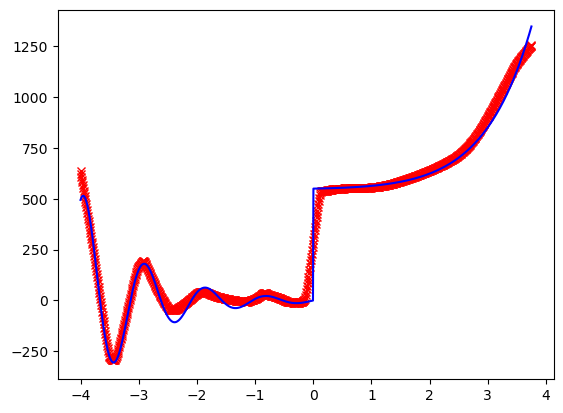

In [12]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [17]:
import scipy.io as sio
for tune_reps in range(20):
    label = "Regr_disc_stan_tune"+str(tune_reps)+".mat"
    data = sio.loadmat(label)
    re = np.array(data["test_re"])
    print(tune_reps," ",np.mean(re[:,-1]))

0   0.9991094302842122
1   0.9991008054080032
2   0.9991019795212359
3   0.9990690025745798
4   0.9849432067687426
5   0.982426083557488
6   0.9732247359509085
7   0.9168022070451249
8   0.27826015703481344
9   0.27844711910940856
10   0.2723331845302484
11   0.27217699110847265
12   0.15770203758223142
13   0.09863381083961906
14   0.13274358146397433
15   0.10132000925263054
16   0.15072164549099237
17   0.1144966614267418
18   0.09938824294196882
19   0.17114758616608192


In [18]:
lrb_tune[13]

array([0.008, 0.25 ])